In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (EfficientNetB0)

2024-02-21 12:51:58.096634: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 12:51:58.096727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 12:51:58.221039: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(EfficientNetB0(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("EfficientNetB0"+s+".keras")
    

    # save model to disk
    filename = "EfficientNetB0" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 efficientnetb0 (Functional  (None, 4)                 4054695   


 )                                                               


Total params: 4054695 (15.47 MB)


Trainable params: 4012672 (15.31 MB)


Non-trainable params: 42023 (164.16 KB)


_________________________________________________________________


Epoch 1/30


2024-02-21 12:52:38.791955: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


I0000 00:00:1708519963.406371      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 1:30:01 - loss: 1.6361 - accuracy: 0.2500

  2/140 [..............................] - ETA: 23s - loss: 5.3760 - accuracy: 0.2812    

  3/140 [..............................] - ETA: 23s - loss: 4.5546 - accuracy: 0.3750

  4/140 [..............................] - ETA: 22s - loss: 4.1598 - accuracy: 0.3750

  5/140 [>.............................] - ETA: 21s - loss: 4.0811 - accuracy: 0.3812

  6/140 [>.............................] - ETA: 21s - loss: 3.8001 - accuracy: 0.3854

  7/140 [>.............................] - ETA: 21s - loss: 3.9089 - accuracy: 0.3705

  8/140 [>.............................] - ETA: 20s - loss: 3.9815 - accuracy: 0.3711

  9/140 [>.............................] - ETA: 20s - loss: 3.7168 - accuracy: 0.3854

 10/140 [=>............................] - ETA: 20s - loss: 3.6099 - accuracy: 0.3844

 11/140 [=>............................] - ETA: 20s - loss: 3.5441 - accuracy: 0.3750

 12/140 [=>............................] - ETA: 20s - loss: 3.4862 - accuracy: 0.3828

 13/140 [=>............................] - ETA: 20s - loss: 3.4626 - accuracy: 0.3846

 14/140 [==>...........................] - ETA: 19s - loss: 3.3785 - accuracy: 0.3884

 15/140 [==>...........................] - ETA: 19s - loss: 3.3470 - accuracy: 0.3917

 16/140 [==>...........................] - ETA: 19s - loss: 3.3833 - accuracy: 0.3926

 17/140 [==>...........................] - ETA: 19s - loss: 3.3097 - accuracy: 0.3952

 18/140 [==>...........................] - ETA: 19s - loss: 3.1993 - accuracy: 0.3993

 19/140 [===>..........................] - ETA: 19s - loss: 3.2941 - accuracy: 0.3997

 20/140 [===>..........................] - ETA: 18s - loss: 3.3438 - accuracy: 0.4000

 21/140 [===>..........................] - ETA: 18s - loss: 3.3392 - accuracy: 0.3929

 22/140 [===>..........................] - ETA: 18s - loss: 3.2514 - accuracy: 0.3906

 23/140 [===>..........................] - ETA: 18s - loss: 3.2025 - accuracy: 0.3832

 24/140 [====>.........................] - ETA: 18s - loss: 3.2621 - accuracy: 0.3841

 25/140 [====>.........................] - ETA: 17s - loss: 3.2390 - accuracy: 0.3850

 26/140 [====>.........................] - ETA: 17s - loss: 3.1851 - accuracy: 0.3870

 27/140 [====>.........................] - ETA: 17s - loss: 3.1833 - accuracy: 0.3877

 28/140 [=====>........................] - ETA: 17s - loss: 3.2330 - accuracy: 0.3828

 29/140 [=====>........................] - ETA: 17s - loss: 3.2977 - accuracy: 0.3847

 30/140 [=====>........................] - ETA: 17s - loss: 3.2392 - accuracy: 0.3885

 31/140 [=====>........................] - ETA: 17s - loss: 3.2235 - accuracy: 0.3841

 32/140 [=====>........................] - ETA: 16s - loss: 3.1848 - accuracy: 0.3809

 33/140 [======>.......................] - ETA: 16s - loss: 3.1474 - accuracy: 0.3826

 34/140 [======>.......................] - ETA: 16s - loss: 3.1673 - accuracy: 0.3824

 35/140 [======>.......................] - ETA: 16s - loss: 3.1513 - accuracy: 0.3830

 36/140 [======>.......................] - ETA: 16s - loss: 3.1141 - accuracy: 0.3845

 37/140 [======>.......................] - ETA: 16s - loss: 3.1008 - accuracy: 0.3834

 38/140 [=======>......................] - ETA: 15s - loss: 3.0690 - accuracy: 0.3849

 39/140 [=======>......................] - ETA: 15s - loss: 3.0265 - accuracy: 0.3846

 40/140 [=======>......................] - ETA: 15s - loss: 2.9991 - accuracy: 0.3836

 41/140 [=======>......................] - ETA: 15s - loss: 2.9766 - accuracy: 0.3819

 42/140 [========>.....................] - ETA: 15s - loss: 2.9431 - accuracy: 0.3795

 43/140 [========>.....................] - ETA: 15s - loss: 2.9035 - accuracy: 0.3808

 44/140 [========>.....................] - ETA: 14s - loss: 2.9120 - accuracy: 0.3807

 45/140 [========>.....................] - ETA: 14s - loss: 2.9389 - accuracy: 0.3812

 46/140 [========>.....................] - ETA: 14s - loss: 2.9072 - accuracy: 0.3825

 47/140 [=========>....................] - ETA: 14s - loss: 2.8771 - accuracy: 0.3856

 48/140 [=========>....................] - ETA: 14s - loss: 2.8478 - accuracy: 0.3887

 49/140 [=========>....................] - ETA: 14s - loss: 2.8638 - accuracy: 0.3890

 50/140 [=========>....................] - ETA: 14s - loss: 2.8645 - accuracy: 0.3894

 51/140 [=========>....................] - ETA: 13s - loss: 2.8595 - accuracy: 0.3897

 52/140 [==========>...................] - ETA: 13s - loss: 2.8348 - accuracy: 0.3924

 53/140 [==========>...................] - ETA: 13s - loss: 2.8293 - accuracy: 0.3939

 54/140 [==========>...................] - ETA: 13s - loss: 2.8279 - accuracy: 0.3912

 55/140 [==========>...................] - ETA: 13s - loss: 2.8413 - accuracy: 0.3875

 56/140 [===========>..................] - ETA: 13s - loss: 2.8174 - accuracy: 0.3890

 57/140 [===========>..................] - ETA: 12s - loss: 2.7887 - accuracy: 0.3909

 58/140 [===========>..................] - ETA: 12s - loss: 2.7707 - accuracy: 0.3912

 59/140 [===========>..................] - ETA: 12s - loss: 2.7532 - accuracy: 0.3882

 60/140 [===========>..................] - ETA: 12s - loss: 2.7292 - accuracy: 0.3896

 61/140 [============>.................] - ETA: 12s - loss: 2.7069 - accuracy: 0.3899

 62/140 [============>.................] - ETA: 12s - loss: 2.6847 - accuracy: 0.3916

 63/140 [============>.................] - ETA: 12s - loss: 2.6752 - accuracy: 0.3919

 64/140 [============>.................] - ETA: 11s - loss: 2.6575 - accuracy: 0.3921

 65/140 [============>.................] - ETA: 11s - loss: 2.6390 - accuracy: 0.3947

 66/140 [=============>................] - ETA: 11s - loss: 2.6269 - accuracy: 0.3954

 67/140 [=============>................] - ETA: 11s - loss: 2.6180 - accuracy: 0.3955

 68/140 [=============>................] - ETA: 11s - loss: 2.6391 - accuracy: 0.3957

 69/140 [=============>................] - ETA: 11s - loss: 2.6663 - accuracy: 0.3931

 70/140 [==============>...............] - ETA: 10s - loss: 2.6440 - accuracy: 0.3946

 71/140 [==============>...............] - ETA: 10s - loss: 2.6311 - accuracy: 0.3952

 72/140 [==============>...............] - ETA: 10s - loss: 2.6145 - accuracy: 0.3950

 73/140 [==============>...............] - ETA: 10s - loss: 2.6007 - accuracy: 0.3943

 74/140 [==============>...............] - ETA: 10s - loss: 2.5862 - accuracy: 0.3953

 75/140 [===============>..............] - ETA: 10s - loss: 2.5766 - accuracy: 0.3967

 76/140 [===============>..............] - ETA: 10s - loss: 2.5554 - accuracy: 0.3997

 77/140 [===============>..............] - ETA: 9s - loss: 2.5366 - accuracy: 0.4022 

 78/140 [===============>..............] - ETA: 9s - loss: 2.5440 - accuracy: 0.4030

 79/140 [===============>..............] - ETA: 9s - loss: 2.5419 - accuracy: 0.4015

 80/140 [================>.............] - ETA: 9s - loss: 2.5261 - accuracy: 0.4016

 81/140 [================>.............] - ETA: 9s - loss: 2.5109 - accuracy: 0.4008

 82/140 [================>.............] - ETA: 9s - loss: 2.5015 - accuracy: 0.4024

 83/140 [================>.............] - ETA: 8s - loss: 2.4960 - accuracy: 0.4032

 84/140 [=================>............] - ETA: 8s - loss: 2.4836 - accuracy: 0.4033

 85/140 [=================>............] - ETA: 8s - loss: 2.4749 - accuracy: 0.4048

 86/140 [=================>............] - ETA: 8s - loss: 2.4664 - accuracy: 0.4066

 87/140 [=================>............] - ETA: 8s - loss: 2.4591 - accuracy: 0.4077

 88/140 [=================>............] - ETA: 8s - loss: 2.4516 - accuracy: 0.4070

 89/140 [==================>...........] - ETA: 7s - loss: 2.4460 - accuracy: 0.4055

 90/140 [==================>...........] - ETA: 7s - loss: 2.4334 - accuracy: 0.4059

 91/140 [==================>...........] - ETA: 7s - loss: 2.4238 - accuracy: 0.4042

 92/140 [==================>...........] - ETA: 7s - loss: 2.4221 - accuracy: 0.4032

 93/140 [==================>...........] - ETA: 7s - loss: 2.4070 - accuracy: 0.4042

 94/140 [===================>..........] - ETA: 7s - loss: 2.3957 - accuracy: 0.4046

 95/140 [===================>..........] - ETA: 7s - loss: 2.3913 - accuracy: 0.4056

 96/140 [===================>..........] - ETA: 6s - loss: 2.3937 - accuracy: 0.4076

 97/140 [===================>..........] - ETA: 6s - loss: 2.3924 - accuracy: 0.4082

 98/140 [====================>.........] - ETA: 6s - loss: 2.3890 - accuracy: 0.4085

 99/140 [====================>.........] - ETA: 6s - loss: 2.3897 - accuracy: 0.4107

100/140 [====================>.........] - ETA: 6s - loss: 2.3838 - accuracy: 0.4103

101/140 [====================>.........] - ETA: 6s - loss: 2.3770 - accuracy: 0.4106

102/140 [====================>.........] - ETA: 5s - loss: 2.3711 - accuracy: 0.4112

103/140 [=====================>........] - ETA: 5s - loss: 2.3674 - accuracy: 0.4111

104/140 [=====================>........] - ETA: 5s - loss: 2.3585 - accuracy: 0.4105

105/140 [=====================>........] - ETA: 5s - loss: 2.3558 - accuracy: 0.4095

106/140 [=====================>........] - ETA: 5s - loss: 2.3541 - accuracy: 0.4086

107/140 [=====================>........] - ETA: 5s - loss: 2.3726 - accuracy: 0.4098

108/140 [======================>.......] - ETA: 5s - loss: 2.3886 - accuracy: 0.4094

109/140 [======================>.......] - ETA: 4s - loss: 2.3841 - accuracy: 0.4091

110/140 [======================>.......] - ETA: 4s - loss: 2.3734 - accuracy: 0.4105

111/140 [======================>.......] - ETA: 4s - loss: 2.3668 - accuracy: 0.4099

112/140 [=======================>......] - ETA: 4s - loss: 2.3690 - accuracy: 0.4093

113/140 [=======================>......] - ETA: 4s - loss: 2.3632 - accuracy: 0.4101

114/140 [=======================>......] - ETA: 4s - loss: 2.3727 - accuracy: 0.4101

115/140 [=======================>......] - ETA: 3s - loss: 2.3639 - accuracy: 0.4095

116/140 [=======================>......] - ETA: 3s - loss: 2.3549 - accuracy: 0.4108

117/140 [========================>.....] - ETA: 3s - loss: 2.3458 - accuracy: 0.4111

118/140 [========================>.....] - ETA: 3s - loss: 2.3503 - accuracy: 0.4131

119/140 [========================>.....] - ETA: 3s - loss: 2.3407 - accuracy: 0.4136

120/140 [========================>.....] - ETA: 3s - loss: 2.3419 - accuracy: 0.4141

121/140 [========================>.....] - ETA: 2s - loss: 2.3305 - accuracy: 0.4166

122/140 [=========================>....] - ETA: 2s - loss: 2.3213 - accuracy: 0.4173

123/140 [=========================>....] - ETA: 2s - loss: 2.3111 - accuracy: 0.4174

124/140 [=========================>....] - ETA: 2s - loss: 2.3035 - accuracy: 0.4173

125/140 [=========================>....] - ETA: 2s - loss: 2.2963 - accuracy: 0.4178

126/140 [==========================>...] - ETA: 2s - loss: 2.2852 - accuracy: 0.4201

127/140 [==========================>...] - ETA: 2s - loss: 2.2754 - accuracy: 0.4198

128/140 [==========================>...] - ETA: 1s - loss: 2.2698 - accuracy: 0.4207

129/140 [==========================>...] - ETA: 1s - loss: 2.2597 - accuracy: 0.4213

130/140 [==========================>...] - ETA: 1s - loss: 2.2501 - accuracy: 0.4221

131/140 [===========================>..] - ETA: 1s - loss: 2.2434 - accuracy: 0.4227

132/140 [===========================>..] - ETA: 1s - loss: 2.2348 - accuracy: 0.4226

133/140 [===========================>..] - ETA: 1s - loss: 2.2265 - accuracy: 0.4236

134/140 [===========================>..] - ETA: 0s - loss: 2.2253 - accuracy: 0.4237

135/140 [===========================>..] - ETA: 0s - loss: 2.2199 - accuracy: 0.4248

136/140 [============================>.] - ETA: 0s - loss: 2.2153 - accuracy: 0.4256

137/140 [============================>.] - ETA: 0s - loss: 2.2062 - accuracy: 0.4266

138/140 [============================>.] - ETA: 0s - loss: 2.1998 - accuracy: 0.4257

139/140 [============================>.] - ETA: 0s - loss: 2.1968 - accuracy: 0.4256

140/140 [==============================] - ETA: 0s - loss: 2.1951 - accuracy: 0.4255

140/140 [==============================] - 66s 195ms/step - loss: 2.1951 - accuracy: 0.4255 - val_loss: 1.0666 - val_accuracy: 0.3503


Epoch 2/30


  1/140 [..............................] - ETA: 44s - loss: 0.8674 - accuracy: 0.6562

  2/140 [..............................] - ETA: 22s - loss: 1.0831 - accuracy: 0.6094

  3/140 [..............................] - ETA: 21s - loss: 1.0938 - accuracy: 0.5938

  4/140 [..............................] - ETA: 21s - loss: 1.1149 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 21s - loss: 1.4281 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 21s - loss: 1.4004 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 20s - loss: 1.5525 - accuracy: 0.4777

  8/140 [>.............................] - ETA: 20s - loss: 1.5566 - accuracy: 0.4766

  9/140 [>.............................] - ETA: 20s - loss: 1.5644 - accuracy: 0.4896

 10/140 [=>............................] - ETA: 20s - loss: 1.5520 - accuracy: 0.4812

 11/140 [=>............................] - ETA: 20s - loss: 1.5166 - accuracy: 0.4886

 12/140 [=>............................] - ETA: 19s - loss: 1.5099 - accuracy: 0.4948

 13/140 [=>............................] - ETA: 19s - loss: 1.4907 - accuracy: 0.4808

 14/140 [==>...........................] - ETA: 19s - loss: 1.4844 - accuracy: 0.4888

 15/140 [==>...........................] - ETA: 19s - loss: 1.4533 - accuracy: 0.5042

 16/140 [==>...........................] - ETA: 19s - loss: 1.4287 - accuracy: 0.5039

 17/140 [==>...........................] - ETA: 18s - loss: 1.4277 - accuracy: 0.4963

 18/140 [==>...........................] - ETA: 18s - loss: 1.4239 - accuracy: 0.4913

 19/140 [===>..........................] - ETA: 18s - loss: 1.4805 - accuracy: 0.4984

 20/140 [===>..........................] - ETA: 18s - loss: 1.4853 - accuracy: 0.4953

 21/140 [===>..........................] - ETA: 18s - loss: 1.5003 - accuracy: 0.4955

 22/140 [===>..........................] - ETA: 18s - loss: 1.4938 - accuracy: 0.4957

 23/140 [===>..........................] - ETA: 18s - loss: 1.4821 - accuracy: 0.4973

 24/140 [====>.........................] - ETA: 17s - loss: 1.4657 - accuracy: 0.4909

 25/140 [====>.........................] - ETA: 17s - loss: 1.4762 - accuracy: 0.4863

 26/140 [====>.........................] - ETA: 17s - loss: 1.4719 - accuracy: 0.4820

 27/140 [====>.........................] - ETA: 17s - loss: 1.4824 - accuracy: 0.4757

 28/140 [=====>........................] - ETA: 17s - loss: 1.4671 - accuracy: 0.4766

 29/140 [=====>........................] - ETA: 17s - loss: 1.4961 - accuracy: 0.4763

 30/140 [=====>........................] - ETA: 16s - loss: 1.5071 - accuracy: 0.4740

 31/140 [=====>........................] - ETA: 16s - loss: 1.5140 - accuracy: 0.4738

 32/140 [=====>........................] - ETA: 16s - loss: 1.5159 - accuracy: 0.4727

 33/140 [======>.......................] - ETA: 16s - loss: 1.4939 - accuracy: 0.4782

 34/140 [======>.......................] - ETA: 16s - loss: 1.4959 - accuracy: 0.4770

 35/140 [======>.......................] - ETA: 16s - loss: 1.5069 - accuracy: 0.4777

 36/140 [======>.......................] - ETA: 16s - loss: 1.4945 - accuracy: 0.4766

 37/140 [======>.......................] - ETA: 15s - loss: 1.5087 - accuracy: 0.4747

 38/140 [=======>......................] - ETA: 15s - loss: 1.4957 - accuracy: 0.4745

 39/140 [=======>......................] - ETA: 15s - loss: 1.4995 - accuracy: 0.4768

 40/140 [=======>......................] - ETA: 15s - loss: 1.4999 - accuracy: 0.4750

 41/140 [=======>......................] - ETA: 15s - loss: 1.5177 - accuracy: 0.4741

 42/140 [========>.....................] - ETA: 15s - loss: 1.5143 - accuracy: 0.4717

 43/140 [========>.....................] - ETA: 14s - loss: 1.5017 - accuracy: 0.4738

 44/140 [========>.....................] - ETA: 14s - loss: 1.5065 - accuracy: 0.4730

 45/140 [========>.....................] - ETA: 14s - loss: 1.4968 - accuracy: 0.4722

 46/140 [========>.....................] - ETA: 14s - loss: 1.4910 - accuracy: 0.4749

 47/140 [=========>....................] - ETA: 14s - loss: 1.4904 - accuracy: 0.4767

 48/140 [=========>....................] - ETA: 14s - loss: 1.4902 - accuracy: 0.4740

 49/140 [=========>....................] - ETA: 14s - loss: 1.4877 - accuracy: 0.4751

 50/140 [=========>....................] - ETA: 13s - loss: 1.4776 - accuracy: 0.4762

 51/140 [=========>....................] - ETA: 13s - loss: 1.4701 - accuracy: 0.4761

 52/140 [==========>...................] - ETA: 13s - loss: 1.4605 - accuracy: 0.4766

 53/140 [==========>...................] - ETA: 13s - loss: 1.4472 - accuracy: 0.4817

 54/140 [==========>...................] - ETA: 13s - loss: 1.4392 - accuracy: 0.4832

 55/140 [==========>...................] - ETA: 13s - loss: 1.4349 - accuracy: 0.4830

 56/140 [===========>..................] - ETA: 12s - loss: 1.4313 - accuracy: 0.4849

 57/140 [===========>..................] - ETA: 12s - loss: 1.4320 - accuracy: 0.4852

 58/140 [===========>..................] - ETA: 12s - loss: 1.4247 - accuracy: 0.4871

 59/140 [===========>..................] - ETA: 12s - loss: 1.4204 - accuracy: 0.4883

 60/140 [===========>..................] - ETA: 12s - loss: 1.4189 - accuracy: 0.4901

 61/140 [============>.................] - ETA: 12s - loss: 1.4108 - accuracy: 0.4923

 62/140 [============>.................] - ETA: 12s - loss: 1.4050 - accuracy: 0.4929

 63/140 [============>.................] - ETA: 11s - loss: 1.4025 - accuracy: 0.4916

 64/140 [============>.................] - ETA: 11s - loss: 1.3965 - accuracy: 0.4927

 65/140 [============>.................] - ETA: 11s - loss: 1.4018 - accuracy: 0.4928

 66/140 [=============>................] - ETA: 11s - loss: 1.4039 - accuracy: 0.4915

 67/140 [=============>................] - ETA: 11s - loss: 1.4040 - accuracy: 0.4888

 68/140 [=============>................] - ETA: 11s - loss: 1.3957 - accuracy: 0.4913

 69/140 [=============>................] - ETA: 10s - loss: 1.3914 - accuracy: 0.4923

 70/140 [==============>...............] - ETA: 10s - loss: 1.3827 - accuracy: 0.4942

 71/140 [==============>...............] - ETA: 10s - loss: 1.3740 - accuracy: 0.4960

 72/140 [==============>...............] - ETA: 10s - loss: 1.3665 - accuracy: 0.4970

 73/140 [==============>...............] - ETA: 10s - loss: 1.3612 - accuracy: 0.4979

 74/140 [==============>...............] - ETA: 10s - loss: 1.3560 - accuracy: 0.4975

 75/140 [===============>..............] - ETA: 10s - loss: 1.3537 - accuracy: 0.4963

 76/140 [===============>..............] - ETA: 9s - loss: 1.3574 - accuracy: 0.4979 

 77/140 [===============>..............] - ETA: 9s - loss: 1.3555 - accuracy: 0.4992

 78/140 [===============>..............] - ETA: 9s - loss: 1.3494 - accuracy: 0.5004

 79/140 [===============>..............] - ETA: 9s - loss: 1.3528 - accuracy: 0.5008

 80/140 [================>.............] - ETA: 9s - loss: 1.3480 - accuracy: 0.5012

 81/140 [================>.............] - ETA: 9s - loss: 1.3512 - accuracy: 0.5015

 82/140 [================>.............] - ETA: 8s - loss: 1.3507 - accuracy: 0.5030

 83/140 [================>.............] - ETA: 8s - loss: 1.3467 - accuracy: 0.5056

 84/140 [=================>............] - ETA: 8s - loss: 1.3434 - accuracy: 0.5063

 85/140 [=================>............] - ETA: 8s - loss: 1.3473 - accuracy: 0.5051

 86/140 [=================>............] - ETA: 8s - loss: 1.3445 - accuracy: 0.5073

 87/140 [=================>............] - ETA: 8s - loss: 1.3395 - accuracy: 0.5075

 88/140 [=================>............] - ETA: 8s - loss: 1.3374 - accuracy: 0.5067

 89/140 [==================>...........] - ETA: 7s - loss: 1.3342 - accuracy: 0.5077

 90/140 [==================>...........] - ETA: 7s - loss: 1.3288 - accuracy: 0.5090

 91/140 [==================>...........] - ETA: 7s - loss: 1.3252 - accuracy: 0.5093

 92/140 [==================>...........] - ETA: 7s - loss: 1.3316 - accuracy: 0.5092

 93/140 [==================>...........] - ETA: 7s - loss: 1.3260 - accuracy: 0.5111

 94/140 [===================>..........] - ETA: 7s - loss: 1.3233 - accuracy: 0.5110

 95/140 [===================>..........] - ETA: 6s - loss: 1.3199 - accuracy: 0.5109

 96/140 [===================>..........] - ETA: 6s - loss: 1.3220 - accuracy: 0.5130

 97/140 [===================>..........] - ETA: 6s - loss: 1.3185 - accuracy: 0.5135

 98/140 [====================>.........] - ETA: 6s - loss: 1.3215 - accuracy: 0.5137

 99/140 [====================>.........] - ETA: 6s - loss: 1.3223 - accuracy: 0.5126

100/140 [====================>.........] - ETA: 6s - loss: 1.3197 - accuracy: 0.5122

101/140 [====================>.........] - ETA: 6s - loss: 1.3194 - accuracy: 0.5111

102/140 [====================>.........] - ETA: 5s - loss: 1.3163 - accuracy: 0.5107

103/140 [=====================>........] - ETA: 5s - loss: 1.3150 - accuracy: 0.5103

104/140 [=====================>........] - ETA: 5s - loss: 1.3098 - accuracy: 0.5114

105/140 [=====================>........] - ETA: 5s - loss: 1.3093 - accuracy: 0.5128

106/140 [=====================>........] - ETA: 5s - loss: 1.3049 - accuracy: 0.5136

107/140 [=====================>........] - ETA: 5s - loss: 1.3009 - accuracy: 0.5134

108/140 [======================>.......] - ETA: 4s - loss: 1.2975 - accuracy: 0.5148

109/140 [======================>.......] - ETA: 4s - loss: 1.2980 - accuracy: 0.5149

110/140 [======================>.......] - ETA: 4s - loss: 1.3030 - accuracy: 0.5151

111/140 [======================>.......] - ETA: 4s - loss: 1.3029 - accuracy: 0.5146

112/140 [=======================>......] - ETA: 4s - loss: 1.2993 - accuracy: 0.5162

113/140 [=======================>......] - ETA: 4s - loss: 1.2967 - accuracy: 0.5163

114/140 [=======================>......] - ETA: 4s - loss: 1.3011 - accuracy: 0.5159

115/140 [=======================>......] - ETA: 3s - loss: 1.3014 - accuracy: 0.5149

116/140 [=======================>......] - ETA: 3s - loss: 1.2975 - accuracy: 0.5156

117/140 [========================>.....] - ETA: 3s - loss: 1.2984 - accuracy: 0.5155

118/140 [========================>.....] - ETA: 3s - loss: 1.2946 - accuracy: 0.5169

119/140 [========================>.....] - ETA: 3s - loss: 1.2923 - accuracy: 0.5165

120/140 [========================>.....] - ETA: 3s - loss: 1.2909 - accuracy: 0.5177

121/140 [========================>.....] - ETA: 2s - loss: 1.2869 - accuracy: 0.5194

122/140 [=========================>....] - ETA: 2s - loss: 1.2872 - accuracy: 0.5190

123/140 [=========================>....] - ETA: 2s - loss: 1.2847 - accuracy: 0.5183

124/140 [=========================>....] - ETA: 2s - loss: 1.2816 - accuracy: 0.5186

125/140 [=========================>....] - ETA: 2s - loss: 1.2801 - accuracy: 0.5190

126/140 [==========================>...] - ETA: 2s - loss: 1.2804 - accuracy: 0.5186

127/140 [==========================>...] - ETA: 2s - loss: 1.2779 - accuracy: 0.5182

128/140 [==========================>...] - ETA: 1s - loss: 1.2745 - accuracy: 0.5190

129/140 [==========================>...] - ETA: 1s - loss: 1.2758 - accuracy: 0.5191

130/140 [==========================>...] - ETA: 1s - loss: 1.2751 - accuracy: 0.5188

131/140 [===========================>..] - ETA: 1s - loss: 1.2723 - accuracy: 0.5191

132/140 [===========================>..] - ETA: 1s - loss: 1.2692 - accuracy: 0.5194

133/140 [===========================>..] - ETA: 1s - loss: 1.2703 - accuracy: 0.5202

134/140 [===========================>..] - ETA: 0s - loss: 1.2696 - accuracy: 0.5210

135/140 [===========================>..] - ETA: 0s - loss: 1.2654 - accuracy: 0.5225

136/140 [============================>.] - ETA: 0s - loss: 1.2640 - accuracy: 0.5230

137/140 [============================>.] - ETA: 0s - loss: 1.2641 - accuracy: 0.5235

138/140 [============================>.] - ETA: 0s - loss: 1.2613 - accuracy: 0.5238

139/140 [============================>.] - ETA: 0s - loss: 1.2577 - accuracy: 0.5245

140/140 [==============================] - ETA: 0s - loss: 1.2586 - accuracy: 0.5245

140/140 [==============================] - 23s 164ms/step - loss: 1.2586 - accuracy: 0.5245 - val_loss: 1.6373 - val_accuracy: 0.5004


Epoch 3/30


  1/140 [..............................] - ETA: 43s - loss: 0.7185 - accuracy: 0.7188

  2/140 [..............................] - ETA: 21s - loss: 0.7661 - accuracy: 0.6719

  3/140 [..............................] - ETA: 20s - loss: 0.8828 - accuracy: 0.6562

  4/140 [..............................] - ETA: 20s - loss: 0.8699 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 20s - loss: 0.8158 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 20s - loss: 0.9812 - accuracy: 0.6354

  7/140 [>.............................] - ETA: 20s - loss: 1.0712 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 20s - loss: 1.0753 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 20s - loss: 1.0547 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 19s - loss: 1.0148 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 19s - loss: 1.0060 - accuracy: 0.5994

 12/140 [=>............................] - ETA: 19s - loss: 0.9984 - accuracy: 0.5911

 13/140 [=>............................] - ETA: 19s - loss: 0.9934 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 19s - loss: 1.0020 - accuracy: 0.5871

 15/140 [==>...........................] - ETA: 19s - loss: 0.9994 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 19s - loss: 0.9833 - accuracy: 0.5879

 17/140 [==>...........................] - ETA: 18s - loss: 0.9757 - accuracy: 0.5901

 18/140 [==>...........................] - ETA: 18s - loss: 0.9650 - accuracy: 0.5903

 19/140 [===>..........................] - ETA: 18s - loss: 0.9614 - accuracy: 0.5855

 20/140 [===>..........................] - ETA: 18s - loss: 0.9861 - accuracy: 0.5781

 21/140 [===>..........................] - ETA: 18s - loss: 0.9938 - accuracy: 0.5789

 22/140 [===>..........................] - ETA: 18s - loss: 0.9861 - accuracy: 0.5810

 23/140 [===>..........................] - ETA: 18s - loss: 0.9908 - accuracy: 0.5842

 24/140 [====>.........................] - ETA: 18s - loss: 0.9893 - accuracy: 0.5820

 25/140 [====>.........................] - ETA: 17s - loss: 0.9823 - accuracy: 0.5788

 26/140 [====>.........................] - ETA: 17s - loss: 1.0000 - accuracy: 0.5733

 27/140 [====>.........................] - ETA: 17s - loss: 0.9953 - accuracy: 0.5706

 28/140 [=====>........................] - ETA: 17s - loss: 1.0074 - accuracy: 0.5737

 29/140 [=====>........................] - ETA: 17s - loss: 1.0012 - accuracy: 0.5722

 30/140 [=====>........................] - ETA: 17s - loss: 1.0227 - accuracy: 0.5708

 31/140 [=====>........................] - ETA: 16s - loss: 1.0277 - accuracy: 0.5706

 32/140 [=====>........................] - ETA: 16s - loss: 1.0315 - accuracy: 0.5664

 33/140 [======>.......................] - ETA: 16s - loss: 1.0586 - accuracy: 0.5653

 34/140 [======>.......................] - ETA: 16s - loss: 1.0717 - accuracy: 0.5689

 35/140 [======>.......................] - ETA: 16s - loss: 1.0909 - accuracy: 0.5679

 36/140 [======>.......................] - ETA: 16s - loss: 1.0977 - accuracy: 0.5642

 37/140 [======>.......................] - ETA: 15s - loss: 1.0964 - accuracy: 0.5642

 38/140 [=======>......................] - ETA: 15s - loss: 1.0903 - accuracy: 0.5625

 39/140 [=======>......................] - ETA: 15s - loss: 1.0871 - accuracy: 0.5681

 40/140 [=======>......................] - ETA: 15s - loss: 1.0865 - accuracy: 0.5711

 41/140 [=======>......................] - ETA: 15s - loss: 1.0925 - accuracy: 0.5686

 42/140 [========>.....................] - ETA: 15s - loss: 1.0819 - accuracy: 0.5699

 43/140 [========>.....................] - ETA: 15s - loss: 1.0780 - accuracy: 0.5690

 44/140 [========>.....................] - ETA: 14s - loss: 1.0753 - accuracy: 0.5703

 45/140 [========>.....................] - ETA: 14s - loss: 1.0704 - accuracy: 0.5757

 46/140 [========>.....................] - ETA: 14s - loss: 1.0661 - accuracy: 0.5761

 47/140 [=========>....................] - ETA: 14s - loss: 1.0626 - accuracy: 0.5745

 48/140 [=========>....................] - ETA: 14s - loss: 1.0591 - accuracy: 0.5729

 49/140 [=========>....................] - ETA: 14s - loss: 1.0647 - accuracy: 0.5759

 50/140 [=========>....................] - ETA: 14s - loss: 1.0729 - accuracy: 0.5788

 51/140 [=========>....................] - ETA: 13s - loss: 1.0647 - accuracy: 0.5809

 52/140 [==========>...................] - ETA: 13s - loss: 1.0727 - accuracy: 0.5811

 53/140 [==========>...................] - ETA: 13s - loss: 1.0684 - accuracy: 0.5814

 54/140 [==========>...................] - ETA: 13s - loss: 1.0640 - accuracy: 0.5833

 55/140 [==========>...................] - ETA: 13s - loss: 1.0568 - accuracy: 0.5864

 56/140 [===========>..................] - ETA: 13s - loss: 1.0541 - accuracy: 0.5871

 57/140 [===========>..................] - ETA: 12s - loss: 1.0530 - accuracy: 0.5894

 58/140 [===========>..................] - ETA: 12s - loss: 1.0501 - accuracy: 0.5900

 59/140 [===========>..................] - ETA: 12s - loss: 1.0497 - accuracy: 0.5916

 60/140 [===========>..................] - ETA: 12s - loss: 1.0473 - accuracy: 0.5932

 61/140 [============>.................] - ETA: 12s - loss: 1.0443 - accuracy: 0.5953

 62/140 [============>.................] - ETA: 12s - loss: 1.0459 - accuracy: 0.5932

 63/140 [============>.................] - ETA: 12s - loss: 1.0420 - accuracy: 0.5938

 64/140 [============>.................] - ETA: 11s - loss: 1.0426 - accuracy: 0.5938

 65/140 [============>.................] - ETA: 11s - loss: 1.0354 - accuracy: 0.5957

 66/140 [=============>................] - ETA: 11s - loss: 1.0309 - accuracy: 0.5975

 67/140 [=============>................] - ETA: 11s - loss: 1.0295 - accuracy: 0.5979

 68/140 [=============>................] - ETA: 11s - loss: 1.0332 - accuracy: 0.5997

 69/140 [=============>................] - ETA: 11s - loss: 1.0306 - accuracy: 0.6001

 70/140 [==============>...............] - ETA: 10s - loss: 1.0278 - accuracy: 0.6009

 71/140 [==============>...............] - ETA: 10s - loss: 1.0306 - accuracy: 0.5995

 72/140 [==============>...............] - ETA: 10s - loss: 1.0267 - accuracy: 0.5998

 73/140 [==============>...............] - ETA: 10s - loss: 1.0229 - accuracy: 0.6002

 74/140 [==============>...............] - ETA: 10s - loss: 1.0275 - accuracy: 0.5992

 75/140 [===============>..............] - ETA: 10s - loss: 1.0228 - accuracy: 0.6004

 76/140 [===============>..............] - ETA: 10s - loss: 1.0178 - accuracy: 0.6024

 77/140 [===============>..............] - ETA: 9s - loss: 1.0174 - accuracy: 0.6023 

 78/140 [===============>..............] - ETA: 9s - loss: 1.0197 - accuracy: 0.6018

 79/140 [===============>..............] - ETA: 9s - loss: 1.0171 - accuracy: 0.6009

 80/140 [================>.............] - ETA: 9s - loss: 1.0186 - accuracy: 0.6000

 81/140 [================>.............] - ETA: 9s - loss: 1.0192 - accuracy: 0.5995

 82/140 [================>.............] - ETA: 9s - loss: 1.0241 - accuracy: 0.5998

 83/140 [================>.............] - ETA: 8s - loss: 1.0205 - accuracy: 0.6002

 84/140 [=================>............] - ETA: 8s - loss: 1.0241 - accuracy: 0.5990

 85/140 [=================>............] - ETA: 8s - loss: 1.0226 - accuracy: 0.5982

 86/140 [=================>............] - ETA: 8s - loss: 1.0230 - accuracy: 0.5981

 87/140 [=================>............] - ETA: 8s - loss: 1.0229 - accuracy: 0.5970

 88/140 [=================>............] - ETA: 8s - loss: 1.0227 - accuracy: 0.5973

 89/140 [==================>...........] - ETA: 7s - loss: 1.0203 - accuracy: 0.5976

 90/140 [==================>...........] - ETA: 7s - loss: 1.0174 - accuracy: 0.5976

 91/140 [==================>...........] - ETA: 7s - loss: 1.0152 - accuracy: 0.5975

 92/140 [==================>...........] - ETA: 7s - loss: 1.0183 - accuracy: 0.5978

 93/140 [==================>...........] - ETA: 7s - loss: 1.0147 - accuracy: 0.5995

 94/140 [===================>..........] - ETA: 7s - loss: 1.0150 - accuracy: 0.5981

 95/140 [===================>..........] - ETA: 7s - loss: 1.0167 - accuracy: 0.5984

 96/140 [===================>..........] - ETA: 6s - loss: 1.0168 - accuracy: 0.5980

 97/140 [===================>..........] - ETA: 6s - loss: 1.0165 - accuracy: 0.5979

 98/140 [====================>.........] - ETA: 6s - loss: 1.0123 - accuracy: 0.5989

 99/140 [====================>.........] - ETA: 6s - loss: 1.0094 - accuracy: 0.5991

100/140 [====================>.........] - ETA: 6s - loss: 1.0154 - accuracy: 0.5991

101/140 [====================>.........] - ETA: 6s - loss: 1.0143 - accuracy: 0.5990

102/140 [====================>.........] - ETA: 5s - loss: 1.0132 - accuracy: 0.5987

103/140 [=====================>........] - ETA: 5s - loss: 1.0223 - accuracy: 0.5986

104/140 [=====================>........] - ETA: 5s - loss: 1.0202 - accuracy: 0.5989

105/140 [=====================>........] - ETA: 5s - loss: 1.0176 - accuracy: 0.6000

106/140 [=====================>........] - ETA: 5s - loss: 1.0167 - accuracy: 0.6005

107/140 [=====================>........] - ETA: 5s - loss: 1.0131 - accuracy: 0.6022

108/140 [======================>.......] - ETA: 5s - loss: 1.0172 - accuracy: 0.6030

109/140 [======================>.......] - ETA: 4s - loss: 1.0140 - accuracy: 0.6041

110/140 [======================>.......] - ETA: 4s - loss: 1.0112 - accuracy: 0.6060

111/140 [======================>.......] - ETA: 4s - loss: 1.0086 - accuracy: 0.6067

112/140 [=======================>......] - ETA: 4s - loss: 1.0065 - accuracy: 0.6060

113/140 [=======================>......] - ETA: 4s - loss: 1.0048 - accuracy: 0.6062

114/140 [=======================>......] - ETA: 4s - loss: 1.0044 - accuracy: 0.6066

115/140 [=======================>......] - ETA: 3s - loss: 1.0037 - accuracy: 0.6068

116/140 [=======================>......] - ETA: 3s - loss: 1.0018 - accuracy: 0.6075

117/140 [========================>.....] - ETA: 3s - loss: 1.0041 - accuracy: 0.6060

118/140 [========================>.....] - ETA: 3s - loss: 1.0026 - accuracy: 0.6065

119/140 [========================>.....] - ETA: 3s - loss: 1.0010 - accuracy: 0.6066

120/140 [========================>.....] - ETA: 3s - loss: 1.0016 - accuracy: 0.6062

121/140 [========================>.....] - ETA: 2s - loss: 1.0017 - accuracy: 0.6069

122/140 [=========================>....] - ETA: 2s - loss: 0.9999 - accuracy: 0.6078

123/140 [=========================>....] - ETA: 2s - loss: 0.9999 - accuracy: 0.6077

124/140 [=========================>....] - ETA: 2s - loss: 0.9982 - accuracy: 0.6079

125/140 [=========================>....] - ETA: 2s - loss: 0.9958 - accuracy: 0.6080

126/140 [==========================>...] - ETA: 2s - loss: 0.9930 - accuracy: 0.6084

127/140 [==========================>...] - ETA: 2s - loss: 0.9913 - accuracy: 0.6085

128/140 [==========================>...] - ETA: 1s - loss: 0.9898 - accuracy: 0.6084

129/140 [==========================>...] - ETA: 1s - loss: 0.9886 - accuracy: 0.6083

130/140 [==========================>...] - ETA: 1s - loss: 0.9867 - accuracy: 0.6084

131/140 [===========================>..] - ETA: 1s - loss: 0.9837 - accuracy: 0.6095

132/140 [===========================>..] - ETA: 1s - loss: 0.9817 - accuracy: 0.6098

133/140 [===========================>..] - ETA: 1s - loss: 0.9794 - accuracy: 0.6097

134/140 [===========================>..] - ETA: 0s - loss: 0.9780 - accuracy: 0.6105

135/140 [===========================>..] - ETA: 0s - loss: 0.9757 - accuracy: 0.6116

136/140 [============================>.] - ETA: 0s - loss: 0.9760 - accuracy: 0.6124

137/140 [============================>.] - ETA: 0s - loss: 0.9743 - accuracy: 0.6122

138/140 [============================>.] - ETA: 0s - loss: 0.9720 - accuracy: 0.6128

139/140 [============================>.] - ETA: 0s - loss: 0.9724 - accuracy: 0.6122

140/140 [==============================] - ETA: 0s - loss: 0.9753 - accuracy: 0.6118

140/140 [==============================] - 23s 166ms/step - loss: 0.9753 - accuracy: 0.6118 - val_loss: 2.5414 - val_accuracy: 0.5004


Epoch 4/30


  1/140 [..............................] - ETA: 42s - loss: 0.6378 - accuracy: 0.7812

  2/140 [..............................] - ETA: 21s - loss: 0.7234 - accuracy: 0.7656

  3/140 [..............................] - ETA: 21s - loss: 0.7848 - accuracy: 0.7396

  4/140 [..............................] - ETA: 21s - loss: 0.8131 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 21s - loss: 0.8089 - accuracy: 0.6875

  6/140 [>.............................] - ETA: 21s - loss: 0.8366 - accuracy: 0.6875

  7/140 [>.............................] - ETA: 20s - loss: 0.8155 - accuracy: 0.6964

  8/140 [>.............................] - ETA: 20s - loss: 0.8277 - accuracy: 0.6914

  9/140 [>.............................] - ETA: 20s - loss: 0.8022 - accuracy: 0.6944

 10/140 [=>............................] - ETA: 20s - loss: 0.8506 - accuracy: 0.6844

 11/140 [=>............................] - ETA: 20s - loss: 0.8496 - accuracy: 0.6733

 12/140 [=>............................] - ETA: 20s - loss: 0.8488 - accuracy: 0.6693

 13/140 [=>............................] - ETA: 19s - loss: 0.8764 - accuracy: 0.6683

 14/140 [==>...........................] - ETA: 19s - loss: 0.8644 - accuracy: 0.6741

 15/140 [==>...........................] - ETA: 19s - loss: 0.8823 - accuracy: 0.6792

 16/140 [==>...........................] - ETA: 19s - loss: 0.8883 - accuracy: 0.6855

 17/140 [==>...........................] - ETA: 19s - loss: 0.8898 - accuracy: 0.6728

 18/140 [==>...........................] - ETA: 19s - loss: 0.8725 - accuracy: 0.6771

 19/140 [===>..........................] - ETA: 18s - loss: 0.8814 - accuracy: 0.6645

 20/140 [===>..........................] - ETA: 18s - loss: 0.8732 - accuracy: 0.6641

 21/140 [===>..........................] - ETA: 18s - loss: 0.8837 - accuracy: 0.6503

 22/140 [===>..........................] - ETA: 18s - loss: 0.8766 - accuracy: 0.6534

 23/140 [===>..........................] - ETA: 18s - loss: 0.8723 - accuracy: 0.6508

 24/140 [====>.........................] - ETA: 18s - loss: 0.8724 - accuracy: 0.6497

 25/140 [====>.........................] - ETA: 17s - loss: 0.8714 - accuracy: 0.6463

 26/140 [====>.........................] - ETA: 17s - loss: 0.8823 - accuracy: 0.6454

 27/140 [====>.........................] - ETA: 17s - loss: 0.8795 - accuracy: 0.6447

 28/140 [=====>........................] - ETA: 17s - loss: 0.8711 - accuracy: 0.6496

 29/140 [=====>........................] - ETA: 17s - loss: 0.8871 - accuracy: 0.6455

 30/140 [=====>........................] - ETA: 17s - loss: 0.8915 - accuracy: 0.6417

 31/140 [=====>........................] - ETA: 16s - loss: 0.9064 - accuracy: 0.6331

 32/140 [=====>........................] - ETA: 16s - loss: 0.9036 - accuracy: 0.6318

 33/140 [======>.......................] - ETA: 16s - loss: 0.8986 - accuracy: 0.6335

 34/140 [======>.......................] - ETA: 16s - loss: 0.8932 - accuracy: 0.6333

 35/140 [======>.......................] - ETA: 16s - loss: 0.8855 - accuracy: 0.6348

 36/140 [======>.......................] - ETA: 16s - loss: 0.8803 - accuracy: 0.6372

 37/140 [======>.......................] - ETA: 16s - loss: 0.8809 - accuracy: 0.6402

 38/140 [=======>......................] - ETA: 15s - loss: 0.8823 - accuracy: 0.6390

 39/140 [=======>......................] - ETA: 15s - loss: 0.8746 - accuracy: 0.6442

 40/140 [=======>......................] - ETA: 15s - loss: 0.8701 - accuracy: 0.6461

 41/140 [=======>......................] - ETA: 15s - loss: 0.8662 - accuracy: 0.6463

 42/140 [========>.....................] - ETA: 15s - loss: 0.8612 - accuracy: 0.6473

 43/140 [========>.....................] - ETA: 15s - loss: 0.8574 - accuracy: 0.6453

 44/140 [========>.....................] - ETA: 14s - loss: 0.8597 - accuracy: 0.6491

 45/140 [========>.....................] - ETA: 14s - loss: 0.8657 - accuracy: 0.6486

 46/140 [========>.....................] - ETA: 14s - loss: 0.8652 - accuracy: 0.6481

 47/140 [=========>....................] - ETA: 14s - loss: 0.8592 - accuracy: 0.6509

 48/140 [=========>....................] - ETA: 14s - loss: 0.8590 - accuracy: 0.6517

 49/140 [=========>....................] - ETA: 14s - loss: 0.8717 - accuracy: 0.6505

 50/140 [=========>....................] - ETA: 14s - loss: 0.8733 - accuracy: 0.6488

 51/140 [=========>....................] - ETA: 13s - loss: 0.8688 - accuracy: 0.6501

 52/140 [==========>...................] - ETA: 13s - loss: 0.8621 - accuracy: 0.6520

 53/140 [==========>...................] - ETA: 13s - loss: 0.8591 - accuracy: 0.6515

 54/140 [==========>...................] - ETA: 13s - loss: 0.8597 - accuracy: 0.6516

 55/140 [==========>...................] - ETA: 13s - loss: 0.8573 - accuracy: 0.6523

 56/140 [===========>..................] - ETA: 13s - loss: 0.8540 - accuracy: 0.6551

 57/140 [===========>..................] - ETA: 12s - loss: 0.8562 - accuracy: 0.6557

 58/140 [===========>..................] - ETA: 12s - loss: 0.8521 - accuracy: 0.6562

 59/140 [===========>..................] - ETA: 12s - loss: 0.8510 - accuracy: 0.6562

 60/140 [===========>..................] - ETA: 12s - loss: 0.8453 - accuracy: 0.6583

 61/140 [============>.................] - ETA: 12s - loss: 0.8408 - accuracy: 0.6593

 62/140 [============>.................] - ETA: 12s - loss: 0.8419 - accuracy: 0.6578

 63/140 [============>.................] - ETA: 12s - loss: 0.8476 - accuracy: 0.6562

 64/140 [============>.................] - ETA: 11s - loss: 0.8460 - accuracy: 0.6567

 65/140 [============>.................] - ETA: 11s - loss: 0.8412 - accuracy: 0.6577

 66/140 [=============>................] - ETA: 11s - loss: 0.8384 - accuracy: 0.6596

 67/140 [=============>................] - ETA: 11s - loss: 0.8370 - accuracy: 0.6586

 68/140 [=============>................] - ETA: 11s - loss: 0.8376 - accuracy: 0.6599

 69/140 [=============>................] - ETA: 11s - loss: 0.8365 - accuracy: 0.6603

 70/140 [==============>...............] - ETA: 10s - loss: 0.8365 - accuracy: 0.6594

 71/140 [==============>...............] - ETA: 10s - loss: 0.8351 - accuracy: 0.6593

 72/140 [==============>...............] - ETA: 10s - loss: 0.8317 - accuracy: 0.6610

 73/140 [==============>...............] - ETA: 10s - loss: 0.8307 - accuracy: 0.6614

 74/140 [==============>...............] - ETA: 10s - loss: 0.8261 - accuracy: 0.6639

 75/140 [===============>..............] - ETA: 10s - loss: 0.8238 - accuracy: 0.6642

 76/140 [===============>..............] - ETA: 9s - loss: 0.8203 - accuracy: 0.6665 

 77/140 [===============>..............] - ETA: 9s - loss: 0.8192 - accuracy: 0.6664

 78/140 [===============>..............] - ETA: 9s - loss: 0.8170 - accuracy: 0.6675

 79/140 [===============>..............] - ETA: 9s - loss: 0.8171 - accuracy: 0.6665

 80/140 [================>.............] - ETA: 9s - loss: 0.8125 - accuracy: 0.6687

 81/140 [================>.............] - ETA: 9s - loss: 0.8115 - accuracy: 0.6694

 82/140 [================>.............] - ETA: 9s - loss: 0.8089 - accuracy: 0.6700

 83/140 [================>.............] - ETA: 8s - loss: 0.8084 - accuracy: 0.6687

 84/140 [=================>............] - ETA: 8s - loss: 0.8045 - accuracy: 0.6700

 85/140 [=================>............] - ETA: 8s - loss: 0.8014 - accuracy: 0.6721

 86/140 [=================>............] - ETA: 8s - loss: 0.7977 - accuracy: 0.6741

 87/140 [=================>............] - ETA: 8s - loss: 0.7964 - accuracy: 0.6742

 88/140 [=================>............] - ETA: 8s - loss: 0.7934 - accuracy: 0.6751

 89/140 [==================>...........] - ETA: 7s - loss: 0.7914 - accuracy: 0.6756

 90/140 [==================>...........] - ETA: 7s - loss: 0.7912 - accuracy: 0.6757

 91/140 [==================>...........] - ETA: 7s - loss: 0.7887 - accuracy: 0.6772

 92/140 [==================>...........] - ETA: 7s - loss: 0.7871 - accuracy: 0.6783

 93/140 [==================>...........] - ETA: 7s - loss: 0.7871 - accuracy: 0.6788

 94/140 [===================>..........] - ETA: 7s - loss: 0.7845 - accuracy: 0.6802

 95/140 [===================>..........] - ETA: 7s - loss: 0.7839 - accuracy: 0.6793

 96/140 [===================>..........] - ETA: 6s - loss: 0.7823 - accuracy: 0.6800

 97/140 [===================>..........] - ETA: 6s - loss: 0.7787 - accuracy: 0.6811

 98/140 [====================>.........] - ETA: 6s - loss: 0.7744 - accuracy: 0.6830

 99/140 [====================>.........] - ETA: 6s - loss: 0.7716 - accuracy: 0.6840

100/140 [====================>.........] - ETA: 6s - loss: 0.7688 - accuracy: 0.6847

101/140 [====================>.........] - ETA: 6s - loss: 0.7710 - accuracy: 0.6847

102/140 [====================>.........] - ETA: 5s - loss: 0.7710 - accuracy: 0.6841

103/140 [=====================>........] - ETA: 5s - loss: 0.7701 - accuracy: 0.6854

104/140 [=====================>........] - ETA: 5s - loss: 0.7691 - accuracy: 0.6851

105/140 [=====================>........] - ETA: 5s - loss: 0.7678 - accuracy: 0.6851

106/140 [=====================>........] - ETA: 5s - loss: 0.7677 - accuracy: 0.6857

107/140 [=====================>........] - ETA: 5s - loss: 0.7665 - accuracy: 0.6855

108/140 [======================>.......] - ETA: 4s - loss: 0.7635 - accuracy: 0.6872

109/140 [======================>.......] - ETA: 4s - loss: 0.7622 - accuracy: 0.6869

110/140 [======================>.......] - ETA: 4s - loss: 0.7645 - accuracy: 0.6861

111/140 [======================>.......] - ETA: 4s - loss: 0.7609 - accuracy: 0.6881

112/140 [=======================>......] - ETA: 4s - loss: 0.7594 - accuracy: 0.6883

113/140 [=======================>......] - ETA: 4s - loss: 0.7571 - accuracy: 0.6883

114/140 [=======================>......] - ETA: 4s - loss: 0.7544 - accuracy: 0.6891

115/140 [=======================>......] - ETA: 3s - loss: 0.7524 - accuracy: 0.6902

116/140 [=======================>......] - ETA: 3s - loss: 0.7512 - accuracy: 0.6905

117/140 [========================>.....] - ETA: 3s - loss: 0.7496 - accuracy: 0.6912

118/140 [========================>.....] - ETA: 3s - loss: 0.7500 - accuracy: 0.6904

119/140 [========================>.....] - ETA: 3s - loss: 0.7479 - accuracy: 0.6912

120/140 [========================>.....] - ETA: 3s - loss: 0.7456 - accuracy: 0.6919

121/140 [========================>.....] - ETA: 2s - loss: 0.7451 - accuracy: 0.6919

122/140 [=========================>....] - ETA: 2s - loss: 0.7442 - accuracy: 0.6919

123/140 [=========================>....] - ETA: 2s - loss: 0.7425 - accuracy: 0.6928

124/140 [=========================>....] - ETA: 2s - loss: 0.7397 - accuracy: 0.6943

125/140 [=========================>....] - ETA: 2s - loss: 0.7371 - accuracy: 0.6955

126/140 [==========================>...] - ETA: 2s - loss: 0.7365 - accuracy: 0.6952

127/140 [==========================>...] - ETA: 2s - loss: 0.7380 - accuracy: 0.6951

128/140 [==========================>...] - ETA: 1s - loss: 0.7348 - accuracy: 0.6965

129/140 [==========================>...] - ETA: 1s - loss: 0.7344 - accuracy: 0.6967

130/140 [==========================>...] - ETA: 1s - loss: 0.7316 - accuracy: 0.6981

131/140 [===========================>..] - ETA: 1s - loss: 0.7301 - accuracy: 0.6987

132/140 [===========================>..] - ETA: 1s - loss: 0.7282 - accuracy: 0.6991

133/140 [===========================>..] - ETA: 1s - loss: 0.7276 - accuracy: 0.6997

134/140 [===========================>..] - ETA: 0s - loss: 0.7259 - accuracy: 0.7003

135/140 [===========================>..] - ETA: 0s - loss: 0.7228 - accuracy: 0.7016

136/140 [============================>.] - ETA: 0s - loss: 0.7208 - accuracy: 0.7024

137/140 [============================>.] - ETA: 0s - loss: 0.7214 - accuracy: 0.7016

138/140 [============================>.] - ETA: 0s - loss: 0.7195 - accuracy: 0.7027

139/140 [============================>.] - ETA: 0s - loss: 0.7171 - accuracy: 0.7037

140/140 [==============================] - ETA: 0s - loss: 0.7166 - accuracy: 0.7040

140/140 [==============================] - 23s 165ms/step - loss: 0.7166 - accuracy: 0.7040 - val_loss: 1.5761 - val_accuracy: 0.5293


Epoch 5/30


  1/140 [..............................] - ETA: 46s - loss: 0.5825 - accuracy: 0.7812

  2/140 [..............................] - ETA: 22s - loss: 0.5668 - accuracy: 0.7969

  3/140 [..............................] - ETA: 21s - loss: 0.5504 - accuracy: 0.8021

  4/140 [..............................] - ETA: 21s - loss: 0.5213 - accuracy: 0.8047

  5/140 [>.............................] - ETA: 21s - loss: 0.5324 - accuracy: 0.8000

  6/140 [>.............................] - ETA: 21s - loss: 0.5502 - accuracy: 0.7812

  7/140 [>.............................] - ETA: 20s - loss: 0.5503 - accuracy: 0.7812

  8/140 [>.............................] - ETA: 20s - loss: 0.5531 - accuracy: 0.7852

  9/140 [>.............................] - ETA: 20s - loss: 0.5498 - accuracy: 0.7812

 10/140 [=>............................] - ETA: 20s - loss: 0.5568 - accuracy: 0.7750

 11/140 [=>............................] - ETA: 20s - loss: 0.5616 - accuracy: 0.7727

 12/140 [=>............................] - ETA: 20s - loss: 0.5472 - accuracy: 0.7734

 13/140 [=>............................] - ETA: 19s - loss: 0.5350 - accuracy: 0.7812

 14/140 [==>...........................] - ETA: 19s - loss: 0.5345 - accuracy: 0.7768

 15/140 [==>...........................] - ETA: 19s - loss: 0.5292 - accuracy: 0.7771

 16/140 [==>...........................] - ETA: 19s - loss: 0.5153 - accuracy: 0.7832

 17/140 [==>...........................] - ETA: 19s - loss: 0.5169 - accuracy: 0.7868

 18/140 [==>...........................] - ETA: 19s - loss: 0.4992 - accuracy: 0.7986

 19/140 [===>..........................] - ETA: 19s - loss: 0.5022 - accuracy: 0.7993

 20/140 [===>..........................] - ETA: 18s - loss: 0.5025 - accuracy: 0.8000

 21/140 [===>..........................] - ETA: 18s - loss: 0.5041 - accuracy: 0.7976

 22/140 [===>..........................] - ETA: 18s - loss: 0.5143 - accuracy: 0.7940

 23/140 [===>..........................] - ETA: 18s - loss: 0.5115 - accuracy: 0.7921

 24/140 [====>.........................] - ETA: 18s - loss: 0.5109 - accuracy: 0.7917

 25/140 [====>.........................] - ETA: 18s - loss: 0.5479 - accuracy: 0.7850

 26/140 [====>.........................] - ETA: 17s - loss: 0.5500 - accuracy: 0.7812

 27/140 [====>.........................] - ETA: 17s - loss: 0.5643 - accuracy: 0.7847

 28/140 [=====>........................] - ETA: 17s - loss: 0.5724 - accuracy: 0.7801

 29/140 [=====>........................] - ETA: 17s - loss: 0.5688 - accuracy: 0.7802

 30/140 [=====>........................] - ETA: 17s - loss: 0.5719 - accuracy: 0.7781

 31/140 [=====>........................] - ETA: 17s - loss: 0.5793 - accuracy: 0.7812

 32/140 [=====>........................] - ETA: 17s - loss: 0.5840 - accuracy: 0.7783

 33/140 [======>.......................] - ETA: 16s - loss: 0.5840 - accuracy: 0.7775

 34/140 [======>.......................] - ETA: 16s - loss: 0.5795 - accuracy: 0.7794

 35/140 [======>.......................] - ETA: 16s - loss: 0.5757 - accuracy: 0.7795

 36/140 [======>.......................] - ETA: 16s - loss: 0.5839 - accuracy: 0.7752

 37/140 [======>.......................] - ETA: 16s - loss: 0.5811 - accuracy: 0.7770

 38/140 [=======>......................] - ETA: 16s - loss: 0.5749 - accuracy: 0.7796

 39/140 [=======>......................] - ETA: 15s - loss: 0.5738 - accuracy: 0.7788

 40/140 [=======>......................] - ETA: 15s - loss: 0.5768 - accuracy: 0.7789

 41/140 [=======>......................] - ETA: 15s - loss: 0.5847 - accuracy: 0.7744

 42/140 [========>.....................] - ETA: 15s - loss: 0.5815 - accuracy: 0.7738

 43/140 [========>.....................] - ETA: 15s - loss: 0.5965 - accuracy: 0.7733

 44/140 [========>.....................] - ETA: 15s - loss: 0.6016 - accuracy: 0.7720

 45/140 [========>.....................] - ETA: 14s - loss: 0.6019 - accuracy: 0.7715

 46/140 [========>.....................] - ETA: 14s - loss: 0.6044 - accuracy: 0.7697

 47/140 [=========>....................] - ETA: 14s - loss: 0.6064 - accuracy: 0.7699

 48/140 [=========>....................] - ETA: 14s - loss: 0.6083 - accuracy: 0.7676

 49/140 [=========>....................] - ETA: 14s - loss: 0.6078 - accuracy: 0.7659

 50/140 [=========>....................] - ETA: 14s - loss: 0.6052 - accuracy: 0.7656

 51/140 [=========>....................] - ETA: 13s - loss: 0.6079 - accuracy: 0.7635

 52/140 [==========>...................] - ETA: 13s - loss: 0.6065 - accuracy: 0.7650

 53/140 [==========>...................] - ETA: 13s - loss: 0.6021 - accuracy: 0.7659

 54/140 [==========>...................] - ETA: 13s - loss: 0.6006 - accuracy: 0.7668

 55/140 [==========>...................] - ETA: 13s - loss: 0.5993 - accuracy: 0.7676

 56/140 [===========>..................] - ETA: 13s - loss: 0.6030 - accuracy: 0.7662

 57/140 [===========>..................] - ETA: 13s - loss: 0.6012 - accuracy: 0.7659

 58/140 [===========>..................] - ETA: 12s - loss: 0.6006 - accuracy: 0.7656

 59/140 [===========>..................] - ETA: 12s - loss: 0.6029 - accuracy: 0.7654

 60/140 [===========>..................] - ETA: 12s - loss: 0.6018 - accuracy: 0.7646

 61/140 [============>.................] - ETA: 12s - loss: 0.6044 - accuracy: 0.7649

 62/140 [============>.................] - ETA: 12s - loss: 0.6035 - accuracy: 0.7641

 63/140 [============>.................] - ETA: 12s - loss: 0.6054 - accuracy: 0.7639

 64/140 [============>.................] - ETA: 11s - loss: 0.6035 - accuracy: 0.7651

 65/140 [============>.................] - ETA: 11s - loss: 0.6036 - accuracy: 0.7639

 66/140 [=============>................] - ETA: 11s - loss: 0.6003 - accuracy: 0.7652

 67/140 [=============>................] - ETA: 11s - loss: 0.6010 - accuracy: 0.7659

 68/140 [=============>................] - ETA: 11s - loss: 0.5987 - accuracy: 0.7675

 69/140 [=============>................] - ETA: 11s - loss: 0.5946 - accuracy: 0.7690

 70/140 [==============>...............] - ETA: 10s - loss: 0.5933 - accuracy: 0.7696

 71/140 [==============>...............] - ETA: 10s - loss: 0.5920 - accuracy: 0.7702

 72/140 [==============>...............] - ETA: 10s - loss: 0.5907 - accuracy: 0.7713

 73/140 [==============>...............] - ETA: 10s - loss: 0.5941 - accuracy: 0.7693

 74/140 [==============>...............] - ETA: 10s - loss: 0.5918 - accuracy: 0.7698

 75/140 [===============>..............] - ETA: 10s - loss: 0.5881 - accuracy: 0.7713

 76/140 [===============>..............] - ETA: 9s - loss: 0.5866 - accuracy: 0.7718 

 77/140 [===============>..............] - ETA: 9s - loss: 0.5856 - accuracy: 0.7719

 78/140 [===============>..............] - ETA: 9s - loss: 0.5817 - accuracy: 0.7736

 79/140 [===============>..............] - ETA: 9s - loss: 0.5852 - accuracy: 0.7725

 80/140 [================>.............] - ETA: 9s - loss: 0.5842 - accuracy: 0.7730

 81/140 [================>.............] - ETA: 9s - loss: 0.5819 - accuracy: 0.7739

 82/140 [================>.............] - ETA: 9s - loss: 0.5775 - accuracy: 0.7759

 83/140 [================>.............] - ETA: 8s - loss: 0.5747 - accuracy: 0.7771

 84/140 [=================>............] - ETA: 8s - loss: 0.5733 - accuracy: 0.7779

 85/140 [=================>............] - ETA: 8s - loss: 0.5714 - accuracy: 0.7787

 86/140 [=================>............] - ETA: 8s - loss: 0.5683 - accuracy: 0.7805

 87/140 [=================>............] - ETA: 8s - loss: 0.5668 - accuracy: 0.7809

 88/140 [=================>............] - ETA: 8s - loss: 0.5649 - accuracy: 0.7816

 89/140 [==================>...........] - ETA: 7s - loss: 0.5616 - accuracy: 0.7830

 90/140 [==================>...........] - ETA: 7s - loss: 0.5603 - accuracy: 0.7826

 91/140 [==================>...........] - ETA: 7s - loss: 0.5605 - accuracy: 0.7826

 92/140 [==================>...........] - ETA: 7s - loss: 0.5581 - accuracy: 0.7833

 93/140 [==================>...........] - ETA: 7s - loss: 0.5583 - accuracy: 0.7846

 94/140 [===================>..........] - ETA: 7s - loss: 0.5555 - accuracy: 0.7859

 95/140 [===================>..........] - ETA: 7s - loss: 0.5549 - accuracy: 0.7859

 96/140 [===================>..........] - ETA: 6s - loss: 0.5567 - accuracy: 0.7858

 97/140 [===================>..........] - ETA: 6s - loss: 0.5551 - accuracy: 0.7861

 98/140 [====================>.........] - ETA: 6s - loss: 0.5623 - accuracy: 0.7860

 99/140 [====================>.........] - ETA: 6s - loss: 0.5628 - accuracy: 0.7854

100/140 [====================>.........] - ETA: 6s - loss: 0.5662 - accuracy: 0.7844

101/140 [====================>.........] - ETA: 6s - loss: 0.5669 - accuracy: 0.7834

102/140 [====================>.........] - ETA: 5s - loss: 0.5648 - accuracy: 0.7840

103/140 [=====================>........] - ETA: 5s - loss: 0.5643 - accuracy: 0.7846

104/140 [=====================>........] - ETA: 5s - loss: 0.5618 - accuracy: 0.7852

105/140 [=====================>........] - ETA: 5s - loss: 0.5616 - accuracy: 0.7845

106/140 [=====================>........] - ETA: 5s - loss: 0.5613 - accuracy: 0.7839

107/140 [=====================>........] - ETA: 5s - loss: 0.5596 - accuracy: 0.7850

108/140 [======================>.......] - ETA: 4s - loss: 0.5591 - accuracy: 0.7847

109/140 [======================>.......] - ETA: 4s - loss: 0.5575 - accuracy: 0.7856

110/140 [======================>.......] - ETA: 4s - loss: 0.5557 - accuracy: 0.7855

111/140 [======================>.......] - ETA: 4s - loss: 0.5570 - accuracy: 0.7852

112/140 [=======================>......] - ETA: 4s - loss: 0.5557 - accuracy: 0.7857

113/140 [=======================>......] - ETA: 4s - loss: 0.5549 - accuracy: 0.7854

114/140 [=======================>......] - ETA: 4s - loss: 0.5543 - accuracy: 0.7865

115/140 [=======================>......] - ETA: 3s - loss: 0.5529 - accuracy: 0.7864

116/140 [=======================>......] - ETA: 3s - loss: 0.5515 - accuracy: 0.7874

117/140 [========================>.....] - ETA: 3s - loss: 0.5502 - accuracy: 0.7877

118/140 [========================>.....] - ETA: 3s - loss: 0.5494 - accuracy: 0.7879

119/140 [========================>.....] - ETA: 3s - loss: 0.5476 - accuracy: 0.7881

120/140 [========================>.....] - ETA: 3s - loss: 0.5462 - accuracy: 0.7888

121/140 [========================>.....] - ETA: 2s - loss: 0.5489 - accuracy: 0.7880

122/140 [=========================>....] - ETA: 2s - loss: 0.5468 - accuracy: 0.7887

123/140 [=========================>....] - ETA: 2s - loss: 0.5457 - accuracy: 0.7891

124/140 [=========================>....] - ETA: 2s - loss: 0.5439 - accuracy: 0.7898

125/140 [=========================>....] - ETA: 2s - loss: 0.5433 - accuracy: 0.7903

126/140 [==========================>...] - ETA: 2s - loss: 0.5405 - accuracy: 0.7914

127/140 [==========================>...] - ETA: 2s - loss: 0.5390 - accuracy: 0.7916

128/140 [==========================>...] - ETA: 1s - loss: 0.5383 - accuracy: 0.7920

129/140 [==========================>...] - ETA: 1s - loss: 0.5372 - accuracy: 0.7924

130/140 [==========================>...] - ETA: 1s - loss: 0.5356 - accuracy: 0.7930

131/140 [===========================>..] - ETA: 1s - loss: 0.5338 - accuracy: 0.7934

132/140 [===========================>..] - ETA: 1s - loss: 0.5334 - accuracy: 0.7938

133/140 [===========================>..] - ETA: 1s - loss: 0.5324 - accuracy: 0.7939

134/140 [===========================>..] - ETA: 0s - loss: 0.5308 - accuracy: 0.7945

135/140 [===========================>..] - ETA: 0s - loss: 0.5302 - accuracy: 0.7949

136/140 [============================>.] - ETA: 0s - loss: 0.5279 - accuracy: 0.7960

137/140 [============================>.] - ETA: 0s - loss: 0.5269 - accuracy: 0.7968

138/140 [============================>.] - ETA: 0s - loss: 0.5262 - accuracy: 0.7966

139/140 [============================>.] - ETA: 0s - loss: 0.5257 - accuracy: 0.7968

140/140 [==============================] - ETA: 0s - loss: 0.5252 - accuracy: 0.7969

140/140 [==============================] - 23s 165ms/step - loss: 0.5252 - accuracy: 0.7969 - val_loss: 1.3119 - val_accuracy: 0.5856


Epoch 6/30


  1/140 [..............................] - ETA: 41s - loss: 0.2790 - accuracy: 0.8438

  2/140 [..............................] - ETA: 21s - loss: 0.2985 - accuracy: 0.8594

  3/140 [..............................] - ETA: 21s - loss: 0.2965 - accuracy: 0.8646

  4/140 [..............................] - ETA: 20s - loss: 0.3159 - accuracy: 0.8438

  5/140 [>.............................] - ETA: 20s - loss: 0.3308 - accuracy: 0.8438

  6/140 [>.............................] - ETA: 20s - loss: 0.3413 - accuracy: 0.8490

  7/140 [>.............................] - ETA: 20s - loss: 0.3178 - accuracy: 0.8661

  8/140 [>.............................] - ETA: 20s - loss: 0.3281 - accuracy: 0.8516

  9/140 [>.............................] - ETA: 20s - loss: 0.3277 - accuracy: 0.8472

 10/140 [=>............................] - ETA: 20s - loss: 0.3451 - accuracy: 0.8438

 11/140 [=>............................] - ETA: 19s - loss: 0.3694 - accuracy: 0.8352

 12/140 [=>............................] - ETA: 19s - loss: 0.3838 - accuracy: 0.8385

 13/140 [=>............................] - ETA: 19s - loss: 0.3935 - accuracy: 0.8341

 14/140 [==>...........................] - ETA: 19s - loss: 0.3829 - accuracy: 0.8371

 15/140 [==>...........................] - ETA: 19s - loss: 0.3853 - accuracy: 0.8333

 16/140 [==>...........................] - ETA: 19s - loss: 0.3799 - accuracy: 0.8379

 17/140 [==>...........................] - ETA: 18s - loss: 0.3807 - accuracy: 0.8401

 18/140 [==>...........................] - ETA: 18s - loss: 0.3885 - accuracy: 0.8316

 19/140 [===>..........................] - ETA: 18s - loss: 0.3767 - accuracy: 0.8388

 20/140 [===>..........................] - ETA: 18s - loss: 0.3696 - accuracy: 0.8438

 21/140 [===>..........................] - ETA: 18s - loss: 0.3874 - accuracy: 0.8423

 22/140 [===>..........................] - ETA: 18s - loss: 0.3995 - accuracy: 0.8381

 23/140 [===>..........................] - ETA: 18s - loss: 0.4065 - accuracy: 0.8342

 24/140 [====>.........................] - ETA: 17s - loss: 0.4136 - accuracy: 0.8359

 25/140 [====>.........................] - ETA: 17s - loss: 0.4201 - accuracy: 0.8363

 26/140 [====>.........................] - ETA: 17s - loss: 0.4217 - accuracy: 0.8341

 27/140 [====>.........................] - ETA: 17s - loss: 0.4173 - accuracy: 0.8368

 28/140 [=====>........................] - ETA: 17s - loss: 0.4129 - accuracy: 0.8393

 29/140 [=====>........................] - ETA: 17s - loss: 0.4090 - accuracy: 0.8405

 30/140 [=====>........................] - ETA: 16s - loss: 0.4063 - accuracy: 0.8406

 31/140 [=====>........................] - ETA: 16s - loss: 0.4034 - accuracy: 0.8427

 32/140 [=====>........................] - ETA: 16s - loss: 0.4034 - accuracy: 0.8438

 33/140 [======>.......................] - ETA: 16s - loss: 0.4004 - accuracy: 0.8438

 34/140 [======>.......................] - ETA: 16s - loss: 0.4011 - accuracy: 0.8428

 35/140 [======>.......................] - ETA: 16s - loss: 0.3991 - accuracy: 0.8438

 36/140 [======>.......................] - ETA: 16s - loss: 0.3944 - accuracy: 0.8455

 37/140 [======>.......................] - ETA: 15s - loss: 0.3923 - accuracy: 0.8446

 38/140 [=======>......................] - ETA: 15s - loss: 0.3888 - accuracy: 0.8462

 39/140 [=======>......................] - ETA: 15s - loss: 0.3853 - accuracy: 0.8470

 40/140 [=======>......................] - ETA: 15s - loss: 0.3880 - accuracy: 0.8461

 41/140 [=======>......................] - ETA: 15s - loss: 0.3878 - accuracy: 0.8460

 42/140 [========>.....................] - ETA: 15s - loss: 0.3882 - accuracy: 0.8467

 43/140 [========>.....................] - ETA: 14s - loss: 0.3848 - accuracy: 0.8481

 44/140 [========>.....................] - ETA: 14s - loss: 0.3861 - accuracy: 0.8473

 45/140 [========>.....................] - ETA: 14s - loss: 0.3858 - accuracy: 0.8479

 46/140 [========>.....................] - ETA: 14s - loss: 0.3814 - accuracy: 0.8512

 47/140 [=========>....................] - ETA: 14s - loss: 0.3844 - accuracy: 0.8504

 48/140 [=========>....................] - ETA: 14s - loss: 0.3914 - accuracy: 0.8464

 49/140 [=========>....................] - ETA: 14s - loss: 0.3886 - accuracy: 0.8476

 50/140 [=========>....................] - ETA: 13s - loss: 0.3867 - accuracy: 0.8475

 51/140 [=========>....................] - ETA: 13s - loss: 0.3832 - accuracy: 0.8493

 52/140 [==========>...................] - ETA: 13s - loss: 0.3793 - accuracy: 0.8504

 53/140 [==========>...................] - ETA: 13s - loss: 0.3798 - accuracy: 0.8496

 54/140 [==========>...................] - ETA: 13s - loss: 0.3819 - accuracy: 0.8484

 55/140 [==========>...................] - ETA: 13s - loss: 0.3812 - accuracy: 0.8489

 56/140 [===========>..................] - ETA: 13s - loss: 0.3829 - accuracy: 0.8488

 57/140 [===========>..................] - ETA: 12s - loss: 0.3808 - accuracy: 0.8503

 58/140 [===========>..................] - ETA: 12s - loss: 0.3811 - accuracy: 0.8513

 59/140 [===========>..................] - ETA: 12s - loss: 0.3786 - accuracy: 0.8528

 60/140 [===========>..................] - ETA: 12s - loss: 0.3761 - accuracy: 0.8536

 61/140 [============>.................] - ETA: 12s - loss: 0.3744 - accuracy: 0.8540

 62/140 [============>.................] - ETA: 12s - loss: 0.3743 - accuracy: 0.8533

 63/140 [============>.................] - ETA: 11s - loss: 0.3730 - accuracy: 0.8522

 64/140 [============>.................] - ETA: 11s - loss: 0.3707 - accuracy: 0.8540

 65/140 [============>.................] - ETA: 11s - loss: 0.3706 - accuracy: 0.8538

 66/140 [=============>................] - ETA: 11s - loss: 0.3702 - accuracy: 0.8546

 67/140 [=============>................] - ETA: 11s - loss: 0.3681 - accuracy: 0.8554

 68/140 [=============>................] - ETA: 11s - loss: 0.3688 - accuracy: 0.8552

 69/140 [=============>................] - ETA: 11s - loss: 0.3668 - accuracy: 0.8560

 70/140 [==============>...............] - ETA: 10s - loss: 0.3651 - accuracy: 0.8567

 71/140 [==============>...............] - ETA: 10s - loss: 0.3636 - accuracy: 0.8570

 72/140 [==============>...............] - ETA: 10s - loss: 0.3609 - accuracy: 0.8585

 73/140 [==============>...............] - ETA: 10s - loss: 0.3592 - accuracy: 0.8592

 74/140 [==============>...............] - ETA: 10s - loss: 0.3603 - accuracy: 0.8590

 75/140 [===============>..............] - ETA: 10s - loss: 0.3602 - accuracy: 0.8587

 76/140 [===============>..............] - ETA: 9s - loss: 0.3609 - accuracy: 0.8590 

 77/140 [===============>..............] - ETA: 9s - loss: 0.3602 - accuracy: 0.8592

 78/140 [===============>..............] - ETA: 9s - loss: 0.3606 - accuracy: 0.8582

 79/140 [===============>..............] - ETA: 9s - loss: 0.3622 - accuracy: 0.8572

 80/140 [================>.............] - ETA: 9s - loss: 0.3609 - accuracy: 0.8586

 81/140 [================>.............] - ETA: 9s - loss: 0.3588 - accuracy: 0.8600

 82/140 [================>.............] - ETA: 8s - loss: 0.3595 - accuracy: 0.8598

 83/140 [================>.............] - ETA: 8s - loss: 0.3609 - accuracy: 0.8592

 84/140 [=================>............] - ETA: 8s - loss: 0.3598 - accuracy: 0.8597

 85/140 [=================>............] - ETA: 8s - loss: 0.3636 - accuracy: 0.8599

 86/140 [=================>............] - ETA: 8s - loss: 0.3629 - accuracy: 0.8601

 87/140 [=================>............] - ETA: 8s - loss: 0.3620 - accuracy: 0.8606

 88/140 [=================>............] - ETA: 8s - loss: 0.3606 - accuracy: 0.8608

 89/140 [==================>...........] - ETA: 7s - loss: 0.3598 - accuracy: 0.8613

 90/140 [==================>...........] - ETA: 7s - loss: 0.3576 - accuracy: 0.8625

 91/140 [==================>...........] - ETA: 7s - loss: 0.3556 - accuracy: 0.8630

 92/140 [==================>...........] - ETA: 7s - loss: 0.3544 - accuracy: 0.8631

 93/140 [==================>...........] - ETA: 7s - loss: 0.3560 - accuracy: 0.8626

 94/140 [===================>..........] - ETA: 7s - loss: 0.3559 - accuracy: 0.8624

 95/140 [===================>..........] - ETA: 6s - loss: 0.3547 - accuracy: 0.8635

 96/140 [===================>..........] - ETA: 6s - loss: 0.3547 - accuracy: 0.8636

 97/140 [===================>..........] - ETA: 6s - loss: 0.3538 - accuracy: 0.8640

 98/140 [====================>.........] - ETA: 6s - loss: 0.3534 - accuracy: 0.8642

 99/140 [====================>.........] - ETA: 6s - loss: 0.3529 - accuracy: 0.8640

100/140 [====================>.........] - ETA: 6s - loss: 0.3508 - accuracy: 0.8650

101/140 [====================>.........] - ETA: 6s - loss: 0.3544 - accuracy: 0.8654

102/140 [====================>.........] - ETA: 5s - loss: 0.3536 - accuracy: 0.8658

103/140 [=====================>........] - ETA: 5s - loss: 0.3525 - accuracy: 0.8659

104/140 [=====================>........] - ETA: 5s - loss: 0.3525 - accuracy: 0.8654

105/140 [=====================>........] - ETA: 5s - loss: 0.3535 - accuracy: 0.8649

106/140 [=====================>........] - ETA: 5s - loss: 0.3539 - accuracy: 0.8647

107/140 [=====================>........] - ETA: 5s - loss: 0.3534 - accuracy: 0.8648

108/140 [======================>.......] - ETA: 4s - loss: 0.3538 - accuracy: 0.8649

109/140 [======================>.......] - ETA: 4s - loss: 0.3531 - accuracy: 0.8647

110/140 [======================>.......] - ETA: 4s - loss: 0.3514 - accuracy: 0.8656

111/140 [======================>.......] - ETA: 4s - loss: 0.3518 - accuracy: 0.8660

112/140 [=======================>......] - ETA: 4s - loss: 0.3550 - accuracy: 0.8655

113/140 [=======================>......] - ETA: 4s - loss: 0.3564 - accuracy: 0.8645

114/140 [=======================>......] - ETA: 4s - loss: 0.3571 - accuracy: 0.8635

115/140 [=======================>......] - ETA: 3s - loss: 0.3604 - accuracy: 0.8622

116/140 [=======================>......] - ETA: 3s - loss: 0.3613 - accuracy: 0.8615

117/140 [========================>.....] - ETA: 3s - loss: 0.3615 - accuracy: 0.8614

118/140 [========================>.....] - ETA: 3s - loss: 0.3624 - accuracy: 0.8602

119/140 [========================>.....] - ETA: 3s - loss: 0.3634 - accuracy: 0.8600

120/140 [========================>.....] - ETA: 3s - loss: 0.3631 - accuracy: 0.8602

121/140 [========================>.....] - ETA: 2s - loss: 0.3644 - accuracy: 0.8600

122/140 [=========================>....] - ETA: 2s - loss: 0.3674 - accuracy: 0.8591

123/140 [=========================>....] - ETA: 2s - loss: 0.3665 - accuracy: 0.8595

124/140 [=========================>....] - ETA: 2s - loss: 0.3681 - accuracy: 0.8591

125/140 [=========================>....] - ETA: 2s - loss: 0.3682 - accuracy: 0.8587

126/140 [==========================>...] - ETA: 2s - loss: 0.3674 - accuracy: 0.8591

127/140 [==========================>...] - ETA: 2s - loss: 0.3688 - accuracy: 0.8583

128/140 [==========================>...] - ETA: 1s - loss: 0.3719 - accuracy: 0.8586

129/140 [==========================>...] - ETA: 1s - loss: 0.3741 - accuracy: 0.8573

130/140 [==========================>...] - ETA: 1s - loss: 0.3746 - accuracy: 0.8575

131/140 [===========================>..] - ETA: 1s - loss: 0.3774 - accuracy: 0.8562

132/140 [===========================>..] - ETA: 1s - loss: 0.3774 - accuracy: 0.8561

133/140 [===========================>..] - ETA: 1s - loss: 0.3787 - accuracy: 0.8555

134/140 [===========================>..] - ETA: 0s - loss: 0.3794 - accuracy: 0.8545

135/140 [===========================>..] - ETA: 0s - loss: 0.3795 - accuracy: 0.8539

136/140 [============================>.] - ETA: 0s - loss: 0.3781 - accuracy: 0.8545

137/140 [============================>.] - ETA: 0s - loss: 0.3774 - accuracy: 0.8549

138/140 [============================>.] - ETA: 0s - loss: 0.3762 - accuracy: 0.8555

139/140 [============================>.] - ETA: 0s - loss: 0.3757 - accuracy: 0.8557

140/140 [==============================] - ETA: 0s - loss: 0.3754 - accuracy: 0.8559

140/140 [==============================] - 23s 164ms/step - loss: 0.3754 - accuracy: 0.8559 - val_loss: 2.6759 - val_accuracy: 0.5442


Epoch 7/30


  1/140 [..............................] - ETA: 43s - loss: 0.3286 - accuracy: 0.8438

  2/140 [..............................] - ETA: 22s - loss: 0.3614 - accuracy: 0.8281

  3/140 [..............................] - ETA: 21s - loss: 0.3835 - accuracy: 0.8333

  4/140 [..............................] - ETA: 21s - loss: 0.3569 - accuracy: 0.8516

  5/140 [>.............................] - ETA: 21s - loss: 0.3391 - accuracy: 0.8625

  6/140 [>.............................] - ETA: 21s - loss: 0.3317 - accuracy: 0.8698

  7/140 [>.............................] - ETA: 20s - loss: 0.3173 - accuracy: 0.8705

  8/140 [>.............................] - ETA: 20s - loss: 0.2998 - accuracy: 0.8750

  9/140 [>.............................] - ETA: 20s - loss: 0.3272 - accuracy: 0.8750

 10/140 [=>............................] - ETA: 20s - loss: 0.3208 - accuracy: 0.8781

 11/140 [=>............................] - ETA: 20s - loss: 0.3129 - accuracy: 0.8807

 12/140 [=>............................] - ETA: 20s - loss: 0.3069 - accuracy: 0.8776

 13/140 [=>............................] - ETA: 20s - loss: 0.3123 - accuracy: 0.8750

 14/140 [==>...........................] - ETA: 19s - loss: 0.3048 - accuracy: 0.8728

 15/140 [==>...........................] - ETA: 19s - loss: 0.2950 - accuracy: 0.8771

 16/140 [==>...........................] - ETA: 19s - loss: 0.3088 - accuracy: 0.8770

 17/140 [==>...........................] - ETA: 19s - loss: 0.2986 - accuracy: 0.8805

 18/140 [==>...........................] - ETA: 19s - loss: 0.3010 - accuracy: 0.8785

 19/140 [===>..........................] - ETA: 19s - loss: 0.2989 - accuracy: 0.8816

 20/140 [===>..........................] - ETA: 18s - loss: 0.3141 - accuracy: 0.8750

 21/140 [===>..........................] - ETA: 18s - loss: 0.3034 - accuracy: 0.8795

 22/140 [===>..........................] - ETA: 18s - loss: 0.3018 - accuracy: 0.8793

 23/140 [===>..........................] - ETA: 18s - loss: 0.3061 - accuracy: 0.8777

 24/140 [====>.........................] - ETA: 18s - loss: 0.3072 - accuracy: 0.8763

 25/140 [====>.........................] - ETA: 18s - loss: 0.3108 - accuracy: 0.8763

 26/140 [====>.........................] - ETA: 17s - loss: 0.3053 - accuracy: 0.8774

 27/140 [====>.........................] - ETA: 17s - loss: 0.2999 - accuracy: 0.8796

 28/140 [=====>........................] - ETA: 17s - loss: 0.3023 - accuracy: 0.8783

 29/140 [=====>........................] - ETA: 17s - loss: 0.2979 - accuracy: 0.8793

 30/140 [=====>........................] - ETA: 17s - loss: 0.2977 - accuracy: 0.8802

 31/140 [=====>........................] - ETA: 17s - loss: 0.3077 - accuracy: 0.8770

 32/140 [=====>........................] - ETA: 16s - loss: 0.3080 - accuracy: 0.8770

 33/140 [======>.......................] - ETA: 16s - loss: 0.3100 - accuracy: 0.8731

 34/140 [======>.......................] - ETA: 16s - loss: 0.3160 - accuracy: 0.8704

 35/140 [======>.......................] - ETA: 16s - loss: 0.3123 - accuracy: 0.8705

 36/140 [======>.......................] - ETA: 16s - loss: 0.3075 - accuracy: 0.8733

 37/140 [======>.......................] - ETA: 16s - loss: 0.3019 - accuracy: 0.8758

 38/140 [=======>......................] - ETA: 15s - loss: 0.3012 - accuracy: 0.8742

 39/140 [=======>......................] - ETA: 15s - loss: 0.3012 - accuracy: 0.8742

 40/140 [=======>......................] - ETA: 15s - loss: 0.3041 - accuracy: 0.8727

 41/140 [=======>......................] - ETA: 15s - loss: 0.3039 - accuracy: 0.8727

 42/140 [========>.....................] - ETA: 15s - loss: 0.3065 - accuracy: 0.8705

 43/140 [========>.....................] - ETA: 15s - loss: 0.3023 - accuracy: 0.8721

 44/140 [========>.....................] - ETA: 15s - loss: 0.3014 - accuracy: 0.8729

 45/140 [========>.....................] - ETA: 14s - loss: 0.3075 - accuracy: 0.8701

 46/140 [========>.....................] - ETA: 14s - loss: 0.3087 - accuracy: 0.8696

 47/140 [=========>....................] - ETA: 14s - loss: 0.3047 - accuracy: 0.8717

 48/140 [=========>....................] - ETA: 14s - loss: 0.3056 - accuracy: 0.8724

 49/140 [=========>....................] - ETA: 14s - loss: 0.3070 - accuracy: 0.8712

 50/140 [=========>....................] - ETA: 14s - loss: 0.3111 - accuracy: 0.8700

 51/140 [=========>....................] - ETA: 13s - loss: 0.3117 - accuracy: 0.8707

 52/140 [==========>...................] - ETA: 13s - loss: 0.3151 - accuracy: 0.8702

 53/140 [==========>...................] - ETA: 13s - loss: 0.3164 - accuracy: 0.8673

 54/140 [==========>...................] - ETA: 13s - loss: 0.3130 - accuracy: 0.8698

 55/140 [==========>...................] - ETA: 13s - loss: 0.3105 - accuracy: 0.8705

 56/140 [===========>..................] - ETA: 13s - loss: 0.3074 - accuracy: 0.8722

 57/140 [===========>..................] - ETA: 13s - loss: 0.3044 - accuracy: 0.8745

 58/140 [===========>..................] - ETA: 12s - loss: 0.3062 - accuracy: 0.8739

 59/140 [===========>..................] - ETA: 12s - loss: 0.3037 - accuracy: 0.8750

 60/140 [===========>..................] - ETA: 12s - loss: 0.3019 - accuracy: 0.8755

 61/140 [============>.................] - ETA: 12s - loss: 0.3051 - accuracy: 0.8750

 62/140 [============>.................] - ETA: 12s - loss: 0.3038 - accuracy: 0.8750

 63/140 [============>.................] - ETA: 12s - loss: 0.3009 - accuracy: 0.8765

 64/140 [============>.................] - ETA: 11s - loss: 0.3069 - accuracy: 0.8750

 65/140 [============>.................] - ETA: 11s - loss: 0.3062 - accuracy: 0.8750

 66/140 [=============>................] - ETA: 11s - loss: 0.3047 - accuracy: 0.8750

 67/140 [=============>................] - ETA: 11s - loss: 0.3124 - accuracy: 0.8736

 68/140 [=============>................] - ETA: 11s - loss: 0.3102 - accuracy: 0.8741

 69/140 [=============>................] - ETA: 11s - loss: 0.3114 - accuracy: 0.8736

 70/140 [==============>...............] - ETA: 10s - loss: 0.3100 - accuracy: 0.8746

 71/140 [==============>...............] - ETA: 10s - loss: 0.3082 - accuracy: 0.8750

 72/140 [==============>...............] - ETA: 10s - loss: 0.3088 - accuracy: 0.8741

 73/140 [==============>...............] - ETA: 10s - loss: 0.3081 - accuracy: 0.8746

 74/140 [==============>...............] - ETA: 10s - loss: 0.3078 - accuracy: 0.8746

 75/140 [===============>..............] - ETA: 10s - loss: 0.3067 - accuracy: 0.8750

 76/140 [===============>..............] - ETA: 10s - loss: 0.3060 - accuracy: 0.8754

 77/140 [===============>..............] - ETA: 9s - loss: 0.3047 - accuracy: 0.8754 

 78/140 [===============>..............] - ETA: 9s - loss: 0.3063 - accuracy: 0.8754

 79/140 [===============>..............] - ETA: 9s - loss: 0.3073 - accuracy: 0.8750

 80/140 [================>.............] - ETA: 9s - loss: 0.3075 - accuracy: 0.8750

 81/140 [================>.............] - ETA: 9s - loss: 0.3073 - accuracy: 0.8746

 82/140 [================>.............] - ETA: 9s - loss: 0.3047 - accuracy: 0.8758

 83/140 [================>.............] - ETA: 8s - loss: 0.3045 - accuracy: 0.8758

 84/140 [=================>............] - ETA: 8s - loss: 0.3042 - accuracy: 0.8757

 85/140 [=================>............] - ETA: 8s - loss: 0.3021 - accuracy: 0.8768

 86/140 [=================>............] - ETA: 8s - loss: 0.3028 - accuracy: 0.8768

 87/140 [=================>............] - ETA: 8s - loss: 0.3009 - accuracy: 0.8775

 88/140 [=================>............] - ETA: 8s - loss: 0.3013 - accuracy: 0.8771

 89/140 [==================>...........] - ETA: 7s - loss: 0.3010 - accuracy: 0.8775

 90/140 [==================>...........] - ETA: 7s - loss: 0.2996 - accuracy: 0.8785

 91/140 [==================>...........] - ETA: 7s - loss: 0.2991 - accuracy: 0.8788

 92/140 [==================>...........] - ETA: 7s - loss: 0.2979 - accuracy: 0.8791

 93/140 [==================>...........] - ETA: 7s - loss: 0.2960 - accuracy: 0.8800

 94/140 [===================>..........] - ETA: 7s - loss: 0.2951 - accuracy: 0.8800

 95/140 [===================>..........] - ETA: 7s - loss: 0.2936 - accuracy: 0.8803

 96/140 [===================>..........] - ETA: 6s - loss: 0.2943 - accuracy: 0.8805

 97/140 [===================>..........] - ETA: 6s - loss: 0.2928 - accuracy: 0.8814

 98/140 [====================>.........] - ETA: 6s - loss: 0.2916 - accuracy: 0.8820

 99/140 [====================>.........] - ETA: 6s - loss: 0.2906 - accuracy: 0.8826

100/140 [====================>.........] - ETA: 6s - loss: 0.2906 - accuracy: 0.8822

101/140 [====================>.........] - ETA: 6s - loss: 0.2884 - accuracy: 0.8834

102/140 [====================>.........] - ETA: 5s - loss: 0.2872 - accuracy: 0.8839

103/140 [=====================>........] - ETA: 5s - loss: 0.2860 - accuracy: 0.8844

104/140 [=====================>........] - ETA: 5s - loss: 0.2849 - accuracy: 0.8846

105/140 [=====================>........] - ETA: 5s - loss: 0.2838 - accuracy: 0.8851

106/140 [=====================>........] - ETA: 5s - loss: 0.2839 - accuracy: 0.8850

107/140 [=====================>........] - ETA: 5s - loss: 0.2832 - accuracy: 0.8852

108/140 [======================>.......] - ETA: 5s - loss: 0.2835 - accuracy: 0.8851

109/140 [======================>.......] - ETA: 4s - loss: 0.2854 - accuracy: 0.8856

110/140 [======================>.......] - ETA: 4s - loss: 0.2851 - accuracy: 0.8858

111/140 [======================>.......] - ETA: 4s - loss: 0.2832 - accuracy: 0.8865

112/140 [=======================>......] - ETA: 4s - loss: 0.2817 - accuracy: 0.8870

113/140 [=======================>......] - ETA: 4s - loss: 0.2797 - accuracy: 0.8877

114/140 [=======================>......] - ETA: 4s - loss: 0.2786 - accuracy: 0.8882

115/140 [=======================>......] - ETA: 3s - loss: 0.2808 - accuracy: 0.8878

116/140 [=======================>......] - ETA: 3s - loss: 0.2804 - accuracy: 0.8885

117/140 [========================>.....] - ETA: 3s - loss: 0.2841 - accuracy: 0.8878

118/140 [========================>.....] - ETA: 3s - loss: 0.2853 - accuracy: 0.8872

119/140 [========================>.....] - ETA: 3s - loss: 0.2849 - accuracy: 0.8876

120/140 [========================>.....] - ETA: 3s - loss: 0.2873 - accuracy: 0.8870

121/140 [========================>.....] - ETA: 2s - loss: 0.2868 - accuracy: 0.8869

122/140 [=========================>....] - ETA: 2s - loss: 0.2891 - accuracy: 0.8860

123/140 [=========================>....] - ETA: 2s - loss: 0.2904 - accuracy: 0.8857

124/140 [=========================>....] - ETA: 2s - loss: 0.2899 - accuracy: 0.8858

125/140 [=========================>....] - ETA: 2s - loss: 0.2891 - accuracy: 0.8863

126/140 [==========================>...] - ETA: 2s - loss: 0.2886 - accuracy: 0.8862

127/140 [==========================>...] - ETA: 2s - loss: 0.2901 - accuracy: 0.8853

128/140 [==========================>...] - ETA: 1s - loss: 0.2909 - accuracy: 0.8850

129/140 [==========================>...] - ETA: 1s - loss: 0.2910 - accuracy: 0.8852

130/140 [==========================>...] - ETA: 1s - loss: 0.2902 - accuracy: 0.8853

131/140 [===========================>..] - ETA: 1s - loss: 0.2900 - accuracy: 0.8855

132/140 [===========================>..] - ETA: 1s - loss: 0.2891 - accuracy: 0.8857

133/140 [===========================>..] - ETA: 1s - loss: 0.2897 - accuracy: 0.8853

134/140 [===========================>..] - ETA: 0s - loss: 0.2890 - accuracy: 0.8857

135/140 [===========================>..] - ETA: 0s - loss: 0.2891 - accuracy: 0.8859

136/140 [============================>.] - ETA: 0s - loss: 0.2885 - accuracy: 0.8860

137/140 [============================>.] - ETA: 0s - loss: 0.2901 - accuracy: 0.8853

138/140 [============================>.] - ETA: 0s - loss: 0.2898 - accuracy: 0.8852

139/140 [============================>.] - ETA: 0s - loss: 0.2903 - accuracy: 0.8851

140/140 [==============================] - ETA: 0s - loss: 0.2912 - accuracy: 0.8846

140/140 [==============================] - 23s 166ms/step - loss: 0.2912 - accuracy: 0.8846 - val_loss: 2.5553 - val_accuracy: 0.5668


Epoch 8/30


  1/140 [..............................] - ETA: 50s - loss: 0.3762 - accuracy: 0.7812

  2/140 [..............................] - ETA: 22s - loss: 0.3269 - accuracy: 0.8594

  3/140 [..............................] - ETA: 21s - loss: 0.2849 - accuracy: 0.8958

  4/140 [..............................] - ETA: 21s - loss: 0.3067 - accuracy: 0.8984

  5/140 [>.............................] - ETA: 21s - loss: 0.3288 - accuracy: 0.8813

  6/140 [>.............................] - ETA: 21s - loss: 0.3211 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 20s - loss: 0.2936 - accuracy: 0.8884

  8/140 [>.............................] - ETA: 20s - loss: 0.2834 - accuracy: 0.8906

  9/140 [>.............................] - ETA: 20s - loss: 0.2991 - accuracy: 0.8819

 10/140 [=>............................] - ETA: 20s - loss: 0.3152 - accuracy: 0.8687

 11/140 [=>............................] - ETA: 20s - loss: 0.3020 - accuracy: 0.8750

 12/140 [=>............................] - ETA: 20s - loss: 0.2936 - accuracy: 0.8802

 13/140 [=>............................] - ETA: 19s - loss: 0.2883 - accuracy: 0.8822

 14/140 [==>...........................] - ETA: 19s - loss: 0.2798 - accuracy: 0.8862

 15/140 [==>...........................] - ETA: 19s - loss: 0.2773 - accuracy: 0.8896

 16/140 [==>...........................] - ETA: 19s - loss: 0.2660 - accuracy: 0.8965

 17/140 [==>...........................] - ETA: 19s - loss: 0.2633 - accuracy: 0.8952

 18/140 [==>...........................] - ETA: 19s - loss: 0.2560 - accuracy: 0.9010

 19/140 [===>..........................] - ETA: 18s - loss: 0.2747 - accuracy: 0.8914

 20/140 [===>..........................] - ETA: 18s - loss: 0.2736 - accuracy: 0.8938

 21/140 [===>..........................] - ETA: 18s - loss: 0.2708 - accuracy: 0.8958

 22/140 [===>..........................] - ETA: 18s - loss: 0.2676 - accuracy: 0.8963

 23/140 [===>..........................] - ETA: 18s - loss: 0.2625 - accuracy: 0.8981

 24/140 [====>.........................] - ETA: 18s - loss: 0.2599 - accuracy: 0.8997

 25/140 [====>.........................] - ETA: 17s - loss: 0.2576 - accuracy: 0.8988

 26/140 [====>.........................] - ETA: 17s - loss: 0.2535 - accuracy: 0.9002

 27/140 [====>.........................] - ETA: 17s - loss: 0.2487 - accuracy: 0.9016

 28/140 [=====>........................] - ETA: 17s - loss: 0.2516 - accuracy: 0.9018

 29/140 [=====>........................] - ETA: 17s - loss: 0.2522 - accuracy: 0.9009

 30/140 [=====>........................] - ETA: 17s - loss: 0.2484 - accuracy: 0.9031

 31/140 [=====>........................] - ETA: 17s - loss: 0.2482 - accuracy: 0.9032

 32/140 [=====>........................] - ETA: 16s - loss: 0.2449 - accuracy: 0.9053

 33/140 [======>.......................] - ETA: 16s - loss: 0.2454 - accuracy: 0.9034

 34/140 [======>.......................] - ETA: 16s - loss: 0.2418 - accuracy: 0.9053

 35/140 [======>.......................] - ETA: 16s - loss: 0.2404 - accuracy: 0.9054

 36/140 [======>.......................] - ETA: 16s - loss: 0.2356 - accuracy: 0.9071

 37/140 [======>.......................] - ETA: 16s - loss: 0.2318 - accuracy: 0.9088

 38/140 [=======>......................] - ETA: 15s - loss: 0.2305 - accuracy: 0.9095

 39/140 [=======>......................] - ETA: 15s - loss: 0.2268 - accuracy: 0.9119

 40/140 [=======>......................] - ETA: 15s - loss: 0.2266 - accuracy: 0.9125

 41/140 [=======>......................] - ETA: 15s - loss: 0.2229 - accuracy: 0.9146

 42/140 [========>.....................] - ETA: 15s - loss: 0.2216 - accuracy: 0.9152

 43/140 [========>.....................] - ETA: 15s - loss: 0.2227 - accuracy: 0.9150

 44/140 [========>.....................] - ETA: 15s - loss: 0.2223 - accuracy: 0.9155

 45/140 [========>.....................] - ETA: 14s - loss: 0.2190 - accuracy: 0.9167

 46/140 [========>.....................] - ETA: 14s - loss: 0.2167 - accuracy: 0.9171

 47/140 [=========>....................] - ETA: 14s - loss: 0.2129 - accuracy: 0.9189

 48/140 [=========>....................] - ETA: 14s - loss: 0.2137 - accuracy: 0.9186

 49/140 [=========>....................] - ETA: 14s - loss: 0.2141 - accuracy: 0.9177

 50/140 [=========>....................] - ETA: 14s - loss: 0.2148 - accuracy: 0.9175

 51/140 [=========>....................] - ETA: 13s - loss: 0.2185 - accuracy: 0.9167

 52/140 [==========>...................] - ETA: 13s - loss: 0.2184 - accuracy: 0.9159

 53/140 [==========>...................] - ETA: 13s - loss: 0.2177 - accuracy: 0.9169

 54/140 [==========>...................] - ETA: 13s - loss: 0.2169 - accuracy: 0.9172

 55/140 [==========>...................] - ETA: 13s - loss: 0.2167 - accuracy: 0.9170

 56/140 [===========>..................] - ETA: 13s - loss: 0.2213 - accuracy: 0.9163

 57/140 [===========>..................] - ETA: 13s - loss: 0.2204 - accuracy: 0.9156

 58/140 [===========>..................] - ETA: 12s - loss: 0.2240 - accuracy: 0.9154

 59/140 [===========>..................] - ETA: 12s - loss: 0.2248 - accuracy: 0.9158

 60/140 [===========>..................] - ETA: 12s - loss: 0.2235 - accuracy: 0.9167

 61/140 [============>.................] - ETA: 12s - loss: 0.2225 - accuracy: 0.9175

 62/140 [============>.................] - ETA: 12s - loss: 0.2205 - accuracy: 0.9189

 63/140 [============>.................] - ETA: 12s - loss: 0.2239 - accuracy: 0.9177

 64/140 [============>.................] - ETA: 11s - loss: 0.2232 - accuracy: 0.9175

 65/140 [============>.................] - ETA: 11s - loss: 0.2221 - accuracy: 0.9178

 66/140 [=============>................] - ETA: 11s - loss: 0.2205 - accuracy: 0.9181

 67/140 [=============>................] - ETA: 11s - loss: 0.2186 - accuracy: 0.9188

 68/140 [=============>................] - ETA: 11s - loss: 0.2197 - accuracy: 0.9177

 69/140 [=============>................] - ETA: 11s - loss: 0.2220 - accuracy: 0.9171

 70/140 [==============>...............] - ETA: 10s - loss: 0.2202 - accuracy: 0.9179

 71/140 [==============>...............] - ETA: 10s - loss: 0.2224 - accuracy: 0.9177

 72/140 [==============>...............] - ETA: 10s - loss: 0.2200 - accuracy: 0.9188

 73/140 [==============>...............] - ETA: 10s - loss: 0.2208 - accuracy: 0.9191

 74/140 [==============>...............] - ETA: 10s - loss: 0.2183 - accuracy: 0.9202

 75/140 [===============>..............] - ETA: 10s - loss: 0.2173 - accuracy: 0.9208

 76/140 [===============>..............] - ETA: 10s - loss: 0.2157 - accuracy: 0.9215

 77/140 [===============>..............] - ETA: 9s - loss: 0.2157 - accuracy: 0.9209 

 78/140 [===============>..............] - ETA: 9s - loss: 0.2146 - accuracy: 0.9211

 79/140 [===============>..............] - ETA: 9s - loss: 0.2141 - accuracy: 0.9213

 80/140 [================>.............] - ETA: 9s - loss: 0.2143 - accuracy: 0.9211

 81/140 [================>.............] - ETA: 9s - loss: 0.2138 - accuracy: 0.9209

 82/140 [================>.............] - ETA: 9s - loss: 0.2189 - accuracy: 0.9192

 83/140 [================>.............] - ETA: 8s - loss: 0.2180 - accuracy: 0.9191

 84/140 [=================>............] - ETA: 8s - loss: 0.2169 - accuracy: 0.9196

 85/140 [=================>............] - ETA: 8s - loss: 0.2166 - accuracy: 0.9202

 86/140 [=================>............] - ETA: 8s - loss: 0.2159 - accuracy: 0.9201

 87/140 [=================>............] - ETA: 8s - loss: 0.2155 - accuracy: 0.9199

 88/140 [=================>............] - ETA: 8s - loss: 0.2163 - accuracy: 0.9194

 89/140 [==================>...........] - ETA: 8s - loss: 0.2182 - accuracy: 0.9192

 90/140 [==================>...........] - ETA: 7s - loss: 0.2212 - accuracy: 0.9187

 91/140 [==================>...........] - ETA: 7s - loss: 0.2224 - accuracy: 0.9179

 92/140 [==================>...........] - ETA: 7s - loss: 0.2217 - accuracy: 0.9181

 93/140 [==================>...........] - ETA: 7s - loss: 0.2205 - accuracy: 0.9187

 94/140 [===================>..........] - ETA: 7s - loss: 0.2201 - accuracy: 0.9189

 95/140 [===================>..........] - ETA: 7s - loss: 0.2201 - accuracy: 0.9187

 96/140 [===================>..........] - ETA: 6s - loss: 0.2196 - accuracy: 0.9186

 97/140 [===================>..........] - ETA: 6s - loss: 0.2190 - accuracy: 0.9185

 98/140 [====================>.........] - ETA: 6s - loss: 0.2173 - accuracy: 0.9193

 99/140 [====================>.........] - ETA: 6s - loss: 0.2191 - accuracy: 0.9179

100/140 [====================>.........] - ETA: 6s - loss: 0.2194 - accuracy: 0.9175

101/140 [====================>.........] - ETA: 6s - loss: 0.2185 - accuracy: 0.9180

102/140 [====================>.........] - ETA: 5s - loss: 0.2210 - accuracy: 0.9170

103/140 [=====================>........] - ETA: 5s - loss: 0.2205 - accuracy: 0.9172

104/140 [=====================>........] - ETA: 5s - loss: 0.2197 - accuracy: 0.9174

105/140 [=====================>........] - ETA: 5s - loss: 0.2191 - accuracy: 0.9176

106/140 [=====================>........] - ETA: 5s - loss: 0.2207 - accuracy: 0.9166

107/140 [=====================>........] - ETA: 5s - loss: 0.2229 - accuracy: 0.9153

108/140 [======================>.......] - ETA: 5s - loss: 0.2218 - accuracy: 0.9161

109/140 [======================>.......] - ETA: 4s - loss: 0.2241 - accuracy: 0.9151

110/140 [======================>.......] - ETA: 4s - loss: 0.2231 - accuracy: 0.9159

111/140 [======================>.......] - ETA: 4s - loss: 0.2245 - accuracy: 0.9153

112/140 [=======================>......] - ETA: 4s - loss: 0.2237 - accuracy: 0.9157

113/140 [=======================>......] - ETA: 4s - loss: 0.2234 - accuracy: 0.9157

114/140 [=======================>......] - ETA: 4s - loss: 0.2260 - accuracy: 0.9145

115/140 [=======================>......] - ETA: 3s - loss: 0.2247 - accuracy: 0.9152

116/140 [=======================>......] - ETA: 3s - loss: 0.2251 - accuracy: 0.9143

117/140 [========================>.....] - ETA: 3s - loss: 0.2238 - accuracy: 0.9148

118/140 [========================>.....] - ETA: 3s - loss: 0.2241 - accuracy: 0.9145

119/140 [========================>.....] - ETA: 3s - loss: 0.2248 - accuracy: 0.9144

120/140 [========================>.....] - ETA: 3s - loss: 0.2252 - accuracy: 0.9143

121/140 [========================>.....] - ETA: 2s - loss: 0.2247 - accuracy: 0.9145

122/140 [=========================>....] - ETA: 2s - loss: 0.2250 - accuracy: 0.9142

123/140 [=========================>....] - ETA: 2s - loss: 0.2251 - accuracy: 0.9144

124/140 [=========================>....] - ETA: 2s - loss: 0.2250 - accuracy: 0.9143

125/140 [=========================>....] - ETA: 2s - loss: 0.2244 - accuracy: 0.9145

126/140 [==========================>...] - ETA: 2s - loss: 0.2235 - accuracy: 0.9149

127/140 [==========================>...] - ETA: 2s - loss: 0.2241 - accuracy: 0.9149

128/140 [==========================>...] - ETA: 1s - loss: 0.2236 - accuracy: 0.9150

129/140 [==========================>...] - ETA: 1s - loss: 0.2228 - accuracy: 0.9152

130/140 [==========================>...] - ETA: 1s - loss: 0.2226 - accuracy: 0.9151

131/140 [===========================>..] - ETA: 1s - loss: 0.2222 - accuracy: 0.9153

132/140 [===========================>..] - ETA: 1s - loss: 0.2232 - accuracy: 0.9150

133/140 [===========================>..] - ETA: 1s - loss: 0.2233 - accuracy: 0.9149

134/140 [===========================>..] - ETA: 0s - loss: 0.2220 - accuracy: 0.9153

135/140 [===========================>..] - ETA: 0s - loss: 0.2221 - accuracy: 0.9153

136/140 [============================>.] - ETA: 0s - loss: 0.2210 - accuracy: 0.9157

137/140 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9161

138/140 [============================>.] - ETA: 0s - loss: 0.2192 - accuracy: 0.9162

139/140 [============================>.] - ETA: 0s - loss: 0.2199 - accuracy: 0.9157

140/140 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9158

140/140 [==============================] - 23s 166ms/step - loss: 0.2197 - accuracy: 0.9158 - val_loss: 2.1147 - val_accuracy: 0.5465


Epoch 9/30


  1/140 [..............................] - ETA: 39s - loss: 0.3137 - accuracy: 0.9062

  2/140 [..............................] - ETA: 21s - loss: 0.2997 - accuracy: 0.9062

  3/140 [..............................] - ETA: 20s - loss: 0.3133 - accuracy: 0.8958

  4/140 [..............................] - ETA: 20s - loss: 0.2725 - accuracy: 0.9141

  5/140 [>.............................] - ETA: 20s - loss: 0.2586 - accuracy: 0.9187

  6/140 [>.............................] - ETA: 20s - loss: 0.2664 - accuracy: 0.9010

  7/140 [>.............................] - ETA: 20s - loss: 0.2516 - accuracy: 0.9107

  8/140 [>.............................] - ETA: 20s - loss: 0.2373 - accuracy: 0.9180

  9/140 [>.............................] - ETA: 20s - loss: 0.2251 - accuracy: 0.9236

 10/140 [=>............................] - ETA: 20s - loss: 0.2375 - accuracy: 0.9219

 11/140 [=>............................] - ETA: 19s - loss: 0.2403 - accuracy: 0.9205

 12/140 [=>............................] - ETA: 19s - loss: 0.2270 - accuracy: 0.9245

 13/140 [=>............................] - ETA: 19s - loss: 0.2229 - accuracy: 0.9255

 14/140 [==>...........................] - ETA: 19s - loss: 0.2113 - accuracy: 0.9308

 15/140 [==>...........................] - ETA: 19s - loss: 0.2043 - accuracy: 0.9354

 16/140 [==>...........................] - ETA: 19s - loss: 0.2037 - accuracy: 0.9355

 17/140 [==>...........................] - ETA: 19s - loss: 0.1988 - accuracy: 0.9375

 18/140 [==>...........................] - ETA: 18s - loss: 0.2009 - accuracy: 0.9358

 19/140 [===>..........................] - ETA: 18s - loss: 0.1957 - accuracy: 0.9391

 20/140 [===>..........................] - ETA: 18s - loss: 0.1913 - accuracy: 0.9391

 21/140 [===>..........................] - ETA: 18s - loss: 0.1925 - accuracy: 0.9390

 22/140 [===>..........................] - ETA: 18s - loss: 0.1911 - accuracy: 0.9375

 23/140 [===>..........................] - ETA: 18s - loss: 0.1884 - accuracy: 0.9375

 24/140 [====>.........................] - ETA: 18s - loss: 0.1850 - accuracy: 0.9388

 25/140 [====>.........................] - ETA: 17s - loss: 0.1843 - accuracy: 0.9375

 26/140 [====>.........................] - ETA: 17s - loss: 0.1817 - accuracy: 0.9363

 27/140 [====>.........................] - ETA: 17s - loss: 0.1785 - accuracy: 0.9375

 28/140 [=====>........................] - ETA: 17s - loss: 0.1733 - accuracy: 0.9397

 29/140 [=====>........................] - ETA: 17s - loss: 0.1780 - accuracy: 0.9397

 30/140 [=====>........................] - ETA: 17s - loss: 0.1728 - accuracy: 0.9417

 31/140 [=====>........................] - ETA: 17s - loss: 0.1694 - accuracy: 0.9425

 32/140 [=====>........................] - ETA: 16s - loss: 0.1701 - accuracy: 0.9414

 33/140 [======>.......................] - ETA: 16s - loss: 0.1730 - accuracy: 0.9384

 34/140 [======>.......................] - ETA: 16s - loss: 0.1707 - accuracy: 0.9384

 35/140 [======>.......................] - ETA: 16s - loss: 0.1695 - accuracy: 0.9393

 36/140 [======>.......................] - ETA: 16s - loss: 0.1707 - accuracy: 0.9384

 37/140 [======>.......................] - ETA: 16s - loss: 0.1688 - accuracy: 0.9392

 38/140 [=======>......................] - ETA: 15s - loss: 0.1697 - accuracy: 0.9391

 39/140 [=======>......................] - ETA: 15s - loss: 0.1665 - accuracy: 0.9407

 40/140 [=======>......................] - ETA: 15s - loss: 0.1639 - accuracy: 0.9414

 41/140 [=======>......................] - ETA: 15s - loss: 0.1639 - accuracy: 0.9421

 42/140 [========>.....................] - ETA: 15s - loss: 0.1627 - accuracy: 0.9420

 43/140 [========>.....................] - ETA: 15s - loss: 0.1603 - accuracy: 0.9426

 44/140 [========>.....................] - ETA: 15s - loss: 0.1585 - accuracy: 0.9432

 45/140 [========>.....................] - ETA: 14s - loss: 0.1583 - accuracy: 0.9438

 46/140 [========>.....................] - ETA: 14s - loss: 0.1559 - accuracy: 0.9450

 47/140 [=========>....................] - ETA: 14s - loss: 0.1722 - accuracy: 0.9428

 48/140 [=========>....................] - ETA: 14s - loss: 0.1721 - accuracy: 0.9421

 49/140 [=========>....................] - ETA: 14s - loss: 0.1761 - accuracy: 0.9401

 50/140 [=========>....................] - ETA: 14s - loss: 0.1751 - accuracy: 0.9406

 51/140 [=========>....................] - ETA: 13s - loss: 0.1786 - accuracy: 0.9400

 52/140 [==========>...................] - ETA: 13s - loss: 0.1791 - accuracy: 0.9387

 53/140 [==========>...................] - ETA: 13s - loss: 0.1784 - accuracy: 0.9387

 54/140 [==========>...................] - ETA: 13s - loss: 0.1810 - accuracy: 0.9375

 55/140 [==========>...................] - ETA: 13s - loss: 0.1798 - accuracy: 0.9375

 56/140 [===========>..................] - ETA: 13s - loss: 0.1838 - accuracy: 0.9353

 57/140 [===========>..................] - ETA: 12s - loss: 0.1843 - accuracy: 0.9348

 58/140 [===========>..................] - ETA: 12s - loss: 0.1844 - accuracy: 0.9343

 59/140 [===========>..................] - ETA: 12s - loss: 0.1895 - accuracy: 0.9327

 60/140 [===========>..................] - ETA: 12s - loss: 0.1913 - accuracy: 0.9312

 61/140 [============>.................] - ETA: 12s - loss: 0.1924 - accuracy: 0.9303

 62/140 [============>.................] - ETA: 12s - loss: 0.1929 - accuracy: 0.9304

 63/140 [============>.................] - ETA: 12s - loss: 0.1936 - accuracy: 0.9306

 64/140 [============>.................] - ETA: 11s - loss: 0.1922 - accuracy: 0.9312

 65/140 [============>.................] - ETA: 11s - loss: 0.1907 - accuracy: 0.9317

 66/140 [=============>................] - ETA: 11s - loss: 0.1909 - accuracy: 0.9318

 67/140 [=============>................] - ETA: 11s - loss: 0.1922 - accuracy: 0.9319

 68/140 [=============>................] - ETA: 11s - loss: 0.1925 - accuracy: 0.9324

 69/140 [=============>................] - ETA: 11s - loss: 0.1910 - accuracy: 0.9330

 70/140 [==============>...............] - ETA: 10s - loss: 0.1918 - accuracy: 0.9330

 71/140 [==============>...............] - ETA: 10s - loss: 0.1926 - accuracy: 0.9327

 72/140 [==============>...............] - ETA: 10s - loss: 0.1920 - accuracy: 0.9323

 73/140 [==============>...............] - ETA: 10s - loss: 0.1935 - accuracy: 0.9319

 74/140 [==============>...............] - ETA: 10s - loss: 0.1946 - accuracy: 0.9312

 75/140 [===============>..............] - ETA: 10s - loss: 0.1976 - accuracy: 0.9308

 76/140 [===============>..............] - ETA: 9s - loss: 0.1991 - accuracy: 0.9297 

 77/140 [===============>..............] - ETA: 9s - loss: 0.2023 - accuracy: 0.9278

 78/140 [===============>..............] - ETA: 9s - loss: 0.2030 - accuracy: 0.9271

 79/140 [===============>..............] - ETA: 9s - loss: 0.2044 - accuracy: 0.9268

 80/140 [================>.............] - ETA: 9s - loss: 0.2058 - accuracy: 0.9254

 81/140 [================>.............] - ETA: 9s - loss: 0.2082 - accuracy: 0.9252

 82/140 [================>.............] - ETA: 9s - loss: 0.2085 - accuracy: 0.9245

 83/140 [================>.............] - ETA: 8s - loss: 0.2089 - accuracy: 0.9243

 84/140 [=================>............] - ETA: 8s - loss: 0.2093 - accuracy: 0.9237

 85/140 [=================>............] - ETA: 8s - loss: 0.2103 - accuracy: 0.9232

 86/140 [=================>............] - ETA: 8s - loss: 0.2103 - accuracy: 0.9233

 87/140 [=================>............] - ETA: 8s - loss: 0.2105 - accuracy: 0.9231

 88/140 [=================>............] - ETA: 8s - loss: 0.2117 - accuracy: 0.9226

 89/140 [==================>...........] - ETA: 7s - loss: 0.2103 - accuracy: 0.9235

 90/140 [==================>...........] - ETA: 7s - loss: 0.2109 - accuracy: 0.9240

 91/140 [==================>...........] - ETA: 7s - loss: 0.2104 - accuracy: 0.9241

 92/140 [==================>...........] - ETA: 7s - loss: 0.2130 - accuracy: 0.9232

 93/140 [==================>...........] - ETA: 7s - loss: 0.2136 - accuracy: 0.9227

 94/140 [===================>..........] - ETA: 7s - loss: 0.2136 - accuracy: 0.9229

 95/140 [===================>..........] - ETA: 7s - loss: 0.2127 - accuracy: 0.9230

 96/140 [===================>..........] - ETA: 6s - loss: 0.2120 - accuracy: 0.9235

 97/140 [===================>..........] - ETA: 6s - loss: 0.2108 - accuracy: 0.9243

 98/140 [====================>.........] - ETA: 6s - loss: 0.2102 - accuracy: 0.9251

 99/140 [====================>.........] - ETA: 6s - loss: 0.2106 - accuracy: 0.9246

100/140 [====================>.........] - ETA: 6s - loss: 0.2101 - accuracy: 0.9241

101/140 [====================>.........] - ETA: 6s - loss: 0.2094 - accuracy: 0.9245

102/140 [====================>.........] - ETA: 5s - loss: 0.2100 - accuracy: 0.9246

103/140 [=====================>........] - ETA: 5s - loss: 0.2103 - accuracy: 0.9248

104/140 [=====================>........] - ETA: 5s - loss: 0.2096 - accuracy: 0.9252

105/140 [=====================>........] - ETA: 5s - loss: 0.2087 - accuracy: 0.9253

106/140 [=====================>........] - ETA: 5s - loss: 0.2075 - accuracy: 0.9260

107/140 [=====================>........] - ETA: 5s - loss: 0.2084 - accuracy: 0.9255

108/140 [======================>.......] - ETA: 4s - loss: 0.2088 - accuracy: 0.9256

109/140 [======================>.......] - ETA: 4s - loss: 0.2081 - accuracy: 0.9260

110/140 [======================>.......] - ETA: 4s - loss: 0.2093 - accuracy: 0.9256

111/140 [======================>.......] - ETA: 4s - loss: 0.2108 - accuracy: 0.9248

112/140 [=======================>......] - ETA: 4s - loss: 0.2098 - accuracy: 0.9252

113/140 [=======================>......] - ETA: 4s - loss: 0.2099 - accuracy: 0.9248

114/140 [=======================>......] - ETA: 4s - loss: 0.2089 - accuracy: 0.9252

115/140 [=======================>......] - ETA: 3s - loss: 0.2088 - accuracy: 0.9250

116/140 [=======================>......] - ETA: 3s - loss: 0.2107 - accuracy: 0.9248

117/140 [========================>.....] - ETA: 3s - loss: 0.2109 - accuracy: 0.9247

118/140 [========================>.....] - ETA: 3s - loss: 0.2106 - accuracy: 0.9245

119/140 [========================>.....] - ETA: 3s - loss: 0.2118 - accuracy: 0.9244

120/140 [========================>.....] - ETA: 3s - loss: 0.2134 - accuracy: 0.9240

121/140 [========================>.....] - ETA: 2s - loss: 0.2131 - accuracy: 0.9241

122/140 [=========================>....] - ETA: 2s - loss: 0.2127 - accuracy: 0.9244

123/140 [=========================>....] - ETA: 2s - loss: 0.2139 - accuracy: 0.9240

124/140 [=========================>....] - ETA: 2s - loss: 0.2128 - accuracy: 0.9244

125/140 [=========================>....] - ETA: 2s - loss: 0.2146 - accuracy: 0.9240

126/140 [==========================>...] - ETA: 2s - loss: 0.2141 - accuracy: 0.9241

127/140 [==========================>...] - ETA: 2s - loss: 0.2143 - accuracy: 0.9242

128/140 [==========================>...] - ETA: 1s - loss: 0.2147 - accuracy: 0.9238

129/140 [==========================>...] - ETA: 1s - loss: 0.2143 - accuracy: 0.9242

130/140 [==========================>...] - ETA: 1s - loss: 0.2142 - accuracy: 0.9243

131/140 [===========================>..] - ETA: 1s - loss: 0.2150 - accuracy: 0.9239

132/140 [===========================>..] - ETA: 1s - loss: 0.2153 - accuracy: 0.9235

133/140 [===========================>..] - ETA: 1s - loss: 0.2147 - accuracy: 0.9241

134/140 [===========================>..] - ETA: 0s - loss: 0.2148 - accuracy: 0.9240

135/140 [===========================>..] - ETA: 0s - loss: 0.2149 - accuracy: 0.9238

136/140 [============================>.] - ETA: 0s - loss: 0.2147 - accuracy: 0.9239

137/140 [============================>.] - ETA: 0s - loss: 0.2146 - accuracy: 0.9240

138/140 [============================>.] - ETA: 0s - loss: 0.2139 - accuracy: 0.9241

139/140 [============================>.] - ETA: 0s - loss: 0.2130 - accuracy: 0.9245

140/140 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.9241

140/140 [==============================] - 23s 165ms/step - loss: 0.2134 - accuracy: 0.9241 - val_loss: 1.8785 - val_accuracy: 0.5739


Epoch 10/30


  1/140 [..............................] - ETA: 44s - loss: 0.1617 - accuracy: 0.8750

  2/140 [..............................] - ETA: 21s - loss: 0.1868 - accuracy: 0.8750

  3/140 [..............................] - ETA: 21s - loss: 0.2158 - accuracy: 0.8750

  4/140 [..............................] - ETA: 20s - loss: 0.1919 - accuracy: 0.8984

  5/140 [>.............................] - ETA: 21s - loss: 0.1985 - accuracy: 0.9062

  6/140 [>.............................] - ETA: 20s - loss: 0.2083 - accuracy: 0.9062

  7/140 [>.............................] - ETA: 20s - loss: 0.2184 - accuracy: 0.9018

  8/140 [>.............................] - ETA: 20s - loss: 0.2084 - accuracy: 0.9062

  9/140 [>.............................] - ETA: 20s - loss: 0.2536 - accuracy: 0.8993

 10/140 [=>............................] - ETA: 20s - loss: 0.2631 - accuracy: 0.8906

 11/140 [=>............................] - ETA: 20s - loss: 0.2540 - accuracy: 0.8920

 12/140 [=>............................] - ETA: 20s - loss: 0.2373 - accuracy: 0.9010

 13/140 [=>............................] - ETA: 19s - loss: 0.2846 - accuracy: 0.8846

 14/140 [==>...........................] - ETA: 19s - loss: 0.2701 - accuracy: 0.8906

 15/140 [==>...........................] - ETA: 19s - loss: 0.2709 - accuracy: 0.8917

 16/140 [==>...........................] - ETA: 19s - loss: 0.2700 - accuracy: 0.8926

 17/140 [==>...........................] - ETA: 19s - loss: 0.2736 - accuracy: 0.8915

 18/140 [==>...........................] - ETA: 19s - loss: 0.2702 - accuracy: 0.8889

 19/140 [===>..........................] - ETA: 18s - loss: 0.2798 - accuracy: 0.8865

 20/140 [===>..........................] - ETA: 18s - loss: 0.2742 - accuracy: 0.8891

 21/140 [===>..........................] - ETA: 18s - loss: 0.2679 - accuracy: 0.8929

 22/140 [===>..........................] - ETA: 18s - loss: 0.2664 - accuracy: 0.8920

 23/140 [===>..........................] - ETA: 18s - loss: 0.2610 - accuracy: 0.8954

 24/140 [====>.........................] - ETA: 18s - loss: 0.2563 - accuracy: 0.8997

 25/140 [====>.........................] - ETA: 17s - loss: 0.2523 - accuracy: 0.9000

 26/140 [====>.........................] - ETA: 17s - loss: 0.2542 - accuracy: 0.8990

 27/140 [====>.........................] - ETA: 17s - loss: 0.2509 - accuracy: 0.9016

 28/140 [=====>........................] - ETA: 17s - loss: 0.2493 - accuracy: 0.9029

 29/140 [=====>........................] - ETA: 17s - loss: 0.2436 - accuracy: 0.9052

 30/140 [=====>........................] - ETA: 17s - loss: 0.2431 - accuracy: 0.9062

 31/140 [=====>........................] - ETA: 17s - loss: 0.2404 - accuracy: 0.9083

 32/140 [=====>........................] - ETA: 16s - loss: 0.2402 - accuracy: 0.9082

 33/140 [======>.......................] - ETA: 16s - loss: 0.2391 - accuracy: 0.9072

 34/140 [======>.......................] - ETA: 16s - loss: 0.2417 - accuracy: 0.9053

 35/140 [======>.......................] - ETA: 16s - loss: 0.2421 - accuracy: 0.9036

 36/140 [======>.......................] - ETA: 16s - loss: 0.2367 - accuracy: 0.9054

 37/140 [======>.......................] - ETA: 16s - loss: 0.2343 - accuracy: 0.9054

 38/140 [=======>......................] - ETA: 15s - loss: 0.2317 - accuracy: 0.9062

 39/140 [=======>......................] - ETA: 15s - loss: 0.2293 - accuracy: 0.9071

 40/140 [=======>......................] - ETA: 15s - loss: 0.2252 - accuracy: 0.9094

 41/140 [=======>......................] - ETA: 15s - loss: 0.2251 - accuracy: 0.9093

 42/140 [========>.....................] - ETA: 15s - loss: 0.2279 - accuracy: 0.9085

 43/140 [========>.....................] - ETA: 15s - loss: 0.2270 - accuracy: 0.9099

 44/140 [========>.....................] - ETA: 15s - loss: 0.2233 - accuracy: 0.9119

 45/140 [========>.....................] - ETA: 14s - loss: 0.2234 - accuracy: 0.9111

 46/140 [========>.....................] - ETA: 14s - loss: 0.2214 - accuracy: 0.9110

 47/140 [=========>....................] - ETA: 14s - loss: 0.2213 - accuracy: 0.9102

 48/140 [=========>....................] - ETA: 14s - loss: 0.2198 - accuracy: 0.9108

 49/140 [=========>....................] - ETA: 14s - loss: 0.2196 - accuracy: 0.9101

 50/140 [=========>....................] - ETA: 14s - loss: 0.2187 - accuracy: 0.9106

 51/140 [=========>....................] - ETA: 13s - loss: 0.2177 - accuracy: 0.9112

 52/140 [==========>...................] - ETA: 13s - loss: 0.2181 - accuracy: 0.9111

 53/140 [==========>...................] - ETA: 13s - loss: 0.2167 - accuracy: 0.9116

 54/140 [==========>...................] - ETA: 13s - loss: 0.2156 - accuracy: 0.9115

 55/140 [==========>...................] - ETA: 13s - loss: 0.2134 - accuracy: 0.9125

 56/140 [===========>..................] - ETA: 13s - loss: 0.2118 - accuracy: 0.9129

 57/140 [===========>..................] - ETA: 12s - loss: 0.2168 - accuracy: 0.9123

 58/140 [===========>..................] - ETA: 12s - loss: 0.2149 - accuracy: 0.9133

 59/140 [===========>..................] - ETA: 12s - loss: 0.2168 - accuracy: 0.9126

 60/140 [===========>..................] - ETA: 12s - loss: 0.2192 - accuracy: 0.9120

 61/140 [============>.................] - ETA: 12s - loss: 0.2207 - accuracy: 0.9119

 62/140 [============>.................] - ETA: 12s - loss: 0.2180 - accuracy: 0.9133

 63/140 [============>.................] - ETA: 12s - loss: 0.2187 - accuracy: 0.9127

 64/140 [============>.................] - ETA: 11s - loss: 0.2232 - accuracy: 0.9126

 65/140 [============>.................] - ETA: 11s - loss: 0.2224 - accuracy: 0.9130

 66/140 [=============>................] - ETA: 11s - loss: 0.2219 - accuracy: 0.9138

 67/140 [=============>................] - ETA: 11s - loss: 0.2201 - accuracy: 0.9151

 68/140 [=============>................] - ETA: 11s - loss: 0.2189 - accuracy: 0.9159

 69/140 [=============>................] - ETA: 11s - loss: 0.2181 - accuracy: 0.9162

 70/140 [==============>...............] - ETA: 10s - loss: 0.2173 - accuracy: 0.9170

 71/140 [==============>...............] - ETA: 10s - loss: 0.2268 - accuracy: 0.9146

 72/140 [==============>...............] - ETA: 10s - loss: 0.2261 - accuracy: 0.9149

 73/140 [==============>...............] - ETA: 10s - loss: 0.2243 - accuracy: 0.9157

 74/140 [==============>...............] - ETA: 10s - loss: 0.2239 - accuracy: 0.9155

 75/140 [===============>..............] - ETA: 10s - loss: 0.2247 - accuracy: 0.9154

 76/140 [===============>..............] - ETA: 9s - loss: 0.2228 - accuracy: 0.9165 

 77/140 [===============>..............] - ETA: 9s - loss: 0.2211 - accuracy: 0.9168

 78/140 [===============>..............] - ETA: 9s - loss: 0.2191 - accuracy: 0.9175

 79/140 [===============>..............] - ETA: 9s - loss: 0.2169 - accuracy: 0.9185

 80/140 [================>.............] - ETA: 9s - loss: 0.2153 - accuracy: 0.9195

 81/140 [================>.............] - ETA: 9s - loss: 0.2148 - accuracy: 0.9201

 82/140 [================>.............] - ETA: 9s - loss: 0.2137 - accuracy: 0.9207

 83/140 [================>.............] - ETA: 8s - loss: 0.2137 - accuracy: 0.9206

 84/140 [=================>............] - ETA: 8s - loss: 0.2123 - accuracy: 0.9211

 85/140 [=================>............] - ETA: 8s - loss: 0.2114 - accuracy: 0.9217

 86/140 [=================>............] - ETA: 8s - loss: 0.2104 - accuracy: 0.9219

 87/140 [=================>............] - ETA: 8s - loss: 0.2090 - accuracy: 0.9224

 88/140 [=================>............] - ETA: 8s - loss: 0.2075 - accuracy: 0.9229

 89/140 [==================>...........] - ETA: 7s - loss: 0.2078 - accuracy: 0.9235

 90/140 [==================>...........] - ETA: 7s - loss: 0.2063 - accuracy: 0.9240

 91/140 [==================>...........] - ETA: 7s - loss: 0.2051 - accuracy: 0.9245

 92/140 [==================>...........] - ETA: 7s - loss: 0.2037 - accuracy: 0.9249

 93/140 [==================>...........] - ETA: 7s - loss: 0.2038 - accuracy: 0.9251

 94/140 [===================>..........] - ETA: 7s - loss: 0.2027 - accuracy: 0.9259

 95/140 [===================>..........] - ETA: 7s - loss: 0.2021 - accuracy: 0.9260

 96/140 [===================>..........] - ETA: 6s - loss: 0.2006 - accuracy: 0.9268

 97/140 [===================>..........] - ETA: 6s - loss: 0.1989 - accuracy: 0.9275

 98/140 [====================>.........] - ETA: 6s - loss: 0.1984 - accuracy: 0.9276

 99/140 [====================>.........] - ETA: 6s - loss: 0.1967 - accuracy: 0.9283

100/140 [====================>.........] - ETA: 6s - loss: 0.1982 - accuracy: 0.9281

101/140 [====================>.........] - ETA: 6s - loss: 0.1977 - accuracy: 0.9282

102/140 [====================>.........] - ETA: 5s - loss: 0.1962 - accuracy: 0.9286

103/140 [=====================>........] - ETA: 5s - loss: 0.1947 - accuracy: 0.9293

104/140 [=====================>........] - ETA: 5s - loss: 0.1938 - accuracy: 0.9294

105/140 [=====================>........] - ETA: 5s - loss: 0.1932 - accuracy: 0.9298

106/140 [=====================>........] - ETA: 5s - loss: 0.1939 - accuracy: 0.9295

107/140 [=====================>........] - ETA: 5s - loss: 0.1929 - accuracy: 0.9299

108/140 [======================>.......] - ETA: 5s - loss: 0.1915 - accuracy: 0.9306

109/140 [======================>.......] - ETA: 4s - loss: 0.1912 - accuracy: 0.9306

110/140 [======================>.......] - ETA: 4s - loss: 0.1908 - accuracy: 0.9307

111/140 [======================>.......] - ETA: 4s - loss: 0.1900 - accuracy: 0.9313

112/140 [=======================>......] - ETA: 4s - loss: 0.1887 - accuracy: 0.9319

113/140 [=======================>......] - ETA: 4s - loss: 0.1874 - accuracy: 0.9322

114/140 [=======================>......] - ETA: 4s - loss: 0.1886 - accuracy: 0.9320

115/140 [=======================>......] - ETA: 3s - loss: 0.1877 - accuracy: 0.9323

116/140 [=======================>......] - ETA: 3s - loss: 0.1863 - accuracy: 0.9329

117/140 [========================>.....] - ETA: 3s - loss: 0.1852 - accuracy: 0.9332

118/140 [========================>.....] - ETA: 3s - loss: 0.1847 - accuracy: 0.9330

119/140 [========================>.....] - ETA: 3s - loss: 0.1846 - accuracy: 0.9328

120/140 [========================>.....] - ETA: 3s - loss: 0.1841 - accuracy: 0.9331

121/140 [========================>.....] - ETA: 2s - loss: 0.1849 - accuracy: 0.9329

122/140 [=========================>....] - ETA: 2s - loss: 0.1840 - accuracy: 0.9331

123/140 [=========================>....] - ETA: 2s - loss: 0.1829 - accuracy: 0.9337

124/140 [=========================>....] - ETA: 2s - loss: 0.1821 - accuracy: 0.9340

125/140 [=========================>....] - ETA: 2s - loss: 0.1830 - accuracy: 0.9337

126/140 [==========================>...] - ETA: 2s - loss: 0.1827 - accuracy: 0.9338

127/140 [==========================>...] - ETA: 2s - loss: 0.1837 - accuracy: 0.9333

128/140 [==========================>...] - ETA: 1s - loss: 0.1826 - accuracy: 0.9338

129/140 [==========================>...] - ETA: 1s - loss: 0.1835 - accuracy: 0.9339

130/140 [==========================>...] - ETA: 1s - loss: 0.1830 - accuracy: 0.9339

131/140 [===========================>..] - ETA: 1s - loss: 0.1844 - accuracy: 0.9334

132/140 [===========================>..] - ETA: 1s - loss: 0.1848 - accuracy: 0.9332

133/140 [===========================>..] - ETA: 1s - loss: 0.1845 - accuracy: 0.9333

134/140 [===========================>..] - ETA: 0s - loss: 0.1839 - accuracy: 0.9335

135/140 [===========================>..] - ETA: 0s - loss: 0.1847 - accuracy: 0.9333

136/140 [============================>.] - ETA: 0s - loss: 0.1854 - accuracy: 0.9331

137/140 [============================>.] - ETA: 0s - loss: 0.1845 - accuracy: 0.9336

138/140 [============================>.] - ETA: 0s - loss: 0.1848 - accuracy: 0.9332

139/140 [============================>.] - ETA: 0s - loss: 0.1859 - accuracy: 0.9330

140/140 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.9327

140/140 [==============================] - 23s 165ms/step - loss: 0.1866 - accuracy: 0.9327 - val_loss: 2.0574 - val_accuracy: 0.5450


Epoch 11/30


  1/140 [..............................] - ETA: 39s - loss: 0.1087 - accuracy: 0.9688

  2/140 [..............................] - ETA: 22s - loss: 0.0658 - accuracy: 0.9844

  3/140 [..............................] - ETA: 21s - loss: 0.0943 - accuracy: 0.9583

  4/140 [..............................] - ETA: 21s - loss: 0.0845 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 21s - loss: 0.0798 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 21s - loss: 0.1039 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 20s - loss: 0.1208 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 20s - loss: 0.1364 - accuracy: 0.9453

  9/140 [>.............................] - ETA: 20s - loss: 0.1392 - accuracy: 0.9444

 10/140 [=>............................] - ETA: 20s - loss: 0.1512 - accuracy: 0.9406

 11/140 [=>............................] - ETA: 20s - loss: 0.1544 - accuracy: 0.9347

 12/140 [=>............................] - ETA: 20s - loss: 0.1521 - accuracy: 0.9349

 13/140 [=>............................] - ETA: 19s - loss: 0.1678 - accuracy: 0.9303

 14/140 [==>...........................] - ETA: 19s - loss: 0.1682 - accuracy: 0.9286

 15/140 [==>...........................] - ETA: 19s - loss: 0.1627 - accuracy: 0.9312

 16/140 [==>...........................] - ETA: 19s - loss: 0.1843 - accuracy: 0.9238

 17/140 [==>...........................] - ETA: 19s - loss: 0.1814 - accuracy: 0.9265

 18/140 [==>...........................] - ETA: 19s - loss: 0.1842 - accuracy: 0.9253

 19/140 [===>..........................] - ETA: 18s - loss: 0.1817 - accuracy: 0.9276

 20/140 [===>..........................] - ETA: 18s - loss: 0.1787 - accuracy: 0.9281

 21/140 [===>..........................] - ETA: 18s - loss: 0.1768 - accuracy: 0.9301

 22/140 [===>..........................] - ETA: 18s - loss: 0.1842 - accuracy: 0.9261

 23/140 [===>..........................] - ETA: 18s - loss: 0.1809 - accuracy: 0.9266

 24/140 [====>.........................] - ETA: 18s - loss: 0.1775 - accuracy: 0.9271

 25/140 [====>.........................] - ETA: 17s - loss: 0.1790 - accuracy: 0.9250

 26/140 [====>.........................] - ETA: 17s - loss: 0.1812 - accuracy: 0.9243

 27/140 [====>.........................] - ETA: 17s - loss: 0.1807 - accuracy: 0.9248

 28/140 [=====>........................] - ETA: 17s - loss: 0.1768 - accuracy: 0.9263

 29/140 [=====>........................] - ETA: 17s - loss: 0.1741 - accuracy: 0.9267

 30/140 [=====>........................] - ETA: 17s - loss: 0.1828 - accuracy: 0.9250

 31/140 [=====>........................] - ETA: 16s - loss: 0.1827 - accuracy: 0.9244

 32/140 [=====>........................] - ETA: 16s - loss: 0.1824 - accuracy: 0.9248

 33/140 [======>.......................] - ETA: 16s - loss: 0.1850 - accuracy: 0.9242

 34/140 [======>.......................] - ETA: 16s - loss: 0.1846 - accuracy: 0.9246

 35/140 [======>.......................] - ETA: 16s - loss: 0.1821 - accuracy: 0.9259

 36/140 [======>.......................] - ETA: 16s - loss: 0.1817 - accuracy: 0.9262

 37/140 [======>.......................] - ETA: 16s - loss: 0.1815 - accuracy: 0.9257

 38/140 [=======>......................] - ETA: 15s - loss: 0.1814 - accuracy: 0.9260

 39/140 [=======>......................] - ETA: 15s - loss: 0.1800 - accuracy: 0.9263

 40/140 [=======>......................] - ETA: 15s - loss: 0.1802 - accuracy: 0.9273

 41/140 [=======>......................] - ETA: 15s - loss: 0.1768 - accuracy: 0.9291

 42/140 [========>.....................] - ETA: 15s - loss: 0.1738 - accuracy: 0.9308

 43/140 [========>.....................] - ETA: 15s - loss: 0.1742 - accuracy: 0.9317

 44/140 [========>.....................] - ETA: 14s - loss: 0.1735 - accuracy: 0.9325

 45/140 [========>.....................] - ETA: 14s - loss: 0.1759 - accuracy: 0.9312

 46/140 [========>.....................] - ETA: 14s - loss: 0.1730 - accuracy: 0.9327

 47/140 [=========>....................] - ETA: 14s - loss: 0.1730 - accuracy: 0.9328

 48/140 [=========>....................] - ETA: 14s - loss: 0.1709 - accuracy: 0.9336

 49/140 [=========>....................] - ETA: 14s - loss: 0.1686 - accuracy: 0.9349

 50/140 [=========>....................] - ETA: 14s - loss: 0.1660 - accuracy: 0.9362

 51/140 [=========>....................] - ETA: 13s - loss: 0.1685 - accuracy: 0.9357

 52/140 [==========>...................] - ETA: 13s - loss: 0.1680 - accuracy: 0.9357

 53/140 [==========>...................] - ETA: 13s - loss: 0.1663 - accuracy: 0.9363

 54/140 [==========>...................] - ETA: 13s - loss: 0.1636 - accuracy: 0.9375

 55/140 [==========>...................] - ETA: 13s - loss: 0.1614 - accuracy: 0.9386

 56/140 [===========>..................] - ETA: 13s - loss: 0.1607 - accuracy: 0.9386

 57/140 [===========>..................] - ETA: 12s - loss: 0.1590 - accuracy: 0.9391

 58/140 [===========>..................] - ETA: 12s - loss: 0.1595 - accuracy: 0.9386

 59/140 [===========>..................] - ETA: 12s - loss: 0.1578 - accuracy: 0.9391

 60/140 [===========>..................] - ETA: 12s - loss: 0.1597 - accuracy: 0.9391

 61/140 [============>.................] - ETA: 12s - loss: 0.1599 - accuracy: 0.9380

 62/140 [============>.................] - ETA: 12s - loss: 0.1587 - accuracy: 0.9385

 63/140 [============>.................] - ETA: 11s - loss: 0.1605 - accuracy: 0.9380

 64/140 [============>.................] - ETA: 11s - loss: 0.1597 - accuracy: 0.9380

 65/140 [============>.................] - ETA: 11s - loss: 0.1582 - accuracy: 0.9389

 66/140 [=============>................] - ETA: 11s - loss: 0.1580 - accuracy: 0.9389

 67/140 [=============>................] - ETA: 11s - loss: 0.1565 - accuracy: 0.9394

 68/140 [=============>................] - ETA: 11s - loss: 0.1556 - accuracy: 0.9393

 69/140 [=============>................] - ETA: 11s - loss: 0.1545 - accuracy: 0.9398

 70/140 [==============>...............] - ETA: 10s - loss: 0.1543 - accuracy: 0.9393

 71/140 [==============>...............] - ETA: 10s - loss: 0.1530 - accuracy: 0.9397

 72/140 [==============>...............] - ETA: 10s - loss: 0.1525 - accuracy: 0.9401

 73/140 [==============>...............] - ETA: 10s - loss: 0.1509 - accuracy: 0.9409

 74/140 [==============>...............] - ETA: 10s - loss: 0.1526 - accuracy: 0.9405

 75/140 [===============>..............] - ETA: 10s - loss: 0.1517 - accuracy: 0.9408

 76/140 [===============>..............] - ETA: 9s - loss: 0.1505 - accuracy: 0.9412 

 77/140 [===============>..............] - ETA: 9s - loss: 0.1518 - accuracy: 0.9403

 78/140 [===============>..............] - ETA: 9s - loss: 0.1504 - accuracy: 0.9411

 79/140 [===============>..............] - ETA: 9s - loss: 0.1510 - accuracy: 0.9415

 80/140 [================>.............] - ETA: 9s - loss: 0.1500 - accuracy: 0.9422

 81/140 [================>.............] - ETA: 9s - loss: 0.1490 - accuracy: 0.9425

 82/140 [================>.............] - ETA: 9s - loss: 0.1477 - accuracy: 0.9432

 83/140 [================>.............] - ETA: 8s - loss: 0.1462 - accuracy: 0.9439

 84/140 [=================>............] - ETA: 8s - loss: 0.1466 - accuracy: 0.9442

 85/140 [=================>............] - ETA: 8s - loss: 0.1456 - accuracy: 0.9449

 86/140 [=================>............] - ETA: 8s - loss: 0.1447 - accuracy: 0.9451

 87/140 [=================>............] - ETA: 8s - loss: 0.1434 - accuracy: 0.9458

 88/140 [=================>............] - ETA: 8s - loss: 0.1431 - accuracy: 0.9457

 89/140 [==================>...........] - ETA: 7s - loss: 0.1417 - accuracy: 0.9463

 90/140 [==================>...........] - ETA: 7s - loss: 0.1408 - accuracy: 0.9465

 91/140 [==================>...........] - ETA: 7s - loss: 0.1404 - accuracy: 0.9464

 92/140 [==================>...........] - ETA: 7s - loss: 0.1394 - accuracy: 0.9467

 93/140 [==================>...........] - ETA: 7s - loss: 0.1399 - accuracy: 0.9466

 94/140 [===================>..........] - ETA: 7s - loss: 0.1387 - accuracy: 0.9471

 95/140 [===================>..........] - ETA: 7s - loss: 0.1375 - accuracy: 0.9477

 96/140 [===================>..........] - ETA: 6s - loss: 0.1362 - accuracy: 0.9482

 97/140 [===================>..........] - ETA: 6s - loss: 0.1352 - accuracy: 0.9488

 98/140 [====================>.........] - ETA: 6s - loss: 0.1346 - accuracy: 0.9490

 99/140 [====================>.........] - ETA: 6s - loss: 0.1340 - accuracy: 0.9492

100/140 [====================>.........] - ETA: 6s - loss: 0.1394 - accuracy: 0.9478

101/140 [====================>.........] - ETA: 6s - loss: 0.1386 - accuracy: 0.9483

102/140 [====================>.........] - ETA: 5s - loss: 0.1381 - accuracy: 0.9485

103/140 [=====================>........] - ETA: 5s - loss: 0.1369 - accuracy: 0.9490

104/140 [=====================>........] - ETA: 5s - loss: 0.1364 - accuracy: 0.9489

105/140 [=====================>........] - ETA: 5s - loss: 0.1383 - accuracy: 0.9485

106/140 [=====================>........] - ETA: 5s - loss: 0.1373 - accuracy: 0.9490

107/140 [=====================>........] - ETA: 5s - loss: 0.1363 - accuracy: 0.9495

108/140 [======================>.......] - ETA: 4s - loss: 0.1353 - accuracy: 0.9499

109/140 [======================>.......] - ETA: 4s - loss: 0.1342 - accuracy: 0.9504

110/140 [======================>.......] - ETA: 4s - loss: 0.1348 - accuracy: 0.9503

111/140 [======================>.......] - ETA: 4s - loss: 0.1342 - accuracy: 0.9505

112/140 [=======================>......] - ETA: 4s - loss: 0.1349 - accuracy: 0.9498

113/140 [=======================>......] - ETA: 4s - loss: 0.1342 - accuracy: 0.9502

114/140 [=======================>......] - ETA: 4s - loss: 0.1334 - accuracy: 0.9504

115/140 [=======================>......] - ETA: 3s - loss: 0.1329 - accuracy: 0.9505

116/140 [=======================>......] - ETA: 3s - loss: 0.1327 - accuracy: 0.9504

117/140 [========================>.....] - ETA: 3s - loss: 0.1340 - accuracy: 0.9506

118/140 [========================>.....] - ETA: 3s - loss: 0.1337 - accuracy: 0.9507

119/140 [========================>.....] - ETA: 3s - loss: 0.1332 - accuracy: 0.9509

120/140 [========================>.....] - ETA: 3s - loss: 0.1335 - accuracy: 0.9508

121/140 [========================>.....] - ETA: 2s - loss: 0.1336 - accuracy: 0.9509

122/140 [=========================>....] - ETA: 2s - loss: 0.1328 - accuracy: 0.9513

123/140 [=========================>....] - ETA: 2s - loss: 0.1322 - accuracy: 0.9515

124/140 [=========================>....] - ETA: 2s - loss: 0.1313 - accuracy: 0.9519

125/140 [=========================>....] - ETA: 2s - loss: 0.1338 - accuracy: 0.9515

126/140 [==========================>...] - ETA: 2s - loss: 0.1331 - accuracy: 0.9516

127/140 [==========================>...] - ETA: 2s - loss: 0.1324 - accuracy: 0.9518

128/140 [==========================>...] - ETA: 1s - loss: 0.1329 - accuracy: 0.9514

129/140 [==========================>...] - ETA: 1s - loss: 0.1330 - accuracy: 0.9513

130/140 [==========================>...] - ETA: 1s - loss: 0.1326 - accuracy: 0.9512

131/140 [===========================>..] - ETA: 1s - loss: 0.1319 - accuracy: 0.9516

132/140 [===========================>..] - ETA: 1s - loss: 0.1313 - accuracy: 0.9517

133/140 [===========================>..] - ETA: 1s - loss: 0.1310 - accuracy: 0.9518

134/140 [===========================>..] - ETA: 0s - loss: 0.1312 - accuracy: 0.9515

135/140 [===========================>..] - ETA: 0s - loss: 0.1312 - accuracy: 0.9514

136/140 [============================>.] - ETA: 0s - loss: 0.1307 - accuracy: 0.9515

137/140 [============================>.] - ETA: 0s - loss: 0.1301 - accuracy: 0.9519

138/140 [============================>.] - ETA: 0s - loss: 0.1293 - accuracy: 0.9522

139/140 [============================>.] - ETA: 0s - loss: 0.1295 - accuracy: 0.9523

140/140 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9524

140/140 [==============================] - 23s 165ms/step - loss: 0.1293 - accuracy: 0.9524 - val_loss: 2.0008 - val_accuracy: 0.5754


Epoch 12/30


  1/140 [..............................] - ETA: 38s - loss: 0.0900 - accuracy: 0.9688

  2/140 [..............................] - ETA: 21s - loss: 0.1724 - accuracy: 0.9375

  3/140 [..............................] - ETA: 20s - loss: 0.1448 - accuracy: 0.9479

  4/140 [..............................] - ETA: 20s - loss: 0.1437 - accuracy: 0.9375

  5/140 [>.............................] - ETA: 20s - loss: 0.1487 - accuracy: 0.9375

  6/140 [>.............................] - ETA: 20s - loss: 0.1476 - accuracy: 0.9427

  7/140 [>.............................] - ETA: 20s - loss: 0.1640 - accuracy: 0.9464

  8/140 [>.............................] - ETA: 20s - loss: 0.1485 - accuracy: 0.9531

  9/140 [>.............................] - ETA: 20s - loss: 0.1627 - accuracy: 0.9549

 10/140 [=>............................] - ETA: 19s - loss: 0.1592 - accuracy: 0.9531

 11/140 [=>............................] - ETA: 19s - loss: 0.1476 - accuracy: 0.9574

 12/140 [=>............................] - ETA: 19s - loss: 0.1390 - accuracy: 0.9609

 13/140 [=>............................] - ETA: 19s - loss: 0.1522 - accuracy: 0.9495

 14/140 [==>...........................] - ETA: 19s - loss: 0.1447 - accuracy: 0.9509

 15/140 [==>...........................] - ETA: 19s - loss: 0.1569 - accuracy: 0.9479

 16/140 [==>...........................] - ETA: 19s - loss: 0.1586 - accuracy: 0.9473

 17/140 [==>...........................] - ETA: 19s - loss: 0.1545 - accuracy: 0.9485

 18/140 [==>...........................] - ETA: 18s - loss: 0.1507 - accuracy: 0.9514

 19/140 [===>..........................] - ETA: 18s - loss: 0.1431 - accuracy: 0.9539

 20/140 [===>..........................] - ETA: 18s - loss: 0.1379 - accuracy: 0.9563

 21/140 [===>..........................] - ETA: 18s - loss: 0.1440 - accuracy: 0.9554

 22/140 [===>..........................] - ETA: 18s - loss: 0.1378 - accuracy: 0.9574

 23/140 [===>..........................] - ETA: 18s - loss: 0.1393 - accuracy: 0.9552

 24/140 [====>.........................] - ETA: 17s - loss: 0.1360 - accuracy: 0.9557

 25/140 [====>.........................] - ETA: 17s - loss: 0.1347 - accuracy: 0.9563

 26/140 [====>.........................] - ETA: 17s - loss: 0.1333 - accuracy: 0.9567

 27/140 [====>.........................] - ETA: 17s - loss: 0.1330 - accuracy: 0.9560

 28/140 [=====>........................] - ETA: 17s - loss: 0.1383 - accuracy: 0.9542

 29/140 [=====>........................] - ETA: 17s - loss: 0.1446 - accuracy: 0.9515

 30/140 [=====>........................] - ETA: 16s - loss: 0.1428 - accuracy: 0.9521

 31/140 [=====>........................] - ETA: 16s - loss: 0.1404 - accuracy: 0.9526

 32/140 [=====>........................] - ETA: 16s - loss: 0.1397 - accuracy: 0.9521

 33/140 [======>.......................] - ETA: 16s - loss: 0.1487 - accuracy: 0.9479

 34/140 [======>.......................] - ETA: 16s - loss: 0.1475 - accuracy: 0.9476

 35/140 [======>.......................] - ETA: 16s - loss: 0.1450 - accuracy: 0.9491

 36/140 [======>.......................] - ETA: 16s - loss: 0.1431 - accuracy: 0.9505

 37/140 [======>.......................] - ETA: 15s - loss: 0.1411 - accuracy: 0.9519

 38/140 [=======>......................] - ETA: 15s - loss: 0.1389 - accuracy: 0.9531

 39/140 [=======>......................] - ETA: 15s - loss: 0.1381 - accuracy: 0.9535

 40/140 [=======>......................] - ETA: 15s - loss: 0.1366 - accuracy: 0.9547

 41/140 [=======>......................] - ETA: 15s - loss: 0.1360 - accuracy: 0.9543

 42/140 [========>.....................] - ETA: 15s - loss: 0.1344 - accuracy: 0.9554

 43/140 [========>.....................] - ETA: 15s - loss: 0.1339 - accuracy: 0.9549

 44/140 [========>.....................] - ETA: 14s - loss: 0.1355 - accuracy: 0.9538

 45/140 [========>.....................] - ETA: 14s - loss: 0.1346 - accuracy: 0.9542

 46/140 [========>.....................] - ETA: 14s - loss: 0.1326 - accuracy: 0.9552

 47/140 [=========>....................] - ETA: 14s - loss: 0.1337 - accuracy: 0.9541

 48/140 [=========>....................] - ETA: 14s - loss: 0.1324 - accuracy: 0.9544

 49/140 [=========>....................] - ETA: 14s - loss: 0.1333 - accuracy: 0.9541

 50/140 [=========>....................] - ETA: 13s - loss: 0.1311 - accuracy: 0.9550

 51/140 [=========>....................] - ETA: 13s - loss: 0.1344 - accuracy: 0.9540

 52/140 [==========>...................] - ETA: 13s - loss: 0.1321 - accuracy: 0.9549

 53/140 [==========>...................] - ETA: 13s - loss: 0.1299 - accuracy: 0.9558

 54/140 [==========>...................] - ETA: 13s - loss: 0.1290 - accuracy: 0.9566

 55/140 [==========>...................] - ETA: 13s - loss: 0.1288 - accuracy: 0.9568

 56/140 [===========>..................] - ETA: 12s - loss: 0.1270 - accuracy: 0.9576

 57/140 [===========>..................] - ETA: 12s - loss: 0.1253 - accuracy: 0.9583

 58/140 [===========>..................] - ETA: 12s - loss: 0.1233 - accuracy: 0.9591

 59/140 [===========>..................] - ETA: 12s - loss: 0.1243 - accuracy: 0.9592

 60/140 [===========>..................] - ETA: 12s - loss: 0.1233 - accuracy: 0.9594

 61/140 [============>.................] - ETA: 12s - loss: 0.1216 - accuracy: 0.9600

 62/140 [============>.................] - ETA: 12s - loss: 0.1262 - accuracy: 0.9582

 63/140 [============>.................] - ETA: 11s - loss: 0.1265 - accuracy: 0.9578

 64/140 [============>.................] - ETA: 11s - loss: 0.1270 - accuracy: 0.9575

 65/140 [============>.................] - ETA: 11s - loss: 0.1262 - accuracy: 0.9577

 66/140 [=============>................] - ETA: 11s - loss: 0.1257 - accuracy: 0.9579

 67/140 [=============>................] - ETA: 11s - loss: 0.1248 - accuracy: 0.9580

 68/140 [=============>................] - ETA: 11s - loss: 0.1299 - accuracy: 0.9568

 69/140 [=============>................] - ETA: 10s - loss: 0.1286 - accuracy: 0.9574

 70/140 [==============>...............] - ETA: 10s - loss: 0.1279 - accuracy: 0.9576

 71/140 [==============>...............] - ETA: 10s - loss: 0.1266 - accuracy: 0.9582

 72/140 [==============>...............] - ETA: 10s - loss: 0.1258 - accuracy: 0.9588

 73/140 [==============>...............] - ETA: 10s - loss: 0.1245 - accuracy: 0.9593

 74/140 [==============>...............] - ETA: 10s - loss: 0.1234 - accuracy: 0.9595

 75/140 [===============>..............] - ETA: 10s - loss: 0.1243 - accuracy: 0.9592

 76/140 [===============>..............] - ETA: 9s - loss: 0.1233 - accuracy: 0.9597 

 77/140 [===============>..............] - ETA: 9s - loss: 0.1221 - accuracy: 0.9602

 78/140 [===============>..............] - ETA: 9s - loss: 0.1214 - accuracy: 0.9603

 79/140 [===============>..............] - ETA: 9s - loss: 0.1214 - accuracy: 0.9600

 80/140 [================>.............] - ETA: 9s - loss: 0.1209 - accuracy: 0.9602

 81/140 [================>.............] - ETA: 9s - loss: 0.1219 - accuracy: 0.9603

 82/140 [================>.............] - ETA: 8s - loss: 0.1217 - accuracy: 0.9600

 83/140 [================>.............] - ETA: 8s - loss: 0.1206 - accuracy: 0.9605

 84/140 [=================>............] - ETA: 8s - loss: 0.1201 - accuracy: 0.9606

 85/140 [=================>............] - ETA: 8s - loss: 0.1209 - accuracy: 0.9592

 86/140 [=================>............] - ETA: 8s - loss: 0.1214 - accuracy: 0.9589

 87/140 [=================>............] - ETA: 8s - loss: 0.1219 - accuracy: 0.9587

 88/140 [=================>............] - ETA: 8s - loss: 0.1214 - accuracy: 0.9588

 89/140 [==================>...........] - ETA: 7s - loss: 0.1210 - accuracy: 0.9589

 90/140 [==================>...........] - ETA: 7s - loss: 0.1198 - accuracy: 0.9594

 91/140 [==================>...........] - ETA: 7s - loss: 0.1186 - accuracy: 0.9598

 92/140 [==================>...........] - ETA: 7s - loss: 0.1188 - accuracy: 0.9596

 93/140 [==================>...........] - ETA: 7s - loss: 0.1181 - accuracy: 0.9597

 94/140 [===================>..........] - ETA: 7s - loss: 0.1172 - accuracy: 0.9601

 95/140 [===================>..........] - ETA: 6s - loss: 0.1166 - accuracy: 0.9602

 96/140 [===================>..........] - ETA: 6s - loss: 0.1157 - accuracy: 0.9606

 97/140 [===================>..........] - ETA: 6s - loss: 0.1164 - accuracy: 0.9601

 98/140 [====================>.........] - ETA: 6s - loss: 0.1156 - accuracy: 0.9601

 99/140 [====================>.........] - ETA: 6s - loss: 0.1158 - accuracy: 0.9596

100/140 [====================>.........] - ETA: 6s - loss: 0.1164 - accuracy: 0.9597

101/140 [====================>.........] - ETA: 6s - loss: 0.1170 - accuracy: 0.9592

102/140 [====================>.........] - ETA: 5s - loss: 0.1170 - accuracy: 0.9589

103/140 [=====================>........] - ETA: 5s - loss: 0.1169 - accuracy: 0.9590

104/140 [=====================>........] - ETA: 5s - loss: 0.1199 - accuracy: 0.9588

105/140 [=====================>........] - ETA: 5s - loss: 0.1189 - accuracy: 0.9592

106/140 [=====================>........] - ETA: 5s - loss: 0.1185 - accuracy: 0.9593

107/140 [=====================>........] - ETA: 5s - loss: 0.1178 - accuracy: 0.9597

108/140 [======================>.......] - ETA: 4s - loss: 0.1185 - accuracy: 0.9592

109/140 [======================>.......] - ETA: 4s - loss: 0.1184 - accuracy: 0.9593

110/140 [======================>.......] - ETA: 4s - loss: 0.1182 - accuracy: 0.9591

111/140 [======================>.......] - ETA: 4s - loss: 0.1193 - accuracy: 0.9589

112/140 [=======================>......] - ETA: 4s - loss: 0.1222 - accuracy: 0.9576

113/140 [=======================>......] - ETA: 4s - loss: 0.1227 - accuracy: 0.9574

114/140 [=======================>......] - ETA: 4s - loss: 0.1225 - accuracy: 0.9572

115/140 [=======================>......] - ETA: 3s - loss: 0.1219 - accuracy: 0.9573

116/140 [=======================>......] - ETA: 3s - loss: 0.1226 - accuracy: 0.9572

117/140 [========================>.....] - ETA: 3s - loss: 0.1228 - accuracy: 0.9567

118/140 [========================>.....] - ETA: 3s - loss: 0.1233 - accuracy: 0.9563

119/140 [========================>.....] - ETA: 3s - loss: 0.1231 - accuracy: 0.9561

120/140 [========================>.....] - ETA: 3s - loss: 0.1233 - accuracy: 0.9560

121/140 [========================>.....] - ETA: 2s - loss: 0.1226 - accuracy: 0.9564

122/140 [=========================>....] - ETA: 2s - loss: 0.1225 - accuracy: 0.9565

123/140 [=========================>....] - ETA: 2s - loss: 0.1223 - accuracy: 0.9566

124/140 [=========================>....] - ETA: 2s - loss: 0.1223 - accuracy: 0.9567

125/140 [=========================>....] - ETA: 2s - loss: 0.1225 - accuracy: 0.9565

126/140 [==========================>...] - ETA: 2s - loss: 0.1230 - accuracy: 0.9561

127/140 [==========================>...] - ETA: 2s - loss: 0.1235 - accuracy: 0.9562

128/140 [==========================>...] - ETA: 1s - loss: 0.1242 - accuracy: 0.9558

129/140 [==========================>...] - ETA: 1s - loss: 0.1239 - accuracy: 0.9559

130/140 [==========================>...] - ETA: 1s - loss: 0.1234 - accuracy: 0.9563

131/140 [===========================>..] - ETA: 1s - loss: 0.1229 - accuracy: 0.9566

132/140 [===========================>..] - ETA: 1s - loss: 0.1227 - accuracy: 0.9567

133/140 [===========================>..] - ETA: 1s - loss: 0.1221 - accuracy: 0.9568

134/140 [===========================>..] - ETA: 0s - loss: 0.1215 - accuracy: 0.9569

135/140 [===========================>..] - ETA: 0s - loss: 0.1209 - accuracy: 0.9572

136/140 [============================>.] - ETA: 0s - loss: 0.1205 - accuracy: 0.9573

137/140 [============================>.] - ETA: 0s - loss: 0.1202 - accuracy: 0.9573

138/140 [============================>.] - ETA: 0s - loss: 0.1209 - accuracy: 0.9570

139/140 [============================>.] - ETA: 0s - loss: 0.1203 - accuracy: 0.9573

140/140 [==============================] - ETA: 0s - loss: 0.1202 - accuracy: 0.9574

140/140 [==============================] - 23s 164ms/step - loss: 0.1202 - accuracy: 0.9574 - val_loss: 1.7001 - val_accuracy: 0.5997


Epoch 13/30


  1/140 [..............................] - ETA: 46s - loss: 0.0827 - accuracy: 0.9688

  2/140 [..............................] - ETA: 21s - loss: 0.1113 - accuracy: 0.9375

  3/140 [..............................] - ETA: 21s - loss: 0.0818 - accuracy: 0.9583

  4/140 [..............................] - ETA: 21s - loss: 0.0795 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 20s - loss: 0.0758 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 20s - loss: 0.0726 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 20s - loss: 0.0796 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 20s - loss: 0.0746 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 20s - loss: 0.0825 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 20s - loss: 0.0857 - accuracy: 0.9625

 11/140 [=>............................] - ETA: 20s - loss: 0.0821 - accuracy: 0.9631

 12/140 [=>............................] - ETA: 19s - loss: 0.0990 - accuracy: 0.9583

 13/140 [=>............................] - ETA: 19s - loss: 0.0956 - accuracy: 0.9591

 14/140 [==>...........................] - ETA: 19s - loss: 0.0924 - accuracy: 0.9621

 15/140 [==>...........................] - ETA: 19s - loss: 0.1008 - accuracy: 0.9583

 16/140 [==>...........................] - ETA: 19s - loss: 0.0986 - accuracy: 0.9609

 17/140 [==>...........................] - ETA: 19s - loss: 0.0978 - accuracy: 0.9614

 18/140 [==>...........................] - ETA: 19s - loss: 0.0998 - accuracy: 0.9618

 19/140 [===>..........................] - ETA: 18s - loss: 0.0964 - accuracy: 0.9638

 20/140 [===>..........................] - ETA: 18s - loss: 0.0997 - accuracy: 0.9625

 21/140 [===>..........................] - ETA: 18s - loss: 0.0994 - accuracy: 0.9628

 22/140 [===>..........................] - ETA: 18s - loss: 0.0955 - accuracy: 0.9645

 23/140 [===>..........................] - ETA: 18s - loss: 0.0942 - accuracy: 0.9647

 24/140 [====>.........................] - ETA: 18s - loss: 0.0908 - accuracy: 0.9661

 25/140 [====>.........................] - ETA: 18s - loss: 0.0923 - accuracy: 0.9650

 26/140 [====>.........................] - ETA: 17s - loss: 0.1014 - accuracy: 0.9627

 27/140 [====>.........................] - ETA: 17s - loss: 0.1081 - accuracy: 0.9606

 28/140 [=====>........................] - ETA: 17s - loss: 0.1073 - accuracy: 0.9598

 29/140 [=====>........................] - ETA: 17s - loss: 0.1042 - accuracy: 0.9612

 30/140 [=====>........................] - ETA: 17s - loss: 0.1018 - accuracy: 0.9625

 31/140 [=====>........................] - ETA: 17s - loss: 0.1045 - accuracy: 0.9607

 32/140 [=====>........................] - ETA: 17s - loss: 0.1091 - accuracy: 0.9580

 33/140 [======>.......................] - ETA: 16s - loss: 0.1058 - accuracy: 0.9593

 34/140 [======>.......................] - ETA: 16s - loss: 0.1054 - accuracy: 0.9596

 35/140 [======>.......................] - ETA: 16s - loss: 0.1058 - accuracy: 0.9589

 36/140 [======>.......................] - ETA: 16s - loss: 0.1053 - accuracy: 0.9592

 37/140 [======>.......................] - ETA: 16s - loss: 0.1030 - accuracy: 0.9603

 38/140 [=======>......................] - ETA: 16s - loss: 0.1023 - accuracy: 0.9597

 39/140 [=======>......................] - ETA: 15s - loss: 0.1008 - accuracy: 0.9607

 40/140 [=======>......................] - ETA: 15s - loss: 0.1020 - accuracy: 0.9602

 41/140 [=======>......................] - ETA: 15s - loss: 0.1033 - accuracy: 0.9596

 42/140 [========>.....................] - ETA: 15s - loss: 0.1026 - accuracy: 0.9598

 43/140 [========>.....................] - ETA: 15s - loss: 0.1010 - accuracy: 0.9608

 44/140 [========>.....................] - ETA: 15s - loss: 0.1013 - accuracy: 0.9609

 45/140 [========>.....................] - ETA: 14s - loss: 0.1004 - accuracy: 0.9611

 46/140 [========>.....................] - ETA: 14s - loss: 0.1027 - accuracy: 0.9599

 47/140 [=========>....................] - ETA: 14s - loss: 0.1036 - accuracy: 0.9588

 48/140 [=========>....................] - ETA: 14s - loss: 0.1036 - accuracy: 0.9583

 49/140 [=========>....................] - ETA: 14s - loss: 0.1071 - accuracy: 0.9579

 50/140 [=========>....................] - ETA: 14s - loss: 0.1064 - accuracy: 0.9581

 51/140 [=========>....................] - ETA: 13s - loss: 0.1063 - accuracy: 0.9577

 52/140 [==========>...................] - ETA: 13s - loss: 0.1054 - accuracy: 0.9573

 53/140 [==========>...................] - ETA: 13s - loss: 0.1054 - accuracy: 0.9581

 54/140 [==========>...................] - ETA: 13s - loss: 0.1036 - accuracy: 0.9589

 55/140 [==========>...................] - ETA: 13s - loss: 0.1019 - accuracy: 0.9597

 56/140 [===========>..................] - ETA: 13s - loss: 0.1011 - accuracy: 0.9604

 57/140 [===========>..................] - ETA: 13s - loss: 0.1000 - accuracy: 0.9611

 58/140 [===========>..................] - ETA: 12s - loss: 0.0989 - accuracy: 0.9617

 59/140 [===========>..................] - ETA: 12s - loss: 0.0987 - accuracy: 0.9619

 60/140 [===========>..................] - ETA: 12s - loss: 0.0988 - accuracy: 0.9620

 61/140 [============>.................] - ETA: 12s - loss: 0.0974 - accuracy: 0.9626

 62/140 [============>.................] - ETA: 12s - loss: 0.0971 - accuracy: 0.9622

 63/140 [============>.................] - ETA: 12s - loss: 0.0959 - accuracy: 0.9628

 64/140 [============>.................] - ETA: 11s - loss: 0.0947 - accuracy: 0.9634

 65/140 [============>.................] - ETA: 11s - loss: 0.0952 - accuracy: 0.9635

 66/140 [=============>................] - ETA: 11s - loss: 0.0949 - accuracy: 0.9635

 67/140 [=============>................] - ETA: 11s - loss: 0.0940 - accuracy: 0.9641

 68/140 [=============>................] - ETA: 11s - loss: 0.0932 - accuracy: 0.9642

 69/140 [=============>................] - ETA: 11s - loss: 0.0946 - accuracy: 0.9642

 70/140 [==============>...............] - ETA: 10s - loss: 0.0963 - accuracy: 0.9634

 71/140 [==============>...............] - ETA: 10s - loss: 0.0958 - accuracy: 0.9635

 72/140 [==============>...............] - ETA: 10s - loss: 0.0964 - accuracy: 0.9627

 73/140 [==============>...............] - ETA: 10s - loss: 0.0978 - accuracy: 0.9623

 74/140 [==============>...............] - ETA: 10s - loss: 0.0967 - accuracy: 0.9628

 75/140 [===============>..............] - ETA: 10s - loss: 0.0960 - accuracy: 0.9629

 76/140 [===============>..............] - ETA: 10s - loss: 0.0958 - accuracy: 0.9630

 77/140 [===============>..............] - ETA: 9s - loss: 0.0960 - accuracy: 0.9627 

 78/140 [===============>..............] - ETA: 9s - loss: 0.0974 - accuracy: 0.9619

 79/140 [===============>..............] - ETA: 9s - loss: 0.0975 - accuracy: 0.9620

 80/140 [================>.............] - ETA: 9s - loss: 0.0981 - accuracy: 0.9617

 81/140 [================>.............] - ETA: 9s - loss: 0.0974 - accuracy: 0.9618

 82/140 [================>.............] - ETA: 9s - loss: 0.0963 - accuracy: 0.9623

 83/140 [================>.............] - ETA: 8s - loss: 0.0963 - accuracy: 0.9620

 84/140 [=================>............] - ETA: 8s - loss: 0.0972 - accuracy: 0.9621

 85/140 [=================>............] - ETA: 8s - loss: 0.0974 - accuracy: 0.9621

 86/140 [=================>............] - ETA: 8s - loss: 0.0969 - accuracy: 0.9622

 87/140 [=================>............] - ETA: 8s - loss: 0.0960 - accuracy: 0.9626

 88/140 [=================>............] - ETA: 8s - loss: 0.0989 - accuracy: 0.9620

 89/140 [==================>...........] - ETA: 7s - loss: 0.0998 - accuracy: 0.9617

 90/140 [==================>...........] - ETA: 7s - loss: 0.0996 - accuracy: 0.9618

 91/140 [==================>...........] - ETA: 7s - loss: 0.0988 - accuracy: 0.9622

 92/140 [==================>...........] - ETA: 7s - loss: 0.0986 - accuracy: 0.9626

 93/140 [==================>...........] - ETA: 7s - loss: 0.0978 - accuracy: 0.9630

 94/140 [===================>..........] - ETA: 7s - loss: 0.0973 - accuracy: 0.9634

 95/140 [===================>..........] - ETA: 7s - loss: 0.0977 - accuracy: 0.9635

 96/140 [===================>..........] - ETA: 6s - loss: 0.0978 - accuracy: 0.9632

 97/140 [===================>..........] - ETA: 6s - loss: 0.0972 - accuracy: 0.9636

 98/140 [====================>.........] - ETA: 6s - loss: 0.0967 - accuracy: 0.9636

 99/140 [====================>.........] - ETA: 6s - loss: 0.0961 - accuracy: 0.9640

100/140 [====================>.........] - ETA: 6s - loss: 0.0960 - accuracy: 0.9641

101/140 [====================>.........] - ETA: 6s - loss: 0.0952 - accuracy: 0.9644

102/140 [====================>.........] - ETA: 5s - loss: 0.0947 - accuracy: 0.9648

103/140 [=====================>........] - ETA: 5s - loss: 0.0939 - accuracy: 0.9651

104/140 [=====================>........] - ETA: 5s - loss: 0.0931 - accuracy: 0.9654

105/140 [=====================>........] - ETA: 5s - loss: 0.0926 - accuracy: 0.9655

106/140 [=====================>........] - ETA: 5s - loss: 0.0939 - accuracy: 0.9649

107/140 [=====================>........] - ETA: 5s - loss: 0.0937 - accuracy: 0.9650

108/140 [======================>.......] - ETA: 5s - loss: 0.0928 - accuracy: 0.9653

109/140 [======================>.......] - ETA: 4s - loss: 0.0922 - accuracy: 0.9656

110/140 [======================>.......] - ETA: 4s - loss: 0.0914 - accuracy: 0.9659

111/140 [======================>.......] - ETA: 4s - loss: 0.0912 - accuracy: 0.9662

112/140 [=======================>......] - ETA: 4s - loss: 0.0913 - accuracy: 0.9660

113/140 [=======================>......] - ETA: 4s - loss: 0.0913 - accuracy: 0.9660

114/140 [=======================>......] - ETA: 4s - loss: 0.0916 - accuracy: 0.9657

115/140 [=======================>......] - ETA: 3s - loss: 0.0912 - accuracy: 0.9660

116/140 [=======================>......] - ETA: 3s - loss: 0.0906 - accuracy: 0.9663

117/140 [========================>.....] - ETA: 3s - loss: 0.0907 - accuracy: 0.9661

118/140 [========================>.....] - ETA: 3s - loss: 0.0899 - accuracy: 0.9664

119/140 [========================>.....] - ETA: 3s - loss: 0.0904 - accuracy: 0.9664

120/140 [========================>.....] - ETA: 3s - loss: 0.0911 - accuracy: 0.9659

121/140 [========================>.....] - ETA: 2s - loss: 0.0906 - accuracy: 0.9662

122/140 [=========================>....] - ETA: 2s - loss: 0.0902 - accuracy: 0.9664

123/140 [=========================>....] - ETA: 2s - loss: 0.0898 - accuracy: 0.9665

124/140 [=========================>....] - ETA: 2s - loss: 0.0900 - accuracy: 0.9665

125/140 [=========================>....] - ETA: 2s - loss: 0.0899 - accuracy: 0.9665

126/140 [==========================>...] - ETA: 2s - loss: 0.0929 - accuracy: 0.9655

127/140 [==========================>...] - ETA: 2s - loss: 0.0925 - accuracy: 0.9656

128/140 [==========================>...] - ETA: 1s - loss: 0.0919 - accuracy: 0.9658

129/140 [==========================>...] - ETA: 1s - loss: 0.0916 - accuracy: 0.9658

130/140 [==========================>...] - ETA: 1s - loss: 0.0917 - accuracy: 0.9659

131/140 [===========================>..] - ETA: 1s - loss: 0.0919 - accuracy: 0.9659

132/140 [===========================>..] - ETA: 1s - loss: 0.0942 - accuracy: 0.9647

133/140 [===========================>..] - ETA: 1s - loss: 0.0944 - accuracy: 0.9648

134/140 [===========================>..] - ETA: 0s - loss: 0.0964 - accuracy: 0.9643

135/140 [===========================>..] - ETA: 0s - loss: 0.0960 - accuracy: 0.9644

136/140 [============================>.] - ETA: 0s - loss: 0.0977 - accuracy: 0.9642

137/140 [============================>.] - ETA: 0s - loss: 0.0981 - accuracy: 0.9642

138/140 [============================>.] - ETA: 0s - loss: 0.0979 - accuracy: 0.9642

139/140 [============================>.] - ETA: 0s - loss: 0.0972 - accuracy: 0.9645

140/140 [==============================] - ETA: 0s - loss: 0.0971 - accuracy: 0.9645

140/140 [==============================] - 23s 166ms/step - loss: 0.0971 - accuracy: 0.9645 - val_loss: 2.1636 - val_accuracy: 0.5668


Epoch 14/30


  1/140 [..............................] - ETA: 41s - loss: 0.1720 - accuracy: 0.9375

  2/140 [..............................] - ETA: 21s - loss: 0.1819 - accuracy: 0.9531

  3/140 [..............................] - ETA: 21s - loss: 0.1990 - accuracy: 0.9271

  4/140 [..............................] - ETA: 20s - loss: 0.1828 - accuracy: 0.9297

  5/140 [>.............................] - ETA: 20s - loss: 0.1679 - accuracy: 0.9312

  6/140 [>.............................] - ETA: 20s - loss: 0.1434 - accuracy: 0.9427

  7/140 [>.............................] - ETA: 20s - loss: 0.1534 - accuracy: 0.9420

  8/140 [>.............................] - ETA: 20s - loss: 0.3091 - accuracy: 0.9375

  9/140 [>.............................] - ETA: 20s - loss: 0.2772 - accuracy: 0.9444

 10/140 [=>............................] - ETA: 20s - loss: 0.2712 - accuracy: 0.9406

 11/140 [=>............................] - ETA: 19s - loss: 0.2563 - accuracy: 0.9432

 12/140 [=>............................] - ETA: 19s - loss: 0.2383 - accuracy: 0.9479

 13/140 [=>............................] - ETA: 19s - loss: 0.2229 - accuracy: 0.9519

 14/140 [==>...........................] - ETA: 19s - loss: 0.2149 - accuracy: 0.9531

 15/140 [==>...........................] - ETA: 19s - loss: 0.2063 - accuracy: 0.9542

 16/140 [==>...........................] - ETA: 19s - loss: 0.2024 - accuracy: 0.9531

 17/140 [==>...........................] - ETA: 19s - loss: 0.1940 - accuracy: 0.9540

 18/140 [==>...........................] - ETA: 18s - loss: 0.1904 - accuracy: 0.9566

 19/140 [===>..........................] - ETA: 18s - loss: 0.1927 - accuracy: 0.9556

 20/140 [===>..........................] - ETA: 18s - loss: 0.1864 - accuracy: 0.9578

 21/140 [===>..........................] - ETA: 18s - loss: 0.1792 - accuracy: 0.9598

 22/140 [===>..........................] - ETA: 18s - loss: 0.1755 - accuracy: 0.9602

 23/140 [===>..........................] - ETA: 18s - loss: 0.1733 - accuracy: 0.9606

 24/140 [====>.........................] - ETA: 18s - loss: 0.1693 - accuracy: 0.9622

 25/140 [====>.........................] - ETA: 17s - loss: 0.1683 - accuracy: 0.9600

 26/140 [====>.........................] - ETA: 17s - loss: 0.1670 - accuracy: 0.9591

 27/140 [====>.........................] - ETA: 17s - loss: 0.1637 - accuracy: 0.9595

 28/140 [=====>........................] - ETA: 17s - loss: 0.1623 - accuracy: 0.9587

 29/140 [=====>........................] - ETA: 17s - loss: 0.1689 - accuracy: 0.9580

 30/140 [=====>........................] - ETA: 17s - loss: 0.1657 - accuracy: 0.9583

 31/140 [=====>........................] - ETA: 16s - loss: 0.1641 - accuracy: 0.9577

 32/140 [=====>........................] - ETA: 16s - loss: 0.1833 - accuracy: 0.9521

 33/140 [======>.......................] - ETA: 16s - loss: 0.1853 - accuracy: 0.9517

 34/140 [======>.......................] - ETA: 16s - loss: 0.1841 - accuracy: 0.9504

 35/140 [======>.......................] - ETA: 16s - loss: 0.1846 - accuracy: 0.9500

 36/140 [======>.......................] - ETA: 16s - loss: 0.1904 - accuracy: 0.9505

 37/140 [======>.......................] - ETA: 16s - loss: 0.1865 - accuracy: 0.9519

 38/140 [=======>......................] - ETA: 15s - loss: 0.1854 - accuracy: 0.9515

 39/140 [=======>......................] - ETA: 15s - loss: 0.1842 - accuracy: 0.9519

 40/140 [=======>......................] - ETA: 15s - loss: 0.1893 - accuracy: 0.9492

 41/140 [=======>......................] - ETA: 15s - loss: 0.1926 - accuracy: 0.9459

 42/140 [========>.....................] - ETA: 15s - loss: 0.1894 - accuracy: 0.9472

 43/140 [========>.....................] - ETA: 15s - loss: 0.1865 - accuracy: 0.9477

 44/140 [========>.....................] - ETA: 14s - loss: 0.1855 - accuracy: 0.9467

 45/140 [========>.....................] - ETA: 14s - loss: 0.1825 - accuracy: 0.9479

 46/140 [========>.....................] - ETA: 14s - loss: 0.1797 - accuracy: 0.9484

 47/140 [=========>....................] - ETA: 14s - loss: 0.1775 - accuracy: 0.9488

 48/140 [=========>....................] - ETA: 14s - loss: 0.1757 - accuracy: 0.9492

 49/140 [=========>....................] - ETA: 14s - loss: 0.1750 - accuracy: 0.9490

 50/140 [=========>....................] - ETA: 14s - loss: 0.1722 - accuracy: 0.9500

 51/140 [=========>....................] - ETA: 13s - loss: 0.1695 - accuracy: 0.9510

 52/140 [==========>...................] - ETA: 13s - loss: 0.1690 - accuracy: 0.9507

 53/140 [==========>...................] - ETA: 13s - loss: 0.1681 - accuracy: 0.9511

 54/140 [==========>...................] - ETA: 13s - loss: 0.1670 - accuracy: 0.9508

 55/140 [==========>...................] - ETA: 13s - loss: 0.1682 - accuracy: 0.9500

 56/140 [===========>..................] - ETA: 13s - loss: 0.1681 - accuracy: 0.9503

 57/140 [===========>..................] - ETA: 12s - loss: 0.1670 - accuracy: 0.9507

 58/140 [===========>..................] - ETA: 12s - loss: 0.1659 - accuracy: 0.9504

 59/140 [===========>..................] - ETA: 12s - loss: 0.1638 - accuracy: 0.9513

 60/140 [===========>..................] - ETA: 12s - loss: 0.1619 - accuracy: 0.9521

 61/140 [============>.................] - ETA: 12s - loss: 0.1612 - accuracy: 0.9518

 62/140 [============>.................] - ETA: 12s - loss: 0.1607 - accuracy: 0.9516

 63/140 [============>.................] - ETA: 11s - loss: 0.1617 - accuracy: 0.9519

 64/140 [============>.................] - ETA: 11s - loss: 0.1601 - accuracy: 0.9526

 65/140 [============>.................] - ETA: 11s - loss: 0.1619 - accuracy: 0.9505

 66/140 [=============>................] - ETA: 11s - loss: 0.1606 - accuracy: 0.9508

 67/140 [=============>................] - ETA: 11s - loss: 0.1611 - accuracy: 0.9506

 68/140 [=============>................] - ETA: 11s - loss: 0.1592 - accuracy: 0.9513

 69/140 [=============>................] - ETA: 11s - loss: 0.1582 - accuracy: 0.9515

 70/140 [==============>...............] - ETA: 10s - loss: 0.1596 - accuracy: 0.9513

 71/140 [==============>...............] - ETA: 10s - loss: 0.1578 - accuracy: 0.9520

 72/140 [==============>...............] - ETA: 10s - loss: 0.1562 - accuracy: 0.9523

 73/140 [==============>...............] - ETA: 10s - loss: 0.1547 - accuracy: 0.9529

 74/140 [==============>...............] - ETA: 10s - loss: 0.1535 - accuracy: 0.9531

 75/140 [===============>..............] - ETA: 10s - loss: 0.1525 - accuracy: 0.9533

 76/140 [===============>..............] - ETA: 9s - loss: 0.1523 - accuracy: 0.9527 

 77/140 [===============>..............] - ETA: 9s - loss: 0.1515 - accuracy: 0.9529

 78/140 [===============>..............] - ETA: 9s - loss: 0.1518 - accuracy: 0.9523

 79/140 [===============>..............] - ETA: 9s - loss: 0.1504 - accuracy: 0.9525

 80/140 [================>.............] - ETA: 9s - loss: 0.1488 - accuracy: 0.9531

 81/140 [================>.............] - ETA: 9s - loss: 0.1471 - accuracy: 0.9537

 82/140 [================>.............] - ETA: 9s - loss: 0.1486 - accuracy: 0.9531

 83/140 [================>.............] - ETA: 8s - loss: 0.1470 - accuracy: 0.9537

 84/140 [=================>............] - ETA: 8s - loss: 0.1457 - accuracy: 0.9542

 85/140 [=================>............] - ETA: 8s - loss: 0.1460 - accuracy: 0.9533

 86/140 [=================>............] - ETA: 8s - loss: 0.1454 - accuracy: 0.9535

 87/140 [=================>............] - ETA: 8s - loss: 0.1460 - accuracy: 0.9526

 88/140 [=================>............] - ETA: 8s - loss: 0.1462 - accuracy: 0.9521

 89/140 [==================>...........] - ETA: 7s - loss: 0.1469 - accuracy: 0.9519

 90/140 [==================>...........] - ETA: 7s - loss: 0.1482 - accuracy: 0.9517

 91/140 [==================>...........] - ETA: 7s - loss: 0.1480 - accuracy: 0.9516

 92/140 [==================>...........] - ETA: 7s - loss: 0.1488 - accuracy: 0.9514

 93/140 [==================>...........] - ETA: 7s - loss: 0.1493 - accuracy: 0.9513

 94/140 [===================>..........] - ETA: 7s - loss: 0.1522 - accuracy: 0.9501

 95/140 [===================>..........] - ETA: 7s - loss: 0.1511 - accuracy: 0.9507

 96/140 [===================>..........] - ETA: 6s - loss: 0.1498 - accuracy: 0.9512

 97/140 [===================>..........] - ETA: 6s - loss: 0.1495 - accuracy: 0.9507

 98/140 [====================>.........] - ETA: 6s - loss: 0.1495 - accuracy: 0.9506

 99/140 [====================>.........] - ETA: 6s - loss: 0.1485 - accuracy: 0.9511

100/140 [====================>.........] - ETA: 6s - loss: 0.1473 - accuracy: 0.9516

101/140 [====================>.........] - ETA: 6s - loss: 0.1465 - accuracy: 0.9517

102/140 [====================>.........] - ETA: 5s - loss: 0.1460 - accuracy: 0.9519

103/140 [=====================>........] - ETA: 5s - loss: 0.1452 - accuracy: 0.9521

104/140 [=====================>........] - ETA: 5s - loss: 0.1448 - accuracy: 0.9519

105/140 [=====================>........] - ETA: 5s - loss: 0.1439 - accuracy: 0.9524

106/140 [=====================>........] - ETA: 5s - loss: 0.1430 - accuracy: 0.9528

107/140 [=====================>........] - ETA: 5s - loss: 0.1425 - accuracy: 0.9530

108/140 [======================>.......] - ETA: 4s - loss: 0.1413 - accuracy: 0.9534

109/140 [======================>.......] - ETA: 4s - loss: 0.1415 - accuracy: 0.9530

110/140 [======================>.......] - ETA: 4s - loss: 0.1429 - accuracy: 0.9531

111/140 [======================>.......] - ETA: 4s - loss: 0.1437 - accuracy: 0.9530

112/140 [=======================>......] - ETA: 4s - loss: 0.1432 - accuracy: 0.9531

113/140 [=======================>......] - ETA: 4s - loss: 0.1426 - accuracy: 0.9533

114/140 [=======================>......] - ETA: 4s - loss: 0.1442 - accuracy: 0.9529

115/140 [=======================>......] - ETA: 3s - loss: 0.1433 - accuracy: 0.9533

116/140 [=======================>......] - ETA: 3s - loss: 0.1425 - accuracy: 0.9537

117/140 [========================>.....] - ETA: 3s - loss: 0.1418 - accuracy: 0.9538

118/140 [========================>.....] - ETA: 3s - loss: 0.1409 - accuracy: 0.9542

119/140 [========================>.....] - ETA: 3s - loss: 0.1421 - accuracy: 0.9535

120/140 [========================>.....] - ETA: 3s - loss: 0.1414 - accuracy: 0.9536

121/140 [========================>.....] - ETA: 2s - loss: 0.1406 - accuracy: 0.9540

122/140 [=========================>....] - ETA: 2s - loss: 0.1404 - accuracy: 0.9539

123/140 [=========================>....] - ETA: 2s - loss: 0.1400 - accuracy: 0.9540

124/140 [=========================>....] - ETA: 2s - loss: 0.1398 - accuracy: 0.9541

125/140 [=========================>....] - ETA: 2s - loss: 0.1392 - accuracy: 0.9545

126/140 [==========================>...] - ETA: 2s - loss: 0.1382 - accuracy: 0.9549

127/140 [==========================>...] - ETA: 2s - loss: 0.1375 - accuracy: 0.9552

128/140 [==========================>...] - ETA: 1s - loss: 0.1366 - accuracy: 0.9556

129/140 [==========================>...] - ETA: 1s - loss: 0.1361 - accuracy: 0.9557

130/140 [==========================>...] - ETA: 1s - loss: 0.1365 - accuracy: 0.9555

131/140 [===========================>..] - ETA: 1s - loss: 0.1361 - accuracy: 0.9559

132/140 [===========================>..] - ETA: 1s - loss: 0.1356 - accuracy: 0.9560

133/140 [===========================>..] - ETA: 1s - loss: 0.1349 - accuracy: 0.9563

134/140 [===========================>..] - ETA: 0s - loss: 0.1345 - accuracy: 0.9566

135/140 [===========================>..] - ETA: 0s - loss: 0.1337 - accuracy: 0.9569

136/140 [============================>.] - ETA: 0s - loss: 0.1329 - accuracy: 0.9573

137/140 [============================>.] - ETA: 0s - loss: 0.1324 - accuracy: 0.9573

138/140 [============================>.] - ETA: 0s - loss: 0.1322 - accuracy: 0.9574

139/140 [============================>.] - ETA: 0s - loss: 0.1319 - accuracy: 0.9573

140/140 [==============================] - ETA: 0s - loss: 0.1317 - accuracy: 0.9574

140/140 [==============================] - 23s 165ms/step - loss: 0.1317 - accuracy: 0.9574 - val_loss: 2.2958 - val_accuracy: 0.5653


Epoch 15/30


  1/140 [..............................] - ETA: 40s - loss: 0.0069 - accuracy: 1.0000

  2/140 [..............................] - ETA: 21s - loss: 0.0517 - accuracy: 0.9688

  3/140 [..............................] - ETA: 21s - loss: 0.0989 - accuracy: 0.9583

  4/140 [..............................] - ETA: 20s - loss: 0.0837 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 20s - loss: 0.0816 - accuracy: 0.9563

  6/140 [>.............................] - ETA: 20s - loss: 0.0690 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 20s - loss: 0.0687 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 20s - loss: 0.0678 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 20s - loss: 0.0612 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 20s - loss: 0.0649 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 20s - loss: 0.0660 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 19s - loss: 0.0698 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 19s - loss: 0.0666 - accuracy: 0.9688

 14/140 [==>...........................] - ETA: 19s - loss: 0.0631 - accuracy: 0.9710

 15/140 [==>...........................] - ETA: 19s - loss: 0.0643 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 19s - loss: 0.0609 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 19s - loss: 0.0591 - accuracy: 0.9743

 18/140 [==>...........................] - ETA: 19s - loss: 0.0575 - accuracy: 0.9757

 19/140 [===>..........................] - ETA: 18s - loss: 0.0576 - accuracy: 0.9770

 20/140 [===>..........................] - ETA: 18s - loss: 0.0579 - accuracy: 0.9766

 21/140 [===>..........................] - ETA: 18s - loss: 0.0599 - accuracy: 0.9762

 22/140 [===>..........................] - ETA: 18s - loss: 0.0583 - accuracy: 0.9773

 23/140 [===>..........................] - ETA: 18s - loss: 0.0567 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 18s - loss: 0.0545 - accuracy: 0.9792

 25/140 [====>.........................] - ETA: 18s - loss: 0.0646 - accuracy: 0.9737

 26/140 [====>.........................] - ETA: 17s - loss: 0.0632 - accuracy: 0.9748

 27/140 [====>.........................] - ETA: 17s - loss: 0.0613 - accuracy: 0.9757

 28/140 [=====>........................] - ETA: 17s - loss: 0.0599 - accuracy: 0.9766

 29/140 [=====>........................] - ETA: 17s - loss: 0.0610 - accuracy: 0.9752

 30/140 [=====>........................] - ETA: 17s - loss: 0.0598 - accuracy: 0.9760

 31/140 [=====>........................] - ETA: 17s - loss: 0.0674 - accuracy: 0.9748

 32/140 [=====>........................] - ETA: 16s - loss: 0.0722 - accuracy: 0.9736

 33/140 [======>.......................] - ETA: 16s - loss: 0.0722 - accuracy: 0.9735

 34/140 [======>.......................] - ETA: 16s - loss: 0.0710 - accuracy: 0.9733

 35/140 [======>.......................] - ETA: 16s - loss: 0.0692 - accuracy: 0.9741

 36/140 [======>.......................] - ETA: 16s - loss: 0.0675 - accuracy: 0.9748

 37/140 [======>.......................] - ETA: 16s - loss: 0.0660 - accuracy: 0.9755

 38/140 [=======>......................] - ETA: 15s - loss: 0.0652 - accuracy: 0.9753

 39/140 [=======>......................] - ETA: 15s - loss: 0.0659 - accuracy: 0.9752

 40/140 [=======>......................] - ETA: 15s - loss: 0.0649 - accuracy: 0.9758

 41/140 [=======>......................] - ETA: 15s - loss: 0.0678 - accuracy: 0.9748

 42/140 [========>.....................] - ETA: 15s - loss: 0.0665 - accuracy: 0.9754

 43/140 [========>.....................] - ETA: 15s - loss: 0.0702 - accuracy: 0.9753

 44/140 [========>.....................] - ETA: 15s - loss: 0.0687 - accuracy: 0.9759

 45/140 [========>.....................] - ETA: 14s - loss: 0.0696 - accuracy: 0.9757

 46/140 [========>.....................] - ETA: 14s - loss: 0.0695 - accuracy: 0.9755

 47/140 [=========>....................] - ETA: 14s - loss: 0.0720 - accuracy: 0.9747

 48/140 [=========>....................] - ETA: 14s - loss: 0.0708 - accuracy: 0.9753

 49/140 [=========>....................] - ETA: 14s - loss: 0.0700 - accuracy: 0.9758

 50/140 [=========>....................] - ETA: 14s - loss: 0.0690 - accuracy: 0.9762

 51/140 [=========>....................] - ETA: 13s - loss: 0.0682 - accuracy: 0.9761

 52/140 [==========>...................] - ETA: 13s - loss: 0.0691 - accuracy: 0.9754

 53/140 [==========>...................] - ETA: 13s - loss: 0.0679 - accuracy: 0.9758

 54/140 [==========>...................] - ETA: 13s - loss: 0.0686 - accuracy: 0.9757

 55/140 [==========>...................] - ETA: 13s - loss: 0.0677 - accuracy: 0.9761

 56/140 [===========>..................] - ETA: 13s - loss: 0.0669 - accuracy: 0.9766

 57/140 [===========>..................] - ETA: 13s - loss: 0.0660 - accuracy: 0.9770

 58/140 [===========>..................] - ETA: 12s - loss: 0.0650 - accuracy: 0.9774

 59/140 [===========>..................] - ETA: 12s - loss: 0.0644 - accuracy: 0.9778

 60/140 [===========>..................] - ETA: 12s - loss: 0.0634 - accuracy: 0.9781

 61/140 [============>.................] - ETA: 12s - loss: 0.0627 - accuracy: 0.9785

 62/140 [============>.................] - ETA: 12s - loss: 0.0635 - accuracy: 0.9783

 63/140 [============>.................] - ETA: 12s - loss: 0.0627 - accuracy: 0.9787

 64/140 [============>.................] - ETA: 11s - loss: 0.0623 - accuracy: 0.9785

 65/140 [============>.................] - ETA: 11s - loss: 0.0618 - accuracy: 0.9788

 66/140 [=============>................] - ETA: 11s - loss: 0.0613 - accuracy: 0.9792

 67/140 [=============>................] - ETA: 11s - loss: 0.0604 - accuracy: 0.9795

 68/140 [=============>................] - ETA: 11s - loss: 0.0624 - accuracy: 0.9784

 69/140 [=============>................] - ETA: 11s - loss: 0.0621 - accuracy: 0.9783

 70/140 [==============>...............] - ETA: 10s - loss: 0.0625 - accuracy: 0.9781

 71/140 [==============>...............] - ETA: 10s - loss: 0.0617 - accuracy: 0.9784

 72/140 [==============>...............] - ETA: 10s - loss: 0.0612 - accuracy: 0.9787

 73/140 [==============>...............] - ETA: 10s - loss: 0.0604 - accuracy: 0.9790

 74/140 [==============>...............] - ETA: 10s - loss: 0.0609 - accuracy: 0.9789

 75/140 [===============>..............] - ETA: 10s - loss: 0.0611 - accuracy: 0.9787

 76/140 [===============>..............] - ETA: 10s - loss: 0.0603 - accuracy: 0.9790

 77/140 [===============>..............] - ETA: 9s - loss: 0.0603 - accuracy: 0.9789 

 78/140 [===============>..............] - ETA: 9s - loss: 0.0596 - accuracy: 0.9792

 79/140 [===============>..............] - ETA: 9s - loss: 0.0612 - accuracy: 0.9790

 80/140 [================>.............] - ETA: 9s - loss: 0.0614 - accuracy: 0.9789

 81/140 [================>.............] - ETA: 9s - loss: 0.0607 - accuracy: 0.9792

 82/140 [================>.............] - ETA: 9s - loss: 0.0606 - accuracy: 0.9787

 83/140 [================>.............] - ETA: 8s - loss: 0.0605 - accuracy: 0.9785

 84/140 [=================>............] - ETA: 8s - loss: 0.0609 - accuracy: 0.9784

 85/140 [=================>............] - ETA: 8s - loss: 0.0607 - accuracy: 0.9783

 86/140 [=================>............] - ETA: 8s - loss: 0.0605 - accuracy: 0.9782

 87/140 [=================>............] - ETA: 8s - loss: 0.0627 - accuracy: 0.9774

 88/140 [=================>............] - ETA: 8s - loss: 0.0626 - accuracy: 0.9773

 89/140 [==================>...........] - ETA: 7s - loss: 0.0638 - accuracy: 0.9768

 90/140 [==================>...........] - ETA: 7s - loss: 0.0644 - accuracy: 0.9760

 91/140 [==================>...........] - ETA: 7s - loss: 0.0641 - accuracy: 0.9763

 92/140 [==================>...........] - ETA: 7s - loss: 0.0635 - accuracy: 0.9766

 93/140 [==================>...........] - ETA: 7s - loss: 0.0630 - accuracy: 0.9768

 94/140 [===================>..........] - ETA: 7s - loss: 0.0631 - accuracy: 0.9767

 95/140 [===================>..........] - ETA: 7s - loss: 0.0627 - accuracy: 0.9770

 96/140 [===================>..........] - ETA: 6s - loss: 0.0646 - accuracy: 0.9769

 97/140 [===================>..........] - ETA: 6s - loss: 0.0649 - accuracy: 0.9768

 98/140 [====================>.........] - ETA: 6s - loss: 0.0660 - accuracy: 0.9761

 99/140 [====================>.........] - ETA: 6s - loss: 0.0671 - accuracy: 0.9757

100/140 [====================>.........] - ETA: 6s - loss: 0.0668 - accuracy: 0.9756

101/140 [====================>.........] - ETA: 6s - loss: 0.0664 - accuracy: 0.9759

102/140 [====================>.........] - ETA: 5s - loss: 0.0662 - accuracy: 0.9761

103/140 [=====================>........] - ETA: 5s - loss: 0.0666 - accuracy: 0.9757

104/140 [=====================>........] - ETA: 5s - loss: 0.0661 - accuracy: 0.9760

105/140 [=====================>........] - ETA: 5s - loss: 0.0658 - accuracy: 0.9762

106/140 [=====================>........] - ETA: 5s - loss: 0.0660 - accuracy: 0.9758

107/140 [=====================>........] - ETA: 5s - loss: 0.0662 - accuracy: 0.9758

108/140 [======================>.......] - ETA: 4s - loss: 0.0656 - accuracy: 0.9760

109/140 [======================>.......] - ETA: 4s - loss: 0.0654 - accuracy: 0.9759

110/140 [======================>.......] - ETA: 4s - loss: 0.0659 - accuracy: 0.9756

111/140 [======================>.......] - ETA: 4s - loss: 0.0655 - accuracy: 0.9758

112/140 [=======================>......] - ETA: 4s - loss: 0.0654 - accuracy: 0.9757

113/140 [=======================>......] - ETA: 4s - loss: 0.0653 - accuracy: 0.9757

114/140 [=======================>......] - ETA: 4s - loss: 0.0652 - accuracy: 0.9756

115/140 [=======================>......] - ETA: 3s - loss: 0.0665 - accuracy: 0.9755

116/140 [=======================>......] - ETA: 3s - loss: 0.0665 - accuracy: 0.9755

117/140 [========================>.....] - ETA: 3s - loss: 0.0665 - accuracy: 0.9754

118/140 [========================>.....] - ETA: 3s - loss: 0.0706 - accuracy: 0.9751

119/140 [========================>.....] - ETA: 3s - loss: 0.0710 - accuracy: 0.9751

120/140 [========================>.....] - ETA: 3s - loss: 0.0713 - accuracy: 0.9747

121/140 [========================>.....] - ETA: 2s - loss: 0.0713 - accuracy: 0.9747

122/140 [=========================>....] - ETA: 2s - loss: 0.0721 - accuracy: 0.9746

123/140 [=========================>....] - ETA: 2s - loss: 0.0719 - accuracy: 0.9748

124/140 [=========================>....] - ETA: 2s - loss: 0.0715 - accuracy: 0.9751

125/140 [=========================>....] - ETA: 2s - loss: 0.0714 - accuracy: 0.9750

126/140 [==========================>...] - ETA: 2s - loss: 0.0710 - accuracy: 0.9752

127/140 [==========================>...] - ETA: 2s - loss: 0.0719 - accuracy: 0.9747

128/140 [==========================>...] - ETA: 1s - loss: 0.0727 - accuracy: 0.9741

129/140 [==========================>...] - ETA: 1s - loss: 0.0739 - accuracy: 0.9736

130/140 [==========================>...] - ETA: 1s - loss: 0.0743 - accuracy: 0.9731

131/140 [===========================>..] - ETA: 1s - loss: 0.0752 - accuracy: 0.9730

132/140 [===========================>..] - ETA: 1s - loss: 0.0769 - accuracy: 0.9728

133/140 [===========================>..] - ETA: 1s - loss: 0.0783 - accuracy: 0.9723

134/140 [===========================>..] - ETA: 0s - loss: 0.0789 - accuracy: 0.9722

135/140 [===========================>..] - ETA: 0s - loss: 0.0802 - accuracy: 0.9715

136/140 [============================>.] - ETA: 0s - loss: 0.0808 - accuracy: 0.9713

137/140 [============================>.] - ETA: 0s - loss: 0.0820 - accuracy: 0.9708

138/140 [============================>.] - ETA: 0s - loss: 0.0830 - accuracy: 0.9699

139/140 [============================>.] - ETA: 0s - loss: 0.0831 - accuracy: 0.9699

140/140 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9697

140/140 [==============================] - 23s 165ms/step - loss: 0.0835 - accuracy: 0.9697 - val_loss: 1.9514 - val_accuracy: 0.5496


Epoch 16/30


  1/140 [..............................] - ETA: 42s - loss: 0.2117 - accuracy: 0.9062

  2/140 [..............................] - ETA: 22s - loss: 0.1756 - accuracy: 0.9062

  3/140 [..............................] - ETA: 21s - loss: 0.1449 - accuracy: 0.9271

  4/140 [..............................] - ETA: 21s - loss: 0.1371 - accuracy: 0.9375

  5/140 [>.............................] - ETA: 21s - loss: 0.1181 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 21s - loss: 0.1047 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 21s - loss: 0.1068 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 21s - loss: 0.1041 - accuracy: 0.9531

  9/140 [>.............................] - ETA: 20s - loss: 0.1059 - accuracy: 0.9479

 10/140 [=>............................] - ETA: 20s - loss: 0.1007 - accuracy: 0.9531

 11/140 [=>............................] - ETA: 20s - loss: 0.1001 - accuracy: 0.9517

 12/140 [=>............................] - ETA: 20s - loss: 0.1027 - accuracy: 0.9531

 13/140 [=>............................] - ETA: 20s - loss: 0.0995 - accuracy: 0.9567

 14/140 [==>...........................] - ETA: 20s - loss: 0.1007 - accuracy: 0.9554

 15/140 [==>...........................] - ETA: 19s - loss: 0.1002 - accuracy: 0.9563

 16/140 [==>...........................] - ETA: 19s - loss: 0.1022 - accuracy: 0.9551

 17/140 [==>...........................] - ETA: 19s - loss: 0.1039 - accuracy: 0.9559

 18/140 [==>...........................] - ETA: 19s - loss: 0.1054 - accuracy: 0.9566

 19/140 [===>..........................] - ETA: 19s - loss: 0.1078 - accuracy: 0.9539

 20/140 [===>..........................] - ETA: 19s - loss: 0.1083 - accuracy: 0.9516

 21/140 [===>..........................] - ETA: 19s - loss: 0.1129 - accuracy: 0.9494

 22/140 [===>..........................] - ETA: 18s - loss: 0.1180 - accuracy: 0.9474

 23/140 [===>..........................] - ETA: 18s - loss: 0.1165 - accuracy: 0.9484

 24/140 [====>.........................] - ETA: 18s - loss: 0.1193 - accuracy: 0.9479

 25/140 [====>.........................] - ETA: 18s - loss: 0.1155 - accuracy: 0.9500

 26/140 [====>.........................] - ETA: 18s - loss: 0.1264 - accuracy: 0.9483

 27/140 [====>.........................] - ETA: 18s - loss: 0.1228 - accuracy: 0.9502

 28/140 [=====>........................] - ETA: 17s - loss: 0.1219 - accuracy: 0.9509

 29/140 [=====>........................] - ETA: 17s - loss: 0.1260 - accuracy: 0.9504

 30/140 [=====>........................] - ETA: 17s - loss: 0.1240 - accuracy: 0.9510

 31/140 [=====>........................] - ETA: 17s - loss: 0.1247 - accuracy: 0.9516

 32/140 [=====>........................] - ETA: 17s - loss: 0.1299 - accuracy: 0.9492

 33/140 [======>.......................] - ETA: 17s - loss: 0.1322 - accuracy: 0.9479

 34/140 [======>.......................] - ETA: 16s - loss: 0.1297 - accuracy: 0.9494

 35/140 [======>.......................] - ETA: 16s - loss: 0.1338 - accuracy: 0.9482

 36/140 [======>.......................] - ETA: 16s - loss: 0.1357 - accuracy: 0.9488

 37/140 [======>.......................] - ETA: 16s - loss: 0.1353 - accuracy: 0.9485

 38/140 [=======>......................] - ETA: 16s - loss: 0.1345 - accuracy: 0.9490

 39/140 [=======>......................] - ETA: 16s - loss: 0.1329 - accuracy: 0.9495

 40/140 [=======>......................] - ETA: 15s - loss: 0.1366 - accuracy: 0.9492

 41/140 [=======>......................] - ETA: 15s - loss: 0.1361 - accuracy: 0.9489

 42/140 [========>.....................] - ETA: 15s - loss: 0.1379 - accuracy: 0.9487

 43/140 [========>.....................] - ETA: 15s - loss: 0.1372 - accuracy: 0.9491

 44/140 [========>.....................] - ETA: 15s - loss: 0.1352 - accuracy: 0.9503

 45/140 [========>.....................] - ETA: 15s - loss: 0.1328 - accuracy: 0.9507

 46/140 [========>.....................] - ETA: 14s - loss: 0.1306 - accuracy: 0.9511

 47/140 [=========>....................] - ETA: 14s - loss: 0.1305 - accuracy: 0.9515

 48/140 [=========>....................] - ETA: 14s - loss: 0.1293 - accuracy: 0.9525

 49/140 [=========>....................] - ETA: 14s - loss: 0.1274 - accuracy: 0.9528

 50/140 [=========>....................] - ETA: 14s - loss: 0.1259 - accuracy: 0.9531

 51/140 [=========>....................] - ETA: 14s - loss: 0.1312 - accuracy: 0.9510

 52/140 [==========>...................] - ETA: 14s - loss: 0.1301 - accuracy: 0.9513

 53/140 [==========>...................] - ETA: 13s - loss: 0.1328 - accuracy: 0.9511

 54/140 [==========>...................] - ETA: 13s - loss: 0.1344 - accuracy: 0.9508

 55/140 [==========>...................] - ETA: 13s - loss: 0.1329 - accuracy: 0.9517

 56/140 [===========>..................] - ETA: 13s - loss: 0.1333 - accuracy: 0.9503

 57/140 [===========>..................] - ETA: 13s - loss: 0.1337 - accuracy: 0.9507

 58/140 [===========>..................] - ETA: 13s - loss: 0.1323 - accuracy: 0.9510

 59/140 [===========>..................] - ETA: 12s - loss: 0.1334 - accuracy: 0.9513

 60/140 [===========>..................] - ETA: 12s - loss: 0.1322 - accuracy: 0.9516

 61/140 [============>.................] - ETA: 12s - loss: 0.1307 - accuracy: 0.9518

 62/140 [============>.................] - ETA: 12s - loss: 0.1297 - accuracy: 0.9521

 63/140 [============>.................] - ETA: 12s - loss: 0.1293 - accuracy: 0.9524

 64/140 [============>.................] - ETA: 12s - loss: 0.1277 - accuracy: 0.9531

 65/140 [============>.................] - ETA: 11s - loss: 0.1304 - accuracy: 0.9510

 66/140 [=============>................] - ETA: 11s - loss: 0.1287 - accuracy: 0.9517

 67/140 [=============>................] - ETA: 11s - loss: 0.1299 - accuracy: 0.9510

 68/140 [=============>................] - ETA: 11s - loss: 0.1287 - accuracy: 0.9517

 69/140 [=============>................] - ETA: 11s - loss: 0.1297 - accuracy: 0.9506

 70/140 [==============>...............] - ETA: 11s - loss: 0.1300 - accuracy: 0.9504

 71/140 [==============>...............] - ETA: 10s - loss: 0.1311 - accuracy: 0.9498

 72/140 [==============>...............] - ETA: 10s - loss: 0.1317 - accuracy: 0.9492

 73/140 [==============>...............] - ETA: 10s - loss: 0.1340 - accuracy: 0.9495

 74/140 [==============>...............] - ETA: 10s - loss: 0.1345 - accuracy: 0.9489

 75/140 [===============>..............] - ETA: 10s - loss: 0.1339 - accuracy: 0.9492

 76/140 [===============>..............] - ETA: 10s - loss: 0.1354 - accuracy: 0.9486

 77/140 [===============>..............] - ETA: 10s - loss: 0.1367 - accuracy: 0.9489

 78/140 [===============>..............] - ETA: 9s - loss: 0.1360 - accuracy: 0.9491 

 79/140 [===============>..............] - ETA: 9s - loss: 0.1356 - accuracy: 0.9494

 80/140 [================>.............] - ETA: 9s - loss: 0.1352 - accuracy: 0.9496

 81/140 [================>.............] - ETA: 9s - loss: 0.1347 - accuracy: 0.9498

 82/140 [================>.............] - ETA: 9s - loss: 0.1339 - accuracy: 0.9501

 83/140 [================>.............] - ETA: 9s - loss: 0.1335 - accuracy: 0.9503

 84/140 [=================>............] - ETA: 8s - loss: 0.1344 - accuracy: 0.9498

 85/140 [=================>............] - ETA: 8s - loss: 0.1354 - accuracy: 0.9496

 86/140 [=================>............] - ETA: 8s - loss: 0.1352 - accuracy: 0.9491

 87/140 [=================>............] - ETA: 8s - loss: 0.1354 - accuracy: 0.9486

 88/140 [=================>............] - ETA: 8s - loss: 0.1355 - accuracy: 0.9485

 89/140 [==================>...........] - ETA: 8s - loss: 0.1347 - accuracy: 0.9487

 90/140 [==================>...........] - ETA: 7s - loss: 0.1336 - accuracy: 0.9490

 91/140 [==================>...........] - ETA: 7s - loss: 0.1355 - accuracy: 0.9492

 92/140 [==================>...........] - ETA: 7s - loss: 0.1349 - accuracy: 0.9494

 93/140 [==================>...........] - ETA: 7s - loss: 0.1344 - accuracy: 0.9496

 94/140 [===================>..........] - ETA: 7s - loss: 0.1334 - accuracy: 0.9498

 95/140 [===================>..........] - ETA: 7s - loss: 0.1335 - accuracy: 0.9500

 96/140 [===================>..........] - ETA: 7s - loss: 0.1345 - accuracy: 0.9495

 97/140 [===================>..........] - ETA: 6s - loss: 0.1345 - accuracy: 0.9491

 98/140 [====================>.........] - ETA: 6s - loss: 0.1348 - accuracy: 0.9487

 99/140 [====================>.........] - ETA: 6s - loss: 0.1358 - accuracy: 0.9482

100/140 [====================>.........] - ETA: 6s - loss: 0.1351 - accuracy: 0.9484

101/140 [====================>.........] - ETA: 6s - loss: 0.1376 - accuracy: 0.9468

102/140 [====================>.........] - ETA: 6s - loss: 0.1378 - accuracy: 0.9470

103/140 [=====================>........] - ETA: 5s - loss: 0.1380 - accuracy: 0.9463

104/140 [=====================>........] - ETA: 5s - loss: 0.1388 - accuracy: 0.9459

105/140 [=====================>........] - ETA: 5s - loss: 0.1383 - accuracy: 0.9461

106/140 [=====================>........] - ETA: 5s - loss: 0.1374 - accuracy: 0.9466

107/140 [=====================>........] - ETA: 5s - loss: 0.1367 - accuracy: 0.9468

108/140 [======================>.......] - ETA: 5s - loss: 0.1376 - accuracy: 0.9465

109/140 [======================>.......] - ETA: 4s - loss: 0.1384 - accuracy: 0.9467

110/140 [======================>.......] - ETA: 4s - loss: 0.1379 - accuracy: 0.9469

111/140 [======================>.......] - ETA: 4s - loss: 0.1385 - accuracy: 0.9465

112/140 [=======================>......] - ETA: 4s - loss: 0.1381 - accuracy: 0.9467

113/140 [=======================>......] - ETA: 4s - loss: 0.1394 - accuracy: 0.9466

114/140 [=======================>......] - ETA: 4s - loss: 0.1385 - accuracy: 0.9468

115/140 [=======================>......] - ETA: 3s - loss: 0.1391 - accuracy: 0.9462

116/140 [=======================>......] - ETA: 3s - loss: 0.1390 - accuracy: 0.9461

117/140 [========================>.....] - ETA: 3s - loss: 0.1385 - accuracy: 0.9463

118/140 [========================>.....] - ETA: 3s - loss: 0.1383 - accuracy: 0.9462

119/140 [========================>.....] - ETA: 3s - loss: 0.1382 - accuracy: 0.9462

120/140 [========================>.....] - ETA: 3s - loss: 0.1373 - accuracy: 0.9466

121/140 [========================>.....] - ETA: 3s - loss: 0.1375 - accuracy: 0.9465

122/140 [=========================>....] - ETA: 2s - loss: 0.1387 - accuracy: 0.9462

123/140 [=========================>....] - ETA: 2s - loss: 0.1378 - accuracy: 0.9466

124/140 [=========================>....] - ETA: 2s - loss: 0.1371 - accuracy: 0.9471

125/140 [=========================>....] - ETA: 2s - loss: 0.1364 - accuracy: 0.9473

126/140 [==========================>...] - ETA: 2s - loss: 0.1358 - accuracy: 0.9474

127/140 [==========================>...] - ETA: 2s - loss: 0.1347 - accuracy: 0.9478

128/140 [==========================>...] - ETA: 1s - loss: 0.1349 - accuracy: 0.9478

129/140 [==========================>...] - ETA: 1s - loss: 0.1345 - accuracy: 0.9479

130/140 [==========================>...] - ETA: 1s - loss: 0.1340 - accuracy: 0.9481

131/140 [===========================>..] - ETA: 1s - loss: 0.1333 - accuracy: 0.9482

132/140 [===========================>..] - ETA: 1s - loss: 0.1332 - accuracy: 0.9484

133/140 [===========================>..] - ETA: 1s - loss: 0.1327 - accuracy: 0.9488

134/140 [===========================>..] - ETA: 0s - loss: 0.1321 - accuracy: 0.9489

135/140 [===========================>..] - ETA: 0s - loss: 0.1320 - accuracy: 0.9491

136/140 [============================>.] - ETA: 0s - loss: 0.1315 - accuracy: 0.9492

137/140 [============================>.] - ETA: 0s - loss: 0.1311 - accuracy: 0.9494

138/140 [============================>.] - ETA: 0s - loss: 0.1303 - accuracy: 0.9497

139/140 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.9501

140/140 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.9502

140/140 [==============================] - 24s 168ms/step - loss: 0.1294 - accuracy: 0.9502 - val_loss: 2.0176 - val_accuracy: 0.5512


Epoch 17/30


  1/140 [..............................] - ETA: 49s - loss: 0.0443 - accuracy: 1.0000

  2/140 [..............................] - ETA: 21s - loss: 0.1223 - accuracy: 0.9375

  3/140 [..............................] - ETA: 21s - loss: 0.0899 - accuracy: 0.9583

  4/140 [..............................] - ETA: 20s - loss: 0.0908 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 20s - loss: 0.0792 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 20s - loss: 0.0946 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 20s - loss: 0.0838 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 20s - loss: 0.0898 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 20s - loss: 0.0929 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 20s - loss: 0.0869 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 20s - loss: 0.0898 - accuracy: 0.9631

 12/140 [=>............................] - ETA: 19s - loss: 0.0922 - accuracy: 0.9609

 13/140 [=>............................] - ETA: 19s - loss: 0.0863 - accuracy: 0.9639

 14/140 [==>...........................] - ETA: 19s - loss: 0.0823 - accuracy: 0.9665

 15/140 [==>...........................] - ETA: 19s - loss: 0.0779 - accuracy: 0.9688

 16/140 [==>...........................] - ETA: 19s - loss: 0.0810 - accuracy: 0.9688

 17/140 [==>...........................] - ETA: 19s - loss: 0.0860 - accuracy: 0.9688

 18/140 [==>...........................] - ETA: 19s - loss: 0.0901 - accuracy: 0.9670

 19/140 [===>..........................] - ETA: 18s - loss: 0.0880 - accuracy: 0.9688

 20/140 [===>..........................] - ETA: 18s - loss: 0.0873 - accuracy: 0.9688

 21/140 [===>..........................] - ETA: 18s - loss: 0.0888 - accuracy: 0.9688

 22/140 [===>..........................] - ETA: 18s - loss: 0.0928 - accuracy: 0.9645

 23/140 [===>..........................] - ETA: 18s - loss: 0.0902 - accuracy: 0.9660

 24/140 [====>.........................] - ETA: 18s - loss: 0.0925 - accuracy: 0.9648

 25/140 [====>.........................] - ETA: 17s - loss: 0.0976 - accuracy: 0.9638

 26/140 [====>.........................] - ETA: 17s - loss: 0.0972 - accuracy: 0.9627

 27/140 [====>.........................] - ETA: 17s - loss: 0.0966 - accuracy: 0.9630

 28/140 [=====>........................] - ETA: 17s - loss: 0.0937 - accuracy: 0.9643

 29/140 [=====>........................] - ETA: 17s - loss: 0.0916 - accuracy: 0.9644

 30/140 [=====>........................] - ETA: 17s - loss: 0.0893 - accuracy: 0.9656

 31/140 [=====>........................] - ETA: 17s - loss: 0.0873 - accuracy: 0.9667

 32/140 [=====>........................] - ETA: 16s - loss: 0.0900 - accuracy: 0.9658

 33/140 [======>.......................] - ETA: 16s - loss: 0.0882 - accuracy: 0.9669

 34/140 [======>.......................] - ETA: 16s - loss: 0.0858 - accuracy: 0.9678

 35/140 [======>.......................] - ETA: 16s - loss: 0.0837 - accuracy: 0.9688

 36/140 [======>.......................] - ETA: 16s - loss: 0.0819 - accuracy: 0.9696

 37/140 [======>.......................] - ETA: 16s - loss: 0.0842 - accuracy: 0.9688

 38/140 [=======>......................] - ETA: 15s - loss: 0.0840 - accuracy: 0.9679

 39/140 [=======>......................] - ETA: 15s - loss: 0.0857 - accuracy: 0.9679

 40/140 [=======>......................] - ETA: 15s - loss: 0.0892 - accuracy: 0.9672

 41/140 [=======>......................] - ETA: 15s - loss: 0.0895 - accuracy: 0.9672

 42/140 [========>.....................] - ETA: 15s - loss: 0.0896 - accuracy: 0.9673

 43/140 [========>.....................] - ETA: 15s - loss: 0.0879 - accuracy: 0.9680

 44/140 [========>.....................] - ETA: 15s - loss: 0.0883 - accuracy: 0.9680

 45/140 [========>.....................] - ETA: 14s - loss: 0.0869 - accuracy: 0.9688

 46/140 [========>.....................] - ETA: 14s - loss: 0.0886 - accuracy: 0.9674

 47/140 [=========>....................] - ETA: 14s - loss: 0.0920 - accuracy: 0.9661

 48/140 [=========>....................] - ETA: 14s - loss: 0.0914 - accuracy: 0.9661

 49/140 [=========>....................] - ETA: 14s - loss: 0.0918 - accuracy: 0.9649

 50/140 [=========>....................] - ETA: 14s - loss: 0.0915 - accuracy: 0.9650

 51/140 [=========>....................] - ETA: 13s - loss: 0.0899 - accuracy: 0.9657

 52/140 [==========>...................] - ETA: 13s - loss: 0.0885 - accuracy: 0.9663

 53/140 [==========>...................] - ETA: 13s - loss: 0.0880 - accuracy: 0.9664

 54/140 [==========>...................] - ETA: 13s - loss: 0.0868 - accuracy: 0.9670

 55/140 [==========>...................] - ETA: 13s - loss: 0.0854 - accuracy: 0.9676

 56/140 [===========>..................] - ETA: 13s - loss: 0.0847 - accuracy: 0.9682

 57/140 [===========>..................] - ETA: 12s - loss: 0.0853 - accuracy: 0.9682

 58/140 [===========>..................] - ETA: 12s - loss: 0.0862 - accuracy: 0.9677

 59/140 [===========>..................] - ETA: 12s - loss: 0.0854 - accuracy: 0.9677

 60/140 [===========>..................] - ETA: 12s - loss: 0.0847 - accuracy: 0.9677

 61/140 [============>.................] - ETA: 12s - loss: 0.0835 - accuracy: 0.9682

 62/140 [============>.................] - ETA: 12s - loss: 0.0829 - accuracy: 0.9688

 63/140 [============>.................] - ETA: 12s - loss: 0.0817 - accuracy: 0.9692

 64/140 [============>.................] - ETA: 11s - loss: 0.0820 - accuracy: 0.9692

 65/140 [============>.................] - ETA: 11s - loss: 0.0814 - accuracy: 0.9697

 66/140 [=============>................] - ETA: 11s - loss: 0.0810 - accuracy: 0.9697

 67/140 [=============>................] - ETA: 11s - loss: 0.0809 - accuracy: 0.9697

 68/140 [=============>................] - ETA: 11s - loss: 0.0800 - accuracy: 0.9701

 69/140 [=============>................] - ETA: 11s - loss: 0.0790 - accuracy: 0.9706

 70/140 [==============>...............] - ETA: 10s - loss: 0.0786 - accuracy: 0.9705

 71/140 [==============>...............] - ETA: 10s - loss: 0.0778 - accuracy: 0.9710

 72/140 [==============>...............] - ETA: 10s - loss: 0.0783 - accuracy: 0.9709

 73/140 [==============>...............] - ETA: 10s - loss: 0.0773 - accuracy: 0.9713

 74/140 [==============>...............] - ETA: 10s - loss: 0.0768 - accuracy: 0.9713

 75/140 [===============>..............] - ETA: 10s - loss: 0.0802 - accuracy: 0.9700

 76/140 [===============>..............] - ETA: 9s - loss: 0.0811 - accuracy: 0.9696 

 77/140 [===============>..............] - ETA: 9s - loss: 0.0804 - accuracy: 0.9700

 78/140 [===============>..............] - ETA: 9s - loss: 0.0805 - accuracy: 0.9696

 79/140 [===============>..............] - ETA: 9s - loss: 0.0824 - accuracy: 0.9688

 80/140 [================>.............] - ETA: 9s - loss: 0.0819 - accuracy: 0.9691

 81/140 [================>.............] - ETA: 9s - loss: 0.0863 - accuracy: 0.9676

 82/140 [================>.............] - ETA: 9s - loss: 0.0859 - accuracy: 0.9676

 83/140 [================>.............] - ETA: 8s - loss: 0.0861 - accuracy: 0.9672

 84/140 [=================>............] - ETA: 8s - loss: 0.0858 - accuracy: 0.9673

 85/140 [=================>............] - ETA: 8s - loss: 0.0848 - accuracy: 0.9676

 86/140 [=================>............] - ETA: 8s - loss: 0.0843 - accuracy: 0.9680

 87/140 [=================>............] - ETA: 8s - loss: 0.0843 - accuracy: 0.9680

 88/140 [=================>............] - ETA: 8s - loss: 0.0868 - accuracy: 0.9677

 89/140 [==================>...........] - ETA: 7s - loss: 0.0867 - accuracy: 0.9677

 90/140 [==================>...........] - ETA: 7s - loss: 0.0859 - accuracy: 0.9681

 91/140 [==================>...........] - ETA: 7s - loss: 0.0850 - accuracy: 0.9684

 92/140 [==================>...........] - ETA: 7s - loss: 0.0847 - accuracy: 0.9688

 93/140 [==================>...........] - ETA: 7s - loss: 0.0843 - accuracy: 0.9691

 94/140 [===================>..........] - ETA: 7s - loss: 0.0840 - accuracy: 0.9691

 95/140 [===================>..........] - ETA: 7s - loss: 0.0837 - accuracy: 0.9694

 96/140 [===================>..........] - ETA: 6s - loss: 0.0831 - accuracy: 0.9697

 97/140 [===================>..........] - ETA: 6s - loss: 0.0824 - accuracy: 0.9700

 98/140 [====================>.........] - ETA: 6s - loss: 0.0824 - accuracy: 0.9700

 99/140 [====================>.........] - ETA: 6s - loss: 0.0820 - accuracy: 0.9703

100/140 [====================>.........] - ETA: 6s - loss: 0.0821 - accuracy: 0.9700

101/140 [====================>.........] - ETA: 6s - loss: 0.0820 - accuracy: 0.9700

102/140 [====================>.........] - ETA: 5s - loss: 0.0814 - accuracy: 0.9703

103/140 [=====================>........] - ETA: 5s - loss: 0.0807 - accuracy: 0.9706

104/140 [=====================>........] - ETA: 5s - loss: 0.0802 - accuracy: 0.9709

105/140 [=====================>........] - ETA: 5s - loss: 0.0798 - accuracy: 0.9711

106/140 [=====================>........] - ETA: 5s - loss: 0.0793 - accuracy: 0.9714

107/140 [=====================>........] - ETA: 5s - loss: 0.0786 - accuracy: 0.9717

108/140 [======================>.......] - ETA: 5s - loss: 0.0779 - accuracy: 0.9719

109/140 [======================>.......] - ETA: 4s - loss: 0.0775 - accuracy: 0.9719

110/140 [======================>.......] - ETA: 4s - loss: 0.0774 - accuracy: 0.9719

111/140 [======================>.......] - ETA: 4s - loss: 0.0775 - accuracy: 0.9716

112/140 [=======================>......] - ETA: 4s - loss: 0.0776 - accuracy: 0.9715

113/140 [=======================>......] - ETA: 4s - loss: 0.0770 - accuracy: 0.9718

114/140 [=======================>......] - ETA: 4s - loss: 0.0772 - accuracy: 0.9715

115/140 [=======================>......] - ETA: 3s - loss: 0.0776 - accuracy: 0.9715

116/140 [=======================>......] - ETA: 3s - loss: 0.0770 - accuracy: 0.9717

117/140 [========================>.....] - ETA: 3s - loss: 0.0771 - accuracy: 0.9714

118/140 [========================>.....] - ETA: 3s - loss: 0.0769 - accuracy: 0.9717

119/140 [========================>.....] - ETA: 3s - loss: 0.0770 - accuracy: 0.9716

120/140 [========================>.....] - ETA: 3s - loss: 0.0765 - accuracy: 0.9719

121/140 [========================>.....] - ETA: 2s - loss: 0.0767 - accuracy: 0.9716

122/140 [=========================>....] - ETA: 2s - loss: 0.0763 - accuracy: 0.9718

123/140 [=========================>....] - ETA: 2s - loss: 0.0779 - accuracy: 0.9713

124/140 [=========================>....] - ETA: 2s - loss: 0.0786 - accuracy: 0.9710

125/140 [=========================>....] - ETA: 2s - loss: 0.0780 - accuracy: 0.9712

126/140 [==========================>...] - ETA: 2s - loss: 0.0784 - accuracy: 0.9712

127/140 [==========================>...] - ETA: 2s - loss: 0.0781 - accuracy: 0.9712

128/140 [==========================>...] - ETA: 1s - loss: 0.0775 - accuracy: 0.9714

129/140 [==========================>...] - ETA: 1s - loss: 0.0770 - accuracy: 0.9717

130/140 [==========================>...] - ETA: 1s - loss: 0.0767 - accuracy: 0.9719

131/140 [===========================>..] - ETA: 1s - loss: 0.0769 - accuracy: 0.9719

132/140 [===========================>..] - ETA: 1s - loss: 0.0766 - accuracy: 0.9721

133/140 [===========================>..] - ETA: 1s - loss: 0.0769 - accuracy: 0.9718

134/140 [===========================>..] - ETA: 0s - loss: 0.0766 - accuracy: 0.9718

135/140 [===========================>..] - ETA: 0s - loss: 0.0767 - accuracy: 0.9718

136/140 [============================>.] - ETA: 0s - loss: 0.0761 - accuracy: 0.9720

137/140 [============================>.] - ETA: 0s - loss: 0.0763 - accuracy: 0.9719

138/140 [============================>.] - ETA: 0s - loss: 0.0760 - accuracy: 0.9719

139/140 [============================>.] - ETA: 0s - loss: 0.0754 - accuracy: 0.9721

140/140 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.9722

140/140 [==============================] - 23s 165ms/step - loss: 0.0753 - accuracy: 0.9722 - val_loss: 2.4145 - val_accuracy: 0.5880


Epoch 18/30


  1/140 [..............................] - ETA: 43s - loss: 0.0168 - accuracy: 1.0000

  2/140 [..............................] - ETA: 21s - loss: 0.0786 - accuracy: 0.9688

  3/140 [..............................] - ETA: 21s - loss: 0.0566 - accuracy: 0.9792

  4/140 [..............................] - ETA: 21s - loss: 0.0469 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 21s - loss: 0.0609 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 20s - loss: 0.0663 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 20s - loss: 0.0578 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 20s - loss: 0.0535 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 20s - loss: 0.0518 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 20s - loss: 0.0482 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 20s - loss: 0.0440 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 20s - loss: 0.0438 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 19s - loss: 0.0456 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 19s - loss: 0.0565 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 19s - loss: 0.0529 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 19s - loss: 0.0598 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 19s - loss: 0.0595 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 19s - loss: 0.0582 - accuracy: 0.9792

 19/140 [===>..........................] - ETA: 18s - loss: 0.0557 - accuracy: 0.9803

 20/140 [===>..........................] - ETA: 18s - loss: 0.0624 - accuracy: 0.9781

 21/140 [===>..........................] - ETA: 18s - loss: 0.0634 - accuracy: 0.9762

 22/140 [===>..........................] - ETA: 18s - loss: 0.0621 - accuracy: 0.9773

 23/140 [===>..........................] - ETA: 18s - loss: 0.0596 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 18s - loss: 0.0581 - accuracy: 0.9792

 25/140 [====>.........................] - ETA: 18s - loss: 0.0558 - accuracy: 0.9800

 26/140 [====>.........................] - ETA: 17s - loss: 0.0538 - accuracy: 0.9808

 27/140 [====>.........................] - ETA: 17s - loss: 0.0530 - accuracy: 0.9815

 28/140 [=====>........................] - ETA: 17s - loss: 0.0513 - accuracy: 0.9821

 29/140 [=====>........................] - ETA: 17s - loss: 0.0504 - accuracy: 0.9828

 30/140 [=====>........................] - ETA: 17s - loss: 0.0522 - accuracy: 0.9812

 31/140 [=====>........................] - ETA: 17s - loss: 0.0553 - accuracy: 0.9808

 32/140 [=====>........................] - ETA: 16s - loss: 0.0537 - accuracy: 0.9814

 33/140 [======>.......................] - ETA: 16s - loss: 0.0541 - accuracy: 0.9811

 34/140 [======>.......................] - ETA: 16s - loss: 0.0551 - accuracy: 0.9798

 35/140 [======>.......................] - ETA: 16s - loss: 0.0565 - accuracy: 0.9795

 36/140 [======>.......................] - ETA: 16s - loss: 0.0678 - accuracy: 0.9766

 37/140 [======>.......................] - ETA: 16s - loss: 0.0669 - accuracy: 0.9764

 38/140 [=======>......................] - ETA: 16s - loss: 0.0675 - accuracy: 0.9762

 39/140 [=======>......................] - ETA: 15s - loss: 0.0664 - accuracy: 0.9768

 40/140 [=======>......................] - ETA: 15s - loss: 0.0658 - accuracy: 0.9773

 41/140 [=======>......................] - ETA: 15s - loss: 0.0648 - accuracy: 0.9779

 42/140 [========>.....................] - ETA: 15s - loss: 0.0682 - accuracy: 0.9769

 43/140 [========>.....................] - ETA: 15s - loss: 0.0669 - accuracy: 0.9775

 44/140 [========>.....................] - ETA: 15s - loss: 0.0664 - accuracy: 0.9780

 45/140 [========>.....................] - ETA: 14s - loss: 0.0651 - accuracy: 0.9785

 46/140 [========>.....................] - ETA: 14s - loss: 0.0638 - accuracy: 0.9789

 47/140 [=========>....................] - ETA: 14s - loss: 0.0625 - accuracy: 0.9794

 48/140 [=========>....................] - ETA: 14s - loss: 0.0625 - accuracy: 0.9792

 49/140 [=========>....................] - ETA: 14s - loss: 0.0618 - accuracy: 0.9790

 50/140 [=========>....................] - ETA: 14s - loss: 0.0615 - accuracy: 0.9787

 51/140 [=========>....................] - ETA: 13s - loss: 0.0608 - accuracy: 0.9792

 52/140 [==========>...................] - ETA: 13s - loss: 0.0607 - accuracy: 0.9784

 53/140 [==========>...................] - ETA: 13s - loss: 0.0610 - accuracy: 0.9782

 54/140 [==========>...................] - ETA: 13s - loss: 0.0629 - accuracy: 0.9774

 55/140 [==========>...................] - ETA: 13s - loss: 0.0623 - accuracy: 0.9778

 56/140 [===========>..................] - ETA: 13s - loss: 0.0615 - accuracy: 0.9782

 57/140 [===========>..................] - ETA: 12s - loss: 0.0608 - accuracy: 0.9786

 58/140 [===========>..................] - ETA: 12s - loss: 0.0600 - accuracy: 0.9790

 59/140 [===========>..................] - ETA: 12s - loss: 0.0595 - accuracy: 0.9793

 60/140 [===========>..................] - ETA: 12s - loss: 0.0592 - accuracy: 0.9792

 61/140 [============>.................] - ETA: 12s - loss: 0.0594 - accuracy: 0.9795

 62/140 [============>.................] - ETA: 12s - loss: 0.0611 - accuracy: 0.9793

 63/140 [============>.................] - ETA: 12s - loss: 0.0601 - accuracy: 0.9797

 64/140 [============>.................] - ETA: 11s - loss: 0.0634 - accuracy: 0.9780

 65/140 [============>.................] - ETA: 11s - loss: 0.0629 - accuracy: 0.9779

 66/140 [=============>................] - ETA: 11s - loss: 0.0622 - accuracy: 0.9782

 67/140 [=============>................] - ETA: 11s - loss: 0.0614 - accuracy: 0.9785

 68/140 [=============>................] - ETA: 11s - loss: 0.0608 - accuracy: 0.9789

 69/140 [=============>................] - ETA: 11s - loss: 0.0605 - accuracy: 0.9792

 70/140 [==============>...............] - ETA: 10s - loss: 0.0600 - accuracy: 0.9795

 71/140 [==============>...............] - ETA: 10s - loss: 0.0609 - accuracy: 0.9793

 72/140 [==============>...............] - ETA: 10s - loss: 0.0612 - accuracy: 0.9792

 73/140 [==============>...............] - ETA: 10s - loss: 0.0605 - accuracy: 0.9795

 74/140 [==============>...............] - ETA: 10s - loss: 0.0599 - accuracy: 0.9797

 75/140 [===============>..............] - ETA: 10s - loss: 0.0602 - accuracy: 0.9796

 76/140 [===============>..............] - ETA: 9s - loss: 0.0601 - accuracy: 0.9794 

 77/140 [===============>..............] - ETA: 9s - loss: 0.0599 - accuracy: 0.9797

 78/140 [===============>..............] - ETA: 9s - loss: 0.0595 - accuracy: 0.9800

 79/140 [===============>..............] - ETA: 9s - loss: 0.0592 - accuracy: 0.9798

 80/140 [================>.............] - ETA: 9s - loss: 0.0588 - accuracy: 0.9801

 81/140 [================>.............] - ETA: 9s - loss: 0.0591 - accuracy: 0.9799

 82/140 [================>.............] - ETA: 9s - loss: 0.0593 - accuracy: 0.9798

 83/140 [================>.............] - ETA: 8s - loss: 0.0600 - accuracy: 0.9797

 84/140 [=================>............] - ETA: 8s - loss: 0.0603 - accuracy: 0.9792

 85/140 [=================>............] - ETA: 8s - loss: 0.0597 - accuracy: 0.9794

 86/140 [=================>............] - ETA: 8s - loss: 0.0590 - accuracy: 0.9797

 87/140 [=================>............] - ETA: 8s - loss: 0.0586 - accuracy: 0.9799

 88/140 [=================>............] - ETA: 8s - loss: 0.0580 - accuracy: 0.9801

 89/140 [==================>...........] - ETA: 7s - loss: 0.0587 - accuracy: 0.9800

 90/140 [==================>...........] - ETA: 7s - loss: 0.0612 - accuracy: 0.9795

 91/140 [==================>...........] - ETA: 7s - loss: 0.0608 - accuracy: 0.9797

 92/140 [==================>...........] - ETA: 7s - loss: 0.0603 - accuracy: 0.9800

 93/140 [==================>...........] - ETA: 7s - loss: 0.0597 - accuracy: 0.9802

 94/140 [===================>..........] - ETA: 7s - loss: 0.0605 - accuracy: 0.9801

 95/140 [===================>..........] - ETA: 7s - loss: 0.0599 - accuracy: 0.9803

 96/140 [===================>..........] - ETA: 6s - loss: 0.0603 - accuracy: 0.9801

 97/140 [===================>..........] - ETA: 6s - loss: 0.0597 - accuracy: 0.9803

 98/140 [====================>.........] - ETA: 6s - loss: 0.0607 - accuracy: 0.9802

 99/140 [====================>.........] - ETA: 6s - loss: 0.0604 - accuracy: 0.9801

100/140 [====================>.........] - ETA: 6s - loss: 0.0604 - accuracy: 0.9800

101/140 [====================>.........] - ETA: 6s - loss: 0.0598 - accuracy: 0.9802

102/140 [====================>.........] - ETA: 5s - loss: 0.0603 - accuracy: 0.9798

103/140 [=====================>........] - ETA: 5s - loss: 0.0600 - accuracy: 0.9800

104/140 [=====================>........] - ETA: 5s - loss: 0.0595 - accuracy: 0.9802

105/140 [=====================>........] - ETA: 5s - loss: 0.0591 - accuracy: 0.9804

106/140 [=====================>........] - ETA: 5s - loss: 0.0586 - accuracy: 0.9805

107/140 [=====================>........] - ETA: 5s - loss: 0.0585 - accuracy: 0.9804

108/140 [======================>.......] - ETA: 5s - loss: 0.0582 - accuracy: 0.9806

109/140 [======================>.......] - ETA: 4s - loss: 0.0586 - accuracy: 0.9802

110/140 [======================>.......] - ETA: 4s - loss: 0.0581 - accuracy: 0.9804

111/140 [======================>.......] - ETA: 4s - loss: 0.0580 - accuracy: 0.9803

112/140 [=======================>......] - ETA: 4s - loss: 0.0593 - accuracy: 0.9796

113/140 [=======================>......] - ETA: 4s - loss: 0.0593 - accuracy: 0.9795

114/140 [=======================>......] - ETA: 4s - loss: 0.0594 - accuracy: 0.9794

115/140 [=======================>......] - ETA: 3s - loss: 0.0593 - accuracy: 0.9793

116/140 [=======================>......] - ETA: 3s - loss: 0.0591 - accuracy: 0.9793

117/140 [========================>.....] - ETA: 3s - loss: 0.0588 - accuracy: 0.9794

118/140 [========================>.....] - ETA: 3s - loss: 0.0584 - accuracy: 0.9796

119/140 [========================>.....] - ETA: 3s - loss: 0.0595 - accuracy: 0.9793

120/140 [========================>.....] - ETA: 3s - loss: 0.0592 - accuracy: 0.9794

121/140 [========================>.....] - ETA: 2s - loss: 0.0589 - accuracy: 0.9796

122/140 [=========================>....] - ETA: 2s - loss: 0.0585 - accuracy: 0.9798

123/140 [=========================>....] - ETA: 2s - loss: 0.0604 - accuracy: 0.9789

124/140 [=========================>....] - ETA: 2s - loss: 0.0599 - accuracy: 0.9791

125/140 [=========================>....] - ETA: 2s - loss: 0.0595 - accuracy: 0.9793

126/140 [==========================>...] - ETA: 2s - loss: 0.0595 - accuracy: 0.9792

127/140 [==========================>...] - ETA: 2s - loss: 0.0595 - accuracy: 0.9791

128/140 [==========================>...] - ETA: 1s - loss: 0.0593 - accuracy: 0.9790

129/140 [==========================>...] - ETA: 1s - loss: 0.0590 - accuracy: 0.9792

130/140 [==========================>...] - ETA: 1s - loss: 0.0589 - accuracy: 0.9791

131/140 [===========================>..] - ETA: 1s - loss: 0.0591 - accuracy: 0.9790

132/140 [===========================>..] - ETA: 1s - loss: 0.0596 - accuracy: 0.9787

133/140 [===========================>..] - ETA: 1s - loss: 0.0594 - accuracy: 0.9789

134/140 [===========================>..] - ETA: 0s - loss: 0.0590 - accuracy: 0.9790

135/140 [===========================>..] - ETA: 0s - loss: 0.0599 - accuracy: 0.9787

136/140 [============================>.] - ETA: 0s - loss: 0.0644 - accuracy: 0.9773

137/140 [============================>.] - ETA: 0s - loss: 0.0639 - accuracy: 0.9774

138/140 [============================>.] - ETA: 0s - loss: 0.0638 - accuracy: 0.9774

139/140 [============================>.] - ETA: 0s - loss: 0.0635 - accuracy: 0.9775

140/140 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9773

140/140 [==============================] - 23s 165ms/step - loss: 0.0643 - accuracy: 0.9773 - val_loss: 2.1382 - val_accuracy: 0.5692


Epoch 19/30


  1/140 [..............................] - ETA: 47s - loss: 0.0358 - accuracy: 1.0000

  2/140 [..............................] - ETA: 21s - loss: 0.0312 - accuracy: 1.0000

  3/140 [..............................] - ETA: 20s - loss: 0.0769 - accuracy: 0.9792

  4/140 [..............................] - ETA: 20s - loss: 0.0966 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 20s - loss: 0.0930 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 20s - loss: 0.0867 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 20s - loss: 0.0777 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 20s - loss: 0.0713 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 20s - loss: 0.0752 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 20s - loss: 0.0768 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 19s - loss: 0.0826 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 19s - loss: 0.0856 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 19s - loss: 0.0874 - accuracy: 0.9639

 14/140 [==>...........................] - ETA: 19s - loss: 0.0822 - accuracy: 0.9665

 15/140 [==>...........................] - ETA: 19s - loss: 0.0797 - accuracy: 0.9688

 16/140 [==>...........................] - ETA: 19s - loss: 0.0834 - accuracy: 0.9668

 17/140 [==>...........................] - ETA: 19s - loss: 0.0812 - accuracy: 0.9669

 18/140 [==>...........................] - ETA: 18s - loss: 0.0800 - accuracy: 0.9670

 19/140 [===>..........................] - ETA: 18s - loss: 0.0821 - accuracy: 0.9655

 20/140 [===>..........................] - ETA: 18s - loss: 0.0835 - accuracy: 0.9641

 21/140 [===>..........................] - ETA: 18s - loss: 0.0808 - accuracy: 0.9658

 22/140 [===>..........................] - ETA: 18s - loss: 0.0822 - accuracy: 0.9659

 23/140 [===>..........................] - ETA: 18s - loss: 0.0792 - accuracy: 0.9674

 24/140 [====>.........................] - ETA: 17s - loss: 0.0774 - accuracy: 0.9688

 25/140 [====>.........................] - ETA: 17s - loss: 0.0782 - accuracy: 0.9688

 26/140 [====>.........................] - ETA: 17s - loss: 0.0762 - accuracy: 0.9700

 27/140 [====>.........................] - ETA: 17s - loss: 0.0818 - accuracy: 0.9688

 28/140 [=====>........................] - ETA: 17s - loss: 0.0811 - accuracy: 0.9699

 29/140 [=====>........................] - ETA: 17s - loss: 0.0852 - accuracy: 0.9677

 30/140 [=====>........................] - ETA: 17s - loss: 0.0875 - accuracy: 0.9677

 31/140 [=====>........................] - ETA: 16s - loss: 0.0860 - accuracy: 0.9688

 32/140 [=====>........................] - ETA: 16s - loss: 0.0853 - accuracy: 0.9688

 33/140 [======>.......................] - ETA: 16s - loss: 0.0832 - accuracy: 0.9697

 34/140 [======>.......................] - ETA: 16s - loss: 0.0828 - accuracy: 0.9697

 35/140 [======>.......................] - ETA: 16s - loss: 0.0819 - accuracy: 0.9705

 36/140 [======>.......................] - ETA: 16s - loss: 0.0833 - accuracy: 0.9696

 37/140 [======>.......................] - ETA: 15s - loss: 0.0814 - accuracy: 0.9704

 38/140 [=======>......................] - ETA: 15s - loss: 0.0819 - accuracy: 0.9696

 39/140 [=======>......................] - ETA: 15s - loss: 0.0801 - accuracy: 0.9704

 40/140 [=======>......................] - ETA: 15s - loss: 0.0791 - accuracy: 0.9711

 41/140 [=======>......................] - ETA: 15s - loss: 0.0789 - accuracy: 0.9710

 42/140 [========>.....................] - ETA: 15s - loss: 0.0781 - accuracy: 0.9717

 43/140 [========>.....................] - ETA: 15s - loss: 0.0765 - accuracy: 0.9724

 44/140 [========>.....................] - ETA: 14s - loss: 0.0751 - accuracy: 0.9730

 45/140 [========>.....................] - ETA: 14s - loss: 0.0743 - accuracy: 0.9736

 46/140 [========>.....................] - ETA: 14s - loss: 0.0750 - accuracy: 0.9735

 47/140 [=========>....................] - ETA: 14s - loss: 0.0739 - accuracy: 0.9741

 48/140 [=========>....................] - ETA: 14s - loss: 0.0726 - accuracy: 0.9746

 49/140 [=========>....................] - ETA: 14s - loss: 0.0715 - accuracy: 0.9751

 50/140 [=========>....................] - ETA: 14s - loss: 0.0713 - accuracy: 0.9750

 51/140 [=========>....................] - ETA: 13s - loss: 0.0723 - accuracy: 0.9737

 52/140 [==========>...................] - ETA: 13s - loss: 0.0716 - accuracy: 0.9736

 53/140 [==========>...................] - ETA: 13s - loss: 0.0705 - accuracy: 0.9741

 54/140 [==========>...................] - ETA: 13s - loss: 0.0717 - accuracy: 0.9734

 55/140 [==========>...................] - ETA: 13s - loss: 0.0720 - accuracy: 0.9733

 56/140 [===========>..................] - ETA: 13s - loss: 0.0728 - accuracy: 0.9727

 57/140 [===========>..................] - ETA: 12s - loss: 0.0734 - accuracy: 0.9720

 58/140 [===========>..................] - ETA: 12s - loss: 0.0745 - accuracy: 0.9714

 59/140 [===========>..................] - ETA: 12s - loss: 0.0743 - accuracy: 0.9714

 60/140 [===========>..................] - ETA: 12s - loss: 0.0741 - accuracy: 0.9714

 61/140 [============>.................] - ETA: 12s - loss: 0.0729 - accuracy: 0.9718

 62/140 [============>.................] - ETA: 12s - loss: 0.0730 - accuracy: 0.9718

 63/140 [============>.................] - ETA: 11s - loss: 0.0725 - accuracy: 0.9722

 64/140 [============>.................] - ETA: 11s - loss: 0.0717 - accuracy: 0.9727

 65/140 [============>.................] - ETA: 11s - loss: 0.0712 - accuracy: 0.9726

 66/140 [=============>................] - ETA: 11s - loss: 0.0706 - accuracy: 0.9730

 67/140 [=============>................] - ETA: 11s - loss: 0.0698 - accuracy: 0.9734

 68/140 [=============>................] - ETA: 11s - loss: 0.0695 - accuracy: 0.9738

 69/140 [=============>................] - ETA: 11s - loss: 0.0689 - accuracy: 0.9737

 70/140 [==============>...............] - ETA: 10s - loss: 0.0680 - accuracy: 0.9741

 71/140 [==============>...............] - ETA: 10s - loss: 0.0674 - accuracy: 0.9745

 72/140 [==============>...............] - ETA: 10s - loss: 0.0691 - accuracy: 0.9744

 73/140 [==============>...............] - ETA: 10s - loss: 0.0683 - accuracy: 0.9747

 74/140 [==============>...............] - ETA: 10s - loss: 0.0698 - accuracy: 0.9742

 75/140 [===============>..............] - ETA: 10s - loss: 0.0692 - accuracy: 0.9746

 76/140 [===============>..............] - ETA: 9s - loss: 0.0690 - accuracy: 0.9749 

 77/140 [===============>..............] - ETA: 9s - loss: 0.0681 - accuracy: 0.9752

 78/140 [===============>..............] - ETA: 9s - loss: 0.0693 - accuracy: 0.9748

 79/140 [===============>..............] - ETA: 9s - loss: 0.0703 - accuracy: 0.9747

 80/140 [================>.............] - ETA: 9s - loss: 0.0698 - accuracy: 0.9750

 81/140 [================>.............] - ETA: 9s - loss: 0.0692 - accuracy: 0.9753

 82/140 [================>.............] - ETA: 9s - loss: 0.0685 - accuracy: 0.9756

 83/140 [================>.............] - ETA: 8s - loss: 0.0682 - accuracy: 0.9755

 84/140 [=================>............] - ETA: 8s - loss: 0.0677 - accuracy: 0.9758

 85/140 [=================>............] - ETA: 8s - loss: 0.0676 - accuracy: 0.9757

 86/140 [=================>............] - ETA: 8s - loss: 0.0675 - accuracy: 0.9760

 87/140 [=================>............] - ETA: 8s - loss: 0.0669 - accuracy: 0.9763

 88/140 [=================>............] - ETA: 8s - loss: 0.0667 - accuracy: 0.9762

 89/140 [==================>...........] - ETA: 7s - loss: 0.0665 - accuracy: 0.9761

 90/140 [==================>...........] - ETA: 7s - loss: 0.0661 - accuracy: 0.9764

 91/140 [==================>...........] - ETA: 7s - loss: 0.0656 - accuracy: 0.9766

 92/140 [==================>...........] - ETA: 7s - loss: 0.0664 - accuracy: 0.9766

 93/140 [==================>...........] - ETA: 7s - loss: 0.0659 - accuracy: 0.9768

 94/140 [===================>..........] - ETA: 7s - loss: 0.0652 - accuracy: 0.9771

 95/140 [===================>..........] - ETA: 6s - loss: 0.0647 - accuracy: 0.9773

 96/140 [===================>..........] - ETA: 6s - loss: 0.0644 - accuracy: 0.9775

 97/140 [===================>..........] - ETA: 6s - loss: 0.0638 - accuracy: 0.9778

 98/140 [====================>.........] - ETA: 6s - loss: 0.0638 - accuracy: 0.9777

 99/140 [====================>.........] - ETA: 6s - loss: 0.0649 - accuracy: 0.9773

100/140 [====================>.........] - ETA: 6s - loss: 0.0657 - accuracy: 0.9772

101/140 [====================>.........] - ETA: 6s - loss: 0.0650 - accuracy: 0.9774

102/140 [====================>.........] - ETA: 5s - loss: 0.0647 - accuracy: 0.9773

103/140 [=====================>........] - ETA: 5s - loss: 0.0641 - accuracy: 0.9775

104/140 [=====================>........] - ETA: 5s - loss: 0.0635 - accuracy: 0.9778

105/140 [=====================>........] - ETA: 5s - loss: 0.0630 - accuracy: 0.9780

106/140 [=====================>........] - ETA: 5s - loss: 0.0633 - accuracy: 0.9779

107/140 [=====================>........] - ETA: 5s - loss: 0.0627 - accuracy: 0.9781

108/140 [======================>.......] - ETA: 4s - loss: 0.0624 - accuracy: 0.9783

109/140 [======================>.......] - ETA: 4s - loss: 0.0619 - accuracy: 0.9785

110/140 [======================>.......] - ETA: 4s - loss: 0.0616 - accuracy: 0.9784

111/140 [======================>.......] - ETA: 4s - loss: 0.0613 - accuracy: 0.9786

112/140 [=======================>......] - ETA: 4s - loss: 0.0623 - accuracy: 0.9782

113/140 [=======================>......] - ETA: 4s - loss: 0.0626 - accuracy: 0.9779

114/140 [=======================>......] - ETA: 4s - loss: 0.0622 - accuracy: 0.9781

115/140 [=======================>......] - ETA: 3s - loss: 0.0620 - accuracy: 0.9780

116/140 [=======================>......] - ETA: 3s - loss: 0.0615 - accuracy: 0.9782

117/140 [========================>.....] - ETA: 3s - loss: 0.0610 - accuracy: 0.9784

118/140 [========================>.....] - ETA: 3s - loss: 0.0612 - accuracy: 0.9780

119/140 [========================>.....] - ETA: 3s - loss: 0.0611 - accuracy: 0.9779

120/140 [========================>.....] - ETA: 3s - loss: 0.0607 - accuracy: 0.9781

121/140 [========================>.....] - ETA: 2s - loss: 0.0632 - accuracy: 0.9778

122/140 [=========================>....] - ETA: 2s - loss: 0.0629 - accuracy: 0.9780

123/140 [=========================>....] - ETA: 2s - loss: 0.0630 - accuracy: 0.9779

124/140 [=========================>....] - ETA: 2s - loss: 0.0626 - accuracy: 0.9781

125/140 [=========================>....] - ETA: 2s - loss: 0.0623 - accuracy: 0.9783

126/140 [==========================>...] - ETA: 2s - loss: 0.0622 - accuracy: 0.9782

127/140 [==========================>...] - ETA: 2s - loss: 0.0622 - accuracy: 0.9781

128/140 [==========================>...] - ETA: 1s - loss: 0.0627 - accuracy: 0.9780

129/140 [==========================>...] - ETA: 1s - loss: 0.0623 - accuracy: 0.9782

130/140 [==========================>...] - ETA: 1s - loss: 0.0621 - accuracy: 0.9781

131/140 [===========================>..] - ETA: 1s - loss: 0.0617 - accuracy: 0.9783

132/140 [===========================>..] - ETA: 1s - loss: 0.0617 - accuracy: 0.9782

133/140 [===========================>..] - ETA: 1s - loss: 0.0614 - accuracy: 0.9784

134/140 [===========================>..] - ETA: 0s - loss: 0.0627 - accuracy: 0.9781

135/140 [===========================>..] - ETA: 0s - loss: 0.0624 - accuracy: 0.9782

136/140 [============================>.] - ETA: 0s - loss: 0.0622 - accuracy: 0.9784

137/140 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9783

138/140 [============================>.] - ETA: 0s - loss: 0.0621 - accuracy: 0.9783

139/140 [============================>.] - ETA: 0s - loss: 0.0622 - accuracy: 0.9782

140/140 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.9782

140/140 [==============================] - 23s 165ms/step - loss: 0.0621 - accuracy: 0.9782 - val_loss: 2.2095 - val_accuracy: 0.5559


Epoch 20/30


  1/140 [..............................] - ETA: 43s - loss: 0.0121 - accuracy: 1.0000

  2/140 [..............................] - ETA: 22s - loss: 0.0683 - accuracy: 0.9688

  3/140 [..............................] - ETA: 21s - loss: 0.0668 - accuracy: 0.9688

  4/140 [..............................] - ETA: 21s - loss: 0.0567 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 21s - loss: 0.0532 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 21s - loss: 0.0473 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 20s - loss: 0.0430 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 20s - loss: 0.0393 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 20s - loss: 0.0365 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 20s - loss: 0.0428 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 20s - loss: 0.0396 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 20s - loss: 0.0409 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 19s - loss: 0.0396 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 19s - loss: 0.0382 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 19s - loss: 0.0371 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 19s - loss: 0.0377 - accuracy: 0.9902

 17/140 [==>...........................] - ETA: 19s - loss: 0.0376 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 18s - loss: 0.0357 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 18s - loss: 0.0373 - accuracy: 0.9885

 20/140 [===>..........................] - ETA: 18s - loss: 0.0361 - accuracy: 0.9891

 21/140 [===>..........................] - ETA: 18s - loss: 0.0368 - accuracy: 0.9881

 22/140 [===>..........................] - ETA: 18s - loss: 0.0352 - accuracy: 0.9886

 23/140 [===>..........................] - ETA: 18s - loss: 0.0358 - accuracy: 0.9878

 24/140 [====>.........................] - ETA: 17s - loss: 0.0346 - accuracy: 0.9883

 25/140 [====>.........................] - ETA: 17s - loss: 0.0383 - accuracy: 0.9862

 26/140 [====>.........................] - ETA: 17s - loss: 0.0424 - accuracy: 0.9856

 27/140 [====>.........................] - ETA: 17s - loss: 0.0409 - accuracy: 0.9861

 28/140 [=====>........................] - ETA: 17s - loss: 0.0394 - accuracy: 0.9866

 29/140 [=====>........................] - ETA: 17s - loss: 0.0386 - accuracy: 0.9871

 30/140 [=====>........................] - ETA: 17s - loss: 0.0386 - accuracy: 0.9865

 31/140 [=====>........................] - ETA: 16s - loss: 0.0432 - accuracy: 0.9849

 32/140 [=====>........................] - ETA: 16s - loss: 0.0428 - accuracy: 0.9854

 33/140 [======>.......................] - ETA: 16s - loss: 0.0416 - accuracy: 0.9858

 34/140 [======>.......................] - ETA: 16s - loss: 0.0443 - accuracy: 0.9853

 35/140 [======>.......................] - ETA: 16s - loss: 0.0531 - accuracy: 0.9830

 36/140 [======>.......................] - ETA: 16s - loss: 0.0526 - accuracy: 0.9835

 37/140 [======>.......................] - ETA: 15s - loss: 0.0535 - accuracy: 0.9831

 38/140 [=======>......................] - ETA: 15s - loss: 0.0528 - accuracy: 0.9827

 39/140 [=======>......................] - ETA: 15s - loss: 0.0520 - accuracy: 0.9832

 40/140 [=======>......................] - ETA: 15s - loss: 0.0509 - accuracy: 0.9836

 41/140 [=======>......................] - ETA: 15s - loss: 0.0512 - accuracy: 0.9832

 42/140 [========>.....................] - ETA: 15s - loss: 0.0502 - accuracy: 0.9836

 43/140 [========>.....................] - ETA: 14s - loss: 0.0505 - accuracy: 0.9833

 44/140 [========>.....................] - ETA: 14s - loss: 0.0498 - accuracy: 0.9837

 45/140 [========>.....................] - ETA: 14s - loss: 0.0487 - accuracy: 0.9840

 46/140 [========>.....................] - ETA: 14s - loss: 0.0484 - accuracy: 0.9837

 47/140 [=========>....................] - ETA: 14s - loss: 0.0474 - accuracy: 0.9840

 48/140 [=========>....................] - ETA: 14s - loss: 0.0469 - accuracy: 0.9844

 49/140 [=========>....................] - ETA: 14s - loss: 0.0519 - accuracy: 0.9841

 50/140 [=========>....................] - ETA: 13s - loss: 0.0538 - accuracy: 0.9837

 51/140 [=========>....................] - ETA: 13s - loss: 0.0542 - accuracy: 0.9835

 52/140 [==========>...................] - ETA: 13s - loss: 0.0546 - accuracy: 0.9826

 53/140 [==========>...................] - ETA: 13s - loss: 0.0537 - accuracy: 0.9829

 54/140 [==========>...................] - ETA: 13s - loss: 0.0546 - accuracy: 0.9821

 55/140 [==========>...................] - ETA: 13s - loss: 0.0544 - accuracy: 0.9818

 56/140 [===========>..................] - ETA: 12s - loss: 0.0541 - accuracy: 0.9821

 57/140 [===========>..................] - ETA: 12s - loss: 0.0536 - accuracy: 0.9825

 58/140 [===========>..................] - ETA: 12s - loss: 0.0533 - accuracy: 0.9828

 59/140 [===========>..................] - ETA: 12s - loss: 0.0540 - accuracy: 0.9825

 60/140 [===========>..................] - ETA: 12s - loss: 0.0559 - accuracy: 0.9812

 61/140 [============>.................] - ETA: 12s - loss: 0.0554 - accuracy: 0.9816

 62/140 [============>.................] - ETA: 12s - loss: 0.0547 - accuracy: 0.9819

 63/140 [============>.................] - ETA: 11s - loss: 0.0544 - accuracy: 0.9816

 64/140 [============>.................] - ETA: 11s - loss: 0.0555 - accuracy: 0.9814

 65/140 [============>.................] - ETA: 11s - loss: 0.0558 - accuracy: 0.9812

 66/140 [=============>................] - ETA: 11s - loss: 0.0559 - accuracy: 0.9811

 67/140 [=============>................] - ETA: 11s - loss: 0.0564 - accuracy: 0.9804

 68/140 [=============>................] - ETA: 11s - loss: 0.0567 - accuracy: 0.9802

 69/140 [=============>................] - ETA: 10s - loss: 0.0560 - accuracy: 0.9805

 70/140 [==============>...............] - ETA: 10s - loss: 0.0573 - accuracy: 0.9804

 71/140 [==============>...............] - ETA: 10s - loss: 0.0577 - accuracy: 0.9802

 72/140 [==============>...............] - ETA: 10s - loss: 0.0581 - accuracy: 0.9800

 73/140 [==============>...............] - ETA: 10s - loss: 0.0574 - accuracy: 0.9803

 74/140 [==============>...............] - ETA: 10s - loss: 0.0567 - accuracy: 0.9806

 75/140 [===============>..............] - ETA: 10s - loss: 0.0563 - accuracy: 0.9808

 76/140 [===============>..............] - ETA: 9s - loss: 0.0564 - accuracy: 0.9807 

 77/140 [===============>..............] - ETA: 9s - loss: 0.0561 - accuracy: 0.9805

 78/140 [===============>..............] - ETA: 9s - loss: 0.0581 - accuracy: 0.9804

 79/140 [===============>..............] - ETA: 9s - loss: 0.0579 - accuracy: 0.9806

 80/140 [================>.............] - ETA: 9s - loss: 0.0579 - accuracy: 0.9805

 81/140 [================>.............] - ETA: 9s - loss: 0.0587 - accuracy: 0.9803

 82/140 [================>.............] - ETA: 8s - loss: 0.0580 - accuracy: 0.9806

 83/140 [================>.............] - ETA: 8s - loss: 0.0573 - accuracy: 0.9808

 84/140 [=================>............] - ETA: 8s - loss: 0.0576 - accuracy: 0.9807

 85/140 [=================>............] - ETA: 8s - loss: 0.0573 - accuracy: 0.9805

 86/140 [=================>............] - ETA: 8s - loss: 0.0569 - accuracy: 0.9807

 87/140 [=================>............] - ETA: 8s - loss: 0.0575 - accuracy: 0.9802

 88/140 [=================>............] - ETA: 8s - loss: 0.0588 - accuracy: 0.9794

 89/140 [==================>...........] - ETA: 7s - loss: 0.0582 - accuracy: 0.9796

 90/140 [==================>...........] - ETA: 7s - loss: 0.0579 - accuracy: 0.9799

 91/140 [==================>...........] - ETA: 7s - loss: 0.0575 - accuracy: 0.9801

 92/140 [==================>...........] - ETA: 7s - loss: 0.0570 - accuracy: 0.9803

 93/140 [==================>...........] - ETA: 7s - loss: 0.0573 - accuracy: 0.9802

 94/140 [===================>..........] - ETA: 7s - loss: 0.0568 - accuracy: 0.9804

 95/140 [===================>..........] - ETA: 6s - loss: 0.0565 - accuracy: 0.9803

 96/140 [===================>..........] - ETA: 6s - loss: 0.0569 - accuracy: 0.9798

 97/140 [===================>..........] - ETA: 6s - loss: 0.0573 - accuracy: 0.9797

 98/140 [====================>.........] - ETA: 6s - loss: 0.0567 - accuracy: 0.9799

 99/140 [====================>.........] - ETA: 6s - loss: 0.0567 - accuracy: 0.9798

100/140 [====================>.........] - ETA: 6s - loss: 0.0563 - accuracy: 0.9800

101/140 [====================>.........] - ETA: 6s - loss: 0.0563 - accuracy: 0.9799

102/140 [====================>.........] - ETA: 5s - loss: 0.0558 - accuracy: 0.9801

103/140 [=====================>........] - ETA: 5s - loss: 0.0554 - accuracy: 0.9803

104/140 [=====================>........] - ETA: 5s - loss: 0.0550 - accuracy: 0.9805

105/140 [=====================>........] - ETA: 5s - loss: 0.0550 - accuracy: 0.9804

106/140 [=====================>........] - ETA: 5s - loss: 0.0545 - accuracy: 0.9805

107/140 [=====================>........] - ETA: 5s - loss: 0.0544 - accuracy: 0.9804

108/140 [======================>.......] - ETA: 4s - loss: 0.0550 - accuracy: 0.9800

109/140 [======================>.......] - ETA: 4s - loss: 0.0555 - accuracy: 0.9796

110/140 [======================>.......] - ETA: 4s - loss: 0.0552 - accuracy: 0.9798

111/140 [======================>.......] - ETA: 4s - loss: 0.0558 - accuracy: 0.9794

112/140 [=======================>......] - ETA: 4s - loss: 0.0584 - accuracy: 0.9794

113/140 [=======================>......] - ETA: 4s - loss: 0.0590 - accuracy: 0.9793

114/140 [=======================>......] - ETA: 4s - loss: 0.0593 - accuracy: 0.9789

115/140 [=======================>......] - ETA: 3s - loss: 0.0600 - accuracy: 0.9785

116/140 [=======================>......] - ETA: 3s - loss: 0.0596 - accuracy: 0.9787

117/140 [========================>.....] - ETA: 3s - loss: 0.0592 - accuracy: 0.9789

118/140 [========================>.....] - ETA: 3s - loss: 0.0593 - accuracy: 0.9791

119/140 [========================>.....] - ETA: 3s - loss: 0.0597 - accuracy: 0.9790

120/140 [========================>.....] - ETA: 3s - loss: 0.0594 - accuracy: 0.9792

121/140 [========================>.....] - ETA: 2s - loss: 0.0593 - accuracy: 0.9791

122/140 [=========================>....] - ETA: 2s - loss: 0.0597 - accuracy: 0.9790

123/140 [=========================>....] - ETA: 2s - loss: 0.0593 - accuracy: 0.9792

124/140 [=========================>....] - ETA: 2s - loss: 0.0594 - accuracy: 0.9788

125/140 [=========================>....] - ETA: 2s - loss: 0.0594 - accuracy: 0.9787

126/140 [==========================>...] - ETA: 2s - loss: 0.0591 - accuracy: 0.9789

127/140 [==========================>...] - ETA: 2s - loss: 0.0612 - accuracy: 0.9779

128/140 [==========================>...] - ETA: 1s - loss: 0.0626 - accuracy: 0.9773

129/140 [==========================>...] - ETA: 1s - loss: 0.0637 - accuracy: 0.9770

130/140 [==========================>...] - ETA: 1s - loss: 0.0634 - accuracy: 0.9772

131/140 [===========================>..] - ETA: 1s - loss: 0.0632 - accuracy: 0.9773

132/140 [===========================>..] - ETA: 1s - loss: 0.0629 - accuracy: 0.9775

133/140 [===========================>..] - ETA: 1s - loss: 0.0640 - accuracy: 0.9770

134/140 [===========================>..] - ETA: 0s - loss: 0.0651 - accuracy: 0.9769

135/140 [===========================>..] - ETA: 0s - loss: 0.0651 - accuracy: 0.9771

136/140 [============================>.] - ETA: 0s - loss: 0.0651 - accuracy: 0.9770

137/140 [============================>.] - ETA: 0s - loss: 0.0651 - accuracy: 0.9767

138/140 [============================>.] - ETA: 0s - loss: 0.0651 - accuracy: 0.9767

139/140 [============================>.] - ETA: 0s - loss: 0.0647 - accuracy: 0.9768

140/140 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.9767

140/140 [==============================] - 23s 164ms/step - loss: 0.0656 - accuracy: 0.9767 - val_loss: 1.8615 - val_accuracy: 0.5973


Epoch 21/30


  1/140 [..............................] - ETA: 41s - loss: 0.0130 - accuracy: 1.0000

  2/140 [..............................] - ETA: 21s - loss: 0.0231 - accuracy: 1.0000

  3/140 [..............................] - ETA: 20s - loss: 0.0206 - accuracy: 1.0000

  4/140 [..............................] - ETA: 20s - loss: 0.0658 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 20s - loss: 0.0551 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 20s - loss: 0.0619 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 20s - loss: 0.0684 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 20s - loss: 0.0639 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 19s - loss: 0.0617 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 19s - loss: 0.0580 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 19s - loss: 0.0644 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 19s - loss: 0.0598 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 19s - loss: 0.0581 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 19s - loss: 0.0584 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 19s - loss: 0.0548 - accuracy: 0.9833

 16/140 [==>...........................] - ETA: 18s - loss: 0.0517 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 18s - loss: 0.0540 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 18s - loss: 0.0516 - accuracy: 0.9844

 19/140 [===>..........................] - ETA: 18s - loss: 0.0500 - accuracy: 0.9852

 20/140 [===>..........................] - ETA: 18s - loss: 0.0503 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 18s - loss: 0.0490 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 18s - loss: 0.0491 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 17s - loss: 0.0473 - accuracy: 0.9851

 24/140 [====>.........................] - ETA: 17s - loss: 0.0458 - accuracy: 0.9857

 25/140 [====>.........................] - ETA: 17s - loss: 0.0454 - accuracy: 0.9850

 26/140 [====>.........................] - ETA: 17s - loss: 0.0441 - accuracy: 0.9856

 27/140 [====>.........................] - ETA: 17s - loss: 0.0432 - accuracy: 0.9861

 28/140 [=====>........................] - ETA: 17s - loss: 0.0489 - accuracy: 0.9844

 29/140 [=====>........................] - ETA: 17s - loss: 0.0483 - accuracy: 0.9849

 30/140 [=====>........................] - ETA: 16s - loss: 0.0517 - accuracy: 0.9833

 31/140 [=====>........................] - ETA: 16s - loss: 0.0531 - accuracy: 0.9829

 32/140 [=====>........................] - ETA: 16s - loss: 0.0520 - accuracy: 0.9834

 33/140 [======>.......................] - ETA: 16s - loss: 0.0513 - accuracy: 0.9839

 34/140 [======>.......................] - ETA: 16s - loss: 0.0507 - accuracy: 0.9844

 35/140 [======>.......................] - ETA: 16s - loss: 0.0496 - accuracy: 0.9848

 36/140 [======>.......................] - ETA: 15s - loss: 0.0499 - accuracy: 0.9844

 37/140 [======>.......................] - ETA: 15s - loss: 0.0510 - accuracy: 0.9831

 38/140 [=======>......................] - ETA: 15s - loss: 0.0500 - accuracy: 0.9836

 39/140 [=======>......................] - ETA: 15s - loss: 0.0516 - accuracy: 0.9832

 40/140 [=======>......................] - ETA: 15s - loss: 0.0506 - accuracy: 0.9836

 41/140 [=======>......................] - ETA: 15s - loss: 0.0501 - accuracy: 0.9840

 42/140 [========>.....................] - ETA: 15s - loss: 0.0490 - accuracy: 0.9844

 43/140 [========>.....................] - ETA: 14s - loss: 0.0483 - accuracy: 0.9847

 44/140 [========>.....................] - ETA: 14s - loss: 0.0490 - accuracy: 0.9837

 45/140 [========>.....................] - ETA: 14s - loss: 0.0507 - accuracy: 0.9833

 46/140 [========>.....................] - ETA: 14s - loss: 0.0522 - accuracy: 0.9830

 47/140 [=========>....................] - ETA: 14s - loss: 0.0518 - accuracy: 0.9834

 48/140 [=========>....................] - ETA: 14s - loss: 0.0519 - accuracy: 0.9831

 49/140 [=========>....................] - ETA: 14s - loss: 0.0511 - accuracy: 0.9834

 50/140 [=========>....................] - ETA: 13s - loss: 0.0502 - accuracy: 0.9837

 51/140 [=========>....................] - ETA: 13s - loss: 0.0493 - accuracy: 0.9841

 52/140 [==========>...................] - ETA: 13s - loss: 0.0489 - accuracy: 0.9844

 53/140 [==========>...................] - ETA: 13s - loss: 0.0486 - accuracy: 0.9841

 54/140 [==========>...................] - ETA: 13s - loss: 0.0492 - accuracy: 0.9838

 55/140 [==========>...................] - ETA: 13s - loss: 0.0486 - accuracy: 0.9841

 56/140 [===========>..................] - ETA: 12s - loss: 0.0481 - accuracy: 0.9844

 57/140 [===========>..................] - ETA: 12s - loss: 0.0489 - accuracy: 0.9841

 58/140 [===========>..................] - ETA: 12s - loss: 0.0484 - accuracy: 0.9844

 59/140 [===========>..................] - ETA: 12s - loss: 0.0478 - accuracy: 0.9846

 60/140 [===========>..................] - ETA: 12s - loss: 0.0480 - accuracy: 0.9844

 61/140 [============>.................] - ETA: 12s - loss: 0.0474 - accuracy: 0.9846

 62/140 [============>.................] - ETA: 12s - loss: 0.0477 - accuracy: 0.9844

 63/140 [============>.................] - ETA: 11s - loss: 0.0494 - accuracy: 0.9841

 64/140 [============>.................] - ETA: 11s - loss: 0.0489 - accuracy: 0.9844

 65/140 [============>.................] - ETA: 11s - loss: 0.0485 - accuracy: 0.9846

 66/140 [=============>................] - ETA: 11s - loss: 0.0489 - accuracy: 0.9844

 67/140 [=============>................] - ETA: 11s - loss: 0.0483 - accuracy: 0.9846

 68/140 [=============>................] - ETA: 11s - loss: 0.0519 - accuracy: 0.9835

 69/140 [=============>................] - ETA: 10s - loss: 0.0515 - accuracy: 0.9837

 70/140 [==============>...............] - ETA: 10s - loss: 0.0512 - accuracy: 0.9839

 71/140 [==============>...............] - ETA: 10s - loss: 0.0509 - accuracy: 0.9842

 72/140 [==============>...............] - ETA: 10s - loss: 0.0510 - accuracy: 0.9844

 73/140 [==============>...............] - ETA: 10s - loss: 0.0504 - accuracy: 0.9846

 74/140 [==============>...............] - ETA: 10s - loss: 0.0497 - accuracy: 0.9848

 75/140 [===============>..............] - ETA: 10s - loss: 0.0498 - accuracy: 0.9846

 76/140 [===============>..............] - ETA: 9s - loss: 0.0496 - accuracy: 0.9844 

 77/140 [===============>..............] - ETA: 9s - loss: 0.0491 - accuracy: 0.9846

 78/140 [===============>..............] - ETA: 9s - loss: 0.0493 - accuracy: 0.9844

 79/140 [===============>..............] - ETA: 9s - loss: 0.0489 - accuracy: 0.9846

 80/140 [================>.............] - ETA: 9s - loss: 0.0501 - accuracy: 0.9840

 81/140 [================>.............] - ETA: 9s - loss: 0.0499 - accuracy: 0.9838

 82/140 [================>.............] - ETA: 8s - loss: 0.0499 - accuracy: 0.9836

 83/140 [================>.............] - ETA: 8s - loss: 0.0493 - accuracy: 0.9838

 84/140 [=================>............] - ETA: 8s - loss: 0.0493 - accuracy: 0.9836

 85/140 [=================>............] - ETA: 8s - loss: 0.0488 - accuracy: 0.9838

 86/140 [=================>............] - ETA: 8s - loss: 0.0492 - accuracy: 0.9836

 87/140 [=================>............] - ETA: 8s - loss: 0.0492 - accuracy: 0.9835

 88/140 [=================>............] - ETA: 8s - loss: 0.0488 - accuracy: 0.9837

 89/140 [==================>...........] - ETA: 7s - loss: 0.0485 - accuracy: 0.9838

 90/140 [==================>...........] - ETA: 7s - loss: 0.0482 - accuracy: 0.9840

 91/140 [==================>...........] - ETA: 7s - loss: 0.0478 - accuracy: 0.9842

 92/140 [==================>...........] - ETA: 7s - loss: 0.0487 - accuracy: 0.9834

 93/140 [==================>...........] - ETA: 7s - loss: 0.0482 - accuracy: 0.9835

 94/140 [===================>..........] - ETA: 7s - loss: 0.0487 - accuracy: 0.9834

 95/140 [===================>..........] - ETA: 6s - loss: 0.0495 - accuracy: 0.9832

 96/140 [===================>..........] - ETA: 6s - loss: 0.0492 - accuracy: 0.9834

 97/140 [===================>..........] - ETA: 6s - loss: 0.0487 - accuracy: 0.9836

 98/140 [====================>.........] - ETA: 6s - loss: 0.0485 - accuracy: 0.9837

 99/140 [====================>.........] - ETA: 6s - loss: 0.0480 - accuracy: 0.9839

100/140 [====================>.........] - ETA: 6s - loss: 0.0484 - accuracy: 0.9837

101/140 [====================>.........] - ETA: 6s - loss: 0.0490 - accuracy: 0.9833

102/140 [====================>.........] - ETA: 5s - loss: 0.0488 - accuracy: 0.9835

103/140 [=====================>........] - ETA: 5s - loss: 0.0486 - accuracy: 0.9836

104/140 [=====================>........] - ETA: 5s - loss: 0.0482 - accuracy: 0.9838

105/140 [=====================>........] - ETA: 5s - loss: 0.0482 - accuracy: 0.9836

106/140 [=====================>........] - ETA: 5s - loss: 0.0481 - accuracy: 0.9835

107/140 [=====================>........] - ETA: 5s - loss: 0.0479 - accuracy: 0.9836

108/140 [======================>.......] - ETA: 4s - loss: 0.0475 - accuracy: 0.9838

109/140 [======================>.......] - ETA: 4s - loss: 0.0470 - accuracy: 0.9839

110/140 [======================>.......] - ETA: 4s - loss: 0.0469 - accuracy: 0.9841

111/140 [======================>.......] - ETA: 4s - loss: 0.0486 - accuracy: 0.9840

112/140 [=======================>......] - ETA: 4s - loss: 0.0491 - accuracy: 0.9835

113/140 [=======================>......] - ETA: 4s - loss: 0.0500 - accuracy: 0.9829

114/140 [=======================>......] - ETA: 4s - loss: 0.0498 - accuracy: 0.9827

115/140 [=======================>......] - ETA: 3s - loss: 0.0496 - accuracy: 0.9829

116/140 [=======================>......] - ETA: 3s - loss: 0.0497 - accuracy: 0.9828

117/140 [========================>.....] - ETA: 3s - loss: 0.0500 - accuracy: 0.9826

118/140 [========================>.....] - ETA: 3s - loss: 0.0497 - accuracy: 0.9828

119/140 [========================>.....] - ETA: 3s - loss: 0.0499 - accuracy: 0.9824

120/140 [========================>.....] - ETA: 3s - loss: 0.0499 - accuracy: 0.9823

121/140 [========================>.....] - ETA: 2s - loss: 0.0495 - accuracy: 0.9824

122/140 [=========================>....] - ETA: 2s - loss: 0.0497 - accuracy: 0.9823

123/140 [=========================>....] - ETA: 2s - loss: 0.0496 - accuracy: 0.9822

124/140 [=========================>....] - ETA: 2s - loss: 0.0494 - accuracy: 0.9824

125/140 [=========================>....] - ETA: 2s - loss: 0.0490 - accuracy: 0.9825

126/140 [==========================>...] - ETA: 2s - loss: 0.0489 - accuracy: 0.9824

127/140 [==========================>...] - ETA: 2s - loss: 0.0487 - accuracy: 0.9823

128/140 [==========================>...] - ETA: 1s - loss: 0.0494 - accuracy: 0.9822

129/140 [==========================>...] - ETA: 1s - loss: 0.0504 - accuracy: 0.9818

130/140 [==========================>...] - ETA: 1s - loss: 0.0503 - accuracy: 0.9820

131/140 [===========================>..] - ETA: 1s - loss: 0.0499 - accuracy: 0.9821

132/140 [===========================>..] - ETA: 1s - loss: 0.0503 - accuracy: 0.9820

133/140 [===========================>..] - ETA: 1s - loss: 0.0504 - accuracy: 0.9819

134/140 [===========================>..] - ETA: 0s - loss: 0.0501 - accuracy: 0.9820

135/140 [===========================>..] - ETA: 0s - loss: 0.0508 - accuracy: 0.9817

136/140 [============================>.] - ETA: 0s - loss: 0.0514 - accuracy: 0.9814

137/140 [============================>.] - ETA: 0s - loss: 0.0510 - accuracy: 0.9815

138/140 [============================>.] - ETA: 0s - loss: 0.0514 - accuracy: 0.9812

139/140 [============================>.] - ETA: 0s - loss: 0.0512 - accuracy: 0.9813

140/140 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9814

140/140 [==============================] - 23s 163ms/step - loss: 0.0511 - accuracy: 0.9814 - val_loss: 2.8929 - val_accuracy: 0.5809


Epoch 22/30


  1/140 [..............................] - ETA: 42s - loss: 0.1528 - accuracy: 0.9688

  2/140 [..............................] - ETA: 21s - loss: 0.1077 - accuracy: 0.9688

  3/140 [..............................] - ETA: 20s - loss: 0.0780 - accuracy: 0.9792

  4/140 [..............................] - ETA: 20s - loss: 0.0640 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 20s - loss: 0.0617 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 20s - loss: 0.0548 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 20s - loss: 0.0498 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 20s - loss: 0.0458 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 20s - loss: 0.0414 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 20s - loss: 0.0376 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 20s - loss: 0.0367 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 19s - loss: 0.0341 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 19s - loss: 0.0388 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 19s - loss: 0.0469 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 19s - loss: 0.0442 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 19s - loss: 0.0547 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 19s - loss: 0.0531 - accuracy: 0.9871

 18/140 [==>...........................] - ETA: 18s - loss: 0.0505 - accuracy: 0.9878

 19/140 [===>..........................] - ETA: 18s - loss: 0.0485 - accuracy: 0.9885

 20/140 [===>..........................] - ETA: 18s - loss: 0.0474 - accuracy: 0.9875

 21/140 [===>..........................] - ETA: 18s - loss: 0.0466 - accuracy: 0.9881

 22/140 [===>..........................] - ETA: 18s - loss: 0.0451 - accuracy: 0.9886

 23/140 [===>..........................] - ETA: 18s - loss: 0.0481 - accuracy: 0.9878

 24/140 [====>.........................] - ETA: 17s - loss: 0.0461 - accuracy: 0.9883

 25/140 [====>.........................] - ETA: 17s - loss: 0.0446 - accuracy: 0.9887

 26/140 [====>.........................] - ETA: 17s - loss: 0.0437 - accuracy: 0.9892

 27/140 [====>.........................] - ETA: 17s - loss: 0.0455 - accuracy: 0.9884

 28/140 [=====>........................] - ETA: 17s - loss: 0.0465 - accuracy: 0.9877

 29/140 [=====>........................] - ETA: 17s - loss: 0.0475 - accuracy: 0.9871

 30/140 [=====>........................] - ETA: 17s - loss: 0.0461 - accuracy: 0.9875

 31/140 [=====>........................] - ETA: 16s - loss: 0.0527 - accuracy: 0.9869

 32/140 [=====>........................] - ETA: 16s - loss: 0.0520 - accuracy: 0.9873

 33/140 [======>.......................] - ETA: 16s - loss: 0.0526 - accuracy: 0.9858

 34/140 [======>.......................] - ETA: 16s - loss: 0.0513 - accuracy: 0.9862

 35/140 [======>.......................] - ETA: 16s - loss: 0.0511 - accuracy: 0.9866

 36/140 [======>.......................] - ETA: 16s - loss: 0.0507 - accuracy: 0.9870

 37/140 [======>.......................] - ETA: 15s - loss: 0.0502 - accuracy: 0.9865

 38/140 [=======>......................] - ETA: 15s - loss: 0.0498 - accuracy: 0.9868

 39/140 [=======>......................] - ETA: 15s - loss: 0.0492 - accuracy: 0.9872

 40/140 [=======>......................] - ETA: 15s - loss: 0.0495 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 15s - loss: 0.0488 - accuracy: 0.9870

 42/140 [========>.....................] - ETA: 15s - loss: 0.0478 - accuracy: 0.9874

 43/140 [========>.....................] - ETA: 15s - loss: 0.0468 - accuracy: 0.9876

 44/140 [========>.....................] - ETA: 14s - loss: 0.0465 - accuracy: 0.9872

 45/140 [========>.....................] - ETA: 14s - loss: 0.0462 - accuracy: 0.9875

 46/140 [========>.....................] - ETA: 14s - loss: 0.0480 - accuracy: 0.9864

 47/140 [=========>....................] - ETA: 14s - loss: 0.0472 - accuracy: 0.9867

 48/140 [=========>....................] - ETA: 14s - loss: 0.0493 - accuracy: 0.9857

 49/140 [=========>....................] - ETA: 14s - loss: 0.0491 - accuracy: 0.9853

 50/140 [=========>....................] - ETA: 13s - loss: 0.0492 - accuracy: 0.9856

 51/140 [=========>....................] - ETA: 13s - loss: 0.0486 - accuracy: 0.9859

 52/140 [==========>...................] - ETA: 13s - loss: 0.0549 - accuracy: 0.9844

 53/140 [==========>...................] - ETA: 13s - loss: 0.0539 - accuracy: 0.9847

 54/140 [==========>...................] - ETA: 13s - loss: 0.0533 - accuracy: 0.9850

 55/140 [==========>...................] - ETA: 13s - loss: 0.0523 - accuracy: 0.9852

 56/140 [===========>..................] - ETA: 13s - loss: 0.0522 - accuracy: 0.9849

 57/140 [===========>..................] - ETA: 12s - loss: 0.0517 - accuracy: 0.9852

 58/140 [===========>..................] - ETA: 12s - loss: 0.0509 - accuracy: 0.9855

 59/140 [===========>..................] - ETA: 12s - loss: 0.0507 - accuracy: 0.9852

 60/140 [===========>..................] - ETA: 12s - loss: 0.0500 - accuracy: 0.9854

 61/140 [============>.................] - ETA: 12s - loss: 0.0492 - accuracy: 0.9857

 62/140 [============>.................] - ETA: 12s - loss: 0.0490 - accuracy: 0.9854

 63/140 [============>.................] - ETA: 11s - loss: 0.0509 - accuracy: 0.9846

 64/140 [============>.................] - ETA: 11s - loss: 0.0522 - accuracy: 0.9844

 65/140 [============>.................] - ETA: 11s - loss: 0.0514 - accuracy: 0.9846

 66/140 [=============>................] - ETA: 11s - loss: 0.0507 - accuracy: 0.9848

 67/140 [=============>................] - ETA: 11s - loss: 0.0511 - accuracy: 0.9846

 68/140 [=============>................] - ETA: 11s - loss: 0.0510 - accuracy: 0.9844

 69/140 [=============>................] - ETA: 11s - loss: 0.0512 - accuracy: 0.9841

 70/140 [==============>...............] - ETA: 10s - loss: 0.0507 - accuracy: 0.9844

 71/140 [==============>...............] - ETA: 10s - loss: 0.0505 - accuracy: 0.9842

 72/140 [==============>...............] - ETA: 10s - loss: 0.0500 - accuracy: 0.9844

 73/140 [==============>...............] - ETA: 10s - loss: 0.0496 - accuracy: 0.9846

 74/140 [==============>...............] - ETA: 10s - loss: 0.0491 - accuracy: 0.9848

 75/140 [===============>..............] - ETA: 10s - loss: 0.0485 - accuracy: 0.9850

 76/140 [===============>..............] - ETA: 9s - loss: 0.0484 - accuracy: 0.9852 

 77/140 [===============>..............] - ETA: 9s - loss: 0.0479 - accuracy: 0.9854

 78/140 [===============>..............] - ETA: 9s - loss: 0.0473 - accuracy: 0.9856

 79/140 [===============>..............] - ETA: 9s - loss: 0.0468 - accuracy: 0.9858

 80/140 [================>.............] - ETA: 9s - loss: 0.0466 - accuracy: 0.9855

 81/140 [================>.............] - ETA: 9s - loss: 0.0470 - accuracy: 0.9853

 82/140 [================>.............] - ETA: 8s - loss: 0.0465 - accuracy: 0.9855

 83/140 [================>.............] - ETA: 8s - loss: 0.0461 - accuracy: 0.9857

 84/140 [=================>............] - ETA: 8s - loss: 0.0457 - accuracy: 0.9859

 85/140 [=================>............] - ETA: 8s - loss: 0.0453 - accuracy: 0.9860

 86/140 [=================>............] - ETA: 8s - loss: 0.0450 - accuracy: 0.9862

 87/140 [=================>............] - ETA: 8s - loss: 0.0446 - accuracy: 0.9864

 88/140 [=================>............] - ETA: 8s - loss: 0.0445 - accuracy: 0.9865

 89/140 [==================>...........] - ETA: 7s - loss: 0.0442 - accuracy: 0.9867

 90/140 [==================>...........] - ETA: 7s - loss: 0.0439 - accuracy: 0.9868

 91/140 [==================>...........] - ETA: 7s - loss: 0.0435 - accuracy: 0.9870

 92/140 [==================>...........] - ETA: 7s - loss: 0.0431 - accuracy: 0.9871

 93/140 [==================>...........] - ETA: 7s - loss: 0.0431 - accuracy: 0.9869

 94/140 [===================>..........] - ETA: 7s - loss: 0.0426 - accuracy: 0.9870

 95/140 [===================>..........] - ETA: 6s - loss: 0.0425 - accuracy: 0.9872

 96/140 [===================>..........] - ETA: 6s - loss: 0.0423 - accuracy: 0.9873

 97/140 [===================>..........] - ETA: 6s - loss: 0.0419 - accuracy: 0.9874

 98/140 [====================>.........] - ETA: 6s - loss: 0.0419 - accuracy: 0.9872

 99/140 [====================>.........] - ETA: 6s - loss: 0.0427 - accuracy: 0.9867

100/140 [====================>.........] - ETA: 6s - loss: 0.0442 - accuracy: 0.9866

101/140 [====================>.........] - ETA: 6s - loss: 0.0442 - accuracy: 0.9867

102/140 [====================>.........] - ETA: 5s - loss: 0.0439 - accuracy: 0.9868

103/140 [=====================>........] - ETA: 5s - loss: 0.0435 - accuracy: 0.9870

104/140 [=====================>........] - ETA: 5s - loss: 0.0432 - accuracy: 0.9871

105/140 [=====================>........] - ETA: 5s - loss: 0.0428 - accuracy: 0.9872

106/140 [=====================>........] - ETA: 5s - loss: 0.0436 - accuracy: 0.9870

107/140 [=====================>........] - ETA: 5s - loss: 0.0432 - accuracy: 0.9871

108/140 [======================>.......] - ETA: 4s - loss: 0.0429 - accuracy: 0.9873

109/140 [======================>.......] - ETA: 4s - loss: 0.0434 - accuracy: 0.9871

110/140 [======================>.......] - ETA: 4s - loss: 0.0430 - accuracy: 0.9872

111/140 [======================>.......] - ETA: 4s - loss: 0.0426 - accuracy: 0.9873

112/140 [=======================>......] - ETA: 4s - loss: 0.0425 - accuracy: 0.9872

113/140 [=======================>......] - ETA: 4s - loss: 0.0424 - accuracy: 0.9873

114/140 [=======================>......] - ETA: 4s - loss: 0.0421 - accuracy: 0.9874

115/140 [=======================>......] - ETA: 3s - loss: 0.0428 - accuracy: 0.9870

116/140 [=======================>......] - ETA: 3s - loss: 0.0464 - accuracy: 0.9863

117/140 [========================>.....] - ETA: 3s - loss: 0.0460 - accuracy: 0.9864

118/140 [========================>.....] - ETA: 3s - loss: 0.0458 - accuracy: 0.9865

119/140 [========================>.....] - ETA: 3s - loss: 0.0459 - accuracy: 0.9863

120/140 [========================>.....] - ETA: 3s - loss: 0.0457 - accuracy: 0.9865

121/140 [========================>.....] - ETA: 2s - loss: 0.0477 - accuracy: 0.9863

122/140 [=========================>....] - ETA: 2s - loss: 0.0482 - accuracy: 0.9862

123/140 [=========================>....] - ETA: 2s - loss: 0.0484 - accuracy: 0.9858

124/140 [=========================>....] - ETA: 2s - loss: 0.0481 - accuracy: 0.9859

125/140 [=========================>....] - ETA: 2s - loss: 0.0490 - accuracy: 0.9858

126/140 [==========================>...] - ETA: 2s - loss: 0.0501 - accuracy: 0.9851

127/140 [==========================>...] - ETA: 2s - loss: 0.0500 - accuracy: 0.9850

128/140 [==========================>...] - ETA: 1s - loss: 0.0501 - accuracy: 0.9849

129/140 [==========================>...] - ETA: 1s - loss: 0.0499 - accuracy: 0.9850

130/140 [==========================>...] - ETA: 1s - loss: 0.0497 - accuracy: 0.9851

131/140 [===========================>..] - ETA: 1s - loss: 0.0498 - accuracy: 0.9850

132/140 [===========================>..] - ETA: 1s - loss: 0.0496 - accuracy: 0.9851

133/140 [===========================>..] - ETA: 1s - loss: 0.0504 - accuracy: 0.9847

134/140 [===========================>..] - ETA: 0s - loss: 0.0508 - accuracy: 0.9846

135/140 [===========================>..] - ETA: 0s - loss: 0.0512 - accuracy: 0.9845

136/140 [============================>.] - ETA: 0s - loss: 0.0510 - accuracy: 0.9846

137/140 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.9847

138/140 [============================>.] - ETA: 0s - loss: 0.0511 - accuracy: 0.9846

139/140 [============================>.] - ETA: 0s - loss: 0.0515 - accuracy: 0.9843

140/140 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9843

140/140 [==============================] - 23s 165ms/step - loss: 0.0515 - accuracy: 0.9843 - val_loss: 2.1175 - val_accuracy: 0.5715


Epoch 23/30


  1/140 [..............................] - ETA: 51s - loss: 0.0157 - accuracy: 1.0000

  2/140 [..............................] - ETA: 21s - loss: 0.0118 - accuracy: 1.0000

  3/140 [..............................] - ETA: 20s - loss: 0.0586 - accuracy: 0.9792

  4/140 [..............................] - ETA: 20s - loss: 0.0703 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 20s - loss: 0.0705 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 20s - loss: 0.0622 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 20s - loss: 0.0544 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 20s - loss: 0.0544 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 20s - loss: 0.0514 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 19s - loss: 0.0627 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 19s - loss: 0.0578 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 19s - loss: 0.0614 - accuracy: 0.9688

 13/140 [=>............................] - ETA: 19s - loss: 0.0707 - accuracy: 0.9663

 14/140 [==>...........................] - ETA: 19s - loss: 0.0670 - accuracy: 0.9688

 15/140 [==>...........................] - ETA: 19s - loss: 0.0627 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 19s - loss: 0.0597 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 19s - loss: 0.0700 - accuracy: 0.9706

 18/140 [==>...........................] - ETA: 19s - loss: 0.0666 - accuracy: 0.9722

 19/140 [===>..........................] - ETA: 18s - loss: 0.0651 - accuracy: 0.9737

 20/140 [===>..........................] - ETA: 18s - loss: 0.0633 - accuracy: 0.9734

 21/140 [===>..........................] - ETA: 18s - loss: 0.0606 - accuracy: 0.9747

 22/140 [===>..........................] - ETA: 18s - loss: 0.0585 - accuracy: 0.9759

 23/140 [===>..........................] - ETA: 18s - loss: 0.0576 - accuracy: 0.9769

 24/140 [====>.........................] - ETA: 18s - loss: 0.0597 - accuracy: 0.9766

 25/140 [====>.........................] - ETA: 17s - loss: 0.0574 - accuracy: 0.9775

 26/140 [====>.........................] - ETA: 17s - loss: 0.0578 - accuracy: 0.9772

 27/140 [====>.........................] - ETA: 17s - loss: 0.0560 - accuracy: 0.9780

 28/140 [=====>........................] - ETA: 17s - loss: 0.0568 - accuracy: 0.9777

 29/140 [=====>........................] - ETA: 17s - loss: 0.0614 - accuracy: 0.9763

 30/140 [=====>........................] - ETA: 17s - loss: 0.0598 - accuracy: 0.9771

 31/140 [=====>........................] - ETA: 16s - loss: 0.0622 - accuracy: 0.9758

 32/140 [=====>........................] - ETA: 16s - loss: 0.0604 - accuracy: 0.9766

 33/140 [======>.......................] - ETA: 16s - loss: 0.0595 - accuracy: 0.9773

 34/140 [======>.......................] - ETA: 16s - loss: 0.0580 - accuracy: 0.9779

 35/140 [======>.......................] - ETA: 16s - loss: 0.0575 - accuracy: 0.9777

 36/140 [======>.......................] - ETA: 16s - loss: 0.0561 - accuracy: 0.9783

 37/140 [======>.......................] - ETA: 16s - loss: 0.0560 - accuracy: 0.9780

 38/140 [=======>......................] - ETA: 15s - loss: 0.0588 - accuracy: 0.9762

 39/140 [=======>......................] - ETA: 15s - loss: 0.0599 - accuracy: 0.9760

 40/140 [=======>......................] - ETA: 15s - loss: 0.0586 - accuracy: 0.9766

 41/140 [=======>......................] - ETA: 15s - loss: 0.0580 - accuracy: 0.9764

 42/140 [========>.....................] - ETA: 15s - loss: 0.0575 - accuracy: 0.9769

 43/140 [========>.....................] - ETA: 15s - loss: 0.0571 - accuracy: 0.9767

 44/140 [========>.....................] - ETA: 14s - loss: 0.0591 - accuracy: 0.9759

 45/140 [========>.....................] - ETA: 14s - loss: 0.0582 - accuracy: 0.9764

 46/140 [========>.....................] - ETA: 14s - loss: 0.0571 - accuracy: 0.9769

 47/140 [=========>....................] - ETA: 14s - loss: 0.0603 - accuracy: 0.9767

 48/140 [=========>....................] - ETA: 14s - loss: 0.0594 - accuracy: 0.9772

 49/140 [=========>....................] - ETA: 14s - loss: 0.0585 - accuracy: 0.9777

 50/140 [=========>....................] - ETA: 14s - loss: 0.0593 - accuracy: 0.9775

 51/140 [=========>....................] - ETA: 13s - loss: 0.0618 - accuracy: 0.9767

 52/140 [==========>...................] - ETA: 13s - loss: 0.0629 - accuracy: 0.9760

 53/140 [==========>...................] - ETA: 13s - loss: 0.0680 - accuracy: 0.9746

 54/140 [==========>...................] - ETA: 13s - loss: 0.0700 - accuracy: 0.9740

 55/140 [==========>...................] - ETA: 13s - loss: 0.0690 - accuracy: 0.9744

 56/140 [===========>..................] - ETA: 13s - loss: 0.0678 - accuracy: 0.9749

 57/140 [===========>..................] - ETA: 12s - loss: 0.0668 - accuracy: 0.9753

 58/140 [===========>..................] - ETA: 12s - loss: 0.0659 - accuracy: 0.9758

 59/140 [===========>..................] - ETA: 12s - loss: 0.0649 - accuracy: 0.9762

 60/140 [===========>..................] - ETA: 12s - loss: 0.0640 - accuracy: 0.9766

 61/140 [============>.................] - ETA: 12s - loss: 0.0645 - accuracy: 0.9764

 62/140 [============>.................] - ETA: 12s - loss: 0.0645 - accuracy: 0.9763

 63/140 [============>.................] - ETA: 11s - loss: 0.0637 - accuracy: 0.9767

 64/140 [============>.................] - ETA: 11s - loss: 0.0630 - accuracy: 0.9771

 65/140 [============>.................] - ETA: 11s - loss: 0.0625 - accuracy: 0.9774

 66/140 [=============>................] - ETA: 11s - loss: 0.0641 - accuracy: 0.9763

 67/140 [=============>................] - ETA: 11s - loss: 0.0633 - accuracy: 0.9767

 68/140 [=============>................] - ETA: 11s - loss: 0.0626 - accuracy: 0.9770

 69/140 [=============>................] - ETA: 11s - loss: 0.0624 - accuracy: 0.9769

 70/140 [==============>...............] - ETA: 10s - loss: 0.0616 - accuracy: 0.9772

 71/140 [==============>...............] - ETA: 10s - loss: 0.0608 - accuracy: 0.9776

 72/140 [==============>...............] - ETA: 10s - loss: 0.0625 - accuracy: 0.9766

 73/140 [==============>...............] - ETA: 10s - loss: 0.0619 - accuracy: 0.9769

 74/140 [==============>...............] - ETA: 10s - loss: 0.0628 - accuracy: 0.9768

 75/140 [===============>..............] - ETA: 10s - loss: 0.0625 - accuracy: 0.9767

 76/140 [===============>..............] - ETA: 9s - loss: 0.0619 - accuracy: 0.9770 

 77/140 [===============>..............] - ETA: 9s - loss: 0.0617 - accuracy: 0.9769

 78/140 [===============>..............] - ETA: 9s - loss: 0.0610 - accuracy: 0.9772

 79/140 [===============>..............] - ETA: 9s - loss: 0.0621 - accuracy: 0.9771

 80/140 [================>.............] - ETA: 9s - loss: 0.0615 - accuracy: 0.9773

 81/140 [================>.............] - ETA: 9s - loss: 0.0609 - accuracy: 0.9776

 82/140 [================>.............] - ETA: 9s - loss: 0.0605 - accuracy: 0.9779

 83/140 [================>.............] - ETA: 8s - loss: 0.0601 - accuracy: 0.9782

 84/140 [=================>............] - ETA: 8s - loss: 0.0596 - accuracy: 0.9784

 85/140 [=================>............] - ETA: 8s - loss: 0.0593 - accuracy: 0.9787

 86/140 [=================>............] - ETA: 8s - loss: 0.0588 - accuracy: 0.9789

 87/140 [=================>............] - ETA: 8s - loss: 0.0594 - accuracy: 0.9788

 88/140 [=================>............] - ETA: 8s - loss: 0.0597 - accuracy: 0.9783

 89/140 [==================>...........] - ETA: 7s - loss: 0.0591 - accuracy: 0.9786

 90/140 [==================>...........] - ETA: 7s - loss: 0.0589 - accuracy: 0.9785

 91/140 [==================>...........] - ETA: 7s - loss: 0.0587 - accuracy: 0.9784

 92/140 [==================>...........] - ETA: 7s - loss: 0.0584 - accuracy: 0.9786

 93/140 [==================>...........] - ETA: 7s - loss: 0.0580 - accuracy: 0.9788

 94/140 [===================>..........] - ETA: 7s - loss: 0.0587 - accuracy: 0.9787

 95/140 [===================>..........] - ETA: 7s - loss: 0.0601 - accuracy: 0.9783

 96/140 [===================>..........] - ETA: 6s - loss: 0.0608 - accuracy: 0.9779

 97/140 [===================>..........] - ETA: 6s - loss: 0.0606 - accuracy: 0.9778

 98/140 [====================>.........] - ETA: 6s - loss: 0.0601 - accuracy: 0.9780

 99/140 [====================>.........] - ETA: 6s - loss: 0.0597 - accuracy: 0.9782

100/140 [====================>.........] - ETA: 6s - loss: 0.0592 - accuracy: 0.9784

101/140 [====================>.........] - ETA: 6s - loss: 0.0587 - accuracy: 0.9787

102/140 [====================>.........] - ETA: 5s - loss: 0.0587 - accuracy: 0.9786

103/140 [=====================>........] - ETA: 5s - loss: 0.0586 - accuracy: 0.9785

104/140 [=====================>........] - ETA: 5s - loss: 0.0591 - accuracy: 0.9781

105/140 [=====================>........] - ETA: 5s - loss: 0.0588 - accuracy: 0.9783

106/140 [=====================>........] - ETA: 5s - loss: 0.0590 - accuracy: 0.9782

107/140 [=====================>........] - ETA: 5s - loss: 0.0586 - accuracy: 0.9784

108/140 [======================>.......] - ETA: 4s - loss: 0.0586 - accuracy: 0.9783

109/140 [======================>.......] - ETA: 4s - loss: 0.0582 - accuracy: 0.9785

110/140 [======================>.......] - ETA: 4s - loss: 0.0581 - accuracy: 0.9784

111/140 [======================>.......] - ETA: 4s - loss: 0.0579 - accuracy: 0.9783

112/140 [=======================>......] - ETA: 4s - loss: 0.0574 - accuracy: 0.9785

113/140 [=======================>......] - ETA: 4s - loss: 0.0569 - accuracy: 0.9787

114/140 [=======================>......] - ETA: 4s - loss: 0.0574 - accuracy: 0.9786

115/140 [=======================>......] - ETA: 3s - loss: 0.0570 - accuracy: 0.9788

116/140 [=======================>......] - ETA: 3s - loss: 0.0566 - accuracy: 0.9790

117/140 [========================>.....] - ETA: 3s - loss: 0.0567 - accuracy: 0.9789

118/140 [========================>.....] - ETA: 3s - loss: 0.0567 - accuracy: 0.9788

119/140 [========================>.....] - ETA: 3s - loss: 0.0562 - accuracy: 0.9790

120/140 [========================>.....] - ETA: 3s - loss: 0.0559 - accuracy: 0.9792

121/140 [========================>.....] - ETA: 2s - loss: 0.0559 - accuracy: 0.9791

122/140 [=========================>....] - ETA: 2s - loss: 0.0569 - accuracy: 0.9787

123/140 [=========================>....] - ETA: 2s - loss: 0.0566 - accuracy: 0.9789

124/140 [=========================>....] - ETA: 2s - loss: 0.0562 - accuracy: 0.9791

125/140 [=========================>....] - ETA: 2s - loss: 0.0560 - accuracy: 0.9790

126/140 [==========================>...] - ETA: 2s - loss: 0.0580 - accuracy: 0.9782

127/140 [==========================>...] - ETA: 2s - loss: 0.0579 - accuracy: 0.9783

128/140 [==========================>...] - ETA: 1s - loss: 0.0580 - accuracy: 0.9780

129/140 [==========================>...] - ETA: 1s - loss: 0.0579 - accuracy: 0.9782

130/140 [==========================>...] - ETA: 1s - loss: 0.0580 - accuracy: 0.9781

131/140 [===========================>..] - ETA: 1s - loss: 0.0595 - accuracy: 0.9778

132/140 [===========================>..] - ETA: 1s - loss: 0.0595 - accuracy: 0.9777

133/140 [===========================>..] - ETA: 1s - loss: 0.0591 - accuracy: 0.9779

134/140 [===========================>..] - ETA: 0s - loss: 0.0587 - accuracy: 0.9781

135/140 [===========================>..] - ETA: 0s - loss: 0.0583 - accuracy: 0.9782

136/140 [============================>.] - ETA: 0s - loss: 0.0580 - accuracy: 0.9784

137/140 [============================>.] - ETA: 0s - loss: 0.0578 - accuracy: 0.9783

138/140 [============================>.] - ETA: 0s - loss: 0.0578 - accuracy: 0.9783

139/140 [============================>.] - ETA: 0s - loss: 0.0577 - accuracy: 0.9782

140/140 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9782

140/140 [==============================] - 23s 165ms/step - loss: 0.0576 - accuracy: 0.9782 - val_loss: 2.2243 - val_accuracy: 0.5598


Epoch 24/30


  1/140 [..............................] - ETA: 40s - loss: 0.0513 - accuracy: 0.9688

  2/140 [..............................] - ETA: 22s - loss: 0.0443 - accuracy: 0.9688

  3/140 [..............................] - ETA: 22s - loss: 0.0781 - accuracy: 0.9583

  4/140 [..............................] - ETA: 21s - loss: 0.0934 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 21s - loss: 0.0794 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 20s - loss: 0.0688 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 20s - loss: 0.0603 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 20s - loss: 0.0682 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 20s - loss: 0.0826 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 20s - loss: 0.1006 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 19s - loss: 0.0918 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 19s - loss: 0.0853 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 19s - loss: 0.0847 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 19s - loss: 0.0795 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 19s - loss: 0.0780 - accuracy: 0.9792

 16/140 [==>...........................] - ETA: 19s - loss: 0.0872 - accuracy: 0.9766

 17/140 [==>...........................] - ETA: 19s - loss: 0.0833 - accuracy: 0.9779

 18/140 [==>...........................] - ETA: 18s - loss: 0.0788 - accuracy: 0.9792

 19/140 [===>..........................] - ETA: 18s - loss: 0.0762 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 18s - loss: 0.0745 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 18s - loss: 0.0723 - accuracy: 0.9807

 22/140 [===>..........................] - ETA: 18s - loss: 0.0755 - accuracy: 0.9787

 23/140 [===>..........................] - ETA: 18s - loss: 0.0725 - accuracy: 0.9796

 24/140 [====>.........................] - ETA: 18s - loss: 0.0707 - accuracy: 0.9805

 25/140 [====>.........................] - ETA: 17s - loss: 0.0708 - accuracy: 0.9800

 26/140 [====>.........................] - ETA: 17s - loss: 0.0699 - accuracy: 0.9796

 27/140 [====>.........................] - ETA: 17s - loss: 0.0828 - accuracy: 0.9769

 28/140 [=====>........................] - ETA: 17s - loss: 0.0800 - accuracy: 0.9777

 29/140 [=====>........................] - ETA: 17s - loss: 0.0779 - accuracy: 0.9784

 30/140 [=====>........................] - ETA: 17s - loss: 0.0796 - accuracy: 0.9781

 31/140 [=====>........................] - ETA: 17s - loss: 0.0813 - accuracy: 0.9778

 32/140 [=====>........................] - ETA: 16s - loss: 0.0789 - accuracy: 0.9785

 33/140 [======>.......................] - ETA: 16s - loss: 0.0782 - accuracy: 0.9792

 34/140 [======>.......................] - ETA: 16s - loss: 0.0767 - accuracy: 0.9798

 35/140 [======>.......................] - ETA: 16s - loss: 0.0777 - accuracy: 0.9786

 36/140 [======>.......................] - ETA: 16s - loss: 0.0801 - accuracy: 0.9783

 37/140 [======>.......................] - ETA: 16s - loss: 0.0797 - accuracy: 0.9780

 38/140 [=======>......................] - ETA: 15s - loss: 0.0778 - accuracy: 0.9786

 39/140 [=======>......................] - ETA: 15s - loss: 0.0758 - accuracy: 0.9792

 40/140 [=======>......................] - ETA: 15s - loss: 0.0744 - accuracy: 0.9797

 41/140 [=======>......................] - ETA: 15s - loss: 0.0748 - accuracy: 0.9794

 42/140 [========>.....................] - ETA: 15s - loss: 0.0753 - accuracy: 0.9784

 43/140 [========>.....................] - ETA: 15s - loss: 0.0744 - accuracy: 0.9789

 44/140 [========>.....................] - ETA: 14s - loss: 0.0727 - accuracy: 0.9794

 45/140 [========>.....................] - ETA: 14s - loss: 0.0714 - accuracy: 0.9799

 46/140 [========>.....................] - ETA: 14s - loss: 0.0706 - accuracy: 0.9803

 47/140 [=========>....................] - ETA: 14s - loss: 0.0716 - accuracy: 0.9794

 48/140 [=========>....................] - ETA: 14s - loss: 0.0711 - accuracy: 0.9792

 49/140 [=========>....................] - ETA: 14s - loss: 0.0700 - accuracy: 0.9796

 50/140 [=========>....................] - ETA: 13s - loss: 0.0698 - accuracy: 0.9794

 51/140 [=========>....................] - ETA: 13s - loss: 0.0689 - accuracy: 0.9798

 52/140 [==========>...................] - ETA: 13s - loss: 0.0689 - accuracy: 0.9790

 53/140 [==========>...................] - ETA: 13s - loss: 0.0678 - accuracy: 0.9794

 54/140 [==========>...................] - ETA: 13s - loss: 0.0676 - accuracy: 0.9792

 55/140 [==========>...................] - ETA: 13s - loss: 0.0668 - accuracy: 0.9795

 56/140 [===========>..................] - ETA: 13s - loss: 0.0662 - accuracy: 0.9799

 57/140 [===========>..................] - ETA: 12s - loss: 0.0655 - accuracy: 0.9803

 58/140 [===========>..................] - ETA: 12s - loss: 0.0644 - accuracy: 0.9806

 59/140 [===========>..................] - ETA: 12s - loss: 0.0647 - accuracy: 0.9804

 60/140 [===========>..................] - ETA: 12s - loss: 0.0649 - accuracy: 0.9802

 61/140 [============>.................] - ETA: 12s - loss: 0.0642 - accuracy: 0.9805

 62/140 [============>.................] - ETA: 12s - loss: 0.0633 - accuracy: 0.9808

 63/140 [============>.................] - ETA: 11s - loss: 0.0629 - accuracy: 0.9812

 64/140 [============>.................] - ETA: 11s - loss: 0.0667 - accuracy: 0.9805

 65/140 [============>.................] - ETA: 11s - loss: 0.0659 - accuracy: 0.9808

 66/140 [=============>................] - ETA: 11s - loss: 0.0653 - accuracy: 0.9811

 67/140 [=============>................] - ETA: 11s - loss: 0.0643 - accuracy: 0.9813

 68/140 [=============>................] - ETA: 11s - loss: 0.0635 - accuracy: 0.9816

 69/140 [=============>................] - ETA: 11s - loss: 0.0626 - accuracy: 0.9819

 70/140 [==============>...............] - ETA: 10s - loss: 0.0639 - accuracy: 0.9817

 71/140 [==============>...............] - ETA: 10s - loss: 0.0632 - accuracy: 0.9820

 72/140 [==============>...............] - ETA: 10s - loss: 0.0626 - accuracy: 0.9822

 73/140 [==============>...............] - ETA: 10s - loss: 0.0638 - accuracy: 0.9816

 74/140 [==============>...............] - ETA: 10s - loss: 0.0631 - accuracy: 0.9818

 75/140 [===============>..............] - ETA: 10s - loss: 0.0632 - accuracy: 0.9817

 76/140 [===============>..............] - ETA: 9s - loss: 0.0628 - accuracy: 0.9815 

 77/140 [===============>..............] - ETA: 9s - loss: 0.0630 - accuracy: 0.9809

 78/140 [===============>..............] - ETA: 9s - loss: 0.0624 - accuracy: 0.9812

 79/140 [===============>..............] - ETA: 9s - loss: 0.0646 - accuracy: 0.9802

 80/140 [================>.............] - ETA: 9s - loss: 0.0653 - accuracy: 0.9797

 81/140 [================>.............] - ETA: 9s - loss: 0.0655 - accuracy: 0.9792

 82/140 [================>.............] - ETA: 9s - loss: 0.0667 - accuracy: 0.9790

 83/140 [================>.............] - ETA: 8s - loss: 0.0660 - accuracy: 0.9793

 84/140 [=================>............] - ETA: 8s - loss: 0.0666 - accuracy: 0.9788

 85/140 [=================>............] - ETA: 8s - loss: 0.0671 - accuracy: 0.9787

 86/140 [=================>............] - ETA: 8s - loss: 0.0665 - accuracy: 0.9789

 87/140 [=================>............] - ETA: 8s - loss: 0.0683 - accuracy: 0.9781

 88/140 [=================>............] - ETA: 8s - loss: 0.0678 - accuracy: 0.9783

 89/140 [==================>...........] - ETA: 7s - loss: 0.0677 - accuracy: 0.9782

 90/140 [==================>...........] - ETA: 7s - loss: 0.0676 - accuracy: 0.9781

 91/140 [==================>...........] - ETA: 7s - loss: 0.0672 - accuracy: 0.9784

 92/140 [==================>...........] - ETA: 7s - loss: 0.0673 - accuracy: 0.9783

 93/140 [==================>...........] - ETA: 7s - loss: 0.0674 - accuracy: 0.9782

 94/140 [===================>..........] - ETA: 7s - loss: 0.0676 - accuracy: 0.9777

 95/140 [===================>..........] - ETA: 7s - loss: 0.0671 - accuracy: 0.9780

 96/140 [===================>..........] - ETA: 6s - loss: 0.0688 - accuracy: 0.9772

 97/140 [===================>..........] - ETA: 6s - loss: 0.0704 - accuracy: 0.9768

 98/140 [====================>.........] - ETA: 6s - loss: 0.0706 - accuracy: 0.9764

 99/140 [====================>.........] - ETA: 6s - loss: 0.0701 - accuracy: 0.9766

100/140 [====================>.........] - ETA: 6s - loss: 0.0712 - accuracy: 0.9762

101/140 [====================>.........] - ETA: 6s - loss: 0.0706 - accuracy: 0.9765

102/140 [====================>.........] - ETA: 5s - loss: 0.0714 - accuracy: 0.9758

103/140 [=====================>........] - ETA: 5s - loss: 0.0709 - accuracy: 0.9760

104/140 [=====================>........] - ETA: 5s - loss: 0.0706 - accuracy: 0.9763

105/140 [=====================>........] - ETA: 5s - loss: 0.0712 - accuracy: 0.9762

106/140 [=====================>........] - ETA: 5s - loss: 0.0715 - accuracy: 0.9758

107/140 [=====================>........] - ETA: 5s - loss: 0.0725 - accuracy: 0.9758

108/140 [======================>.......] - ETA: 4s - loss: 0.0721 - accuracy: 0.9760

109/140 [======================>.......] - ETA: 4s - loss: 0.0714 - accuracy: 0.9762

110/140 [======================>.......] - ETA: 4s - loss: 0.0710 - accuracy: 0.9764

111/140 [======================>.......] - ETA: 4s - loss: 0.0708 - accuracy: 0.9764

112/140 [=======================>......] - ETA: 4s - loss: 0.0707 - accuracy: 0.9763

113/140 [=======================>......] - ETA: 4s - loss: 0.0731 - accuracy: 0.9754

114/140 [=======================>......] - ETA: 4s - loss: 0.0730 - accuracy: 0.9756

115/140 [=======================>......] - ETA: 3s - loss: 0.0725 - accuracy: 0.9758

116/140 [=======================>......] - ETA: 3s - loss: 0.0721 - accuracy: 0.9760

117/140 [========================>.....] - ETA: 3s - loss: 0.0718 - accuracy: 0.9762

118/140 [========================>.....] - ETA: 3s - loss: 0.0723 - accuracy: 0.9759

119/140 [========================>.....] - ETA: 3s - loss: 0.0720 - accuracy: 0.9761

120/140 [========================>.....] - ETA: 3s - loss: 0.0719 - accuracy: 0.9760

121/140 [========================>.....] - ETA: 2s - loss: 0.0716 - accuracy: 0.9762

122/140 [=========================>....] - ETA: 2s - loss: 0.0739 - accuracy: 0.9752

123/140 [=========================>....] - ETA: 2s - loss: 0.0745 - accuracy: 0.9748

124/140 [=========================>....] - ETA: 2s - loss: 0.0745 - accuracy: 0.9748

125/140 [=========================>....] - ETA: 2s - loss: 0.0748 - accuracy: 0.9745

126/140 [==========================>...] - ETA: 2s - loss: 0.0743 - accuracy: 0.9747

127/140 [==========================>...] - ETA: 2s - loss: 0.0745 - accuracy: 0.9747

128/140 [==========================>...] - ETA: 1s - loss: 0.0751 - accuracy: 0.9744

129/140 [==========================>...] - ETA: 1s - loss: 0.0748 - accuracy: 0.9746

130/140 [==========================>...] - ETA: 1s - loss: 0.0746 - accuracy: 0.9745

131/140 [===========================>..] - ETA: 1s - loss: 0.0753 - accuracy: 0.9740

132/140 [===========================>..] - ETA: 1s - loss: 0.0757 - accuracy: 0.9740

133/140 [===========================>..] - ETA: 1s - loss: 0.0757 - accuracy: 0.9739

134/140 [===========================>..] - ETA: 0s - loss: 0.0761 - accuracy: 0.9736

135/140 [===========================>..] - ETA: 0s - loss: 0.0759 - accuracy: 0.9738

136/140 [============================>.] - ETA: 0s - loss: 0.0758 - accuracy: 0.9738

137/140 [============================>.] - ETA: 0s - loss: 0.0767 - accuracy: 0.9735

138/140 [============================>.] - ETA: 0s - loss: 0.0764 - accuracy: 0.9737

139/140 [============================>.] - ETA: 0s - loss: 0.0765 - accuracy: 0.9735

140/140 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9733

140/140 [==============================] - 23s 165ms/step - loss: 0.0767 - accuracy: 0.9733 - val_loss: 2.2771 - val_accuracy: 0.5825


Epoch 25/30


  1/140 [..............................] - ETA: 57s - loss: 0.0448 - accuracy: 1.0000

  2/140 [..............................] - ETA: 21s - loss: 0.0303 - accuracy: 1.0000

  3/140 [..............................] - ETA: 20s - loss: 0.0453 - accuracy: 0.9896

  4/140 [..............................] - ETA: 20s - loss: 0.0462 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 20s - loss: 0.0697 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 20s - loss: 0.0765 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 20s - loss: 0.0790 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 20s - loss: 0.0976 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 20s - loss: 0.0921 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 19s - loss: 0.0839 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 19s - loss: 0.0766 - accuracy: 0.9688

 12/140 [=>............................] - ETA: 19s - loss: 0.0931 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 19s - loss: 0.0941 - accuracy: 0.9639

 14/140 [==>...........................] - ETA: 19s - loss: 0.0885 - accuracy: 0.9665

 15/140 [==>...........................] - ETA: 19s - loss: 0.0899 - accuracy: 0.9667

 16/140 [==>...........................] - ETA: 19s - loss: 0.0909 - accuracy: 0.9668

 17/140 [==>...........................] - ETA: 18s - loss: 0.0928 - accuracy: 0.9651

 18/140 [==>...........................] - ETA: 18s - loss: 0.0900 - accuracy: 0.9670

 19/140 [===>..........................] - ETA: 18s - loss: 0.0949 - accuracy: 0.9655

 20/140 [===>..........................] - ETA: 18s - loss: 0.0906 - accuracy: 0.9672

 21/140 [===>..........................] - ETA: 18s - loss: 0.0894 - accuracy: 0.9673

 22/140 [===>..........................] - ETA: 18s - loss: 0.0934 - accuracy: 0.9659

 23/140 [===>..........................] - ETA: 17s - loss: 0.0899 - accuracy: 0.9674

 24/140 [====>.........................] - ETA: 17s - loss: 0.0866 - accuracy: 0.9688

 25/140 [====>.........................] - ETA: 17s - loss: 0.0853 - accuracy: 0.9688

 26/140 [====>.........................] - ETA: 17s - loss: 0.0945 - accuracy: 0.9651

 27/140 [====>.........................] - ETA: 17s - loss: 0.0926 - accuracy: 0.9664

 28/140 [=====>........................] - ETA: 17s - loss: 0.0926 - accuracy: 0.9665

 29/140 [=====>........................] - ETA: 17s - loss: 0.0906 - accuracy: 0.9677

 30/140 [=====>........................] - ETA: 16s - loss: 0.0916 - accuracy: 0.9677

 31/140 [=====>........................] - ETA: 16s - loss: 0.0937 - accuracy: 0.9667

 32/140 [=====>........................] - ETA: 16s - loss: 0.0974 - accuracy: 0.9658

 33/140 [======>.......................] - ETA: 16s - loss: 0.0960 - accuracy: 0.9669

 34/140 [======>.......................] - ETA: 16s - loss: 0.0936 - accuracy: 0.9678

 35/140 [======>.......................] - ETA: 16s - loss: 0.0960 - accuracy: 0.9670

 36/140 [======>.......................] - ETA: 16s - loss: 0.0942 - accuracy: 0.9679

 37/140 [======>.......................] - ETA: 15s - loss: 0.0954 - accuracy: 0.9662

 38/140 [=======>......................] - ETA: 15s - loss: 0.0964 - accuracy: 0.9663

 39/140 [=======>......................] - ETA: 15s - loss: 0.0950 - accuracy: 0.9671

 40/140 [=======>......................] - ETA: 15s - loss: 0.0935 - accuracy: 0.9680

 41/140 [=======>......................] - ETA: 15s - loss: 0.0917 - accuracy: 0.9688

 42/140 [========>.....................] - ETA: 15s - loss: 0.0897 - accuracy: 0.9695

 43/140 [========>.....................] - ETA: 14s - loss: 0.0889 - accuracy: 0.9695

 44/140 [========>.....................] - ETA: 14s - loss: 0.0870 - accuracy: 0.9702

 45/140 [========>.....................] - ETA: 14s - loss: 0.0859 - accuracy: 0.9708

 46/140 [========>.....................] - ETA: 14s - loss: 0.0871 - accuracy: 0.9708

 47/140 [=========>....................] - ETA: 14s - loss: 0.0859 - accuracy: 0.9707

 48/140 [=========>....................] - ETA: 14s - loss: 0.0866 - accuracy: 0.9701

 49/140 [=========>....................] - ETA: 14s - loss: 0.0855 - accuracy: 0.9700

 50/140 [=========>....................] - ETA: 13s - loss: 0.0858 - accuracy: 0.9694

 51/140 [=========>....................] - ETA: 13s - loss: 0.0847 - accuracy: 0.9700

 52/140 [==========>...................] - ETA: 13s - loss: 0.0836 - accuracy: 0.9706

 53/140 [==========>...................] - ETA: 13s - loss: 0.0822 - accuracy: 0.9711

 54/140 [==========>...................] - ETA: 13s - loss: 0.0809 - accuracy: 0.9716

 55/140 [==========>...................] - ETA: 13s - loss: 0.0796 - accuracy: 0.9722

 56/140 [===========>..................] - ETA: 12s - loss: 0.0789 - accuracy: 0.9727

 57/140 [===========>..................] - ETA: 12s - loss: 0.0778 - accuracy: 0.9731

 58/140 [===========>..................] - ETA: 12s - loss: 0.0789 - accuracy: 0.9725

 59/140 [===========>..................] - ETA: 12s - loss: 0.0783 - accuracy: 0.9730

 60/140 [===========>..................] - ETA: 12s - loss: 0.0770 - accuracy: 0.9734

 61/140 [============>.................] - ETA: 12s - loss: 0.0758 - accuracy: 0.9739

 62/140 [============>.................] - ETA: 12s - loss: 0.0746 - accuracy: 0.9743

 63/140 [============>.................] - ETA: 11s - loss: 0.0742 - accuracy: 0.9742

 64/140 [============>.................] - ETA: 11s - loss: 0.0731 - accuracy: 0.9746

 65/140 [============>.................] - ETA: 11s - loss: 0.0721 - accuracy: 0.9750

 66/140 [=============>................] - ETA: 11s - loss: 0.0713 - accuracy: 0.9754

 67/140 [=============>................] - ETA: 11s - loss: 0.0708 - accuracy: 0.9753

 68/140 [=============>................] - ETA: 11s - loss: 0.0701 - accuracy: 0.9756

 69/140 [=============>................] - ETA: 10s - loss: 0.0703 - accuracy: 0.9755

 70/140 [==============>...............] - ETA: 10s - loss: 0.0700 - accuracy: 0.9754

 71/140 [==============>...............] - ETA: 10s - loss: 0.0691 - accuracy: 0.9758

 72/140 [==============>...............] - ETA: 10s - loss: 0.0698 - accuracy: 0.9753

 73/140 [==============>...............] - ETA: 10s - loss: 0.0692 - accuracy: 0.9756

 74/140 [==============>...............] - ETA: 10s - loss: 0.0684 - accuracy: 0.9759

 75/140 [===============>..............] - ETA: 10s - loss: 0.0676 - accuracy: 0.9762

 76/140 [===============>..............] - ETA: 9s - loss: 0.0673 - accuracy: 0.9762 

 77/140 [===============>..............] - ETA: 9s - loss: 0.0666 - accuracy: 0.9765

 78/140 [===============>..............] - ETA: 9s - loss: 0.0659 - accuracy: 0.9768

 79/140 [===============>..............] - ETA: 9s - loss: 0.0655 - accuracy: 0.9767

 80/140 [================>.............] - ETA: 9s - loss: 0.0685 - accuracy: 0.9766

 81/140 [================>.............] - ETA: 9s - loss: 0.0677 - accuracy: 0.9769

 82/140 [================>.............] - ETA: 8s - loss: 0.0703 - accuracy: 0.9764

 83/140 [================>.............] - ETA: 8s - loss: 0.0701 - accuracy: 0.9763

 84/140 [=================>............] - ETA: 8s - loss: 0.0693 - accuracy: 0.9766

 85/140 [=================>............] - ETA: 8s - loss: 0.0706 - accuracy: 0.9765

 86/140 [=================>............] - ETA: 8s - loss: 0.0701 - accuracy: 0.9767

 87/140 [=================>............] - ETA: 8s - loss: 0.0698 - accuracy: 0.9767

 88/140 [=================>............] - ETA: 8s - loss: 0.0691 - accuracy: 0.9769

 89/140 [==================>...........] - ETA: 7s - loss: 0.0689 - accuracy: 0.9768

 90/140 [==================>...........] - ETA: 7s - loss: 0.0684 - accuracy: 0.9771

 91/140 [==================>...........] - ETA: 7s - loss: 0.0678 - accuracy: 0.9773

 92/140 [==================>...........] - ETA: 7s - loss: 0.0673 - accuracy: 0.9776

 93/140 [==================>...........] - ETA: 7s - loss: 0.0666 - accuracy: 0.9778

 94/140 [===================>..........] - ETA: 7s - loss: 0.0665 - accuracy: 0.9777

 95/140 [===================>..........] - ETA: 6s - loss: 0.0664 - accuracy: 0.9776

 96/140 [===================>..........] - ETA: 6s - loss: 0.0658 - accuracy: 0.9779

 97/140 [===================>..........] - ETA: 6s - loss: 0.0655 - accuracy: 0.9781

 98/140 [====================>.........] - ETA: 6s - loss: 0.0653 - accuracy: 0.9783

 99/140 [====================>.........] - ETA: 6s - loss: 0.0663 - accuracy: 0.9782

100/140 [====================>.........] - ETA: 6s - loss: 0.0661 - accuracy: 0.9781

101/140 [====================>.........] - ETA: 6s - loss: 0.0657 - accuracy: 0.9783

102/140 [====================>.........] - ETA: 5s - loss: 0.0652 - accuracy: 0.9786

103/140 [=====================>........] - ETA: 5s - loss: 0.0646 - accuracy: 0.9788

104/140 [=====================>........] - ETA: 5s - loss: 0.0642 - accuracy: 0.9790

105/140 [=====================>........] - ETA: 5s - loss: 0.0643 - accuracy: 0.9789

106/140 [=====================>........] - ETA: 5s - loss: 0.0639 - accuracy: 0.9791

107/140 [=====================>........] - ETA: 5s - loss: 0.0634 - accuracy: 0.9793

108/140 [======================>.......] - ETA: 4s - loss: 0.0630 - accuracy: 0.9795

109/140 [======================>.......] - ETA: 4s - loss: 0.0628 - accuracy: 0.9794

110/140 [======================>.......] - ETA: 4s - loss: 0.0643 - accuracy: 0.9790

111/140 [======================>.......] - ETA: 4s - loss: 0.0652 - accuracy: 0.9786

112/140 [=======================>......] - ETA: 4s - loss: 0.0651 - accuracy: 0.9782

113/140 [=======================>......] - ETA: 4s - loss: 0.0646 - accuracy: 0.9784

114/140 [=======================>......] - ETA: 4s - loss: 0.0644 - accuracy: 0.9783

115/140 [=======================>......] - ETA: 3s - loss: 0.0639 - accuracy: 0.9785

116/140 [=======================>......] - ETA: 3s - loss: 0.0645 - accuracy: 0.9784

117/140 [========================>.....] - ETA: 3s - loss: 0.0663 - accuracy: 0.9778

118/140 [========================>.....] - ETA: 3s - loss: 0.0660 - accuracy: 0.9780

119/140 [========================>.....] - ETA: 3s - loss: 0.0656 - accuracy: 0.9782

120/140 [========================>.....] - ETA: 3s - loss: 0.0652 - accuracy: 0.9784

121/140 [========================>.....] - ETA: 2s - loss: 0.0662 - accuracy: 0.9783

122/140 [=========================>....] - ETA: 2s - loss: 0.0669 - accuracy: 0.9775

123/140 [=========================>....] - ETA: 2s - loss: 0.0668 - accuracy: 0.9776

124/140 [=========================>....] - ETA: 2s - loss: 0.0685 - accuracy: 0.9776

125/140 [=========================>....] - ETA: 2s - loss: 0.0680 - accuracy: 0.9778

126/140 [==========================>...] - ETA: 2s - loss: 0.0677 - accuracy: 0.9777

127/140 [==========================>...] - ETA: 2s - loss: 0.0673 - accuracy: 0.9779

128/140 [==========================>...] - ETA: 1s - loss: 0.0668 - accuracy: 0.9780

129/140 [==========================>...] - ETA: 1s - loss: 0.0668 - accuracy: 0.9780

130/140 [==========================>...] - ETA: 1s - loss: 0.0666 - accuracy: 0.9781

131/140 [===========================>..] - ETA: 1s - loss: 0.0663 - accuracy: 0.9783

132/140 [===========================>..] - ETA: 1s - loss: 0.0658 - accuracy: 0.9785

133/140 [===========================>..] - ETA: 1s - loss: 0.0657 - accuracy: 0.9784

134/140 [===========================>..] - ETA: 0s - loss: 0.0671 - accuracy: 0.9781

135/140 [===========================>..] - ETA: 0s - loss: 0.0668 - accuracy: 0.9782

136/140 [============================>.] - ETA: 0s - loss: 0.0664 - accuracy: 0.9784

137/140 [============================>.] - ETA: 0s - loss: 0.0661 - accuracy: 0.9786

138/140 [============================>.] - ETA: 0s - loss: 0.0661 - accuracy: 0.9785

139/140 [============================>.] - ETA: 0s - loss: 0.0662 - accuracy: 0.9784

140/140 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9785

140/140 [==============================] - 23s 164ms/step - loss: 0.0661 - accuracy: 0.9785 - val_loss: 2.3851 - val_accuracy: 0.5903


Epoch 26/30


  1/140 [..............................] - ETA: 1:06 - loss: 0.0551 - accuracy: 1.0000

  2/140 [..............................] - ETA: 21s - loss: 0.0445 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 20s - loss: 0.0372 - accuracy: 1.0000

  4/140 [..............................] - ETA: 21s - loss: 0.0286 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 21s - loss: 0.0237 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 21s - loss: 0.0381 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 20s - loss: 0.0339 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 20s - loss: 0.0301 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 20s - loss: 0.0328 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 20s - loss: 0.0311 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 20s - loss: 0.0316 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 20s - loss: 0.0333 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 19s - loss: 0.0310 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 19s - loss: 0.0350 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 19s - loss: 0.0347 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 19s - loss: 0.0329 - accuracy: 0.9902

 17/140 [==>...........................] - ETA: 19s - loss: 0.0314 - accuracy: 0.9908

 18/140 [==>...........................] - ETA: 19s - loss: 0.0303 - accuracy: 0.9913

 19/140 [===>..........................] - ETA: 19s - loss: 0.0298 - accuracy: 0.9918

 20/140 [===>..........................] - ETA: 18s - loss: 0.0297 - accuracy: 0.9922

 21/140 [===>..........................] - ETA: 18s - loss: 0.0287 - accuracy: 0.9926

 22/140 [===>..........................] - ETA: 18s - loss: 0.0317 - accuracy: 0.9915

 23/140 [===>..........................] - ETA: 18s - loss: 0.0307 - accuracy: 0.9918

 24/140 [====>.........................] - ETA: 18s - loss: 0.0301 - accuracy: 0.9922

 25/140 [====>.........................] - ETA: 18s - loss: 0.0293 - accuracy: 0.9925

 26/140 [====>.........................] - ETA: 17s - loss: 0.0321 - accuracy: 0.9916

 27/140 [====>.........................] - ETA: 17s - loss: 0.0322 - accuracy: 0.9907

 28/140 [=====>........................] - ETA: 17s - loss: 0.0393 - accuracy: 0.9900

 29/140 [=====>........................] - ETA: 17s - loss: 0.0413 - accuracy: 0.9881

 30/140 [=====>........................] - ETA: 17s - loss: 0.0401 - accuracy: 0.9885

 31/140 [=====>........................] - ETA: 17s - loss: 0.0388 - accuracy: 0.9889

 32/140 [=====>........................] - ETA: 16s - loss: 0.0378 - accuracy: 0.9893

 33/140 [======>.......................] - ETA: 16s - loss: 0.0368 - accuracy: 0.9896

 34/140 [======>.......................] - ETA: 16s - loss: 0.0406 - accuracy: 0.9881

 35/140 [======>.......................] - ETA: 16s - loss: 0.0395 - accuracy: 0.9884

 36/140 [======>.......................] - ETA: 16s - loss: 0.0391 - accuracy: 0.9887

 37/140 [======>.......................] - ETA: 16s - loss: 0.0385 - accuracy: 0.9890

 38/140 [=======>......................] - ETA: 15s - loss: 0.0383 - accuracy: 0.9893

 39/140 [=======>......................] - ETA: 15s - loss: 0.0373 - accuracy: 0.9896

 40/140 [=======>......................] - ETA: 15s - loss: 0.0365 - accuracy: 0.9898

 41/140 [=======>......................] - ETA: 15s - loss: 0.0368 - accuracy: 0.9893

 42/140 [========>.....................] - ETA: 15s - loss: 0.0360 - accuracy: 0.9896

 43/140 [========>.....................] - ETA: 15s - loss: 0.0352 - accuracy: 0.9898

 44/140 [========>.....................] - ETA: 14s - loss: 0.0351 - accuracy: 0.9901

 45/140 [========>.....................] - ETA: 14s - loss: 0.0346 - accuracy: 0.9903

 46/140 [========>.....................] - ETA: 14s - loss: 0.0397 - accuracy: 0.9891

 47/140 [=========>....................] - ETA: 14s - loss: 0.0389 - accuracy: 0.9894

 48/140 [=========>....................] - ETA: 14s - loss: 0.0401 - accuracy: 0.9889

 49/140 [=========>....................] - ETA: 14s - loss: 0.0394 - accuracy: 0.9892

 50/140 [=========>....................] - ETA: 14s - loss: 0.0411 - accuracy: 0.9887

 51/140 [=========>....................] - ETA: 13s - loss: 0.0416 - accuracy: 0.9884

 52/140 [==========>...................] - ETA: 13s - loss: 0.0418 - accuracy: 0.9880

 53/140 [==========>...................] - ETA: 13s - loss: 0.0412 - accuracy: 0.9882

 54/140 [==========>...................] - ETA: 13s - loss: 0.0406 - accuracy: 0.9884

 55/140 [==========>...................] - ETA: 13s - loss: 0.0403 - accuracy: 0.9886

 56/140 [===========>..................] - ETA: 13s - loss: 0.0403 - accuracy: 0.9883

 57/140 [===========>..................] - ETA: 12s - loss: 0.0397 - accuracy: 0.9885

 58/140 [===========>..................] - ETA: 12s - loss: 0.0391 - accuracy: 0.9887

 59/140 [===========>..................] - ETA: 12s - loss: 0.0395 - accuracy: 0.9883

 60/140 [===========>..................] - ETA: 12s - loss: 0.0391 - accuracy: 0.9885

 61/140 [============>.................] - ETA: 12s - loss: 0.0400 - accuracy: 0.9882

 62/140 [============>.................] - ETA: 12s - loss: 0.0394 - accuracy: 0.9884

 63/140 [============>.................] - ETA: 12s - loss: 0.0390 - accuracy: 0.9886

 64/140 [============>.................] - ETA: 11s - loss: 0.0407 - accuracy: 0.9883

 65/140 [============>.................] - ETA: 11s - loss: 0.0402 - accuracy: 0.9885

 66/140 [=============>................] - ETA: 11s - loss: 0.0401 - accuracy: 0.9886

 67/140 [=============>................] - ETA: 11s - loss: 0.0397 - accuracy: 0.9888

 68/140 [=============>................] - ETA: 11s - loss: 0.0410 - accuracy: 0.9885

 69/140 [=============>................] - ETA: 11s - loss: 0.0404 - accuracy: 0.9887

 70/140 [==============>...............] - ETA: 10s - loss: 0.0406 - accuracy: 0.9888

 71/140 [==============>...............] - ETA: 10s - loss: 0.0403 - accuracy: 0.9890

 72/140 [==============>...............] - ETA: 10s - loss: 0.0408 - accuracy: 0.9887

 73/140 [==============>...............] - ETA: 10s - loss: 0.0411 - accuracy: 0.9880

 74/140 [==============>...............] - ETA: 10s - loss: 0.0408 - accuracy: 0.9882

 75/140 [===============>..............] - ETA: 10s - loss: 0.0403 - accuracy: 0.9883

 76/140 [===============>..............] - ETA: 9s - loss: 0.0398 - accuracy: 0.9885 

 77/140 [===============>..............] - ETA: 9s - loss: 0.0395 - accuracy: 0.9886

 78/140 [===============>..............] - ETA: 9s - loss: 0.0438 - accuracy: 0.9872

 79/140 [===============>..............] - ETA: 9s - loss: 0.0456 - accuracy: 0.9862

 80/140 [================>.............] - ETA: 9s - loss: 0.0463 - accuracy: 0.9859

 81/140 [================>.............] - ETA: 9s - loss: 0.0458 - accuracy: 0.9861

 82/140 [================>.............] - ETA: 9s - loss: 0.0473 - accuracy: 0.9848

 83/140 [================>.............] - ETA: 8s - loss: 0.0477 - accuracy: 0.9842

 84/140 [=================>............] - ETA: 8s - loss: 0.0471 - accuracy: 0.9844

 85/140 [=================>............] - ETA: 8s - loss: 0.0469 - accuracy: 0.9842

 86/140 [=================>............] - ETA: 8s - loss: 0.0467 - accuracy: 0.9844

 87/140 [=================>............] - ETA: 8s - loss: 0.0485 - accuracy: 0.9838

 88/140 [=================>............] - ETA: 8s - loss: 0.0485 - accuracy: 0.9837

 89/140 [==================>...........] - ETA: 7s - loss: 0.0481 - accuracy: 0.9838

 90/140 [==================>...........] - ETA: 7s - loss: 0.0494 - accuracy: 0.9830

 91/140 [==================>...........] - ETA: 7s - loss: 0.0495 - accuracy: 0.9828

 92/140 [==================>...........] - ETA: 7s - loss: 0.0496 - accuracy: 0.9827

 93/140 [==================>...........] - ETA: 7s - loss: 0.0492 - accuracy: 0.9829

 94/140 [===================>..........] - ETA: 7s - loss: 0.0490 - accuracy: 0.9830

 95/140 [===================>..........] - ETA: 7s - loss: 0.0493 - accuracy: 0.9829

 96/140 [===================>..........] - ETA: 6s - loss: 0.0490 - accuracy: 0.9831

 97/140 [===================>..........] - ETA: 6s - loss: 0.0491 - accuracy: 0.9829

 98/140 [====================>.........] - ETA: 6s - loss: 0.0487 - accuracy: 0.9831

 99/140 [====================>.........] - ETA: 6s - loss: 0.0492 - accuracy: 0.9826

100/140 [====================>.........] - ETA: 6s - loss: 0.0490 - accuracy: 0.9828

101/140 [====================>.........] - ETA: 6s - loss: 0.0489 - accuracy: 0.9830

102/140 [====================>.........] - ETA: 5s - loss: 0.0485 - accuracy: 0.9831

103/140 [=====================>........] - ETA: 5s - loss: 0.0485 - accuracy: 0.9830

104/140 [=====================>........] - ETA: 5s - loss: 0.0482 - accuracy: 0.9832

105/140 [=====================>........] - ETA: 5s - loss: 0.0478 - accuracy: 0.9833

106/140 [=====================>........] - ETA: 5s - loss: 0.0478 - accuracy: 0.9832

107/140 [=====================>........] - ETA: 5s - loss: 0.0480 - accuracy: 0.9831

108/140 [======================>.......] - ETA: 4s - loss: 0.0479 - accuracy: 0.9832

109/140 [======================>.......] - ETA: 4s - loss: 0.0475 - accuracy: 0.9834

110/140 [======================>.......] - ETA: 4s - loss: 0.0472 - accuracy: 0.9835

111/140 [======================>.......] - ETA: 4s - loss: 0.0468 - accuracy: 0.9837

112/140 [=======================>......] - ETA: 4s - loss: 0.0464 - accuracy: 0.9838

113/140 [=======================>......] - ETA: 4s - loss: 0.0462 - accuracy: 0.9840

114/140 [=======================>......] - ETA: 4s - loss: 0.0460 - accuracy: 0.9841

115/140 [=======================>......] - ETA: 3s - loss: 0.0469 - accuracy: 0.9837

116/140 [=======================>......] - ETA: 3s - loss: 0.0476 - accuracy: 0.9833

117/140 [========================>.....] - ETA: 3s - loss: 0.0473 - accuracy: 0.9834

118/140 [========================>.....] - ETA: 3s - loss: 0.0472 - accuracy: 0.9833

119/140 [========================>.....] - ETA: 3s - loss: 0.0470 - accuracy: 0.9835

120/140 [========================>.....] - ETA: 3s - loss: 0.0466 - accuracy: 0.9836

121/140 [========================>.....] - ETA: 2s - loss: 0.0466 - accuracy: 0.9835

122/140 [=========================>....] - ETA: 2s - loss: 0.0465 - accuracy: 0.9836

123/140 [=========================>....] - ETA: 2s - loss: 0.0462 - accuracy: 0.9837

124/140 [=========================>....] - ETA: 2s - loss: 0.0471 - accuracy: 0.9836

125/140 [=========================>....] - ETA: 2s - loss: 0.0467 - accuracy: 0.9837

126/140 [==========================>...] - ETA: 2s - loss: 0.0474 - accuracy: 0.9834

127/140 [==========================>...] - ETA: 2s - loss: 0.0471 - accuracy: 0.9835

128/140 [==========================>...] - ETA: 1s - loss: 0.0476 - accuracy: 0.9832

129/140 [==========================>...] - ETA: 1s - loss: 0.0474 - accuracy: 0.9833

130/140 [==========================>...] - ETA: 1s - loss: 0.0470 - accuracy: 0.9834

131/140 [===========================>..] - ETA: 1s - loss: 0.0467 - accuracy: 0.9835

132/140 [===========================>..] - ETA: 1s - loss: 0.0464 - accuracy: 0.9837

133/140 [===========================>..] - ETA: 1s - loss: 0.0469 - accuracy: 0.9836

134/140 [===========================>..] - ETA: 0s - loss: 0.0475 - accuracy: 0.9834

135/140 [===========================>..] - ETA: 0s - loss: 0.0488 - accuracy: 0.9831

136/140 [============================>.] - ETA: 0s - loss: 0.0495 - accuracy: 0.9828

137/140 [============================>.] - ETA: 0s - loss: 0.0508 - accuracy: 0.9822

138/140 [============================>.] - ETA: 0s - loss: 0.0522 - accuracy: 0.9821

139/140 [============================>.] - ETA: 0s - loss: 0.0519 - accuracy: 0.9822

140/140 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.9823

140/140 [==============================] - 23s 165ms/step - loss: 0.0518 - accuracy: 0.9823 - val_loss: 3.3023 - val_accuracy: 0.5645


Epoch 27/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.0736 - accuracy: 0.9375

  2/140 [..............................] - ETA: 21s - loss: 0.0531 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 20s - loss: 0.0381 - accuracy: 0.9792

  4/140 [..............................] - ETA: 21s - loss: 0.0322 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 20s - loss: 0.0567 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 20s - loss: 0.0529 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 20s - loss: 0.1048 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 20s - loss: 0.1143 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 20s - loss: 0.1211 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 20s - loss: 0.1118 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 19s - loss: 0.1050 - accuracy: 0.9688

 12/140 [=>............................] - ETA: 19s - loss: 0.0967 - accuracy: 0.9714

 13/140 [=>............................] - ETA: 19s - loss: 0.1068 - accuracy: 0.9688

 14/140 [==>...........................] - ETA: 19s - loss: 0.1001 - accuracy: 0.9710

 15/140 [==>...........................] - ETA: 19s - loss: 0.0946 - accuracy: 0.9729

 16/140 [==>...........................] - ETA: 19s - loss: 0.0941 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 19s - loss: 0.0921 - accuracy: 0.9706

 18/140 [==>...........................] - ETA: 19s - loss: 0.0884 - accuracy: 0.9722

 19/140 [===>..........................] - ETA: 18s - loss: 0.0859 - accuracy: 0.9720

 20/140 [===>..........................] - ETA: 18s - loss: 0.0839 - accuracy: 0.9734

 21/140 [===>..........................] - ETA: 18s - loss: 0.0805 - accuracy: 0.9747

 22/140 [===>..........................] - ETA: 18s - loss: 0.0896 - accuracy: 0.9730

 23/140 [===>..........................] - ETA: 18s - loss: 0.0872 - accuracy: 0.9742

 24/140 [====>.........................] - ETA: 18s - loss: 0.0896 - accuracy: 0.9740

 25/140 [====>.........................] - ETA: 17s - loss: 0.0877 - accuracy: 0.9737

 26/140 [====>.........................] - ETA: 17s - loss: 0.0845 - accuracy: 0.9748

 27/140 [====>.........................] - ETA: 17s - loss: 0.0847 - accuracy: 0.9745

 28/140 [=====>........................] - ETA: 17s - loss: 0.0822 - accuracy: 0.9754

 29/140 [=====>........................] - ETA: 17s - loss: 0.0798 - accuracy: 0.9763

 30/140 [=====>........................] - ETA: 17s - loss: 0.0791 - accuracy: 0.9760

 31/140 [=====>........................] - ETA: 16s - loss: 0.0798 - accuracy: 0.9758

 32/140 [=====>........................] - ETA: 16s - loss: 0.0780 - accuracy: 0.9766

 33/140 [======>.......................] - ETA: 16s - loss: 0.0807 - accuracy: 0.9754

 34/140 [======>.......................] - ETA: 16s - loss: 0.0784 - accuracy: 0.9761

 35/140 [======>.......................] - ETA: 16s - loss: 0.0788 - accuracy: 0.9759

 36/140 [======>.......................] - ETA: 16s - loss: 0.0768 - accuracy: 0.9766

 37/140 [======>.......................] - ETA: 16s - loss: 0.0760 - accuracy: 0.9764

 38/140 [=======>......................] - ETA: 15s - loss: 0.0742 - accuracy: 0.9770

 39/140 [=======>......................] - ETA: 15s - loss: 0.0742 - accuracy: 0.9768

 40/140 [=======>......................] - ETA: 15s - loss: 0.0726 - accuracy: 0.9773

 41/140 [=======>......................] - ETA: 15s - loss: 0.0752 - accuracy: 0.9764

 42/140 [========>.....................] - ETA: 15s - loss: 0.0744 - accuracy: 0.9762

 43/140 [========>.....................] - ETA: 15s - loss: 0.0729 - accuracy: 0.9767

 44/140 [========>.....................] - ETA: 14s - loss: 0.0713 - accuracy: 0.9773

 45/140 [========>.....................] - ETA: 14s - loss: 0.0699 - accuracy: 0.9778

 46/140 [========>.....................] - ETA: 14s - loss: 0.0714 - accuracy: 0.9776

 47/140 [=========>....................] - ETA: 14s - loss: 0.0700 - accuracy: 0.9781

 48/140 [=========>....................] - ETA: 14s - loss: 0.0712 - accuracy: 0.9779

 49/140 [=========>....................] - ETA: 14s - loss: 0.0706 - accuracy: 0.9783

 50/140 [=========>....................] - ETA: 14s - loss: 0.0704 - accuracy: 0.9781

 51/140 [=========>....................] - ETA: 13s - loss: 0.0692 - accuracy: 0.9786

 52/140 [==========>...................] - ETA: 13s - loss: 0.0679 - accuracy: 0.9790

 53/140 [==========>...................] - ETA: 13s - loss: 0.0667 - accuracy: 0.9794

 54/140 [==========>...................] - ETA: 13s - loss: 0.0664 - accuracy: 0.9792

 55/140 [==========>...................] - ETA: 13s - loss: 0.0661 - accuracy: 0.9790

 56/140 [===========>..................] - ETA: 13s - loss: 0.0665 - accuracy: 0.9788

 57/140 [===========>..................] - ETA: 12s - loss: 0.0657 - accuracy: 0.9792

 58/140 [===========>..................] - ETA: 12s - loss: 0.0653 - accuracy: 0.9790

 59/140 [===========>..................] - ETA: 12s - loss: 0.0644 - accuracy: 0.9793

 60/140 [===========>..................] - ETA: 12s - loss: 0.0634 - accuracy: 0.9797

 61/140 [============>.................] - ETA: 12s - loss: 0.0630 - accuracy: 0.9795

 62/140 [============>.................] - ETA: 12s - loss: 0.0641 - accuracy: 0.9788

 63/140 [============>.................] - ETA: 11s - loss: 0.0662 - accuracy: 0.9777

 64/140 [============>.................] - ETA: 11s - loss: 0.0653 - accuracy: 0.9780

 65/140 [============>.................] - ETA: 11s - loss: 0.0643 - accuracy: 0.9784

 66/140 [=============>................] - ETA: 11s - loss: 0.0638 - accuracy: 0.9787

 67/140 [=============>................] - ETA: 11s - loss: 0.0631 - accuracy: 0.9790

 68/140 [=============>................] - ETA: 11s - loss: 0.0622 - accuracy: 0.9793

 69/140 [=============>................] - ETA: 11s - loss: 0.0629 - accuracy: 0.9792

 70/140 [==============>...............] - ETA: 10s - loss: 0.0623 - accuracy: 0.9795

 71/140 [==============>...............] - ETA: 10s - loss: 0.0618 - accuracy: 0.9798

 72/140 [==============>...............] - ETA: 10s - loss: 0.0610 - accuracy: 0.9800

 73/140 [==============>...............] - ETA: 10s - loss: 0.0608 - accuracy: 0.9799

 74/140 [==============>...............] - ETA: 10s - loss: 0.0602 - accuracy: 0.9802

 75/140 [===============>..............] - ETA: 10s - loss: 0.0605 - accuracy: 0.9800

 76/140 [===============>..............] - ETA: 9s - loss: 0.0599 - accuracy: 0.9803 

 77/140 [===============>..............] - ETA: 9s - loss: 0.0592 - accuracy: 0.9805

 78/140 [===============>..............] - ETA: 9s - loss: 0.0592 - accuracy: 0.9804

 79/140 [===============>..............] - ETA: 9s - loss: 0.0586 - accuracy: 0.9806

 80/140 [================>.............] - ETA: 9s - loss: 0.0582 - accuracy: 0.9809

 81/140 [================>.............] - ETA: 9s - loss: 0.0576 - accuracy: 0.9811

 82/140 [================>.............] - ETA: 9s - loss: 0.0576 - accuracy: 0.9809

 83/140 [================>.............] - ETA: 8s - loss: 0.0569 - accuracy: 0.9812

 84/140 [=================>............] - ETA: 8s - loss: 0.0563 - accuracy: 0.9814

 85/140 [=================>............] - ETA: 8s - loss: 0.0557 - accuracy: 0.9816

 86/140 [=================>............] - ETA: 8s - loss: 0.0552 - accuracy: 0.9818

 87/140 [=================>............] - ETA: 8s - loss: 0.0573 - accuracy: 0.9813

 88/140 [=================>............] - ETA: 8s - loss: 0.0573 - accuracy: 0.9815

 89/140 [==================>...........] - ETA: 7s - loss: 0.0579 - accuracy: 0.9810

 90/140 [==================>...........] - ETA: 7s - loss: 0.0579 - accuracy: 0.9809

 91/140 [==================>...........] - ETA: 7s - loss: 0.0578 - accuracy: 0.9808

 92/140 [==================>...........] - ETA: 7s - loss: 0.0572 - accuracy: 0.9810

 93/140 [==================>...........] - ETA: 7s - loss: 0.0567 - accuracy: 0.9812

 94/140 [===================>..........] - ETA: 7s - loss: 0.0561 - accuracy: 0.9814

 95/140 [===================>..........] - ETA: 6s - loss: 0.0556 - accuracy: 0.9816

 96/140 [===================>..........] - ETA: 6s - loss: 0.0553 - accuracy: 0.9814

 97/140 [===================>..........] - ETA: 6s - loss: 0.0548 - accuracy: 0.9816

 98/140 [====================>.........] - ETA: 6s - loss: 0.0543 - accuracy: 0.9818

 99/140 [====================>.........] - ETA: 6s - loss: 0.0548 - accuracy: 0.9817

100/140 [====================>.........] - ETA: 6s - loss: 0.0544 - accuracy: 0.9819

101/140 [====================>.........] - ETA: 6s - loss: 0.0546 - accuracy: 0.9817

102/140 [====================>.........] - ETA: 5s - loss: 0.0565 - accuracy: 0.9813

103/140 [=====================>........] - ETA: 5s - loss: 0.0560 - accuracy: 0.9815

104/140 [=====================>........] - ETA: 5s - loss: 0.0561 - accuracy: 0.9814

105/140 [=====================>........] - ETA: 5s - loss: 0.0557 - accuracy: 0.9815

106/140 [=====================>........] - ETA: 5s - loss: 0.0554 - accuracy: 0.9814

107/140 [=====================>........] - ETA: 5s - loss: 0.0550 - accuracy: 0.9816

108/140 [======================>.......] - ETA: 4s - loss: 0.0549 - accuracy: 0.9815

109/140 [======================>.......] - ETA: 4s - loss: 0.0545 - accuracy: 0.9817

110/140 [======================>.......] - ETA: 4s - loss: 0.0542 - accuracy: 0.9818

111/140 [======================>.......] - ETA: 4s - loss: 0.0537 - accuracy: 0.9820

112/140 [=======================>......] - ETA: 4s - loss: 0.0541 - accuracy: 0.9816

113/140 [=======================>......] - ETA: 4s - loss: 0.0538 - accuracy: 0.9817

114/140 [=======================>......] - ETA: 4s - loss: 0.0534 - accuracy: 0.9819

115/140 [=======================>......] - ETA: 3s - loss: 0.0530 - accuracy: 0.9821

116/140 [=======================>......] - ETA: 3s - loss: 0.0528 - accuracy: 0.9822

117/140 [========================>.....] - ETA: 3s - loss: 0.0524 - accuracy: 0.9824

118/140 [========================>.....] - ETA: 3s - loss: 0.0520 - accuracy: 0.9825

119/140 [========================>.....] - ETA: 3s - loss: 0.0518 - accuracy: 0.9827

120/140 [========================>.....] - ETA: 3s - loss: 0.0525 - accuracy: 0.9823

121/140 [========================>.....] - ETA: 2s - loss: 0.0521 - accuracy: 0.9824

122/140 [=========================>....] - ETA: 2s - loss: 0.0517 - accuracy: 0.9826

123/140 [=========================>....] - ETA: 2s - loss: 0.0513 - accuracy: 0.9827

124/140 [=========================>....] - ETA: 2s - loss: 0.0510 - accuracy: 0.9829

125/140 [=========================>....] - ETA: 2s - loss: 0.0512 - accuracy: 0.9827

126/140 [==========================>...] - ETA: 2s - loss: 0.0519 - accuracy: 0.9824

127/140 [==========================>...] - ETA: 2s - loss: 0.0515 - accuracy: 0.9825

128/140 [==========================>...] - ETA: 1s - loss: 0.0517 - accuracy: 0.9824

129/140 [==========================>...] - ETA: 1s - loss: 0.0514 - accuracy: 0.9826

130/140 [==========================>...] - ETA: 1s - loss: 0.0511 - accuracy: 0.9827

131/140 [===========================>..] - ETA: 1s - loss: 0.0507 - accuracy: 0.9828

132/140 [===========================>..] - ETA: 1s - loss: 0.0503 - accuracy: 0.9830

133/140 [===========================>..] - ETA: 1s - loss: 0.0506 - accuracy: 0.9828

134/140 [===========================>..] - ETA: 0s - loss: 0.0502 - accuracy: 0.9830

135/140 [===========================>..] - ETA: 0s - loss: 0.0522 - accuracy: 0.9829

136/140 [============================>.] - ETA: 0s - loss: 0.0533 - accuracy: 0.9828

137/140 [============================>.] - ETA: 0s - loss: 0.0542 - accuracy: 0.9827

138/140 [============================>.] - ETA: 0s - loss: 0.0540 - accuracy: 0.9828

139/140 [============================>.] - ETA: 0s - loss: 0.0538 - accuracy: 0.9829

140/140 [==============================] - ETA: 0s - loss: 0.0537 - accuracy: 0.9829

140/140 [==============================] - 23s 164ms/step - loss: 0.0537 - accuracy: 0.9829 - val_loss: 2.7321 - val_accuracy: 0.5786


Epoch 28/30


  1/140 [..............................] - ETA: 42s - loss: 0.0026 - accuracy: 1.0000

  2/140 [..............................] - ETA: 21s - loss: 0.0035 - accuracy: 1.0000

  3/140 [..............................] - ETA: 21s - loss: 0.0044 - accuracy: 1.0000

  4/140 [..............................] - ETA: 21s - loss: 0.0216 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 20s - loss: 0.0197 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 20s - loss: 0.0169 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 20s - loss: 0.0339 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 20s - loss: 0.0315 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 20s - loss: 0.0458 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 20s - loss: 0.0413 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 19s - loss: 0.0449 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 19s - loss: 0.0418 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 19s - loss: 0.0388 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 19s - loss: 0.0438 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 19s - loss: 0.0412 - accuracy: 0.9833

 16/140 [==>...........................] - ETA: 19s - loss: 0.0390 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 18s - loss: 0.0370 - accuracy: 0.9853

 18/140 [==>...........................] - ETA: 18s - loss: 0.0353 - accuracy: 0.9861

 19/140 [===>..........................] - ETA: 18s - loss: 0.0352 - accuracy: 0.9852

 20/140 [===>..........................] - ETA: 18s - loss: 0.0402 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 18s - loss: 0.0391 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 18s - loss: 0.0465 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 18s - loss: 0.0446 - accuracy: 0.9851

 24/140 [====>.........................] - ETA: 17s - loss: 0.0459 - accuracy: 0.9844

 25/140 [====>.........................] - ETA: 17s - loss: 0.0522 - accuracy: 0.9812

 26/140 [====>.........................] - ETA: 17s - loss: 0.0560 - accuracy: 0.9808

 27/140 [====>.........................] - ETA: 17s - loss: 0.0545 - accuracy: 0.9815

 28/140 [=====>........................] - ETA: 17s - loss: 0.0557 - accuracy: 0.9810

 29/140 [=====>........................] - ETA: 17s - loss: 0.0547 - accuracy: 0.9806

 30/140 [=====>........................] - ETA: 17s - loss: 0.0533 - accuracy: 0.9812

 31/140 [=====>........................] - ETA: 16s - loss: 0.0527 - accuracy: 0.9819

 32/140 [=====>........................] - ETA: 16s - loss: 0.0521 - accuracy: 0.9824

 33/140 [======>.......................] - ETA: 16s - loss: 0.0539 - accuracy: 0.9820

 34/140 [======>.......................] - ETA: 16s - loss: 0.0553 - accuracy: 0.9816

 35/140 [======>.......................] - ETA: 16s - loss: 0.0540 - accuracy: 0.9821

 36/140 [======>.......................] - ETA: 16s - loss: 0.0538 - accuracy: 0.9826

 37/140 [======>.......................] - ETA: 16s - loss: 0.0529 - accuracy: 0.9831

 38/140 [=======>......................] - ETA: 15s - loss: 0.0522 - accuracy: 0.9836

 39/140 [=======>......................] - ETA: 15s - loss: 0.0517 - accuracy: 0.9840

 40/140 [=======>......................] - ETA: 15s - loss: 0.0518 - accuracy: 0.9836

 41/140 [=======>......................] - ETA: 15s - loss: 0.0543 - accuracy: 0.9832

 42/140 [========>.....................] - ETA: 15s - loss: 0.0538 - accuracy: 0.9829

 43/140 [========>.....................] - ETA: 15s - loss: 0.0533 - accuracy: 0.9826

 44/140 [========>.....................] - ETA: 14s - loss: 0.0532 - accuracy: 0.9822

 45/140 [========>.....................] - ETA: 14s - loss: 0.0525 - accuracy: 0.9826

 46/140 [========>.....................] - ETA: 14s - loss: 0.0516 - accuracy: 0.9830

 47/140 [=========>....................] - ETA: 14s - loss: 0.0537 - accuracy: 0.9827

 48/140 [=========>....................] - ETA: 14s - loss: 0.0547 - accuracy: 0.9824

 49/140 [=========>....................] - ETA: 14s - loss: 0.0550 - accuracy: 0.9821

 50/140 [=========>....................] - ETA: 13s - loss: 0.0547 - accuracy: 0.9819

 51/140 [=========>....................] - ETA: 13s - loss: 0.0553 - accuracy: 0.9816

 52/140 [==========>...................] - ETA: 13s - loss: 0.0544 - accuracy: 0.9820

 53/140 [==========>...................] - ETA: 13s - loss: 0.0538 - accuracy: 0.9823

 54/140 [==========>...................] - ETA: 13s - loss: 0.0546 - accuracy: 0.9821

 55/140 [==========>...................] - ETA: 13s - loss: 0.0538 - accuracy: 0.9824

 56/140 [===========>..................] - ETA: 13s - loss: 0.0530 - accuracy: 0.9827

 57/140 [===========>..................] - ETA: 12s - loss: 0.0555 - accuracy: 0.9814

 58/140 [===========>..................] - ETA: 12s - loss: 0.0548 - accuracy: 0.9817

 59/140 [===========>..................] - ETA: 12s - loss: 0.0539 - accuracy: 0.9820

 60/140 [===========>..................] - ETA: 12s - loss: 0.0533 - accuracy: 0.9823

 61/140 [============>.................] - ETA: 12s - loss: 0.0529 - accuracy: 0.9826

 62/140 [============>.................] - ETA: 12s - loss: 0.0521 - accuracy: 0.9829

 63/140 [============>.................] - ETA: 11s - loss: 0.0519 - accuracy: 0.9826

 64/140 [============>.................] - ETA: 11s - loss: 0.0512 - accuracy: 0.9829

 65/140 [============>.................] - ETA: 11s - loss: 0.0509 - accuracy: 0.9832

 66/140 [=============>................] - ETA: 11s - loss: 0.0502 - accuracy: 0.9834

 67/140 [=============>................] - ETA: 11s - loss: 0.0499 - accuracy: 0.9837

 68/140 [=============>................] - ETA: 11s - loss: 0.0493 - accuracy: 0.9839

 69/140 [=============>................] - ETA: 11s - loss: 0.0489 - accuracy: 0.9841

 70/140 [==============>...............] - ETA: 10s - loss: 0.0487 - accuracy: 0.9839

 71/140 [==============>...............] - ETA: 10s - loss: 0.0481 - accuracy: 0.9842

 72/140 [==============>...............] - ETA: 10s - loss: 0.0476 - accuracy: 0.9844

 73/140 [==============>...............] - ETA: 10s - loss: 0.0471 - accuracy: 0.9846

 74/140 [==============>...............] - ETA: 10s - loss: 0.0466 - accuracy: 0.9848

 75/140 [===============>..............] - ETA: 10s - loss: 0.0461 - accuracy: 0.9850

 76/140 [===============>..............] - ETA: 9s - loss: 0.0457 - accuracy: 0.9852 

 77/140 [===============>..............] - ETA: 9s - loss: 0.0451 - accuracy: 0.9854

 78/140 [===============>..............] - ETA: 9s - loss: 0.0452 - accuracy: 0.9852

 79/140 [===============>..............] - ETA: 9s - loss: 0.0453 - accuracy: 0.9850

 80/140 [================>.............] - ETA: 9s - loss: 0.0448 - accuracy: 0.9852

 81/140 [================>.............] - ETA: 9s - loss: 0.0443 - accuracy: 0.9853

 82/140 [================>.............] - ETA: 8s - loss: 0.0438 - accuracy: 0.9855

 83/140 [================>.............] - ETA: 8s - loss: 0.0434 - accuracy: 0.9857

 84/140 [=================>............] - ETA: 8s - loss: 0.0431 - accuracy: 0.9859

 85/140 [=================>............] - ETA: 8s - loss: 0.0426 - accuracy: 0.9860

 86/140 [=================>............] - ETA: 8s - loss: 0.0423 - accuracy: 0.9862

 87/140 [=================>............] - ETA: 8s - loss: 0.0418 - accuracy: 0.9864

 88/140 [=================>............] - ETA: 8s - loss: 0.0436 - accuracy: 0.9862

 89/140 [==================>...........] - ETA: 7s - loss: 0.0431 - accuracy: 0.9863

 90/140 [==================>...........] - ETA: 7s - loss: 0.0426 - accuracy: 0.9865

 91/140 [==================>...........] - ETA: 7s - loss: 0.0422 - accuracy: 0.9866

 92/140 [==================>...........] - ETA: 7s - loss: 0.0430 - accuracy: 0.9861

 93/140 [==================>...........] - ETA: 7s - loss: 0.0428 - accuracy: 0.9859

 94/140 [===================>..........] - ETA: 7s - loss: 0.0427 - accuracy: 0.9857

 95/140 [===================>..........] - ETA: 6s - loss: 0.0424 - accuracy: 0.9859

 96/140 [===================>..........] - ETA: 6s - loss: 0.0420 - accuracy: 0.9860

 97/140 [===================>..........] - ETA: 6s - loss: 0.0416 - accuracy: 0.9861

 98/140 [====================>.........] - ETA: 6s - loss: 0.0427 - accuracy: 0.9860

 99/140 [====================>.........] - ETA: 6s - loss: 0.0423 - accuracy: 0.9861

100/140 [====================>.........] - ETA: 6s - loss: 0.0421 - accuracy: 0.9862

101/140 [====================>.........] - ETA: 6s - loss: 0.0418 - accuracy: 0.9864

102/140 [====================>.........] - ETA: 5s - loss: 0.0424 - accuracy: 0.9859

103/140 [=====================>........] - ETA: 5s - loss: 0.0421 - accuracy: 0.9860

104/140 [=====================>........] - ETA: 5s - loss: 0.0419 - accuracy: 0.9859

105/140 [=====================>........] - ETA: 5s - loss: 0.0415 - accuracy: 0.9860

106/140 [=====================>........] - ETA: 5s - loss: 0.0421 - accuracy: 0.9858

107/140 [=====================>........] - ETA: 5s - loss: 0.0429 - accuracy: 0.9854

108/140 [======================>.......] - ETA: 4s - loss: 0.0425 - accuracy: 0.9855

109/140 [======================>.......] - ETA: 4s - loss: 0.0421 - accuracy: 0.9857

110/140 [======================>.......] - ETA: 4s - loss: 0.0418 - accuracy: 0.9858

111/140 [======================>.......] - ETA: 4s - loss: 0.0417 - accuracy: 0.9856

112/140 [=======================>......] - ETA: 4s - loss: 0.0418 - accuracy: 0.9855

113/140 [=======================>......] - ETA: 4s - loss: 0.0422 - accuracy: 0.9851

114/140 [=======================>......] - ETA: 4s - loss: 0.0445 - accuracy: 0.9849

115/140 [=======================>......] - ETA: 3s - loss: 0.0444 - accuracy: 0.9848

116/140 [=======================>......] - ETA: 3s - loss: 0.0444 - accuracy: 0.9846

117/140 [========================>.....] - ETA: 3s - loss: 0.0446 - accuracy: 0.9845

118/140 [========================>.....] - ETA: 3s - loss: 0.0444 - accuracy: 0.9846

119/140 [========================>.....] - ETA: 3s - loss: 0.0444 - accuracy: 0.9845

120/140 [========================>.....] - ETA: 3s - loss: 0.0449 - accuracy: 0.9844

121/140 [========================>.....] - ETA: 2s - loss: 0.0462 - accuracy: 0.9837

122/140 [=========================>....] - ETA: 2s - loss: 0.0463 - accuracy: 0.9836

123/140 [=========================>....] - ETA: 2s - loss: 0.0466 - accuracy: 0.9832

124/140 [=========================>....] - ETA: 2s - loss: 0.0469 - accuracy: 0.9831

125/140 [=========================>....] - ETA: 2s - loss: 0.0468 - accuracy: 0.9830

126/140 [==========================>...] - ETA: 2s - loss: 0.0464 - accuracy: 0.9831

127/140 [==========================>...] - ETA: 2s - loss: 0.0476 - accuracy: 0.9828

128/140 [==========================>...] - ETA: 1s - loss: 0.0492 - accuracy: 0.9819

129/140 [==========================>...] - ETA: 1s - loss: 0.0491 - accuracy: 0.9821

130/140 [==========================>...] - ETA: 1s - loss: 0.0499 - accuracy: 0.9820

131/140 [===========================>..] - ETA: 1s - loss: 0.0497 - accuracy: 0.9821

132/140 [===========================>..] - ETA: 1s - loss: 0.0496 - accuracy: 0.9822

133/140 [===========================>..] - ETA: 1s - loss: 0.0499 - accuracy: 0.9821

134/140 [===========================>..] - ETA: 0s - loss: 0.0503 - accuracy: 0.9818

135/140 [===========================>..] - ETA: 0s - loss: 0.0520 - accuracy: 0.9817

136/140 [============================>.] - ETA: 0s - loss: 0.0528 - accuracy: 0.9814

137/140 [============================>.] - ETA: 0s - loss: 0.0528 - accuracy: 0.9813

138/140 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9814

139/140 [============================>.] - ETA: 0s - loss: 0.0523 - accuracy: 0.9816

140/140 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.9814

140/140 [==============================] - 23s 165ms/step - loss: 0.0525 - accuracy: 0.9814 - val_loss: 1.5002 - val_accuracy: 0.5614


Epoch 29/30


  1/140 [..............................] - ETA: 40s - loss: 0.1636 - accuracy: 0.9375

  2/140 [..............................] - ETA: 22s - loss: 0.2231 - accuracy: 0.9219

  3/140 [..............................] - ETA: 22s - loss: 0.1730 - accuracy: 0.9479

  4/140 [..............................] - ETA: 21s - loss: 0.1471 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 21s - loss: 0.3291 - accuracy: 0.9187

  6/140 [>.............................] - ETA: 21s - loss: 0.2958 - accuracy: 0.9219

  7/140 [>.............................] - ETA: 20s - loss: 0.2843 - accuracy: 0.9196

  8/140 [>.............................] - ETA: 20s - loss: 0.2533 - accuracy: 0.9297

  9/140 [>.............................] - ETA: 20s - loss: 0.2573 - accuracy: 0.9236

 10/140 [=>............................] - ETA: 20s - loss: 0.2916 - accuracy: 0.9187

 11/140 [=>............................] - ETA: 20s - loss: 0.2713 - accuracy: 0.9233

 12/140 [=>............................] - ETA: 20s - loss: 0.2801 - accuracy: 0.9245

 13/140 [=>............................] - ETA: 19s - loss: 0.2717 - accuracy: 0.9279

 14/140 [==>...........................] - ETA: 19s - loss: 0.2733 - accuracy: 0.9308

 15/140 [==>...........................] - ETA: 19s - loss: 0.2809 - accuracy: 0.9292

 16/140 [==>...........................] - ETA: 19s - loss: 0.3002 - accuracy: 0.9199

 17/140 [==>...........................] - ETA: 19s - loss: 0.2962 - accuracy: 0.9210

 18/140 [==>...........................] - ETA: 18s - loss: 0.2973 - accuracy: 0.9167

 19/140 [===>..........................] - ETA: 18s - loss: 0.2868 - accuracy: 0.9194

 20/140 [===>..........................] - ETA: 18s - loss: 0.2752 - accuracy: 0.9234

 21/140 [===>..........................] - ETA: 18s - loss: 0.2700 - accuracy: 0.9241

 22/140 [===>..........................] - ETA: 18s - loss: 0.2693 - accuracy: 0.9219

 23/140 [===>..........................] - ETA: 18s - loss: 0.2697 - accuracy: 0.9198

 24/140 [====>.........................] - ETA: 17s - loss: 0.2730 - accuracy: 0.9180

 25/140 [====>.........................] - ETA: 17s - loss: 0.2663 - accuracy: 0.9200

 26/140 [====>.........................] - ETA: 17s - loss: 0.2589 - accuracy: 0.9219

 27/140 [====>.........................] - ETA: 17s - loss: 0.2582 - accuracy: 0.9201

 28/140 [=====>........................] - ETA: 17s - loss: 0.2558 - accuracy: 0.9208

 29/140 [=====>........................] - ETA: 17s - loss: 0.2606 - accuracy: 0.9203

 30/140 [=====>........................] - ETA: 17s - loss: 0.2571 - accuracy: 0.9208

 31/140 [=====>........................] - ETA: 16s - loss: 0.2606 - accuracy: 0.9194

 32/140 [=====>........................] - ETA: 16s - loss: 0.2590 - accuracy: 0.9189

 33/140 [======>.......................] - ETA: 16s - loss: 0.2555 - accuracy: 0.9195

 34/140 [======>.......................] - ETA: 16s - loss: 0.2510 - accuracy: 0.9210

 35/140 [======>.......................] - ETA: 16s - loss: 0.2507 - accuracy: 0.9205

 36/140 [======>.......................] - ETA: 16s - loss: 0.2441 - accuracy: 0.9227

 37/140 [======>.......................] - ETA: 15s - loss: 0.2419 - accuracy: 0.9223

 38/140 [=======>......................] - ETA: 15s - loss: 0.2381 - accuracy: 0.9243

 39/140 [=======>......................] - ETA: 15s - loss: 0.2345 - accuracy: 0.9255

 40/140 [=======>......................] - ETA: 15s - loss: 0.2341 - accuracy: 0.9266

 41/140 [=======>......................] - ETA: 15s - loss: 0.2335 - accuracy: 0.9268

 42/140 [========>.....................] - ETA: 15s - loss: 0.2300 - accuracy: 0.9286

 43/140 [========>.....................] - ETA: 15s - loss: 0.2263 - accuracy: 0.9302

 44/140 [========>.....................] - ETA: 14s - loss: 0.2229 - accuracy: 0.9318

 45/140 [========>.....................] - ETA: 14s - loss: 0.2232 - accuracy: 0.9312

 46/140 [========>.....................] - ETA: 14s - loss: 0.2202 - accuracy: 0.9327

 47/140 [=========>....................] - ETA: 14s - loss: 0.2225 - accuracy: 0.9309

 48/140 [=========>....................] - ETA: 14s - loss: 0.2205 - accuracy: 0.9310

 49/140 [=========>....................] - ETA: 14s - loss: 0.2176 - accuracy: 0.9318

 50/140 [=========>....................] - ETA: 13s - loss: 0.2177 - accuracy: 0.9306

 51/140 [=========>....................] - ETA: 13s - loss: 0.2153 - accuracy: 0.9314

 52/140 [==========>...................] - ETA: 13s - loss: 0.2160 - accuracy: 0.9315

 53/140 [==========>...................] - ETA: 13s - loss: 0.2135 - accuracy: 0.9322

 54/140 [==========>...................] - ETA: 13s - loss: 0.2103 - accuracy: 0.9329

 55/140 [==========>...................] - ETA: 13s - loss: 0.2092 - accuracy: 0.9330

 56/140 [===========>..................] - ETA: 13s - loss: 0.2074 - accuracy: 0.9336

 57/140 [===========>..................] - ETA: 12s - loss: 0.2067 - accuracy: 0.9342

 58/140 [===========>..................] - ETA: 12s - loss: 0.2038 - accuracy: 0.9348

 59/140 [===========>..................] - ETA: 12s - loss: 0.2009 - accuracy: 0.9359

 60/140 [===========>..................] - ETA: 12s - loss: 0.2014 - accuracy: 0.9349

 61/140 [============>.................] - ETA: 12s - loss: 0.2011 - accuracy: 0.9349

 62/140 [============>.................] - ETA: 12s - loss: 0.1999 - accuracy: 0.9350

 63/140 [============>.................] - ETA: 11s - loss: 0.1989 - accuracy: 0.9345

 64/140 [============>.................] - ETA: 11s - loss: 0.1986 - accuracy: 0.9341

 65/140 [============>.................] - ETA: 11s - loss: 0.1962 - accuracy: 0.9351

 66/140 [=============>................] - ETA: 11s - loss: 0.1947 - accuracy: 0.9351

 67/140 [=============>................] - ETA: 11s - loss: 0.1924 - accuracy: 0.9361

 68/140 [=============>................] - ETA: 11s - loss: 0.1940 - accuracy: 0.9352

 69/140 [=============>................] - ETA: 11s - loss: 0.1917 - accuracy: 0.9361

 70/140 [==============>...............] - ETA: 10s - loss: 0.1892 - accuracy: 0.9371

 71/140 [==============>...............] - ETA: 10s - loss: 0.1927 - accuracy: 0.9366

 72/140 [==============>...............] - ETA: 10s - loss: 0.1907 - accuracy: 0.9371

 73/140 [==============>...............] - ETA: 10s - loss: 0.1883 - accuracy: 0.9379

 74/140 [==============>...............] - ETA: 10s - loss: 0.1868 - accuracy: 0.9383

 75/140 [===============>..............] - ETA: 10s - loss: 0.1864 - accuracy: 0.9383

 76/140 [===============>..............] - ETA: 9s - loss: 0.1850 - accuracy: 0.9387 

 77/140 [===============>..............] - ETA: 9s - loss: 0.1846 - accuracy: 0.9387

 78/140 [===============>..............] - ETA: 9s - loss: 0.1826 - accuracy: 0.9395

 79/140 [===============>..............] - ETA: 9s - loss: 0.1825 - accuracy: 0.9391

 80/140 [================>.............] - ETA: 9s - loss: 0.1805 - accuracy: 0.9398

 81/140 [================>.............] - ETA: 9s - loss: 0.1786 - accuracy: 0.9406

 82/140 [================>.............] - ETA: 8s - loss: 0.1785 - accuracy: 0.9402

 83/140 [================>.............] - ETA: 8s - loss: 0.1765 - accuracy: 0.9409

 84/140 [=================>............] - ETA: 8s - loss: 0.1759 - accuracy: 0.9408

 85/140 [=================>............] - ETA: 8s - loss: 0.1762 - accuracy: 0.9404

 86/140 [=================>............] - ETA: 8s - loss: 0.1753 - accuracy: 0.9408

 87/140 [=================>............] - ETA: 8s - loss: 0.1744 - accuracy: 0.9411

 88/140 [=================>............] - ETA: 8s - loss: 0.1727 - accuracy: 0.9418

 89/140 [==================>...........] - ETA: 7s - loss: 0.1718 - accuracy: 0.9421

 90/140 [==================>...........] - ETA: 7s - loss: 0.1700 - accuracy: 0.9427

 91/140 [==================>...........] - ETA: 7s - loss: 0.1683 - accuracy: 0.9433

 92/140 [==================>...........] - ETA: 7s - loss: 0.1687 - accuracy: 0.9436

 93/140 [==================>...........] - ETA: 7s - loss: 0.1675 - accuracy: 0.9442

 94/140 [===================>..........] - ETA: 7s - loss: 0.1670 - accuracy: 0.9445

 95/140 [===================>..........] - ETA: 6s - loss: 0.1686 - accuracy: 0.9444

 96/140 [===================>..........] - ETA: 6s - loss: 0.1718 - accuracy: 0.9440

 97/140 [===================>..........] - ETA: 6s - loss: 0.1720 - accuracy: 0.9439

 98/140 [====================>.........] - ETA: 6s - loss: 0.1720 - accuracy: 0.9439

 99/140 [====================>.........] - ETA: 6s - loss: 0.1706 - accuracy: 0.9441

100/140 [====================>.........] - ETA: 6s - loss: 0.1699 - accuracy: 0.9444

101/140 [====================>.........] - ETA: 6s - loss: 0.1691 - accuracy: 0.9443

102/140 [====================>.........] - ETA: 5s - loss: 0.1692 - accuracy: 0.9445

103/140 [=====================>........] - ETA: 5s - loss: 0.1687 - accuracy: 0.9448

104/140 [=====================>........] - ETA: 5s - loss: 0.1700 - accuracy: 0.9444

105/140 [=====================>........] - ETA: 5s - loss: 0.1689 - accuracy: 0.9449

106/140 [=====================>........] - ETA: 5s - loss: 0.1679 - accuracy: 0.9452

107/140 [=====================>........] - ETA: 5s - loss: 0.1677 - accuracy: 0.9451

108/140 [======================>.......] - ETA: 4s - loss: 0.1682 - accuracy: 0.9447

109/140 [======================>.......] - ETA: 4s - loss: 0.1685 - accuracy: 0.9441

110/140 [======================>.......] - ETA: 4s - loss: 0.1685 - accuracy: 0.9438

111/140 [======================>.......] - ETA: 4s - loss: 0.1680 - accuracy: 0.9440

112/140 [=======================>......] - ETA: 4s - loss: 0.1667 - accuracy: 0.9445

113/140 [=======================>......] - ETA: 4s - loss: 0.1658 - accuracy: 0.9450

114/140 [=======================>......] - ETA: 4s - loss: 0.1650 - accuracy: 0.9449

115/140 [=======================>......] - ETA: 3s - loss: 0.1669 - accuracy: 0.9448

116/140 [=======================>......] - ETA: 3s - loss: 0.1658 - accuracy: 0.9450

117/140 [========================>.....] - ETA: 3s - loss: 0.1655 - accuracy: 0.9452

118/140 [========================>.....] - ETA: 3s - loss: 0.1651 - accuracy: 0.9454

119/140 [========================>.....] - ETA: 3s - loss: 0.1643 - accuracy: 0.9456

120/140 [========================>.....] - ETA: 3s - loss: 0.1686 - accuracy: 0.9451

121/140 [========================>.....] - ETA: 2s - loss: 0.1691 - accuracy: 0.9450

122/140 [=========================>....] - ETA: 2s - loss: 0.1727 - accuracy: 0.9436

123/140 [=========================>....] - ETA: 2s - loss: 0.1730 - accuracy: 0.9439

124/140 [=========================>....] - ETA: 2s - loss: 0.1722 - accuracy: 0.9441

125/140 [=========================>....] - ETA: 2s - loss: 0.1715 - accuracy: 0.9442

126/140 [==========================>...] - ETA: 2s - loss: 0.1705 - accuracy: 0.9447

127/140 [==========================>...] - ETA: 2s - loss: 0.1703 - accuracy: 0.9444

128/140 [==========================>...] - ETA: 1s - loss: 0.1694 - accuracy: 0.9448

129/140 [==========================>...] - ETA: 1s - loss: 0.1699 - accuracy: 0.9443

130/140 [==========================>...] - ETA: 1s - loss: 0.1703 - accuracy: 0.9440

131/140 [===========================>..] - ETA: 1s - loss: 0.1693 - accuracy: 0.9444

132/140 [===========================>..] - ETA: 1s - loss: 0.1684 - accuracy: 0.9446

133/140 [===========================>..] - ETA: 1s - loss: 0.1674 - accuracy: 0.9448

134/140 [===========================>..] - ETA: 0s - loss: 0.1672 - accuracy: 0.9447

135/140 [===========================>..] - ETA: 0s - loss: 0.1666 - accuracy: 0.9451

136/140 [============================>.] - ETA: 0s - loss: 0.1664 - accuracy: 0.9451

137/140 [============================>.] - ETA: 0s - loss: 0.1661 - accuracy: 0.9453

138/140 [============================>.] - ETA: 0s - loss: 0.1651 - accuracy: 0.9457

139/140 [============================>.] - ETA: 0s - loss: 0.1644 - accuracy: 0.9458

140/140 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.9459

140/140 [==============================] - 23s 164ms/step - loss: 0.1641 - accuracy: 0.9459 - val_loss: 4.4445 - val_accuracy: 0.5919


Epoch 30/30


  1/140 [..............................] - ETA: 43s - loss: 0.0075 - accuracy: 1.0000

  2/140 [..............................] - ETA: 22s - loss: 0.0376 - accuracy: 0.9844

  3/140 [..............................] - ETA: 21s - loss: 0.0482 - accuracy: 0.9792

  4/140 [..............................] - ETA: 21s - loss: 0.0401 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 21s - loss: 0.0481 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 21s - loss: 0.0423 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 21s - loss: 0.0533 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 20s - loss: 0.0505 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 20s - loss: 0.0489 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 20s - loss: 0.0487 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 20s - loss: 0.0517 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 20s - loss: 0.0531 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 20s - loss: 0.0507 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 19s - loss: 0.0484 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 19s - loss: 0.0537 - accuracy: 0.9792

 16/140 [==>...........................] - ETA: 19s - loss: 0.0548 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 19s - loss: 0.0556 - accuracy: 0.9779

 18/140 [==>...........................] - ETA: 19s - loss: 0.0644 - accuracy: 0.9740

 19/140 [===>..........................] - ETA: 19s - loss: 0.0631 - accuracy: 0.9737

 20/140 [===>..........................] - ETA: 18s - loss: 0.0692 - accuracy: 0.9719

 21/140 [===>..........................] - ETA: 18s - loss: 0.0665 - accuracy: 0.9732

 22/140 [===>..........................] - ETA: 18s - loss: 0.0683 - accuracy: 0.9716

 23/140 [===>..........................] - ETA: 18s - loss: 0.0670 - accuracy: 0.9715

 24/140 [====>.........................] - ETA: 18s - loss: 0.0670 - accuracy: 0.9701

 25/140 [====>.........................] - ETA: 18s - loss: 0.0645 - accuracy: 0.9712

 26/140 [====>.........................] - ETA: 18s - loss: 0.0724 - accuracy: 0.9700

 27/140 [====>.........................] - ETA: 17s - loss: 0.0698 - accuracy: 0.9711

 28/140 [=====>........................] - ETA: 17s - loss: 0.0685 - accuracy: 0.9721

 29/140 [=====>........................] - ETA: 17s - loss: 0.0663 - accuracy: 0.9731

 30/140 [=====>........................] - ETA: 17s - loss: 0.0682 - accuracy: 0.9719

 31/140 [=====>........................] - ETA: 17s - loss: 0.0732 - accuracy: 0.9708

 32/140 [=====>........................] - ETA: 17s - loss: 0.0728 - accuracy: 0.9707

 33/140 [======>.......................] - ETA: 16s - loss: 0.0711 - accuracy: 0.9716

 34/140 [======>.......................] - ETA: 16s - loss: 0.0695 - accuracy: 0.9724

 35/140 [======>.......................] - ETA: 16s - loss: 0.0708 - accuracy: 0.9723

 36/140 [======>.......................] - ETA: 16s - loss: 0.0694 - accuracy: 0.9731

 37/140 [======>.......................] - ETA: 16s - loss: 0.0682 - accuracy: 0.9738

 38/140 [=======>......................] - ETA: 16s - loss: 0.0691 - accuracy: 0.9729

 39/140 [=======>......................] - ETA: 16s - loss: 0.0696 - accuracy: 0.9720

 40/140 [=======>......................] - ETA: 15s - loss: 0.0699 - accuracy: 0.9719

 41/140 [=======>......................] - ETA: 15s - loss: 0.0699 - accuracy: 0.9718

 42/140 [========>.....................] - ETA: 15s - loss: 0.0689 - accuracy: 0.9725

 43/140 [========>.....................] - ETA: 15s - loss: 0.0674 - accuracy: 0.9731

 44/140 [========>.....................] - ETA: 15s - loss: 0.0668 - accuracy: 0.9730

 45/140 [========>.....................] - ETA: 15s - loss: 0.0664 - accuracy: 0.9729

 46/140 [========>.....................] - ETA: 14s - loss: 0.0677 - accuracy: 0.9728

 47/140 [=========>....................] - ETA: 14s - loss: 0.0683 - accuracy: 0.9727

 48/140 [=========>....................] - ETA: 14s - loss: 0.0681 - accuracy: 0.9727

 49/140 [=========>....................] - ETA: 14s - loss: 0.0676 - accuracy: 0.9726

 50/140 [=========>....................] - ETA: 14s - loss: 0.0675 - accuracy: 0.9725

 51/140 [=========>....................] - ETA: 14s - loss: 0.0663 - accuracy: 0.9730

 52/140 [==========>...................] - ETA: 13s - loss: 0.0659 - accuracy: 0.9730

 53/140 [==========>...................] - ETA: 13s - loss: 0.0651 - accuracy: 0.9735

 54/140 [==========>...................] - ETA: 13s - loss: 0.0666 - accuracy: 0.9734

 55/140 [==========>...................] - ETA: 13s - loss: 0.0655 - accuracy: 0.9739

 56/140 [===========>..................] - ETA: 13s - loss: 0.0646 - accuracy: 0.9743

 57/140 [===========>..................] - ETA: 13s - loss: 0.0655 - accuracy: 0.9742

 58/140 [===========>..................] - ETA: 13s - loss: 0.0648 - accuracy: 0.9747

 59/140 [===========>..................] - ETA: 12s - loss: 0.0638 - accuracy: 0.9751

 60/140 [===========>..................] - ETA: 12s - loss: 0.0628 - accuracy: 0.9755

 61/140 [============>.................] - ETA: 12s - loss: 0.0636 - accuracy: 0.9754

 62/140 [============>.................] - ETA: 12s - loss: 0.0634 - accuracy: 0.9753

 63/140 [============>.................] - ETA: 12s - loss: 0.0642 - accuracy: 0.9747

 64/140 [============>.................] - ETA: 12s - loss: 0.0636 - accuracy: 0.9751

 65/140 [============>.................] - ETA: 11s - loss: 0.0627 - accuracy: 0.9755

 66/140 [=============>................] - ETA: 11s - loss: 0.0618 - accuracy: 0.9759

 67/140 [=============>................] - ETA: 11s - loss: 0.0619 - accuracy: 0.9762

 68/140 [=============>................] - ETA: 11s - loss: 0.0611 - accuracy: 0.9766

 69/140 [=============>................] - ETA: 11s - loss: 0.0604 - accuracy: 0.9769

 70/140 [==============>...............] - ETA: 11s - loss: 0.0596 - accuracy: 0.9772

 71/140 [==============>...............] - ETA: 10s - loss: 0.0592 - accuracy: 0.9776

 72/140 [==============>...............] - ETA: 10s - loss: 0.0585 - accuracy: 0.9779

 73/140 [==============>...............] - ETA: 10s - loss: 0.0580 - accuracy: 0.9782

 74/140 [==============>...............] - ETA: 10s - loss: 0.0573 - accuracy: 0.9785

 75/140 [===============>..............] - ETA: 10s - loss: 0.0566 - accuracy: 0.9787

 76/140 [===============>..............] - ETA: 10s - loss: 0.0559 - accuracy: 0.9790

 77/140 [===============>..............] - ETA: 10s - loss: 0.0555 - accuracy: 0.9793

 78/140 [===============>..............] - ETA: 9s - loss: 0.0548 - accuracy: 0.9796 

 79/140 [===============>..............] - ETA: 9s - loss: 0.0559 - accuracy: 0.9790

 80/140 [================>.............] - ETA: 9s - loss: 0.0563 - accuracy: 0.9785

 81/140 [================>.............] - ETA: 9s - loss: 0.0557 - accuracy: 0.9788

 82/140 [================>.............] - ETA: 9s - loss: 0.0553 - accuracy: 0.9790

 83/140 [================>.............] - ETA: 9s - loss: 0.0551 - accuracy: 0.9789

 84/140 [=================>............] - ETA: 8s - loss: 0.0545 - accuracy: 0.9792

 85/140 [=================>............] - ETA: 8s - loss: 0.0546 - accuracy: 0.9790

 86/140 [=================>............] - ETA: 8s - loss: 0.0544 - accuracy: 0.9793

 87/140 [=================>............] - ETA: 8s - loss: 0.0543 - accuracy: 0.9792

 88/140 [=================>............] - ETA: 8s - loss: 0.0539 - accuracy: 0.9790

 89/140 [==================>...........] - ETA: 8s - loss: 0.0537 - accuracy: 0.9789

 90/140 [==================>...........] - ETA: 7s - loss: 0.0531 - accuracy: 0.9792

 91/140 [==================>...........] - ETA: 7s - loss: 0.0538 - accuracy: 0.9791

 92/140 [==================>...........] - ETA: 7s - loss: 0.0532 - accuracy: 0.9793

 93/140 [==================>...........] - ETA: 7s - loss: 0.0531 - accuracy: 0.9792

 94/140 [===================>..........] - ETA: 7s - loss: 0.0585 - accuracy: 0.9784

 95/140 [===================>..........] - ETA: 7s - loss: 0.0594 - accuracy: 0.9783

 96/140 [===================>..........] - ETA: 6s - loss: 0.0591 - accuracy: 0.9782

 97/140 [===================>..........] - ETA: 6s - loss: 0.0585 - accuracy: 0.9784

 98/140 [====================>.........] - ETA: 6s - loss: 0.0580 - accuracy: 0.9786

 99/140 [====================>.........] - ETA: 6s - loss: 0.0574 - accuracy: 0.9789

100/140 [====================>.........] - ETA: 6s - loss: 0.0571 - accuracy: 0.9791

101/140 [====================>.........] - ETA: 6s - loss: 0.0594 - accuracy: 0.9790

102/140 [====================>.........] - ETA: 6s - loss: 0.0595 - accuracy: 0.9789

103/140 [=====================>........] - ETA: 5s - loss: 0.0593 - accuracy: 0.9791

104/140 [=====================>........] - ETA: 5s - loss: 0.0589 - accuracy: 0.9793

105/140 [=====================>........] - ETA: 5s - loss: 0.0587 - accuracy: 0.9792

106/140 [=====================>........] - ETA: 5s - loss: 0.0583 - accuracy: 0.9794

107/140 [=====================>........] - ETA: 5s - loss: 0.0586 - accuracy: 0.9793

108/140 [======================>.......] - ETA: 5s - loss: 0.0581 - accuracy: 0.9795

109/140 [======================>.......] - ETA: 4s - loss: 0.0578 - accuracy: 0.9796

110/140 [======================>.......] - ETA: 4s - loss: 0.0581 - accuracy: 0.9795

111/140 [======================>.......] - ETA: 4s - loss: 0.0603 - accuracy: 0.9789

112/140 [=======================>......] - ETA: 4s - loss: 0.0603 - accuracy: 0.9791

113/140 [=======================>......] - ETA: 4s - loss: 0.0597 - accuracy: 0.9793

114/140 [=======================>......] - ETA: 4s - loss: 0.0595 - accuracy: 0.9794

115/140 [=======================>......] - ETA: 3s - loss: 0.0601 - accuracy: 0.9793

116/140 [=======================>......] - ETA: 3s - loss: 0.0598 - accuracy: 0.9795

117/140 [========================>.....] - ETA: 3s - loss: 0.0597 - accuracy: 0.9794

118/140 [========================>.....] - ETA: 3s - loss: 0.0598 - accuracy: 0.9793

119/140 [========================>.....] - ETA: 3s - loss: 0.0595 - accuracy: 0.9795

120/140 [========================>.....] - ETA: 3s - loss: 0.0602 - accuracy: 0.9792

121/140 [========================>.....] - ETA: 3s - loss: 0.0615 - accuracy: 0.9788

122/140 [=========================>....] - ETA: 2s - loss: 0.0611 - accuracy: 0.9790

123/140 [=========================>....] - ETA: 2s - loss: 0.0616 - accuracy: 0.9787

124/140 [=========================>....] - ETA: 2s - loss: 0.0612 - accuracy: 0.9788

125/140 [=========================>....] - ETA: 2s - loss: 0.0610 - accuracy: 0.9790

126/140 [==========================>...] - ETA: 2s - loss: 0.0612 - accuracy: 0.9787

127/140 [==========================>...] - ETA: 2s - loss: 0.0637 - accuracy: 0.9781

128/140 [==========================>...] - ETA: 1s - loss: 0.0649 - accuracy: 0.9778

129/140 [==========================>...] - ETA: 1s - loss: 0.0644 - accuracy: 0.9780

130/140 [==========================>...] - ETA: 1s - loss: 0.0647 - accuracy: 0.9779

131/140 [===========================>..] - ETA: 1s - loss: 0.0644 - accuracy: 0.9781

132/140 [===========================>..] - ETA: 1s - loss: 0.0644 - accuracy: 0.9780

133/140 [===========================>..] - ETA: 1s - loss: 0.0651 - accuracy: 0.9777

134/140 [===========================>..] - ETA: 0s - loss: 0.0649 - accuracy: 0.9776

135/140 [===========================>..] - ETA: 0s - loss: 0.0672 - accuracy: 0.9771

136/140 [============================>.] - ETA: 0s - loss: 0.0672 - accuracy: 0.9770

137/140 [============================>.] - ETA: 0s - loss: 0.0672 - accuracy: 0.9767

138/140 [============================>.] - ETA: 0s - loss: 0.0670 - accuracy: 0.9769

139/140 [============================>.] - ETA: 0s - loss: 0.0672 - accuracy: 0.9768

140/140 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9767

140/140 [==============================] - 24s 167ms/step - loss: 0.0673 - accuracy: 0.9767 - val_loss: 3.1750 - val_accuracy: 0.5770


Accuracy | Precision | Recall | F1 score
0.9443609022556391 0.9196341851763395 0.810970801368794 0.8516085443156541
(0.9196341851763395, 0.810970801368794, 0.8516085443156541, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.99      0.90      0.94        87
 Moderate_Demented       0.80      0.44      0.57         9
      Non_Demented       0.92      0.99      0.96       347
Very_Mild_Demented       0.97      0.91      0.94       222

          accuracy                           0.94       665
         macro avg       0.92      0.81      0.85       665
      weighted avg       0.95      0.94      0.94       665



  1/140 [..............................] - ETA: 24s - loss: 0.0082 - accuracy: 1.0000

  3/140 [..............................] - ETA: 4s - loss: 0.0630 - accuracy: 0.9792 

  5/140 [>.............................] - ETA: 4s - loss: 0.0511 - accuracy: 0.9812

  7/140 [>.............................] - ETA: 4s - loss: 0.0488 - accuracy: 0.9821

  9/140 [>.............................] - ETA: 4s - loss: 0.0419 - accuracy: 0.9861

 11/140 [=>............................] - ETA: 4s - loss: 0.0487 - accuracy: 0.9830

 13/140 [=>............................] - ETA: 4s - loss: 0.0431 - accuracy: 0.9856

 15/140 [==>...........................] - ETA: 4s - loss: 0.0392 - accuracy: 0.9875

 17/140 [==>...........................] - ETA: 4s - loss: 0.0378 - accuracy: 0.9871

 19/140 [===>..........................] - ETA: 4s - loss: 0.0362 - accuracy: 0.9885

 21/140 [===>..........................] - ETA: 4s - loss: 0.0363 - accuracy: 0.9881

 23/140 [===>..........................] - ETA: 3s - loss: 0.0389 - accuracy: 0.9878

 25/140 [====>.........................] - ETA: 3s - loss: 0.0422 - accuracy: 0.9862

 27/140 [====>.........................] - ETA: 3s - loss: 0.0428 - accuracy: 0.9861

 29/140 [=====>........................] - ETA: 3s - loss: 0.0478 - accuracy: 0.9817

 31/140 [=====>........................] - ETA: 3s - loss: 0.0494 - accuracy: 0.9808

 33/140 [======>.......................] - ETA: 3s - loss: 0.0484 - accuracy: 0.9811

 35/140 [======>.......................] - ETA: 3s - loss: 0.0489 - accuracy: 0.9812

 37/140 [======>.......................] - ETA: 3s - loss: 0.0471 - accuracy: 0.9823

 39/140 [=======>......................] - ETA: 3s - loss: 0.0461 - accuracy: 0.9832

 41/140 [=======>......................] - ETA: 3s - loss: 0.0453 - accuracy: 0.9832

 43/140 [========>.....................] - ETA: 3s - loss: 0.0437 - accuracy: 0.9840

 45/140 [========>.....................] - ETA: 3s - loss: 0.0425 - accuracy: 0.9847

 47/140 [=========>....................] - ETA: 3s - loss: 0.0419 - accuracy: 0.9854

 49/140 [=========>....................] - ETA: 3s - loss: 0.0405 - accuracy: 0.9860

 51/140 [=========>....................] - ETA: 3s - loss: 0.0395 - accuracy: 0.9865

 53/140 [==========>...................] - ETA: 2s - loss: 0.0393 - accuracy: 0.9864

 55/140 [==========>...................] - ETA: 2s - loss: 0.0386 - accuracy: 0.9869

 57/140 [===========>..................] - ETA: 2s - loss: 0.0386 - accuracy: 0.9868

 59/140 [===========>..................] - ETA: 2s - loss: 0.0380 - accuracy: 0.9873

 61/140 [============>.................] - ETA: 2s - loss: 0.0383 - accuracy: 0.9872

 63/140 [============>.................] - ETA: 2s - loss: 0.0382 - accuracy: 0.9871

 65/140 [============>.................] - ETA: 2s - loss: 0.0395 - accuracy: 0.9870

 67/140 [=============>................] - ETA: 2s - loss: 0.0386 - accuracy: 0.9874

 69/140 [=============>................] - ETA: 2s - loss: 0.0384 - accuracy: 0.9873

 71/140 [==============>...............] - ETA: 2s - loss: 0.0379 - accuracy: 0.9877

 73/140 [==============>...............] - ETA: 2s - loss: 0.0374 - accuracy: 0.9880

 75/140 [===============>..............] - ETA: 2s - loss: 0.0379 - accuracy: 0.9875

 77/140 [===============>..............] - ETA: 2s - loss: 0.0384 - accuracy: 0.9870

 79/140 [===============>..............] - ETA: 2s - loss: 0.0393 - accuracy: 0.9866

 81/140 [================>.............] - ETA: 2s - loss: 0.0393 - accuracy: 0.9865

 83/140 [================>.............] - ETA: 1s - loss: 0.0402 - accuracy: 0.9861

 85/140 [=================>............] - ETA: 1s - loss: 0.0412 - accuracy: 0.9853

 87/140 [=================>............] - ETA: 1s - loss: 0.0409 - accuracy: 0.9856

 89/140 [==================>...........] - ETA: 1s - loss: 0.0408 - accuracy: 0.9856

 91/140 [==================>...........] - ETA: 1s - loss: 0.0403 - accuracy: 0.9856

 93/140 [==================>...........] - ETA: 1s - loss: 0.0398 - accuracy: 0.9859

 95/140 [===================>..........] - ETA: 1s - loss: 0.0394 - accuracy: 0.9862

 97/140 [===================>..........] - ETA: 1s - loss: 0.0391 - accuracy: 0.9865

 99/140 [====================>.........] - ETA: 1s - loss: 0.0387 - accuracy: 0.9867

101/140 [====================>.........] - ETA: 1s - loss: 0.0381 - accuracy: 0.9870

103/140 [=====================>........] - ETA: 1s - loss: 0.0379 - accuracy: 0.9870

105/140 [=====================>........] - ETA: 1s - loss: 0.0374 - accuracy: 0.9872

107/140 [=====================>........] - ETA: 1s - loss: 0.0376 - accuracy: 0.9871

109/140 [======================>.......] - ETA: 1s - loss: 0.0373 - accuracy: 0.9871

111/140 [======================>.......] - ETA: 0s - loss: 0.0372 - accuracy: 0.9870

113/140 [=======================>......] - ETA: 0s - loss: 0.0367 - accuracy: 0.9873

115/140 [=======================>......] - ETA: 0s - loss: 0.0367 - accuracy: 0.9872

117/140 [========================>.....] - ETA: 0s - loss: 0.0365 - accuracy: 0.9872

119/140 [========================>.....] - ETA: 0s - loss: 0.0360 - accuracy: 0.9874

121/140 [========================>.....] - ETA: 0s - loss: 0.0357 - accuracy: 0.9873

123/140 [=========================>....] - ETA: 0s - loss: 0.0352 - accuracy: 0.9876

125/140 [=========================>....] - ETA: 0s - loss: 0.0349 - accuracy: 0.9877

127/140 [==========================>...] - ETA: 0s - loss: 0.0347 - accuracy: 0.9877

129/140 [==========================>...] - ETA: 0s - loss: 0.0343 - accuracy: 0.9879

131/140 [===========================>..] - ETA: 0s - loss: 0.0341 - accuracy: 0.9878

133/140 [===========================>..] - ETA: 0s - loss: 0.0339 - accuracy: 0.9880

135/140 [===========================>..] - ETA: 0s - loss: 0.0334 - accuracy: 0.9882

137/140 [============================>.] - ETA: 0s - loss: 0.0331 - accuracy: 0.9884

139/140 [============================>.] - ETA: 0s - loss: 0.0328 - accuracy: 0.9885

140/140 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9886

140/140 [==============================] - 6s 39ms/step - loss: 0.0328 - accuracy: 0.9886


 1/40 [..............................] - ETA: 3s - loss: 4.6530 - accuracy: 0.2188

 3/40 [=>............................] - ETA: 1s - loss: 7.4423 - accuracy: 0.1146

 5/40 [==>...........................] - ETA: 1s - loss: 8.5123 - accuracy: 0.0688

 7/40 [====>.........................] - ETA: 1s - loss: 7.2627 - accuracy: 0.2009

 9/40 [=====>........................] - ETA: 1s - loss: 5.6748 - accuracy: 0.3715

11/40 [=======>......................] - ETA: 0s - loss: 4.6605 - accuracy: 0.4801

13/40 [========>.....................] - ETA: 0s - loss: 3.9731 - accuracy: 0.5529

15/40 [==========>...................] - ETA: 0s - loss: 3.4715 - accuracy: 0.6062

17/40 [===========>..................] - ETA: 0s - loss: 3.1084 - accuracy: 0.6415

19/40 [=============>................] - ETA: 0s - loss: 2.8039 - accuracy: 0.6711

21/40 [==============>...............] - ETA: 0s - loss: 2.5638 - accuracy: 0.6905

23/40 [================>.............] - ETA: 0s - loss: 2.3626 - accuracy: 0.7092

25/40 [=================>............] - ETA: 0s - loss: 2.2028 - accuracy: 0.7225

27/40 [===================>..........] - ETA: 0s - loss: 2.1270 - accuracy: 0.7176

29/40 [====================>.........] - ETA: 0s - loss: 2.1469 - accuracy: 0.7004

31/40 [======================>.......] - ETA: 0s - loss: 2.4106 - accuracy: 0.6744

33/40 [=======================>......] - ETA: 0s - loss: 2.6274 - accuracy: 0.6487

35/40 [=========================>....] - ETA: 0s - loss: 2.8530 - accuracy: 0.6232

37/40 [==========================>...] - ETA: 0s - loss: 2.9551 - accuracy: 0.6039

39/40 [============================>.] - ETA: 0s - loss: 3.0839 - accuracy: 0.5849

40/40 [==============================] - 1s 34ms/step - loss: 3.1750 - accuracy: 0.5770


 1/21 [>.............................] - ETA: 4s - loss: 0.3393 - accuracy: 0.9375

 3/21 [===>..........................] - ETA: 0s - loss: 0.2184 - accuracy: 0.9583

 5/21 [======>.......................] - ETA: 0s - loss: 0.1742 - accuracy: 0.9500

 7/21 [=========>....................] - ETA: 0s - loss: 0.1446 - accuracy: 0.9554

 9/21 [===========>..................] - ETA: 0s - loss: 0.2109 - accuracy: 0.9479

11/21 [==============>...............] - ETA: 0s - loss: 0.2117 - accuracy: 0.9517

13/21 [=================>............] - ETA: 0s - loss: 0.2037 - accuracy: 0.9519

15/21 [====================>.........] - ETA: 0s - loss: 0.1939 - accuracy: 0.9500

17/21 [=======================>......] - ETA: 0s - loss: 0.1976 - accuracy: 0.9449

19/21 [==========================>...] - ETA: 0s - loss: 0.2110 - accuracy: 0.9424

21/21 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9444

21/21 [==============================] - 1s 34ms/step - loss: 0.2119 - accuracy: 0.9444


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 efficientnetb0 (Functional  (None, 4)                 4054695   


 )                                                               


Total params: 4054695 (15.47 MB)


Trainable params: 4012672 (15.31 MB)


Non-trainable params: 42023 (164.16 KB)


_________________________________________________________________


Epoch 1/30


2024-02-21 13:05:24.176509: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/140 [..............................] - ETA: 1:13:40 - loss: 3.1972 - accuracy: 0.3438

  2/140 [..............................] - ETA: 24s - loss: 5.5005 - accuracy: 0.3281    

  3/140 [..............................] - ETA: 23s - loss: 6.0241 - accuracy: 0.2708

  4/140 [..............................] - ETA: 23s - loss: 5.2186 - accuracy: 0.2969

  5/140 [>.............................] - ETA: 22s - loss: 5.0877 - accuracy: 0.3063

  6/140 [>.............................] - ETA: 22s - loss: 5.0662 - accuracy: 0.3125

  7/140 [>.............................] - ETA: 21s - loss: 4.7473 - accuracy: 0.3125

  8/140 [>.............................] - ETA: 21s - loss: 4.5998 - accuracy: 0.2969

  9/140 [>.............................] - ETA: 21s - loss: 4.5142 - accuracy: 0.3090

 10/140 [=>............................] - ETA: 21s - loss: 4.4052 - accuracy: 0.3125

 11/140 [=>............................] - ETA: 21s - loss: 4.4311 - accuracy: 0.3040

 12/140 [=>............................] - ETA: 20s - loss: 4.3797 - accuracy: 0.3177

 13/140 [=>............................] - ETA: 20s - loss: 4.4711 - accuracy: 0.3221

 14/140 [==>...........................] - ETA: 20s - loss: 4.3844 - accuracy: 0.3281

 15/140 [==>...........................] - ETA: 20s - loss: 4.2345 - accuracy: 0.3417

 16/140 [==>...........................] - ETA: 20s - loss: 4.1870 - accuracy: 0.3398

 17/140 [==>...........................] - ETA: 19s - loss: 4.2183 - accuracy: 0.3474

 18/140 [==>...........................] - ETA: 19s - loss: 4.1442 - accuracy: 0.3420

 19/140 [===>..........................] - ETA: 19s - loss: 4.1003 - accuracy: 0.3454

 20/140 [===>..........................] - ETA: 19s - loss: 4.0472 - accuracy: 0.3484

 21/140 [===>..........................] - ETA: 19s - loss: 3.9962 - accuracy: 0.3586

 22/140 [===>..........................] - ETA: 19s - loss: 3.9008 - accuracy: 0.3608

 23/140 [===>..........................] - ETA: 18s - loss: 3.8122 - accuracy: 0.3628

 24/140 [====>.........................] - ETA: 18s - loss: 3.7259 - accuracy: 0.3659

 25/140 [====>.........................] - ETA: 18s - loss: 3.6868 - accuracy: 0.3650

 26/140 [====>.........................] - ETA: 18s - loss: 3.6696 - accuracy: 0.3606

 27/140 [====>.........................] - ETA: 18s - loss: 3.5816 - accuracy: 0.3646

 28/140 [=====>........................] - ETA: 18s - loss: 3.5107 - accuracy: 0.3661

 29/140 [=====>........................] - ETA: 18s - loss: 3.5206 - accuracy: 0.3664

 30/140 [=====>........................] - ETA: 17s - loss: 3.4885 - accuracy: 0.3656

 31/140 [=====>........................] - ETA: 17s - loss: 3.4277 - accuracy: 0.3629

 32/140 [=====>........................] - ETA: 17s - loss: 3.3568 - accuracy: 0.3643

 33/140 [======>.......................] - ETA: 17s - loss: 3.3050 - accuracy: 0.3646

 34/140 [======>.......................] - ETA: 17s - loss: 3.2664 - accuracy: 0.3676

 35/140 [======>.......................] - ETA: 17s - loss: 3.2832 - accuracy: 0.3714

 36/140 [======>.......................] - ETA: 16s - loss: 3.2937 - accuracy: 0.3707

 37/140 [======>.......................] - ETA: 16s - loss: 3.2475 - accuracy: 0.3750

 38/140 [=======>......................] - ETA: 16s - loss: 3.2277 - accuracy: 0.3775

 39/140 [=======>......................] - ETA: 16s - loss: 3.2082 - accuracy: 0.3790

 40/140 [=======>......................] - ETA: 16s - loss: 3.1935 - accuracy: 0.3812

 41/140 [=======>......................] - ETA: 16s - loss: 3.1568 - accuracy: 0.3872

 42/140 [========>.....................] - ETA: 15s - loss: 3.1252 - accuracy: 0.3891

 43/140 [========>.....................] - ETA: 15s - loss: 3.0933 - accuracy: 0.3866

 44/140 [========>.....................] - ETA: 15s - loss: 3.0540 - accuracy: 0.3885

 45/140 [========>.....................] - ETA: 15s - loss: 3.0106 - accuracy: 0.3903

 46/140 [========>.....................] - ETA: 15s - loss: 3.0030 - accuracy: 0.3899

 47/140 [=========>....................] - ETA: 15s - loss: 2.9933 - accuracy: 0.3890

 48/140 [=========>....................] - ETA: 14s - loss: 2.9529 - accuracy: 0.3893

 49/140 [=========>....................] - ETA: 14s - loss: 2.9416 - accuracy: 0.3890

 50/140 [=========>....................] - ETA: 14s - loss: 2.9254 - accuracy: 0.3913

 51/140 [=========>....................] - ETA: 14s - loss: 2.9223 - accuracy: 0.3922

 52/140 [==========>...................] - ETA: 14s - loss: 2.8958 - accuracy: 0.3954

 53/140 [==========>...................] - ETA: 14s - loss: 2.8641 - accuracy: 0.3986

 54/140 [==========>...................] - ETA: 13s - loss: 2.8439 - accuracy: 0.3987

 55/140 [==========>...................] - ETA: 13s - loss: 2.8272 - accuracy: 0.4011

 56/140 [===========>..................] - ETA: 13s - loss: 2.8073 - accuracy: 0.4012

 57/140 [===========>..................] - ETA: 13s - loss: 2.7786 - accuracy: 0.4013

 58/140 [===========>..................] - ETA: 13s - loss: 2.7623 - accuracy: 0.4003

 59/140 [===========>..................] - ETA: 13s - loss: 2.7469 - accuracy: 0.3994

 60/140 [===========>..................] - ETA: 12s - loss: 2.7213 - accuracy: 0.4010

 61/140 [============>.................] - ETA: 12s - loss: 2.6978 - accuracy: 0.4011

 62/140 [============>.................] - ETA: 12s - loss: 2.6726 - accuracy: 0.4037

 63/140 [============>.................] - ETA: 12s - loss: 2.6615 - accuracy: 0.4053

 64/140 [============>.................] - ETA: 12s - loss: 2.6642 - accuracy: 0.4067

 65/140 [============>.................] - ETA: 12s - loss: 2.6443 - accuracy: 0.4067

 66/140 [=============>................] - ETA: 11s - loss: 2.6211 - accuracy: 0.4091

 67/140 [=============>................] - ETA: 11s - loss: 2.6148 - accuracy: 0.4095

 68/140 [=============>................] - ETA: 11s - loss: 2.6168 - accuracy: 0.4067

 69/140 [=============>................] - ETA: 11s - loss: 2.6019 - accuracy: 0.4062

 70/140 [==============>...............] - ETA: 11s - loss: 2.5823 - accuracy: 0.4071

 71/140 [==============>...............] - ETA: 11s - loss: 2.5618 - accuracy: 0.4093

 72/140 [==============>...............] - ETA: 10s - loss: 2.5494 - accuracy: 0.4115

 73/140 [==============>...............] - ETA: 10s - loss: 2.5497 - accuracy: 0.4110

 74/140 [==============>...............] - ETA: 10s - loss: 2.5379 - accuracy: 0.4109

 75/140 [===============>..............] - ETA: 10s - loss: 2.5176 - accuracy: 0.4121

 76/140 [===============>..............] - ETA: 10s - loss: 2.5057 - accuracy: 0.4116

 77/140 [===============>..............] - ETA: 10s - loss: 2.4872 - accuracy: 0.4131

 78/140 [===============>..............] - ETA: 10s - loss: 2.4781 - accuracy: 0.4127

 79/140 [===============>..............] - ETA: 9s - loss: 2.4674 - accuracy: 0.4106 

 80/140 [================>.............] - ETA: 9s - loss: 2.4626 - accuracy: 0.4094

 81/140 [================>.............] - ETA: 9s - loss: 2.4468 - accuracy: 0.4097

 82/140 [================>.............] - ETA: 9s - loss: 2.4354 - accuracy: 0.4101

 83/140 [================>.............] - ETA: 9s - loss: 2.4193 - accuracy: 0.4093

 84/140 [=================>............] - ETA: 9s - loss: 2.4075 - accuracy: 0.4100

 85/140 [=================>............] - ETA: 8s - loss: 2.3934 - accuracy: 0.4103

 86/140 [=================>............] - ETA: 8s - loss: 2.3769 - accuracy: 0.4110

 87/140 [=================>............] - ETA: 8s - loss: 2.3720 - accuracy: 0.4106

 88/140 [=================>............] - ETA: 8s - loss: 2.3612 - accuracy: 0.4091

 89/140 [==================>...........] - ETA: 8s - loss: 2.3488 - accuracy: 0.4087

 90/140 [==================>...........] - ETA: 8s - loss: 2.3375 - accuracy: 0.4087

 91/140 [==================>...........] - ETA: 7s - loss: 2.3415 - accuracy: 0.4087

 92/140 [==================>...........] - ETA: 7s - loss: 2.3258 - accuracy: 0.4090

 93/140 [==================>...........] - ETA: 7s - loss: 2.3113 - accuracy: 0.4106

 94/140 [===================>..........] - ETA: 7s - loss: 2.2988 - accuracy: 0.4116

 95/140 [===================>..........] - ETA: 7s - loss: 2.2900 - accuracy: 0.4115

 96/140 [===================>..........] - ETA: 7s - loss: 2.2898 - accuracy: 0.4128

 97/140 [===================>..........] - ETA: 6s - loss: 2.2774 - accuracy: 0.4146

 98/140 [====================>.........] - ETA: 6s - loss: 2.2640 - accuracy: 0.4161

 99/140 [====================>.........] - ETA: 6s - loss: 2.2577 - accuracy: 0.4170

100/140 [====================>.........] - ETA: 6s - loss: 2.2475 - accuracy: 0.4172

101/140 [====================>.........] - ETA: 6s - loss: 2.2388 - accuracy: 0.4183

102/140 [====================>.........] - ETA: 6s - loss: 2.2277 - accuracy: 0.4191

103/140 [=====================>........] - ETA: 5s - loss: 2.2148 - accuracy: 0.4193

104/140 [=====================>........] - ETA: 5s - loss: 2.2053 - accuracy: 0.4189

105/140 [=====================>........] - ETA: 5s - loss: 2.1951 - accuracy: 0.4190

106/140 [=====================>........] - ETA: 5s - loss: 2.1833 - accuracy: 0.4204

107/140 [=====================>........] - ETA: 5s - loss: 2.1741 - accuracy: 0.4200

108/140 [======================>.......] - ETA: 5s - loss: 2.1805 - accuracy: 0.4204

109/140 [======================>.......] - ETA: 5s - loss: 2.1774 - accuracy: 0.4206

110/140 [======================>.......] - ETA: 4s - loss: 2.1711 - accuracy: 0.4207

111/140 [======================>.......] - ETA: 4s - loss: 2.1744 - accuracy: 0.4206

112/140 [=======================>......] - ETA: 4s - loss: 2.1742 - accuracy: 0.4208

113/140 [=======================>......] - ETA: 4s - loss: 2.1733 - accuracy: 0.4212

114/140 [=======================>......] - ETA: 4s - loss: 2.1688 - accuracy: 0.4211

115/140 [=======================>......] - ETA: 4s - loss: 2.1638 - accuracy: 0.4207

116/140 [=======================>......] - ETA: 3s - loss: 2.1619 - accuracy: 0.4203

117/140 [========================>.....] - ETA: 3s - loss: 2.1527 - accuracy: 0.4204

118/140 [========================>.....] - ETA: 3s - loss: 2.1462 - accuracy: 0.4208

119/140 [========================>.....] - ETA: 3s - loss: 2.1405 - accuracy: 0.4210

120/140 [========================>.....] - ETA: 3s - loss: 2.1381 - accuracy: 0.4211

121/140 [========================>.....] - ETA: 3s - loss: 2.1285 - accuracy: 0.4220

122/140 [=========================>....] - ETA: 2s - loss: 2.1361 - accuracy: 0.4221

123/140 [=========================>....] - ETA: 2s - loss: 2.1293 - accuracy: 0.4217

124/140 [=========================>....] - ETA: 2s - loss: 2.1214 - accuracy: 0.4221

125/140 [=========================>....] - ETA: 2s - loss: 2.1209 - accuracy: 0.4227

126/140 [==========================>...] - ETA: 2s - loss: 2.1185 - accuracy: 0.4239

127/140 [==========================>...] - ETA: 2s - loss: 2.1165 - accuracy: 0.4235

128/140 [==========================>...] - ETA: 1s - loss: 2.1109 - accuracy: 0.4233

129/140 [==========================>...] - ETA: 1s - loss: 2.1021 - accuracy: 0.4244

130/140 [==========================>...] - ETA: 1s - loss: 2.1090 - accuracy: 0.4243

131/140 [===========================>..] - ETA: 1s - loss: 2.1021 - accuracy: 0.4239

132/140 [===========================>..] - ETA: 1s - loss: 2.1074 - accuracy: 0.4240

133/140 [===========================>..] - ETA: 1s - loss: 2.1003 - accuracy: 0.4239

134/140 [===========================>..] - ETA: 0s - loss: 2.0924 - accuracy: 0.4242

135/140 [===========================>..] - ETA: 0s - loss: 2.0872 - accuracy: 0.4245

136/140 [============================>.] - ETA: 0s - loss: 2.0795 - accuracy: 0.4249

137/140 [============================>.] - ETA: 0s - loss: 2.0799 - accuracy: 0.4245

138/140 [============================>.] - ETA: 0s - loss: 2.0761 - accuracy: 0.4237

139/140 [============================>.] - ETA: 0s - loss: 2.0696 - accuracy: 0.4240

140/140 [==============================] - ETA: 0s - loss: 2.0685 - accuracy: 0.4239

140/140 [==============================] - 57s 181ms/step - loss: 2.0685 - accuracy: 0.4239 - val_loss: 1.1992 - val_accuracy: 0.1400


Epoch 2/30


  1/140 [..............................] - ETA: 48s - loss: 0.8955 - accuracy: 0.5625

  2/140 [..............................] - ETA: 22s - loss: 1.0932 - accuracy: 0.4375

  3/140 [..............................] - ETA: 22s - loss: 1.1111 - accuracy: 0.4271

  4/140 [..............................] - ETA: 22s - loss: 1.0802 - accuracy: 0.4453

  5/140 [>.............................] - ETA: 21s - loss: 1.4206 - accuracy: 0.4313

  6/140 [>.............................] - ETA: 21s - loss: 1.5776 - accuracy: 0.4323

  7/140 [>.............................] - ETA: 21s - loss: 1.5147 - accuracy: 0.4241

  8/140 [>.............................] - ETA: 21s - loss: 1.5614 - accuracy: 0.4297

  9/140 [>.............................] - ETA: 21s - loss: 1.4950 - accuracy: 0.4479

 10/140 [=>............................] - ETA: 21s - loss: 1.4646 - accuracy: 0.4469

 11/140 [=>............................] - ETA: 20s - loss: 1.4379 - accuracy: 0.4517

 12/140 [=>............................] - ETA: 20s - loss: 1.4118 - accuracy: 0.4688

 13/140 [=>............................] - ETA: 20s - loss: 1.4634 - accuracy: 0.4712

 14/140 [==>...........................] - ETA: 20s - loss: 1.4326 - accuracy: 0.4754

 15/140 [==>...........................] - ETA: 20s - loss: 1.4214 - accuracy: 0.4729

 16/140 [==>...........................] - ETA: 20s - loss: 1.4140 - accuracy: 0.4629

 17/140 [==>...........................] - ETA: 19s - loss: 1.4255 - accuracy: 0.4614

 18/140 [==>...........................] - ETA: 19s - loss: 1.4625 - accuracy: 0.4566

 19/140 [===>..........................] - ETA: 19s - loss: 1.4682 - accuracy: 0.4539

 20/140 [===>..........................] - ETA: 19s - loss: 1.4591 - accuracy: 0.4563

 21/140 [===>..........................] - ETA: 19s - loss: 1.4411 - accuracy: 0.4554

 22/140 [===>..........................] - ETA: 19s - loss: 1.4403 - accuracy: 0.4531

 23/140 [===>..........................] - ETA: 18s - loss: 1.4554 - accuracy: 0.4484

 24/140 [====>.........................] - ETA: 18s - loss: 1.4438 - accuracy: 0.4453

 25/140 [====>.........................] - ETA: 18s - loss: 1.4605 - accuracy: 0.4412

 26/140 [====>.........................] - ETA: 18s - loss: 1.4526 - accuracy: 0.4399

 27/140 [====>.........................] - ETA: 18s - loss: 1.4890 - accuracy: 0.4352

 28/140 [=====>........................] - ETA: 18s - loss: 1.4892 - accuracy: 0.4308

 29/140 [=====>........................] - ETA: 18s - loss: 1.4871 - accuracy: 0.4300

 30/140 [=====>........................] - ETA: 17s - loss: 1.4718 - accuracy: 0.4302

 31/140 [=====>........................] - ETA: 17s - loss: 1.4836 - accuracy: 0.4284

 32/140 [=====>........................] - ETA: 17s - loss: 1.4744 - accuracy: 0.4238

 33/140 [======>.......................] - ETA: 17s - loss: 1.4578 - accuracy: 0.4290

 34/140 [======>.......................] - ETA: 17s - loss: 1.4447 - accuracy: 0.4320

 35/140 [======>.......................] - ETA: 17s - loss: 1.4398 - accuracy: 0.4304

 36/140 [======>.......................] - ETA: 16s - loss: 1.4301 - accuracy: 0.4297

 37/140 [======>.......................] - ETA: 16s - loss: 1.4187 - accuracy: 0.4291

 38/140 [=======>......................] - ETA: 16s - loss: 1.4080 - accuracy: 0.4317

 39/140 [=======>......................] - ETA: 16s - loss: 1.3990 - accuracy: 0.4319

 40/140 [=======>......................] - ETA: 16s - loss: 1.3888 - accuracy: 0.4289

 41/140 [=======>......................] - ETA: 16s - loss: 1.3759 - accuracy: 0.4345

 42/140 [========>.....................] - ETA: 15s - loss: 1.4217 - accuracy: 0.4323

 43/140 [========>.....................] - ETA: 15s - loss: 1.4257 - accuracy: 0.4302

 44/140 [========>.....................] - ETA: 15s - loss: 1.4136 - accuracy: 0.4339

 45/140 [========>.....................] - ETA: 15s - loss: 1.4256 - accuracy: 0.4375

 46/140 [========>.....................] - ETA: 15s - loss: 1.4243 - accuracy: 0.4375

 47/140 [=========>....................] - ETA: 15s - loss: 1.4332 - accuracy: 0.4375

 48/140 [=========>....................] - ETA: 14s - loss: 1.4430 - accuracy: 0.4375

 49/140 [=========>....................] - ETA: 14s - loss: 1.4389 - accuracy: 0.4356

 50/140 [=========>....................] - ETA: 14s - loss: 1.4302 - accuracy: 0.4363

 51/140 [=========>....................] - ETA: 14s - loss: 1.4485 - accuracy: 0.4350

 52/140 [==========>...................] - ETA: 14s - loss: 1.4400 - accuracy: 0.4375

 53/140 [==========>...................] - ETA: 14s - loss: 1.4303 - accuracy: 0.4393

 54/140 [==========>...................] - ETA: 13s - loss: 1.4266 - accuracy: 0.4387

 55/140 [==========>...................] - ETA: 13s - loss: 1.4344 - accuracy: 0.4364

 56/140 [===========>..................] - ETA: 13s - loss: 1.4343 - accuracy: 0.4342

 57/140 [===========>..................] - ETA: 13s - loss: 1.4388 - accuracy: 0.4342

 58/140 [===========>..................] - ETA: 13s - loss: 1.4298 - accuracy: 0.4353

 59/140 [===========>..................] - ETA: 13s - loss: 1.4241 - accuracy: 0.4349

 60/140 [===========>..................] - ETA: 12s - loss: 1.4182 - accuracy: 0.4349

 61/140 [============>.................] - ETA: 12s - loss: 1.4141 - accuracy: 0.4334

 62/140 [============>.................] - ETA: 12s - loss: 1.4502 - accuracy: 0.4320

 63/140 [============>.................] - ETA: 12s - loss: 1.4635 - accuracy: 0.4311

 64/140 [============>.................] - ETA: 12s - loss: 1.4567 - accuracy: 0.4331

 65/140 [============>.................] - ETA: 12s - loss: 1.4596 - accuracy: 0.4365

 66/140 [=============>................] - ETA: 11s - loss: 1.4872 - accuracy: 0.4347

 67/140 [=============>................] - ETA: 11s - loss: 1.4818 - accuracy: 0.4328

 68/140 [=============>................] - ETA: 11s - loss: 1.4772 - accuracy: 0.4329

 69/140 [=============>................] - ETA: 11s - loss: 1.4683 - accuracy: 0.4361

 70/140 [==============>...............] - ETA: 11s - loss: 1.4678 - accuracy: 0.4362

 71/140 [==============>...............] - ETA: 11s - loss: 1.4673 - accuracy: 0.4375

 72/140 [==============>...............] - ETA: 11s - loss: 1.4628 - accuracy: 0.4401

 73/140 [==============>...............] - ETA: 10s - loss: 1.4590 - accuracy: 0.4414

 74/140 [==============>...............] - ETA: 10s - loss: 1.4622 - accuracy: 0.4405

 75/140 [===============>..............] - ETA: 10s - loss: 1.4599 - accuracy: 0.4412

 76/140 [===============>..............] - ETA: 10s - loss: 1.4532 - accuracy: 0.4416

 77/140 [===============>..............] - ETA: 10s - loss: 1.4538 - accuracy: 0.4420

 78/140 [===============>..............] - ETA: 10s - loss: 1.4465 - accuracy: 0.4439

 79/140 [===============>..............] - ETA: 9s - loss: 1.4435 - accuracy: 0.4438 

 80/140 [================>.............] - ETA: 9s - loss: 1.4385 - accuracy: 0.4441

 81/140 [================>.............] - ETA: 9s - loss: 1.4407 - accuracy: 0.4433

 82/140 [================>.............] - ETA: 9s - loss: 1.4717 - accuracy: 0.4417

 83/140 [================>.............] - ETA: 9s - loss: 1.4680 - accuracy: 0.4424

 84/140 [=================>............] - ETA: 9s - loss: 1.4632 - accuracy: 0.4423

 85/140 [=================>............] - ETA: 8s - loss: 1.4581 - accuracy: 0.4426

 86/140 [=================>............] - ETA: 8s - loss: 1.4571 - accuracy: 0.4419

 87/140 [=================>............] - ETA: 8s - loss: 1.4523 - accuracy: 0.4440

 88/140 [=================>............] - ETA: 8s - loss: 1.4649 - accuracy: 0.4432

 89/140 [==================>...........] - ETA: 8s - loss: 1.4601 - accuracy: 0.4456

 90/140 [==================>...........] - ETA: 8s - loss: 1.4545 - accuracy: 0.4476

 91/140 [==================>...........] - ETA: 7s - loss: 1.4543 - accuracy: 0.4502

 92/140 [==================>...........] - ETA: 7s - loss: 1.4528 - accuracy: 0.4501

 93/140 [==================>...........] - ETA: 7s - loss: 1.4500 - accuracy: 0.4503

 94/140 [===================>..........] - ETA: 7s - loss: 1.4461 - accuracy: 0.4508

 95/140 [===================>..........] - ETA: 7s - loss: 1.4453 - accuracy: 0.4500

 96/140 [===================>..........] - ETA: 7s - loss: 1.4435 - accuracy: 0.4505

 97/140 [===================>..........] - ETA: 6s - loss: 1.4426 - accuracy: 0.4510

 98/140 [====================>.........] - ETA: 6s - loss: 1.4367 - accuracy: 0.4534

 99/140 [====================>.........] - ETA: 6s - loss: 1.4312 - accuracy: 0.4545

100/140 [====================>.........] - ETA: 6s - loss: 1.4281 - accuracy: 0.4541

101/140 [====================>.........] - ETA: 6s - loss: 1.4245 - accuracy: 0.4548

102/140 [====================>.........] - ETA: 6s - loss: 1.4205 - accuracy: 0.4553

103/140 [=====================>........] - ETA: 5s - loss: 1.4164 - accuracy: 0.4548

104/140 [=====================>........] - ETA: 5s - loss: 1.4120 - accuracy: 0.4549

105/140 [=====================>........] - ETA: 5s - loss: 1.4084 - accuracy: 0.4530

106/140 [=====================>........] - ETA: 5s - loss: 1.4049 - accuracy: 0.4528

107/140 [=====================>........] - ETA: 5s - loss: 1.4048 - accuracy: 0.4506

108/140 [======================>.......] - ETA: 5s - loss: 1.3996 - accuracy: 0.4517

109/140 [======================>.......] - ETA: 5s - loss: 1.3955 - accuracy: 0.4541

110/140 [======================>.......] - ETA: 4s - loss: 1.3919 - accuracy: 0.4540

111/140 [======================>.......] - ETA: 4s - loss: 1.3929 - accuracy: 0.4527

112/140 [=======================>......] - ETA: 4s - loss: 1.4114 - accuracy: 0.4520

113/140 [=======================>......] - ETA: 4s - loss: 1.4080 - accuracy: 0.4519

114/140 [=======================>......] - ETA: 4s - loss: 1.4046 - accuracy: 0.4518

115/140 [=======================>......] - ETA: 4s - loss: 1.4015 - accuracy: 0.4514

116/140 [=======================>......] - ETA: 3s - loss: 1.3973 - accuracy: 0.4523

117/140 [========================>.....] - ETA: 3s - loss: 1.3976 - accuracy: 0.4525

118/140 [========================>.....] - ETA: 3s - loss: 1.3954 - accuracy: 0.4521

119/140 [========================>.....] - ETA: 3s - loss: 1.3922 - accuracy: 0.4527

120/140 [========================>.....] - ETA: 3s - loss: 1.3902 - accuracy: 0.4529

121/140 [========================>.....] - ETA: 3s - loss: 1.3883 - accuracy: 0.4530

122/140 [=========================>....] - ETA: 2s - loss: 1.3959 - accuracy: 0.4526

123/140 [=========================>....] - ETA: 2s - loss: 1.4015 - accuracy: 0.4512

124/140 [=========================>....] - ETA: 2s - loss: 1.3973 - accuracy: 0.4531

125/140 [=========================>....] - ETA: 2s - loss: 1.3968 - accuracy: 0.4532

126/140 [==========================>...] - ETA: 2s - loss: 1.3948 - accuracy: 0.4529

127/140 [==========================>...] - ETA: 2s - loss: 1.3934 - accuracy: 0.4530

128/140 [==========================>...] - ETA: 1s - loss: 1.3980 - accuracy: 0.4531

129/140 [==========================>...] - ETA: 1s - loss: 1.3974 - accuracy: 0.4523

130/140 [==========================>...] - ETA: 1s - loss: 1.3998 - accuracy: 0.4526

131/140 [===========================>..] - ETA: 1s - loss: 1.3974 - accuracy: 0.4525

132/140 [===========================>..] - ETA: 1s - loss: 1.3944 - accuracy: 0.4527

133/140 [===========================>..] - ETA: 1s - loss: 1.3910 - accuracy: 0.4549

134/140 [===========================>..] - ETA: 0s - loss: 1.3883 - accuracy: 0.4550

135/140 [===========================>..] - ETA: 0s - loss: 1.3854 - accuracy: 0.4544

136/140 [============================>.] - ETA: 0s - loss: 1.3826 - accuracy: 0.4538

137/140 [============================>.] - ETA: 0s - loss: 1.3947 - accuracy: 0.4535

138/140 [============================>.] - ETA: 0s - loss: 1.3918 - accuracy: 0.4531

139/140 [============================>.] - ETA: 0s - loss: 1.3898 - accuracy: 0.4535

140/140 [==============================] - ETA: 0s - loss: 1.3939 - accuracy: 0.4531

140/140 [==============================] - 24s 171ms/step - loss: 1.3939 - accuracy: 0.4531 - val_loss: 1.0398 - val_accuracy: 0.5004


Epoch 3/30


  1/140 [..............................] - ETA: 45s - loss: 0.9677 - accuracy: 0.5625

  2/140 [..............................] - ETA: 21s - loss: 0.9647 - accuracy: 0.5781

  3/140 [..............................] - ETA: 22s - loss: 1.2320 - accuracy: 0.5417

  4/140 [..............................] - ETA: 22s - loss: 1.2354 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 21s - loss: 1.3825 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 21s - loss: 1.3353 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 22s - loss: 1.3209 - accuracy: 0.4955

  8/140 [>.............................] - ETA: 21s - loss: 1.3558 - accuracy: 0.4961

  9/140 [>.............................] - ETA: 21s - loss: 1.3264 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 21s - loss: 1.4550 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 21s - loss: 1.4044 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 21s - loss: 1.4627 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 21s - loss: 1.5004 - accuracy: 0.5096

 14/140 [==>...........................] - ETA: 20s - loss: 1.4964 - accuracy: 0.5089

 15/140 [==>...........................] - ETA: 20s - loss: 1.5115 - accuracy: 0.5021

 16/140 [==>...........................] - ETA: 20s - loss: 1.4739 - accuracy: 0.5059

 17/140 [==>...........................] - ETA: 20s - loss: 1.4380 - accuracy: 0.5055

 18/140 [==>...........................] - ETA: 20s - loss: 1.4393 - accuracy: 0.4931

 19/140 [===>..........................] - ETA: 19s - loss: 1.4645 - accuracy: 0.4852

 20/140 [===>..........................] - ETA: 19s - loss: 1.4459 - accuracy: 0.4828

 21/140 [===>..........................] - ETA: 19s - loss: 1.4398 - accuracy: 0.4732

 22/140 [===>..........................] - ETA: 19s - loss: 1.4338 - accuracy: 0.4659

 23/140 [===>..........................] - ETA: 19s - loss: 1.4220 - accuracy: 0.4592

 24/140 [====>.........................] - ETA: 18s - loss: 1.4040 - accuracy: 0.4557

 25/140 [====>.........................] - ETA: 18s - loss: 1.4204 - accuracy: 0.4588

 26/140 [====>.........................] - ETA: 18s - loss: 1.4128 - accuracy: 0.4615

 27/140 [====>.........................] - ETA: 18s - loss: 1.3952 - accuracy: 0.4676

 28/140 [=====>........................] - ETA: 18s - loss: 1.3875 - accuracy: 0.4632

 29/140 [=====>........................] - ETA: 18s - loss: 1.3902 - accuracy: 0.4644

 30/140 [=====>........................] - ETA: 18s - loss: 1.3855 - accuracy: 0.4646

 31/140 [=====>........................] - ETA: 17s - loss: 1.3801 - accuracy: 0.4637

 32/140 [=====>........................] - ETA: 17s - loss: 1.3651 - accuracy: 0.4678

 33/140 [======>.......................] - ETA: 17s - loss: 1.3543 - accuracy: 0.4678

 34/140 [======>.......................] - ETA: 17s - loss: 1.3419 - accuracy: 0.4688

 35/140 [======>.......................] - ETA: 17s - loss: 1.3460 - accuracy: 0.4679

 36/140 [======>.......................] - ETA: 16s - loss: 1.3534 - accuracy: 0.4644

 37/140 [======>.......................] - ETA: 16s - loss: 1.3586 - accuracy: 0.4654

 38/140 [=======>......................] - ETA: 16s - loss: 1.3685 - accuracy: 0.4688

 39/140 [=======>......................] - ETA: 16s - loss: 1.3597 - accuracy: 0.4671

 40/140 [=======>......................] - ETA: 16s - loss: 1.3638 - accuracy: 0.4664

 41/140 [=======>......................] - ETA: 16s - loss: 1.3514 - accuracy: 0.4695

 42/140 [========>.....................] - ETA: 16s - loss: 1.3466 - accuracy: 0.4680

 43/140 [========>.....................] - ETA: 15s - loss: 1.3379 - accuracy: 0.4709

 44/140 [========>.....................] - ETA: 15s - loss: 1.3442 - accuracy: 0.4730

 45/140 [========>.....................] - ETA: 15s - loss: 1.3490 - accuracy: 0.4736

 46/140 [========>.....................] - ETA: 15s - loss: 1.3619 - accuracy: 0.4701

 47/140 [=========>....................] - ETA: 15s - loss: 1.3523 - accuracy: 0.4734

 48/140 [=========>....................] - ETA: 15s - loss: 1.3497 - accuracy: 0.4727

 49/140 [=========>....................] - ETA: 14s - loss: 1.3445 - accuracy: 0.4707

 50/140 [=========>....................] - ETA: 14s - loss: 1.3504 - accuracy: 0.4706

 51/140 [=========>....................] - ETA: 14s - loss: 1.3410 - accuracy: 0.4730

 52/140 [==========>...................] - ETA: 14s - loss: 1.3352 - accuracy: 0.4736

 53/140 [==========>...................] - ETA: 14s - loss: 1.3298 - accuracy: 0.4723

 54/140 [==========>...................] - ETA: 14s - loss: 1.3343 - accuracy: 0.4711

 55/140 [==========>...................] - ETA: 13s - loss: 1.3368 - accuracy: 0.4722

 56/140 [===========>..................] - ETA: 13s - loss: 1.3444 - accuracy: 0.4721

 57/140 [===========>..................] - ETA: 13s - loss: 1.3475 - accuracy: 0.4720

 58/140 [===========>..................] - ETA: 13s - loss: 1.3431 - accuracy: 0.4725

 59/140 [===========>..................] - ETA: 13s - loss: 1.3450 - accuracy: 0.4709

 60/140 [===========>..................] - ETA: 13s - loss: 1.3360 - accuracy: 0.4719

 61/140 [============>.................] - ETA: 12s - loss: 1.3278 - accuracy: 0.4739

 62/140 [============>.................] - ETA: 12s - loss: 1.3253 - accuracy: 0.4753

 63/140 [============>.................] - ETA: 12s - loss: 1.3191 - accuracy: 0.4762

 64/140 [============>.................] - ETA: 12s - loss: 1.3214 - accuracy: 0.4741

 65/140 [============>.................] - ETA: 12s - loss: 1.3210 - accuracy: 0.4769

 66/140 [=============>................] - ETA: 12s - loss: 1.3247 - accuracy: 0.4777

 67/140 [=============>................] - ETA: 11s - loss: 1.3251 - accuracy: 0.4785

 68/140 [=============>................] - ETA: 11s - loss: 1.3178 - accuracy: 0.4807

 69/140 [=============>................] - ETA: 11s - loss: 1.3307 - accuracy: 0.4814

 70/140 [==============>...............] - ETA: 11s - loss: 1.3265 - accuracy: 0.4808

 71/140 [==============>...............] - ETA: 11s - loss: 1.3210 - accuracy: 0.4815

 72/140 [==============>...............] - ETA: 11s - loss: 1.3179 - accuracy: 0.4805

 73/140 [==============>...............] - ETA: 10s - loss: 1.3131 - accuracy: 0.4803

 74/140 [==============>...............] - ETA: 10s - loss: 1.3105 - accuracy: 0.4789

 75/140 [===============>..............] - ETA: 10s - loss: 1.3133 - accuracy: 0.4775

 76/140 [===============>..............] - ETA: 10s - loss: 1.3129 - accuracy: 0.4786

 77/140 [===============>..............] - ETA: 10s - loss: 1.3083 - accuracy: 0.4793

 78/140 [===============>..............] - ETA: 10s - loss: 1.3024 - accuracy: 0.4792

 79/140 [===============>..............] - ETA: 10s - loss: 1.3008 - accuracy: 0.4778

 80/140 [================>.............] - ETA: 9s - loss: 1.2970 - accuracy: 0.4781 

 81/140 [================>.............] - ETA: 9s - loss: 1.2954 - accuracy: 0.4776

 82/140 [================>.............] - ETA: 9s - loss: 1.2919 - accuracy: 0.4775

 83/140 [================>.............] - ETA: 9s - loss: 1.2882 - accuracy: 0.4770

 84/140 [=================>............] - ETA: 9s - loss: 1.2879 - accuracy: 0.4773

 85/140 [=================>............] - ETA: 9s - loss: 1.2840 - accuracy: 0.4787

 86/140 [=================>............] - ETA: 8s - loss: 1.2808 - accuracy: 0.4789

 87/140 [=================>............] - ETA: 8s - loss: 1.2965 - accuracy: 0.4806

 88/140 [=================>............] - ETA: 8s - loss: 1.2953 - accuracy: 0.4812

 89/140 [==================>...........] - ETA: 8s - loss: 1.3205 - accuracy: 0.4810

 90/140 [==================>...........] - ETA: 8s - loss: 1.3159 - accuracy: 0.4816

 91/140 [==================>...........] - ETA: 8s - loss: 1.3140 - accuracy: 0.4821

 92/140 [==================>...........] - ETA: 7s - loss: 1.3125 - accuracy: 0.4823

 93/140 [==================>...........] - ETA: 7s - loss: 1.3114 - accuracy: 0.4832

 94/140 [===================>..........] - ETA: 7s - loss: 1.3144 - accuracy: 0.4840

 95/140 [===================>..........] - ETA: 7s - loss: 1.3154 - accuracy: 0.4845

 96/140 [===================>..........] - ETA: 7s - loss: 1.3101 - accuracy: 0.4863

 97/140 [===================>..........] - ETA: 7s - loss: 1.3071 - accuracy: 0.4865

 98/140 [====================>.........] - ETA: 6s - loss: 1.3013 - accuracy: 0.4882

 99/140 [====================>.........] - ETA: 6s - loss: 1.2988 - accuracy: 0.4877

100/140 [====================>.........] - ETA: 6s - loss: 1.3008 - accuracy: 0.4863

101/140 [====================>.........] - ETA: 6s - loss: 1.2973 - accuracy: 0.4873

102/140 [====================>.........] - ETA: 6s - loss: 1.2940 - accuracy: 0.4881

103/140 [=====================>........] - ETA: 6s - loss: 1.2924 - accuracy: 0.4882

104/140 [=====================>........] - ETA: 5s - loss: 1.2887 - accuracy: 0.4892

105/140 [=====================>........] - ETA: 5s - loss: 1.2921 - accuracy: 0.4890

106/140 [=====================>........] - ETA: 5s - loss: 1.2964 - accuracy: 0.4891

107/140 [=====================>........] - ETA: 5s - loss: 1.2939 - accuracy: 0.4892

108/140 [======================>.......] - ETA: 5s - loss: 1.2958 - accuracy: 0.4896

109/140 [======================>.......] - ETA: 5s - loss: 1.2939 - accuracy: 0.4891

110/140 [======================>.......] - ETA: 4s - loss: 1.2957 - accuracy: 0.4872

111/140 [======================>.......] - ETA: 4s - loss: 1.2927 - accuracy: 0.4870

112/140 [=======================>......] - ETA: 4s - loss: 1.2907 - accuracy: 0.4869

113/140 [=======================>......] - ETA: 4s - loss: 1.2890 - accuracy: 0.4864

114/140 [=======================>......] - ETA: 4s - loss: 1.2871 - accuracy: 0.4874

115/140 [=======================>......] - ETA: 4s - loss: 1.2860 - accuracy: 0.4867

116/140 [=======================>......] - ETA: 3s - loss: 1.2848 - accuracy: 0.4855

117/140 [========================>.....] - ETA: 3s - loss: 1.2839 - accuracy: 0.4856

118/140 [========================>.....] - ETA: 3s - loss: 1.2821 - accuracy: 0.4857

119/140 [========================>.....] - ETA: 3s - loss: 1.2799 - accuracy: 0.4858

120/140 [========================>.....] - ETA: 3s - loss: 1.2777 - accuracy: 0.4859

121/140 [========================>.....] - ETA: 3s - loss: 1.2750 - accuracy: 0.4866

122/140 [=========================>....] - ETA: 2s - loss: 1.2732 - accuracy: 0.4869

123/140 [=========================>....] - ETA: 2s - loss: 1.2703 - accuracy: 0.4876

124/140 [=========================>....] - ETA: 2s - loss: 1.2682 - accuracy: 0.4871

125/140 [=========================>....] - ETA: 2s - loss: 1.2662 - accuracy: 0.4868

126/140 [==========================>...] - ETA: 2s - loss: 1.2724 - accuracy: 0.4871

127/140 [==========================>...] - ETA: 2s - loss: 1.2696 - accuracy: 0.4882

128/140 [==========================>...] - ETA: 1s - loss: 1.2680 - accuracy: 0.4880

129/140 [==========================>...] - ETA: 1s - loss: 1.2658 - accuracy: 0.4881

130/140 [==========================>...] - ETA: 1s - loss: 1.2638 - accuracy: 0.4885

131/140 [===========================>..] - ETA: 1s - loss: 1.2628 - accuracy: 0.4883

132/140 [===========================>..] - ETA: 1s - loss: 1.2618 - accuracy: 0.4889

133/140 [===========================>..] - ETA: 1s - loss: 1.2625 - accuracy: 0.4885

134/140 [===========================>..] - ETA: 0s - loss: 1.2631 - accuracy: 0.4874

135/140 [===========================>..] - ETA: 0s - loss: 1.2597 - accuracy: 0.4891

136/140 [============================>.] - ETA: 0s - loss: 1.2587 - accuracy: 0.4881

137/140 [============================>.] - ETA: 0s - loss: 1.2574 - accuracy: 0.4886

138/140 [============================>.] - ETA: 0s - loss: 1.2559 - accuracy: 0.4882

139/140 [============================>.] - ETA: 0s - loss: 1.2572 - accuracy: 0.4867

140/140 [==============================] - ETA: 0s - loss: 1.2565 - accuracy: 0.4868

140/140 [==============================] - 24s 173ms/step - loss: 1.2565 - accuracy: 0.4868 - val_loss: 1.0370 - val_accuracy: 0.5379


Epoch 4/30


  1/140 [..............................] - ETA: 43s - loss: 0.9606 - accuracy: 0.5625

  2/140 [..............................] - ETA: 22s - loss: 0.9101 - accuracy: 0.5625

  3/140 [..............................] - ETA: 22s - loss: 0.8976 - accuracy: 0.5938

  4/140 [..............................] - ETA: 22s - loss: 0.9512 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 22s - loss: 0.9603 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 21s - loss: 0.9750 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 21s - loss: 0.9902 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 21s - loss: 0.9816 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 21s - loss: 0.9876 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 21s - loss: 0.9991 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 21s - loss: 0.9880 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 20s - loss: 0.9843 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 20s - loss: 0.9787 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 20s - loss: 1.0543 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 20s - loss: 1.0924 - accuracy: 0.5312

 16/140 [==>...........................] - ETA: 20s - loss: 1.0986 - accuracy: 0.5332

 17/140 [==>...........................] - ETA: 20s - loss: 1.0924 - accuracy: 0.5312

 18/140 [==>...........................] - ETA: 20s - loss: 1.1304 - accuracy: 0.5226

 19/140 [===>..........................] - ETA: 19s - loss: 1.1303 - accuracy: 0.5164

 20/140 [===>..........................] - ETA: 19s - loss: 1.1167 - accuracy: 0.5188

 21/140 [===>..........................] - ETA: 19s - loss: 1.1076 - accuracy: 0.5208

 22/140 [===>..........................] - ETA: 19s - loss: 1.1136 - accuracy: 0.5170

 23/140 [===>..........................] - ETA: 19s - loss: 1.1250 - accuracy: 0.5149

 24/140 [====>.........................] - ETA: 19s - loss: 1.1225 - accuracy: 0.5169

 25/140 [====>.........................] - ETA: 18s - loss: 1.1263 - accuracy: 0.5088

 26/140 [====>.........................] - ETA: 18s - loss: 1.1308 - accuracy: 0.5036

 27/140 [====>.........................] - ETA: 18s - loss: 1.1290 - accuracy: 0.5035

 28/140 [=====>........................] - ETA: 18s - loss: 1.1366 - accuracy: 0.5000

 29/140 [=====>........................] - ETA: 18s - loss: 1.1315 - accuracy: 0.5011

 30/140 [=====>........................] - ETA: 18s - loss: 1.1255 - accuracy: 0.5021

 31/140 [=====>........................] - ETA: 17s - loss: 1.1219 - accuracy: 0.4980

 32/140 [=====>........................] - ETA: 17s - loss: 1.1168 - accuracy: 0.4980

 33/140 [======>.......................] - ETA: 17s - loss: 1.1126 - accuracy: 0.4972

 34/140 [======>.......................] - ETA: 17s - loss: 1.1101 - accuracy: 0.4917

 35/140 [======>.......................] - ETA: 17s - loss: 1.1129 - accuracy: 0.4830

 36/140 [======>.......................] - ETA: 17s - loss: 1.1091 - accuracy: 0.4800

 37/140 [======>.......................] - ETA: 16s - loss: 1.1025 - accuracy: 0.4797

 38/140 [=======>......................] - ETA: 16s - loss: 1.0956 - accuracy: 0.4803

 39/140 [=======>......................] - ETA: 16s - loss: 1.0928 - accuracy: 0.4824

 40/140 [=======>......................] - ETA: 16s - loss: 1.1099 - accuracy: 0.4844

 41/140 [=======>......................] - ETA: 16s - loss: 1.1044 - accuracy: 0.4863

 42/140 [========>.....................] - ETA: 16s - loss: 1.1024 - accuracy: 0.4859

 43/140 [========>.....................] - ETA: 15s - loss: 1.1061 - accuracy: 0.4855

 44/140 [========>.....................] - ETA: 15s - loss: 1.1075 - accuracy: 0.4822

 45/140 [========>.....................] - ETA: 15s - loss: 1.1076 - accuracy: 0.4792

 46/140 [========>.....................] - ETA: 15s - loss: 1.1072 - accuracy: 0.4789

 47/140 [=========>....................] - ETA: 15s - loss: 1.1192 - accuracy: 0.4754

 48/140 [=========>....................] - ETA: 15s - loss: 1.1156 - accuracy: 0.4772

 49/140 [=========>....................] - ETA: 14s - loss: 1.1116 - accuracy: 0.4770

 50/140 [=========>....................] - ETA: 14s - loss: 1.1074 - accuracy: 0.4819

 51/140 [=========>....................] - ETA: 14s - loss: 1.1107 - accuracy: 0.4822

 52/140 [==========>...................] - ETA: 14s - loss: 1.1068 - accuracy: 0.4820

 53/140 [==========>...................] - ETA: 14s - loss: 1.1078 - accuracy: 0.4817

 54/140 [==========>...................] - ETA: 14s - loss: 1.1042 - accuracy: 0.4838

 55/140 [==========>...................] - ETA: 13s - loss: 1.1159 - accuracy: 0.4824

 56/140 [===========>..................] - ETA: 13s - loss: 1.1227 - accuracy: 0.4799

 57/140 [===========>..................] - ETA: 13s - loss: 1.1195 - accuracy: 0.4819

 58/140 [===========>..................] - ETA: 13s - loss: 1.1191 - accuracy: 0.4833

 59/140 [===========>..................] - ETA: 13s - loss: 1.1273 - accuracy: 0.4815

 60/140 [===========>..................] - ETA: 13s - loss: 1.1293 - accuracy: 0.4802

 61/140 [============>.................] - ETA: 12s - loss: 1.1235 - accuracy: 0.4826

 62/140 [============>.................] - ETA: 12s - loss: 1.1223 - accuracy: 0.4844

 63/140 [============>.................] - ETA: 12s - loss: 1.1190 - accuracy: 0.4856

 64/140 [============>.................] - ETA: 12s - loss: 1.1150 - accuracy: 0.4868

 65/140 [============>.................] - ETA: 12s - loss: 1.1092 - accuracy: 0.4899

 66/140 [=============>................] - ETA: 12s - loss: 1.1194 - accuracy: 0.4920

 67/140 [=============>................] - ETA: 11s - loss: 1.1166 - accuracy: 0.4939

 68/140 [=============>................] - ETA: 11s - loss: 1.1124 - accuracy: 0.4945

 69/140 [=============>................] - ETA: 11s - loss: 1.1092 - accuracy: 0.4955

 70/140 [==============>...............] - ETA: 11s - loss: 1.1067 - accuracy: 0.4955

 71/140 [==============>...............] - ETA: 11s - loss: 1.1022 - accuracy: 0.4974

 72/140 [==============>...............] - ETA: 11s - loss: 1.0995 - accuracy: 0.4987

 73/140 [==============>...............] - ETA: 10s - loss: 1.0960 - accuracy: 0.5000

 74/140 [==============>...............] - ETA: 10s - loss: 1.1090 - accuracy: 0.4966

 75/140 [===============>..............] - ETA: 10s - loss: 1.1034 - accuracy: 0.4988

 76/140 [===============>..............] - ETA: 10s - loss: 1.1044 - accuracy: 0.4992

 77/140 [===============>..............] - ETA: 10s - loss: 1.1021 - accuracy: 0.5016

 78/140 [===============>..............] - ETA: 10s - loss: 1.1048 - accuracy: 0.5016

 79/140 [===============>..............] - ETA: 10s - loss: 1.1046 - accuracy: 0.5012

 80/140 [================>.............] - ETA: 9s - loss: 1.1023 - accuracy: 0.5020 

 81/140 [================>.............] - ETA: 9s - loss: 1.1006 - accuracy: 0.5027

 82/140 [================>.............] - ETA: 9s - loss: 1.1010 - accuracy: 0.5015

 83/140 [================>.............] - ETA: 9s - loss: 1.0978 - accuracy: 0.5026

 84/140 [=================>............] - ETA: 9s - loss: 1.1008 - accuracy: 0.5022

 85/140 [=================>............] - ETA: 9s - loss: 1.0978 - accuracy: 0.5033

 86/140 [=================>............] - ETA: 8s - loss: 1.0971 - accuracy: 0.5025

 87/140 [=================>............] - ETA: 8s - loss: 1.0961 - accuracy: 0.5018

 88/140 [=================>............] - ETA: 8s - loss: 1.0946 - accuracy: 0.5025

 89/140 [==================>...........] - ETA: 8s - loss: 1.0939 - accuracy: 0.5025

 90/140 [==================>...........] - ETA: 8s - loss: 1.1067 - accuracy: 0.5024

 91/140 [==================>...........] - ETA: 8s - loss: 1.1092 - accuracy: 0.5017

 92/140 [==================>...........] - ETA: 7s - loss: 1.1127 - accuracy: 0.5017

 93/140 [==================>...........] - ETA: 7s - loss: 1.1115 - accuracy: 0.5013

 94/140 [===================>..........] - ETA: 7s - loss: 1.1103 - accuracy: 0.5007

 95/140 [===================>..........] - ETA: 7s - loss: 1.1172 - accuracy: 0.5010

 96/140 [===================>..........] - ETA: 7s - loss: 1.1223 - accuracy: 0.4997

 97/140 [===================>..........] - ETA: 7s - loss: 1.1279 - accuracy: 0.4997

 98/140 [====================>.........] - ETA: 6s - loss: 1.1260 - accuracy: 0.5010

 99/140 [====================>.........] - ETA: 6s - loss: 1.1273 - accuracy: 0.4994

100/140 [====================>.........] - ETA: 6s - loss: 1.1284 - accuracy: 0.4994

101/140 [====================>.........] - ETA: 6s - loss: 1.1276 - accuracy: 0.4988

102/140 [====================>.........] - ETA: 6s - loss: 1.1288 - accuracy: 0.4994

103/140 [=====================>........] - ETA: 6s - loss: 1.1266 - accuracy: 0.5000

104/140 [=====================>........] - ETA: 5s - loss: 1.1248 - accuracy: 0.5012

105/140 [=====================>........] - ETA: 5s - loss: 1.1291 - accuracy: 0.5015

106/140 [=====================>........] - ETA: 5s - loss: 1.1366 - accuracy: 0.5009

107/140 [=====================>........] - ETA: 5s - loss: 1.1338 - accuracy: 0.5015

108/140 [======================>.......] - ETA: 5s - loss: 1.1356 - accuracy: 0.5014

109/140 [======================>.......] - ETA: 5s - loss: 1.1355 - accuracy: 0.5009

110/140 [======================>.......] - ETA: 4s - loss: 1.1345 - accuracy: 0.5000

111/140 [======================>.......] - ETA: 4s - loss: 1.1339 - accuracy: 0.4983

112/140 [=======================>......] - ETA: 4s - loss: 1.1342 - accuracy: 0.4983

113/140 [=======================>......] - ETA: 4s - loss: 1.1317 - accuracy: 0.4992

114/140 [=======================>......] - ETA: 4s - loss: 1.1291 - accuracy: 0.5000

115/140 [=======================>......] - ETA: 4s - loss: 1.1307 - accuracy: 0.5005

116/140 [=======================>......] - ETA: 3s - loss: 1.1324 - accuracy: 0.4992

117/140 [========================>.....] - ETA: 3s - loss: 1.1321 - accuracy: 0.4997

118/140 [========================>.....] - ETA: 3s - loss: 1.1312 - accuracy: 0.4987

119/140 [========================>.....] - ETA: 3s - loss: 1.1366 - accuracy: 0.4974

120/140 [========================>.....] - ETA: 3s - loss: 1.1360 - accuracy: 0.4966

121/140 [========================>.....] - ETA: 3s - loss: 1.1340 - accuracy: 0.4969

122/140 [=========================>....] - ETA: 2s - loss: 1.1311 - accuracy: 0.4985

123/140 [=========================>....] - ETA: 2s - loss: 1.1310 - accuracy: 0.4990

124/140 [=========================>....] - ETA: 2s - loss: 1.1289 - accuracy: 0.5000

125/140 [=========================>....] - ETA: 2s - loss: 1.1285 - accuracy: 0.5010

126/140 [==========================>...] - ETA: 2s - loss: 1.1323 - accuracy: 0.5005

127/140 [==========================>...] - ETA: 2s - loss: 1.1322 - accuracy: 0.4998

128/140 [==========================>...] - ETA: 1s - loss: 1.1339 - accuracy: 0.4993

129/140 [==========================>...] - ETA: 1s - loss: 1.1359 - accuracy: 0.4985

130/140 [==========================>...] - ETA: 1s - loss: 1.1354 - accuracy: 0.4983

131/140 [===========================>..] - ETA: 1s - loss: 1.1333 - accuracy: 0.4988

132/140 [===========================>..] - ETA: 1s - loss: 1.1373 - accuracy: 0.4979

133/140 [===========================>..] - ETA: 1s - loss: 1.1360 - accuracy: 0.4979

134/140 [===========================>..] - ETA: 0s - loss: 1.1352 - accuracy: 0.4984

135/140 [===========================>..] - ETA: 0s - loss: 1.1341 - accuracy: 0.4981

136/140 [============================>.] - ETA: 0s - loss: 1.1343 - accuracy: 0.4979

137/140 [============================>.] - ETA: 0s - loss: 1.1335 - accuracy: 0.4975

138/140 [============================>.] - ETA: 0s - loss: 1.1326 - accuracy: 0.4982

139/140 [============================>.] - ETA: 0s - loss: 1.1369 - accuracy: 0.4975

140/140 [==============================] - ETA: 0s - loss: 1.1385 - accuracy: 0.4975

140/140 [==============================] - 24s 172ms/step - loss: 1.1385 - accuracy: 0.4975 - val_loss: 1.0584 - val_accuracy: 0.5027


Epoch 5/30


  1/140 [..............................] - ETA: 51s - loss: 0.9255 - accuracy: 0.5938

  2/140 [..............................] - ETA: 22s - loss: 1.0720 - accuracy: 0.5469

  3/140 [..............................] - ETA: 22s - loss: 1.0271 - accuracy: 0.5104

  4/140 [..............................] - ETA: 22s - loss: 1.0090 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 22s - loss: 1.0911 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 21s - loss: 1.0911 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 21s - loss: 1.0703 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 21s - loss: 1.0427 - accuracy: 0.4961

  9/140 [>.............................] - ETA: 21s - loss: 1.0172 - accuracy: 0.5069

 10/140 [=>............................] - ETA: 21s - loss: 1.0226 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 21s - loss: 1.0119 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 21s - loss: 1.0514 - accuracy: 0.5234

 13/140 [=>............................] - ETA: 20s - loss: 1.0943 - accuracy: 0.5144

 14/140 [==>...........................] - ETA: 20s - loss: 1.0726 - accuracy: 0.5179

 15/140 [==>...........................] - ETA: 20s - loss: 1.0555 - accuracy: 0.5188

 16/140 [==>...........................] - ETA: 20s - loss: 1.0777 - accuracy: 0.5195

 17/140 [==>...........................] - ETA: 20s - loss: 1.0794 - accuracy: 0.5165

 18/140 [==>...........................] - ETA: 20s - loss: 1.0842 - accuracy: 0.5122

 19/140 [===>..........................] - ETA: 19s - loss: 1.0941 - accuracy: 0.5099

 20/140 [===>..........................] - ETA: 19s - loss: 1.1207 - accuracy: 0.5141

 21/140 [===>..........................] - ETA: 19s - loss: 1.1146 - accuracy: 0.5104

 22/140 [===>..........................] - ETA: 19s - loss: 1.1207 - accuracy: 0.5028

 23/140 [===>..........................] - ETA: 19s - loss: 1.1163 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 19s - loss: 1.1239 - accuracy: 0.5117

 25/140 [====>.........................] - ETA: 18s - loss: 1.1167 - accuracy: 0.5100

 26/140 [====>.........................] - ETA: 18s - loss: 1.1249 - accuracy: 0.5084

 27/140 [====>.........................] - ETA: 18s - loss: 1.1200 - accuracy: 0.5081

 28/140 [=====>........................] - ETA: 18s - loss: 1.1166 - accuracy: 0.5078

 29/140 [=====>........................] - ETA: 18s - loss: 1.1228 - accuracy: 0.5043

 30/140 [=====>........................] - ETA: 18s - loss: 1.1377 - accuracy: 0.5031

 31/140 [=====>........................] - ETA: 17s - loss: 1.1309 - accuracy: 0.5040

 32/140 [=====>........................] - ETA: 17s - loss: 1.1314 - accuracy: 0.5049

 33/140 [======>.......................] - ETA: 17s - loss: 1.1238 - accuracy: 0.5066

 34/140 [======>.......................] - ETA: 17s - loss: 1.1321 - accuracy: 0.5018

 35/140 [======>.......................] - ETA: 17s - loss: 1.1325 - accuracy: 0.5018

 36/140 [======>.......................] - ETA: 17s - loss: 1.1309 - accuracy: 0.5009

 37/140 [======>.......................] - ETA: 16s - loss: 1.1402 - accuracy: 0.5000

 38/140 [=======>......................] - ETA: 16s - loss: 1.1390 - accuracy: 0.5016

 39/140 [=======>......................] - ETA: 16s - loss: 1.1360 - accuracy: 0.5048

 40/140 [=======>......................] - ETA: 16s - loss: 1.1405 - accuracy: 0.5063

 41/140 [=======>......................] - ETA: 16s - loss: 1.1306 - accuracy: 0.5107

 42/140 [========>.....................] - ETA: 16s - loss: 1.1330 - accuracy: 0.5089

 43/140 [========>.....................] - ETA: 15s - loss: 1.1348 - accuracy: 0.5109

 44/140 [========>.....................] - ETA: 15s - loss: 1.1294 - accuracy: 0.5107

 45/140 [========>.....................] - ETA: 15s - loss: 1.1210 - accuracy: 0.5132

 46/140 [========>.....................] - ETA: 15s - loss: 1.1204 - accuracy: 0.5143

 47/140 [=========>....................] - ETA: 15s - loss: 1.1286 - accuracy: 0.5140

 48/140 [=========>....................] - ETA: 15s - loss: 1.1250 - accuracy: 0.5130

 49/140 [=========>....................] - ETA: 14s - loss: 1.1249 - accuracy: 0.5128

 50/140 [=========>....................] - ETA: 14s - loss: 1.1260 - accuracy: 0.5144

 51/140 [=========>....................] - ETA: 14s - loss: 1.1246 - accuracy: 0.5165

 52/140 [==========>...................] - ETA: 14s - loss: 1.1364 - accuracy: 0.5150

 53/140 [==========>...................] - ETA: 14s - loss: 1.1328 - accuracy: 0.5165

 54/140 [==========>...................] - ETA: 14s - loss: 1.1405 - accuracy: 0.5162

 55/140 [==========>...................] - ETA: 13s - loss: 1.1359 - accuracy: 0.5170

 56/140 [===========>..................] - ETA: 13s - loss: 1.1445 - accuracy: 0.5179

 57/140 [===========>..................] - ETA: 13s - loss: 1.1413 - accuracy: 0.5175

 58/140 [===========>..................] - ETA: 13s - loss: 1.1402 - accuracy: 0.5194

 59/140 [===========>..................] - ETA: 13s - loss: 1.1429 - accuracy: 0.5191

 60/140 [===========>..................] - ETA: 13s - loss: 1.1419 - accuracy: 0.5193

 61/140 [============>.................] - ETA: 12s - loss: 1.1429 - accuracy: 0.5174

 62/140 [============>.................] - ETA: 12s - loss: 1.1413 - accuracy: 0.5166

 63/140 [============>.................] - ETA: 12s - loss: 1.1418 - accuracy: 0.5164

 64/140 [============>.................] - ETA: 12s - loss: 1.1448 - accuracy: 0.5146

 65/140 [============>.................] - ETA: 12s - loss: 1.1435 - accuracy: 0.5149

 66/140 [=============>................] - ETA: 12s - loss: 1.1470 - accuracy: 0.5137

 67/140 [=============>................] - ETA: 11s - loss: 1.1440 - accuracy: 0.5149

 68/140 [=============>................] - ETA: 11s - loss: 1.1507 - accuracy: 0.5142

 69/140 [=============>................] - ETA: 11s - loss: 1.1485 - accuracy: 0.5145

 70/140 [==============>...............] - ETA: 11s - loss: 1.1520 - accuracy: 0.5138

 71/140 [==============>...............] - ETA: 11s - loss: 1.1467 - accuracy: 0.5172

 72/140 [==============>...............] - ETA: 11s - loss: 1.1475 - accuracy: 0.5178

 73/140 [==============>...............] - ETA: 10s - loss: 1.1427 - accuracy: 0.5188

 74/140 [==============>...............] - ETA: 10s - loss: 1.1450 - accuracy: 0.5173

 75/140 [===============>..............] - ETA: 10s - loss: 1.1425 - accuracy: 0.5179

 76/140 [===============>..............] - ETA: 10s - loss: 1.1460 - accuracy: 0.5189

 77/140 [===============>..............] - ETA: 10s - loss: 1.1509 - accuracy: 0.5195

 78/140 [===============>..............] - ETA: 10s - loss: 1.1507 - accuracy: 0.5200

 79/140 [===============>..............] - ETA: 9s - loss: 1.1529 - accuracy: 0.5210 

 80/140 [================>.............] - ETA: 9s - loss: 1.1494 - accuracy: 0.5219

 81/140 [================>.............] - ETA: 9s - loss: 1.1496 - accuracy: 0.5216

 82/140 [================>.............] - ETA: 9s - loss: 1.1476 - accuracy: 0.5217

 83/140 [================>.............] - ETA: 9s - loss: 1.1458 - accuracy: 0.5218

 84/140 [=================>............] - ETA: 9s - loss: 1.1482 - accuracy: 0.5216

 85/140 [=================>............] - ETA: 8s - loss: 1.1534 - accuracy: 0.5217

 86/140 [=================>............] - ETA: 8s - loss: 1.1477 - accuracy: 0.5236

 87/140 [=================>............] - ETA: 8s - loss: 1.1456 - accuracy: 0.5230

 88/140 [=================>............] - ETA: 8s - loss: 1.1440 - accuracy: 0.5241

 89/140 [==================>...........] - ETA: 8s - loss: 1.1452 - accuracy: 0.5225

 90/140 [==================>...........] - ETA: 8s - loss: 1.1495 - accuracy: 0.5226

 91/140 [==================>...........] - ETA: 8s - loss: 1.1476 - accuracy: 0.5251

 92/140 [==================>...........] - ETA: 7s - loss: 1.1449 - accuracy: 0.5241

 93/140 [==================>...........] - ETA: 7s - loss: 1.1430 - accuracy: 0.5235

 94/140 [===================>..........] - ETA: 7s - loss: 1.1438 - accuracy: 0.5219

 95/140 [===================>..........] - ETA: 7s - loss: 1.1447 - accuracy: 0.5211

 96/140 [===================>..........] - ETA: 7s - loss: 1.1417 - accuracy: 0.5218

 97/140 [===================>..........] - ETA: 7s - loss: 1.1404 - accuracy: 0.5232

 98/140 [====================>.........] - ETA: 6s - loss: 1.1393 - accuracy: 0.5230

 99/140 [====================>.........] - ETA: 6s - loss: 1.1392 - accuracy: 0.5211

100/140 [====================>.........] - ETA: 6s - loss: 1.1389 - accuracy: 0.5228

101/140 [====================>.........] - ETA: 6s - loss: 1.1429 - accuracy: 0.5229

102/140 [====================>.........] - ETA: 6s - loss: 1.1422 - accuracy: 0.5221

103/140 [=====================>........] - ETA: 6s - loss: 1.1385 - accuracy: 0.5231

104/140 [=====================>........] - ETA: 5s - loss: 1.1382 - accuracy: 0.5234

105/140 [=====================>........] - ETA: 5s - loss: 1.1363 - accuracy: 0.5226

106/140 [=====================>........] - ETA: 5s - loss: 1.1345 - accuracy: 0.5236

107/140 [=====================>........] - ETA: 5s - loss: 1.1318 - accuracy: 0.5248

108/140 [======================>.......] - ETA: 5s - loss: 1.1359 - accuracy: 0.5255

109/140 [======================>.......] - ETA: 5s - loss: 1.1345 - accuracy: 0.5247

110/140 [======================>.......] - ETA: 4s - loss: 1.1328 - accuracy: 0.5247

111/140 [======================>.......] - ETA: 4s - loss: 1.1372 - accuracy: 0.5236

112/140 [=======================>......] - ETA: 4s - loss: 1.1401 - accuracy: 0.5232

113/140 [=======================>......] - ETA: 4s - loss: 1.1433 - accuracy: 0.5235

114/140 [=======================>......] - ETA: 4s - loss: 1.1462 - accuracy: 0.5225

115/140 [=======================>......] - ETA: 4s - loss: 1.1442 - accuracy: 0.5223

116/140 [=======================>......] - ETA: 3s - loss: 1.1432 - accuracy: 0.5221

117/140 [========================>.....] - ETA: 3s - loss: 1.1426 - accuracy: 0.5219

118/140 [========================>.....] - ETA: 3s - loss: 1.1435 - accuracy: 0.5217

119/140 [========================>.....] - ETA: 3s - loss: 1.1453 - accuracy: 0.5210

120/140 [========================>.....] - ETA: 3s - loss: 1.1439 - accuracy: 0.5219

121/140 [========================>.....] - ETA: 3s - loss: 1.1436 - accuracy: 0.5220

122/140 [=========================>....] - ETA: 2s - loss: 1.1435 - accuracy: 0.5225

123/140 [=========================>....] - ETA: 2s - loss: 1.1417 - accuracy: 0.5229

124/140 [=========================>....] - ETA: 2s - loss: 1.1431 - accuracy: 0.5224

125/140 [=========================>....] - ETA: 2s - loss: 1.1434 - accuracy: 0.5220

126/140 [==========================>...] - ETA: 2s - loss: 1.1447 - accuracy: 0.5206

127/140 [==========================>...] - ETA: 2s - loss: 1.1427 - accuracy: 0.5209

128/140 [==========================>...] - ETA: 1s - loss: 1.1448 - accuracy: 0.5200

129/140 [==========================>...] - ETA: 1s - loss: 1.1469 - accuracy: 0.5203

130/140 [==========================>...] - ETA: 1s - loss: 1.1456 - accuracy: 0.5204

131/140 [===========================>..] - ETA: 1s - loss: 1.1448 - accuracy: 0.5200

132/140 [===========================>..] - ETA: 1s - loss: 1.1432 - accuracy: 0.5208

133/140 [===========================>..] - ETA: 1s - loss: 1.1413 - accuracy: 0.5207

134/140 [===========================>..] - ETA: 0s - loss: 1.1398 - accuracy: 0.5201

135/140 [===========================>..] - ETA: 0s - loss: 1.1381 - accuracy: 0.5197

136/140 [============================>.] - ETA: 0s - loss: 1.1360 - accuracy: 0.5195

137/140 [============================>.] - ETA: 0s - loss: 1.1343 - accuracy: 0.5201

138/140 [============================>.] - ETA: 0s - loss: 1.1323 - accuracy: 0.5204

139/140 [============================>.] - ETA: 0s - loss: 1.1313 - accuracy: 0.5205

140/140 [==============================] - ETA: 0s - loss: 1.1317 - accuracy: 0.5200

140/140 [==============================] - 24s 172ms/step - loss: 1.1317 - accuracy: 0.5200 - val_loss: 0.9744 - val_accuracy: 0.4949


Epoch 6/30


  1/140 [..............................] - ETA: 43s - loss: 0.9790 - accuracy: 0.5312

  2/140 [..............................] - ETA: 22s - loss: 1.1626 - accuracy: 0.5469

  3/140 [..............................] - ETA: 22s - loss: 1.0673 - accuracy: 0.5417

  4/140 [..............................] - ETA: 22s - loss: 1.0589 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 22s - loss: 1.0855 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 21s - loss: 1.0851 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 21s - loss: 1.0636 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 21s - loss: 1.0578 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 21s - loss: 1.0394 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 21s - loss: 1.1163 - accuracy: 0.4875

 11/140 [=>............................] - ETA: 21s - loss: 1.1458 - accuracy: 0.4858

 12/140 [=>............................] - ETA: 20s - loss: 1.1309 - accuracy: 0.4844

 13/140 [=>............................] - ETA: 20s - loss: 1.1049 - accuracy: 0.4952

 14/140 [==>...........................] - ETA: 20s - loss: 1.0914 - accuracy: 0.4955

 15/140 [==>...........................] - ETA: 20s - loss: 1.0932 - accuracy: 0.4917

 16/140 [==>...........................] - ETA: 20s - loss: 1.1191 - accuracy: 0.4922

 17/140 [==>...........................] - ETA: 20s - loss: 1.1297 - accuracy: 0.4816

 18/140 [==>...........................] - ETA: 19s - loss: 1.1358 - accuracy: 0.4809

 19/140 [===>..........................] - ETA: 19s - loss: 1.1242 - accuracy: 0.4819

 20/140 [===>..........................] - ETA: 19s - loss: 1.1179 - accuracy: 0.4859

 21/140 [===>..........................] - ETA: 19s - loss: 1.1028 - accuracy: 0.4911

 22/140 [===>..........................] - ETA: 19s - loss: 1.0944 - accuracy: 0.4915

 23/140 [===>..........................] - ETA: 18s - loss: 1.0912 - accuracy: 0.4851

 24/140 [====>.........................] - ETA: 18s - loss: 1.0809 - accuracy: 0.4883

 25/140 [====>.........................] - ETA: 18s - loss: 1.0739 - accuracy: 0.4900

 26/140 [====>.........................] - ETA: 18s - loss: 1.0712 - accuracy: 0.4880

 27/140 [====>.........................] - ETA: 18s - loss: 1.0635 - accuracy: 0.4931

 28/140 [=====>........................] - ETA: 18s - loss: 1.0609 - accuracy: 0.4911

 29/140 [=====>........................] - ETA: 18s - loss: 1.0561 - accuracy: 0.4914

 30/140 [=====>........................] - ETA: 17s - loss: 1.0505 - accuracy: 0.4906

 31/140 [=====>........................] - ETA: 17s - loss: 1.0504 - accuracy: 0.4879

 32/140 [=====>........................] - ETA: 17s - loss: 1.0681 - accuracy: 0.4883

 33/140 [======>.......................] - ETA: 17s - loss: 1.0617 - accuracy: 0.4896

 34/140 [======>.......................] - ETA: 17s - loss: 1.0726 - accuracy: 0.4890

 35/140 [======>.......................] - ETA: 17s - loss: 1.0684 - accuracy: 0.4920

 36/140 [======>.......................] - ETA: 16s - loss: 1.0622 - accuracy: 0.4931

 37/140 [======>.......................] - ETA: 16s - loss: 1.0565 - accuracy: 0.4966

 38/140 [=======>......................] - ETA: 16s - loss: 1.0535 - accuracy: 0.4959

 39/140 [=======>......................] - ETA: 16s - loss: 1.0498 - accuracy: 0.4944

 40/140 [=======>......................] - ETA: 16s - loss: 1.0491 - accuracy: 0.4961

 41/140 [=======>......................] - ETA: 16s - loss: 1.0476 - accuracy: 0.4970

 42/140 [========>.....................] - ETA: 15s - loss: 1.0565 - accuracy: 0.4993

 43/140 [========>.....................] - ETA: 15s - loss: 1.0602 - accuracy: 0.4993

 44/140 [========>.....................] - ETA: 15s - loss: 1.0585 - accuracy: 0.4979

 45/140 [========>.....................] - ETA: 15s - loss: 1.0552 - accuracy: 0.4993

 46/140 [========>.....................] - ETA: 15s - loss: 1.0486 - accuracy: 0.5034

 47/140 [=========>....................] - ETA: 15s - loss: 1.0452 - accuracy: 0.5047

 48/140 [=========>....................] - ETA: 14s - loss: 1.0411 - accuracy: 0.5065

 49/140 [=========>....................] - ETA: 14s - loss: 1.0415 - accuracy: 0.5057

 50/140 [=========>....................] - ETA: 14s - loss: 1.0439 - accuracy: 0.5063

 51/140 [=========>....................] - ETA: 14s - loss: 1.0444 - accuracy: 0.5067

 52/140 [==========>...................] - ETA: 14s - loss: 1.0401 - accuracy: 0.5096

 53/140 [==========>...................] - ETA: 14s - loss: 1.0407 - accuracy: 0.5083

 54/140 [==========>...................] - ETA: 13s - loss: 1.0378 - accuracy: 0.5081

 55/140 [==========>...................] - ETA: 13s - loss: 1.0352 - accuracy: 0.5091

 56/140 [===========>..................] - ETA: 13s - loss: 1.0422 - accuracy: 0.5067

 57/140 [===========>..................] - ETA: 13s - loss: 1.0403 - accuracy: 0.5088

 58/140 [===========>..................] - ETA: 13s - loss: 1.0373 - accuracy: 0.5102

 59/140 [===========>..................] - ETA: 13s - loss: 1.0348 - accuracy: 0.5111

 60/140 [===========>..................] - ETA: 12s - loss: 1.0344 - accuracy: 0.5104

 61/140 [============>.................] - ETA: 12s - loss: 1.0392 - accuracy: 0.5113

 62/140 [============>.................] - ETA: 12s - loss: 1.0391 - accuracy: 0.5116

 63/140 [============>.................] - ETA: 12s - loss: 1.0371 - accuracy: 0.5124

 64/140 [============>.................] - ETA: 12s - loss: 1.0360 - accuracy: 0.5117

 65/140 [============>.................] - ETA: 12s - loss: 1.0339 - accuracy: 0.5130

 66/140 [=============>................] - ETA: 12s - loss: 1.0377 - accuracy: 0.5147

 67/140 [=============>................] - ETA: 11s - loss: 1.0345 - accuracy: 0.5163

 68/140 [=============>................] - ETA: 11s - loss: 1.0345 - accuracy: 0.5165

 69/140 [=============>................] - ETA: 11s - loss: 1.0435 - accuracy: 0.5159

 70/140 [==============>...............] - ETA: 11s - loss: 1.0449 - accuracy: 0.5143

 71/140 [==============>...............] - ETA: 11s - loss: 1.0466 - accuracy: 0.5154

 72/140 [==============>...............] - ETA: 11s - loss: 1.0434 - accuracy: 0.5156

 73/140 [==============>...............] - ETA: 10s - loss: 1.0475 - accuracy: 0.5167

 74/140 [==============>...............] - ETA: 10s - loss: 1.0437 - accuracy: 0.5190

 75/140 [===============>..............] - ETA: 10s - loss: 1.0422 - accuracy: 0.5192

 76/140 [===============>..............] - ETA: 10s - loss: 1.0412 - accuracy: 0.5197

 77/140 [===============>..............] - ETA: 10s - loss: 1.0384 - accuracy: 0.5227

 78/140 [===============>..............] - ETA: 10s - loss: 1.0423 - accuracy: 0.5224

 79/140 [===============>..............] - ETA: 9s - loss: 1.0454 - accuracy: 0.5218 

 80/140 [================>.............] - ETA: 9s - loss: 1.0426 - accuracy: 0.5238

 81/140 [================>.............] - ETA: 9s - loss: 1.0390 - accuracy: 0.5262

 82/140 [================>.............] - ETA: 9s - loss: 1.0414 - accuracy: 0.5267

 83/140 [================>.............] - ETA: 9s - loss: 1.0411 - accuracy: 0.5264

 84/140 [=================>............] - ETA: 9s - loss: 1.0430 - accuracy: 0.5260

 85/140 [=================>............] - ETA: 8s - loss: 1.0420 - accuracy: 0.5257

 86/140 [=================>............] - ETA: 8s - loss: 1.0397 - accuracy: 0.5287

 87/140 [=================>............] - ETA: 8s - loss: 1.0364 - accuracy: 0.5309

 88/140 [=================>............] - ETA: 8s - loss: 1.0342 - accuracy: 0.5316

 89/140 [==================>...........] - ETA: 8s - loss: 1.0341 - accuracy: 0.5320

 90/140 [==================>...........] - ETA: 8s - loss: 1.0349 - accuracy: 0.5319

 91/140 [==================>...........] - ETA: 7s - loss: 1.0341 - accuracy: 0.5319

 92/140 [==================>...........] - ETA: 7s - loss: 1.0338 - accuracy: 0.5312

 93/140 [==================>...........] - ETA: 7s - loss: 1.0340 - accuracy: 0.5309

 94/140 [===================>..........] - ETA: 7s - loss: 1.0314 - accuracy: 0.5326

 95/140 [===================>..........] - ETA: 7s - loss: 1.0333 - accuracy: 0.5329

 96/140 [===================>..........] - ETA: 7s - loss: 1.0361 - accuracy: 0.5299

 97/140 [===================>..........] - ETA: 6s - loss: 1.0339 - accuracy: 0.5306

 98/140 [====================>.........] - ETA: 6s - loss: 1.0333 - accuracy: 0.5309

 99/140 [====================>.........] - ETA: 6s - loss: 1.0328 - accuracy: 0.5306

100/140 [====================>.........] - ETA: 6s - loss: 1.0320 - accuracy: 0.5303

101/140 [====================>.........] - ETA: 6s - loss: 1.0318 - accuracy: 0.5291

102/140 [====================>.........] - ETA: 6s - loss: 1.0311 - accuracy: 0.5288

103/140 [=====================>........] - ETA: 6s - loss: 1.0297 - accuracy: 0.5297

104/140 [=====================>........] - ETA: 5s - loss: 1.0287 - accuracy: 0.5297

105/140 [=====================>........] - ETA: 5s - loss: 1.0271 - accuracy: 0.5304

106/140 [=====================>........] - ETA: 5s - loss: 1.0294 - accuracy: 0.5312

107/140 [=====================>........] - ETA: 5s - loss: 1.0287 - accuracy: 0.5318

108/140 [======================>.......] - ETA: 5s - loss: 1.0298 - accuracy: 0.5315

109/140 [======================>.......] - ETA: 5s - loss: 1.0282 - accuracy: 0.5327

110/140 [======================>.......] - ETA: 4s - loss: 1.0298 - accuracy: 0.5324

111/140 [======================>.......] - ETA: 4s - loss: 1.0368 - accuracy: 0.5307

112/140 [=======================>......] - ETA: 4s - loss: 1.0362 - accuracy: 0.5301

113/140 [=======================>......] - ETA: 4s - loss: 1.0360 - accuracy: 0.5304

114/140 [=======================>......] - ETA: 4s - loss: 1.0364 - accuracy: 0.5293

115/140 [=======================>......] - ETA: 4s - loss: 1.0344 - accuracy: 0.5293

116/140 [=======================>......] - ETA: 3s - loss: 1.0346 - accuracy: 0.5286

117/140 [========================>.....] - ETA: 3s - loss: 1.0353 - accuracy: 0.5280

118/140 [========================>.....] - ETA: 3s - loss: 1.0365 - accuracy: 0.5275

119/140 [========================>.....] - ETA: 3s - loss: 1.0356 - accuracy: 0.5270

120/140 [========================>.....] - ETA: 3s - loss: 1.0351 - accuracy: 0.5266

121/140 [========================>.....] - ETA: 3s - loss: 1.0338 - accuracy: 0.5274

122/140 [=========================>....] - ETA: 2s - loss: 1.0337 - accuracy: 0.5266

123/140 [=========================>....] - ETA: 2s - loss: 1.0322 - accuracy: 0.5274

124/140 [=========================>....] - ETA: 2s - loss: 1.0330 - accuracy: 0.5280

125/140 [=========================>....] - ETA: 2s - loss: 1.0360 - accuracy: 0.5297

126/140 [==========================>...] - ETA: 2s - loss: 1.0352 - accuracy: 0.5293

127/140 [==========================>...] - ETA: 2s - loss: 1.0347 - accuracy: 0.5285

128/140 [==========================>...] - ETA: 1s - loss: 1.0379 - accuracy: 0.5273

129/140 [==========================>...] - ETA: 1s - loss: 1.0378 - accuracy: 0.5271

130/140 [==========================>...] - ETA: 1s - loss: 1.0423 - accuracy: 0.5274

131/140 [===========================>..] - ETA: 1s - loss: 1.0418 - accuracy: 0.5279

132/140 [===========================>..] - ETA: 1s - loss: 1.0406 - accuracy: 0.5279

133/140 [===========================>..] - ETA: 1s - loss: 1.0391 - accuracy: 0.5287

134/140 [===========================>..] - ETA: 0s - loss: 1.0405 - accuracy: 0.5275

135/140 [===========================>..] - ETA: 0s - loss: 1.0389 - accuracy: 0.5282

136/140 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.5283

137/140 [============================>.] - ETA: 0s - loss: 1.0366 - accuracy: 0.5292

138/140 [============================>.] - ETA: 0s - loss: 1.0358 - accuracy: 0.5294

139/140 [============================>.] - ETA: 0s - loss: 1.0366 - accuracy: 0.5295

140/140 [==============================] - ETA: 0s - loss: 1.0360 - accuracy: 0.5294

140/140 [==============================] - 24s 172ms/step - loss: 1.0360 - accuracy: 0.5294 - val_loss: 3.6421 - val_accuracy: 0.5074


Epoch 7/30


  1/140 [..............................] - ETA: 46s - loss: 0.8655 - accuracy: 0.6875

  2/140 [..............................] - ETA: 22s - loss: 0.8818 - accuracy: 0.6406

  3/140 [..............................] - ETA: 22s - loss: 0.9034 - accuracy: 0.5625

  4/140 [..............................] - ETA: 22s - loss: 0.9700 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 22s - loss: 1.0206 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 21s - loss: 1.0216 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 21s - loss: 1.0012 - accuracy: 0.5134

  8/140 [>.............................] - ETA: 21s - loss: 1.0066 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 21s - loss: 1.0123 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 21s - loss: 1.0590 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 21s - loss: 1.0653 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 21s - loss: 1.0585 - accuracy: 0.5104

 13/140 [=>............................] - ETA: 20s - loss: 1.0793 - accuracy: 0.5048

 14/140 [==>...........................] - ETA: 20s - loss: 1.0588 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 20s - loss: 1.0503 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 20s - loss: 1.0465 - accuracy: 0.5137

 17/140 [==>...........................] - ETA: 20s - loss: 1.0420 - accuracy: 0.5147

 18/140 [==>...........................] - ETA: 19s - loss: 1.0382 - accuracy: 0.5139

 19/140 [===>..........................] - ETA: 19s - loss: 1.0439 - accuracy: 0.5181

 20/140 [===>..........................] - ETA: 19s - loss: 1.0483 - accuracy: 0.5156

 21/140 [===>..........................] - ETA: 19s - loss: 1.0420 - accuracy: 0.5119

 22/140 [===>..........................] - ETA: 19s - loss: 1.0402 - accuracy: 0.5043

 23/140 [===>..........................] - ETA: 19s - loss: 1.0362 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 18s - loss: 1.0353 - accuracy: 0.5052

 25/140 [====>.........................] - ETA: 18s - loss: 1.0272 - accuracy: 0.5125

 26/140 [====>.........................] - ETA: 18s - loss: 1.0221 - accuracy: 0.5168

 27/140 [====>.........................] - ETA: 18s - loss: 1.0242 - accuracy: 0.5104

 28/140 [=====>........................] - ETA: 18s - loss: 1.0207 - accuracy: 0.5056

 29/140 [=====>........................] - ETA: 18s - loss: 1.0151 - accuracy: 0.5065

 30/140 [=====>........................] - ETA: 18s - loss: 1.0282 - accuracy: 0.5073

 31/140 [=====>........................] - ETA: 17s - loss: 1.0207 - accuracy: 0.5111

 32/140 [=====>........................] - ETA: 17s - loss: 1.0197 - accuracy: 0.5107

 33/140 [======>.......................] - ETA: 17s - loss: 1.0311 - accuracy: 0.5085

 34/140 [======>.......................] - ETA: 17s - loss: 1.0225 - accuracy: 0.5165

 35/140 [======>.......................] - ETA: 17s - loss: 1.0182 - accuracy: 0.5170

 36/140 [======>.......................] - ETA: 17s - loss: 1.0184 - accuracy: 0.5174

 37/140 [======>.......................] - ETA: 16s - loss: 1.0145 - accuracy: 0.5169

 38/140 [=======>......................] - ETA: 16s - loss: 1.0181 - accuracy: 0.5148

 39/140 [=======>......................] - ETA: 16s - loss: 1.0155 - accuracy: 0.5136

 40/140 [=======>......................] - ETA: 16s - loss: 1.0149 - accuracy: 0.5148

 41/140 [=======>......................] - ETA: 16s - loss: 1.0127 - accuracy: 0.5160

 42/140 [========>.....................] - ETA: 16s - loss: 1.0107 - accuracy: 0.5179

 43/140 [========>.....................] - ETA: 15s - loss: 1.0068 - accuracy: 0.5189

 44/140 [========>.....................] - ETA: 15s - loss: 1.0038 - accuracy: 0.5192

 45/140 [========>.....................] - ETA: 15s - loss: 1.0023 - accuracy: 0.5208

 46/140 [========>.....................] - ETA: 15s - loss: 1.0004 - accuracy: 0.5204

 47/140 [=========>....................] - ETA: 15s - loss: 1.0000 - accuracy: 0.5239

 48/140 [=========>....................] - ETA: 15s - loss: 0.9988 - accuracy: 0.5260

 49/140 [=========>....................] - ETA: 14s - loss: 1.0032 - accuracy: 0.5230

 50/140 [=========>....................] - ETA: 14s - loss: 1.0035 - accuracy: 0.5225

 51/140 [=========>....................] - ETA: 14s - loss: 1.0064 - accuracy: 0.5239

 52/140 [==========>...................] - ETA: 14s - loss: 1.0050 - accuracy: 0.5246

 53/140 [==========>...................] - ETA: 14s - loss: 1.0048 - accuracy: 0.5254

 54/140 [==========>...................] - ETA: 14s - loss: 1.0074 - accuracy: 0.5226

 55/140 [==========>...................] - ETA: 13s - loss: 1.0059 - accuracy: 0.5239

 56/140 [===========>..................] - ETA: 13s - loss: 1.0050 - accuracy: 0.5234

 57/140 [===========>..................] - ETA: 13s - loss: 1.0061 - accuracy: 0.5247

 58/140 [===========>..................] - ETA: 13s - loss: 1.0064 - accuracy: 0.5248

 59/140 [===========>..................] - ETA: 13s - loss: 1.0032 - accuracy: 0.5254

 60/140 [===========>..................] - ETA: 13s - loss: 0.9987 - accuracy: 0.5286

 61/140 [============>.................] - ETA: 12s - loss: 0.9957 - accuracy: 0.5302

 62/140 [============>.................] - ETA: 12s - loss: 0.9957 - accuracy: 0.5282

 63/140 [============>.................] - ETA: 12s - loss: 0.9959 - accuracy: 0.5288

 64/140 [============>.................] - ETA: 12s - loss: 1.0099 - accuracy: 0.5303

 65/140 [============>.................] - ETA: 12s - loss: 1.0146 - accuracy: 0.5317

 66/140 [=============>................] - ETA: 12s - loss: 1.0115 - accuracy: 0.5331

 67/140 [=============>................] - ETA: 11s - loss: 1.0126 - accuracy: 0.5331

 68/140 [=============>................] - ETA: 11s - loss: 1.0140 - accuracy: 0.5354

 69/140 [=============>................] - ETA: 11s - loss: 1.0112 - accuracy: 0.5362

 70/140 [==============>...............] - ETA: 11s - loss: 1.0084 - accuracy: 0.5362

 71/140 [==============>...............] - ETA: 11s - loss: 1.0079 - accuracy: 0.5365

 72/140 [==============>...............] - ETA: 11s - loss: 1.0050 - accuracy: 0.5373

 73/140 [==============>...............] - ETA: 10s - loss: 1.0024 - accuracy: 0.5360

 74/140 [==============>...............] - ETA: 10s - loss: 1.0010 - accuracy: 0.5359

 75/140 [===============>..............] - ETA: 10s - loss: 0.9971 - accuracy: 0.5379

 76/140 [===============>..............] - ETA: 10s - loss: 0.9965 - accuracy: 0.5382

 77/140 [===============>..............] - ETA: 10s - loss: 0.9939 - accuracy: 0.5394

 78/140 [===============>..............] - ETA: 10s - loss: 0.9943 - accuracy: 0.5381

 79/140 [===============>..............] - ETA: 9s - loss: 0.9934 - accuracy: 0.5376 

 80/140 [================>.............] - ETA: 9s - loss: 0.9923 - accuracy: 0.5383

 81/140 [================>.............] - ETA: 9s - loss: 0.9916 - accuracy: 0.5382

 82/140 [================>.............] - ETA: 9s - loss: 0.9923 - accuracy: 0.5393

 83/140 [================>.............] - ETA: 9s - loss: 0.9929 - accuracy: 0.5395

 84/140 [=================>............] - ETA: 9s - loss: 0.9934 - accuracy: 0.5398

 85/140 [=================>............] - ETA: 8s - loss: 0.9926 - accuracy: 0.5393

 86/140 [=================>............] - ETA: 8s - loss: 0.9902 - accuracy: 0.5407

 87/140 [=================>............] - ETA: 8s - loss: 0.9884 - accuracy: 0.5420

 88/140 [=================>............] - ETA: 8s - loss: 0.9862 - accuracy: 0.5433

 89/140 [==================>...........] - ETA: 8s - loss: 0.9852 - accuracy: 0.5425

 90/140 [==================>...........] - ETA: 8s - loss: 0.9877 - accuracy: 0.5420

 91/140 [==================>...........] - ETA: 8s - loss: 0.9855 - accuracy: 0.5422

 92/140 [==================>...........] - ETA: 7s - loss: 0.9831 - accuracy: 0.5435

 93/140 [==================>...........] - ETA: 7s - loss: 0.9810 - accuracy: 0.5437

 94/140 [===================>..........] - ETA: 7s - loss: 0.9837 - accuracy: 0.5416

 95/140 [===================>..........] - ETA: 7s - loss: 0.9837 - accuracy: 0.5424

 96/140 [===================>..........] - ETA: 7s - loss: 0.9815 - accuracy: 0.5426

 97/140 [===================>..........] - ETA: 7s - loss: 0.9809 - accuracy: 0.5438

 98/140 [====================>.........] - ETA: 6s - loss: 0.9817 - accuracy: 0.5434

 99/140 [====================>.........] - ETA: 6s - loss: 0.9878 - accuracy: 0.5436

100/140 [====================>.........] - ETA: 6s - loss: 0.9868 - accuracy: 0.5437

101/140 [====================>.........] - ETA: 6s - loss: 0.9848 - accuracy: 0.5449

102/140 [====================>.........] - ETA: 6s - loss: 0.9843 - accuracy: 0.5453

103/140 [=====================>........] - ETA: 6s - loss: 0.9833 - accuracy: 0.5458

104/140 [=====================>........] - ETA: 5s - loss: 0.9809 - accuracy: 0.5472

105/140 [=====================>........] - ETA: 5s - loss: 0.9808 - accuracy: 0.5467

106/140 [=====================>........] - ETA: 5s - loss: 0.9826 - accuracy: 0.5460

107/140 [=====================>........] - ETA: 5s - loss: 0.9810 - accuracy: 0.5464

108/140 [======================>.......] - ETA: 5s - loss: 0.9812 - accuracy: 0.5460

109/140 [======================>.......] - ETA: 5s - loss: 0.9801 - accuracy: 0.5462

110/140 [======================>.......] - ETA: 4s - loss: 0.9789 - accuracy: 0.5455

111/140 [======================>.......] - ETA: 4s - loss: 0.9793 - accuracy: 0.5445

112/140 [=======================>......] - ETA: 4s - loss: 0.9797 - accuracy: 0.5444

113/140 [=======================>......] - ETA: 4s - loss: 0.9807 - accuracy: 0.5445

114/140 [=======================>......] - ETA: 4s - loss: 0.9787 - accuracy: 0.5450

115/140 [=======================>......] - ETA: 4s - loss: 0.9779 - accuracy: 0.5457

116/140 [=======================>......] - ETA: 3s - loss: 0.9798 - accuracy: 0.5431

117/140 [========================>.....] - ETA: 3s - loss: 0.9797 - accuracy: 0.5433

118/140 [========================>.....] - ETA: 3s - loss: 0.9787 - accuracy: 0.5434

119/140 [========================>.....] - ETA: 3s - loss: 0.9802 - accuracy: 0.5415

120/140 [========================>.....] - ETA: 3s - loss: 0.9790 - accuracy: 0.5419

121/140 [========================>.....] - ETA: 3s - loss: 0.9803 - accuracy: 0.5413

122/140 [=========================>....] - ETA: 2s - loss: 0.9810 - accuracy: 0.5400

123/140 [=========================>....] - ETA: 2s - loss: 0.9804 - accuracy: 0.5391

124/140 [=========================>....] - ETA: 2s - loss: 0.9787 - accuracy: 0.5393

125/140 [=========================>....] - ETA: 2s - loss: 0.9782 - accuracy: 0.5403

126/140 [==========================>...] - ETA: 2s - loss: 0.9789 - accuracy: 0.5399

127/140 [==========================>...] - ETA: 2s - loss: 0.9798 - accuracy: 0.5396

128/140 [==========================>...] - ETA: 1s - loss: 0.9821 - accuracy: 0.5393

129/140 [==========================>...] - ETA: 1s - loss: 0.9813 - accuracy: 0.5397

130/140 [==========================>...] - ETA: 1s - loss: 0.9810 - accuracy: 0.5413

131/140 [===========================>..] - ETA: 1s - loss: 0.9801 - accuracy: 0.5420

132/140 [===========================>..] - ETA: 1s - loss: 0.9790 - accuracy: 0.5424

133/140 [===========================>..] - ETA: 1s - loss: 0.9780 - accuracy: 0.5421

134/140 [===========================>..] - ETA: 0s - loss: 0.9769 - accuracy: 0.5420

135/140 [===========================>..] - ETA: 0s - loss: 0.9759 - accuracy: 0.5426

136/140 [============================>.] - ETA: 0s - loss: 0.9759 - accuracy: 0.5420

137/140 [============================>.] - ETA: 0s - loss: 0.9771 - accuracy: 0.5424

138/140 [============================>.] - ETA: 0s - loss: 0.9766 - accuracy: 0.5428

139/140 [============================>.] - ETA: 0s - loss: 0.9754 - accuracy: 0.5432

140/140 [==============================] - ETA: 0s - loss: 0.9770 - accuracy: 0.5431

140/140 [==============================] - 24s 172ms/step - loss: 0.9770 - accuracy: 0.5431 - val_loss: 4.0214 - val_accuracy: 0.5254


Epoch 8/30


  1/140 [..............................] - ETA: 43s - loss: 0.9534 - accuracy: 0.4062

  2/140 [..............................] - ETA: 22s - loss: 0.9437 - accuracy: 0.5000

  3/140 [..............................] - ETA: 22s - loss: 0.9871 - accuracy: 0.5417

  4/140 [..............................] - ETA: 21s - loss: 1.0209 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 21s - loss: 1.0262 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 21s - loss: 0.9863 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 21s - loss: 0.9724 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 21s - loss: 0.9870 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 21s - loss: 0.9931 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 21s - loss: 0.9785 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 20s - loss: 0.9705 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 20s - loss: 0.9666 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 20s - loss: 0.9512 - accuracy: 0.5288

 14/140 [==>...........................] - ETA: 20s - loss: 0.9531 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 20s - loss: 0.9513 - accuracy: 0.5250

 16/140 [==>...........................] - ETA: 20s - loss: 0.9407 - accuracy: 0.5332

 17/140 [==>...........................] - ETA: 19s - loss: 0.9318 - accuracy: 0.5349

 18/140 [==>...........................] - ETA: 19s - loss: 0.9231 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 19s - loss: 0.9185 - accuracy: 0.5428

 20/140 [===>..........................] - ETA: 19s - loss: 0.9146 - accuracy: 0.5453

 21/140 [===>..........................] - ETA: 19s - loss: 0.9392 - accuracy: 0.5372

 22/140 [===>..........................] - ETA: 19s - loss: 0.9422 - accuracy: 0.5369

 23/140 [===>..........................] - ETA: 18s - loss: 0.9459 - accuracy: 0.5326

 24/140 [====>.........................] - ETA: 18s - loss: 0.9452 - accuracy: 0.5286

 25/140 [====>.........................] - ETA: 18s - loss: 0.9505 - accuracy: 0.5275

 26/140 [====>.........................] - ETA: 18s - loss: 0.9457 - accuracy: 0.5276

 27/140 [====>.........................] - ETA: 18s - loss: 0.9533 - accuracy: 0.5231

 28/140 [=====>........................] - ETA: 18s - loss: 0.9571 - accuracy: 0.5201

 29/140 [=====>........................] - ETA: 17s - loss: 0.9520 - accuracy: 0.5216

 30/140 [=====>........................] - ETA: 17s - loss: 0.9475 - accuracy: 0.5240

 31/140 [=====>........................] - ETA: 17s - loss: 0.9466 - accuracy: 0.5202

 32/140 [=====>........................] - ETA: 17s - loss: 0.9487 - accuracy: 0.5127

 33/140 [======>.......................] - ETA: 17s - loss: 0.9478 - accuracy: 0.5114

 34/140 [======>.......................] - ETA: 17s - loss: 0.9433 - accuracy: 0.5129

 35/140 [======>.......................] - ETA: 17s - loss: 0.9469 - accuracy: 0.5143

 36/140 [======>.......................] - ETA: 16s - loss: 0.9465 - accuracy: 0.5174

 37/140 [======>.......................] - ETA: 16s - loss: 0.9461 - accuracy: 0.5177

 38/140 [=======>......................] - ETA: 16s - loss: 0.9470 - accuracy: 0.5156

 39/140 [=======>......................] - ETA: 16s - loss: 0.9464 - accuracy: 0.5168

 40/140 [=======>......................] - ETA: 16s - loss: 0.9448 - accuracy: 0.5156

 41/140 [=======>......................] - ETA: 16s - loss: 0.9449 - accuracy: 0.5122

 42/140 [========>.....................] - ETA: 15s - loss: 0.9470 - accuracy: 0.5097

 43/140 [========>.....................] - ETA: 15s - loss: 0.9446 - accuracy: 0.5073

 44/140 [========>.....................] - ETA: 15s - loss: 0.9406 - accuracy: 0.5121

 45/140 [========>.....................] - ETA: 15s - loss: 0.9399 - accuracy: 0.5139

 46/140 [========>.....................] - ETA: 15s - loss: 0.9389 - accuracy: 0.5129

 47/140 [=========>....................] - ETA: 15s - loss: 0.9376 - accuracy: 0.5166

 48/140 [=========>....................] - ETA: 14s - loss: 0.9333 - accuracy: 0.5215

 49/140 [=========>....................] - ETA: 14s - loss: 0.9336 - accuracy: 0.5223

 50/140 [=========>....................] - ETA: 14s - loss: 0.9335 - accuracy: 0.5244

 51/140 [=========>....................] - ETA: 14s - loss: 0.9328 - accuracy: 0.5263

 52/140 [==========>...................] - ETA: 14s - loss: 0.9316 - accuracy: 0.5246

 53/140 [==========>...................] - ETA: 14s - loss: 0.9275 - accuracy: 0.5277

 54/140 [==========>...................] - ETA: 13s - loss: 0.9327 - accuracy: 0.5255

 55/140 [==========>...................] - ETA: 13s - loss: 0.9435 - accuracy: 0.5233

 56/140 [===========>..................] - ETA: 13s - loss: 0.9407 - accuracy: 0.5251

 57/140 [===========>..................] - ETA: 13s - loss: 0.9420 - accuracy: 0.5236

 58/140 [===========>..................] - ETA: 13s - loss: 0.9406 - accuracy: 0.5253

 59/140 [===========>..................] - ETA: 13s - loss: 0.9391 - accuracy: 0.5270

 60/140 [===========>..................] - ETA: 12s - loss: 0.9390 - accuracy: 0.5260

 61/140 [============>.................] - ETA: 12s - loss: 0.9371 - accuracy: 0.5266

 62/140 [============>.................] - ETA: 12s - loss: 0.9382 - accuracy: 0.5257

 63/140 [============>.................] - ETA: 12s - loss: 0.9373 - accuracy: 0.5268

 64/140 [============>.................] - ETA: 12s - loss: 0.9380 - accuracy: 0.5269

 65/140 [============>.................] - ETA: 12s - loss: 0.9393 - accuracy: 0.5269

 66/140 [=============>................] - ETA: 11s - loss: 0.9396 - accuracy: 0.5279

 67/140 [=============>................] - ETA: 11s - loss: 0.9384 - accuracy: 0.5303

 68/140 [=============>................] - ETA: 11s - loss: 0.9397 - accuracy: 0.5308

 69/140 [=============>................] - ETA: 11s - loss: 0.9356 - accuracy: 0.5349

 70/140 [==============>...............] - ETA: 11s - loss: 0.9349 - accuracy: 0.5362

 71/140 [==============>...............] - ETA: 11s - loss: 0.9353 - accuracy: 0.5357

 72/140 [==============>...............] - ETA: 11s - loss: 0.9324 - accuracy: 0.5378

 73/140 [==============>...............] - ETA: 10s - loss: 0.9325 - accuracy: 0.5372

 74/140 [==============>...............] - ETA: 10s - loss: 0.9313 - accuracy: 0.5376

 75/140 [===============>..............] - ETA: 10s - loss: 0.9309 - accuracy: 0.5383

 76/140 [===============>..............] - ETA: 10s - loss: 0.9320 - accuracy: 0.5387

 77/140 [===============>..............] - ETA: 10s - loss: 0.9301 - accuracy: 0.5381

 78/140 [===============>..............] - ETA: 10s - loss: 0.9312 - accuracy: 0.5385

 79/140 [===============>..............] - ETA: 9s - loss: 0.9312 - accuracy: 0.5384 

 80/140 [================>.............] - ETA: 9s - loss: 0.9301 - accuracy: 0.5395

 81/140 [================>.............] - ETA: 9s - loss: 0.9320 - accuracy: 0.5397

 82/140 [================>.............] - ETA: 9s - loss: 0.9322 - accuracy: 0.5400

 83/140 [================>.............] - ETA: 9s - loss: 0.9319 - accuracy: 0.5414

 84/140 [=================>............] - ETA: 9s - loss: 0.9293 - accuracy: 0.5443

 85/140 [=================>............] - ETA: 8s - loss: 0.9307 - accuracy: 0.5445

 86/140 [=================>............] - ETA: 8s - loss: 0.9298 - accuracy: 0.5447

 87/140 [=================>............] - ETA: 8s - loss: 0.9300 - accuracy: 0.5449

 88/140 [=================>............] - ETA: 8s - loss: 0.9309 - accuracy: 0.5440

 89/140 [==================>...........] - ETA: 8s - loss: 0.9353 - accuracy: 0.5428

 90/140 [==================>...........] - ETA: 8s - loss: 0.9348 - accuracy: 0.5424

 91/140 [==================>...........] - ETA: 7s - loss: 0.9333 - accuracy: 0.5436

 92/140 [==================>...........] - ETA: 7s - loss: 0.9327 - accuracy: 0.5442

 93/140 [==================>...........] - ETA: 7s - loss: 0.9314 - accuracy: 0.5444

 94/140 [===================>..........] - ETA: 7s - loss: 0.9334 - accuracy: 0.5429

 95/140 [===================>..........] - ETA: 7s - loss: 0.9344 - accuracy: 0.5418

 96/140 [===================>..........] - ETA: 7s - loss: 0.9331 - accuracy: 0.5420

 97/140 [===================>..........] - ETA: 6s - loss: 0.9314 - accuracy: 0.5432

 98/140 [====================>.........] - ETA: 6s - loss: 0.9318 - accuracy: 0.5424

 99/140 [====================>.........] - ETA: 6s - loss: 0.9298 - accuracy: 0.5439

100/140 [====================>.........] - ETA: 6s - loss: 0.9291 - accuracy: 0.5431

101/140 [====================>.........] - ETA: 6s - loss: 0.9274 - accuracy: 0.5436

102/140 [====================>.........] - ETA: 6s - loss: 0.9264 - accuracy: 0.5441

103/140 [=====================>........] - ETA: 5s - loss: 0.9260 - accuracy: 0.5437

104/140 [=====================>........] - ETA: 5s - loss: 0.9263 - accuracy: 0.5439

105/140 [=====================>........] - ETA: 5s - loss: 0.9249 - accuracy: 0.5440

106/140 [=====================>........] - ETA: 5s - loss: 0.9245 - accuracy: 0.5442

107/140 [=====================>........] - ETA: 5s - loss: 0.9293 - accuracy: 0.5438

108/140 [======================>.......] - ETA: 5s - loss: 0.9316 - accuracy: 0.5417

109/140 [======================>.......] - ETA: 5s - loss: 0.9333 - accuracy: 0.5401

110/140 [======================>.......] - ETA: 4s - loss: 0.9327 - accuracy: 0.5403

111/140 [======================>.......] - ETA: 4s - loss: 0.9317 - accuracy: 0.5405

112/140 [=======================>......] - ETA: 4s - loss: 0.9308 - accuracy: 0.5405

113/140 [=======================>......] - ETA: 4s - loss: 0.9300 - accuracy: 0.5404

114/140 [=======================>......] - ETA: 4s - loss: 0.9291 - accuracy: 0.5411

115/140 [=======================>......] - ETA: 4s - loss: 0.9298 - accuracy: 0.5405

116/140 [=======================>......] - ETA: 3s - loss: 0.9298 - accuracy: 0.5401

117/140 [========================>.....] - ETA: 3s - loss: 0.9281 - accuracy: 0.5414

118/140 [========================>.....] - ETA: 3s - loss: 0.9284 - accuracy: 0.5418

119/140 [========================>.....] - ETA: 3s - loss: 0.9297 - accuracy: 0.5412

120/140 [========================>.....] - ETA: 3s - loss: 0.9302 - accuracy: 0.5406

121/140 [========================>.....] - ETA: 3s - loss: 0.9305 - accuracy: 0.5398

122/140 [=========================>....] - ETA: 2s - loss: 0.9310 - accuracy: 0.5412

123/140 [=========================>....] - ETA: 2s - loss: 0.9310 - accuracy: 0.5417

124/140 [=========================>....] - ETA: 2s - loss: 0.9309 - accuracy: 0.5418

125/140 [=========================>....] - ETA: 2s - loss: 0.9301 - accuracy: 0.5418

126/140 [==========================>...] - ETA: 2s - loss: 0.9300 - accuracy: 0.5409

127/140 [==========================>...] - ETA: 2s - loss: 0.9299 - accuracy: 0.5404

128/140 [==========================>...] - ETA: 1s - loss: 0.9304 - accuracy: 0.5396

129/140 [==========================>...] - ETA: 1s - loss: 0.9304 - accuracy: 0.5390

130/140 [==========================>...] - ETA: 1s - loss: 0.9310 - accuracy: 0.5387

131/140 [===========================>..] - ETA: 1s - loss: 0.9313 - accuracy: 0.5386

132/140 [===========================>..] - ETA: 1s - loss: 0.9328 - accuracy: 0.5381

133/140 [===========================>..] - ETA: 1s - loss: 0.9334 - accuracy: 0.5383

134/140 [===========================>..] - ETA: 0s - loss: 0.9328 - accuracy: 0.5387

135/140 [===========================>..] - ETA: 0s - loss: 0.9321 - accuracy: 0.5391

136/140 [============================>.] - ETA: 0s - loss: 0.9320 - accuracy: 0.5391

137/140 [============================>.] - ETA: 0s - loss: 0.9317 - accuracy: 0.5395

138/140 [============================>.] - ETA: 0s - loss: 0.9308 - accuracy: 0.5403

139/140 [============================>.] - ETA: 0s - loss: 0.9301 - accuracy: 0.5398

140/140 [==============================] - ETA: 0s - loss: 0.9302 - accuracy: 0.5395

140/140 [==============================] - 24s 171ms/step - loss: 0.9302 - accuracy: 0.5395 - val_loss: 0.9377 - val_accuracy: 0.5426


Epoch 9/30


  1/140 [..............................] - ETA: 42s - loss: 0.8172 - accuracy: 0.6250

  2/140 [..............................] - ETA: 22s - loss: 0.8629 - accuracy: 0.5625

  3/140 [..............................] - ETA: 22s - loss: 0.8867 - accuracy: 0.5104

  4/140 [..............................] - ETA: 22s - loss: 0.9137 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 22s - loss: 0.9186 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 21s - loss: 0.9275 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 21s - loss: 0.9197 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 21s - loss: 0.9159 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 21s - loss: 0.9306 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 21s - loss: 0.9504 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 20s - loss: 0.9374 - accuracy: 0.5170

 12/140 [=>............................] - ETA: 20s - loss: 0.9332 - accuracy: 0.5182

 13/140 [=>............................] - ETA: 20s - loss: 0.9232 - accuracy: 0.5216

 14/140 [==>...........................] - ETA: 20s - loss: 0.9181 - accuracy: 0.5268

 15/140 [==>...........................] - ETA: 20s - loss: 0.9125 - accuracy: 0.5271

 16/140 [==>...........................] - ETA: 20s - loss: 0.9105 - accuracy: 0.5254

 17/140 [==>...........................] - ETA: 20s - loss: 0.9208 - accuracy: 0.5202

 18/140 [==>...........................] - ETA: 19s - loss: 0.9171 - accuracy: 0.5208

 19/140 [===>..........................] - ETA: 19s - loss: 0.9089 - accuracy: 0.5263

 20/140 [===>..........................] - ETA: 19s - loss: 0.9013 - accuracy: 0.5281

 21/140 [===>..........................] - ETA: 19s - loss: 0.9044 - accuracy: 0.5268

 22/140 [===>..........................] - ETA: 19s - loss: 0.8991 - accuracy: 0.5284

 23/140 [===>..........................] - ETA: 18s - loss: 0.8969 - accuracy: 0.5272

 24/140 [====>.........................] - ETA: 18s - loss: 0.8926 - accuracy: 0.5312

 25/140 [====>.........................] - ETA: 18s - loss: 0.8903 - accuracy: 0.5350

 26/140 [====>.........................] - ETA: 18s - loss: 0.8899 - accuracy: 0.5337

 27/140 [====>.........................] - ETA: 18s - loss: 0.8829 - accuracy: 0.5394

 28/140 [=====>........................] - ETA: 18s - loss: 0.8784 - accuracy: 0.5424

 29/140 [=====>........................] - ETA: 18s - loss: 0.8818 - accuracy: 0.5356

 30/140 [=====>........................] - ETA: 17s - loss: 0.9026 - accuracy: 0.5323

 31/140 [=====>........................] - ETA: 17s - loss: 0.9080 - accuracy: 0.5312

 32/140 [=====>........................] - ETA: 17s - loss: 0.9054 - accuracy: 0.5322

 33/140 [======>.......................] - ETA: 17s - loss: 0.9071 - accuracy: 0.5303

 34/140 [======>.......................] - ETA: 17s - loss: 0.9059 - accuracy: 0.5322

 35/140 [======>.......................] - ETA: 17s - loss: 0.9023 - accuracy: 0.5366

 36/140 [======>.......................] - ETA: 16s - loss: 0.9029 - accuracy: 0.5365

 37/140 [======>.......................] - ETA: 16s - loss: 0.9092 - accuracy: 0.5363

 38/140 [=======>......................] - ETA: 16s - loss: 0.9066 - accuracy: 0.5378

 39/140 [=======>......................] - ETA: 16s - loss: 0.9041 - accuracy: 0.5417

 40/140 [=======>......................] - ETA: 16s - loss: 0.9033 - accuracy: 0.5453

 41/140 [=======>......................] - ETA: 16s - loss: 0.9063 - accuracy: 0.5442

 42/140 [========>.....................] - ETA: 15s - loss: 0.9078 - accuracy: 0.5439

 43/140 [========>.....................] - ETA: 15s - loss: 0.9088 - accuracy: 0.5429

 44/140 [========>.....................] - ETA: 15s - loss: 0.9084 - accuracy: 0.5426

 45/140 [========>.....................] - ETA: 15s - loss: 0.9173 - accuracy: 0.5431

 46/140 [========>.....................] - ETA: 15s - loss: 0.9188 - accuracy: 0.5442

 47/140 [=========>....................] - ETA: 15s - loss: 0.9189 - accuracy: 0.5445

 48/140 [=========>....................] - ETA: 14s - loss: 0.9172 - accuracy: 0.5469

 49/140 [=========>....................] - ETA: 14s - loss: 0.9215 - accuracy: 0.5478

 50/140 [=========>....................] - ETA: 14s - loss: 0.9206 - accuracy: 0.5487

 51/140 [=========>....................] - ETA: 14s - loss: 0.9193 - accuracy: 0.5502

 52/140 [==========>...................] - ETA: 14s - loss: 0.9187 - accuracy: 0.5511

 53/140 [==========>...................] - ETA: 14s - loss: 0.9169 - accuracy: 0.5507

 54/140 [==========>...................] - ETA: 13s - loss: 0.9213 - accuracy: 0.5503

 55/140 [==========>...................] - ETA: 13s - loss: 0.9218 - accuracy: 0.5472

 56/140 [===========>..................] - ETA: 13s - loss: 0.9223 - accuracy: 0.5480

 57/140 [===========>..................] - ETA: 13s - loss: 0.9226 - accuracy: 0.5471

 58/140 [===========>..................] - ETA: 13s - loss: 0.9250 - accuracy: 0.5485

 59/140 [===========>..................] - ETA: 13s - loss: 0.9249 - accuracy: 0.5498

 60/140 [===========>..................] - ETA: 12s - loss: 0.9245 - accuracy: 0.5479

 61/140 [============>.................] - ETA: 12s - loss: 0.9203 - accuracy: 0.5517

 62/140 [============>.................] - ETA: 12s - loss: 0.9198 - accuracy: 0.5519

 63/140 [============>.................] - ETA: 12s - loss: 0.9200 - accuracy: 0.5516

 64/140 [============>.................] - ETA: 12s - loss: 0.9223 - accuracy: 0.5522

 65/140 [============>.................] - ETA: 12s - loss: 0.9282 - accuracy: 0.5495

 66/140 [=============>................] - ETA: 12s - loss: 0.9309 - accuracy: 0.5502

 67/140 [=============>................] - ETA: 11s - loss: 0.9356 - accuracy: 0.5508

 68/140 [=============>................] - ETA: 11s - loss: 0.9343 - accuracy: 0.5519

 69/140 [=============>................] - ETA: 11s - loss: 0.9328 - accuracy: 0.5512

 70/140 [==============>...............] - ETA: 11s - loss: 0.9330 - accuracy: 0.5518

 71/140 [==============>...............] - ETA: 11s - loss: 0.9332 - accuracy: 0.5506

 72/140 [==============>...............] - ETA: 11s - loss: 0.9321 - accuracy: 0.5512

 73/140 [==============>...............] - ETA: 10s - loss: 0.9461 - accuracy: 0.5505

 74/140 [==============>...............] - ETA: 10s - loss: 0.9470 - accuracy: 0.5507

 75/140 [===============>..............] - ETA: 10s - loss: 0.9572 - accuracy: 0.5504

 76/140 [===============>..............] - ETA: 10s - loss: 0.9554 - accuracy: 0.5506

 77/140 [===============>..............] - ETA: 10s - loss: 0.9540 - accuracy: 0.5495

 78/140 [===============>..............] - ETA: 10s - loss: 0.9562 - accuracy: 0.5501

 79/140 [===============>..............] - ETA: 9s - loss: 0.9596 - accuracy: 0.5502 

 80/140 [================>.............] - ETA: 9s - loss: 0.9591 - accuracy: 0.5488

 81/140 [================>.............] - ETA: 9s - loss: 0.9574 - accuracy: 0.5486

 82/140 [================>.............] - ETA: 9s - loss: 0.9584 - accuracy: 0.5484

 83/140 [================>.............] - ETA: 9s - loss: 0.9582 - accuracy: 0.5486

 84/140 [=================>............] - ETA: 9s - loss: 0.9591 - accuracy: 0.5484

 85/140 [=================>............] - ETA: 8s - loss: 0.9679 - accuracy: 0.5474

 86/140 [=================>............] - ETA: 8s - loss: 0.9657 - accuracy: 0.5487

 87/140 [=================>............] - ETA: 8s - loss: 0.9631 - accuracy: 0.5510

 88/140 [=================>............] - ETA: 8s - loss: 0.9612 - accuracy: 0.5518

 89/140 [==================>...........] - ETA: 8s - loss: 0.9652 - accuracy: 0.5513

 90/140 [==================>...........] - ETA: 8s - loss: 0.9679 - accuracy: 0.5510

 91/140 [==================>...........] - ETA: 7s - loss: 0.9665 - accuracy: 0.5525

 92/140 [==================>...........] - ETA: 7s - loss: 0.9642 - accuracy: 0.5533

 93/140 [==================>...........] - ETA: 7s - loss: 0.9641 - accuracy: 0.5538

 94/140 [===================>..........] - ETA: 7s - loss: 0.9619 - accuracy: 0.5539

 95/140 [===================>..........] - ETA: 7s - loss: 0.9603 - accuracy: 0.5556

 96/140 [===================>..........] - ETA: 7s - loss: 0.9599 - accuracy: 0.5563

 97/140 [===================>..........] - ETA: 6s - loss: 0.9603 - accuracy: 0.5564

 98/140 [====================>.........] - ETA: 6s - loss: 0.9609 - accuracy: 0.5552

 99/140 [====================>.........] - ETA: 6s - loss: 0.9625 - accuracy: 0.5552

100/140 [====================>.........] - ETA: 6s - loss: 0.9612 - accuracy: 0.5556

101/140 [====================>.........] - ETA: 6s - loss: 0.9595 - accuracy: 0.5575

102/140 [====================>.........] - ETA: 6s - loss: 0.9605 - accuracy: 0.5567

103/140 [=====================>........] - ETA: 5s - loss: 0.9606 - accuracy: 0.5567

104/140 [=====================>........] - ETA: 5s - loss: 0.9617 - accuracy: 0.5556

105/140 [=====================>........] - ETA: 5s - loss: 0.9600 - accuracy: 0.5562

106/140 [=====================>........] - ETA: 5s - loss: 0.9581 - accuracy: 0.5578

107/140 [=====================>........] - ETA: 5s - loss: 0.9581 - accuracy: 0.5567

108/140 [======================>.......] - ETA: 5s - loss: 0.9572 - accuracy: 0.5561

109/140 [======================>.......] - ETA: 5s - loss: 0.9576 - accuracy: 0.5568

110/140 [======================>.......] - ETA: 4s - loss: 0.9574 - accuracy: 0.5562

111/140 [======================>.......] - ETA: 4s - loss: 0.9562 - accuracy: 0.5580

112/140 [=======================>......] - ETA: 4s - loss: 0.9588 - accuracy: 0.5572

113/140 [=======================>......] - ETA: 4s - loss: 0.9585 - accuracy: 0.5570

114/140 [=======================>......] - ETA: 4s - loss: 0.9577 - accuracy: 0.5573

115/140 [=======================>......] - ETA: 4s - loss: 0.9603 - accuracy: 0.5562

116/140 [=======================>......] - ETA: 3s - loss: 0.9654 - accuracy: 0.5558

117/140 [========================>.....] - ETA: 3s - loss: 0.9645 - accuracy: 0.5566

118/140 [========================>.....] - ETA: 3s - loss: 0.9643 - accuracy: 0.5567

119/140 [========================>.....] - ETA: 3s - loss: 0.9630 - accuracy: 0.5570

120/140 [========================>.....] - ETA: 3s - loss: 0.9650 - accuracy: 0.5557

121/140 [========================>.....] - ETA: 3s - loss: 0.9667 - accuracy: 0.5553

122/140 [=========================>....] - ETA: 2s - loss: 0.9671 - accuracy: 0.5533

123/140 [=========================>....] - ETA: 2s - loss: 0.9667 - accuracy: 0.5528

124/140 [=========================>....] - ETA: 2s - loss: 0.9667 - accuracy: 0.5517

125/140 [=========================>....] - ETA: 2s - loss: 0.9661 - accuracy: 0.5520

126/140 [==========================>...] - ETA: 2s - loss: 0.9685 - accuracy: 0.5521

127/140 [==========================>...] - ETA: 2s - loss: 0.9673 - accuracy: 0.5527

128/140 [==========================>...] - ETA: 1s - loss: 0.9680 - accuracy: 0.5520

129/140 [==========================>...] - ETA: 1s - loss: 0.9673 - accuracy: 0.5523

130/140 [==========================>...] - ETA: 1s - loss: 0.9699 - accuracy: 0.5517

131/140 [===========================>..] - ETA: 1s - loss: 0.9708 - accuracy: 0.5518

132/140 [===========================>..] - ETA: 1s - loss: 0.9701 - accuracy: 0.5518

133/140 [===========================>..] - ETA: 1s - loss: 0.9703 - accuracy: 0.5517

134/140 [===========================>..] - ETA: 0s - loss: 0.9706 - accuracy: 0.5518

135/140 [===========================>..] - ETA: 0s - loss: 0.9726 - accuracy: 0.5500

136/140 [============================>.] - ETA: 0s - loss: 0.9717 - accuracy: 0.5499

137/140 [============================>.] - ETA: 0s - loss: 0.9707 - accuracy: 0.5500

138/140 [============================>.] - ETA: 0s - loss: 0.9692 - accuracy: 0.5505

139/140 [============================>.] - ETA: 0s - loss: 0.9699 - accuracy: 0.5499

140/140 [==============================] - ETA: 0s - loss: 0.9700 - accuracy: 0.5498

140/140 [==============================] - 24s 171ms/step - loss: 0.9700 - accuracy: 0.5498 - val_loss: 0.9106 - val_accuracy: 0.5418


Epoch 10/30


  1/140 [..............................] - ETA: 48s - loss: 1.3248 - accuracy: 0.6250

  2/140 [..............................] - ETA: 22s - loss: 1.0600 - accuracy: 0.5938

  3/140 [..............................] - ETA: 22s - loss: 1.0979 - accuracy: 0.5729

  4/140 [..............................] - ETA: 22s - loss: 1.0300 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 22s - loss: 0.9963 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 21s - loss: 1.0400 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 21s - loss: 1.0436 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 21s - loss: 1.0281 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 21s - loss: 1.0616 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 21s - loss: 1.0321 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 21s - loss: 1.0020 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 20s - loss: 0.9934 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 20s - loss: 0.9818 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 20s - loss: 0.9830 - accuracy: 0.5536

 15/140 [==>...........................] - ETA: 20s - loss: 0.9789 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 20s - loss: 0.9813 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 20s - loss: 0.9778 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 19s - loss: 0.9851 - accuracy: 0.5538

 19/140 [===>..........................] - ETA: 19s - loss: 0.9710 - accuracy: 0.5592

 20/140 [===>..........................] - ETA: 19s - loss: 0.9695 - accuracy: 0.5594

 21/140 [===>..........................] - ETA: 19s - loss: 0.9599 - accuracy: 0.5610

 22/140 [===>..........................] - ETA: 19s - loss: 0.9588 - accuracy: 0.5554

 23/140 [===>..........................] - ETA: 19s - loss: 0.9498 - accuracy: 0.5584

 24/140 [====>.........................] - ETA: 18s - loss: 0.9520 - accuracy: 0.5573

 25/140 [====>.........................] - ETA: 18s - loss: 0.9496 - accuracy: 0.5550

 26/140 [====>.........................] - ETA: 18s - loss: 0.9514 - accuracy: 0.5529

 27/140 [====>.........................] - ETA: 18s - loss: 0.9492 - accuracy: 0.5556

 28/140 [=====>........................] - ETA: 18s - loss: 0.9483 - accuracy: 0.5513

 29/140 [=====>........................] - ETA: 18s - loss: 0.9556 - accuracy: 0.5485

 30/140 [=====>........................] - ETA: 17s - loss: 0.9511 - accuracy: 0.5510

 31/140 [=====>........................] - ETA: 17s - loss: 0.9499 - accuracy: 0.5484

 32/140 [=====>........................] - ETA: 17s - loss: 0.9494 - accuracy: 0.5498

 33/140 [======>.......................] - ETA: 17s - loss: 0.9479 - accuracy: 0.5455

 34/140 [======>.......................] - ETA: 17s - loss: 0.9461 - accuracy: 0.5469

 35/140 [======>.......................] - ETA: 17s - loss: 0.9448 - accuracy: 0.5473

 36/140 [======>.......................] - ETA: 16s - loss: 0.9457 - accuracy: 0.5460

 37/140 [======>.......................] - ETA: 16s - loss: 0.9449 - accuracy: 0.5465

 38/140 [=======>......................] - ETA: 16s - loss: 0.9405 - accuracy: 0.5485

 39/140 [=======>......................] - ETA: 16s - loss: 0.9383 - accuracy: 0.5505

 40/140 [=======>......................] - ETA: 16s - loss: 0.9393 - accuracy: 0.5500

 41/140 [=======>......................] - ETA: 16s - loss: 0.9397 - accuracy: 0.5518

 42/140 [========>.....................] - ETA: 15s - loss: 0.9359 - accuracy: 0.5558

 43/140 [========>.....................] - ETA: 15s - loss: 0.9324 - accuracy: 0.5581

 44/140 [========>.....................] - ETA: 15s - loss: 0.9338 - accuracy: 0.5554

 45/140 [========>.....................] - ETA: 15s - loss: 0.9346 - accuracy: 0.5549

 46/140 [========>.....................] - ETA: 15s - loss: 0.9321 - accuracy: 0.5577

 47/140 [=========>....................] - ETA: 15s - loss: 0.9267 - accuracy: 0.5605

 48/140 [=========>....................] - ETA: 14s - loss: 0.9262 - accuracy: 0.5599

 49/140 [=========>....................] - ETA: 14s - loss: 0.9261 - accuracy: 0.5580

 50/140 [=========>....................] - ETA: 14s - loss: 0.9259 - accuracy: 0.5562

 51/140 [=========>....................] - ETA: 14s - loss: 0.9283 - accuracy: 0.5551

 52/140 [==========>...................] - ETA: 14s - loss: 0.9259 - accuracy: 0.5559

 53/140 [==========>...................] - ETA: 14s - loss: 0.9250 - accuracy: 0.5572

 54/140 [==========>...................] - ETA: 13s - loss: 0.9242 - accuracy: 0.5556

 55/140 [==========>...................] - ETA: 13s - loss: 0.9212 - accuracy: 0.5568

 56/140 [===========>..................] - ETA: 13s - loss: 0.9183 - accuracy: 0.5603

 57/140 [===========>..................] - ETA: 13s - loss: 0.9177 - accuracy: 0.5598

 58/140 [===========>..................] - ETA: 13s - loss: 0.9164 - accuracy: 0.5603

 59/140 [===========>..................] - ETA: 13s - loss: 0.9156 - accuracy: 0.5609

 60/140 [===========>..................] - ETA: 12s - loss: 0.9205 - accuracy: 0.5573

 61/140 [============>.................] - ETA: 12s - loss: 0.9192 - accuracy: 0.5579

 62/140 [============>.................] - ETA: 12s - loss: 0.9181 - accuracy: 0.5595

 63/140 [============>.................] - ETA: 12s - loss: 0.9193 - accuracy: 0.5585

 64/140 [============>.................] - ETA: 12s - loss: 0.9169 - accuracy: 0.5591

 65/140 [============>.................] - ETA: 12s - loss: 0.9157 - accuracy: 0.5591

 66/140 [=============>................] - ETA: 12s - loss: 0.9191 - accuracy: 0.5568

 67/140 [=============>................] - ETA: 11s - loss: 0.9190 - accuracy: 0.5564

 68/140 [=============>................] - ETA: 11s - loss: 0.9190 - accuracy: 0.5561

 69/140 [=============>................] - ETA: 11s - loss: 0.9179 - accuracy: 0.5571

 70/140 [==============>...............] - ETA: 11s - loss: 0.9171 - accuracy: 0.5567

 71/140 [==============>...............] - ETA: 11s - loss: 0.9203 - accuracy: 0.5559

 72/140 [==============>...............] - ETA: 11s - loss: 0.9187 - accuracy: 0.5551

 73/140 [==============>...............] - ETA: 10s - loss: 0.9185 - accuracy: 0.5548

 74/140 [==============>...............] - ETA: 10s - loss: 0.9162 - accuracy: 0.5579

 75/140 [===============>..............] - ETA: 10s - loss: 0.9189 - accuracy: 0.5558

 76/140 [===============>..............] - ETA: 10s - loss: 0.9169 - accuracy: 0.5572

 77/140 [===============>..............] - ETA: 10s - loss: 0.9183 - accuracy: 0.5576

 78/140 [===============>..............] - ETA: 10s - loss: 0.9172 - accuracy: 0.5573

 79/140 [===============>..............] - ETA: 9s - loss: 0.9163 - accuracy: 0.5581 

 80/140 [================>.............] - ETA: 9s - loss: 0.9165 - accuracy: 0.5574

 81/140 [================>.............] - ETA: 9s - loss: 0.9169 - accuracy: 0.5575

 82/140 [================>.............] - ETA: 9s - loss: 0.9160 - accuracy: 0.5572

 83/140 [================>.............] - ETA: 9s - loss: 0.9144 - accuracy: 0.5587

 84/140 [=================>............] - ETA: 9s - loss: 0.9161 - accuracy: 0.5584

 85/140 [=================>............] - ETA: 8s - loss: 0.9145 - accuracy: 0.5588

 86/140 [=================>............] - ETA: 8s - loss: 0.9142 - accuracy: 0.5585

 87/140 [=================>............] - ETA: 8s - loss: 0.9123 - accuracy: 0.5585

 88/140 [=================>............] - ETA: 8s - loss: 0.9128 - accuracy: 0.5593

 89/140 [==================>...........] - ETA: 8s - loss: 0.9118 - accuracy: 0.5600

 90/140 [==================>...........] - ETA: 8s - loss: 0.9110 - accuracy: 0.5597

 91/140 [==================>...........] - ETA: 7s - loss: 0.9131 - accuracy: 0.5598

 92/140 [==================>...........] - ETA: 7s - loss: 0.9110 - accuracy: 0.5605

 93/140 [==================>...........] - ETA: 7s - loss: 0.9107 - accuracy: 0.5595

 94/140 [===================>..........] - ETA: 7s - loss: 0.9119 - accuracy: 0.5592

 95/140 [===================>..........] - ETA: 7s - loss: 0.9122 - accuracy: 0.5589

 96/140 [===================>..........] - ETA: 7s - loss: 0.9137 - accuracy: 0.5586

 97/140 [===================>..........] - ETA: 6s - loss: 0.9132 - accuracy: 0.5583

 98/140 [====================>.........] - ETA: 6s - loss: 0.9154 - accuracy: 0.5580

 99/140 [====================>.........] - ETA: 6s - loss: 0.9136 - accuracy: 0.5603

100/140 [====================>.........] - ETA: 6s - loss: 0.9125 - accuracy: 0.5612

101/140 [====================>.........] - ETA: 6s - loss: 0.9132 - accuracy: 0.5597

102/140 [====================>.........] - ETA: 6s - loss: 0.9118 - accuracy: 0.5597

103/140 [=====================>........] - ETA: 6s - loss: 0.9111 - accuracy: 0.5598

104/140 [=====================>........] - ETA: 5s - loss: 0.9118 - accuracy: 0.5601

105/140 [=====================>........] - ETA: 5s - loss: 0.9113 - accuracy: 0.5613

106/140 [=====================>........] - ETA: 5s - loss: 0.9096 - accuracy: 0.5622

107/140 [=====================>........] - ETA: 5s - loss: 0.9090 - accuracy: 0.5622

108/140 [======================>.......] - ETA: 5s - loss: 0.9091 - accuracy: 0.5625

109/140 [======================>.......] - ETA: 5s - loss: 0.9090 - accuracy: 0.5625

110/140 [======================>.......] - ETA: 4s - loss: 0.9077 - accuracy: 0.5642

111/140 [======================>.......] - ETA: 4s - loss: 0.9084 - accuracy: 0.5636

112/140 [=======================>......] - ETA: 4s - loss: 0.9077 - accuracy: 0.5639

113/140 [=======================>......] - ETA: 4s - loss: 0.9094 - accuracy: 0.5617

114/140 [=======================>......] - ETA: 4s - loss: 0.9087 - accuracy: 0.5614

115/140 [=======================>......] - ETA: 4s - loss: 0.9093 - accuracy: 0.5620

116/140 [=======================>......] - ETA: 3s - loss: 0.9091 - accuracy: 0.5628

117/140 [========================>.....] - ETA: 3s - loss: 0.9079 - accuracy: 0.5630

118/140 [========================>.....] - ETA: 3s - loss: 0.9078 - accuracy: 0.5633

119/140 [========================>.....] - ETA: 3s - loss: 0.9076 - accuracy: 0.5630

120/140 [========================>.....] - ETA: 3s - loss: 0.9075 - accuracy: 0.5620

121/140 [========================>.....] - ETA: 3s - loss: 0.9085 - accuracy: 0.5610

122/140 [=========================>....] - ETA: 2s - loss: 0.9078 - accuracy: 0.5617

123/140 [=========================>....] - ETA: 2s - loss: 0.9087 - accuracy: 0.5600

124/140 [=========================>....] - ETA: 2s - loss: 0.9078 - accuracy: 0.5602

125/140 [=========================>....] - ETA: 2s - loss: 0.9070 - accuracy: 0.5610

126/140 [==========================>...] - ETA: 2s - loss: 0.9072 - accuracy: 0.5618

127/140 [==========================>...] - ETA: 2s - loss: 0.9079 - accuracy: 0.5608

128/140 [==========================>...] - ETA: 1s - loss: 0.9077 - accuracy: 0.5603

129/140 [==========================>...] - ETA: 1s - loss: 0.9099 - accuracy: 0.5598

130/140 [==========================>...] - ETA: 1s - loss: 0.9097 - accuracy: 0.5596

131/140 [===========================>..] - ETA: 1s - loss: 0.9090 - accuracy: 0.5608

132/140 [===========================>..] - ETA: 1s - loss: 0.9098 - accuracy: 0.5608

133/140 [===========================>..] - ETA: 1s - loss: 0.9106 - accuracy: 0.5609

134/140 [===========================>..] - ETA: 0s - loss: 0.9098 - accuracy: 0.5613

135/140 [===========================>..] - ETA: 0s - loss: 0.9093 - accuracy: 0.5611

136/140 [============================>.] - ETA: 0s - loss: 0.9084 - accuracy: 0.5614

137/140 [============================>.] - ETA: 0s - loss: 0.9083 - accuracy: 0.5614

138/140 [============================>.] - ETA: 0s - loss: 0.9099 - accuracy: 0.5607

139/140 [============================>.] - ETA: 0s - loss: 0.9091 - accuracy: 0.5605

140/140 [==============================] - ETA: 0s - loss: 0.9093 - accuracy: 0.5601

140/140 [==============================] - 24s 172ms/step - loss: 0.9093 - accuracy: 0.5601 - val_loss: 0.9569 - val_accuracy: 0.5192


Epoch 11/30


  1/140 [..............................] - ETA: 40s - loss: 1.0751 - accuracy: 0.4688

  2/140 [..............................] - ETA: 22s - loss: 0.9433 - accuracy: 0.5156

  3/140 [..............................] - ETA: 21s - loss: 0.9587 - accuracy: 0.5000

  4/140 [..............................] - ETA: 21s - loss: 0.9828 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 21s - loss: 0.9758 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 21s - loss: 0.9560 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 21s - loss: 0.9373 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 20s - loss: 0.9473 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 20s - loss: 0.9523 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 20s - loss: 1.0160 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 20s - loss: 1.0315 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 20s - loss: 1.0452 - accuracy: 0.5182

 13/140 [=>............................] - ETA: 20s - loss: 1.0519 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 20s - loss: 1.0660 - accuracy: 0.5045

 15/140 [==>...........................] - ETA: 19s - loss: 1.0690 - accuracy: 0.5042

 16/140 [==>...........................] - ETA: 19s - loss: 1.0589 - accuracy: 0.5059

 17/140 [==>...........................] - ETA: 19s - loss: 1.0468 - accuracy: 0.5074

 18/140 [==>...........................] - ETA: 19s - loss: 1.0658 - accuracy: 0.5087

 19/140 [===>..........................] - ETA: 19s - loss: 1.0493 - accuracy: 0.5164

 20/140 [===>..........................] - ETA: 19s - loss: 1.0508 - accuracy: 0.5156

 21/140 [===>..........................] - ETA: 19s - loss: 1.0605 - accuracy: 0.5119

 22/140 [===>..........................] - ETA: 18s - loss: 1.0670 - accuracy: 0.5071

 23/140 [===>..........................] - ETA: 18s - loss: 1.0682 - accuracy: 0.5068

 24/140 [====>.........................] - ETA: 18s - loss: 1.0654 - accuracy: 0.5039

 25/140 [====>.........................] - ETA: 18s - loss: 1.0693 - accuracy: 0.4950

 26/140 [====>.........................] - ETA: 18s - loss: 1.0785 - accuracy: 0.4916

 27/140 [====>.........................] - ETA: 18s - loss: 1.0763 - accuracy: 0.4896

 28/140 [=====>........................] - ETA: 18s - loss: 1.0768 - accuracy: 0.4933

 29/140 [=====>........................] - ETA: 17s - loss: 1.0721 - accuracy: 0.4925

 30/140 [=====>........................] - ETA: 17s - loss: 1.0714 - accuracy: 0.4906

 31/140 [=====>........................] - ETA: 17s - loss: 1.0710 - accuracy: 0.4879

 32/140 [=====>........................] - ETA: 17s - loss: 1.0792 - accuracy: 0.4863

 33/140 [======>.......................] - ETA: 17s - loss: 1.0854 - accuracy: 0.4867

 34/140 [======>.......................] - ETA: 17s - loss: 1.0792 - accuracy: 0.4926

 35/140 [======>.......................] - ETA: 16s - loss: 1.0819 - accuracy: 0.4902

 36/140 [======>.......................] - ETA: 16s - loss: 1.0781 - accuracy: 0.4905

 37/140 [======>.......................] - ETA: 16s - loss: 1.0732 - accuracy: 0.4899

 38/140 [=======>......................] - ETA: 16s - loss: 1.0692 - accuracy: 0.4901

 39/140 [=======>......................] - ETA: 16s - loss: 1.0710 - accuracy: 0.4888

 40/140 [=======>......................] - ETA: 16s - loss: 1.0717 - accuracy: 0.4875

 41/140 [=======>......................] - ETA: 15s - loss: 1.0650 - accuracy: 0.4916

 42/140 [========>.....................] - ETA: 15s - loss: 1.0593 - accuracy: 0.4948

 43/140 [========>.....................] - ETA: 15s - loss: 1.0542 - accuracy: 0.4985

 44/140 [========>.....................] - ETA: 15s - loss: 1.0503 - accuracy: 0.5007

 45/140 [========>.....................] - ETA: 15s - loss: 1.0478 - accuracy: 0.5021

 46/140 [========>.....................] - ETA: 15s - loss: 1.0440 - accuracy: 0.5054

 47/140 [=========>....................] - ETA: 15s - loss: 1.0442 - accuracy: 0.5060

 48/140 [=========>....................] - ETA: 14s - loss: 1.0423 - accuracy: 0.5059

 49/140 [=========>....................] - ETA: 14s - loss: 1.0364 - accuracy: 0.5096

 50/140 [=========>....................] - ETA: 14s - loss: 1.0424 - accuracy: 0.5075

 51/140 [=========>....................] - ETA: 14s - loss: 1.0428 - accuracy: 0.5067

 52/140 [==========>...................] - ETA: 14s - loss: 1.0433 - accuracy: 0.5066

 53/140 [==========>...................] - ETA: 14s - loss: 1.0395 - accuracy: 0.5077

 54/140 [==========>...................] - ETA: 13s - loss: 1.0399 - accuracy: 0.5075

 55/140 [==========>...................] - ETA: 13s - loss: 1.0429 - accuracy: 0.5063

 56/140 [===========>..................] - ETA: 13s - loss: 1.0378 - accuracy: 0.5084

 57/140 [===========>..................] - ETA: 13s - loss: 1.0340 - accuracy: 0.5115

 58/140 [===========>..................] - ETA: 13s - loss: 1.0306 - accuracy: 0.5119

 59/140 [===========>..................] - ETA: 13s - loss: 1.0334 - accuracy: 0.5138

 60/140 [===========>..................] - ETA: 12s - loss: 1.0421 - accuracy: 0.5141

 61/140 [============>.................] - ETA: 12s - loss: 1.0428 - accuracy: 0.5169

 62/140 [============>.................] - ETA: 12s - loss: 1.0400 - accuracy: 0.5171

 63/140 [============>.................] - ETA: 12s - loss: 1.0383 - accuracy: 0.5169

 64/140 [============>.................] - ETA: 12s - loss: 1.0358 - accuracy: 0.5190

 65/140 [============>.................] - ETA: 12s - loss: 1.0410 - accuracy: 0.5173

 66/140 [=============>................] - ETA: 11s - loss: 1.0391 - accuracy: 0.5194

 67/140 [=============>................] - ETA: 11s - loss: 1.0351 - accuracy: 0.5201

 68/140 [=============>................] - ETA: 11s - loss: 1.0397 - accuracy: 0.5211

 69/140 [=============>................] - ETA: 11s - loss: 1.0380 - accuracy: 0.5213

 70/140 [==============>...............] - ETA: 11s - loss: 1.0398 - accuracy: 0.5237

 71/140 [==============>...............] - ETA: 11s - loss: 1.0357 - accuracy: 0.5242

 72/140 [==============>...............] - ETA: 10s - loss: 1.0347 - accuracy: 0.5239

 73/140 [==============>...............] - ETA: 10s - loss: 1.0319 - accuracy: 0.5240

 74/140 [==============>...............] - ETA: 10s - loss: 1.0317 - accuracy: 0.5228

 75/140 [===============>..............] - ETA: 10s - loss: 1.0323 - accuracy: 0.5213

 76/140 [===============>..............] - ETA: 10s - loss: 1.0309 - accuracy: 0.5226

 77/140 [===============>..............] - ETA: 10s - loss: 1.0293 - accuracy: 0.5227

 78/140 [===============>..............] - ETA: 10s - loss: 1.0290 - accuracy: 0.5220

 79/140 [===============>..............] - ETA: 9s - loss: 1.0271 - accuracy: 0.5229 

 80/140 [================>.............] - ETA: 9s - loss: 1.0239 - accuracy: 0.5250

 81/140 [================>.............] - ETA: 9s - loss: 1.0241 - accuracy: 0.5231

 82/140 [================>.............] - ETA: 9s - loss: 1.0204 - accuracy: 0.5255

 83/140 [================>.............] - ETA: 9s - loss: 1.0200 - accuracy: 0.5264

 84/140 [=================>............] - ETA: 9s - loss: 1.0173 - accuracy: 0.5283

 85/140 [=================>............] - ETA: 8s - loss: 1.0201 - accuracy: 0.5301

 86/140 [=================>............] - ETA: 8s - loss: 1.0187 - accuracy: 0.5312

 87/140 [=================>............] - ETA: 8s - loss: 1.0214 - accuracy: 0.5298

 88/140 [=================>............] - ETA: 8s - loss: 1.0210 - accuracy: 0.5291

 89/140 [==================>...........] - ETA: 8s - loss: 1.0228 - accuracy: 0.5288

 90/140 [==================>...........] - ETA: 8s - loss: 1.0222 - accuracy: 0.5295

 91/140 [==================>...........] - ETA: 7s - loss: 1.0189 - accuracy: 0.5309

 92/140 [==================>...........] - ETA: 7s - loss: 1.0199 - accuracy: 0.5309

 93/140 [==================>...........] - ETA: 7s - loss: 1.0176 - accuracy: 0.5319

 94/140 [===================>..........] - ETA: 7s - loss: 1.0164 - accuracy: 0.5319

 95/140 [===================>..........] - ETA: 7s - loss: 1.0143 - accuracy: 0.5322

 96/140 [===================>..........] - ETA: 7s - loss: 1.0129 - accuracy: 0.5335

 97/140 [===================>..........] - ETA: 6s - loss: 1.0129 - accuracy: 0.5329

 98/140 [====================>.........] - ETA: 6s - loss: 1.0107 - accuracy: 0.5338

 99/140 [====================>.........] - ETA: 6s - loss: 1.0089 - accuracy: 0.5338

100/140 [====================>.........] - ETA: 6s - loss: 1.0066 - accuracy: 0.5341

101/140 [====================>.........] - ETA: 6s - loss: 1.0076 - accuracy: 0.5328

102/140 [====================>.........] - ETA: 6s - loss: 1.0057 - accuracy: 0.5337

103/140 [=====================>........] - ETA: 5s - loss: 1.0032 - accuracy: 0.5352

104/140 [=====================>........] - ETA: 5s - loss: 1.0032 - accuracy: 0.5352

105/140 [=====================>........] - ETA: 5s - loss: 1.0021 - accuracy: 0.5354

106/140 [=====================>........] - ETA: 5s - loss: 1.0030 - accuracy: 0.5360

107/140 [=====================>........] - ETA: 5s - loss: 1.0011 - accuracy: 0.5356

108/140 [======================>.......] - ETA: 5s - loss: 0.9983 - accuracy: 0.5365

109/140 [======================>.......] - ETA: 5s - loss: 0.9990 - accuracy: 0.5353

110/140 [======================>.......] - ETA: 4s - loss: 0.9998 - accuracy: 0.5349

111/140 [======================>.......] - ETA: 4s - loss: 0.9979 - accuracy: 0.5352

112/140 [=======================>......] - ETA: 4s - loss: 0.9972 - accuracy: 0.5349

113/140 [=======================>......] - ETA: 4s - loss: 0.9971 - accuracy: 0.5340

114/140 [=======================>......] - ETA: 4s - loss: 0.9962 - accuracy: 0.5340

115/140 [=======================>......] - ETA: 4s - loss: 0.9958 - accuracy: 0.5345

116/140 [=======================>......] - ETA: 3s - loss: 0.9966 - accuracy: 0.5342

117/140 [========================>.....] - ETA: 3s - loss: 0.9966 - accuracy: 0.5329

118/140 [========================>.....] - ETA: 3s - loss: 0.9974 - accuracy: 0.5320

119/140 [========================>.....] - ETA: 3s - loss: 0.9958 - accuracy: 0.5334

120/140 [========================>.....] - ETA: 3s - loss: 0.9977 - accuracy: 0.5333

121/140 [========================>.....] - ETA: 3s - loss: 0.9978 - accuracy: 0.5333

122/140 [=========================>....] - ETA: 2s - loss: 0.9979 - accuracy: 0.5323

123/140 [=========================>....] - ETA: 2s - loss: 0.9972 - accuracy: 0.5330

124/140 [=========================>....] - ETA: 2s - loss: 0.9958 - accuracy: 0.5333

125/140 [=========================>....] - ETA: 2s - loss: 0.9950 - accuracy: 0.5335

126/140 [==========================>...] - ETA: 2s - loss: 0.9934 - accuracy: 0.5342

127/140 [==========================>...] - ETA: 2s - loss: 0.9962 - accuracy: 0.5342

128/140 [==========================>...] - ETA: 1s - loss: 0.9959 - accuracy: 0.5342

129/140 [==========================>...] - ETA: 1s - loss: 0.9989 - accuracy: 0.5349

130/140 [==========================>...] - ETA: 1s - loss: 1.0018 - accuracy: 0.5351

131/140 [===========================>..] - ETA: 1s - loss: 1.0019 - accuracy: 0.5336

132/140 [===========================>..] - ETA: 1s - loss: 1.0058 - accuracy: 0.5336

133/140 [===========================>..] - ETA: 1s - loss: 1.0078 - accuracy: 0.5322

134/140 [===========================>..] - ETA: 0s - loss: 1.0078 - accuracy: 0.5324

135/140 [===========================>..] - ETA: 0s - loss: 1.0089 - accuracy: 0.5326

136/140 [============================>.] - ETA: 0s - loss: 1.0090 - accuracy: 0.5329

137/140 [============================>.] - ETA: 0s - loss: 1.0077 - accuracy: 0.5331

138/140 [============================>.] - ETA: 0s - loss: 1.0077 - accuracy: 0.5328

139/140 [============================>.] - ETA: 0s - loss: 1.0060 - accuracy: 0.5339

140/140 [==============================] - ETA: 0s - loss: 1.0062 - accuracy: 0.5339

140/140 [==============================] - 24s 171ms/step - loss: 1.0062 - accuracy: 0.5339 - val_loss: 0.9464 - val_accuracy: 0.5442


Epoch 12/30


  1/140 [..............................] - ETA: 44s - loss: 1.0597 - accuracy: 0.5625

  2/140 [..............................] - ETA: 21s - loss: 0.9662 - accuracy: 0.5156

  3/140 [..............................] - ETA: 21s - loss: 0.9303 - accuracy: 0.5521

  4/140 [..............................] - ETA: 21s - loss: 0.9407 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 21s - loss: 0.9204 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 21s - loss: 0.9185 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 21s - loss: 0.9249 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 21s - loss: 0.9660 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 21s - loss: 0.9642 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 21s - loss: 0.9636 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 20s - loss: 0.9490 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 20s - loss: 0.9647 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 20s - loss: 0.9970 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 20s - loss: 1.0029 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 20s - loss: 1.0000 - accuracy: 0.5312

 16/140 [==>...........................] - ETA: 20s - loss: 0.9935 - accuracy: 0.5293

 17/140 [==>...........................] - ETA: 19s - loss: 0.9917 - accuracy: 0.5386

 18/140 [==>...........................] - ETA: 19s - loss: 0.9962 - accuracy: 0.5434

 19/140 [===>..........................] - ETA: 19s - loss: 0.9930 - accuracy: 0.5477

 20/140 [===>..........................] - ETA: 19s - loss: 1.0107 - accuracy: 0.5453

 21/140 [===>..........................] - ETA: 19s - loss: 1.0079 - accuracy: 0.5446

 22/140 [===>..........................] - ETA: 19s - loss: 1.0027 - accuracy: 0.5426

 23/140 [===>..........................] - ETA: 18s - loss: 1.0003 - accuracy: 0.5448

 24/140 [====>.........................] - ETA: 18s - loss: 0.9950 - accuracy: 0.5443

 25/140 [====>.........................] - ETA: 18s - loss: 0.9975 - accuracy: 0.5450

 26/140 [====>.........................] - ETA: 18s - loss: 1.0034 - accuracy: 0.5385

 27/140 [====>.........................] - ETA: 18s - loss: 0.9987 - accuracy: 0.5417

 28/140 [=====>........................] - ETA: 18s - loss: 0.9957 - accuracy: 0.5413

 29/140 [=====>........................] - ETA: 18s - loss: 1.0016 - accuracy: 0.5356

 30/140 [=====>........................] - ETA: 17s - loss: 1.0084 - accuracy: 0.5312

 31/140 [=====>........................] - ETA: 17s - loss: 1.0039 - accuracy: 0.5363

 32/140 [=====>........................] - ETA: 17s - loss: 1.0024 - accuracy: 0.5361

 33/140 [======>.......................] - ETA: 17s - loss: 0.9986 - accuracy: 0.5341

 34/140 [======>.......................] - ETA: 17s - loss: 0.9964 - accuracy: 0.5368

 35/140 [======>.......................] - ETA: 17s - loss: 1.0065 - accuracy: 0.5348

 36/140 [======>.......................] - ETA: 16s - loss: 1.0116 - accuracy: 0.5304

 37/140 [======>.......................] - ETA: 16s - loss: 1.0046 - accuracy: 0.5338

 38/140 [=======>......................] - ETA: 16s - loss: 1.0094 - accuracy: 0.5312

 39/140 [=======>......................] - ETA: 16s - loss: 1.0040 - accuracy: 0.5321

 40/140 [=======>......................] - ETA: 16s - loss: 1.0135 - accuracy: 0.5266

 41/140 [=======>......................] - ETA: 16s - loss: 1.0184 - accuracy: 0.5229

 42/140 [========>.....................] - ETA: 15s - loss: 1.0159 - accuracy: 0.5223

 43/140 [========>.....................] - ETA: 15s - loss: 1.0121 - accuracy: 0.5233

 44/140 [========>.....................] - ETA: 15s - loss: 1.0091 - accuracy: 0.5241

 45/140 [========>.....................] - ETA: 15s - loss: 1.0069 - accuracy: 0.5250

 46/140 [========>.....................] - ETA: 15s - loss: 1.0004 - accuracy: 0.5292

 47/140 [=========>....................] - ETA: 15s - loss: 0.9972 - accuracy: 0.5273

 48/140 [=========>....................] - ETA: 14s - loss: 0.9977 - accuracy: 0.5260

 49/140 [=========>....................] - ETA: 14s - loss: 0.9966 - accuracy: 0.5261

 50/140 [=========>....................] - ETA: 14s - loss: 0.9955 - accuracy: 0.5288

 51/140 [=========>....................] - ETA: 14s - loss: 0.9941 - accuracy: 0.5306

 52/140 [==========>...................] - ETA: 14s - loss: 0.9889 - accuracy: 0.5331

 53/140 [==========>...................] - ETA: 14s - loss: 0.9871 - accuracy: 0.5348

 54/140 [==========>...................] - ETA: 13s - loss: 0.9884 - accuracy: 0.5353

 55/140 [==========>...................] - ETA: 13s - loss: 0.9859 - accuracy: 0.5364

 56/140 [===========>..................] - ETA: 13s - loss: 0.9835 - accuracy: 0.5391

 57/140 [===========>..................] - ETA: 13s - loss: 0.9812 - accuracy: 0.5400

 58/140 [===========>..................] - ETA: 13s - loss: 0.9826 - accuracy: 0.5404

 59/140 [===========>..................] - ETA: 13s - loss: 0.9835 - accuracy: 0.5413

 60/140 [===========>..................] - ETA: 12s - loss: 0.9822 - accuracy: 0.5422

 61/140 [============>.................] - ETA: 12s - loss: 0.9840 - accuracy: 0.5441

 62/140 [============>.................] - ETA: 12s - loss: 0.9796 - accuracy: 0.5464

 63/140 [============>.................] - ETA: 12s - loss: 0.9778 - accuracy: 0.5471

 64/140 [============>.................] - ETA: 12s - loss: 0.9768 - accuracy: 0.5474

 65/140 [============>.................] - ETA: 12s - loss: 0.9719 - accuracy: 0.5500

 66/140 [=============>................] - ETA: 12s - loss: 0.9703 - accuracy: 0.5516

 67/140 [=============>................] - ETA: 11s - loss: 0.9679 - accuracy: 0.5527

 68/140 [=============>................] - ETA: 11s - loss: 0.9647 - accuracy: 0.5551

 69/140 [=============>................] - ETA: 11s - loss: 0.9608 - accuracy: 0.5571

 70/140 [==============>...............] - ETA: 11s - loss: 0.9581 - accuracy: 0.5589

 71/140 [==============>...............] - ETA: 11s - loss: 0.9584 - accuracy: 0.5594

 72/140 [==============>...............] - ETA: 11s - loss: 0.9607 - accuracy: 0.5569

 73/140 [==============>...............] - ETA: 10s - loss: 0.9692 - accuracy: 0.5561

 74/140 [==============>...............] - ETA: 10s - loss: 0.9723 - accuracy: 0.5549

 75/140 [===============>..............] - ETA: 10s - loss: 0.9731 - accuracy: 0.5537

 76/140 [===============>..............] - ETA: 10s - loss: 0.9714 - accuracy: 0.5543

 77/140 [===============>..............] - ETA: 10s - loss: 0.9692 - accuracy: 0.5540

 78/140 [===============>..............] - ETA: 10s - loss: 0.9667 - accuracy: 0.5553

 79/140 [===============>..............] - ETA: 9s - loss: 0.9653 - accuracy: 0.5542 

 80/140 [================>.............] - ETA: 9s - loss: 0.9650 - accuracy: 0.5543

 81/140 [================>.............] - ETA: 9s - loss: 0.9658 - accuracy: 0.5529

 82/140 [================>.............] - ETA: 9s - loss: 0.9693 - accuracy: 0.5522

 83/140 [================>.............] - ETA: 9s - loss: 0.9682 - accuracy: 0.5516

 84/140 [=================>............] - ETA: 9s - loss: 0.9677 - accuracy: 0.5521

 85/140 [=================>............] - ETA: 8s - loss: 0.9653 - accuracy: 0.5529

 86/140 [=================>............] - ETA: 8s - loss: 0.9645 - accuracy: 0.5545

 87/140 [=================>............] - ETA: 8s - loss: 0.9620 - accuracy: 0.5553

 88/140 [=================>............] - ETA: 8s - loss: 0.9624 - accuracy: 0.5554

 89/140 [==================>...........] - ETA: 8s - loss: 0.9635 - accuracy: 0.5551

 90/140 [==================>...........] - ETA: 8s - loss: 0.9637 - accuracy: 0.5556

 91/140 [==================>...........] - ETA: 7s - loss: 0.9641 - accuracy: 0.5549

 92/140 [==================>...........] - ETA: 7s - loss: 0.9647 - accuracy: 0.5540

 93/140 [==================>...........] - ETA: 7s - loss: 0.9636 - accuracy: 0.5541

 94/140 [===================>..........] - ETA: 7s - loss: 0.9606 - accuracy: 0.5562

 95/140 [===================>..........] - ETA: 7s - loss: 0.9594 - accuracy: 0.5562

 96/140 [===================>..........] - ETA: 7s - loss: 0.9585 - accuracy: 0.5560

 97/140 [===================>..........] - ETA: 6s - loss: 0.9583 - accuracy: 0.5554

 98/140 [====================>.........] - ETA: 6s - loss: 0.9566 - accuracy: 0.5558

 99/140 [====================>.........] - ETA: 6s - loss: 0.9558 - accuracy: 0.5568

100/140 [====================>.........] - ETA: 6s - loss: 0.9561 - accuracy: 0.5569

101/140 [====================>.........] - ETA: 6s - loss: 0.9558 - accuracy: 0.5563

102/140 [====================>.........] - ETA: 6s - loss: 0.9539 - accuracy: 0.5570

103/140 [=====================>........] - ETA: 6s - loss: 0.9537 - accuracy: 0.5579

104/140 [=====================>........] - ETA: 5s - loss: 0.9591 - accuracy: 0.5568

105/140 [=====================>........] - ETA: 5s - loss: 0.9570 - accuracy: 0.5580

106/140 [=====================>........] - ETA: 5s - loss: 0.9591 - accuracy: 0.5581

107/140 [=====================>........] - ETA: 5s - loss: 0.9633 - accuracy: 0.5575

108/140 [======================>.......] - ETA: 5s - loss: 0.9674 - accuracy: 0.5573

109/140 [======================>.......] - ETA: 5s - loss: 0.9660 - accuracy: 0.5576

110/140 [======================>.......] - ETA: 4s - loss: 0.9646 - accuracy: 0.5582

111/140 [======================>.......] - ETA: 4s - loss: 0.9639 - accuracy: 0.5566

112/140 [=======================>......] - ETA: 4s - loss: 0.9634 - accuracy: 0.5566

113/140 [=======================>......] - ETA: 4s - loss: 0.9622 - accuracy: 0.5572

114/140 [=======================>......] - ETA: 4s - loss: 0.9623 - accuracy: 0.5573

115/140 [=======================>......] - ETA: 4s - loss: 0.9624 - accuracy: 0.5562

116/140 [=======================>......] - ETA: 3s - loss: 0.9618 - accuracy: 0.5571

117/140 [========================>.....] - ETA: 3s - loss: 0.9614 - accuracy: 0.5572

118/140 [========================>.....] - ETA: 3s - loss: 0.9626 - accuracy: 0.5564

119/140 [========================>.....] - ETA: 3s - loss: 0.9645 - accuracy: 0.5549

120/140 [========================>.....] - ETA: 3s - loss: 0.9635 - accuracy: 0.5552

121/140 [========================>.....] - ETA: 3s - loss: 0.9627 - accuracy: 0.5545

122/140 [=========================>....] - ETA: 2s - loss: 0.9621 - accuracy: 0.5540

123/140 [=========================>....] - ETA: 2s - loss: 0.9622 - accuracy: 0.5539

124/140 [=========================>....] - ETA: 2s - loss: 0.9617 - accuracy: 0.5542

125/140 [=========================>....] - ETA: 2s - loss: 0.9603 - accuracy: 0.5550

126/140 [==========================>...] - ETA: 2s - loss: 0.9603 - accuracy: 0.5546

127/140 [==========================>...] - ETA: 2s - loss: 0.9639 - accuracy: 0.5541

128/140 [==========================>...] - ETA: 1s - loss: 0.9639 - accuracy: 0.5544

129/140 [==========================>...] - ETA: 1s - loss: 0.9629 - accuracy: 0.5547

130/140 [==========================>...] - ETA: 1s - loss: 0.9639 - accuracy: 0.5543

131/140 [===========================>..] - ETA: 1s - loss: 0.9664 - accuracy: 0.5537

132/140 [===========================>..] - ETA: 1s - loss: 0.9649 - accuracy: 0.5540

133/140 [===========================>..] - ETA: 1s - loss: 0.9670 - accuracy: 0.5543

134/140 [===========================>..] - ETA: 0s - loss: 0.9666 - accuracy: 0.5550

135/140 [===========================>..] - ETA: 0s - loss: 0.9656 - accuracy: 0.5544

136/140 [============================>.] - ETA: 0s - loss: 0.9666 - accuracy: 0.5545

137/140 [============================>.] - ETA: 0s - loss: 0.9655 - accuracy: 0.5538

138/140 [============================>.] - ETA: 0s - loss: 0.9641 - accuracy: 0.5550

139/140 [============================>.] - ETA: 0s - loss: 0.9652 - accuracy: 0.5542

140/140 [==============================] - ETA: 0s - loss: 0.9653 - accuracy: 0.5545

140/140 [==============================] - 24s 171ms/step - loss: 0.9653 - accuracy: 0.5545 - val_loss: 1.2830 - val_accuracy: 0.5168


Epoch 13/30


  1/140 [..............................] - ETA: 45s - loss: 0.8844 - accuracy: 0.5625

  2/140 [..............................] - ETA: 22s - loss: 0.9939 - accuracy: 0.5000

  3/140 [..............................] - ETA: 22s - loss: 0.9815 - accuracy: 0.5000

  4/140 [..............................] - ETA: 22s - loss: 0.9342 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 21s - loss: 0.9813 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 21s - loss: 1.0045 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 21s - loss: 1.0033 - accuracy: 0.5000

  8/140 [>.............................] - ETA: 21s - loss: 0.9837 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 21s - loss: 0.9807 - accuracy: 0.5104

 10/140 [=>............................] - ETA: 20s - loss: 0.9858 - accuracy: 0.5125

 11/140 [=>............................] - ETA: 20s - loss: 0.9635 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 20s - loss: 0.9545 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 20s - loss: 0.9507 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 20s - loss: 0.9402 - accuracy: 0.5312

 15/140 [==>...........................] - ETA: 20s - loss: 0.9758 - accuracy: 0.5229

 16/140 [==>...........................] - ETA: 19s - loss: 0.9665 - accuracy: 0.5293

 17/140 [==>...........................] - ETA: 19s - loss: 0.9725 - accuracy: 0.5294

 18/140 [==>...........................] - ETA: 19s - loss: 0.9840 - accuracy: 0.5295

 19/140 [===>..........................] - ETA: 19s - loss: 0.9794 - accuracy: 0.5312

 20/140 [===>..........................] - ETA: 19s - loss: 0.9794 - accuracy: 0.5344

 21/140 [===>..........................] - ETA: 19s - loss: 1.0001 - accuracy: 0.5312

 22/140 [===>..........................] - ETA: 19s - loss: 0.9931 - accuracy: 0.5327

 23/140 [===>..........................] - ETA: 18s - loss: 0.9928 - accuracy: 0.5312

 24/140 [====>.........................] - ETA: 18s - loss: 0.9984 - accuracy: 0.5273

 25/140 [====>.........................] - ETA: 18s - loss: 0.9926 - accuracy: 0.5300

 26/140 [====>.........................] - ETA: 18s - loss: 0.9853 - accuracy: 0.5325

 27/140 [====>.........................] - ETA: 18s - loss: 0.9820 - accuracy: 0.5359

 28/140 [=====>........................] - ETA: 18s - loss: 0.9754 - accuracy: 0.5402

 29/140 [=====>........................] - ETA: 17s - loss: 0.9709 - accuracy: 0.5431

 30/140 [=====>........................] - ETA: 17s - loss: 0.9698 - accuracy: 0.5427

 31/140 [=====>........................] - ETA: 17s - loss: 0.9648 - accuracy: 0.5444

 32/140 [=====>........................] - ETA: 17s - loss: 0.9604 - accuracy: 0.5488

 33/140 [======>.......................] - ETA: 17s - loss: 0.9564 - accuracy: 0.5473

 34/140 [======>.......................] - ETA: 17s - loss: 0.9502 - accuracy: 0.5478

 35/140 [======>.......................] - ETA: 16s - loss: 0.9511 - accuracy: 0.5491

 36/140 [======>.......................] - ETA: 16s - loss: 0.9525 - accuracy: 0.5503

 37/140 [======>.......................] - ETA: 16s - loss: 0.9478 - accuracy: 0.5524

 38/140 [=======>......................] - ETA: 16s - loss: 0.9490 - accuracy: 0.5493

 39/140 [=======>......................] - ETA: 16s - loss: 0.9467 - accuracy: 0.5489

 40/140 [=======>......................] - ETA: 16s - loss: 0.9446 - accuracy: 0.5484

 41/140 [=======>......................] - ETA: 16s - loss: 0.9477 - accuracy: 0.5495

 42/140 [========>.....................] - ETA: 15s - loss: 0.9512 - accuracy: 0.5506

 43/140 [========>.....................] - ETA: 15s - loss: 0.9513 - accuracy: 0.5494

 44/140 [========>.....................] - ETA: 15s - loss: 0.9476 - accuracy: 0.5533

 45/140 [========>.....................] - ETA: 15s - loss: 0.9460 - accuracy: 0.5514

 46/140 [========>.....................] - ETA: 15s - loss: 0.9419 - accuracy: 0.5543

 47/140 [=========>....................] - ETA: 15s - loss: 0.9432 - accuracy: 0.5532

 48/140 [=========>....................] - ETA: 14s - loss: 0.9468 - accuracy: 0.5527

 49/140 [=========>....................] - ETA: 14s - loss: 0.9436 - accuracy: 0.5542

 50/140 [=========>....................] - ETA: 14s - loss: 0.9468 - accuracy: 0.5537

 51/140 [=========>....................] - ETA: 14s - loss: 0.9457 - accuracy: 0.5551

 52/140 [==========>...................] - ETA: 14s - loss: 0.9456 - accuracy: 0.5547

 53/140 [==========>...................] - ETA: 14s - loss: 0.9451 - accuracy: 0.5554

 54/140 [==========>...................] - ETA: 13s - loss: 0.9440 - accuracy: 0.5538

 55/140 [==========>...................] - ETA: 13s - loss: 0.9502 - accuracy: 0.5523

 56/140 [===========>..................] - ETA: 13s - loss: 0.9496 - accuracy: 0.5513

 57/140 [===========>..................] - ETA: 13s - loss: 0.9487 - accuracy: 0.5515

 58/140 [===========>..................] - ETA: 13s - loss: 0.9520 - accuracy: 0.5501

 59/140 [===========>..................] - ETA: 13s - loss: 0.9487 - accuracy: 0.5514

 60/140 [===========>..................] - ETA: 12s - loss: 0.9440 - accuracy: 0.5552

 61/140 [============>.................] - ETA: 12s - loss: 0.9422 - accuracy: 0.5548

 62/140 [============>.................] - ETA: 12s - loss: 0.9436 - accuracy: 0.5539

 63/140 [============>.................] - ETA: 12s - loss: 0.9445 - accuracy: 0.5536

 64/140 [============>.................] - ETA: 12s - loss: 0.9431 - accuracy: 0.5518

 65/140 [============>.................] - ETA: 12s - loss: 0.9403 - accuracy: 0.5524

 66/140 [=============>................] - ETA: 11s - loss: 0.9418 - accuracy: 0.5530

 67/140 [=============>................] - ETA: 11s - loss: 0.9399 - accuracy: 0.5546

 68/140 [=============>................] - ETA: 11s - loss: 0.9376 - accuracy: 0.5565

 69/140 [=============>................] - ETA: 11s - loss: 0.9359 - accuracy: 0.5589

 70/140 [==============>...............] - ETA: 11s - loss: 0.9367 - accuracy: 0.5585

 71/140 [==============>...............] - ETA: 11s - loss: 0.9392 - accuracy: 0.5572

 72/140 [==============>...............] - ETA: 11s - loss: 0.9422 - accuracy: 0.5586

 73/140 [==============>...............] - ETA: 10s - loss: 0.9391 - accuracy: 0.5591

 74/140 [==============>...............] - ETA: 10s - loss: 0.9418 - accuracy: 0.5587

 75/140 [===============>..............] - ETA: 10s - loss: 0.9413 - accuracy: 0.5592

 76/140 [===============>..............] - ETA: 10s - loss: 0.9374 - accuracy: 0.5609

 77/140 [===============>..............] - ETA: 10s - loss: 0.9392 - accuracy: 0.5605

 78/140 [===============>..............] - ETA: 10s - loss: 0.9379 - accuracy: 0.5609

 79/140 [===============>..............] - ETA: 9s - loss: 0.9387 - accuracy: 0.5613 

 80/140 [================>.............] - ETA: 9s - loss: 0.9441 - accuracy: 0.5613

 81/140 [================>.............] - ETA: 9s - loss: 0.9480 - accuracy: 0.5613

 82/140 [================>.............] - ETA: 9s - loss: 0.9468 - accuracy: 0.5621

 83/140 [================>.............] - ETA: 9s - loss: 0.9505 - accuracy: 0.5621

 84/140 [=================>............] - ETA: 9s - loss: 0.9486 - accuracy: 0.5625

 85/140 [=================>............] - ETA: 8s - loss: 0.9478 - accuracy: 0.5629

 86/140 [=================>............] - ETA: 8s - loss: 0.9478 - accuracy: 0.5621

 87/140 [=================>............] - ETA: 8s - loss: 0.9460 - accuracy: 0.5632

 88/140 [=================>............] - ETA: 8s - loss: 0.9467 - accuracy: 0.5618

 89/140 [==================>...........] - ETA: 8s - loss: 0.9457 - accuracy: 0.5611

 90/140 [==================>...........] - ETA: 8s - loss: 0.9455 - accuracy: 0.5618

 91/140 [==================>...........] - ETA: 7s - loss: 0.9449 - accuracy: 0.5608

 92/140 [==================>...........] - ETA: 7s - loss: 0.9444 - accuracy: 0.5611

 93/140 [==================>...........] - ETA: 7s - loss: 0.9437 - accuracy: 0.5612

 94/140 [===================>..........] - ETA: 7s - loss: 0.9438 - accuracy: 0.5605

 95/140 [===================>..........] - ETA: 7s - loss: 0.9427 - accuracy: 0.5592

 96/140 [===================>..........] - ETA: 7s - loss: 0.9418 - accuracy: 0.5586

 97/140 [===================>..........] - ETA: 6s - loss: 0.9409 - accuracy: 0.5593

 98/140 [====================>.........] - ETA: 6s - loss: 0.9399 - accuracy: 0.5599

 99/140 [====================>.........] - ETA: 6s - loss: 0.9389 - accuracy: 0.5590

100/140 [====================>.........] - ETA: 6s - loss: 0.9443 - accuracy: 0.5584

101/140 [====================>.........] - ETA: 6s - loss: 0.9439 - accuracy: 0.5585

102/140 [====================>.........] - ETA: 6s - loss: 0.9420 - accuracy: 0.5600

103/140 [=====================>........] - ETA: 6s - loss: 0.9426 - accuracy: 0.5595

104/140 [=====================>........] - ETA: 5s - loss: 0.9409 - accuracy: 0.5601

105/140 [=====================>........] - ETA: 5s - loss: 0.9397 - accuracy: 0.5604

106/140 [=====================>........] - ETA: 5s - loss: 0.9387 - accuracy: 0.5598

107/140 [=====================>........] - ETA: 5s - loss: 0.9411 - accuracy: 0.5602

108/140 [======================>.......] - ETA: 5s - loss: 0.9405 - accuracy: 0.5602

109/140 [======================>.......] - ETA: 5s - loss: 0.9393 - accuracy: 0.5605

110/140 [======================>.......] - ETA: 4s - loss: 0.9408 - accuracy: 0.5599

111/140 [======================>.......] - ETA: 4s - loss: 0.9417 - accuracy: 0.5588

112/140 [=======================>......] - ETA: 4s - loss: 0.9414 - accuracy: 0.5586

113/140 [=======================>......] - ETA: 4s - loss: 0.9404 - accuracy: 0.5581

114/140 [=======================>......] - ETA: 4s - loss: 0.9410 - accuracy: 0.5570

115/140 [=======================>......] - ETA: 4s - loss: 0.9405 - accuracy: 0.5576

116/140 [=======================>......] - ETA: 3s - loss: 0.9399 - accuracy: 0.5577

117/140 [========================>.....] - ETA: 3s - loss: 0.9412 - accuracy: 0.5577

118/140 [========================>.....] - ETA: 3s - loss: 0.9454 - accuracy: 0.5569

119/140 [========================>.....] - ETA: 3s - loss: 0.9467 - accuracy: 0.5567

120/140 [========================>.....] - ETA: 3s - loss: 0.9467 - accuracy: 0.5557

121/140 [========================>.....] - ETA: 3s - loss: 0.9467 - accuracy: 0.5555

122/140 [=========================>....] - ETA: 2s - loss: 0.9460 - accuracy: 0.5558

123/140 [=========================>....] - ETA: 2s - loss: 0.9453 - accuracy: 0.5564

124/140 [=========================>....] - ETA: 2s - loss: 0.9462 - accuracy: 0.5572

125/140 [=========================>....] - ETA: 2s - loss: 0.9465 - accuracy: 0.5570

126/140 [==========================>...] - ETA: 2s - loss: 0.9486 - accuracy: 0.5548

127/140 [==========================>...] - ETA: 2s - loss: 0.9488 - accuracy: 0.5551

128/140 [==========================>...] - ETA: 1s - loss: 0.9486 - accuracy: 0.5542

129/140 [==========================>...] - ETA: 1s - loss: 0.9488 - accuracy: 0.5538

130/140 [==========================>...] - ETA: 1s - loss: 0.9494 - accuracy: 0.5536

131/140 [===========================>..] - ETA: 1s - loss: 0.9506 - accuracy: 0.5532

132/140 [===========================>..] - ETA: 1s - loss: 0.9492 - accuracy: 0.5540

133/140 [===========================>..] - ETA: 1s - loss: 0.9494 - accuracy: 0.5538

134/140 [===========================>..] - ETA: 0s - loss: 0.9486 - accuracy: 0.5543

135/140 [===========================>..] - ETA: 0s - loss: 0.9478 - accuracy: 0.5549

136/140 [============================>.] - ETA: 0s - loss: 0.9482 - accuracy: 0.5554

137/140 [============================>.] - ETA: 0s - loss: 0.9473 - accuracy: 0.5554

138/140 [============================>.] - ETA: 0s - loss: 0.9468 - accuracy: 0.5562

139/140 [============================>.] - ETA: 0s - loss: 0.9477 - accuracy: 0.5551

140/140 [==============================] - ETA: 0s - loss: 0.9473 - accuracy: 0.5550

140/140 [==============================] - 24s 171ms/step - loss: 0.9473 - accuracy: 0.5550 - val_loss: 0.9639 - val_accuracy: 0.5129


Epoch 14/30


  1/140 [..............................] - ETA: 41s - loss: 1.1257 - accuracy: 0.2812

  2/140 [..............................] - ETA: 22s - loss: 1.0932 - accuracy: 0.3906

  3/140 [..............................] - ETA: 22s - loss: 0.9922 - accuracy: 0.4792

  4/140 [..............................] - ETA: 21s - loss: 1.0169 - accuracy: 0.4688

  5/140 [>.............................] - ETA: 21s - loss: 0.9762 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 21s - loss: 0.9690 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 21s - loss: 0.9416 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 21s - loss: 0.9621 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 21s - loss: 0.9825 - accuracy: 0.5174

 10/140 [=>............................] - ETA: 21s - loss: 0.9662 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 20s - loss: 0.9600 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 20s - loss: 0.9515 - accuracy: 0.5286

 13/140 [=>............................] - ETA: 20s - loss: 0.9336 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 20s - loss: 0.9230 - accuracy: 0.5469

 15/140 [==>...........................] - ETA: 20s - loss: 0.9267 - accuracy: 0.5500

 16/140 [==>...........................] - ETA: 20s - loss: 0.9250 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 19s - loss: 0.9173 - accuracy: 0.5551

 18/140 [==>...........................] - ETA: 19s - loss: 0.9140 - accuracy: 0.5538

 19/140 [===>..........................] - ETA: 19s - loss: 0.9082 - accuracy: 0.5510

 20/140 [===>..........................] - ETA: 19s - loss: 0.9117 - accuracy: 0.5500

 21/140 [===>..........................] - ETA: 19s - loss: 0.9152 - accuracy: 0.5476

 22/140 [===>..........................] - ETA: 19s - loss: 0.9117 - accuracy: 0.5455

 23/140 [===>..........................] - ETA: 18s - loss: 0.9284 - accuracy: 0.5394

 24/140 [====>.........................] - ETA: 18s - loss: 0.9254 - accuracy: 0.5404

 25/140 [====>.........................] - ETA: 18s - loss: 0.9256 - accuracy: 0.5400

 26/140 [====>.........................] - ETA: 18s - loss: 0.9333 - accuracy: 0.5361

 27/140 [====>.........................] - ETA: 18s - loss: 0.9292 - accuracy: 0.5370

 28/140 [=====>........................] - ETA: 18s - loss: 0.9305 - accuracy: 0.5368

 29/140 [=====>........................] - ETA: 18s - loss: 0.9284 - accuracy: 0.5366

 30/140 [=====>........................] - ETA: 17s - loss: 0.9311 - accuracy: 0.5354

 31/140 [=====>........................] - ETA: 17s - loss: 0.9284 - accuracy: 0.5343

 32/140 [=====>........................] - ETA: 17s - loss: 0.9240 - accuracy: 0.5381

 33/140 [======>.......................] - ETA: 17s - loss: 0.9202 - accuracy: 0.5388

 34/140 [======>.......................] - ETA: 17s - loss: 0.9180 - accuracy: 0.5386

 35/140 [======>.......................] - ETA: 17s - loss: 0.9148 - accuracy: 0.5429

 36/140 [======>.......................] - ETA: 16s - loss: 0.9127 - accuracy: 0.5469

 37/140 [======>.......................] - ETA: 16s - loss: 0.9126 - accuracy: 0.5448

 38/140 [=======>......................] - ETA: 16s - loss: 0.9131 - accuracy: 0.5428

 39/140 [=======>......................] - ETA: 16s - loss: 0.9227 - accuracy: 0.5401

 40/140 [=======>......................] - ETA: 16s - loss: 0.9205 - accuracy: 0.5375

 41/140 [=======>......................] - ETA: 16s - loss: 0.9196 - accuracy: 0.5373

 42/140 [========>.....................] - ETA: 15s - loss: 0.9191 - accuracy: 0.5350

 43/140 [========>.....................] - ETA: 15s - loss: 0.9173 - accuracy: 0.5363

 44/140 [========>.....................] - ETA: 15s - loss: 0.9169 - accuracy: 0.5341

 45/140 [========>.....................] - ETA: 15s - loss: 0.9192 - accuracy: 0.5333

 46/140 [========>.....................] - ETA: 15s - loss: 0.9180 - accuracy: 0.5360

 47/140 [=========>....................] - ETA: 15s - loss: 0.9157 - accuracy: 0.5379

 48/140 [=========>....................] - ETA: 14s - loss: 0.9125 - accuracy: 0.5397

 49/140 [=========>....................] - ETA: 14s - loss: 0.9149 - accuracy: 0.5402

 50/140 [=========>....................] - ETA: 14s - loss: 0.9118 - accuracy: 0.5431

 51/140 [=========>....................] - ETA: 14s - loss: 0.9119 - accuracy: 0.5435

 52/140 [==========>...................] - ETA: 14s - loss: 0.9108 - accuracy: 0.5463

 53/140 [==========>...................] - ETA: 14s - loss: 0.9111 - accuracy: 0.5448

 54/140 [==========>...................] - ETA: 13s - loss: 0.9114 - accuracy: 0.5451

 55/140 [==========>...................] - ETA: 13s - loss: 0.9104 - accuracy: 0.5449

 56/140 [===========>..................] - ETA: 13s - loss: 0.9070 - accuracy: 0.5474

 57/140 [===========>..................] - ETA: 13s - loss: 0.9064 - accuracy: 0.5477

 58/140 [===========>..................] - ETA: 13s - loss: 0.9083 - accuracy: 0.5485

 59/140 [===========>..................] - ETA: 13s - loss: 0.9080 - accuracy: 0.5508

 60/140 [===========>..................] - ETA: 12s - loss: 0.9150 - accuracy: 0.5495

 61/140 [============>.................] - ETA: 12s - loss: 0.9144 - accuracy: 0.5502

 62/140 [============>.................] - ETA: 12s - loss: 0.9147 - accuracy: 0.5499

 63/140 [============>.................] - ETA: 12s - loss: 0.9127 - accuracy: 0.5511

 64/140 [============>.................] - ETA: 12s - loss: 0.9130 - accuracy: 0.5508

 65/140 [============>.................] - ETA: 12s - loss: 0.9108 - accuracy: 0.5519

 66/140 [=============>................] - ETA: 11s - loss: 0.9081 - accuracy: 0.5530

 67/140 [=============>................] - ETA: 11s - loss: 0.9095 - accuracy: 0.5513

 68/140 [=============>................] - ETA: 11s - loss: 0.9085 - accuracy: 0.5506

 69/140 [=============>................] - ETA: 11s - loss: 0.9074 - accuracy: 0.5516

 70/140 [==============>...............] - ETA: 11s - loss: 0.9091 - accuracy: 0.5509

 71/140 [==============>...............] - ETA: 11s - loss: 0.9089 - accuracy: 0.5515

 72/140 [==============>...............] - ETA: 11s - loss: 0.9078 - accuracy: 0.5525

 73/140 [==============>...............] - ETA: 10s - loss: 0.9081 - accuracy: 0.5522

 74/140 [==============>...............] - ETA: 10s - loss: 0.9115 - accuracy: 0.5511

 75/140 [===============>..............] - ETA: 10s - loss: 0.9115 - accuracy: 0.5512

 76/140 [===============>..............] - ETA: 10s - loss: 0.9107 - accuracy: 0.5522

 77/140 [===============>..............] - ETA: 10s - loss: 0.9099 - accuracy: 0.5515

 78/140 [===============>..............] - ETA: 10s - loss: 0.9084 - accuracy: 0.5517

 79/140 [===============>..............] - ETA: 9s - loss: 0.9092 - accuracy: 0.5510 

 80/140 [================>.............] - ETA: 9s - loss: 0.9106 - accuracy: 0.5504

 81/140 [================>.............] - ETA: 9s - loss: 0.9093 - accuracy: 0.5536

 82/140 [================>.............] - ETA: 9s - loss: 0.9094 - accuracy: 0.5530

 83/140 [================>.............] - ETA: 9s - loss: 0.9088 - accuracy: 0.5546

 84/140 [=================>............] - ETA: 9s - loss: 0.9083 - accuracy: 0.5551

 85/140 [=================>............] - ETA: 8s - loss: 0.9090 - accuracy: 0.5555

 86/140 [=================>............] - ETA: 8s - loss: 0.9078 - accuracy: 0.5570

 87/140 [=================>............] - ETA: 8s - loss: 0.9068 - accuracy: 0.5571

 88/140 [=================>............] - ETA: 8s - loss: 0.9073 - accuracy: 0.5565

 89/140 [==================>...........] - ETA: 8s - loss: 0.9052 - accuracy: 0.5579

 90/140 [==================>...........] - ETA: 8s - loss: 0.9045 - accuracy: 0.5583

 91/140 [==================>...........] - ETA: 7s - loss: 0.9071 - accuracy: 0.5567

 92/140 [==================>...........] - ETA: 7s - loss: 0.9067 - accuracy: 0.5581

 93/140 [==================>...........] - ETA: 7s - loss: 0.9050 - accuracy: 0.5591

 94/140 [===================>..........] - ETA: 7s - loss: 0.9052 - accuracy: 0.5582

 95/140 [===================>..........] - ETA: 7s - loss: 0.9041 - accuracy: 0.5592

 96/140 [===================>..........] - ETA: 7s - loss: 0.9045 - accuracy: 0.5586

 97/140 [===================>..........] - ETA: 6s - loss: 0.9054 - accuracy: 0.5583

 98/140 [====================>.........] - ETA: 6s - loss: 0.9061 - accuracy: 0.5574

 99/140 [====================>.........] - ETA: 6s - loss: 0.9077 - accuracy: 0.5571

100/140 [====================>.........] - ETA: 6s - loss: 0.9131 - accuracy: 0.5562

101/140 [====================>.........] - ETA: 6s - loss: 0.9132 - accuracy: 0.5551

102/140 [====================>.........] - ETA: 6s - loss: 0.9171 - accuracy: 0.5536

103/140 [=====================>........] - ETA: 6s - loss: 0.9153 - accuracy: 0.5546

104/140 [=====================>........] - ETA: 5s - loss: 0.9143 - accuracy: 0.5544

105/140 [=====================>........] - ETA: 5s - loss: 0.9132 - accuracy: 0.5545

106/140 [=====================>........] - ETA: 5s - loss: 0.9151 - accuracy: 0.5540

107/140 [=====================>........] - ETA: 5s - loss: 0.9140 - accuracy: 0.5537

108/140 [======================>.......] - ETA: 5s - loss: 0.9139 - accuracy: 0.5527

109/140 [======================>.......] - ETA: 5s - loss: 0.9134 - accuracy: 0.5522

110/140 [======================>.......] - ETA: 4s - loss: 0.9133 - accuracy: 0.5528

111/140 [======================>.......] - ETA: 4s - loss: 0.9119 - accuracy: 0.5535

112/140 [=======================>......] - ETA: 4s - loss: 0.9106 - accuracy: 0.5541

113/140 [=======================>......] - ETA: 4s - loss: 0.9112 - accuracy: 0.5542

114/140 [=======================>......] - ETA: 4s - loss: 0.9120 - accuracy: 0.5543

115/140 [=======================>......] - ETA: 4s - loss: 0.9135 - accuracy: 0.5541

116/140 [=======================>......] - ETA: 3s - loss: 0.9172 - accuracy: 0.5515

117/140 [========================>.....] - ETA: 3s - loss: 0.9189 - accuracy: 0.5510

118/140 [========================>.....] - ETA: 3s - loss: 0.9189 - accuracy: 0.5516

119/140 [========================>.....] - ETA: 3s - loss: 0.9177 - accuracy: 0.5528

120/140 [========================>.....] - ETA: 3s - loss: 0.9172 - accuracy: 0.5531

121/140 [========================>.....] - ETA: 3s - loss: 0.9173 - accuracy: 0.5524

122/140 [=========================>....] - ETA: 2s - loss: 0.9180 - accuracy: 0.5520

123/140 [=========================>....] - ETA: 2s - loss: 0.9194 - accuracy: 0.5513

124/140 [=========================>....] - ETA: 2s - loss: 0.9197 - accuracy: 0.5507

125/140 [=========================>....] - ETA: 2s - loss: 0.9187 - accuracy: 0.5515

126/140 [==========================>...] - ETA: 2s - loss: 0.9187 - accuracy: 0.5511

127/140 [==========================>...] - ETA: 2s - loss: 0.9199 - accuracy: 0.5509

128/140 [==========================>...] - ETA: 1s - loss: 0.9205 - accuracy: 0.5508

129/140 [==========================>...] - ETA: 1s - loss: 0.9193 - accuracy: 0.5518

130/140 [==========================>...] - ETA: 1s - loss: 0.9204 - accuracy: 0.5517

131/140 [===========================>..] - ETA: 1s - loss: 0.9208 - accuracy: 0.5518

132/140 [===========================>..] - ETA: 1s - loss: 0.9229 - accuracy: 0.5514

133/140 [===========================>..] - ETA: 1s - loss: 0.9221 - accuracy: 0.5515

134/140 [===========================>..] - ETA: 0s - loss: 0.9210 - accuracy: 0.5511

135/140 [===========================>..] - ETA: 0s - loss: 0.9218 - accuracy: 0.5505

136/140 [============================>.] - ETA: 0s - loss: 0.9205 - accuracy: 0.5510

137/140 [============================>.] - ETA: 0s - loss: 0.9200 - accuracy: 0.5511

138/140 [============================>.] - ETA: 0s - loss: 0.9194 - accuracy: 0.5510

139/140 [============================>.] - ETA: 0s - loss: 0.9200 - accuracy: 0.5499

140/140 [==============================] - ETA: 0s - loss: 0.9208 - accuracy: 0.5496

140/140 [==============================] - 24s 171ms/step - loss: 0.9208 - accuracy: 0.5496 - val_loss: 1.0786 - val_accuracy: 0.5121


Epoch 15/30


  1/140 [..............................] - ETA: 43s - loss: 1.0572 - accuracy: 0.5625

  2/140 [..............................] - ETA: 22s - loss: 0.9815 - accuracy: 0.5469

  3/140 [..............................] - ETA: 22s - loss: 1.0159 - accuracy: 0.5104

  4/140 [..............................] - ETA: 22s - loss: 0.9702 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 22s - loss: 0.9439 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 21s - loss: 0.9220 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 21s - loss: 0.9200 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 21s - loss: 0.9285 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 24s - loss: 0.9457 - accuracy: 0.5382

 10/140 [=>............................] - ETA: 23s - loss: 0.9445 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 23s - loss: 0.9509 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 22s - loss: 0.9412 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 22s - loss: 0.9262 - accuracy: 0.5553

 14/140 [==>...........................] - ETA: 22s - loss: 0.9202 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 21s - loss: 0.9173 - accuracy: 0.5688

 16/140 [==>...........................] - ETA: 21s - loss: 0.9146 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 21s - loss: 0.9147 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 21s - loss: 0.9099 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 20s - loss: 0.9056 - accuracy: 0.5510

 20/140 [===>..........................] - ETA: 20s - loss: 0.8987 - accuracy: 0.5531

 21/140 [===>..........................] - ETA: 20s - loss: 0.9058 - accuracy: 0.5506

 22/140 [===>..........................] - ETA: 20s - loss: 0.9058 - accuracy: 0.5483

 23/140 [===>..........................] - ETA: 19s - loss: 0.9095 - accuracy: 0.5476

 24/140 [====>.........................] - ETA: 19s - loss: 0.9084 - accuracy: 0.5443

 25/140 [====>.........................] - ETA: 19s - loss: 0.9032 - accuracy: 0.5437

 26/140 [====>.........................] - ETA: 19s - loss: 0.9055 - accuracy: 0.5385

 27/140 [====>.........................] - ETA: 19s - loss: 0.9093 - accuracy: 0.5324

 28/140 [=====>........................] - ETA: 18s - loss: 0.9045 - accuracy: 0.5357

 29/140 [=====>........................] - ETA: 18s - loss: 0.9074 - accuracy: 0.5366

 30/140 [=====>........................] - ETA: 18s - loss: 0.9052 - accuracy: 0.5385

 31/140 [=====>........................] - ETA: 18s - loss: 0.9016 - accuracy: 0.5393

 32/140 [=====>........................] - ETA: 18s - loss: 0.9017 - accuracy: 0.5430

 33/140 [======>.......................] - ETA: 17s - loss: 0.9114 - accuracy: 0.5436

 34/140 [======>.......................] - ETA: 17s - loss: 0.9137 - accuracy: 0.5395

 35/140 [======>.......................] - ETA: 17s - loss: 0.9119 - accuracy: 0.5411

 36/140 [======>.......................] - ETA: 17s - loss: 0.9140 - accuracy: 0.5356

 37/140 [======>.......................] - ETA: 17s - loss: 0.9103 - accuracy: 0.5380

 38/140 [=======>......................] - ETA: 17s - loss: 0.9086 - accuracy: 0.5387

 39/140 [=======>......................] - ETA: 16s - loss: 0.9054 - accuracy: 0.5401

 40/140 [=======>......................] - ETA: 16s - loss: 0.9077 - accuracy: 0.5383

 41/140 [=======>......................] - ETA: 16s - loss: 0.9067 - accuracy: 0.5404

 42/140 [========>.....................] - ETA: 16s - loss: 0.9046 - accuracy: 0.5432

 43/140 [========>.....................] - ETA: 16s - loss: 0.9029 - accuracy: 0.5458

 44/140 [========>.....................] - ETA: 16s - loss: 0.9209 - accuracy: 0.5462

 45/140 [========>.....................] - ETA: 15s - loss: 0.9203 - accuracy: 0.5479

 46/140 [========>.....................] - ETA: 15s - loss: 0.9219 - accuracy: 0.5476

 47/140 [=========>....................] - ETA: 15s - loss: 0.9287 - accuracy: 0.5499

 48/140 [=========>....................] - ETA: 15s - loss: 0.9278 - accuracy: 0.5521

 49/140 [=========>....................] - ETA: 15s - loss: 0.9268 - accuracy: 0.5536

 50/140 [=========>....................] - ETA: 14s - loss: 0.9257 - accuracy: 0.5531

 51/140 [=========>....................] - ETA: 14s - loss: 0.9287 - accuracy: 0.5496

 52/140 [==========>...................] - ETA: 14s - loss: 0.9291 - accuracy: 0.5505

 53/140 [==========>...................] - ETA: 14s - loss: 0.9263 - accuracy: 0.5507

 54/140 [==========>...................] - ETA: 14s - loss: 0.9255 - accuracy: 0.5492

 55/140 [==========>...................] - ETA: 14s - loss: 0.9217 - accuracy: 0.5534

 56/140 [===========>..................] - ETA: 13s - loss: 0.9174 - accuracy: 0.5569

 57/140 [===========>..................] - ETA: 13s - loss: 0.9138 - accuracy: 0.5581

 58/140 [===========>..................] - ETA: 13s - loss: 0.9168 - accuracy: 0.5550

 59/140 [===========>..................] - ETA: 13s - loss: 0.9157 - accuracy: 0.5567

 60/140 [===========>..................] - ETA: 13s - loss: 0.9139 - accuracy: 0.5562

 61/140 [============>.................] - ETA: 13s - loss: 0.9128 - accuracy: 0.5564

 62/140 [============>.................] - ETA: 12s - loss: 0.9179 - accuracy: 0.5534

 63/140 [============>.................] - ETA: 12s - loss: 0.9210 - accuracy: 0.5526

 64/140 [============>.................] - ETA: 12s - loss: 0.9252 - accuracy: 0.5508

 65/140 [============>.................] - ETA: 12s - loss: 0.9247 - accuracy: 0.5519

 66/140 [=============>................] - ETA: 12s - loss: 0.9260 - accuracy: 0.5507

 67/140 [=============>................] - ETA: 12s - loss: 0.9219 - accuracy: 0.5546

 68/140 [=============>................] - ETA: 11s - loss: 0.9200 - accuracy: 0.5547

 69/140 [=============>................] - ETA: 11s - loss: 0.9174 - accuracy: 0.5553

 70/140 [==============>...............] - ETA: 11s - loss: 0.9186 - accuracy: 0.5554

 71/140 [==============>...............] - ETA: 11s - loss: 0.9170 - accuracy: 0.5546

 72/140 [==============>...............] - ETA: 11s - loss: 0.9173 - accuracy: 0.5547

 73/140 [==============>...............] - ETA: 11s - loss: 0.9164 - accuracy: 0.5565

 74/140 [==============>...............] - ETA: 10s - loss: 0.9208 - accuracy: 0.5557

 75/140 [===============>..............] - ETA: 10s - loss: 0.9222 - accuracy: 0.5558

 76/140 [===============>..............] - ETA: 10s - loss: 0.9229 - accuracy: 0.5551

 77/140 [===============>..............] - ETA: 10s - loss: 0.9210 - accuracy: 0.5560

 78/140 [===============>..............] - ETA: 10s - loss: 0.9215 - accuracy: 0.5541

 79/140 [===============>..............] - ETA: 10s - loss: 0.9193 - accuracy: 0.5566

 80/140 [================>.............] - ETA: 9s - loss: 0.9207 - accuracy: 0.5559 

 81/140 [================>.............] - ETA: 9s - loss: 0.9202 - accuracy: 0.5579

 82/140 [================>.............] - ETA: 9s - loss: 0.9240 - accuracy: 0.5556

 83/140 [================>.............] - ETA: 9s - loss: 0.9281 - accuracy: 0.5542

 84/140 [=================>............] - ETA: 9s - loss: 0.9274 - accuracy: 0.5539

 85/140 [=================>............] - ETA: 9s - loss: 0.9275 - accuracy: 0.5537

 86/140 [=================>............] - ETA: 8s - loss: 0.9266 - accuracy: 0.5541

 87/140 [=================>............] - ETA: 8s - loss: 0.9272 - accuracy: 0.5532

 88/140 [=================>............] - ETA: 8s - loss: 0.9301 - accuracy: 0.5515

 89/140 [==================>...........] - ETA: 8s - loss: 0.9284 - accuracy: 0.5527

 90/140 [==================>...........] - ETA: 8s - loss: 0.9296 - accuracy: 0.5528

 91/140 [==================>...........] - ETA: 8s - loss: 0.9298 - accuracy: 0.5515

 92/140 [==================>...........] - ETA: 7s - loss: 0.9295 - accuracy: 0.5506

 93/140 [==================>...........] - ETA: 7s - loss: 0.9274 - accuracy: 0.5521

 94/140 [===================>..........] - ETA: 7s - loss: 0.9275 - accuracy: 0.5532

 95/140 [===================>..........] - ETA: 7s - loss: 0.9278 - accuracy: 0.5533

 96/140 [===================>..........] - ETA: 7s - loss: 0.9281 - accuracy: 0.5527

 97/140 [===================>..........] - ETA: 7s - loss: 0.9276 - accuracy: 0.5535

 98/140 [====================>.........] - ETA: 6s - loss: 0.9269 - accuracy: 0.5526

 99/140 [====================>.........] - ETA: 6s - loss: 0.9252 - accuracy: 0.5537

100/140 [====================>.........] - ETA: 6s - loss: 0.9238 - accuracy: 0.5544

101/140 [====================>.........] - ETA: 6s - loss: 0.9234 - accuracy: 0.5541

102/140 [====================>.........] - ETA: 6s - loss: 0.9234 - accuracy: 0.5542

103/140 [=====================>........] - ETA: 6s - loss: 0.9230 - accuracy: 0.5549

104/140 [=====================>........] - ETA: 5s - loss: 0.9230 - accuracy: 0.5541

105/140 [=====================>........] - ETA: 5s - loss: 0.9222 - accuracy: 0.5545

106/140 [=====================>........] - ETA: 5s - loss: 0.9223 - accuracy: 0.5551

107/140 [=====================>........] - ETA: 5s - loss: 0.9205 - accuracy: 0.5570

108/140 [======================>.......] - ETA: 5s - loss: 0.9207 - accuracy: 0.5570

109/140 [======================>.......] - ETA: 5s - loss: 0.9188 - accuracy: 0.5579

110/140 [======================>.......] - ETA: 4s - loss: 0.9187 - accuracy: 0.5571

111/140 [======================>.......] - ETA: 4s - loss: 0.9194 - accuracy: 0.5555

112/140 [=======================>......] - ETA: 4s - loss: 0.9190 - accuracy: 0.5558

113/140 [=======================>......] - ETA: 4s - loss: 0.9241 - accuracy: 0.5553

114/140 [=======================>......] - ETA: 4s - loss: 0.9246 - accuracy: 0.5551

115/140 [=======================>......] - ETA: 4s - loss: 0.9237 - accuracy: 0.5560

116/140 [=======================>......] - ETA: 3s - loss: 0.9244 - accuracy: 0.5558

117/140 [========================>.....] - ETA: 3s - loss: 0.9237 - accuracy: 0.5569

118/140 [========================>.....] - ETA: 3s - loss: 0.9240 - accuracy: 0.5564

119/140 [========================>.....] - ETA: 3s - loss: 0.9242 - accuracy: 0.5572

120/140 [========================>.....] - ETA: 3s - loss: 0.9232 - accuracy: 0.5573

121/140 [========================>.....] - ETA: 3s - loss: 0.9227 - accuracy: 0.5576

122/140 [=========================>....] - ETA: 2s - loss: 0.9254 - accuracy: 0.5574

123/140 [=========================>....] - ETA: 2s - loss: 0.9244 - accuracy: 0.5579

124/140 [=========================>....] - ETA: 2s - loss: 0.9238 - accuracy: 0.5575

125/140 [=========================>....] - ETA: 2s - loss: 0.9227 - accuracy: 0.5577

126/140 [==========================>...] - ETA: 2s - loss: 0.9296 - accuracy: 0.5553

127/140 [==========================>...] - ETA: 2s - loss: 0.9289 - accuracy: 0.5556

128/140 [==========================>...] - ETA: 1s - loss: 0.9276 - accuracy: 0.5566

129/140 [==========================>...] - ETA: 1s - loss: 0.9275 - accuracy: 0.5572

130/140 [==========================>...] - ETA: 1s - loss: 0.9263 - accuracy: 0.5584

131/140 [===========================>..] - ETA: 1s - loss: 0.9257 - accuracy: 0.5577

132/140 [===========================>..] - ETA: 1s - loss: 0.9270 - accuracy: 0.5578

133/140 [===========================>..] - ETA: 1s - loss: 0.9270 - accuracy: 0.5580

134/140 [===========================>..] - ETA: 0s - loss: 0.9256 - accuracy: 0.5585

135/140 [===========================>..] - ETA: 0s - loss: 0.9246 - accuracy: 0.5590

136/140 [============================>.] - ETA: 0s - loss: 0.9238 - accuracy: 0.5584

137/140 [============================>.] - ETA: 0s - loss: 0.9248 - accuracy: 0.5573

138/140 [============================>.] - ETA: 0s - loss: 0.9246 - accuracy: 0.5571

139/140 [============================>.] - ETA: 0s - loss: 0.9248 - accuracy: 0.5562

140/140 [==============================] - ETA: 0s - loss: 0.9246 - accuracy: 0.5561

140/140 [==============================] - 24s 172ms/step - loss: 0.9246 - accuracy: 0.5561 - val_loss: 0.9630 - val_accuracy: 0.5262


Epoch 16/30


  1/140 [..............................] - ETA: 46s - loss: 0.8490 - accuracy: 0.5938

  2/140 [..............................] - ETA: 22s - loss: 0.8271 - accuracy: 0.5469

  3/140 [..............................] - ETA: 22s - loss: 0.8449 - accuracy: 0.5729

  4/140 [..............................] - ETA: 22s - loss: 0.8671 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 21s - loss: 0.9140 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 21s - loss: 0.8955 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 21s - loss: 0.8819 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 21s - loss: 0.8708 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 21s - loss: 0.8594 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 21s - loss: 0.8807 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 21s - loss: 0.8871 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 20s - loss: 0.9026 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 20s - loss: 0.8973 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 20s - loss: 0.8888 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 20s - loss: 0.8936 - accuracy: 0.5521

 16/140 [==>...........................] - ETA: 20s - loss: 0.8928 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 20s - loss: 0.8840 - accuracy: 0.5551

 18/140 [==>...........................] - ETA: 19s - loss: 0.9123 - accuracy: 0.5434

 19/140 [===>..........................] - ETA: 19s - loss: 0.9021 - accuracy: 0.5526

 20/140 [===>..........................] - ETA: 19s - loss: 0.8976 - accuracy: 0.5547

 21/140 [===>..........................] - ETA: 19s - loss: 0.8982 - accuracy: 0.5565

 22/140 [===>..........................] - ETA: 19s - loss: 0.8902 - accuracy: 0.5653

 23/140 [===>..........................] - ETA: 19s - loss: 0.8878 - accuracy: 0.5611

 24/140 [====>.........................] - ETA: 18s - loss: 0.8831 - accuracy: 0.5638

 25/140 [====>.........................] - ETA: 18s - loss: 0.8794 - accuracy: 0.5663

 26/140 [====>.........................] - ETA: 18s - loss: 0.8865 - accuracy: 0.5601

 27/140 [====>.........................] - ETA: 18s - loss: 0.8884 - accuracy: 0.5590

 28/140 [=====>........................] - ETA: 18s - loss: 0.8826 - accuracy: 0.5625

 29/140 [=====>........................] - ETA: 18s - loss: 0.8850 - accuracy: 0.5614

 30/140 [=====>........................] - ETA: 17s - loss: 0.8828 - accuracy: 0.5615

 31/140 [=====>........................] - ETA: 17s - loss: 0.8846 - accuracy: 0.5615

 32/140 [=====>........................] - ETA: 17s - loss: 0.8821 - accuracy: 0.5596

 33/140 [======>.......................] - ETA: 17s - loss: 0.8853 - accuracy: 0.5587

 34/140 [======>.......................] - ETA: 17s - loss: 0.8846 - accuracy: 0.5588

 35/140 [======>.......................] - ETA: 17s - loss: 0.8869 - accuracy: 0.5571

 36/140 [======>.......................] - ETA: 16s - loss: 0.8859 - accuracy: 0.5573

 37/140 [======>.......................] - ETA: 16s - loss: 0.8827 - accuracy: 0.5608

 38/140 [=======>......................] - ETA: 16s - loss: 0.8818 - accuracy: 0.5600

 39/140 [=======>......................] - ETA: 16s - loss: 0.8880 - accuracy: 0.5545

 40/140 [=======>......................] - ETA: 16s - loss: 0.8952 - accuracy: 0.5539

 41/140 [=======>......................] - ETA: 16s - loss: 0.8954 - accuracy: 0.5541

 42/140 [========>.....................] - ETA: 15s - loss: 0.8940 - accuracy: 0.5536

 43/140 [========>.....................] - ETA: 15s - loss: 0.8905 - accuracy: 0.5552

 44/140 [========>.....................] - ETA: 15s - loss: 0.8917 - accuracy: 0.5561

 45/140 [========>.....................] - ETA: 15s - loss: 0.8872 - accuracy: 0.5590

 46/140 [========>.....................] - ETA: 15s - loss: 0.8846 - accuracy: 0.5591

 47/140 [=========>....................] - ETA: 15s - loss: 0.8811 - accuracy: 0.5625

 48/140 [=========>....................] - ETA: 14s - loss: 0.8870 - accuracy: 0.5618

 49/140 [=========>....................] - ETA: 14s - loss: 0.8854 - accuracy: 0.5619

 50/140 [=========>....................] - ETA: 14s - loss: 0.8854 - accuracy: 0.5625

 51/140 [=========>....................] - ETA: 14s - loss: 0.8828 - accuracy: 0.5643

 52/140 [==========>...................] - ETA: 14s - loss: 0.8807 - accuracy: 0.5643

 53/140 [==========>...................] - ETA: 14s - loss: 0.8792 - accuracy: 0.5643

 54/140 [==========>...................] - ETA: 13s - loss: 0.8774 - accuracy: 0.5666

 55/140 [==========>...................] - ETA: 13s - loss: 0.8765 - accuracy: 0.5676

 56/140 [===========>..................] - ETA: 13s - loss: 0.8757 - accuracy: 0.5681

 57/140 [===========>..................] - ETA: 13s - loss: 0.8772 - accuracy: 0.5663

 58/140 [===========>..................] - ETA: 13s - loss: 0.8768 - accuracy: 0.5663

 59/140 [===========>..................] - ETA: 13s - loss: 0.8744 - accuracy: 0.5662

 60/140 [===========>..................] - ETA: 13s - loss: 0.8731 - accuracy: 0.5677

 61/140 [============>.................] - ETA: 12s - loss: 0.8731 - accuracy: 0.5676

 62/140 [============>.................] - ETA: 12s - loss: 0.8734 - accuracy: 0.5655

 63/140 [============>.................] - ETA: 12s - loss: 0.8708 - accuracy: 0.5680

 64/140 [============>.................] - ETA: 12s - loss: 0.8738 - accuracy: 0.5649

 65/140 [============>.................] - ETA: 12s - loss: 0.8701 - accuracy: 0.5688

 66/140 [=============>................] - ETA: 12s - loss: 0.8692 - accuracy: 0.5701

 67/140 [=============>................] - ETA: 11s - loss: 0.8724 - accuracy: 0.5700

 68/140 [=============>................] - ETA: 11s - loss: 0.8753 - accuracy: 0.5680

 69/140 [=============>................] - ETA: 11s - loss: 0.8764 - accuracy: 0.5684

 70/140 [==============>...............] - ETA: 11s - loss: 0.8736 - accuracy: 0.5696

 71/140 [==============>...............] - ETA: 11s - loss: 0.8764 - accuracy: 0.5700

 72/140 [==============>...............] - ETA: 11s - loss: 0.8763 - accuracy: 0.5690

 73/140 [==============>...............] - ETA: 10s - loss: 0.8751 - accuracy: 0.5711

 74/140 [==============>...............] - ETA: 10s - loss: 0.8779 - accuracy: 0.5701

 75/140 [===============>..............] - ETA: 10s - loss: 0.8753 - accuracy: 0.5717

 76/140 [===============>..............] - ETA: 10s - loss: 0.8775 - accuracy: 0.5711

 77/140 [===============>..............] - ETA: 10s - loss: 0.8784 - accuracy: 0.5694

 78/140 [===============>..............] - ETA: 10s - loss: 0.8803 - accuracy: 0.5681

 79/140 [===============>..............] - ETA: 9s - loss: 0.8787 - accuracy: 0.5692 

 80/140 [================>.............] - ETA: 9s - loss: 0.8812 - accuracy: 0.5695

 81/140 [================>.............] - ETA: 9s - loss: 0.8852 - accuracy: 0.5671

 82/140 [================>.............] - ETA: 9s - loss: 0.8854 - accuracy: 0.5655

 83/140 [================>.............] - ETA: 9s - loss: 0.8831 - accuracy: 0.5666

 84/140 [=================>............] - ETA: 9s - loss: 0.8832 - accuracy: 0.5666

 85/140 [=================>............] - ETA: 8s - loss: 0.8838 - accuracy: 0.5643

 86/140 [=================>............] - ETA: 8s - loss: 0.8838 - accuracy: 0.5650

 87/140 [=================>............] - ETA: 8s - loss: 0.8831 - accuracy: 0.5650

 88/140 [=================>............] - ETA: 8s - loss: 0.8828 - accuracy: 0.5650

 89/140 [==================>...........] - ETA: 8s - loss: 0.8838 - accuracy: 0.5636

 90/140 [==================>...........] - ETA: 8s - loss: 0.8870 - accuracy: 0.5642

 91/140 [==================>...........] - ETA: 7s - loss: 0.8869 - accuracy: 0.5642

 92/140 [==================>...........] - ETA: 7s - loss: 0.8862 - accuracy: 0.5652

 93/140 [==================>...........] - ETA: 7s - loss: 0.8852 - accuracy: 0.5659

 94/140 [===================>..........] - ETA: 7s - loss: 0.8844 - accuracy: 0.5658

 95/140 [===================>..........] - ETA: 7s - loss: 0.8834 - accuracy: 0.5661

 96/140 [===================>..........] - ETA: 7s - loss: 0.8818 - accuracy: 0.5667

 97/140 [===================>..........] - ETA: 6s - loss: 0.8808 - accuracy: 0.5667

 98/140 [====================>.........] - ETA: 6s - loss: 0.8809 - accuracy: 0.5676

 99/140 [====================>.........] - ETA: 6s - loss: 0.8795 - accuracy: 0.5676

100/140 [====================>.........] - ETA: 6s - loss: 0.8797 - accuracy: 0.5678

101/140 [====================>.........] - ETA: 6s - loss: 0.8803 - accuracy: 0.5671

102/140 [====================>.........] - ETA: 6s - loss: 0.8824 - accuracy: 0.5653

103/140 [=====================>........] - ETA: 6s - loss: 0.8821 - accuracy: 0.5649

104/140 [=====================>........] - ETA: 5s - loss: 0.8827 - accuracy: 0.5640

105/140 [=====================>........] - ETA: 5s - loss: 0.8821 - accuracy: 0.5646

106/140 [=====================>........] - ETA: 5s - loss: 0.8821 - accuracy: 0.5643

107/140 [=====================>........] - ETA: 5s - loss: 0.8813 - accuracy: 0.5651

108/140 [======================>.......] - ETA: 5s - loss: 0.8808 - accuracy: 0.5651

109/140 [======================>.......] - ETA: 5s - loss: 0.8797 - accuracy: 0.5659

110/140 [======================>.......] - ETA: 4s - loss: 0.8794 - accuracy: 0.5668

111/140 [======================>.......] - ETA: 4s - loss: 0.8803 - accuracy: 0.5664

112/140 [=======================>......] - ETA: 4s - loss: 0.8818 - accuracy: 0.5670

113/140 [=======================>......] - ETA: 4s - loss: 0.8820 - accuracy: 0.5666

114/140 [=======================>......] - ETA: 4s - loss: 0.8851 - accuracy: 0.5641

115/140 [=======================>......] - ETA: 4s - loss: 0.8854 - accuracy: 0.5641

116/140 [=======================>......] - ETA: 3s - loss: 0.8849 - accuracy: 0.5638

117/140 [========================>.....] - ETA: 3s - loss: 0.8853 - accuracy: 0.5628

118/140 [========================>.....] - ETA: 3s - loss: 0.8852 - accuracy: 0.5628

119/140 [========================>.....] - ETA: 3s - loss: 0.8855 - accuracy: 0.5630

120/140 [========================>.....] - ETA: 3s - loss: 0.8851 - accuracy: 0.5635

121/140 [========================>.....] - ETA: 3s - loss: 0.8840 - accuracy: 0.5635

122/140 [=========================>....] - ETA: 2s - loss: 0.8834 - accuracy: 0.5643

123/140 [=========================>....] - ETA: 2s - loss: 0.8848 - accuracy: 0.5628

124/140 [=========================>....] - ETA: 2s - loss: 0.8851 - accuracy: 0.5625

125/140 [=========================>....] - ETA: 2s - loss: 0.8836 - accuracy: 0.5635

126/140 [==========================>...] - ETA: 2s - loss: 0.8839 - accuracy: 0.5627

127/140 [==========================>...] - ETA: 2s - loss: 0.8839 - accuracy: 0.5630

128/140 [==========================>...] - ETA: 1s - loss: 0.8844 - accuracy: 0.5642

129/140 [==========================>...] - ETA: 1s - loss: 0.8845 - accuracy: 0.5640

130/140 [==========================>...] - ETA: 1s - loss: 0.8846 - accuracy: 0.5632

131/140 [===========================>..] - ETA: 1s - loss: 0.8837 - accuracy: 0.5632

132/140 [===========================>..] - ETA: 1s - loss: 0.8845 - accuracy: 0.5637

133/140 [===========================>..] - ETA: 1s - loss: 0.8844 - accuracy: 0.5639

134/140 [===========================>..] - ETA: 0s - loss: 0.8848 - accuracy: 0.5630

135/140 [===========================>..] - ETA: 0s - loss: 0.8852 - accuracy: 0.5632

136/140 [============================>.] - ETA: 0s - loss: 0.8845 - accuracy: 0.5630

137/140 [============================>.] - ETA: 0s - loss: 0.8845 - accuracy: 0.5632

138/140 [============================>.] - ETA: 0s - loss: 0.8855 - accuracy: 0.5634

139/140 [============================>.] - ETA: 0s - loss: 0.8842 - accuracy: 0.5645

140/140 [==============================] - ETA: 0s - loss: 0.8838 - accuracy: 0.5646

140/140 [==============================] - 24s 171ms/step - loss: 0.8838 - accuracy: 0.5646 - val_loss: 1.4791 - val_accuracy: 0.5192


Epoch 17/30


  1/140 [..............................] - ETA: 40s - loss: 1.0200 - accuracy: 0.6250

  2/140 [..............................] - ETA: 21s - loss: 0.9706 - accuracy: 0.5938

  3/140 [..............................] - ETA: 21s - loss: 0.8977 - accuracy: 0.6250

  4/140 [..............................] - ETA: 21s - loss: 1.0233 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 21s - loss: 0.9652 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 21s - loss: 0.9339 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 21s - loss: 0.9068 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 21s - loss: 0.9217 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 21s - loss: 0.9204 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 20s - loss: 0.9335 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 20s - loss: 0.9198 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 20s - loss: 0.9075 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 20s - loss: 0.8999 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 20s - loss: 0.8880 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 20s - loss: 0.8866 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 20s - loss: 0.8851 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 19s - loss: 0.8848 - accuracy: 0.5735

 18/140 [==>...........................] - ETA: 19s - loss: 0.8803 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 19s - loss: 0.8837 - accuracy: 0.5707

 20/140 [===>..........................] - ETA: 19s - loss: 0.9080 - accuracy: 0.5672

 21/140 [===>..........................] - ETA: 19s - loss: 0.9024 - accuracy: 0.5670

 22/140 [===>..........................] - ETA: 19s - loss: 0.8983 - accuracy: 0.5625

 23/140 [===>..........................] - ETA: 18s - loss: 0.8978 - accuracy: 0.5652

 24/140 [====>.........................] - ETA: 18s - loss: 0.8924 - accuracy: 0.5664

 25/140 [====>.........................] - ETA: 18s - loss: 0.8927 - accuracy: 0.5688

 26/140 [====>.........................] - ETA: 18s - loss: 0.8978 - accuracy: 0.5637

 27/140 [====>.........................] - ETA: 18s - loss: 0.8983 - accuracy: 0.5590

 28/140 [=====>........................] - ETA: 18s - loss: 0.8987 - accuracy: 0.5547

 29/140 [=====>........................] - ETA: 17s - loss: 0.9003 - accuracy: 0.5539

 30/140 [=====>........................] - ETA: 17s - loss: 0.8985 - accuracy: 0.5562

 31/140 [=====>........................] - ETA: 17s - loss: 0.8970 - accuracy: 0.5565

 32/140 [=====>........................] - ETA: 17s - loss: 0.8917 - accuracy: 0.5605

 33/140 [======>.......................] - ETA: 17s - loss: 0.8871 - accuracy: 0.5644

 34/140 [======>.......................] - ETA: 17s - loss: 0.8830 - accuracy: 0.5671

 35/140 [======>.......................] - ETA: 17s - loss: 0.8794 - accuracy: 0.5696

 36/140 [======>.......................] - ETA: 16s - loss: 0.8761 - accuracy: 0.5703

 37/140 [======>.......................] - ETA: 16s - loss: 0.8795 - accuracy: 0.5684

 38/140 [=======>......................] - ETA: 16s - loss: 0.8807 - accuracy: 0.5691

 39/140 [=======>......................] - ETA: 16s - loss: 0.8816 - accuracy: 0.5689

 40/140 [=======>......................] - ETA: 16s - loss: 0.8810 - accuracy: 0.5680

 41/140 [=======>......................] - ETA: 16s - loss: 0.8840 - accuracy: 0.5686

 42/140 [========>.....................] - ETA: 15s - loss: 0.8859 - accuracy: 0.5662

 43/140 [========>.....................] - ETA: 15s - loss: 0.8871 - accuracy: 0.5676

 44/140 [========>.....................] - ETA: 15s - loss: 0.8826 - accuracy: 0.5703

 45/140 [========>.....................] - ETA: 15s - loss: 0.8808 - accuracy: 0.5708

 46/140 [========>.....................] - ETA: 15s - loss: 0.8816 - accuracy: 0.5713

 47/140 [=========>....................] - ETA: 15s - loss: 0.8790 - accuracy: 0.5745

 48/140 [=========>....................] - ETA: 14s - loss: 0.8792 - accuracy: 0.5742

 49/140 [=========>....................] - ETA: 14s - loss: 0.8812 - accuracy: 0.5733

 50/140 [=========>....................] - ETA: 14s - loss: 0.8787 - accuracy: 0.5731

 51/140 [=========>....................] - ETA: 14s - loss: 0.8756 - accuracy: 0.5754

 52/140 [==========>...................] - ETA: 14s - loss: 0.8741 - accuracy: 0.5763

 53/140 [==========>...................] - ETA: 14s - loss: 0.8736 - accuracy: 0.5778

 54/140 [==========>...................] - ETA: 13s - loss: 0.8707 - accuracy: 0.5793

 55/140 [==========>...................] - ETA: 13s - loss: 0.8722 - accuracy: 0.5795

 56/140 [===========>..................] - ETA: 13s - loss: 0.8734 - accuracy: 0.5792

 57/140 [===========>..................] - ETA: 13s - loss: 0.8767 - accuracy: 0.5751

 58/140 [===========>..................] - ETA: 13s - loss: 0.8787 - accuracy: 0.5744

 59/140 [===========>..................] - ETA: 13s - loss: 0.8795 - accuracy: 0.5742

 60/140 [===========>..................] - ETA: 12s - loss: 0.8789 - accuracy: 0.5740

 61/140 [============>.................] - ETA: 12s - loss: 0.8781 - accuracy: 0.5727

 62/140 [============>.................] - ETA: 12s - loss: 0.8866 - accuracy: 0.5736

 63/140 [============>.................] - ETA: 12s - loss: 0.8865 - accuracy: 0.5729

 64/140 [============>.................] - ETA: 12s - loss: 0.8867 - accuracy: 0.5728

 65/140 [============>.................] - ETA: 12s - loss: 0.8856 - accuracy: 0.5726

 66/140 [=============>................] - ETA: 11s - loss: 0.8880 - accuracy: 0.5729

 67/140 [=============>................] - ETA: 11s - loss: 0.8864 - accuracy: 0.5742

 68/140 [=============>................] - ETA: 11s - loss: 0.8834 - accuracy: 0.5763

 69/140 [=============>................] - ETA: 11s - loss: 0.8810 - accuracy: 0.5784

 70/140 [==============>...............] - ETA: 11s - loss: 0.8808 - accuracy: 0.5781

 71/140 [==============>...............] - ETA: 11s - loss: 0.8827 - accuracy: 0.5775

 72/140 [==============>...............] - ETA: 11s - loss: 0.8827 - accuracy: 0.5764

 73/140 [==============>...............] - ETA: 10s - loss: 0.8852 - accuracy: 0.5741

 74/140 [==============>...............] - ETA: 10s - loss: 0.8860 - accuracy: 0.5735

 75/140 [===============>..............] - ETA: 10s - loss: 0.8853 - accuracy: 0.5733

 76/140 [===============>..............] - ETA: 10s - loss: 0.8860 - accuracy: 0.5732

 77/140 [===============>..............] - ETA: 10s - loss: 0.8835 - accuracy: 0.5743

 78/140 [===============>..............] - ETA: 10s - loss: 0.8860 - accuracy: 0.5753

 79/140 [===============>..............] - ETA: 9s - loss: 0.8861 - accuracy: 0.5756 

 80/140 [================>.............] - ETA: 9s - loss: 0.8848 - accuracy: 0.5750

 81/140 [================>.............] - ETA: 9s - loss: 0.8844 - accuracy: 0.5745

 82/140 [================>.............] - ETA: 9s - loss: 0.8849 - accuracy: 0.5743

 83/140 [================>.............] - ETA: 9s - loss: 0.8867 - accuracy: 0.5727

 84/140 [=================>............] - ETA: 9s - loss: 0.8901 - accuracy: 0.5718

 85/140 [=================>............] - ETA: 8s - loss: 0.8898 - accuracy: 0.5724

 86/140 [=================>............] - ETA: 8s - loss: 0.8901 - accuracy: 0.5712

 87/140 [=================>............] - ETA: 8s - loss: 0.8886 - accuracy: 0.5718

 88/140 [=================>............] - ETA: 8s - loss: 0.8880 - accuracy: 0.5717

 89/140 [==================>...........] - ETA: 8s - loss: 0.8858 - accuracy: 0.5730

 90/140 [==================>...........] - ETA: 8s - loss: 0.8844 - accuracy: 0.5726

 91/140 [==================>...........] - ETA: 7s - loss: 0.8861 - accuracy: 0.5731

 92/140 [==================>...........] - ETA: 7s - loss: 0.8856 - accuracy: 0.5727

 93/140 [==================>...........] - ETA: 7s - loss: 0.8837 - accuracy: 0.5736

 94/140 [===================>..........] - ETA: 7s - loss: 0.8844 - accuracy: 0.5741

 95/140 [===================>..........] - ETA: 7s - loss: 0.8832 - accuracy: 0.5750

 96/140 [===================>..........] - ETA: 7s - loss: 0.8834 - accuracy: 0.5752

 97/140 [===================>..........] - ETA: 6s - loss: 0.8857 - accuracy: 0.5728

 98/140 [====================>.........] - ETA: 6s - loss: 0.8856 - accuracy: 0.5717

 99/140 [====================>.........] - ETA: 6s - loss: 0.8855 - accuracy: 0.5707

100/140 [====================>.........] - ETA: 6s - loss: 0.8854 - accuracy: 0.5706

101/140 [====================>.........] - ETA: 6s - loss: 0.8875 - accuracy: 0.5699

102/140 [====================>.........] - ETA: 6s - loss: 0.8873 - accuracy: 0.5695

103/140 [=====================>........] - ETA: 6s - loss: 0.8862 - accuracy: 0.5692

104/140 [=====================>........] - ETA: 5s - loss: 0.8872 - accuracy: 0.5691

105/140 [=====================>........] - ETA: 5s - loss: 0.8862 - accuracy: 0.5693

106/140 [=====================>........] - ETA: 5s - loss: 0.8859 - accuracy: 0.5699

107/140 [=====================>........] - ETA: 5s - loss: 0.8850 - accuracy: 0.5704

108/140 [======================>.......] - ETA: 5s - loss: 0.8851 - accuracy: 0.5700

109/140 [======================>.......] - ETA: 5s - loss: 0.8851 - accuracy: 0.5685

110/140 [======================>.......] - ETA: 4s - loss: 0.8854 - accuracy: 0.5679

111/140 [======================>.......] - ETA: 4s - loss: 0.8854 - accuracy: 0.5676

112/140 [=======================>......] - ETA: 4s - loss: 0.8861 - accuracy: 0.5678

113/140 [=======================>......] - ETA: 4s - loss: 0.8863 - accuracy: 0.5669

114/140 [=======================>......] - ETA: 4s - loss: 0.8871 - accuracy: 0.5658

115/140 [=======================>......] - ETA: 4s - loss: 0.8865 - accuracy: 0.5658

116/140 [=======================>......] - ETA: 3s - loss: 0.8872 - accuracy: 0.5652

117/140 [========================>.....] - ETA: 3s - loss: 0.8878 - accuracy: 0.5644

118/140 [========================>.....] - ETA: 3s - loss: 0.8873 - accuracy: 0.5646

119/140 [========================>.....] - ETA: 3s - loss: 0.8867 - accuracy: 0.5649

120/140 [========================>.....] - ETA: 3s - loss: 0.8855 - accuracy: 0.5656

121/140 [========================>.....] - ETA: 3s - loss: 0.8862 - accuracy: 0.5656

122/140 [=========================>....] - ETA: 2s - loss: 0.8861 - accuracy: 0.5651

123/140 [=========================>....] - ETA: 2s - loss: 0.8857 - accuracy: 0.5650

124/140 [=========================>....] - ETA: 2s - loss: 0.8850 - accuracy: 0.5658

125/140 [=========================>....] - ETA: 2s - loss: 0.8842 - accuracy: 0.5660

126/140 [==========================>...] - ETA: 2s - loss: 0.8856 - accuracy: 0.5652

127/140 [==========================>...] - ETA: 2s - loss: 0.8849 - accuracy: 0.5650

128/140 [==========================>...] - ETA: 1s - loss: 0.8839 - accuracy: 0.5652

129/140 [==========================>...] - ETA: 1s - loss: 0.8836 - accuracy: 0.5652

130/140 [==========================>...] - ETA: 1s - loss: 0.8848 - accuracy: 0.5644

131/140 [===========================>..] - ETA: 1s - loss: 0.8859 - accuracy: 0.5642

132/140 [===========================>..] - ETA: 1s - loss: 0.8864 - accuracy: 0.5642

133/140 [===========================>..] - ETA: 1s - loss: 0.8894 - accuracy: 0.5630

134/140 [===========================>..] - ETA: 0s - loss: 0.8881 - accuracy: 0.5637

135/140 [===========================>..] - ETA: 0s - loss: 0.8867 - accuracy: 0.5646

136/140 [============================>.] - ETA: 0s - loss: 0.8855 - accuracy: 0.5662

137/140 [============================>.] - ETA: 0s - loss: 0.8848 - accuracy: 0.5661

138/140 [============================>.] - ETA: 0s - loss: 0.8860 - accuracy: 0.5652

139/140 [============================>.] - ETA: 0s - loss: 0.8851 - accuracy: 0.5654

140/140 [==============================] - ETA: 0s - loss: 0.8854 - accuracy: 0.5658

140/140 [==============================] - 24s 171ms/step - loss: 0.8854 - accuracy: 0.5658 - val_loss: 0.9179 - val_accuracy: 0.5324


Epoch 18/30


  1/140 [..............................] - ETA: 45s - loss: 1.0406 - accuracy: 0.4688

  2/140 [..............................] - ETA: 22s - loss: 0.9243 - accuracy: 0.5469

  3/140 [..............................] - ETA: 22s - loss: 0.9202 - accuracy: 0.5625

  4/140 [..............................] - ETA: 22s - loss: 0.8707 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 22s - loss: 0.9100 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 21s - loss: 0.8921 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 21s - loss: 0.8694 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 21s - loss: 0.8706 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 21s - loss: 0.8696 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 21s - loss: 0.8983 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 20s - loss: 0.8968 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 20s - loss: 0.8836 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 20s - loss: 0.8808 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 20s - loss: 0.8744 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 20s - loss: 0.8722 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 20s - loss: 0.8677 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 20s - loss: 0.8615 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 19s - loss: 0.8587 - accuracy: 0.5903

 19/140 [===>..........................] - ETA: 19s - loss: 0.8516 - accuracy: 0.5987

 20/140 [===>..........................] - ETA: 19s - loss: 0.8621 - accuracy: 0.5922

 21/140 [===>..........................] - ETA: 19s - loss: 0.8785 - accuracy: 0.5893

 22/140 [===>..........................] - ETA: 19s - loss: 0.8832 - accuracy: 0.5838

 23/140 [===>..........................] - ETA: 18s - loss: 0.8931 - accuracy: 0.5815

 24/140 [====>.........................] - ETA: 18s - loss: 0.8942 - accuracy: 0.5729

 25/140 [====>.........................] - ETA: 18s - loss: 0.8968 - accuracy: 0.5688

 26/140 [====>.........................] - ETA: 18s - loss: 0.8984 - accuracy: 0.5673

 27/140 [====>.........................] - ETA: 18s - loss: 0.8971 - accuracy: 0.5637

 28/140 [=====>........................] - ETA: 18s - loss: 0.8961 - accuracy: 0.5670

 29/140 [=====>........................] - ETA: 17s - loss: 0.8951 - accuracy: 0.5657

 30/140 [=====>........................] - ETA: 17s - loss: 0.8952 - accuracy: 0.5656

 31/140 [=====>........................] - ETA: 17s - loss: 0.8920 - accuracy: 0.5655

 32/140 [=====>........................] - ETA: 17s - loss: 0.8868 - accuracy: 0.5674

 33/140 [======>.......................] - ETA: 17s - loss: 0.8857 - accuracy: 0.5682

 34/140 [======>.......................] - ETA: 17s - loss: 0.8833 - accuracy: 0.5689

 35/140 [======>.......................] - ETA: 16s - loss: 0.8854 - accuracy: 0.5705

 36/140 [======>.......................] - ETA: 16s - loss: 0.8819 - accuracy: 0.5720

 37/140 [======>.......................] - ETA: 16s - loss: 0.8799 - accuracy: 0.5752

 38/140 [=======>......................] - ETA: 16s - loss: 0.8776 - accuracy: 0.5765

 39/140 [=======>......................] - ETA: 16s - loss: 0.8744 - accuracy: 0.5785

 40/140 [=======>......................] - ETA: 16s - loss: 0.8760 - accuracy: 0.5758

 41/140 [=======>......................] - ETA: 15s - loss: 0.8741 - accuracy: 0.5762

 42/140 [========>.....................] - ETA: 15s - loss: 0.8730 - accuracy: 0.5781

 43/140 [========>.....................] - ETA: 15s - loss: 0.8754 - accuracy: 0.5763

 44/140 [========>.....................] - ETA: 15s - loss: 0.8764 - accuracy: 0.5753

 45/140 [========>.....................] - ETA: 15s - loss: 0.8731 - accuracy: 0.5785

 46/140 [========>.....................] - ETA: 15s - loss: 0.8795 - accuracy: 0.5761

 47/140 [=========>....................] - ETA: 15s - loss: 0.8797 - accuracy: 0.5765

 48/140 [=========>....................] - ETA: 14s - loss: 0.8779 - accuracy: 0.5768

 49/140 [=========>....................] - ETA: 14s - loss: 0.8761 - accuracy: 0.5778

 50/140 [=========>....................] - ETA: 14s - loss: 0.8731 - accuracy: 0.5794

 51/140 [=========>....................] - ETA: 14s - loss: 0.8702 - accuracy: 0.5809

 52/140 [==========>...................] - ETA: 14s - loss: 0.8655 - accuracy: 0.5835

 53/140 [==========>...................] - ETA: 14s - loss: 0.8702 - accuracy: 0.5820

 54/140 [==========>...................] - ETA: 13s - loss: 0.8689 - accuracy: 0.5828

 55/140 [==========>...................] - ETA: 13s - loss: 0.8698 - accuracy: 0.5824

 56/140 [===========>..................] - ETA: 13s - loss: 0.8692 - accuracy: 0.5820

 57/140 [===========>..................] - ETA: 13s - loss: 0.8667 - accuracy: 0.5828

 58/140 [===========>..................] - ETA: 13s - loss: 0.8678 - accuracy: 0.5830

 59/140 [===========>..................] - ETA: 13s - loss: 0.8661 - accuracy: 0.5816

 60/140 [===========>..................] - ETA: 12s - loss: 0.8755 - accuracy: 0.5781

 61/140 [============>.................] - ETA: 12s - loss: 0.8760 - accuracy: 0.5758

 62/140 [============>.................] - ETA: 12s - loss: 0.8742 - accuracy: 0.5761

 63/140 [============>.................] - ETA: 12s - loss: 0.8724 - accuracy: 0.5764

 64/140 [============>.................] - ETA: 12s - loss: 0.8699 - accuracy: 0.5791

 65/140 [============>.................] - ETA: 12s - loss: 0.8688 - accuracy: 0.5784

 66/140 [=============>................] - ETA: 11s - loss: 0.8688 - accuracy: 0.5781

 67/140 [=============>................] - ETA: 11s - loss: 0.8708 - accuracy: 0.5765

 68/140 [=============>................] - ETA: 11s - loss: 0.8712 - accuracy: 0.5749

 69/140 [=============>................] - ETA: 11s - loss: 0.8723 - accuracy: 0.5738

 70/140 [==============>...............] - ETA: 11s - loss: 0.8719 - accuracy: 0.5746

 71/140 [==============>...............] - ETA: 11s - loss: 0.8752 - accuracy: 0.5717

 72/140 [==============>...............] - ETA: 11s - loss: 0.8739 - accuracy: 0.5712

 73/140 [==============>...............] - ETA: 10s - loss: 0.8725 - accuracy: 0.5706

 74/140 [==============>...............] - ETA: 10s - loss: 0.8733 - accuracy: 0.5714

 75/140 [===============>..............] - ETA: 10s - loss: 0.8741 - accuracy: 0.5721

 76/140 [===============>..............] - ETA: 10s - loss: 0.8729 - accuracy: 0.5736

 77/140 [===============>..............] - ETA: 10s - loss: 0.8714 - accuracy: 0.5743

 78/140 [===============>..............] - ETA: 10s - loss: 0.8713 - accuracy: 0.5729

 79/140 [===============>..............] - ETA: 9s - loss: 0.8729 - accuracy: 0.5708 

 80/140 [================>.............] - ETA: 9s - loss: 0.8745 - accuracy: 0.5707

 81/140 [================>.............] - ETA: 9s - loss: 0.8737 - accuracy: 0.5706

 82/140 [================>.............] - ETA: 9s - loss: 0.8741 - accuracy: 0.5701

 83/140 [================>.............] - ETA: 9s - loss: 0.8739 - accuracy: 0.5693

 84/140 [=================>............] - ETA: 9s - loss: 0.8741 - accuracy: 0.5699

 85/140 [=================>............] - ETA: 8s - loss: 0.8723 - accuracy: 0.5710

 86/140 [=================>............] - ETA: 8s - loss: 0.8718 - accuracy: 0.5709

 87/140 [=================>............] - ETA: 8s - loss: 0.8707 - accuracy: 0.5718

 88/140 [=================>............] - ETA: 8s - loss: 0.8764 - accuracy: 0.5703

 89/140 [==================>...........] - ETA: 8s - loss: 0.8743 - accuracy: 0.5713

 90/140 [==================>...........] - ETA: 8s - loss: 0.8776 - accuracy: 0.5694

 91/140 [==================>...........] - ETA: 7s - loss: 0.8760 - accuracy: 0.5697

 92/140 [==================>...........] - ETA: 7s - loss: 0.8785 - accuracy: 0.5686

 93/140 [==================>...........] - ETA: 7s - loss: 0.8785 - accuracy: 0.5685

 94/140 [===================>..........] - ETA: 7s - loss: 0.8768 - accuracy: 0.5685

 95/140 [===================>..........] - ETA: 7s - loss: 0.8779 - accuracy: 0.5668

 96/140 [===================>..........] - ETA: 7s - loss: 0.8762 - accuracy: 0.5671

 97/140 [===================>..........] - ETA: 6s - loss: 0.8765 - accuracy: 0.5664

 98/140 [====================>.........] - ETA: 6s - loss: 0.8755 - accuracy: 0.5666

 99/140 [====================>.........] - ETA: 6s - loss: 0.8746 - accuracy: 0.5679

100/140 [====================>.........] - ETA: 6s - loss: 0.8745 - accuracy: 0.5669

101/140 [====================>.........] - ETA: 6s - loss: 0.8756 - accuracy: 0.5662

102/140 [====================>.........] - ETA: 6s - loss: 0.8755 - accuracy: 0.5662

103/140 [=====================>........] - ETA: 5s - loss: 0.8767 - accuracy: 0.5652

104/140 [=====================>........] - ETA: 5s - loss: 0.8771 - accuracy: 0.5649

105/140 [=====================>........] - ETA: 5s - loss: 0.8780 - accuracy: 0.5643

106/140 [=====================>........] - ETA: 5s - loss: 0.8789 - accuracy: 0.5637

107/140 [=====================>........] - ETA: 5s - loss: 0.8775 - accuracy: 0.5640

108/140 [======================>.......] - ETA: 5s - loss: 0.8766 - accuracy: 0.5654

109/140 [======================>.......] - ETA: 5s - loss: 0.8784 - accuracy: 0.5654

110/140 [======================>.......] - ETA: 4s - loss: 0.8778 - accuracy: 0.5653

111/140 [======================>.......] - ETA: 4s - loss: 0.8795 - accuracy: 0.5648

112/140 [=======================>......] - ETA: 4s - loss: 0.8785 - accuracy: 0.5650

113/140 [=======================>......] - ETA: 4s - loss: 0.8777 - accuracy: 0.5661

114/140 [=======================>......] - ETA: 4s - loss: 0.8777 - accuracy: 0.5661

115/140 [=======================>......] - ETA: 4s - loss: 0.8767 - accuracy: 0.5668

116/140 [=======================>......] - ETA: 3s - loss: 0.8765 - accuracy: 0.5665

117/140 [========================>.....] - ETA: 3s - loss: 0.8771 - accuracy: 0.5665

118/140 [========================>.....] - ETA: 3s - loss: 0.8773 - accuracy: 0.5665

119/140 [========================>.....] - ETA: 3s - loss: 0.8772 - accuracy: 0.5670

120/140 [========================>.....] - ETA: 3s - loss: 0.8768 - accuracy: 0.5664

121/140 [========================>.....] - ETA: 3s - loss: 0.8775 - accuracy: 0.5659

122/140 [=========================>....] - ETA: 2s - loss: 0.8765 - accuracy: 0.5663

123/140 [=========================>....] - ETA: 2s - loss: 0.8769 - accuracy: 0.5668

124/140 [=========================>....] - ETA: 2s - loss: 0.8769 - accuracy: 0.5670

125/140 [=========================>....] - ETA: 2s - loss: 0.8760 - accuracy: 0.5670

126/140 [==========================>...] - ETA: 2s - loss: 0.8758 - accuracy: 0.5670

127/140 [==========================>...] - ETA: 2s - loss: 0.8743 - accuracy: 0.5677

128/140 [==========================>...] - ETA: 1s - loss: 0.8742 - accuracy: 0.5674

129/140 [==========================>...] - ETA: 1s - loss: 0.8783 - accuracy: 0.5666

130/140 [==========================>...] - ETA: 1s - loss: 0.8794 - accuracy: 0.5663

131/140 [===========================>..] - ETA: 1s - loss: 0.8794 - accuracy: 0.5666

132/140 [===========================>..] - ETA: 1s - loss: 0.8782 - accuracy: 0.5672

133/140 [===========================>..] - ETA: 1s - loss: 0.8772 - accuracy: 0.5672

134/140 [===========================>..] - ETA: 0s - loss: 0.8774 - accuracy: 0.5672

135/140 [===========================>..] - ETA: 0s - loss: 0.8763 - accuracy: 0.5678

136/140 [============================>.] - ETA: 0s - loss: 0.8748 - accuracy: 0.5689

137/140 [============================>.] - ETA: 0s - loss: 0.8747 - accuracy: 0.5689

138/140 [============================>.] - ETA: 0s - loss: 0.8748 - accuracy: 0.5684

139/140 [============================>.] - ETA: 0s - loss: 0.8766 - accuracy: 0.5670

140/140 [==============================] - ETA: 0s - loss: 0.8765 - accuracy: 0.5671

140/140 [==============================] - 24s 171ms/step - loss: 0.8765 - accuracy: 0.5671 - val_loss: 1.0745 - val_accuracy: 0.5262


Epoch 19/30


  1/140 [..............................] - ETA: 40s - loss: 0.7640 - accuracy: 0.6250

  2/140 [..............................] - ETA: 21s - loss: 0.8874 - accuracy: 0.5469

  3/140 [..............................] - ETA: 21s - loss: 0.8944 - accuracy: 0.5625

  4/140 [..............................] - ETA: 21s - loss: 0.8541 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 21s - loss: 0.8350 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 21s - loss: 0.8388 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 21s - loss: 0.8183 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 21s - loss: 0.8200 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 21s - loss: 0.8296 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 20s - loss: 0.8207 - accuracy: 0.6031

 11/140 [=>............................] - ETA: 20s - loss: 0.8435 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 20s - loss: 0.8391 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 20s - loss: 0.8318 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 20s - loss: 0.8312 - accuracy: 0.5759

 15/140 [==>...........................] - ETA: 20s - loss: 0.8374 - accuracy: 0.5750

 16/140 [==>...........................] - ETA: 19s - loss: 0.8312 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 19s - loss: 0.8429 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 19s - loss: 0.8415 - accuracy: 0.5764

 19/140 [===>..........................] - ETA: 19s - loss: 0.8357 - accuracy: 0.5773

 20/140 [===>..........................] - ETA: 19s - loss: 0.8400 - accuracy: 0.5734

 21/140 [===>..........................] - ETA: 19s - loss: 0.8406 - accuracy: 0.5714

 22/140 [===>..........................] - ETA: 19s - loss: 0.8437 - accuracy: 0.5639

 23/140 [===>..........................] - ETA: 18s - loss: 0.8438 - accuracy: 0.5693

 24/140 [====>.........................] - ETA: 18s - loss: 0.8505 - accuracy: 0.5612

 25/140 [====>.........................] - ETA: 18s - loss: 0.8526 - accuracy: 0.5575

 26/140 [====>.........................] - ETA: 18s - loss: 0.8602 - accuracy: 0.5565

 27/140 [====>.........................] - ETA: 18s - loss: 0.8606 - accuracy: 0.5544

 28/140 [=====>........................] - ETA: 18s - loss: 0.8612 - accuracy: 0.5536

 29/140 [=====>........................] - ETA: 17s - loss: 0.8565 - accuracy: 0.5560

 30/140 [=====>........................] - ETA: 17s - loss: 0.8560 - accuracy: 0.5562

 31/140 [=====>........................] - ETA: 17s - loss: 0.8530 - accuracy: 0.5615

 32/140 [=====>........................] - ETA: 17s - loss: 0.8537 - accuracy: 0.5586

 33/140 [======>.......................] - ETA: 17s - loss: 0.8521 - accuracy: 0.5606

 34/140 [======>.......................] - ETA: 17s - loss: 0.8513 - accuracy: 0.5634

 35/140 [======>.......................] - ETA: 17s - loss: 0.8519 - accuracy: 0.5652

 36/140 [======>.......................] - ETA: 16s - loss: 0.8541 - accuracy: 0.5634

 37/140 [======>.......................] - ETA: 16s - loss: 0.8526 - accuracy: 0.5650

 38/140 [=======>......................] - ETA: 16s - loss: 0.8532 - accuracy: 0.5666

 39/140 [=======>......................] - ETA: 16s - loss: 0.8554 - accuracy: 0.5641

 40/140 [=======>......................] - ETA: 16s - loss: 0.8550 - accuracy: 0.5664

 41/140 [=======>......................] - ETA: 16s - loss: 0.8519 - accuracy: 0.5686

 42/140 [========>.....................] - ETA: 15s - loss: 0.8528 - accuracy: 0.5685

 43/140 [========>.....................] - ETA: 15s - loss: 0.8608 - accuracy: 0.5669

 44/140 [========>.....................] - ETA: 15s - loss: 0.8579 - accuracy: 0.5696

 45/140 [========>.....................] - ETA: 15s - loss: 0.8551 - accuracy: 0.5708

 46/140 [========>.....................] - ETA: 15s - loss: 0.8541 - accuracy: 0.5727

 47/140 [=========>....................] - ETA: 15s - loss: 0.8545 - accuracy: 0.5738

 48/140 [=========>....................] - ETA: 14s - loss: 0.8519 - accuracy: 0.5762

 49/140 [=========>....................] - ETA: 14s - loss: 0.8497 - accuracy: 0.5778

 50/140 [=========>....................] - ETA: 14s - loss: 0.8486 - accuracy: 0.5781

 51/140 [=========>....................] - ETA: 14s - loss: 0.8474 - accuracy: 0.5778

 52/140 [==========>...................] - ETA: 14s - loss: 0.8477 - accuracy: 0.5775

 53/140 [==========>...................] - ETA: 14s - loss: 0.8478 - accuracy: 0.5767

 54/140 [==========>...................] - ETA: 13s - loss: 0.8503 - accuracy: 0.5758

 55/140 [==========>...................] - ETA: 13s - loss: 0.8528 - accuracy: 0.5756

 56/140 [===========>..................] - ETA: 13s - loss: 0.8511 - accuracy: 0.5770

 57/140 [===========>..................] - ETA: 13s - loss: 0.8589 - accuracy: 0.5751

 58/140 [===========>..................] - ETA: 13s - loss: 0.8591 - accuracy: 0.5760

 59/140 [===========>..................] - ETA: 13s - loss: 0.8588 - accuracy: 0.5768

 60/140 [===========>..................] - ETA: 12s - loss: 0.8594 - accuracy: 0.5760

 61/140 [============>.................] - ETA: 12s - loss: 0.8572 - accuracy: 0.5784

 62/140 [============>.................] - ETA: 12s - loss: 0.8562 - accuracy: 0.5781

 63/140 [============>.................] - ETA: 12s - loss: 0.8571 - accuracy: 0.5784

 64/140 [============>.................] - ETA: 12s - loss: 0.8568 - accuracy: 0.5791

 65/140 [============>.................] - ETA: 12s - loss: 0.8606 - accuracy: 0.5764

 66/140 [=============>................] - ETA: 12s - loss: 0.8607 - accuracy: 0.5781

 67/140 [=============>................] - ETA: 11s - loss: 0.8604 - accuracy: 0.5779

 68/140 [=============>................] - ETA: 11s - loss: 0.8610 - accuracy: 0.5772

 69/140 [=============>................] - ETA: 11s - loss: 0.8599 - accuracy: 0.5774

 70/140 [==============>...............] - ETA: 11s - loss: 0.8596 - accuracy: 0.5795

 71/140 [==============>...............] - ETA: 11s - loss: 0.8604 - accuracy: 0.5779

 72/140 [==============>...............] - ETA: 11s - loss: 0.8575 - accuracy: 0.5803

 73/140 [==============>...............] - ETA: 10s - loss: 0.8558 - accuracy: 0.5809

 74/140 [==============>...............] - ETA: 10s - loss: 0.8566 - accuracy: 0.5807

 75/140 [===============>..............] - ETA: 10s - loss: 0.8554 - accuracy: 0.5800

 76/140 [===============>..............] - ETA: 10s - loss: 0.8589 - accuracy: 0.5798

 77/140 [===============>..............] - ETA: 10s - loss: 0.8594 - accuracy: 0.5787

 78/140 [===============>..............] - ETA: 10s - loss: 0.8591 - accuracy: 0.5785

 79/140 [===============>..............] - ETA: 9s - loss: 0.8585 - accuracy: 0.5791 

 80/140 [================>.............] - ETA: 9s - loss: 0.8583 - accuracy: 0.5797

 81/140 [================>.............] - ETA: 9s - loss: 0.8597 - accuracy: 0.5783

 82/140 [================>.............] - ETA: 9s - loss: 0.8586 - accuracy: 0.5793

 83/140 [================>.............] - ETA: 9s - loss: 0.8576 - accuracy: 0.5798

 84/140 [=================>............] - ETA: 9s - loss: 0.8577 - accuracy: 0.5792

 85/140 [=================>............] - ETA: 8s - loss: 0.8587 - accuracy: 0.5787

 86/140 [=================>............] - ETA: 8s - loss: 0.8583 - accuracy: 0.5803

 87/140 [=================>............] - ETA: 8s - loss: 0.8613 - accuracy: 0.5790

 88/140 [=================>............] - ETA: 8s - loss: 0.8609 - accuracy: 0.5795

 89/140 [==================>...........] - ETA: 8s - loss: 0.8599 - accuracy: 0.5801

 90/140 [==================>...........] - ETA: 8s - loss: 0.8625 - accuracy: 0.5788

 91/140 [==================>...........] - ETA: 7s - loss: 0.8611 - accuracy: 0.5790

 92/140 [==================>...........] - ETA: 7s - loss: 0.8616 - accuracy: 0.5788

 93/140 [==================>...........] - ETA: 7s - loss: 0.8613 - accuracy: 0.5790

 94/140 [===================>..........] - ETA: 7s - loss: 0.8622 - accuracy: 0.5781

 95/140 [===================>..........] - ETA: 7s - loss: 0.8624 - accuracy: 0.5773

 96/140 [===================>..........] - ETA: 7s - loss: 0.8644 - accuracy: 0.5768

 97/140 [===================>..........] - ETA: 6s - loss: 0.8634 - accuracy: 0.5780

 98/140 [====================>.........] - ETA: 6s - loss: 0.8618 - accuracy: 0.5791

 99/140 [====================>.........] - ETA: 6s - loss: 0.8615 - accuracy: 0.5792

100/140 [====================>.........] - ETA: 6s - loss: 0.8614 - accuracy: 0.5791

101/140 [====================>.........] - ETA: 6s - loss: 0.8604 - accuracy: 0.5801

102/140 [====================>.........] - ETA: 6s - loss: 0.8617 - accuracy: 0.5800

103/140 [=====================>........] - ETA: 6s - loss: 0.8624 - accuracy: 0.5795

104/140 [=====================>........] - ETA: 5s - loss: 0.8609 - accuracy: 0.5802

105/140 [=====================>........] - ETA: 5s - loss: 0.8609 - accuracy: 0.5813

106/140 [=====================>........] - ETA: 5s - loss: 0.8599 - accuracy: 0.5814

107/140 [=====================>........] - ETA: 5s - loss: 0.8617 - accuracy: 0.5794

108/140 [======================>.......] - ETA: 5s - loss: 0.8649 - accuracy: 0.5784

109/140 [======================>.......] - ETA: 5s - loss: 0.8643 - accuracy: 0.5786

110/140 [======================>.......] - ETA: 4s - loss: 0.8651 - accuracy: 0.5781

111/140 [======================>.......] - ETA: 4s - loss: 0.8645 - accuracy: 0.5777

112/140 [=======================>......] - ETA: 4s - loss: 0.8638 - accuracy: 0.5781

113/140 [=======================>......] - ETA: 4s - loss: 0.8632 - accuracy: 0.5788

114/140 [=======================>......] - ETA: 4s - loss: 0.8627 - accuracy: 0.5787

115/140 [=======================>......] - ETA: 4s - loss: 0.8625 - accuracy: 0.5785

116/140 [=======================>......] - ETA: 3s - loss: 0.8615 - accuracy: 0.5789

117/140 [========================>.....] - ETA: 3s - loss: 0.8612 - accuracy: 0.5799

118/140 [========================>.....] - ETA: 3s - loss: 0.8632 - accuracy: 0.5797

119/140 [========================>.....] - ETA: 3s - loss: 0.8644 - accuracy: 0.5790

120/140 [========================>.....] - ETA: 3s - loss: 0.8647 - accuracy: 0.5789

121/140 [========================>.....] - ETA: 3s - loss: 0.8630 - accuracy: 0.5798

122/140 [=========================>....] - ETA: 2s - loss: 0.8623 - accuracy: 0.5812

123/140 [=========================>....] - ETA: 2s - loss: 0.8616 - accuracy: 0.5808

124/140 [=========================>....] - ETA: 2s - loss: 0.8623 - accuracy: 0.5806

125/140 [=========================>....] - ETA: 2s - loss: 0.8648 - accuracy: 0.5803

126/140 [==========================>...] - ETA: 2s - loss: 0.8643 - accuracy: 0.5801

127/140 [==========================>...] - ETA: 2s - loss: 0.8639 - accuracy: 0.5797

128/140 [==========================>...] - ETA: 1s - loss: 0.8641 - accuracy: 0.5796

129/140 [==========================>...] - ETA: 1s - loss: 0.8639 - accuracy: 0.5797

130/140 [==========================>...] - ETA: 1s - loss: 0.8637 - accuracy: 0.5805

131/140 [===========================>..] - ETA: 1s - loss: 0.8634 - accuracy: 0.5806

132/140 [===========================>..] - ETA: 1s - loss: 0.8635 - accuracy: 0.5800

133/140 [===========================>..] - ETA: 1s - loss: 0.8642 - accuracy: 0.5792

134/140 [===========================>..] - ETA: 0s - loss: 0.8654 - accuracy: 0.5784

135/140 [===========================>..] - ETA: 0s - loss: 0.8646 - accuracy: 0.5782

136/140 [============================>.] - ETA: 0s - loss: 0.8640 - accuracy: 0.5793

137/140 [============================>.] - ETA: 0s - loss: 0.8638 - accuracy: 0.5792

138/140 [============================>.] - ETA: 0s - loss: 0.8659 - accuracy: 0.5784

139/140 [============================>.] - ETA: 0s - loss: 0.8655 - accuracy: 0.5785

140/140 [==============================] - ETA: 0s - loss: 0.8655 - accuracy: 0.5785

140/140 [==============================] - 24s 171ms/step - loss: 0.8655 - accuracy: 0.5785 - val_loss: 3.3974 - val_accuracy: 0.5317


Epoch 20/30


  1/140 [..............................] - ETA: 50s - loss: 0.7908 - accuracy: 0.5938

  2/140 [..............................] - ETA: 21s - loss: 0.7281 - accuracy: 0.6406

  3/140 [..............................] - ETA: 21s - loss: 0.8129 - accuracy: 0.5938

  4/140 [..............................] - ETA: 21s - loss: 0.8032 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 21s - loss: 0.8401 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 21s - loss: 0.8237 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 21s - loss: 0.8264 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 21s - loss: 0.8297 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 21s - loss: 0.8315 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 21s - loss: 0.8324 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 20s - loss: 0.8725 - accuracy: 0.5568

 12/140 [=>............................] - ETA: 20s - loss: 0.8639 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 20s - loss: 0.8673 - accuracy: 0.5553

 14/140 [==>...........................] - ETA: 20s - loss: 0.8688 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 20s - loss: 0.8523 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 20s - loss: 0.8682 - accuracy: 0.5703

 17/140 [==>...........................] - ETA: 19s - loss: 0.8731 - accuracy: 0.5625

 18/140 [==>...........................] - ETA: 19s - loss: 0.8811 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 19s - loss: 0.8838 - accuracy: 0.5609

 20/140 [===>..........................] - ETA: 19s - loss: 0.8777 - accuracy: 0.5594

 21/140 [===>..........................] - ETA: 19s - loss: 0.8737 - accuracy: 0.5625

 22/140 [===>..........................] - ETA: 19s - loss: 0.8754 - accuracy: 0.5554

 23/140 [===>..........................] - ETA: 18s - loss: 0.8796 - accuracy: 0.5557

 24/140 [====>.........................] - ETA: 18s - loss: 0.8857 - accuracy: 0.5482

 25/140 [====>.........................] - ETA: 18s - loss: 0.8810 - accuracy: 0.5525

 26/140 [====>.........................] - ETA: 18s - loss: 0.8860 - accuracy: 0.5493

 27/140 [====>.........................] - ETA: 18s - loss: 0.8825 - accuracy: 0.5475

 28/140 [=====>........................] - ETA: 18s - loss: 0.8786 - accuracy: 0.5502

 29/140 [=====>........................] - ETA: 17s - loss: 0.8769 - accuracy: 0.5539

 30/140 [=====>........................] - ETA: 17s - loss: 0.8734 - accuracy: 0.5604

 31/140 [=====>........................] - ETA: 17s - loss: 0.8734 - accuracy: 0.5595

 32/140 [=====>........................] - ETA: 17s - loss: 0.8707 - accuracy: 0.5605

 33/140 [======>.......................] - ETA: 17s - loss: 0.8644 - accuracy: 0.5663

 34/140 [======>.......................] - ETA: 17s - loss: 0.8583 - accuracy: 0.5708

 35/140 [======>.......................] - ETA: 17s - loss: 0.8554 - accuracy: 0.5723

 36/140 [======>.......................] - ETA: 16s - loss: 0.8614 - accuracy: 0.5677

 37/140 [======>.......................] - ETA: 16s - loss: 0.8620 - accuracy: 0.5701

 38/140 [=======>......................] - ETA: 16s - loss: 0.8683 - accuracy: 0.5674

 39/140 [=======>......................] - ETA: 16s - loss: 0.8703 - accuracy: 0.5649

 40/140 [=======>......................] - ETA: 16s - loss: 0.8658 - accuracy: 0.5688

 41/140 [=======>......................] - ETA: 16s - loss: 0.8716 - accuracy: 0.5678

 42/140 [========>.....................] - ETA: 15s - loss: 0.8691 - accuracy: 0.5685

 43/140 [========>.....................] - ETA: 15s - loss: 0.8671 - accuracy: 0.5676

 44/140 [========>.....................] - ETA: 15s - loss: 0.8622 - accuracy: 0.5703

 45/140 [========>.....................] - ETA: 15s - loss: 0.8613 - accuracy: 0.5688

 46/140 [========>.....................] - ETA: 15s - loss: 0.8640 - accuracy: 0.5666

 47/140 [=========>....................] - ETA: 15s - loss: 0.8662 - accuracy: 0.5665

 48/140 [=========>....................] - ETA: 14s - loss: 0.8648 - accuracy: 0.5645

 49/140 [=========>....................] - ETA: 14s - loss: 0.8622 - accuracy: 0.5670

 50/140 [=========>....................] - ETA: 14s - loss: 0.8606 - accuracy: 0.5669

 51/140 [=========>....................] - ETA: 14s - loss: 0.8579 - accuracy: 0.5686

 52/140 [==========>...................] - ETA: 14s - loss: 0.8567 - accuracy: 0.5691

 53/140 [==========>...................] - ETA: 14s - loss: 0.8549 - accuracy: 0.5713

 54/140 [==========>...................] - ETA: 13s - loss: 0.8532 - accuracy: 0.5700

 55/140 [==========>...................] - ETA: 13s - loss: 0.8535 - accuracy: 0.5688

 56/140 [===========>..................] - ETA: 13s - loss: 0.8567 - accuracy: 0.5664

 57/140 [===========>..................] - ETA: 13s - loss: 0.8547 - accuracy: 0.5652

 58/140 [===========>..................] - ETA: 13s - loss: 0.8534 - accuracy: 0.5684

 59/140 [===========>..................] - ETA: 13s - loss: 0.8550 - accuracy: 0.5673

 60/140 [===========>..................] - ETA: 12s - loss: 0.8580 - accuracy: 0.5656

 61/140 [============>.................] - ETA: 12s - loss: 0.8578 - accuracy: 0.5651

 62/140 [============>.................] - ETA: 12s - loss: 0.8589 - accuracy: 0.5645

 63/140 [============>.................] - ETA: 12s - loss: 0.8603 - accuracy: 0.5645

 64/140 [============>.................] - ETA: 12s - loss: 0.8584 - accuracy: 0.5649

 65/140 [============>.................] - ETA: 12s - loss: 0.8617 - accuracy: 0.5654

 66/140 [=============>................] - ETA: 11s - loss: 0.8634 - accuracy: 0.5639

 67/140 [=============>................] - ETA: 11s - loss: 0.8607 - accuracy: 0.5662

 68/140 [=============>................] - ETA: 11s - loss: 0.8608 - accuracy: 0.5671

 69/140 [=============>................] - ETA: 11s - loss: 0.8593 - accuracy: 0.5684

 70/140 [==============>...............] - ETA: 11s - loss: 0.8566 - accuracy: 0.5705

 71/140 [==============>...............] - ETA: 11s - loss: 0.8626 - accuracy: 0.5687

 72/140 [==============>...............] - ETA: 10s - loss: 0.8637 - accuracy: 0.5677

 73/140 [==============>...............] - ETA: 10s - loss: 0.8643 - accuracy: 0.5668

 74/140 [==============>...............] - ETA: 10s - loss: 0.8644 - accuracy: 0.5680

 75/140 [===============>..............] - ETA: 10s - loss: 0.8647 - accuracy: 0.5671

 76/140 [===============>..............] - ETA: 10s - loss: 0.8644 - accuracy: 0.5658

 77/140 [===============>..............] - ETA: 10s - loss: 0.8638 - accuracy: 0.5649

 78/140 [===============>..............] - ETA: 10s - loss: 0.8631 - accuracy: 0.5641

 79/140 [===============>..............] - ETA: 9s - loss: 0.8619 - accuracy: 0.5641 

 80/140 [================>.............] - ETA: 9s - loss: 0.8623 - accuracy: 0.5652

 81/140 [================>.............] - ETA: 9s - loss: 0.8625 - accuracy: 0.5660

 82/140 [================>.............] - ETA: 9s - loss: 0.8617 - accuracy: 0.5655

 83/140 [================>.............] - ETA: 9s - loss: 0.8628 - accuracy: 0.5670

 84/140 [=================>............] - ETA: 9s - loss: 0.8626 - accuracy: 0.5666

 85/140 [=================>............] - ETA: 8s - loss: 0.8623 - accuracy: 0.5665

 86/140 [=================>............] - ETA: 8s - loss: 0.8631 - accuracy: 0.5665

 87/140 [=================>............] - ETA: 8s - loss: 0.8613 - accuracy: 0.5665

 88/140 [=================>............] - ETA: 8s - loss: 0.8616 - accuracy: 0.5668

 89/140 [==================>...........] - ETA: 8s - loss: 0.8623 - accuracy: 0.5678

 90/140 [==================>...........] - ETA: 8s - loss: 0.8638 - accuracy: 0.5677

 91/140 [==================>...........] - ETA: 7s - loss: 0.8644 - accuracy: 0.5673

 92/140 [==================>...........] - ETA: 7s - loss: 0.8635 - accuracy: 0.5676

 93/140 [==================>...........] - ETA: 7s - loss: 0.8638 - accuracy: 0.5662

 94/140 [===================>..........] - ETA: 7s - loss: 0.8630 - accuracy: 0.5665

 95/140 [===================>..........] - ETA: 7s - loss: 0.8656 - accuracy: 0.5655

 96/140 [===================>..........] - ETA: 7s - loss: 0.8656 - accuracy: 0.5651

 97/140 [===================>..........] - ETA: 6s - loss: 0.8662 - accuracy: 0.5651

 98/140 [====================>.........] - ETA: 6s - loss: 0.8668 - accuracy: 0.5641

 99/140 [====================>.........] - ETA: 6s - loss: 0.8659 - accuracy: 0.5647

100/140 [====================>.........] - ETA: 6s - loss: 0.8643 - accuracy: 0.5659

101/140 [====================>.........] - ETA: 6s - loss: 0.8628 - accuracy: 0.5665

102/140 [====================>.........] - ETA: 6s - loss: 0.8648 - accuracy: 0.5646

103/140 [=====================>........] - ETA: 5s - loss: 0.8635 - accuracy: 0.5655

104/140 [=====================>........] - ETA: 5s - loss: 0.8634 - accuracy: 0.5658

105/140 [=====================>........] - ETA: 5s - loss: 0.8633 - accuracy: 0.5649

106/140 [=====================>........] - ETA: 5s - loss: 0.8633 - accuracy: 0.5652

107/140 [=====================>........] - ETA: 5s - loss: 0.8652 - accuracy: 0.5645

108/140 [======================>.......] - ETA: 5s - loss: 0.8661 - accuracy: 0.5637

109/140 [======================>.......] - ETA: 5s - loss: 0.8660 - accuracy: 0.5631

110/140 [======================>.......] - ETA: 4s - loss: 0.8649 - accuracy: 0.5634

111/140 [======================>.......] - ETA: 4s - loss: 0.8655 - accuracy: 0.5619

112/140 [=======================>......] - ETA: 4s - loss: 0.8642 - accuracy: 0.5628

113/140 [=======================>......] - ETA: 4s - loss: 0.8635 - accuracy: 0.5631

114/140 [=======================>......] - ETA: 4s - loss: 0.8640 - accuracy: 0.5628

115/140 [=======================>......] - ETA: 4s - loss: 0.8641 - accuracy: 0.5625

116/140 [=======================>......] - ETA: 3s - loss: 0.8631 - accuracy: 0.5630

117/140 [========================>.....] - ETA: 3s - loss: 0.8625 - accuracy: 0.5636

118/140 [========================>.....] - ETA: 3s - loss: 0.8631 - accuracy: 0.5636

119/140 [========================>.....] - ETA: 3s - loss: 0.8630 - accuracy: 0.5641

120/140 [========================>.....] - ETA: 3s - loss: 0.8633 - accuracy: 0.5638

121/140 [========================>.....] - ETA: 3s - loss: 0.8627 - accuracy: 0.5643

122/140 [=========================>....] - ETA: 2s - loss: 0.8625 - accuracy: 0.5640

123/140 [=========================>....] - ETA: 2s - loss: 0.8617 - accuracy: 0.5650

124/140 [=========================>....] - ETA: 2s - loss: 0.8617 - accuracy: 0.5643

125/140 [=========================>....] - ETA: 2s - loss: 0.8608 - accuracy: 0.5642

126/140 [==========================>...] - ETA: 2s - loss: 0.8601 - accuracy: 0.5640

127/140 [==========================>...] - ETA: 2s - loss: 0.8600 - accuracy: 0.5642

128/140 [==========================>...] - ETA: 1s - loss: 0.8595 - accuracy: 0.5647

129/140 [==========================>...] - ETA: 1s - loss: 0.8598 - accuracy: 0.5647

130/140 [==========================>...] - ETA: 1s - loss: 0.8610 - accuracy: 0.5635

131/140 [===========================>..] - ETA: 1s - loss: 0.8611 - accuracy: 0.5630

132/140 [===========================>..] - ETA: 1s - loss: 0.8604 - accuracy: 0.5627

133/140 [===========================>..] - ETA: 1s - loss: 0.8598 - accuracy: 0.5627

134/140 [===========================>..] - ETA: 0s - loss: 0.8595 - accuracy: 0.5632

135/140 [===========================>..] - ETA: 0s - loss: 0.8595 - accuracy: 0.5630

136/140 [============================>.] - ETA: 0s - loss: 0.8590 - accuracy: 0.5641

137/140 [============================>.] - ETA: 0s - loss: 0.8596 - accuracy: 0.5652

138/140 [============================>.] - ETA: 0s - loss: 0.8598 - accuracy: 0.5657

139/140 [============================>.] - ETA: 0s - loss: 0.8588 - accuracy: 0.5661

140/140 [==============================] - ETA: 0s - loss: 0.8597 - accuracy: 0.5658

140/140 [==============================] - 24s 171ms/step - loss: 0.8597 - accuracy: 0.5658 - val_loss: 1.0824 - val_accuracy: 0.5403


Epoch 21/30


  1/140 [..............................] - ETA: 45s - loss: 0.8832 - accuracy: 0.6250

  2/140 [..............................] - ETA: 22s - loss: 0.8810 - accuracy: 0.5625

  3/140 [..............................] - ETA: 22s - loss: 0.8612 - accuracy: 0.5312

  4/140 [..............................] - ETA: 22s - loss: 0.8802 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 21s - loss: 0.8599 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 21s - loss: 0.8633 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 21s - loss: 0.8918 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 21s - loss: 0.8815 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 21s - loss: 0.8813 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 21s - loss: 0.8690 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 20s - loss: 0.9046 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 20s - loss: 0.8872 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 20s - loss: 0.8781 - accuracy: 0.5409

 14/140 [==>...........................] - ETA: 20s - loss: 0.8737 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 20s - loss: 0.8793 - accuracy: 0.5458

 16/140 [==>...........................] - ETA: 19s - loss: 0.8828 - accuracy: 0.5430

 17/140 [==>...........................] - ETA: 19s - loss: 0.8819 - accuracy: 0.5496

 18/140 [==>...........................] - ETA: 19s - loss: 0.8803 - accuracy: 0.5486

 19/140 [===>..........................] - ETA: 19s - loss: 0.8707 - accuracy: 0.5559

 20/140 [===>..........................] - ETA: 19s - loss: 0.8889 - accuracy: 0.5453

 21/140 [===>..........................] - ETA: 19s - loss: 0.8931 - accuracy: 0.5432

 22/140 [===>..........................] - ETA: 19s - loss: 0.8934 - accuracy: 0.5426

 23/140 [===>..........................] - ETA: 18s - loss: 0.9029 - accuracy: 0.5353

 24/140 [====>.........................] - ETA: 18s - loss: 0.8955 - accuracy: 0.5417

 25/140 [====>.........................] - ETA: 18s - loss: 0.8911 - accuracy: 0.5425

 26/140 [====>.........................] - ETA: 18s - loss: 0.8872 - accuracy: 0.5469

 27/140 [====>.........................] - ETA: 18s - loss: 0.8874 - accuracy: 0.5475

 28/140 [=====>........................] - ETA: 18s - loss: 0.8852 - accuracy: 0.5502

 29/140 [=====>........................] - ETA: 17s - loss: 0.8817 - accuracy: 0.5506

 30/140 [=====>........................] - ETA: 17s - loss: 0.8826 - accuracy: 0.5500

 31/140 [=====>........................] - ETA: 17s - loss: 0.8841 - accuracy: 0.5494

 32/140 [=====>........................] - ETA: 17s - loss: 0.8859 - accuracy: 0.5498

 33/140 [======>.......................] - ETA: 17s - loss: 0.8825 - accuracy: 0.5511

 34/140 [======>.......................] - ETA: 17s - loss: 0.8796 - accuracy: 0.5570

 35/140 [======>.......................] - ETA: 16s - loss: 0.8794 - accuracy: 0.5598

 36/140 [======>.......................] - ETA: 16s - loss: 0.8789 - accuracy: 0.5616

 37/140 [======>.......................] - ETA: 16s - loss: 0.8753 - accuracy: 0.5642

 38/140 [=======>......................] - ETA: 16s - loss: 0.8737 - accuracy: 0.5658

 39/140 [=======>......................] - ETA: 16s - loss: 0.8706 - accuracy: 0.5697

 40/140 [=======>......................] - ETA: 16s - loss: 0.8752 - accuracy: 0.5688

 41/140 [=======>......................] - ETA: 16s - loss: 0.8735 - accuracy: 0.5686

 42/140 [========>.....................] - ETA: 15s - loss: 0.8727 - accuracy: 0.5722

 43/140 [========>.....................] - ETA: 15s - loss: 0.8741 - accuracy: 0.5712

 44/140 [========>.....................] - ETA: 15s - loss: 0.8714 - accuracy: 0.5724

 45/140 [========>.....................] - ETA: 15s - loss: 0.8693 - accuracy: 0.5729

 46/140 [========>.....................] - ETA: 15s - loss: 0.8693 - accuracy: 0.5734

 47/140 [=========>....................] - ETA: 15s - loss: 0.8683 - accuracy: 0.5751

 48/140 [=========>....................] - ETA: 14s - loss: 0.8686 - accuracy: 0.5755

 49/140 [=========>....................] - ETA: 14s - loss: 0.8726 - accuracy: 0.5721

 50/140 [=========>....................] - ETA: 14s - loss: 0.8740 - accuracy: 0.5713

 51/140 [=========>....................] - ETA: 14s - loss: 0.8759 - accuracy: 0.5680

 52/140 [==========>...................] - ETA: 14s - loss: 0.8735 - accuracy: 0.5691

 53/140 [==========>...................] - ETA: 14s - loss: 0.8763 - accuracy: 0.5672

 54/140 [==========>...................] - ETA: 13s - loss: 0.8751 - accuracy: 0.5694

 55/140 [==========>...................] - ETA: 13s - loss: 0.8747 - accuracy: 0.5693

 56/140 [===========>..................] - ETA: 13s - loss: 0.8736 - accuracy: 0.5703

 57/140 [===========>..................] - ETA: 13s - loss: 0.8714 - accuracy: 0.5702

 58/140 [===========>..................] - ETA: 13s - loss: 0.8686 - accuracy: 0.5711

 59/140 [===========>..................] - ETA: 13s - loss: 0.8687 - accuracy: 0.5699

 60/140 [===========>..................] - ETA: 12s - loss: 0.8662 - accuracy: 0.5719

 61/140 [============>.................] - ETA: 12s - loss: 0.8671 - accuracy: 0.5717

 62/140 [============>.................] - ETA: 12s - loss: 0.8677 - accuracy: 0.5731

 63/140 [============>.................] - ETA: 12s - loss: 0.8691 - accuracy: 0.5714

 64/140 [============>.................] - ETA: 12s - loss: 0.8682 - accuracy: 0.5718

 65/140 [============>.................] - ETA: 12s - loss: 0.8732 - accuracy: 0.5688

 66/140 [=============>................] - ETA: 11s - loss: 0.8714 - accuracy: 0.5696

 67/140 [=============>................] - ETA: 11s - loss: 0.8716 - accuracy: 0.5686

 68/140 [=============>................] - ETA: 11s - loss: 0.8721 - accuracy: 0.5694

 69/140 [=============>................] - ETA: 11s - loss: 0.8737 - accuracy: 0.5679

 70/140 [==============>...............] - ETA: 11s - loss: 0.8704 - accuracy: 0.5710

 71/140 [==============>...............] - ETA: 11s - loss: 0.8672 - accuracy: 0.5739

 72/140 [==============>...............] - ETA: 11s - loss: 0.8661 - accuracy: 0.5738

 73/140 [==============>...............] - ETA: 10s - loss: 0.8660 - accuracy: 0.5741

 74/140 [==============>...............] - ETA: 10s - loss: 0.8637 - accuracy: 0.5743

 75/140 [===============>..............] - ETA: 10s - loss: 0.8657 - accuracy: 0.5733

 76/140 [===============>..............] - ETA: 10s - loss: 0.8647 - accuracy: 0.5740

 77/140 [===============>..............] - ETA: 10s - loss: 0.8640 - accuracy: 0.5743

 78/140 [===============>..............] - ETA: 10s - loss: 0.8649 - accuracy: 0.5749

 79/140 [===============>..............] - ETA: 9s - loss: 0.8647 - accuracy: 0.5752 

 80/140 [================>.............] - ETA: 9s - loss: 0.8645 - accuracy: 0.5758

 81/140 [================>.............] - ETA: 9s - loss: 0.8645 - accuracy: 0.5752

 82/140 [================>.............] - ETA: 9s - loss: 0.8661 - accuracy: 0.5747

 83/140 [================>.............] - ETA: 9s - loss: 0.8661 - accuracy: 0.5742

 84/140 [=================>............] - ETA: 9s - loss: 0.8656 - accuracy: 0.5740

 85/140 [=================>............] - ETA: 8s - loss: 0.8654 - accuracy: 0.5746

 86/140 [=================>............] - ETA: 8s - loss: 0.8643 - accuracy: 0.5752

 87/140 [=================>............] - ETA: 8s - loss: 0.8659 - accuracy: 0.5751

 88/140 [=================>............] - ETA: 8s - loss: 0.8669 - accuracy: 0.5735

 89/140 [==================>...........] - ETA: 8s - loss: 0.8665 - accuracy: 0.5737

 90/140 [==================>...........] - ETA: 8s - loss: 0.8667 - accuracy: 0.5733

 91/140 [==================>...........] - ETA: 7s - loss: 0.8659 - accuracy: 0.5745

 92/140 [==================>...........] - ETA: 7s - loss: 0.8662 - accuracy: 0.5747

 93/140 [==================>...........] - ETA: 7s - loss: 0.8673 - accuracy: 0.5749

 94/140 [===================>..........] - ETA: 7s - loss: 0.8654 - accuracy: 0.5761

 95/140 [===================>..........] - ETA: 7s - loss: 0.8648 - accuracy: 0.5773

 96/140 [===================>..........] - ETA: 7s - loss: 0.8633 - accuracy: 0.5785

 97/140 [===================>..........] - ETA: 6s - loss: 0.8642 - accuracy: 0.5770

 98/140 [====================>.........] - ETA: 6s - loss: 0.8639 - accuracy: 0.5768

 99/140 [====================>.........] - ETA: 6s - loss: 0.8674 - accuracy: 0.5761

100/140 [====================>.........] - ETA: 6s - loss: 0.8657 - accuracy: 0.5775

101/140 [====================>.........] - ETA: 6s - loss: 0.8653 - accuracy: 0.5767

102/140 [====================>.........] - ETA: 6s - loss: 0.8669 - accuracy: 0.5754

103/140 [=====================>........] - ETA: 5s - loss: 0.8661 - accuracy: 0.5749

104/140 [=====================>........] - ETA: 5s - loss: 0.8664 - accuracy: 0.5757

105/140 [=====================>........] - ETA: 5s - loss: 0.8645 - accuracy: 0.5762

106/140 [=====================>........] - ETA: 5s - loss: 0.8635 - accuracy: 0.5781

107/140 [=====================>........] - ETA: 5s - loss: 0.8642 - accuracy: 0.5774

108/140 [======================>.......] - ETA: 5s - loss: 0.8668 - accuracy: 0.5755

109/140 [======================>.......] - ETA: 5s - loss: 0.8663 - accuracy: 0.5754

110/140 [======================>.......] - ETA: 4s - loss: 0.8657 - accuracy: 0.5747

111/140 [======================>.......] - ETA: 4s - loss: 0.8654 - accuracy: 0.5752

112/140 [=======================>......] - ETA: 4s - loss: 0.8659 - accuracy: 0.5756

113/140 [=======================>......] - ETA: 4s - loss: 0.8658 - accuracy: 0.5752

114/140 [=======================>......] - ETA: 4s - loss: 0.8654 - accuracy: 0.5757

115/140 [=======================>......] - ETA: 4s - loss: 0.8666 - accuracy: 0.5761

116/140 [=======================>......] - ETA: 3s - loss: 0.8674 - accuracy: 0.5757

117/140 [========================>.....] - ETA: 3s - loss: 0.8677 - accuracy: 0.5759

118/140 [========================>.....] - ETA: 3s - loss: 0.8674 - accuracy: 0.5763

119/140 [========================>.....] - ETA: 3s - loss: 0.8669 - accuracy: 0.5767

120/140 [========================>.....] - ETA: 3s - loss: 0.8660 - accuracy: 0.5771

121/140 [========================>.....] - ETA: 3s - loss: 0.8663 - accuracy: 0.5764

122/140 [=========================>....] - ETA: 2s - loss: 0.8658 - accuracy: 0.5763

123/140 [=========================>....] - ETA: 2s - loss: 0.8649 - accuracy: 0.5767

124/140 [=========================>....] - ETA: 2s - loss: 0.8678 - accuracy: 0.5756

125/140 [=========================>....] - ETA: 2s - loss: 0.8674 - accuracy: 0.5753

126/140 [==========================>...] - ETA: 2s - loss: 0.8694 - accuracy: 0.5742

127/140 [==========================>...] - ETA: 2s - loss: 0.8698 - accuracy: 0.5731

128/140 [==========================>...] - ETA: 1s - loss: 0.8693 - accuracy: 0.5735

129/140 [==========================>...] - ETA: 1s - loss: 0.8699 - accuracy: 0.5729

130/140 [==========================>...] - ETA: 1s - loss: 0.8685 - accuracy: 0.5748

131/140 [===========================>..] - ETA: 1s - loss: 0.8676 - accuracy: 0.5754

132/140 [===========================>..] - ETA: 1s - loss: 0.8684 - accuracy: 0.5750

133/140 [===========================>..] - ETA: 1s - loss: 0.8673 - accuracy: 0.5757

134/140 [===========================>..] - ETA: 0s - loss: 0.8675 - accuracy: 0.5756

135/140 [===========================>..] - ETA: 0s - loss: 0.8670 - accuracy: 0.5757

136/140 [============================>.] - ETA: 0s - loss: 0.8661 - accuracy: 0.5756

137/140 [============================>.] - ETA: 0s - loss: 0.8656 - accuracy: 0.5757

138/140 [============================>.] - ETA: 0s - loss: 0.8664 - accuracy: 0.5759

139/140 [============================>.] - ETA: 0s - loss: 0.8669 - accuracy: 0.5749

140/140 [==============================] - ETA: 0s - loss: 0.8665 - accuracy: 0.5752

140/140 [==============================] - 24s 171ms/step - loss: 0.8665 - accuracy: 0.5752 - val_loss: 0.9786 - val_accuracy: 0.5145


Epoch 22/30


  1/140 [..............................] - ETA: 42s - loss: 0.7933 - accuracy: 0.6562

  2/140 [..............................] - ETA: 22s - loss: 0.7847 - accuracy: 0.6094

  3/140 [..............................] - ETA: 22s - loss: 0.7586 - accuracy: 0.6458

  4/140 [..............................] - ETA: 22s - loss: 0.7581 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 22s - loss: 0.7813 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 22s - loss: 0.7857 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 21s - loss: 0.7896 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 21s - loss: 0.8135 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 21s - loss: 0.8121 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 21s - loss: 0.8216 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 21s - loss: 0.8187 - accuracy: 0.5824

 12/140 [=>............................] - ETA: 21s - loss: 0.8285 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 20s - loss: 0.8381 - accuracy: 0.5721

 14/140 [==>...........................] - ETA: 20s - loss: 0.8417 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 20s - loss: 0.8488 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 20s - loss: 0.8415 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 20s - loss: 0.8405 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 19s - loss: 0.8389 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 19s - loss: 0.8618 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 19s - loss: 0.8593 - accuracy: 0.5719

 21/140 [===>..........................] - ETA: 19s - loss: 0.8574 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 19s - loss: 0.8577 - accuracy: 0.5795

 23/140 [===>..........................] - ETA: 19s - loss: 0.8643 - accuracy: 0.5707

 24/140 [====>.........................] - ETA: 18s - loss: 0.8606 - accuracy: 0.5729

 25/140 [====>.........................] - ETA: 18s - loss: 0.8527 - accuracy: 0.5738

 26/140 [====>.........................] - ETA: 18s - loss: 0.8514 - accuracy: 0.5733

 27/140 [====>.........................] - ETA: 18s - loss: 0.8538 - accuracy: 0.5694

 28/140 [=====>........................] - ETA: 18s - loss: 0.8533 - accuracy: 0.5658

 29/140 [=====>........................] - ETA: 18s - loss: 0.8604 - accuracy: 0.5582

 30/140 [=====>........................] - ETA: 17s - loss: 0.8706 - accuracy: 0.5521

 31/140 [=====>........................] - ETA: 17s - loss: 0.8662 - accuracy: 0.5554

 32/140 [=====>........................] - ETA: 17s - loss: 0.8636 - accuracy: 0.5586

 33/140 [======>.......................] - ETA: 17s - loss: 0.8611 - accuracy: 0.5616

 34/140 [======>.......................] - ETA: 17s - loss: 0.8582 - accuracy: 0.5634

 35/140 [======>.......................] - ETA: 17s - loss: 0.8591 - accuracy: 0.5616

 36/140 [======>.......................] - ETA: 16s - loss: 0.8552 - accuracy: 0.5660

 37/140 [======>.......................] - ETA: 16s - loss: 0.8536 - accuracy: 0.5684

 38/140 [=======>......................] - ETA: 16s - loss: 0.8545 - accuracy: 0.5650

 39/140 [=======>......................] - ETA: 16s - loss: 0.8585 - accuracy: 0.5617

 40/140 [=======>......................] - ETA: 16s - loss: 0.8578 - accuracy: 0.5641

 41/140 [=======>......................] - ETA: 16s - loss: 0.8587 - accuracy: 0.5617

 42/140 [========>.....................] - ETA: 15s - loss: 0.8614 - accuracy: 0.5640

 43/140 [========>.....................] - ETA: 15s - loss: 0.8606 - accuracy: 0.5676

 44/140 [========>.....................] - ETA: 15s - loss: 0.8569 - accuracy: 0.5682

 45/140 [========>.....................] - ETA: 15s - loss: 0.8533 - accuracy: 0.5701

 46/140 [========>.....................] - ETA: 15s - loss: 0.8577 - accuracy: 0.5693

 47/140 [=========>....................] - ETA: 15s - loss: 0.8611 - accuracy: 0.5678

 48/140 [=========>....................] - ETA: 14s - loss: 0.8605 - accuracy: 0.5677

 49/140 [=========>....................] - ETA: 14s - loss: 0.8699 - accuracy: 0.5670

 50/140 [=========>....................] - ETA: 14s - loss: 0.8783 - accuracy: 0.5650

 51/140 [=========>....................] - ETA: 14s - loss: 0.8789 - accuracy: 0.5643

 52/140 [==========>...................] - ETA: 14s - loss: 0.8762 - accuracy: 0.5673

 53/140 [==========>...................] - ETA: 14s - loss: 0.8765 - accuracy: 0.5660

 54/140 [==========>...................] - ETA: 13s - loss: 0.8790 - accuracy: 0.5648

 55/140 [==========>...................] - ETA: 13s - loss: 0.8788 - accuracy: 0.5653

 56/140 [===========>..................] - ETA: 13s - loss: 0.8802 - accuracy: 0.5642

 57/140 [===========>..................] - ETA: 13s - loss: 0.8814 - accuracy: 0.5652

 58/140 [===========>..................] - ETA: 13s - loss: 0.8811 - accuracy: 0.5641

 59/140 [===========>..................] - ETA: 13s - loss: 0.8822 - accuracy: 0.5636

 60/140 [===========>..................] - ETA: 12s - loss: 0.8831 - accuracy: 0.5641

 61/140 [============>.................] - ETA: 12s - loss: 0.8823 - accuracy: 0.5640

 62/140 [============>.................] - ETA: 12s - loss: 0.8812 - accuracy: 0.5655

 63/140 [============>.................] - ETA: 12s - loss: 0.8809 - accuracy: 0.5645

 64/140 [============>.................] - ETA: 12s - loss: 0.8779 - accuracy: 0.5669

 65/140 [============>.................] - ETA: 12s - loss: 0.8755 - accuracy: 0.5688

 66/140 [=============>................] - ETA: 11s - loss: 0.8771 - accuracy: 0.5663

 67/140 [=============>................] - ETA: 11s - loss: 0.8757 - accuracy: 0.5662

 68/140 [=============>................] - ETA: 11s - loss: 0.8780 - accuracy: 0.5625

 69/140 [=============>................] - ETA: 11s - loss: 0.8768 - accuracy: 0.5643

 70/140 [==============>...............] - ETA: 11s - loss: 0.8740 - accuracy: 0.5661

 71/140 [==============>...............] - ETA: 11s - loss: 0.8714 - accuracy: 0.5669

 72/140 [==============>...............] - ETA: 10s - loss: 0.8694 - accuracy: 0.5681

 73/140 [==============>...............] - ETA: 10s - loss: 0.8702 - accuracy: 0.5668

 74/140 [==============>...............] - ETA: 10s - loss: 0.8706 - accuracy: 0.5655

 75/140 [===============>..............] - ETA: 10s - loss: 0.8684 - accuracy: 0.5650

 76/140 [===============>..............] - ETA: 10s - loss: 0.8659 - accuracy: 0.5654

 77/140 [===============>..............] - ETA: 10s - loss: 0.8635 - accuracy: 0.5653

 78/140 [===============>..............] - ETA: 10s - loss: 0.8639 - accuracy: 0.5657

 79/140 [===============>..............] - ETA: 9s - loss: 0.8668 - accuracy: 0.5645 

 80/140 [================>.............] - ETA: 9s - loss: 0.8693 - accuracy: 0.5633

 81/140 [================>.............] - ETA: 9s - loss: 0.8697 - accuracy: 0.5610

 82/140 [================>.............] - ETA: 9s - loss: 0.8700 - accuracy: 0.5595

 83/140 [================>.............] - ETA: 9s - loss: 0.8687 - accuracy: 0.5606

 84/140 [=================>............] - ETA: 9s - loss: 0.8672 - accuracy: 0.5610

 85/140 [=================>............] - ETA: 8s - loss: 0.8681 - accuracy: 0.5599

 86/140 [=================>............] - ETA: 8s - loss: 0.8687 - accuracy: 0.5610

 87/140 [=================>............] - ETA: 8s - loss: 0.8700 - accuracy: 0.5596

 88/140 [=================>............] - ETA: 8s - loss: 0.8705 - accuracy: 0.5593

 89/140 [==================>...........] - ETA: 8s - loss: 0.8707 - accuracy: 0.5597

 90/140 [==================>...........] - ETA: 8s - loss: 0.8728 - accuracy: 0.5590

 91/140 [==================>...........] - ETA: 7s - loss: 0.8737 - accuracy: 0.5594

 92/140 [==================>...........] - ETA: 7s - loss: 0.8733 - accuracy: 0.5591

 93/140 [==================>...........] - ETA: 7s - loss: 0.8748 - accuracy: 0.5581

 94/140 [===================>..........] - ETA: 7s - loss: 0.8732 - accuracy: 0.5592

 95/140 [===================>..........] - ETA: 7s - loss: 0.8720 - accuracy: 0.5599

 96/140 [===================>..........] - ETA: 7s - loss: 0.8731 - accuracy: 0.5589

 97/140 [===================>..........] - ETA: 6s - loss: 0.8720 - accuracy: 0.5599

 98/140 [====================>.........] - ETA: 6s - loss: 0.8773 - accuracy: 0.5577

 99/140 [====================>.........] - ETA: 6s - loss: 0.8778 - accuracy: 0.5578

100/140 [====================>.........] - ETA: 6s - loss: 0.8758 - accuracy: 0.5587

101/140 [====================>.........] - ETA: 6s - loss: 0.8752 - accuracy: 0.5591

102/140 [====================>.........] - ETA: 6s - loss: 0.8739 - accuracy: 0.5600

103/140 [=====================>........] - ETA: 5s - loss: 0.8740 - accuracy: 0.5592

104/140 [=====================>........] - ETA: 5s - loss: 0.8740 - accuracy: 0.5589

105/140 [=====================>........] - ETA: 5s - loss: 0.8727 - accuracy: 0.5589

106/140 [=====================>........] - ETA: 5s - loss: 0.8731 - accuracy: 0.5578

107/140 [=====================>........] - ETA: 5s - loss: 0.8744 - accuracy: 0.5575

108/140 [======================>.......] - ETA: 5s - loss: 0.8743 - accuracy: 0.5576

109/140 [======================>.......] - ETA: 5s - loss: 0.8738 - accuracy: 0.5588

110/140 [======================>.......] - ETA: 4s - loss: 0.8727 - accuracy: 0.5588

111/140 [======================>.......] - ETA: 4s - loss: 0.8719 - accuracy: 0.5597

112/140 [=======================>......] - ETA: 4s - loss: 0.8720 - accuracy: 0.5600

113/140 [=======================>......] - ETA: 4s - loss: 0.8716 - accuracy: 0.5608

114/140 [=======================>......] - ETA: 4s - loss: 0.8715 - accuracy: 0.5600

115/140 [=======================>......] - ETA: 4s - loss: 0.8717 - accuracy: 0.5601

116/140 [=======================>......] - ETA: 3s - loss: 0.8707 - accuracy: 0.5606

117/140 [========================>.....] - ETA: 3s - loss: 0.8704 - accuracy: 0.5604

118/140 [========================>.....] - ETA: 3s - loss: 0.8701 - accuracy: 0.5606

119/140 [========================>.....] - ETA: 3s - loss: 0.8692 - accuracy: 0.5609

120/140 [========================>.....] - ETA: 3s - loss: 0.8684 - accuracy: 0.5612

121/140 [========================>.....] - ETA: 3s - loss: 0.8680 - accuracy: 0.5615

122/140 [=========================>....] - ETA: 2s - loss: 0.8677 - accuracy: 0.5615

123/140 [=========================>....] - ETA: 2s - loss: 0.8686 - accuracy: 0.5615

124/140 [=========================>....] - ETA: 2s - loss: 0.8690 - accuracy: 0.5610

125/140 [=========================>....] - ETA: 2s - loss: 0.8691 - accuracy: 0.5612

126/140 [==========================>...] - ETA: 2s - loss: 0.8689 - accuracy: 0.5618

127/140 [==========================>...] - ETA: 2s - loss: 0.8691 - accuracy: 0.5623

128/140 [==========================>...] - ETA: 1s - loss: 0.8691 - accuracy: 0.5620

129/140 [==========================>...] - ETA: 1s - loss: 0.8683 - accuracy: 0.5625

130/140 [==========================>...] - ETA: 1s - loss: 0.8683 - accuracy: 0.5618

131/140 [===========================>..] - ETA: 1s - loss: 0.8689 - accuracy: 0.5615

132/140 [===========================>..] - ETA: 1s - loss: 0.8693 - accuracy: 0.5611

133/140 [===========================>..] - ETA: 1s - loss: 0.8691 - accuracy: 0.5623

134/140 [===========================>..] - ETA: 0s - loss: 0.8703 - accuracy: 0.5611

135/140 [===========================>..] - ETA: 0s - loss: 0.8697 - accuracy: 0.5611

136/140 [============================>.] - ETA: 0s - loss: 0.8688 - accuracy: 0.5611

137/140 [============================>.] - ETA: 0s - loss: 0.8734 - accuracy: 0.5614

138/140 [============================>.] - ETA: 0s - loss: 0.8724 - accuracy: 0.5611

139/140 [============================>.] - ETA: 0s - loss: 0.8718 - accuracy: 0.5623

140/140 [==============================] - ETA: 0s - loss: 0.8721 - accuracy: 0.5624

140/140 [==============================] - 24s 171ms/step - loss: 0.8721 - accuracy: 0.5624 - val_loss: 0.9626 - val_accuracy: 0.5223


Epoch 23/30


  1/140 [..............................] - ETA: 42s - loss: 0.8523 - accuracy: 0.5938

  2/140 [..............................] - ETA: 22s - loss: 0.7761 - accuracy: 0.6406

  3/140 [..............................] - ETA: 22s - loss: 0.7624 - accuracy: 0.6562

  4/140 [..............................] - ETA: 22s - loss: 0.8293 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 21s - loss: 0.8896 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 21s - loss: 0.9085 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 21s - loss: 0.8829 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 21s - loss: 0.8709 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 21s - loss: 0.8812 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 21s - loss: 0.9014 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 21s - loss: 0.8920 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 20s - loss: 0.8805 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 20s - loss: 0.8811 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 20s - loss: 0.8747 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 20s - loss: 0.8724 - accuracy: 0.5750

 16/140 [==>...........................] - ETA: 20s - loss: 0.8722 - accuracy: 0.5723

 17/140 [==>...........................] - ETA: 20s - loss: 0.8758 - accuracy: 0.5717

 18/140 [==>...........................] - ETA: 19s - loss: 0.8801 - accuracy: 0.5747

 19/140 [===>..........................] - ETA: 19s - loss: 0.8796 - accuracy: 0.5674

 20/140 [===>..........................] - ETA: 19s - loss: 0.8739 - accuracy: 0.5688

 21/140 [===>..........................] - ETA: 19s - loss: 0.8686 - accuracy: 0.5714

 22/140 [===>..........................] - ETA: 19s - loss: 0.8690 - accuracy: 0.5696

 23/140 [===>..........................] - ETA: 19s - loss: 0.8627 - accuracy: 0.5693

 24/140 [====>.........................] - ETA: 18s - loss: 0.8651 - accuracy: 0.5729

 25/140 [====>.........................] - ETA: 18s - loss: 0.8629 - accuracy: 0.5713

 26/140 [====>.........................] - ETA: 18s - loss: 0.8693 - accuracy: 0.5709

 27/140 [====>.........................] - ETA: 18s - loss: 0.8652 - accuracy: 0.5752

 28/140 [=====>........................] - ETA: 18s - loss: 0.8633 - accuracy: 0.5759

 29/140 [=====>........................] - ETA: 18s - loss: 0.8611 - accuracy: 0.5733

 30/140 [=====>........................] - ETA: 17s - loss: 0.8643 - accuracy: 0.5708

 31/140 [=====>........................] - ETA: 17s - loss: 0.8643 - accuracy: 0.5746

 32/140 [=====>........................] - ETA: 17s - loss: 0.8610 - accuracy: 0.5762

 33/140 [======>.......................] - ETA: 17s - loss: 0.8614 - accuracy: 0.5748

 34/140 [======>.......................] - ETA: 17s - loss: 0.8581 - accuracy: 0.5744

 35/140 [======>.......................] - ETA: 17s - loss: 0.8573 - accuracy: 0.5786

 36/140 [======>.......................] - ETA: 16s - loss: 0.8543 - accuracy: 0.5799

 37/140 [======>.......................] - ETA: 16s - loss: 0.8576 - accuracy: 0.5777

 38/140 [=======>......................] - ETA: 16s - loss: 0.8580 - accuracy: 0.5757

 39/140 [=======>......................] - ETA: 16s - loss: 0.8661 - accuracy: 0.5761

 40/140 [=======>......................] - ETA: 16s - loss: 0.8650 - accuracy: 0.5750

 41/140 [=======>......................] - ETA: 16s - loss: 0.8664 - accuracy: 0.5747

 42/140 [========>.....................] - ETA: 15s - loss: 0.8665 - accuracy: 0.5751

 43/140 [========>.....................] - ETA: 15s - loss: 0.8681 - accuracy: 0.5741

 44/140 [========>.....................] - ETA: 15s - loss: 0.8708 - accuracy: 0.5717

 45/140 [========>.....................] - ETA: 15s - loss: 0.8700 - accuracy: 0.5757

 46/140 [========>.....................] - ETA: 15s - loss: 0.8735 - accuracy: 0.5734

 47/140 [=========>....................] - ETA: 15s - loss: 0.8801 - accuracy: 0.5698

 48/140 [=========>....................] - ETA: 14s - loss: 0.8772 - accuracy: 0.5723

 49/140 [=========>....................] - ETA: 14s - loss: 0.8792 - accuracy: 0.5733

 50/140 [=========>....................] - ETA: 14s - loss: 0.8756 - accuracy: 0.5744

 51/140 [=========>....................] - ETA: 14s - loss: 0.8742 - accuracy: 0.5729

 52/140 [==========>...................] - ETA: 14s - loss: 0.8714 - accuracy: 0.5763

 53/140 [==========>...................] - ETA: 14s - loss: 0.8719 - accuracy: 0.5761

 54/140 [==========>...................] - ETA: 13s - loss: 0.8689 - accuracy: 0.5787

 55/140 [==========>...................] - ETA: 13s - loss: 0.8677 - accuracy: 0.5790

 56/140 [===========>..................] - ETA: 13s - loss: 0.8662 - accuracy: 0.5787

 57/140 [===========>..................] - ETA: 13s - loss: 0.8659 - accuracy: 0.5779

 58/140 [===========>..................] - ETA: 13s - loss: 0.8642 - accuracy: 0.5792

 59/140 [===========>..................] - ETA: 13s - loss: 0.8644 - accuracy: 0.5768

 60/140 [===========>..................] - ETA: 12s - loss: 0.8662 - accuracy: 0.5760

 61/140 [============>.................] - ETA: 12s - loss: 0.8639 - accuracy: 0.5768

 62/140 [============>.................] - ETA: 12s - loss: 0.8614 - accuracy: 0.5781

 63/140 [============>.................] - ETA: 12s - loss: 0.8685 - accuracy: 0.5744

 64/140 [============>.................] - ETA: 12s - loss: 0.8689 - accuracy: 0.5737

 65/140 [============>.................] - ETA: 12s - loss: 0.8698 - accuracy: 0.5726

 66/140 [=============>................] - ETA: 11s - loss: 0.8694 - accuracy: 0.5734

 67/140 [=============>................] - ETA: 11s - loss: 0.8697 - accuracy: 0.5737

 68/140 [=============>................] - ETA: 11s - loss: 0.8746 - accuracy: 0.5731

 69/140 [=============>................] - ETA: 11s - loss: 0.8736 - accuracy: 0.5743

 70/140 [==============>...............] - ETA: 11s - loss: 0.8716 - accuracy: 0.5750

 71/140 [==============>...............] - ETA: 11s - loss: 0.8704 - accuracy: 0.5744

 72/140 [==============>...............] - ETA: 11s - loss: 0.8696 - accuracy: 0.5734

 73/140 [==============>...............] - ETA: 10s - loss: 0.8713 - accuracy: 0.5728

 74/140 [==============>...............] - ETA: 10s - loss: 0.8745 - accuracy: 0.5714

 75/140 [===============>..............] - ETA: 10s - loss: 0.8726 - accuracy: 0.5725

 76/140 [===============>..............] - ETA: 10s - loss: 0.8768 - accuracy: 0.5728

 77/140 [===============>..............] - ETA: 10s - loss: 0.8745 - accuracy: 0.5735

 78/140 [===============>..............] - ETA: 10s - loss: 0.8726 - accuracy: 0.5737

 79/140 [===============>..............] - ETA: 9s - loss: 0.8737 - accuracy: 0.5740 

 80/140 [================>.............] - ETA: 9s - loss: 0.8748 - accuracy: 0.5734

 81/140 [================>.............] - ETA: 9s - loss: 0.8742 - accuracy: 0.5737

 82/140 [================>.............] - ETA: 9s - loss: 0.8719 - accuracy: 0.5739

 83/140 [================>.............] - ETA: 9s - loss: 0.8736 - accuracy: 0.5742

 84/140 [=================>............] - ETA: 9s - loss: 0.8740 - accuracy: 0.5748

 85/140 [=================>............] - ETA: 8s - loss: 0.8721 - accuracy: 0.5754

 86/140 [=================>............] - ETA: 8s - loss: 0.8714 - accuracy: 0.5752

 87/140 [=================>............] - ETA: 8s - loss: 0.8701 - accuracy: 0.5758

 88/140 [=================>............] - ETA: 8s - loss: 0.8702 - accuracy: 0.5746

 89/140 [==================>...........] - ETA: 8s - loss: 0.8700 - accuracy: 0.5755

 90/140 [==================>...........] - ETA: 8s - loss: 0.8695 - accuracy: 0.5743

 91/140 [==================>...........] - ETA: 7s - loss: 0.8683 - accuracy: 0.5745

 92/140 [==================>...........] - ETA: 7s - loss: 0.8678 - accuracy: 0.5740

 93/140 [==================>...........] - ETA: 7s - loss: 0.8679 - accuracy: 0.5743

 94/140 [===================>..........] - ETA: 7s - loss: 0.8666 - accuracy: 0.5748

 95/140 [===================>..........] - ETA: 7s - loss: 0.8685 - accuracy: 0.5737

 96/140 [===================>..........] - ETA: 7s - loss: 0.8664 - accuracy: 0.5745

 97/140 [===================>..........] - ETA: 6s - loss: 0.8653 - accuracy: 0.5754

 98/140 [====================>.........] - ETA: 6s - loss: 0.8648 - accuracy: 0.5759

 99/140 [====================>.........] - ETA: 6s - loss: 0.8632 - accuracy: 0.5758

100/140 [====================>.........] - ETA: 6s - loss: 0.8631 - accuracy: 0.5750

101/140 [====================>.........] - ETA: 6s - loss: 0.8627 - accuracy: 0.5758

102/140 [====================>.........] - ETA: 6s - loss: 0.8622 - accuracy: 0.5769

103/140 [=====================>........] - ETA: 5s - loss: 0.8610 - accuracy: 0.5771

104/140 [=====================>........] - ETA: 5s - loss: 0.8632 - accuracy: 0.5754

105/140 [=====================>........] - ETA: 5s - loss: 0.8628 - accuracy: 0.5753

106/140 [=====================>........] - ETA: 5s - loss: 0.8622 - accuracy: 0.5755

107/140 [=====================>........] - ETA: 5s - loss: 0.8617 - accuracy: 0.5754

108/140 [======================>.......] - ETA: 5s - loss: 0.8625 - accuracy: 0.5741

109/140 [======================>.......] - ETA: 5s - loss: 0.8613 - accuracy: 0.5745

110/140 [======================>.......] - ETA: 4s - loss: 0.8618 - accuracy: 0.5744

111/140 [======================>.......] - ETA: 4s - loss: 0.8610 - accuracy: 0.5743

112/140 [=======================>......] - ETA: 4s - loss: 0.8620 - accuracy: 0.5751

113/140 [=======================>......] - ETA: 4s - loss: 0.8613 - accuracy: 0.5752

114/140 [=======================>......] - ETA: 4s - loss: 0.8601 - accuracy: 0.5757

115/140 [=======================>......] - ETA: 4s - loss: 0.8596 - accuracy: 0.5750

116/140 [=======================>......] - ETA: 3s - loss: 0.8600 - accuracy: 0.5754

117/140 [========================>.....] - ETA: 3s - loss: 0.8605 - accuracy: 0.5753

118/140 [========================>.....] - ETA: 3s - loss: 0.8609 - accuracy: 0.5749

119/140 [========================>.....] - ETA: 3s - loss: 0.8612 - accuracy: 0.5751

120/140 [========================>.....] - ETA: 3s - loss: 0.8600 - accuracy: 0.5763

121/140 [========================>.....] - ETA: 3s - loss: 0.8617 - accuracy: 0.5752

122/140 [=========================>....] - ETA: 2s - loss: 0.8607 - accuracy: 0.5756

123/140 [=========================>....] - ETA: 2s - loss: 0.8606 - accuracy: 0.5752

124/140 [=========================>....] - ETA: 2s - loss: 0.8611 - accuracy: 0.5764

125/140 [=========================>....] - ETA: 2s - loss: 0.8626 - accuracy: 0.5755

126/140 [==========================>...] - ETA: 2s - loss: 0.8634 - accuracy: 0.5754

127/140 [==========================>...] - ETA: 2s - loss: 0.8623 - accuracy: 0.5763

128/140 [==========================>...] - ETA: 1s - loss: 0.8627 - accuracy: 0.5762

129/140 [==========================>...] - ETA: 1s - loss: 0.8616 - accuracy: 0.5770

130/140 [==========================>...] - ETA: 1s - loss: 0.8619 - accuracy: 0.5762

131/140 [===========================>..] - ETA: 1s - loss: 0.8615 - accuracy: 0.5756

132/140 [===========================>..] - ETA: 1s - loss: 0.8644 - accuracy: 0.5750

133/140 [===========================>..] - ETA: 1s - loss: 0.8642 - accuracy: 0.5761

134/140 [===========================>..] - ETA: 0s - loss: 0.8647 - accuracy: 0.5751

135/140 [===========================>..] - ETA: 0s - loss: 0.8641 - accuracy: 0.5750

136/140 [============================>.] - ETA: 0s - loss: 0.8637 - accuracy: 0.5754

137/140 [============================>.] - ETA: 0s - loss: 0.8630 - accuracy: 0.5764

138/140 [============================>.] - ETA: 0s - loss: 0.8617 - accuracy: 0.5765

139/140 [============================>.] - ETA: 0s - loss: 0.8616 - accuracy: 0.5769

140/140 [==============================] - ETA: 0s - loss: 0.8610 - accuracy: 0.5772

140/140 [==============================] - 24s 171ms/step - loss: 0.8610 - accuracy: 0.5772 - val_loss: 1.2672 - val_accuracy: 0.5074


Epoch 24/30


  1/140 [..............................] - ETA: 43s - loss: 1.2779 - accuracy: 0.4375

  2/140 [..............................] - ETA: 22s - loss: 1.0457 - accuracy: 0.5312

  3/140 [..............................] - ETA: 22s - loss: 0.9137 - accuracy: 0.5833

  4/140 [..............................] - ETA: 22s - loss: 0.9100 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 21s - loss: 0.8884 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 21s - loss: 0.8884 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 21s - loss: 0.8658 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 21s - loss: 0.8581 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 21s - loss: 0.8550 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 21s - loss: 0.8395 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 20s - loss: 0.8328 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 20s - loss: 0.8359 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 20s - loss: 0.8299 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 20s - loss: 0.8197 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 20s - loss: 0.8136 - accuracy: 0.5938

 16/140 [==>...........................] - ETA: 20s - loss: 0.8149 - accuracy: 0.5938

 17/140 [==>...........................] - ETA: 19s - loss: 0.8235 - accuracy: 0.5901

 18/140 [==>...........................] - ETA: 19s - loss: 0.8217 - accuracy: 0.5903

 19/140 [===>..........................] - ETA: 19s - loss: 0.8453 - accuracy: 0.5855

 20/140 [===>..........................] - ETA: 19s - loss: 0.8424 - accuracy: 0.5859

 21/140 [===>..........................] - ETA: 19s - loss: 0.8398 - accuracy: 0.5863

 22/140 [===>..........................] - ETA: 19s - loss: 0.8410 - accuracy: 0.5838

 23/140 [===>..........................] - ETA: 18s - loss: 0.8449 - accuracy: 0.5870

 24/140 [====>.........................] - ETA: 18s - loss: 0.8369 - accuracy: 0.5911

 25/140 [====>.........................] - ETA: 18s - loss: 0.8353 - accuracy: 0.5900

 26/140 [====>.........................] - ETA: 18s - loss: 0.8407 - accuracy: 0.5853

 27/140 [====>.........................] - ETA: 18s - loss: 0.8369 - accuracy: 0.5891

 28/140 [=====>........................] - ETA: 18s - loss: 0.8334 - accuracy: 0.5938

 29/140 [=====>........................] - ETA: 17s - loss: 0.8350 - accuracy: 0.5938

 30/140 [=====>........................] - ETA: 17s - loss: 0.8304 - accuracy: 0.5948

 31/140 [=====>........................] - ETA: 17s - loss: 0.8304 - accuracy: 0.5998

 32/140 [=====>........................] - ETA: 17s - loss: 0.8322 - accuracy: 0.5957

 33/140 [======>.......................] - ETA: 17s - loss: 0.8276 - accuracy: 0.6013

 34/140 [======>.......................] - ETA: 17s - loss: 0.8249 - accuracy: 0.6020

 35/140 [======>.......................] - ETA: 16s - loss: 0.8248 - accuracy: 0.6045

 36/140 [======>.......................] - ETA: 16s - loss: 0.8268 - accuracy: 0.6016

 37/140 [======>.......................] - ETA: 16s - loss: 0.8283 - accuracy: 0.5988

 38/140 [=======>......................] - ETA: 16s - loss: 0.8272 - accuracy: 0.5987

 39/140 [=======>......................] - ETA: 16s - loss: 0.8295 - accuracy: 0.5986

 40/140 [=======>......................] - ETA: 16s - loss: 0.8260 - accuracy: 0.6008

 41/140 [=======>......................] - ETA: 16s - loss: 0.8268 - accuracy: 0.6006

 42/140 [========>.....................] - ETA: 15s - loss: 0.8288 - accuracy: 0.6027

 43/140 [========>.....................] - ETA: 15s - loss: 0.8300 - accuracy: 0.6032

 44/140 [========>.....................] - ETA: 15s - loss: 0.8309 - accuracy: 0.6023

 45/140 [========>.....................] - ETA: 15s - loss: 0.8293 - accuracy: 0.6049

 46/140 [========>.....................] - ETA: 15s - loss: 0.8261 - accuracy: 0.6073

 47/140 [=========>....................] - ETA: 15s - loss: 0.8311 - accuracy: 0.6057

 48/140 [=========>....................] - ETA: 14s - loss: 0.8280 - accuracy: 0.6087

 49/140 [=========>....................] - ETA: 14s - loss: 0.8303 - accuracy: 0.6071

 50/140 [=========>....................] - ETA: 14s - loss: 0.8295 - accuracy: 0.6087

 51/140 [=========>....................] - ETA: 14s - loss: 0.8289 - accuracy: 0.6091

 52/140 [==========>...................] - ETA: 14s - loss: 0.8286 - accuracy: 0.6106

 53/140 [==========>...................] - ETA: 14s - loss: 0.8252 - accuracy: 0.6120

 54/140 [==========>...................] - ETA: 13s - loss: 0.8325 - accuracy: 0.6100

 55/140 [==========>...................] - ETA: 13s - loss: 0.8310 - accuracy: 0.6108

 56/140 [===========>..................] - ETA: 13s - loss: 0.8312 - accuracy: 0.6110

 57/140 [===========>..................] - ETA: 13s - loss: 0.8341 - accuracy: 0.6086

 58/140 [===========>..................] - ETA: 13s - loss: 0.8355 - accuracy: 0.6083

 59/140 [===========>..................] - ETA: 13s - loss: 0.8338 - accuracy: 0.6086

 60/140 [===========>..................] - ETA: 12s - loss: 0.8336 - accuracy: 0.6073

 61/140 [============>.................] - ETA: 12s - loss: 0.8355 - accuracy: 0.6066

 62/140 [============>.................] - ETA: 12s - loss: 0.8353 - accuracy: 0.6058

 63/140 [============>.................] - ETA: 12s - loss: 0.8342 - accuracy: 0.6047

 64/140 [============>.................] - ETA: 12s - loss: 0.8312 - accuracy: 0.6060

 65/140 [============>.................] - ETA: 12s - loss: 0.8324 - accuracy: 0.6048

 66/140 [=============>................] - ETA: 11s - loss: 0.8333 - accuracy: 0.6032

 67/140 [=============>................] - ETA: 11s - loss: 0.8363 - accuracy: 0.6017

 68/140 [=============>................] - ETA: 11s - loss: 0.8364 - accuracy: 0.6020

 69/140 [=============>................] - ETA: 11s - loss: 0.8339 - accuracy: 0.6042

 70/140 [==============>...............] - ETA: 11s - loss: 0.8320 - accuracy: 0.6054

 71/140 [==============>...............] - ETA: 11s - loss: 0.8308 - accuracy: 0.6061

 72/140 [==============>...............] - ETA: 10s - loss: 0.8347 - accuracy: 0.6050

 73/140 [==============>...............] - ETA: 10s - loss: 0.8346 - accuracy: 0.6040

 74/140 [==============>...............] - ETA: 10s - loss: 0.8330 - accuracy: 0.6030

 75/140 [===============>..............] - ETA: 10s - loss: 0.8325 - accuracy: 0.6029

 76/140 [===============>..............] - ETA: 10s - loss: 0.8330 - accuracy: 0.6024

 77/140 [===============>..............] - ETA: 10s - loss: 0.8333 - accuracy: 0.6031

 78/140 [===============>..............] - ETA: 10s - loss: 0.8336 - accuracy: 0.6014

 79/140 [===============>..............] - ETA: 9s - loss: 0.8351 - accuracy: 0.6001 

 80/140 [================>.............] - ETA: 9s - loss: 0.8348 - accuracy: 0.6000

 81/140 [================>.............] - ETA: 9s - loss: 0.8332 - accuracy: 0.6022

 82/140 [================>.............] - ETA: 9s - loss: 0.8341 - accuracy: 0.6006

 83/140 [================>.............] - ETA: 9s - loss: 0.8329 - accuracy: 0.6017

 84/140 [=================>............] - ETA: 9s - loss: 0.8328 - accuracy: 0.6023

 85/140 [=================>............] - ETA: 8s - loss: 0.8309 - accuracy: 0.6037

 86/140 [=================>............] - ETA: 8s - loss: 0.8311 - accuracy: 0.6036

 87/140 [=================>............] - ETA: 8s - loss: 0.8297 - accuracy: 0.6045

 88/140 [=================>............] - ETA: 8s - loss: 0.8286 - accuracy: 0.6044

 89/140 [==================>...........] - ETA: 8s - loss: 0.8307 - accuracy: 0.6036

 90/140 [==================>...........] - ETA: 8s - loss: 0.8315 - accuracy: 0.6031

 91/140 [==================>...........] - ETA: 7s - loss: 0.8319 - accuracy: 0.6020

 92/140 [==================>...........] - ETA: 7s - loss: 0.8315 - accuracy: 0.6033

 93/140 [==================>...........] - ETA: 7s - loss: 0.8306 - accuracy: 0.6042

 94/140 [===================>..........] - ETA: 7s - loss: 0.8319 - accuracy: 0.6044

 95/140 [===================>..........] - ETA: 7s - loss: 0.8329 - accuracy: 0.6030

 96/140 [===================>..........] - ETA: 7s - loss: 0.8322 - accuracy: 0.6029

 97/140 [===================>..........] - ETA: 6s - loss: 0.8334 - accuracy: 0.6021

 98/140 [====================>.........] - ETA: 6s - loss: 0.8337 - accuracy: 0.6020

 99/140 [====================>.........] - ETA: 6s - loss: 0.8348 - accuracy: 0.6013

100/140 [====================>.........] - ETA: 6s - loss: 0.8352 - accuracy: 0.6016

101/140 [====================>.........] - ETA: 6s - loss: 0.8339 - accuracy: 0.6024

102/140 [====================>.........] - ETA: 6s - loss: 0.8341 - accuracy: 0.6017

103/140 [=====================>........] - ETA: 5s - loss: 0.8334 - accuracy: 0.6013

104/140 [=====================>........] - ETA: 5s - loss: 0.8321 - accuracy: 0.6025

105/140 [=====================>........] - ETA: 5s - loss: 0.8316 - accuracy: 0.6012

106/140 [=====================>........] - ETA: 5s - loss: 0.8339 - accuracy: 0.6005

107/140 [=====================>........] - ETA: 5s - loss: 0.8337 - accuracy: 0.6011

108/140 [======================>.......] - ETA: 5s - loss: 0.8325 - accuracy: 0.6019

109/140 [======================>.......] - ETA: 5s - loss: 0.8335 - accuracy: 0.6018

110/140 [======================>.......] - ETA: 4s - loss: 0.8332 - accuracy: 0.6017

111/140 [======================>.......] - ETA: 4s - loss: 0.8328 - accuracy: 0.6008

112/140 [=======================>......] - ETA: 4s - loss: 0.8326 - accuracy: 0.6004

113/140 [=======================>......] - ETA: 4s - loss: 0.8339 - accuracy: 0.5993

114/140 [=======================>......] - ETA: 4s - loss: 0.8348 - accuracy: 0.5990

115/140 [=======================>......] - ETA: 4s - loss: 0.8339 - accuracy: 0.5992

116/140 [=======================>......] - ETA: 3s - loss: 0.8341 - accuracy: 0.5989

117/140 [========================>.....] - ETA: 3s - loss: 0.8355 - accuracy: 0.5975

118/140 [========================>.....] - ETA: 3s - loss: 0.8355 - accuracy: 0.5983

119/140 [========================>.....] - ETA: 3s - loss: 0.8352 - accuracy: 0.5993

120/140 [========================>.....] - ETA: 3s - loss: 0.8352 - accuracy: 0.5997

121/140 [========================>.....] - ETA: 3s - loss: 0.8372 - accuracy: 0.5997

122/140 [=========================>....] - ETA: 2s - loss: 0.8369 - accuracy: 0.5994

123/140 [=========================>....] - ETA: 2s - loss: 0.8365 - accuracy: 0.5998

124/140 [=========================>....] - ETA: 2s - loss: 0.8365 - accuracy: 0.5990

125/140 [=========================>....] - ETA: 2s - loss: 0.8399 - accuracy: 0.5980

126/140 [==========================>...] - ETA: 2s - loss: 0.8402 - accuracy: 0.5985

127/140 [==========================>...] - ETA: 2s - loss: 0.8396 - accuracy: 0.5982

128/140 [==========================>...] - ETA: 1s - loss: 0.8411 - accuracy: 0.5979

129/140 [==========================>...] - ETA: 1s - loss: 0.8410 - accuracy: 0.5974

130/140 [==========================>...] - ETA: 1s - loss: 0.8411 - accuracy: 0.5964

131/140 [===========================>..] - ETA: 1s - loss: 0.8402 - accuracy: 0.5978

132/140 [===========================>..] - ETA: 1s - loss: 0.8397 - accuracy: 0.5982

133/140 [===========================>..] - ETA: 1s - loss: 0.8393 - accuracy: 0.5980

134/140 [===========================>..] - ETA: 0s - loss: 0.8398 - accuracy: 0.5979

135/140 [===========================>..] - ETA: 0s - loss: 0.8391 - accuracy: 0.5986

136/140 [============================>.] - ETA: 0s - loss: 0.8383 - accuracy: 0.5990

137/140 [============================>.] - ETA: 0s - loss: 0.8374 - accuracy: 0.5990

138/140 [============================>.] - ETA: 0s - loss: 0.8366 - accuracy: 0.5994

139/140 [============================>.] - ETA: 0s - loss: 0.8366 - accuracy: 0.5996

140/140 [==============================] - ETA: 0s - loss: 0.8371 - accuracy: 0.5992

140/140 [==============================] - 24s 171ms/step - loss: 0.8371 - accuracy: 0.5992 - val_loss: 1.0362 - val_accuracy: 0.5403


Epoch 25/30


  1/140 [..............................] - ETA: 41s - loss: 0.7469 - accuracy: 0.5625

  2/140 [..............................] - ETA: 22s - loss: 0.8369 - accuracy: 0.5469

  3/140 [..............................] - ETA: 22s - loss: 0.8395 - accuracy: 0.5417

  4/140 [..............................] - ETA: 22s - loss: 0.8511 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 21s - loss: 0.8397 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 21s - loss: 0.8955 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 21s - loss: 0.8827 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 21s - loss: 0.8803 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 21s - loss: 0.8595 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 20s - loss: 0.8565 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 20s - loss: 0.8493 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 20s - loss: 0.8416 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 20s - loss: 0.8351 - accuracy: 0.5553

 14/140 [==>...........................] - ETA: 20s - loss: 0.8398 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 20s - loss: 0.8361 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 20s - loss: 0.8366 - accuracy: 0.5547

 17/140 [==>...........................] - ETA: 19s - loss: 0.8401 - accuracy: 0.5588

 18/140 [==>...........................] - ETA: 19s - loss: 0.8362 - accuracy: 0.5660

 19/140 [===>..........................] - ETA: 19s - loss: 0.8329 - accuracy: 0.5674

 20/140 [===>..........................] - ETA: 19s - loss: 0.8312 - accuracy: 0.5688

 21/140 [===>..........................] - ETA: 19s - loss: 0.8297 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 19s - loss: 0.8317 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 18s - loss: 0.8250 - accuracy: 0.5774

 24/140 [====>.........................] - ETA: 18s - loss: 0.8189 - accuracy: 0.5807

 25/140 [====>.........................] - ETA: 18s - loss: 0.8127 - accuracy: 0.5850

 26/140 [====>.........................] - ETA: 18s - loss: 0.8090 - accuracy: 0.5925

 27/140 [====>.........................] - ETA: 18s - loss: 0.8075 - accuracy: 0.5938

 28/140 [=====>........................] - ETA: 18s - loss: 0.8174 - accuracy: 0.5871

 29/140 [=====>........................] - ETA: 17s - loss: 0.8237 - accuracy: 0.5873

 30/140 [=====>........................] - ETA: 17s - loss: 0.8275 - accuracy: 0.5854

 31/140 [=====>........................] - ETA: 17s - loss: 0.8317 - accuracy: 0.5806

 32/140 [=====>........................] - ETA: 17s - loss: 0.8274 - accuracy: 0.5830

 33/140 [======>.......................] - ETA: 17s - loss: 0.8258 - accuracy: 0.5843

 34/140 [======>.......................] - ETA: 17s - loss: 0.8239 - accuracy: 0.5846

 35/140 [======>.......................] - ETA: 17s - loss: 0.8206 - accuracy: 0.5866

 36/140 [======>.......................] - ETA: 16s - loss: 0.8191 - accuracy: 0.5842

 37/140 [======>.......................] - ETA: 16s - loss: 0.8163 - accuracy: 0.5870

 38/140 [=======>......................] - ETA: 16s - loss: 0.8148 - accuracy: 0.5896

 39/140 [=======>......................] - ETA: 16s - loss: 0.8150 - accuracy: 0.5921

 40/140 [=======>......................] - ETA: 16s - loss: 0.8168 - accuracy: 0.5922

 41/140 [=======>......................] - ETA: 16s - loss: 0.8198 - accuracy: 0.5915

 42/140 [========>.....................] - ETA: 15s - loss: 0.8201 - accuracy: 0.5908

 43/140 [========>.....................] - ETA: 15s - loss: 0.8176 - accuracy: 0.5930

 44/140 [========>.....................] - ETA: 15s - loss: 0.8162 - accuracy: 0.5916

 45/140 [========>.....................] - ETA: 15s - loss: 0.8218 - accuracy: 0.5875

 46/140 [========>.....................] - ETA: 15s - loss: 0.8213 - accuracy: 0.5883

 47/140 [=========>....................] - ETA: 15s - loss: 0.8250 - accuracy: 0.5871

 48/140 [=========>....................] - ETA: 14s - loss: 0.8266 - accuracy: 0.5833

 49/140 [=========>....................] - ETA: 14s - loss: 0.8242 - accuracy: 0.5855

 50/140 [=========>....................] - ETA: 14s - loss: 0.8224 - accuracy: 0.5863

 51/140 [=========>....................] - ETA: 14s - loss: 0.8222 - accuracy: 0.5852

 52/140 [==========>...................] - ETA: 14s - loss: 0.8212 - accuracy: 0.5847

 53/140 [==========>...................] - ETA: 14s - loss: 0.8200 - accuracy: 0.5849

 54/140 [==========>...................] - ETA: 13s - loss: 0.8205 - accuracy: 0.5856

 55/140 [==========>...................] - ETA: 13s - loss: 0.8273 - accuracy: 0.5847

 56/140 [===========>..................] - ETA: 13s - loss: 0.8261 - accuracy: 0.5854

 57/140 [===========>..................] - ETA: 13s - loss: 0.8301 - accuracy: 0.5839

 58/140 [===========>..................] - ETA: 13s - loss: 0.8285 - accuracy: 0.5857

 59/140 [===========>..................] - ETA: 13s - loss: 0.8301 - accuracy: 0.5837

 60/140 [===========>..................] - ETA: 12s - loss: 0.8336 - accuracy: 0.5833

 61/140 [============>.................] - ETA: 12s - loss: 0.8330 - accuracy: 0.5845

 62/140 [============>.................] - ETA: 12s - loss: 0.8320 - accuracy: 0.5852

 63/140 [============>.................] - ETA: 12s - loss: 0.8363 - accuracy: 0.5848

 64/140 [============>.................] - ETA: 12s - loss: 0.8330 - accuracy: 0.5879

 65/140 [============>.................] - ETA: 12s - loss: 0.8362 - accuracy: 0.5851

 66/140 [=============>................] - ETA: 11s - loss: 0.8360 - accuracy: 0.5862

 67/140 [=============>................] - ETA: 11s - loss: 0.8362 - accuracy: 0.5863

 68/140 [=============>................] - ETA: 11s - loss: 0.8423 - accuracy: 0.5823

 69/140 [=============>................] - ETA: 11s - loss: 0.8400 - accuracy: 0.5838

 70/140 [==============>...............] - ETA: 11s - loss: 0.8420 - accuracy: 0.5835

 71/140 [==============>...............] - ETA: 11s - loss: 0.8402 - accuracy: 0.5871

 72/140 [==============>...............] - ETA: 11s - loss: 0.8378 - accuracy: 0.5898

 73/140 [==============>...............] - ETA: 10s - loss: 0.8360 - accuracy: 0.5895

 74/140 [==============>...............] - ETA: 10s - loss: 0.8389 - accuracy: 0.5891

 75/140 [===============>..............] - ETA: 10s - loss: 0.8385 - accuracy: 0.5896

 76/140 [===============>..............] - ETA: 10s - loss: 0.8371 - accuracy: 0.5909

 77/140 [===============>..............] - ETA: 10s - loss: 0.8377 - accuracy: 0.5909

 78/140 [===============>..............] - ETA: 10s - loss: 0.8348 - accuracy: 0.5925

 79/140 [===============>..............] - ETA: 9s - loss: 0.8358 - accuracy: 0.5914 

 80/140 [================>.............] - ETA: 9s - loss: 0.8385 - accuracy: 0.5891

 81/140 [================>.............] - ETA: 9s - loss: 0.8393 - accuracy: 0.5891

 82/140 [================>.............] - ETA: 9s - loss: 0.8419 - accuracy: 0.5888

 83/140 [================>.............] - ETA: 9s - loss: 0.8441 - accuracy: 0.5877

 84/140 [=================>............] - ETA: 9s - loss: 0.8419 - accuracy: 0.5889

 85/140 [=================>............] - ETA: 8s - loss: 0.8409 - accuracy: 0.5890

 86/140 [=================>............] - ETA: 8s - loss: 0.8399 - accuracy: 0.5887

 87/140 [=================>............] - ETA: 8s - loss: 0.8389 - accuracy: 0.5887

 88/140 [=================>............] - ETA: 8s - loss: 0.8426 - accuracy: 0.5884

 89/140 [==================>...........] - ETA: 8s - loss: 0.8441 - accuracy: 0.5871

 90/140 [==================>...........] - ETA: 8s - loss: 0.8438 - accuracy: 0.5875

 91/140 [==================>...........] - ETA: 7s - loss: 0.8433 - accuracy: 0.5889

 92/140 [==================>...........] - ETA: 7s - loss: 0.8419 - accuracy: 0.5893

 93/140 [==================>...........] - ETA: 7s - loss: 0.8410 - accuracy: 0.5890

 94/140 [===================>..........] - ETA: 7s - loss: 0.8404 - accuracy: 0.5891

 95/140 [===================>..........] - ETA: 7s - loss: 0.8399 - accuracy: 0.5891

 96/140 [===================>..........] - ETA: 7s - loss: 0.8408 - accuracy: 0.5882

 97/140 [===================>..........] - ETA: 6s - loss: 0.8411 - accuracy: 0.5889

 98/140 [====================>.........] - ETA: 6s - loss: 0.8406 - accuracy: 0.5896

 99/140 [====================>.........] - ETA: 6s - loss: 0.8402 - accuracy: 0.5903

100/140 [====================>.........] - ETA: 6s - loss: 0.8406 - accuracy: 0.5900

101/140 [====================>.........] - ETA: 6s - loss: 0.8398 - accuracy: 0.5900

102/140 [====================>.........] - ETA: 6s - loss: 0.8413 - accuracy: 0.5888

103/140 [=====================>........] - ETA: 5s - loss: 0.8402 - accuracy: 0.5889

104/140 [=====================>........] - ETA: 5s - loss: 0.8414 - accuracy: 0.5868

105/140 [=====================>........] - ETA: 5s - loss: 0.8399 - accuracy: 0.5878

106/140 [=====================>........] - ETA: 5s - loss: 0.8398 - accuracy: 0.5879

107/140 [=====================>........] - ETA: 5s - loss: 0.8406 - accuracy: 0.5879

108/140 [======================>.......] - ETA: 5s - loss: 0.8387 - accuracy: 0.5894

109/140 [======================>.......] - ETA: 5s - loss: 0.8377 - accuracy: 0.5892

110/140 [======================>.......] - ETA: 4s - loss: 0.8370 - accuracy: 0.5901

111/140 [======================>.......] - ETA: 4s - loss: 0.8361 - accuracy: 0.5915

112/140 [=======================>......] - ETA: 4s - loss: 0.8375 - accuracy: 0.5907

113/140 [=======================>......] - ETA: 4s - loss: 0.8370 - accuracy: 0.5910

114/140 [=======================>......] - ETA: 4s - loss: 0.8373 - accuracy: 0.5907

115/140 [=======================>......] - ETA: 4s - loss: 0.8393 - accuracy: 0.5894

116/140 [=======================>......] - ETA: 3s - loss: 0.8385 - accuracy: 0.5902

117/140 [========================>.....] - ETA: 3s - loss: 0.8382 - accuracy: 0.5900

118/140 [========================>.....] - ETA: 3s - loss: 0.8394 - accuracy: 0.5892

119/140 [========================>.....] - ETA: 3s - loss: 0.8384 - accuracy: 0.5898

120/140 [========================>.....] - ETA: 3s - loss: 0.8380 - accuracy: 0.5904

121/140 [========================>.....] - ETA: 3s - loss: 0.8383 - accuracy: 0.5896

122/140 [=========================>....] - ETA: 2s - loss: 0.8375 - accuracy: 0.5907

123/140 [=========================>....] - ETA: 2s - loss: 0.8366 - accuracy: 0.5907

124/140 [=========================>....] - ETA: 2s - loss: 0.8367 - accuracy: 0.5912

125/140 [=========================>....] - ETA: 2s - loss: 0.8362 - accuracy: 0.5915

126/140 [==========================>...] - ETA: 2s - loss: 0.8353 - accuracy: 0.5915

127/140 [==========================>...] - ETA: 2s - loss: 0.8347 - accuracy: 0.5915

128/140 [==========================>...] - ETA: 1s - loss: 0.8356 - accuracy: 0.5908

129/140 [==========================>...] - ETA: 1s - loss: 0.8377 - accuracy: 0.5889

130/140 [==========================>...] - ETA: 1s - loss: 0.8370 - accuracy: 0.5894

131/140 [===========================>..] - ETA: 1s - loss: 0.8365 - accuracy: 0.5902

132/140 [===========================>..] - ETA: 1s - loss: 0.8356 - accuracy: 0.5909

133/140 [===========================>..] - ETA: 1s - loss: 0.8344 - accuracy: 0.5923

134/140 [===========================>..] - ETA: 0s - loss: 0.8368 - accuracy: 0.5917

135/140 [===========================>..] - ETA: 0s - loss: 0.8366 - accuracy: 0.5917

136/140 [============================>.] - ETA: 0s - loss: 0.8366 - accuracy: 0.5912

137/140 [============================>.] - ETA: 0s - loss: 0.8377 - accuracy: 0.5906

138/140 [============================>.] - ETA: 0s - loss: 0.8386 - accuracy: 0.5913

139/140 [============================>.] - ETA: 0s - loss: 0.8385 - accuracy: 0.5920

140/140 [==============================] - ETA: 0s - loss: 0.8412 - accuracy: 0.5916

140/140 [==============================] - 24s 171ms/step - loss: 0.8412 - accuracy: 0.5916 - val_loss: 1.1004 - val_accuracy: 0.5246


Epoch 26/30


  1/140 [..............................] - ETA: 47s - loss: 0.7731 - accuracy: 0.6250

  2/140 [..............................] - ETA: 22s - loss: 0.7830 - accuracy: 0.6875

  3/140 [..............................] - ETA: 22s - loss: 0.7774 - accuracy: 0.6667

  4/140 [..............................] - ETA: 21s - loss: 0.7913 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 21s - loss: 0.7824 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 21s - loss: 0.8204 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 21s - loss: 0.8269 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 21s - loss: 0.8160 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 20s - loss: 0.8340 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 20s - loss: 0.8418 - accuracy: 0.6125

 11/140 [=>............................] - ETA: 20s - loss: 0.8347 - accuracy: 0.6136

 12/140 [=>............................] - ETA: 20s - loss: 0.8318 - accuracy: 0.6120

 13/140 [=>............................] - ETA: 20s - loss: 0.8275 - accuracy: 0.6154

 14/140 [==>...........................] - ETA: 20s - loss: 0.8407 - accuracy: 0.6138

 15/140 [==>...........................] - ETA: 20s - loss: 0.8429 - accuracy: 0.6187

 16/140 [==>...........................] - ETA: 19s - loss: 0.8311 - accuracy: 0.6270

 17/140 [==>...........................] - ETA: 19s - loss: 0.8384 - accuracy: 0.6195

 18/140 [==>...........................] - ETA: 19s - loss: 0.8294 - accuracy: 0.6250

 19/140 [===>..........................] - ETA: 19s - loss: 0.8318 - accuracy: 0.6201

 20/140 [===>..........................] - ETA: 19s - loss: 0.8285 - accuracy: 0.6187

 21/140 [===>..........................] - ETA: 19s - loss: 0.8267 - accuracy: 0.6205

 22/140 [===>..........................] - ETA: 18s - loss: 0.8287 - accuracy: 0.6179

 23/140 [===>..........................] - ETA: 18s - loss: 0.8251 - accuracy: 0.6182

 24/140 [====>.........................] - ETA: 18s - loss: 0.8264 - accuracy: 0.6133

 25/140 [====>.........................] - ETA: 18s - loss: 0.8276 - accuracy: 0.6125

 26/140 [====>.........................] - ETA: 18s - loss: 0.8264 - accuracy: 0.6106

 27/140 [====>.........................] - ETA: 18s - loss: 0.8242 - accuracy: 0.6065

 28/140 [=====>........................] - ETA: 18s - loss: 0.8237 - accuracy: 0.6049

 29/140 [=====>........................] - ETA: 17s - loss: 0.8194 - accuracy: 0.6088

 30/140 [=====>........................] - ETA: 17s - loss: 0.8217 - accuracy: 0.6062

 31/140 [=====>........................] - ETA: 17s - loss: 0.8190 - accuracy: 0.6058

 32/140 [=====>........................] - ETA: 17s - loss: 0.8188 - accuracy: 0.6025

 33/140 [======>.......................] - ETA: 17s - loss: 0.8184 - accuracy: 0.6004

 34/140 [======>.......................] - ETA: 17s - loss: 0.8187 - accuracy: 0.6002

 35/140 [======>.......................] - ETA: 16s - loss: 0.8202 - accuracy: 0.6000

 36/140 [======>.......................] - ETA: 16s - loss: 0.8180 - accuracy: 0.6024

 37/140 [======>.......................] - ETA: 16s - loss: 0.8172 - accuracy: 0.6005

 38/140 [=======>......................] - ETA: 16s - loss: 0.8242 - accuracy: 0.5946

 39/140 [=======>......................] - ETA: 16s - loss: 0.8240 - accuracy: 0.5970

 40/140 [=======>......................] - ETA: 16s - loss: 0.8240 - accuracy: 0.5961

 41/140 [=======>......................] - ETA: 16s - loss: 0.8258 - accuracy: 0.5938

 42/140 [========>.....................] - ETA: 15s - loss: 0.8249 - accuracy: 0.5923

 43/140 [========>.....................] - ETA: 15s - loss: 0.8256 - accuracy: 0.5930

 44/140 [========>.....................] - ETA: 15s - loss: 0.8261 - accuracy: 0.5945

 45/140 [========>.....................] - ETA: 15s - loss: 0.8257 - accuracy: 0.5958

 46/140 [========>.....................] - ETA: 15s - loss: 0.8274 - accuracy: 0.5944

 47/140 [=========>....................] - ETA: 15s - loss: 0.8269 - accuracy: 0.5931

 48/140 [=========>....................] - ETA: 14s - loss: 0.8315 - accuracy: 0.5924

 49/140 [=========>....................] - ETA: 14s - loss: 0.8318 - accuracy: 0.5925

 50/140 [=========>....................] - ETA: 14s - loss: 0.8328 - accuracy: 0.5894

 51/140 [=========>....................] - ETA: 14s - loss: 0.8354 - accuracy: 0.5901

 52/140 [==========>...................] - ETA: 14s - loss: 0.8313 - accuracy: 0.5938

 53/140 [==========>...................] - ETA: 14s - loss: 0.8358 - accuracy: 0.5926

 54/140 [==========>...................] - ETA: 13s - loss: 0.8352 - accuracy: 0.5926

 55/140 [==========>...................] - ETA: 13s - loss: 0.8329 - accuracy: 0.5960

 56/140 [===========>..................] - ETA: 13s - loss: 0.8324 - accuracy: 0.5965

 57/140 [===========>..................] - ETA: 13s - loss: 0.8320 - accuracy: 0.5959

 58/140 [===========>..................] - ETA: 13s - loss: 0.8328 - accuracy: 0.5948

 59/140 [===========>..................] - ETA: 13s - loss: 0.8323 - accuracy: 0.5959

 60/140 [===========>..................] - ETA: 12s - loss: 0.8296 - accuracy: 0.5974

 61/140 [============>.................] - ETA: 12s - loss: 0.8287 - accuracy: 0.5958

 62/140 [============>.................] - ETA: 12s - loss: 0.8328 - accuracy: 0.5922

 63/140 [============>.................] - ETA: 12s - loss: 0.8346 - accuracy: 0.5903

 64/140 [============>.................] - ETA: 12s - loss: 0.8353 - accuracy: 0.5889

 65/140 [============>.................] - ETA: 12s - loss: 0.8408 - accuracy: 0.5885

 66/140 [=============>................] - ETA: 11s - loss: 0.8391 - accuracy: 0.5895

 67/140 [=============>................] - ETA: 11s - loss: 0.8372 - accuracy: 0.5900

 68/140 [=============>................] - ETA: 11s - loss: 0.8356 - accuracy: 0.5901

 69/140 [=============>................] - ETA: 11s - loss: 0.8355 - accuracy: 0.5897

 70/140 [==============>...............] - ETA: 11s - loss: 0.8348 - accuracy: 0.5902

 71/140 [==============>...............] - ETA: 11s - loss: 0.8371 - accuracy: 0.5920

 72/140 [==============>...............] - ETA: 11s - loss: 0.8360 - accuracy: 0.5933

 73/140 [==============>...............] - ETA: 10s - loss: 0.8347 - accuracy: 0.5938

 74/140 [==============>...............] - ETA: 10s - loss: 0.8359 - accuracy: 0.5933

 75/140 [===============>..............] - ETA: 10s - loss: 0.8352 - accuracy: 0.5942

 76/140 [===============>..............] - ETA: 10s - loss: 0.8350 - accuracy: 0.5942

 77/140 [===============>..............] - ETA: 10s - loss: 0.8341 - accuracy: 0.5933

 78/140 [===============>..............] - ETA: 10s - loss: 0.8327 - accuracy: 0.5929

 79/140 [===============>..............] - ETA: 9s - loss: 0.8306 - accuracy: 0.5949 

 80/140 [================>.............] - ETA: 9s - loss: 0.8305 - accuracy: 0.5957

 81/140 [================>.............] - ETA: 9s - loss: 0.8308 - accuracy: 0.5957

 82/140 [================>.............] - ETA: 9s - loss: 0.8295 - accuracy: 0.5968

 83/140 [================>.............] - ETA: 9s - loss: 0.8351 - accuracy: 0.5945

 84/140 [=================>............] - ETA: 9s - loss: 0.8336 - accuracy: 0.5952

 85/140 [=================>............] - ETA: 8s - loss: 0.8331 - accuracy: 0.5941

 86/140 [=================>............] - ETA: 8s - loss: 0.8326 - accuracy: 0.5941

 87/140 [=================>............] - ETA: 8s - loss: 0.8309 - accuracy: 0.5945

 88/140 [=================>............] - ETA: 8s - loss: 0.8310 - accuracy: 0.5945

 89/140 [==================>...........] - ETA: 8s - loss: 0.8313 - accuracy: 0.5934

 90/140 [==================>...........] - ETA: 8s - loss: 0.8299 - accuracy: 0.5934

 91/140 [==================>...........] - ETA: 7s - loss: 0.8294 - accuracy: 0.5938

 92/140 [==================>...........] - ETA: 7s - loss: 0.8283 - accuracy: 0.5948

 93/140 [==================>...........] - ETA: 7s - loss: 0.8282 - accuracy: 0.5948

 94/140 [===================>..........] - ETA: 7s - loss: 0.8306 - accuracy: 0.5928

 95/140 [===================>..........] - ETA: 7s - loss: 0.8297 - accuracy: 0.5924

 96/140 [===================>..........] - ETA: 7s - loss: 0.8296 - accuracy: 0.5924

 97/140 [===================>..........] - ETA: 6s - loss: 0.8288 - accuracy: 0.5934

 98/140 [====================>.........] - ETA: 6s - loss: 0.8292 - accuracy: 0.5934

 99/140 [====================>.........] - ETA: 6s - loss: 0.8289 - accuracy: 0.5919

100/140 [====================>.........] - ETA: 6s - loss: 0.8280 - accuracy: 0.5919

101/140 [====================>.........] - ETA: 6s - loss: 0.8280 - accuracy: 0.5919

102/140 [====================>.........] - ETA: 6s - loss: 0.8271 - accuracy: 0.5928

103/140 [=====================>........] - ETA: 6s - loss: 0.8253 - accuracy: 0.5953

104/140 [=====================>........] - ETA: 5s - loss: 0.8246 - accuracy: 0.5947

105/140 [=====================>........] - ETA: 5s - loss: 0.8267 - accuracy: 0.5943

106/140 [=====================>........] - ETA: 5s - loss: 0.8278 - accuracy: 0.5943

107/140 [=====================>........] - ETA: 5s - loss: 0.8290 - accuracy: 0.5940

108/140 [======================>.......] - ETA: 5s - loss: 0.8281 - accuracy: 0.5940

109/140 [======================>.......] - ETA: 5s - loss: 0.8266 - accuracy: 0.5946

110/140 [======================>.......] - ETA: 4s - loss: 0.8273 - accuracy: 0.5938

111/140 [======================>.......] - ETA: 4s - loss: 0.8280 - accuracy: 0.5935

112/140 [=======================>......] - ETA: 4s - loss: 0.8277 - accuracy: 0.5935

113/140 [=======================>......] - ETA: 4s - loss: 0.8277 - accuracy: 0.5929

114/140 [=======================>......] - ETA: 4s - loss: 0.8278 - accuracy: 0.5935

115/140 [=======================>......] - ETA: 4s - loss: 0.8273 - accuracy: 0.5929

116/140 [=======================>......] - ETA: 3s - loss: 0.8269 - accuracy: 0.5938

117/140 [========================>.....] - ETA: 3s - loss: 0.8260 - accuracy: 0.5938

118/140 [========================>.....] - ETA: 3s - loss: 0.8252 - accuracy: 0.5945

119/140 [========================>.....] - ETA: 3s - loss: 0.8254 - accuracy: 0.5948

120/140 [========================>.....] - ETA: 3s - loss: 0.8250 - accuracy: 0.5958

121/140 [========================>.....] - ETA: 3s - loss: 0.8255 - accuracy: 0.5953

122/140 [=========================>....] - ETA: 2s - loss: 0.8267 - accuracy: 0.5948

123/140 [=========================>....] - ETA: 2s - loss: 0.8267 - accuracy: 0.5945

124/140 [=========================>....] - ETA: 2s - loss: 0.8275 - accuracy: 0.5948

125/140 [=========================>....] - ETA: 2s - loss: 0.8283 - accuracy: 0.5943

126/140 [==========================>...] - ETA: 2s - loss: 0.8289 - accuracy: 0.5933

127/140 [==========================>...] - ETA: 2s - loss: 0.8295 - accuracy: 0.5933

128/140 [==========================>...] - ETA: 1s - loss: 0.8308 - accuracy: 0.5923

129/140 [==========================>...] - ETA: 1s - loss: 0.8309 - accuracy: 0.5925

130/140 [==========================>...] - ETA: 1s - loss: 0.8319 - accuracy: 0.5921

131/140 [===========================>..] - ETA: 1s - loss: 0.8306 - accuracy: 0.5930

132/140 [===========================>..] - ETA: 1s - loss: 0.8296 - accuracy: 0.5940

133/140 [===========================>..] - ETA: 1s - loss: 0.8287 - accuracy: 0.5940

134/140 [===========================>..] - ETA: 0s - loss: 0.8286 - accuracy: 0.5940

135/140 [===========================>..] - ETA: 0s - loss: 0.8272 - accuracy: 0.5954

136/140 [============================>.] - ETA: 0s - loss: 0.8263 - accuracy: 0.5963

137/140 [============================>.] - ETA: 0s - loss: 0.8265 - accuracy: 0.5958

138/140 [============================>.] - ETA: 0s - loss: 0.8267 - accuracy: 0.5958

139/140 [============================>.] - ETA: 0s - loss: 0.8260 - accuracy: 0.5960

140/140 [==============================] - ETA: 0s - loss: 0.8264 - accuracy: 0.5961

140/140 [==============================] - 24s 171ms/step - loss: 0.8264 - accuracy: 0.5961 - val_loss: 0.8819 - val_accuracy: 0.5606


Epoch 27/30


  1/140 [..............................] - ETA: 40s - loss: 0.7562 - accuracy: 0.6250

  2/140 [..............................] - ETA: 22s - loss: 0.7376 - accuracy: 0.6562

  3/140 [..............................] - ETA: 22s - loss: 0.7200 - accuracy: 0.6042

  4/140 [..............................] - ETA: 22s - loss: 0.7682 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 22s - loss: 0.8244 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 22s - loss: 0.8137 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 22s - loss: 0.8023 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 21s - loss: 0.7979 - accuracy: 0.6016

  9/140 [>.............................] - ETA: 21s - loss: 0.7858 - accuracy: 0.6007

 10/140 [=>............................] - ETA: 21s - loss: 0.7880 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 21s - loss: 0.8043 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 20s - loss: 0.8637 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 20s - loss: 0.8613 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 20s - loss: 0.8480 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 20s - loss: 0.8398 - accuracy: 0.5896

 16/140 [==>...........................] - ETA: 20s - loss: 0.8317 - accuracy: 0.5938

 17/140 [==>...........................] - ETA: 20s - loss: 0.8357 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 19s - loss: 0.8348 - accuracy: 0.5955

 19/140 [===>..........................] - ETA: 19s - loss: 0.8297 - accuracy: 0.5987

 20/140 [===>..........................] - ETA: 19s - loss: 0.8614 - accuracy: 0.5875

 21/140 [===>..........................] - ETA: 19s - loss: 0.8570 - accuracy: 0.5848

 22/140 [===>..........................] - ETA: 19s - loss: 0.8608 - accuracy: 0.5781

 23/140 [===>..........................] - ETA: 19s - loss: 0.8590 - accuracy: 0.5815

 24/140 [====>.........................] - ETA: 18s - loss: 0.8615 - accuracy: 0.5807

 25/140 [====>.........................] - ETA: 18s - loss: 0.8761 - accuracy: 0.5713

 26/140 [====>.........................] - ETA: 18s - loss: 0.8806 - accuracy: 0.5709

 27/140 [====>.........................] - ETA: 18s - loss: 0.8823 - accuracy: 0.5706

 28/140 [=====>........................] - ETA: 18s - loss: 0.8791 - accuracy: 0.5725

 29/140 [=====>........................] - ETA: 18s - loss: 0.8789 - accuracy: 0.5711

 30/140 [=====>........................] - ETA: 17s - loss: 0.8775 - accuracy: 0.5729

 31/140 [=====>........................] - ETA: 17s - loss: 0.8784 - accuracy: 0.5716

 32/140 [=====>........................] - ETA: 17s - loss: 0.8782 - accuracy: 0.5693

 33/140 [======>.......................] - ETA: 17s - loss: 0.8769 - accuracy: 0.5710

 34/140 [======>.......................] - ETA: 17s - loss: 0.8871 - accuracy: 0.5689

 35/140 [======>.......................] - ETA: 17s - loss: 0.8836 - accuracy: 0.5688

 36/140 [======>.......................] - ETA: 16s - loss: 0.8809 - accuracy: 0.5712

 37/140 [======>.......................] - ETA: 16s - loss: 0.8815 - accuracy: 0.5735

 38/140 [=======>......................] - ETA: 16s - loss: 0.8785 - accuracy: 0.5757

 39/140 [=======>......................] - ETA: 16s - loss: 0.8731 - accuracy: 0.5785

 40/140 [=======>......................] - ETA: 16s - loss: 0.8752 - accuracy: 0.5742

 41/140 [=======>......................] - ETA: 16s - loss: 0.8721 - accuracy: 0.5762

 42/140 [========>.....................] - ETA: 15s - loss: 0.8682 - accuracy: 0.5766

 43/140 [========>.....................] - ETA: 15s - loss: 0.8666 - accuracy: 0.5792

 44/140 [========>.....................] - ETA: 15s - loss: 0.8728 - accuracy: 0.5767

 45/140 [========>.....................] - ETA: 15s - loss: 0.8723 - accuracy: 0.5785

 46/140 [========>.....................] - ETA: 15s - loss: 0.8705 - accuracy: 0.5788

 47/140 [=========>....................] - ETA: 15s - loss: 0.8678 - accuracy: 0.5798

 48/140 [=========>....................] - ETA: 14s - loss: 0.8658 - accuracy: 0.5820

 49/140 [=========>....................] - ETA: 14s - loss: 0.8708 - accuracy: 0.5797

 50/140 [=========>....................] - ETA: 14s - loss: 0.8665 - accuracy: 0.5813

 51/140 [=========>....................] - ETA: 14s - loss: 0.8626 - accuracy: 0.5827

 52/140 [==========>...................] - ETA: 14s - loss: 0.8686 - accuracy: 0.5805

 53/140 [==========>...................] - ETA: 14s - loss: 0.8670 - accuracy: 0.5814

 54/140 [==========>...................] - ETA: 13s - loss: 0.8663 - accuracy: 0.5810

 55/140 [==========>...................] - ETA: 13s - loss: 0.8709 - accuracy: 0.5784

 56/140 [===========>..................] - ETA: 13s - loss: 0.8670 - accuracy: 0.5798

 57/140 [===========>..................] - ETA: 13s - loss: 0.8672 - accuracy: 0.5795

 58/140 [===========>..................] - ETA: 13s - loss: 0.8715 - accuracy: 0.5787

 59/140 [===========>..................] - ETA: 13s - loss: 0.8707 - accuracy: 0.5805

 60/140 [===========>..................] - ETA: 12s - loss: 0.8720 - accuracy: 0.5807

 61/140 [============>.................] - ETA: 12s - loss: 0.8750 - accuracy: 0.5789

 62/140 [============>.................] - ETA: 12s - loss: 0.8743 - accuracy: 0.5786

 63/140 [============>.................] - ETA: 12s - loss: 0.8734 - accuracy: 0.5799

 64/140 [============>.................] - ETA: 12s - loss: 0.8743 - accuracy: 0.5806

 65/140 [============>.................] - ETA: 12s - loss: 0.8748 - accuracy: 0.5793

 66/140 [=============>................] - ETA: 12s - loss: 0.8722 - accuracy: 0.5810

 67/140 [=============>................] - ETA: 11s - loss: 0.8749 - accuracy: 0.5798

 68/140 [=============>................] - ETA: 11s - loss: 0.8735 - accuracy: 0.5823

 69/140 [=============>................] - ETA: 11s - loss: 0.8724 - accuracy: 0.5815

 70/140 [==============>...............] - ETA: 11s - loss: 0.8700 - accuracy: 0.5821

 71/140 [==============>...............] - ETA: 11s - loss: 0.8656 - accuracy: 0.5854

 72/140 [==============>...............] - ETA: 11s - loss: 0.8650 - accuracy: 0.5864

 73/140 [==============>...............] - ETA: 10s - loss: 0.8665 - accuracy: 0.5852

 74/140 [==============>...............] - ETA: 10s - loss: 0.8652 - accuracy: 0.5874

 75/140 [===============>..............] - ETA: 10s - loss: 0.8649 - accuracy: 0.5888

 76/140 [===============>..............] - ETA: 10s - loss: 0.8626 - accuracy: 0.5884

 77/140 [===============>..............] - ETA: 10s - loss: 0.8608 - accuracy: 0.5889

 78/140 [===============>..............] - ETA: 10s - loss: 0.8602 - accuracy: 0.5901

 79/140 [===============>..............] - ETA: 9s - loss: 0.8585 - accuracy: 0.5902 

 80/140 [================>.............] - ETA: 9s - loss: 0.8572 - accuracy: 0.5898

 81/140 [================>.............] - ETA: 9s - loss: 0.8592 - accuracy: 0.5899

 82/140 [================>.............] - ETA: 9s - loss: 0.8628 - accuracy: 0.5869

 83/140 [================>.............] - ETA: 9s - loss: 0.8657 - accuracy: 0.5858

 84/140 [=================>............] - ETA: 9s - loss: 0.8657 - accuracy: 0.5841

 85/140 [=================>............] - ETA: 8s - loss: 0.8643 - accuracy: 0.5846

 86/140 [=================>............] - ETA: 8s - loss: 0.8645 - accuracy: 0.5836

 87/140 [=================>............] - ETA: 8s - loss: 0.8621 - accuracy: 0.5858

 88/140 [=================>............] - ETA: 8s - loss: 0.8632 - accuracy: 0.5845

 89/140 [==================>...........] - ETA: 8s - loss: 0.8625 - accuracy: 0.5846

 90/140 [==================>...........] - ETA: 8s - loss: 0.8614 - accuracy: 0.5847

 91/140 [==================>...........] - ETA: 7s - loss: 0.8625 - accuracy: 0.5834

 92/140 [==================>...........] - ETA: 7s - loss: 0.8624 - accuracy: 0.5842

 93/140 [==================>...........] - ETA: 7s - loss: 0.8625 - accuracy: 0.5847

 94/140 [===================>..........] - ETA: 7s - loss: 0.8616 - accuracy: 0.5848

 95/140 [===================>..........] - ETA: 7s - loss: 0.8630 - accuracy: 0.5845

 96/140 [===================>..........] - ETA: 7s - loss: 0.8628 - accuracy: 0.5840

 97/140 [===================>..........] - ETA: 6s - loss: 0.8630 - accuracy: 0.5847

 98/140 [====================>.........] - ETA: 6s - loss: 0.8622 - accuracy: 0.5845

 99/140 [====================>.........] - ETA: 6s - loss: 0.8613 - accuracy: 0.5846

100/140 [====================>.........] - ETA: 6s - loss: 0.8596 - accuracy: 0.5863

101/140 [====================>.........] - ETA: 6s - loss: 0.8586 - accuracy: 0.5863

102/140 [====================>.........] - ETA: 6s - loss: 0.8572 - accuracy: 0.5867

103/140 [=====================>........] - ETA: 5s - loss: 0.8565 - accuracy: 0.5865

104/140 [=====================>........] - ETA: 5s - loss: 0.8555 - accuracy: 0.5868

105/140 [=====================>........] - ETA: 5s - loss: 0.8544 - accuracy: 0.5872

106/140 [=====================>........] - ETA: 5s - loss: 0.8537 - accuracy: 0.5879

107/140 [=====================>........] - ETA: 5s - loss: 0.8529 - accuracy: 0.5873

108/140 [======================>.......] - ETA: 5s - loss: 0.8527 - accuracy: 0.5874

109/140 [======================>.......] - ETA: 5s - loss: 0.8516 - accuracy: 0.5874

110/140 [======================>.......] - ETA: 4s - loss: 0.8507 - accuracy: 0.5872

111/140 [======================>.......] - ETA: 4s - loss: 0.8494 - accuracy: 0.5881

112/140 [=======================>......] - ETA: 4s - loss: 0.8500 - accuracy: 0.5876

113/140 [=======================>......] - ETA: 4s - loss: 0.8486 - accuracy: 0.5874

114/140 [=======================>......] - ETA: 4s - loss: 0.8487 - accuracy: 0.5866

115/140 [=======================>......] - ETA: 4s - loss: 0.8495 - accuracy: 0.5859

116/140 [=======================>......] - ETA: 3s - loss: 0.8511 - accuracy: 0.5854

117/140 [========================>.....] - ETA: 3s - loss: 0.8510 - accuracy: 0.5852

118/140 [========================>.....] - ETA: 3s - loss: 0.8511 - accuracy: 0.5840

119/140 [========================>.....] - ETA: 3s - loss: 0.8502 - accuracy: 0.5840

120/140 [========================>.....] - ETA: 3s - loss: 0.8495 - accuracy: 0.5836

121/140 [========================>.....] - ETA: 3s - loss: 0.8482 - accuracy: 0.5845

122/140 [=========================>....] - ETA: 2s - loss: 0.8494 - accuracy: 0.5835

123/140 [=========================>....] - ETA: 2s - loss: 0.8488 - accuracy: 0.5841

124/140 [=========================>....] - ETA: 2s - loss: 0.8493 - accuracy: 0.5842

125/140 [=========================>....] - ETA: 2s - loss: 0.8524 - accuracy: 0.5838

126/140 [==========================>...] - ETA: 2s - loss: 0.8537 - accuracy: 0.5833

127/140 [==========================>...] - ETA: 2s - loss: 0.8538 - accuracy: 0.5837

128/140 [==========================>...] - ETA: 1s - loss: 0.8528 - accuracy: 0.5845

129/140 [==========================>...] - ETA: 1s - loss: 0.8532 - accuracy: 0.5843

130/140 [==========================>...] - ETA: 1s - loss: 0.8527 - accuracy: 0.5853

131/140 [===========================>..] - ETA: 1s - loss: 0.8532 - accuracy: 0.5852

132/140 [===========================>..] - ETA: 1s - loss: 0.8519 - accuracy: 0.5859

133/140 [===========================>..] - ETA: 1s - loss: 0.8505 - accuracy: 0.5865

134/140 [===========================>..] - ETA: 0s - loss: 0.8516 - accuracy: 0.5868

135/140 [===========================>..] - ETA: 0s - loss: 0.8507 - accuracy: 0.5873

136/140 [============================>.] - ETA: 0s - loss: 0.8492 - accuracy: 0.5878

137/140 [============================>.] - ETA: 0s - loss: 0.8493 - accuracy: 0.5871

138/140 [============================>.] - ETA: 0s - loss: 0.8491 - accuracy: 0.5867

139/140 [============================>.] - ETA: 0s - loss: 0.8507 - accuracy: 0.5875

140/140 [==============================] - ETA: 0s - loss: 0.8499 - accuracy: 0.5882

140/140 [==============================] - 24s 171ms/step - loss: 0.8499 - accuracy: 0.5882 - val_loss: 0.9965 - val_accuracy: 0.5520


Epoch 28/30


  1/140 [..............................] - ETA: 41s - loss: 0.7447 - accuracy: 0.6562

  2/140 [..............................] - ETA: 22s - loss: 0.8470 - accuracy: 0.5625

  3/140 [..............................] - ETA: 22s - loss: 0.9228 - accuracy: 0.5729

  4/140 [..............................] - ETA: 21s - loss: 0.9324 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 21s - loss: 0.8682 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 21s - loss: 0.8590 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 21s - loss: 0.8846 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 21s - loss: 0.8798 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 20s - loss: 0.8821 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 20s - loss: 0.8592 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 20s - loss: 0.8729 - accuracy: 0.5824

 12/140 [=>............................] - ETA: 20s - loss: 0.8688 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 20s - loss: 0.8605 - accuracy: 0.5913

 14/140 [==>...........................] - ETA: 20s - loss: 0.8374 - accuracy: 0.6116

 15/140 [==>...........................] - ETA: 20s - loss: 0.8296 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 19s - loss: 0.8266 - accuracy: 0.6172

 17/140 [==>...........................] - ETA: 19s - loss: 0.8275 - accuracy: 0.6085

 18/140 [==>...........................] - ETA: 19s - loss: 0.8397 - accuracy: 0.5955

 19/140 [===>..........................] - ETA: 19s - loss: 0.8345 - accuracy: 0.5987

 20/140 [===>..........................] - ETA: 19s - loss: 0.8293 - accuracy: 0.6000

 21/140 [===>..........................] - ETA: 19s - loss: 0.8309 - accuracy: 0.6012

 22/140 [===>..........................] - ETA: 19s - loss: 0.8287 - accuracy: 0.5994

 23/140 [===>..........................] - ETA: 18s - loss: 0.8293 - accuracy: 0.6005

 24/140 [====>.........................] - ETA: 18s - loss: 0.8303 - accuracy: 0.6003

 25/140 [====>.........................] - ETA: 18s - loss: 0.8382 - accuracy: 0.5950

 26/140 [====>.........................] - ETA: 18s - loss: 0.8376 - accuracy: 0.5950

 27/140 [====>.........................] - ETA: 18s - loss: 0.8427 - accuracy: 0.5938

 28/140 [=====>........................] - ETA: 18s - loss: 0.8392 - accuracy: 0.5915

 29/140 [=====>........................] - ETA: 17s - loss: 0.8304 - accuracy: 0.5970

 30/140 [=====>........................] - ETA: 17s - loss: 0.8323 - accuracy: 0.5938

 31/140 [=====>........................] - ETA: 17s - loss: 0.8332 - accuracy: 0.5917

 32/140 [=====>........................] - ETA: 17s - loss: 0.8408 - accuracy: 0.5908

 33/140 [======>.......................] - ETA: 17s - loss: 0.8414 - accuracy: 0.5928

 34/140 [======>.......................] - ETA: 17s - loss: 0.8369 - accuracy: 0.5928

 35/140 [======>.......................] - ETA: 16s - loss: 0.8332 - accuracy: 0.5964

 36/140 [======>.......................] - ETA: 16s - loss: 0.8321 - accuracy: 0.5981

 37/140 [======>.......................] - ETA: 16s - loss: 0.8406 - accuracy: 0.5980

 38/140 [=======>......................] - ETA: 16s - loss: 0.8375 - accuracy: 0.6028

 39/140 [=======>......................] - ETA: 16s - loss: 0.8394 - accuracy: 0.6002

 40/140 [=======>......................] - ETA: 16s - loss: 0.8344 - accuracy: 0.6016

 41/140 [=======>......................] - ETA: 15s - loss: 0.8345 - accuracy: 0.5991

 42/140 [========>.....................] - ETA: 15s - loss: 0.8355 - accuracy: 0.5990

 43/140 [========>.....................] - ETA: 15s - loss: 0.8372 - accuracy: 0.5959

 44/140 [========>.....................] - ETA: 15s - loss: 0.8364 - accuracy: 0.5973

 45/140 [========>.....................] - ETA: 15s - loss: 0.8386 - accuracy: 0.5972

 46/140 [========>.....................] - ETA: 15s - loss: 0.8399 - accuracy: 0.5944

 47/140 [=========>....................] - ETA: 15s - loss: 0.8380 - accuracy: 0.5938

 48/140 [=========>....................] - ETA: 14s - loss: 0.8356 - accuracy: 0.5951

 49/140 [=========>....................] - ETA: 14s - loss: 0.8390 - accuracy: 0.5957

 50/140 [=========>....................] - ETA: 14s - loss: 0.8370 - accuracy: 0.5962

 51/140 [=========>....................] - ETA: 14s - loss: 0.8346 - accuracy: 0.5956

 52/140 [==========>...................] - ETA: 14s - loss: 0.8335 - accuracy: 0.5968

 53/140 [==========>...................] - ETA: 14s - loss: 0.8340 - accuracy: 0.5961

 54/140 [==========>...................] - ETA: 13s - loss: 0.8315 - accuracy: 0.5972

 55/140 [==========>...................] - ETA: 13s - loss: 0.8320 - accuracy: 0.5977

 56/140 [===========>..................] - ETA: 13s - loss: 0.8296 - accuracy: 0.5977

 57/140 [===========>..................] - ETA: 13s - loss: 0.8324 - accuracy: 0.5959

 58/140 [===========>..................] - ETA: 13s - loss: 0.8337 - accuracy: 0.5943

 59/140 [===========>..................] - ETA: 13s - loss: 0.8341 - accuracy: 0.5922

 60/140 [===========>..................] - ETA: 12s - loss: 0.8372 - accuracy: 0.5932

 61/140 [============>.................] - ETA: 12s - loss: 0.8350 - accuracy: 0.5958

 62/140 [============>.................] - ETA: 12s - loss: 0.8335 - accuracy: 0.5973

 63/140 [============>.................] - ETA: 12s - loss: 0.8345 - accuracy: 0.5977

 64/140 [============>.................] - ETA: 12s - loss: 0.8358 - accuracy: 0.5952

 65/140 [============>.................] - ETA: 12s - loss: 0.8344 - accuracy: 0.5957

 66/140 [=============>................] - ETA: 11s - loss: 0.8410 - accuracy: 0.5919

 67/140 [=============>................] - ETA: 11s - loss: 0.8392 - accuracy: 0.5938

 68/140 [=============>................] - ETA: 11s - loss: 0.8417 - accuracy: 0.5924

 69/140 [=============>................] - ETA: 11s - loss: 0.8417 - accuracy: 0.5938

 70/140 [==============>...............] - ETA: 11s - loss: 0.8419 - accuracy: 0.5938

 71/140 [==============>...............] - ETA: 11s - loss: 0.8412 - accuracy: 0.5938

 72/140 [==============>...............] - ETA: 10s - loss: 0.8399 - accuracy: 0.5951

 73/140 [==============>...............] - ETA: 10s - loss: 0.8377 - accuracy: 0.5967

 74/140 [==============>...............] - ETA: 10s - loss: 0.8373 - accuracy: 0.5959

 75/140 [===============>..............] - ETA: 10s - loss: 0.8394 - accuracy: 0.5946

 76/140 [===============>..............] - ETA: 10s - loss: 0.8386 - accuracy: 0.5946

 77/140 [===============>..............] - ETA: 10s - loss: 0.8391 - accuracy: 0.5942

 78/140 [===============>..............] - ETA: 10s - loss: 0.8396 - accuracy: 0.5933

 79/140 [===============>..............] - ETA: 9s - loss: 0.8418 - accuracy: 0.5934 

 80/140 [================>.............] - ETA: 9s - loss: 0.8400 - accuracy: 0.5945

 81/140 [================>.............] - ETA: 9s - loss: 0.8401 - accuracy: 0.5938

 82/140 [================>.............] - ETA: 9s - loss: 0.8398 - accuracy: 0.5934

 83/140 [================>.............] - ETA: 9s - loss: 0.8380 - accuracy: 0.5949

 84/140 [=================>............] - ETA: 9s - loss: 0.8364 - accuracy: 0.5956

 85/140 [=================>............] - ETA: 8s - loss: 0.8359 - accuracy: 0.5963

 86/140 [=================>............] - ETA: 8s - loss: 0.8359 - accuracy: 0.5959

 87/140 [=================>............] - ETA: 8s - loss: 0.8380 - accuracy: 0.5959

 88/140 [=================>............] - ETA: 8s - loss: 0.8404 - accuracy: 0.5945

 89/140 [==================>...........] - ETA: 8s - loss: 0.8415 - accuracy: 0.5945

 90/140 [==================>...........] - ETA: 8s - loss: 0.8410 - accuracy: 0.5951

 91/140 [==================>...........] - ETA: 7s - loss: 0.8390 - accuracy: 0.5958

 92/140 [==================>...........] - ETA: 7s - loss: 0.8393 - accuracy: 0.5954

 93/140 [==================>...........] - ETA: 7s - loss: 0.8370 - accuracy: 0.5978

 94/140 [===================>..........] - ETA: 7s - loss: 0.8360 - accuracy: 0.5971

 95/140 [===================>..........] - ETA: 7s - loss: 0.8381 - accuracy: 0.5964

 96/140 [===================>..........] - ETA: 7s - loss: 0.8428 - accuracy: 0.5947

 97/140 [===================>..........] - ETA: 6s - loss: 0.8424 - accuracy: 0.5941

 98/140 [====================>.........] - ETA: 6s - loss: 0.8443 - accuracy: 0.5934

 99/140 [====================>.........] - ETA: 6s - loss: 0.8433 - accuracy: 0.5941

100/140 [====================>.........] - ETA: 6s - loss: 0.8414 - accuracy: 0.5959

101/140 [====================>.........] - ETA: 6s - loss: 0.8402 - accuracy: 0.5962

102/140 [====================>.........] - ETA: 6s - loss: 0.8417 - accuracy: 0.5968

103/140 [=====================>........] - ETA: 5s - loss: 0.8445 - accuracy: 0.5959

104/140 [=====================>........] - ETA: 5s - loss: 0.8446 - accuracy: 0.5944

105/140 [=====================>........] - ETA: 5s - loss: 0.8447 - accuracy: 0.5940

106/140 [=====================>........] - ETA: 5s - loss: 0.8442 - accuracy: 0.5949

107/140 [=====================>........] - ETA: 5s - loss: 0.8448 - accuracy: 0.5949

108/140 [======================>.......] - ETA: 5s - loss: 0.8443 - accuracy: 0.5949

109/140 [======================>.......] - ETA: 5s - loss: 0.8428 - accuracy: 0.5952

110/140 [======================>.......] - ETA: 4s - loss: 0.8410 - accuracy: 0.5960

111/140 [======================>.......] - ETA: 4s - loss: 0.8401 - accuracy: 0.5963

112/140 [=======================>......] - ETA: 4s - loss: 0.8416 - accuracy: 0.5960

113/140 [=======================>......] - ETA: 4s - loss: 0.8416 - accuracy: 0.5951

114/140 [=======================>......] - ETA: 4s - loss: 0.8405 - accuracy: 0.5957

115/140 [=======================>......] - ETA: 4s - loss: 0.8405 - accuracy: 0.5962

116/140 [=======================>......] - ETA: 3s - loss: 0.8401 - accuracy: 0.5959

117/140 [========================>.....] - ETA: 3s - loss: 0.8397 - accuracy: 0.5956

118/140 [========================>.....] - ETA: 3s - loss: 0.8408 - accuracy: 0.5948

119/140 [========================>.....] - ETA: 3s - loss: 0.8408 - accuracy: 0.5945

120/140 [========================>.....] - ETA: 3s - loss: 0.8410 - accuracy: 0.5945

121/140 [========================>.....] - ETA: 3s - loss: 0.8403 - accuracy: 0.5950

122/140 [=========================>....] - ETA: 2s - loss: 0.8403 - accuracy: 0.5948

123/140 [=========================>....] - ETA: 2s - loss: 0.8397 - accuracy: 0.5950

124/140 [=========================>....] - ETA: 2s - loss: 0.8402 - accuracy: 0.5945

125/140 [=========================>....] - ETA: 2s - loss: 0.8409 - accuracy: 0.5945

126/140 [==========================>...] - ETA: 2s - loss: 0.8415 - accuracy: 0.5940

127/140 [==========================>...] - ETA: 2s - loss: 0.8419 - accuracy: 0.5935

128/140 [==========================>...] - ETA: 1s - loss: 0.8412 - accuracy: 0.5940

129/140 [==========================>...] - ETA: 1s - loss: 0.8408 - accuracy: 0.5947

130/140 [==========================>...] - ETA: 1s - loss: 0.8416 - accuracy: 0.5933

131/140 [===========================>..] - ETA: 1s - loss: 0.8403 - accuracy: 0.5940

132/140 [===========================>..] - ETA: 1s - loss: 0.8404 - accuracy: 0.5940

133/140 [===========================>..] - ETA: 1s - loss: 0.8403 - accuracy: 0.5942

134/140 [===========================>..] - ETA: 0s - loss: 0.8398 - accuracy: 0.5947

135/140 [===========================>..] - ETA: 0s - loss: 0.8389 - accuracy: 0.5947

136/140 [============================>.] - ETA: 0s - loss: 0.8393 - accuracy: 0.5949

137/140 [============================>.] - ETA: 0s - loss: 0.8394 - accuracy: 0.5956

138/140 [============================>.] - ETA: 0s - loss: 0.8380 - accuracy: 0.5965

139/140 [============================>.] - ETA: 0s - loss: 0.8390 - accuracy: 0.5960

140/140 [==============================] - ETA: 0s - loss: 0.8393 - accuracy: 0.5952

140/140 [==============================] - 24s 171ms/step - loss: 0.8393 - accuracy: 0.5952 - val_loss: 1.0425 - val_accuracy: 0.5426


Epoch 29/30


  1/140 [..............................] - ETA: 40s - loss: 0.7650 - accuracy: 0.6875

  2/140 [..............................] - ETA: 22s - loss: 0.7251 - accuracy: 0.7344

  3/140 [..............................] - ETA: 22s - loss: 0.7528 - accuracy: 0.7188

  4/140 [..............................] - ETA: 21s - loss: 0.7593 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 21s - loss: 0.8240 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 21s - loss: 0.8664 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 21s - loss: 0.8413 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 21s - loss: 0.8524 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 21s - loss: 0.8476 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 21s - loss: 0.8676 - accuracy: 0.6156

 11/140 [=>............................] - ETA: 20s - loss: 0.8863 - accuracy: 0.6108

 12/140 [=>............................] - ETA: 20s - loss: 0.8754 - accuracy: 0.6068

 13/140 [=>............................] - ETA: 20s - loss: 0.8708 - accuracy: 0.6058

 14/140 [==>...........................] - ETA: 20s - loss: 0.8700 - accuracy: 0.6094

 15/140 [==>...........................] - ETA: 20s - loss: 0.8650 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 20s - loss: 0.8628 - accuracy: 0.6113

 17/140 [==>...........................] - ETA: 19s - loss: 0.8545 - accuracy: 0.6140

 18/140 [==>...........................] - ETA: 19s - loss: 0.8648 - accuracy: 0.6111

 19/140 [===>..........................] - ETA: 19s - loss: 0.8571 - accuracy: 0.6168

 20/140 [===>..........................] - ETA: 19s - loss: 0.8513 - accuracy: 0.6156

 21/140 [===>..........................] - ETA: 19s - loss: 0.8558 - accuracy: 0.6116

 22/140 [===>..........................] - ETA: 19s - loss: 0.8594 - accuracy: 0.6108

 23/140 [===>..........................] - ETA: 19s - loss: 0.8563 - accuracy: 0.6101

 24/140 [====>.........................] - ETA: 18s - loss: 0.8584 - accuracy: 0.6055

 25/140 [====>.........................] - ETA: 18s - loss: 0.8716 - accuracy: 0.6012

 26/140 [====>.........................] - ETA: 18s - loss: 0.8687 - accuracy: 0.6034

 27/140 [====>.........................] - ETA: 18s - loss: 0.8659 - accuracy: 0.6019

 28/140 [=====>........................] - ETA: 18s - loss: 0.8607 - accuracy: 0.6038

 29/140 [=====>........................] - ETA: 18s - loss: 0.8589 - accuracy: 0.6045

 30/140 [=====>........................] - ETA: 17s - loss: 0.8537 - accuracy: 0.6083

 31/140 [=====>........................] - ETA: 17s - loss: 0.8520 - accuracy: 0.6069

 32/140 [=====>........................] - ETA: 17s - loss: 0.8494 - accuracy: 0.6035

 33/140 [======>.......................] - ETA: 17s - loss: 0.8523 - accuracy: 0.6051

 34/140 [======>.......................] - ETA: 17s - loss: 0.8524 - accuracy: 0.6002

 35/140 [======>.......................] - ETA: 17s - loss: 0.8506 - accuracy: 0.6009

 36/140 [======>.......................] - ETA: 16s - loss: 0.8504 - accuracy: 0.5998

 37/140 [======>.......................] - ETA: 16s - loss: 0.8473 - accuracy: 0.6022

 38/140 [=======>......................] - ETA: 16s - loss: 0.8440 - accuracy: 0.6020

 39/140 [=======>......................] - ETA: 16s - loss: 0.8463 - accuracy: 0.6010

 40/140 [=======>......................] - ETA: 16s - loss: 0.8443 - accuracy: 0.5992

 41/140 [=======>......................] - ETA: 16s - loss: 0.8429 - accuracy: 0.5991

 42/140 [========>.....................] - ETA: 15s - loss: 0.8397 - accuracy: 0.5997

 43/140 [========>.....................] - ETA: 15s - loss: 0.8397 - accuracy: 0.5996

 44/140 [========>.....................] - ETA: 15s - loss: 0.8455 - accuracy: 0.5966

 45/140 [========>.....................] - ETA: 15s - loss: 0.8416 - accuracy: 0.5979

 46/140 [========>.....................] - ETA: 15s - loss: 0.8414 - accuracy: 0.5978

 47/140 [=========>....................] - ETA: 15s - loss: 0.8404 - accuracy: 0.5964

 48/140 [=========>....................] - ETA: 14s - loss: 0.8462 - accuracy: 0.5944

 49/140 [=========>....................] - ETA: 14s - loss: 0.8513 - accuracy: 0.5938

 50/140 [=========>....................] - ETA: 14s - loss: 0.8508 - accuracy: 0.5944

 51/140 [=========>....................] - ETA: 14s - loss: 0.8479 - accuracy: 0.5944

 52/140 [==========>...................] - ETA: 14s - loss: 0.8490 - accuracy: 0.5938

 53/140 [==========>...................] - ETA: 14s - loss: 0.8480 - accuracy: 0.5943

 54/140 [==========>...................] - ETA: 13s - loss: 0.8463 - accuracy: 0.5949

 55/140 [==========>...................] - ETA: 13s - loss: 0.8475 - accuracy: 0.5926

 56/140 [===========>..................] - ETA: 13s - loss: 0.8460 - accuracy: 0.5938

 57/140 [===========>..................] - ETA: 13s - loss: 0.8474 - accuracy: 0.5932

 58/140 [===========>..................] - ETA: 13s - loss: 0.8463 - accuracy: 0.5911

 59/140 [===========>..................] - ETA: 13s - loss: 0.8438 - accuracy: 0.5943

 60/140 [===========>..................] - ETA: 12s - loss: 0.8432 - accuracy: 0.5938

 61/140 [============>.................] - ETA: 12s - loss: 0.8441 - accuracy: 0.5927

 62/140 [============>.................] - ETA: 12s - loss: 0.8464 - accuracy: 0.5902

 63/140 [============>.................] - ETA: 12s - loss: 0.8449 - accuracy: 0.5903

 64/140 [============>.................] - ETA: 12s - loss: 0.8426 - accuracy: 0.5923

 65/140 [============>.................] - ETA: 12s - loss: 0.8454 - accuracy: 0.5894

 66/140 [=============>................] - ETA: 11s - loss: 0.8482 - accuracy: 0.5871

 67/140 [=============>................] - ETA: 11s - loss: 0.8524 - accuracy: 0.5858

 68/140 [=============>................] - ETA: 11s - loss: 0.8504 - accuracy: 0.5864

 69/140 [=============>................] - ETA: 11s - loss: 0.8512 - accuracy: 0.5865

 70/140 [==============>...............] - ETA: 11s - loss: 0.8506 - accuracy: 0.5879

 71/140 [==============>...............] - ETA: 11s - loss: 0.8499 - accuracy: 0.5863

 72/140 [==============>...............] - ETA: 10s - loss: 0.8485 - accuracy: 0.5872

 73/140 [==============>...............] - ETA: 10s - loss: 0.8502 - accuracy: 0.5882

 74/140 [==============>...............] - ETA: 10s - loss: 0.8498 - accuracy: 0.5861

 75/140 [===============>..............] - ETA: 10s - loss: 0.8466 - accuracy: 0.5879

 76/140 [===============>..............] - ETA: 10s - loss: 0.8431 - accuracy: 0.5905

 77/140 [===============>..............] - ETA: 10s - loss: 0.8427 - accuracy: 0.5909

 78/140 [===============>..............] - ETA: 10s - loss: 0.8441 - accuracy: 0.5893

 79/140 [===============>..............] - ETA: 9s - loss: 0.8434 - accuracy: 0.5890 

 80/140 [================>.............] - ETA: 9s - loss: 0.8448 - accuracy: 0.5879

 81/140 [================>.............] - ETA: 9s - loss: 0.8430 - accuracy: 0.5887

 82/140 [================>.............] - ETA: 9s - loss: 0.8430 - accuracy: 0.5888

 83/140 [================>.............] - ETA: 9s - loss: 0.8406 - accuracy: 0.5900

 84/140 [=================>............] - ETA: 9s - loss: 0.8396 - accuracy: 0.5923

 85/140 [=================>............] - ETA: 8s - loss: 0.8400 - accuracy: 0.5915

 86/140 [=================>............] - ETA: 8s - loss: 0.8403 - accuracy: 0.5916

 87/140 [=================>............] - ETA: 8s - loss: 0.8396 - accuracy: 0.5902

 88/140 [=================>............] - ETA: 8s - loss: 0.8381 - accuracy: 0.5906

 89/140 [==================>...........] - ETA: 8s - loss: 0.8377 - accuracy: 0.5909

 90/140 [==================>...........] - ETA: 8s - loss: 0.8401 - accuracy: 0.5896

 91/140 [==================>...........] - ETA: 7s - loss: 0.8393 - accuracy: 0.5893

 92/140 [==================>...........] - ETA: 7s - loss: 0.8382 - accuracy: 0.5900

 93/140 [==================>...........] - ETA: 7s - loss: 0.8375 - accuracy: 0.5904

 94/140 [===================>..........] - ETA: 7s - loss: 0.8387 - accuracy: 0.5904

 95/140 [===================>..........] - ETA: 7s - loss: 0.8390 - accuracy: 0.5908

 96/140 [===================>..........] - ETA: 7s - loss: 0.8373 - accuracy: 0.5918

 97/140 [===================>..........] - ETA: 6s - loss: 0.8373 - accuracy: 0.5915

 98/140 [====================>.........] - ETA: 6s - loss: 0.8371 - accuracy: 0.5925

 99/140 [====================>.........] - ETA: 6s - loss: 0.8367 - accuracy: 0.5931

100/140 [====================>.........] - ETA: 6s - loss: 0.8375 - accuracy: 0.5931

101/140 [====================>.........] - ETA: 6s - loss: 0.8380 - accuracy: 0.5925

102/140 [====================>.........] - ETA: 6s - loss: 0.8370 - accuracy: 0.5925

103/140 [=====================>........] - ETA: 5s - loss: 0.8377 - accuracy: 0.5922

104/140 [=====================>........] - ETA: 5s - loss: 0.8384 - accuracy: 0.5925

105/140 [=====================>........] - ETA: 5s - loss: 0.8380 - accuracy: 0.5929

106/140 [=====================>........] - ETA: 5s - loss: 0.8375 - accuracy: 0.5940

107/140 [=====================>........] - ETA: 5s - loss: 0.8361 - accuracy: 0.5952

108/140 [======================>.......] - ETA: 5s - loss: 0.8360 - accuracy: 0.5964

109/140 [======================>.......] - ETA: 5s - loss: 0.8347 - accuracy: 0.5966

110/140 [======================>.......] - ETA: 4s - loss: 0.8340 - accuracy: 0.5966

111/140 [======================>.......] - ETA: 4s - loss: 0.8330 - accuracy: 0.5960

112/140 [=======================>......] - ETA: 4s - loss: 0.8324 - accuracy: 0.5965

113/140 [=======================>......] - ETA: 4s - loss: 0.8330 - accuracy: 0.5962

114/140 [=======================>......] - ETA: 4s - loss: 0.8324 - accuracy: 0.5973

115/140 [=======================>......] - ETA: 4s - loss: 0.8314 - accuracy: 0.5986

116/140 [=======================>......] - ETA: 3s - loss: 0.8336 - accuracy: 0.5983

117/140 [========================>.....] - ETA: 3s - loss: 0.8347 - accuracy: 0.5983

118/140 [========================>.....] - ETA: 3s - loss: 0.8339 - accuracy: 0.5990

119/140 [========================>.....] - ETA: 3s - loss: 0.8345 - accuracy: 0.5982

120/140 [========================>.....] - ETA: 3s - loss: 0.8345 - accuracy: 0.5974

121/140 [========================>.....] - ETA: 3s - loss: 0.8330 - accuracy: 0.5981

122/140 [=========================>....] - ETA: 2s - loss: 0.8327 - accuracy: 0.5984

123/140 [=========================>....] - ETA: 2s - loss: 0.8328 - accuracy: 0.5991

124/140 [=========================>....] - ETA: 2s - loss: 0.8323 - accuracy: 0.5990

125/140 [=========================>....] - ETA: 2s - loss: 0.8312 - accuracy: 0.5995

126/140 [==========================>...] - ETA: 2s - loss: 0.8305 - accuracy: 0.6004

127/140 [==========================>...] - ETA: 2s - loss: 0.8301 - accuracy: 0.6011

128/140 [==========================>...] - ETA: 1s - loss: 0.8293 - accuracy: 0.6016

129/140 [==========================>...] - ETA: 1s - loss: 0.8285 - accuracy: 0.6022

130/140 [==========================>...] - ETA: 1s - loss: 0.8283 - accuracy: 0.6022

131/140 [===========================>..] - ETA: 1s - loss: 0.8293 - accuracy: 0.6023

132/140 [===========================>..] - ETA: 1s - loss: 0.8304 - accuracy: 0.6020

133/140 [===========================>..] - ETA: 1s - loss: 0.8308 - accuracy: 0.6017

134/140 [===========================>..] - ETA: 0s - loss: 0.8305 - accuracy: 0.6021

135/140 [===========================>..] - ETA: 0s - loss: 0.8294 - accuracy: 0.6028

136/140 [============================>.] - ETA: 0s - loss: 0.8293 - accuracy: 0.6027

137/140 [============================>.] - ETA: 0s - loss: 0.8292 - accuracy: 0.6029

138/140 [============================>.] - ETA: 0s - loss: 0.8276 - accuracy: 0.6037

139/140 [============================>.] - ETA: 0s - loss: 0.8277 - accuracy: 0.6036

140/140 [==============================] - ETA: 0s - loss: 0.8293 - accuracy: 0.6035

140/140 [==============================] - 24s 171ms/step - loss: 0.8293 - accuracy: 0.6035 - val_loss: 1.4464 - val_accuracy: 0.5246


Epoch 30/30


  1/140 [..............................] - ETA: 40s - loss: 1.0392 - accuracy: 0.5000

  2/140 [..............................] - ETA: 22s - loss: 0.8615 - accuracy: 0.5938

  3/140 [..............................] - ETA: 22s - loss: 0.8518 - accuracy: 0.5833

  4/140 [..............................] - ETA: 22s - loss: 0.8182 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 22s - loss: 0.8596 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 21s - loss: 0.8474 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 21s - loss: 0.8402 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 21s - loss: 0.8351 - accuracy: 0.6016

  9/140 [>.............................] - ETA: 21s - loss: 0.8224 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 21s - loss: 0.8091 - accuracy: 0.6156

 11/140 [=>............................] - ETA: 20s - loss: 0.8232 - accuracy: 0.6051

 12/140 [=>............................] - ETA: 20s - loss: 0.8265 - accuracy: 0.6094

 13/140 [=>............................] - ETA: 20s - loss: 0.8246 - accuracy: 0.6154

 14/140 [==>...........................] - ETA: 20s - loss: 0.8172 - accuracy: 0.6161

 15/140 [==>...........................] - ETA: 20s - loss: 0.8082 - accuracy: 0.6229

 16/140 [==>...........................] - ETA: 20s - loss: 0.8077 - accuracy: 0.6230

 17/140 [==>...........................] - ETA: 19s - loss: 0.8104 - accuracy: 0.6195

 18/140 [==>...........................] - ETA: 19s - loss: 0.8076 - accuracy: 0.6215

 19/140 [===>..........................] - ETA: 19s - loss: 0.8059 - accuracy: 0.6217

 20/140 [===>..........................] - ETA: 19s - loss: 0.8037 - accuracy: 0.6266

 21/140 [===>..........................] - ETA: 19s - loss: 0.8004 - accuracy: 0.6250

 22/140 [===>..........................] - ETA: 19s - loss: 0.7962 - accuracy: 0.6278

 23/140 [===>..........................] - ETA: 18s - loss: 0.8017 - accuracy: 0.6250

 24/140 [====>.........................] - ETA: 18s - loss: 0.8063 - accuracy: 0.6224

 25/140 [====>.........................] - ETA: 18s - loss: 0.8071 - accuracy: 0.6212

 26/140 [====>.........................] - ETA: 18s - loss: 0.8082 - accuracy: 0.6250

 27/140 [====>.........................] - ETA: 18s - loss: 0.8081 - accuracy: 0.6273

 28/140 [=====>........................] - ETA: 18s - loss: 0.8029 - accuracy: 0.6306

 29/140 [=====>........................] - ETA: 18s - loss: 0.8011 - accuracy: 0.6336

 30/140 [=====>........................] - ETA: 17s - loss: 0.8024 - accuracy: 0.6333

 31/140 [=====>........................] - ETA: 17s - loss: 0.8005 - accuracy: 0.6331

 32/140 [=====>........................] - ETA: 17s - loss: 0.7976 - accuracy: 0.6328

 33/140 [======>.......................] - ETA: 17s - loss: 0.7954 - accuracy: 0.6297

 34/140 [======>.......................] - ETA: 17s - loss: 0.7936 - accuracy: 0.6324

 35/140 [======>.......................] - ETA: 16s - loss: 0.7898 - accuracy: 0.6348

 36/140 [======>.......................] - ETA: 16s - loss: 0.7882 - accuracy: 0.6363

 37/140 [======>.......................] - ETA: 16s - loss: 0.7836 - accuracy: 0.6368

 38/140 [=======>......................] - ETA: 16s - loss: 0.7782 - accuracy: 0.6398

 39/140 [=======>......................] - ETA: 16s - loss: 0.7778 - accuracy: 0.6386

 40/140 [=======>......................] - ETA: 16s - loss: 0.7775 - accuracy: 0.6391

 41/140 [=======>......................] - ETA: 15s - loss: 0.7791 - accuracy: 0.6402

 42/140 [========>.....................] - ETA: 15s - loss: 0.7777 - accuracy: 0.6451

 43/140 [========>.....................] - ETA: 15s - loss: 0.7758 - accuracy: 0.6468

 44/140 [========>.....................] - ETA: 15s - loss: 0.7760 - accuracy: 0.6484

 45/140 [========>.....................] - ETA: 15s - loss: 0.7747 - accuracy: 0.6479

 46/140 [========>.....................] - ETA: 15s - loss: 0.7776 - accuracy: 0.6461

 47/140 [=========>....................] - ETA: 15s - loss: 0.7797 - accuracy: 0.6436

 48/140 [=========>....................] - ETA: 14s - loss: 0.7795 - accuracy: 0.6432

 49/140 [=========>....................] - ETA: 14s - loss: 0.7814 - accuracy: 0.6403

 50/140 [=========>....................] - ETA: 14s - loss: 0.7845 - accuracy: 0.6381

 51/140 [=========>....................] - ETA: 14s - loss: 0.7841 - accuracy: 0.6397

 52/140 [==========>...................] - ETA: 14s - loss: 0.7903 - accuracy: 0.6406

 53/140 [==========>...................] - ETA: 14s - loss: 0.7902 - accuracy: 0.6403

 54/140 [==========>...................] - ETA: 13s - loss: 0.7894 - accuracy: 0.6400

 55/140 [==========>...................] - ETA: 13s - loss: 0.7860 - accuracy: 0.6420

 56/140 [===========>..................] - ETA: 13s - loss: 0.7907 - accuracy: 0.6378

 57/140 [===========>..................] - ETA: 13s - loss: 0.7922 - accuracy: 0.6354

 58/140 [===========>..................] - ETA: 13s - loss: 0.7941 - accuracy: 0.6331

 59/140 [===========>..................] - ETA: 13s - loss: 0.7927 - accuracy: 0.6335

 60/140 [===========>..................] - ETA: 12s - loss: 0.7930 - accuracy: 0.6323

 61/140 [============>.................] - ETA: 12s - loss: 0.7928 - accuracy: 0.6322

 62/140 [============>.................] - ETA: 12s - loss: 0.7919 - accuracy: 0.6336

 63/140 [============>.................] - ETA: 12s - loss: 0.7889 - accuracy: 0.6354

 64/140 [============>.................] - ETA: 12s - loss: 0.7929 - accuracy: 0.6323

 65/140 [============>.................] - ETA: 12s - loss: 0.7932 - accuracy: 0.6341

 66/140 [=============>................] - ETA: 11s - loss: 0.7942 - accuracy: 0.6340

 67/140 [=============>................] - ETA: 11s - loss: 0.7960 - accuracy: 0.6334

 68/140 [=============>................] - ETA: 11s - loss: 0.7942 - accuracy: 0.6342

 69/140 [=============>................] - ETA: 11s - loss: 0.7944 - accuracy: 0.6354

 70/140 [==============>...............] - ETA: 11s - loss: 0.7940 - accuracy: 0.6344

 71/140 [==============>...............] - ETA: 11s - loss: 0.7919 - accuracy: 0.6356

 72/140 [==============>...............] - ETA: 10s - loss: 0.7917 - accuracy: 0.6345

 73/140 [==============>...............] - ETA: 10s - loss: 0.7911 - accuracy: 0.6348

 74/140 [==============>...............] - ETA: 10s - loss: 0.7928 - accuracy: 0.6347

 75/140 [===============>..............] - ETA: 10s - loss: 0.7906 - accuracy: 0.6350

 76/140 [===============>..............] - ETA: 10s - loss: 0.7920 - accuracy: 0.6336

 77/140 [===============>..............] - ETA: 10s - loss: 0.7902 - accuracy: 0.6347

 78/140 [===============>..............] - ETA: 10s - loss: 0.7915 - accuracy: 0.6330

 79/140 [===============>..............] - ETA: 9s - loss: 0.7891 - accuracy: 0.6345 

 80/140 [================>.............] - ETA: 9s - loss: 0.7860 - accuracy: 0.6355

 81/140 [================>.............] - ETA: 9s - loss: 0.7878 - accuracy: 0.6346

 82/140 [================>.............] - ETA: 9s - loss: 0.7861 - accuracy: 0.6345

 83/140 [================>.............] - ETA: 9s - loss: 0.7886 - accuracy: 0.6329

 84/140 [=================>............] - ETA: 9s - loss: 0.7866 - accuracy: 0.6336

 85/140 [=================>............] - ETA: 8s - loss: 0.7854 - accuracy: 0.6342

 86/140 [=================>............] - ETA: 8s - loss: 0.7855 - accuracy: 0.6341

 87/140 [=================>............] - ETA: 8s - loss: 0.7841 - accuracy: 0.6343

 88/140 [=================>............] - ETA: 8s - loss: 0.7819 - accuracy: 0.6367

 89/140 [==================>...........] - ETA: 8s - loss: 0.7858 - accuracy: 0.6348

 90/140 [==================>...........] - ETA: 8s - loss: 0.7866 - accuracy: 0.6347

 91/140 [==================>...........] - ETA: 7s - loss: 0.7865 - accuracy: 0.6350

 92/140 [==================>...........] - ETA: 7s - loss: 0.7860 - accuracy: 0.6349

 93/140 [==================>...........] - ETA: 7s - loss: 0.7861 - accuracy: 0.6331

 94/140 [===================>..........] - ETA: 7s - loss: 0.7874 - accuracy: 0.6326

 95/140 [===================>..........] - ETA: 7s - loss: 0.7857 - accuracy: 0.6332

 96/140 [===================>..........] - ETA: 7s - loss: 0.7859 - accuracy: 0.6325

 97/140 [===================>..........] - ETA: 6s - loss: 0.7885 - accuracy: 0.6298

 98/140 [====================>.........] - ETA: 6s - loss: 0.7890 - accuracy: 0.6298

 99/140 [====================>.........] - ETA: 6s - loss: 0.7909 - accuracy: 0.6288

100/140 [====================>.........] - ETA: 6s - loss: 0.7901 - accuracy: 0.6297

101/140 [====================>.........] - ETA: 6s - loss: 0.7894 - accuracy: 0.6296

102/140 [====================>.........] - ETA: 6s - loss: 0.7889 - accuracy: 0.6305

103/140 [=====================>........] - ETA: 5s - loss: 0.7884 - accuracy: 0.6308

104/140 [=====================>........] - ETA: 5s - loss: 0.7888 - accuracy: 0.6301

105/140 [=====================>........] - ETA: 5s - loss: 0.7886 - accuracy: 0.6304

106/140 [=====================>........] - ETA: 5s - loss: 0.7888 - accuracy: 0.6300

107/140 [=====================>........] - ETA: 5s - loss: 0.7905 - accuracy: 0.6297

108/140 [======================>.......] - ETA: 5s - loss: 0.7912 - accuracy: 0.6285

109/140 [======================>.......] - ETA: 5s - loss: 0.7914 - accuracy: 0.6279

110/140 [======================>.......] - ETA: 4s - loss: 0.7928 - accuracy: 0.6273

111/140 [======================>.......] - ETA: 4s - loss: 0.7931 - accuracy: 0.6261

112/140 [=======================>......] - ETA: 4s - loss: 0.7959 - accuracy: 0.6267

113/140 [=======================>......] - ETA: 4s - loss: 0.7954 - accuracy: 0.6267

114/140 [=======================>......] - ETA: 4s - loss: 0.7950 - accuracy: 0.6266

115/140 [=======================>......] - ETA: 4s - loss: 0.7947 - accuracy: 0.6272

116/140 [=======================>......] - ETA: 3s - loss: 0.7932 - accuracy: 0.6285

117/140 [========================>.....] - ETA: 3s - loss: 0.7935 - accuracy: 0.6282

118/140 [========================>.....] - ETA: 3s - loss: 0.7925 - accuracy: 0.6290

119/140 [========================>.....] - ETA: 3s - loss: 0.7911 - accuracy: 0.6300

120/140 [========================>.....] - ETA: 3s - loss: 0.7915 - accuracy: 0.6292

121/140 [========================>.....] - ETA: 3s - loss: 0.7906 - accuracy: 0.6289

122/140 [=========================>....] - ETA: 2s - loss: 0.7910 - accuracy: 0.6283

123/140 [=========================>....] - ETA: 2s - loss: 0.7914 - accuracy: 0.6280

124/140 [=========================>....] - ETA: 2s - loss: 0.7919 - accuracy: 0.6270

125/140 [=========================>....] - ETA: 2s - loss: 0.7937 - accuracy: 0.6265

126/140 [==========================>...] - ETA: 2s - loss: 0.7945 - accuracy: 0.6260

127/140 [==========================>...] - ETA: 2s - loss: 0.7954 - accuracy: 0.6250

128/140 [==========================>...] - ETA: 1s - loss: 0.7948 - accuracy: 0.6255

129/140 [==========================>...] - ETA: 1s - loss: 0.7953 - accuracy: 0.6252

130/140 [==========================>...] - ETA: 1s - loss: 0.7947 - accuracy: 0.6262

131/140 [===========================>..] - ETA: 1s - loss: 0.7937 - accuracy: 0.6276

132/140 [===========================>..] - ETA: 1s - loss: 0.7937 - accuracy: 0.6281

133/140 [===========================>..] - ETA: 1s - loss: 0.7928 - accuracy: 0.6283

134/140 [===========================>..] - ETA: 0s - loss: 0.7920 - accuracy: 0.6287

135/140 [===========================>..] - ETA: 0s - loss: 0.7916 - accuracy: 0.6287

136/140 [============================>.] - ETA: 0s - loss: 0.7894 - accuracy: 0.6303

137/140 [============================>.] - ETA: 0s - loss: 0.7890 - accuracy: 0.6300

138/140 [============================>.] - ETA: 0s - loss: 0.7897 - accuracy: 0.6291

139/140 [============================>.] - ETA: 0s - loss: 0.7894 - accuracy: 0.6290

140/140 [==============================] - ETA: 0s - loss: 0.7890 - accuracy: 0.6290

140/140 [==============================] - 24s 171ms/step - loss: 0.7890 - accuracy: 0.6290 - val_loss: 1.0035 - val_accuracy: 0.5496


Accuracy | Precision | Recall | F1 score
0.6481203007518797 0.7231379591301579 0.5013659441017088 0.47869946556553256
(0.4731379591301579, 0.5013659441017088, 0.47869946556553256, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.54      0.69      0.60        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.83      0.63      0.72       347
Very_Mild_Demented       0.52      0.68      0.59       222

          accuracy                           0.65       665
         macro avg       0.47      0.50      0.48       665
      weighted avg       0.68      0.65      0.65       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 23s - loss: 0.5554 - accuracy: 0.7188

  3/140 [..............................] - ETA: 4s - loss: 0.6624 - accuracy: 0.7500 

  5/140 [>.............................] - ETA: 4s - loss: 0.6707 - accuracy: 0.7437

  7/140 [>.............................] - ETA: 4s - loss: 0.7566 - accuracy: 0.6696

  9/140 [>.............................] - ETA: 4s - loss: 0.7761 - accuracy: 0.6458

 11/140 [=>............................] - ETA: 4s - loss: 0.7651 - accuracy: 0.6477

 13/140 [=>............................] - ETA: 4s - loss: 0.7596 - accuracy: 0.6442

 15/140 [==>...........................] - ETA: 4s - loss: 0.7505 - accuracy: 0.6417

 17/140 [==>...........................] - ETA: 4s - loss: 0.7439 - accuracy: 0.6489

 19/140 [===>..........................] - ETA: 4s - loss: 0.7452 - accuracy: 0.6480

 21/140 [===>..........................] - ETA: 4s - loss: 0.7287 - accuracy: 0.6577

 23/140 [===>..........................] - ETA: 4s - loss: 0.7350 - accuracy: 0.6576

 25/140 [====>.........................] - ETA: 4s - loss: 0.7357 - accuracy: 0.6575

 27/140 [====>.........................] - ETA: 3s - loss: 0.7300 - accuracy: 0.6597

 29/140 [=====>........................] - ETA: 3s - loss: 0.7306 - accuracy: 0.6562

 31/140 [=====>........................] - ETA: 3s - loss: 0.7234 - accuracy: 0.6623

 33/140 [======>.......................] - ETA: 3s - loss: 0.7200 - accuracy: 0.6619

 35/140 [======>.......................] - ETA: 3s - loss: 0.7187 - accuracy: 0.6589

 37/140 [======>.......................] - ETA: 3s - loss: 0.7207 - accuracy: 0.6588

 39/140 [=======>......................] - ETA: 3s - loss: 0.7248 - accuracy: 0.6595

 41/140 [=======>......................] - ETA: 3s - loss: 0.7359 - accuracy: 0.6555

 43/140 [========>.....................] - ETA: 3s - loss: 0.7404 - accuracy: 0.6526

 45/140 [========>.....................] - ETA: 3s - loss: 0.7350 - accuracy: 0.6549

 47/140 [=========>....................] - ETA: 3s - loss: 0.7361 - accuracy: 0.6523

 49/140 [=========>....................] - ETA: 3s - loss: 0.7370 - accuracy: 0.6486

 51/140 [=========>....................] - ETA: 3s - loss: 0.7356 - accuracy: 0.6520

 53/140 [==========>...................] - ETA: 3s - loss: 0.7381 - accuracy: 0.6521

 55/140 [==========>...................] - ETA: 2s - loss: 0.7402 - accuracy: 0.6540

 57/140 [===========>..................] - ETA: 2s - loss: 0.7461 - accuracy: 0.6508

 59/140 [===========>..................] - ETA: 2s - loss: 0.7518 - accuracy: 0.6478

 61/140 [============>.................] - ETA: 2s - loss: 0.7525 - accuracy: 0.6491

 63/140 [============>.................] - ETA: 2s - loss: 0.7552 - accuracy: 0.6473

 65/140 [============>.................] - ETA: 2s - loss: 0.7580 - accuracy: 0.6466

 67/140 [=============>................] - ETA: 2s - loss: 0.7596 - accuracy: 0.6469

 69/140 [=============>................] - ETA: 2s - loss: 0.7581 - accuracy: 0.6486

 71/140 [==============>...............] - ETA: 2s - loss: 0.7569 - accuracy: 0.6488

 73/140 [==============>...............] - ETA: 2s - loss: 0.7564 - accuracy: 0.6485

 75/140 [===============>..............] - ETA: 2s - loss: 0.7538 - accuracy: 0.6483

 77/140 [===============>..............] - ETA: 2s - loss: 0.7529 - accuracy: 0.6477

 79/140 [===============>..............] - ETA: 2s - loss: 0.7514 - accuracy: 0.6472

 81/140 [================>.............] - ETA: 2s - loss: 0.7493 - accuracy: 0.6481

 83/140 [================>.............] - ETA: 1s - loss: 0.7495 - accuracy: 0.6487

 85/140 [=================>............] - ETA: 1s - loss: 0.7487 - accuracy: 0.6496

 87/140 [=================>............] - ETA: 1s - loss: 0.7459 - accuracy: 0.6505

 89/140 [==================>...........] - ETA: 1s - loss: 0.7477 - accuracy: 0.6503

 91/140 [==================>...........] - ETA: 1s - loss: 0.7540 - accuracy: 0.6463

 93/140 [==================>...........] - ETA: 1s - loss: 0.7532 - accuracy: 0.6472

 95/140 [===================>..........] - ETA: 1s - loss: 0.7530 - accuracy: 0.6470

 97/140 [===================>..........] - ETA: 1s - loss: 0.7554 - accuracy: 0.6459

 99/140 [====================>.........] - ETA: 1s - loss: 0.7547 - accuracy: 0.6452

101/140 [====================>.........] - ETA: 1s - loss: 0.7549 - accuracy: 0.6439

103/140 [=====================>........] - ETA: 1s - loss: 0.7557 - accuracy: 0.6426

105/140 [=====================>........] - ETA: 1s - loss: 0.7575 - accuracy: 0.6411

107/140 [=====================>........] - ETA: 1s - loss: 0.7567 - accuracy: 0.6411

109/140 [======================>.......] - ETA: 1s - loss: 0.7563 - accuracy: 0.6408

111/140 [======================>.......] - ETA: 1s - loss: 0.7576 - accuracy: 0.6402

113/140 [=======================>......] - ETA: 0s - loss: 0.7600 - accuracy: 0.6394

115/140 [=======================>......] - ETA: 0s - loss: 0.7606 - accuracy: 0.6391

117/140 [========================>.....] - ETA: 0s - loss: 0.7602 - accuracy: 0.6392

119/140 [========================>.....] - ETA: 0s - loss: 0.7619 - accuracy: 0.6373

121/140 [========================>.....] - ETA: 0s - loss: 0.7599 - accuracy: 0.6387

123/140 [=========================>....] - ETA: 0s - loss: 0.7612 - accuracy: 0.6377

125/140 [=========================>....] - ETA: 0s - loss: 0.7591 - accuracy: 0.6392

127/140 [==========================>...] - ETA: 0s - loss: 0.7566 - accuracy: 0.6403

129/140 [==========================>...] - ETA: 0s - loss: 0.7587 - accuracy: 0.6398

131/140 [===========================>..] - ETA: 0s - loss: 0.7592 - accuracy: 0.6393

133/140 [===========================>..] - ETA: 0s - loss: 0.7588 - accuracy: 0.6403

135/140 [===========================>..] - ETA: 0s - loss: 0.7566 - accuracy: 0.6410

137/140 [============================>.] - ETA: 0s - loss: 0.7577 - accuracy: 0.6401

139/140 [============================>.] - ETA: 0s - loss: 0.7581 - accuracy: 0.6401

140/140 [==============================] - 5s 34ms/step - loss: 0.7581 - accuracy: 0.6400


 1/40 [..............................] - ETA: 2s - loss: 0.8470 - accuracy: 0.6875

 3/40 [=>............................] - ETA: 1s - loss: 0.8740 - accuracy: 0.6667

 5/40 [==>...........................] - ETA: 1s - loss: 0.9552 - accuracy: 0.6062

 7/40 [====>.........................] - ETA: 1s - loss: 1.1006 - accuracy: 0.5759

 9/40 [=====>........................] - ETA: 1s - loss: 1.0924 - accuracy: 0.5660

11/40 [=======>......................] - ETA: 0s - loss: 1.0409 - accuracy: 0.5710

13/40 [========>.....................] - ETA: 0s - loss: 1.0478 - accuracy: 0.5601

15/40 [==========>...................] - ETA: 0s - loss: 1.0674 - accuracy: 0.5500

17/40 [===========>..................] - ETA: 0s - loss: 1.0652 - accuracy: 0.5404

19/40 [=============>................] - ETA: 0s - loss: 1.0910 - accuracy: 0.5230

21/40 [==============>...............] - ETA: 0s - loss: 1.0973 - accuracy: 0.5179

23/40 [================>.............] - ETA: 0s - loss: 1.1067 - accuracy: 0.5109

25/40 [=================>............] - ETA: 0s - loss: 1.1257 - accuracy: 0.5025

27/40 [===================>..........] - ETA: 0s - loss: 1.1146 - accuracy: 0.5069

29/40 [====================>.........] - ETA: 0s - loss: 1.0969 - accuracy: 0.5129

31/40 [======================>.......] - ETA: 0s - loss: 1.0773 - accuracy: 0.5192

33/40 [=======================>......] - ETA: 0s - loss: 1.0583 - accuracy: 0.5246

35/40 [=========================>....] - ETA: 0s - loss: 1.0389 - accuracy: 0.5357

37/40 [==========================>...] - ETA: 0s - loss: 1.0235 - accuracy: 0.5439

39/40 [============================>.] - ETA: 0s - loss: 1.0122 - accuracy: 0.5457

40/40 [==============================] - 1s 35ms/step - loss: 1.0035 - accuracy: 0.5496


 1/21 [>.............................] - ETA: 4s - loss: 0.7853 - accuracy: 0.7188

 3/21 [===>..........................] - ETA: 0s - loss: 0.7176 - accuracy: 0.7292

 5/21 [======>.......................] - ETA: 0s - loss: 0.7627 - accuracy: 0.6562

 7/21 [=========>....................] - ETA: 0s - loss: 0.7507 - accuracy: 0.6473

 9/21 [===========>..................] - ETA: 0s - loss: 0.7360 - accuracy: 0.6562

11/21 [==============>...............] - ETA: 0s - loss: 0.7184 - accuracy: 0.6733

13/21 [=================>............] - ETA: 0s - loss: 0.7226 - accuracy: 0.6683

15/21 [====================>.........] - ETA: 0s - loss: 0.7497 - accuracy: 0.6583

17/21 [=======================>......] - ETA: 0s - loss: 0.7652 - accuracy: 0.6379

19/21 [==========================>...] - ETA: 0s - loss: 0.7577 - accuracy: 0.6431

21/21 [==============================] - ETA: 0s - loss: 0.7469 - accuracy: 0.6481

21/21 [==============================] - 1s 36ms/step - loss: 0.7469 - accuracy: 0.6481


  ## training with transfer learning


    8192/16705208 [..............................] - ETA: 0s

   49152/16705208 [..............................] - ETA: 29s

   81920/16705208 [..............................] - ETA: 35s

   98304/16705208 [..............................] - ETA: 43s

  131072/16705208 [..............................] - ETA: 43s

  245760/16705208 [..............................] - ETA: 26s

  294912/16705208 [..............................] - ETA: 25s

  393216/16705208 [..............................] - ETA: 20s

  557056/16705208 [>.............................] - ETA: 16s

  720896/16705208 [>.............................] - ETA: 13s

 1015808/16705208 [>.............................] - ETA: 10s

 1441792/16705208 [=>............................] - ETA: 7s 

 2064384/16705208 [==>...........................] - ETA: 5s

 2990080/16705208 [====>.........................] - ETA: 3s

 4358144/16705208 [======>.......................] - ETA: 2s

 6397952/16705208 [==========>...................] - ETA: 1s

 8044544/16705208 [=============>................] - ETA: 1s

 9502720/16705208 [================>.............] - ETA: 0s

12541952/16705208 [=====================>........] - ETA: 0s

13320192/16705208 [======================>.......] - ETA: 0s

14032896/16705208 [========================>.....] - ETA: 0s

16705208/16705208 [==============================] - 1s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 efficientnetb0 (Functional  (None, 6, 7, 1280)        4049571   


 )                                                               


 flatten (Flatten)           (None, 53760)             0         


 dropout (Dropout)           (None, 53760)             0         


 dense (Dense)               (None, 4)                 215044    


Total params: 4264615 (16.27 MB)


Trainable params: 215044 (840.02 KB)


Non-trainable params: 4049571 (15.45 MB)


_________________________________________________________________


Epoch 1/30


2024-02-21 13:18:14.177732: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/140 [..............................] - ETA: 15:44 - loss: 2.2233 - accuracy: 0.2188

  3/140 [..............................] - ETA: 5s - loss: 5.0362 - accuracy: 0.4062   

  5/140 [>.............................] - ETA: 4s - loss: 7.3696 - accuracy: 0.4812

  7/140 [>.............................] - ETA: 4s - loss: 8.1278 - accuracy: 0.4643

  9/140 [>.............................] - ETA: 4s - loss: 7.8318 - accuracy: 0.4861

 11/140 [=>............................] - ETA: 4s - loss: 7.5568 - accuracy: 0.4858

 13/140 [=>............................] - ETA: 4s - loss: 7.1599 - accuracy: 0.4327

 15/140 [==>...........................] - ETA: 4s - loss: 6.8850 - accuracy: 0.4271

 17/140 [==>...........................] - ETA: 4s - loss: 6.6358 - accuracy: 0.4301

 19/140 [===>..........................] - ETA: 4s - loss: 6.4281 - accuracy: 0.4260

 21/140 [===>..........................] - ETA: 4s - loss: 6.2368 - accuracy: 0.4286

 23/140 [===>..........................] - ETA: 4s - loss: 5.9541 - accuracy: 0.4321

 25/140 [====>.........................] - ETA: 4s - loss: 5.7218 - accuracy: 0.4300

 27/140 [====>.........................] - ETA: 4s - loss: 5.5644 - accuracy: 0.4282

 29/140 [=====>........................] - ETA: 3s - loss: 5.2986 - accuracy: 0.4364

 31/140 [=====>........................] - ETA: 3s - loss: 5.1373 - accuracy: 0.4375

 33/140 [======>.......................] - ETA: 3s - loss: 4.9856 - accuracy: 0.4403

 35/140 [======>.......................] - ETA: 3s - loss: 4.8273 - accuracy: 0.4429

 37/140 [======>.......................] - ETA: 3s - loss: 4.6848 - accuracy: 0.4400

 39/140 [=======>......................] - ETA: 3s - loss: 4.6110 - accuracy: 0.4391

 41/140 [=======>......................] - ETA: 3s - loss: 4.4809 - accuracy: 0.4459

 43/140 [========>.....................] - ETA: 3s - loss: 4.3761 - accuracy: 0.4462

 45/140 [========>.....................] - ETA: 3s - loss: 4.2731 - accuracy: 0.4563

 47/140 [=========>....................] - ETA: 3s - loss: 4.1631 - accuracy: 0.4594

 49/140 [=========>....................] - ETA: 3s - loss: 4.0781 - accuracy: 0.4592

 51/140 [=========>....................] - ETA: 3s - loss: 3.9811 - accuracy: 0.4626

 53/140 [==========>...................] - ETA: 3s - loss: 3.8994 - accuracy: 0.4652

 55/140 [==========>...................] - ETA: 3s - loss: 3.8051 - accuracy: 0.4722

 57/140 [===========>..................] - ETA: 2s - loss: 3.7191 - accuracy: 0.4742

 59/140 [===========>..................] - ETA: 2s - loss: 3.6757 - accuracy: 0.4730

 61/140 [============>.................] - ETA: 2s - loss: 3.5978 - accuracy: 0.4764

 63/140 [============>.................] - ETA: 2s - loss: 3.5407 - accuracy: 0.4797

 65/140 [============>.................] - ETA: 2s - loss: 3.4951 - accuracy: 0.4808

 67/140 [=============>................] - ETA: 2s - loss: 3.4371 - accuracy: 0.4832

 69/140 [=============>................] - ETA: 2s - loss: 3.3787 - accuracy: 0.4860

 71/140 [==============>...............] - ETA: 2s - loss: 3.3258 - accuracy: 0.4868

 73/140 [==============>...............] - ETA: 2s - loss: 3.2745 - accuracy: 0.4897

 75/140 [===============>..............] - ETA: 2s - loss: 3.2186 - accuracy: 0.4938

 77/140 [===============>..............] - ETA: 2s - loss: 3.1832 - accuracy: 0.4947

 79/140 [===============>..............] - ETA: 2s - loss: 3.1569 - accuracy: 0.4960

 81/140 [================>.............] - ETA: 2s - loss: 3.1357 - accuracy: 0.4965

 83/140 [================>.............] - ETA: 2s - loss: 3.0934 - accuracy: 0.5015

 85/140 [=================>............] - ETA: 1s - loss: 3.0571 - accuracy: 0.5018

 87/140 [=================>............] - ETA: 1s - loss: 3.0269 - accuracy: 0.5007

 89/140 [==================>...........] - ETA: 1s - loss: 3.0180 - accuracy: 0.4993

 91/140 [==================>...........] - ETA: 1s - loss: 2.9973 - accuracy: 0.5021

 93/140 [==================>...........] - ETA: 1s - loss: 2.9600 - accuracy: 0.5040

 95/140 [===================>..........] - ETA: 1s - loss: 2.9315 - accuracy: 0.5049

 97/140 [===================>..........] - ETA: 1s - loss: 2.9103 - accuracy: 0.5052

 99/140 [====================>.........] - ETA: 1s - loss: 2.8736 - accuracy: 0.5079

101/140 [====================>.........] - ETA: 1s - loss: 2.8369 - accuracy: 0.5105

103/140 [=====================>........] - ETA: 1s - loss: 2.8099 - accuracy: 0.5112

105/140 [=====================>........] - ETA: 1s - loss: 2.7924 - accuracy: 0.5119

107/140 [=====================>........] - ETA: 1s - loss: 2.7729 - accuracy: 0.5131

109/140 [======================>.......] - ETA: 1s - loss: 2.7504 - accuracy: 0.5120

111/140 [======================>.......] - ETA: 1s - loss: 2.7258 - accuracy: 0.5135

113/140 [=======================>......] - ETA: 0s - loss: 2.7014 - accuracy: 0.5158

115/140 [=======================>......] - ETA: 0s - loss: 2.6875 - accuracy: 0.5155

117/140 [========================>.....] - ETA: 0s - loss: 2.6740 - accuracy: 0.5155

119/140 [========================>.....] - ETA: 0s - loss: 2.6707 - accuracy: 0.5152

121/140 [========================>.....] - ETA: 0s - loss: 2.6444 - accuracy: 0.5168

123/140 [=========================>....] - ETA: 0s - loss: 2.6293 - accuracy: 0.5185

125/140 [=========================>....] - ETA: 0s - loss: 2.6097 - accuracy: 0.5205

127/140 [==========================>...] - ETA: 0s - loss: 2.5853 - accuracy: 0.5234

129/140 [==========================>...] - ETA: 0s - loss: 2.5726 - accuracy: 0.5233

131/140 [===========================>..] - ETA: 0s - loss: 2.5572 - accuracy: 0.5250

133/140 [===========================>..] - ETA: 0s - loss: 2.5437 - accuracy: 0.5256

135/140 [===========================>..] - ETA: 0s - loss: 2.5283 - accuracy: 0.5255

137/140 [============================>.] - ETA: 0s - loss: 2.5141 - accuracy: 0.5258

139/140 [============================>.] - ETA: 0s - loss: 2.5013 - accuracy: 0.5268

140/140 [==============================] - 15s 56ms/step - loss: 2.4975 - accuracy: 0.5272 - val_loss: 2.5188 - val_accuracy: 0.5614


Epoch 2/30


  1/140 [..............................] - ETA: 23s - loss: 2.3308 - accuracy: 0.5938

  3/140 [..............................] - ETA: 4s - loss: 1.9960 - accuracy: 0.6146 

  5/140 [>.............................] - ETA: 4s - loss: 1.7298 - accuracy: 0.6000

  7/140 [>.............................] - ETA: 4s - loss: 2.0756 - accuracy: 0.5402

  9/140 [>.............................] - ETA: 4s - loss: 1.9040 - accuracy: 0.5486

 11/140 [=>............................] - ETA: 4s - loss: 1.8388 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 4s - loss: 1.9241 - accuracy: 0.5553

 15/140 [==>...........................] - ETA: 4s - loss: 1.8537 - accuracy: 0.5688

 17/140 [==>...........................] - ETA: 4s - loss: 1.9523 - accuracy: 0.5809

 19/140 [===>..........................] - ETA: 4s - loss: 1.9276 - accuracy: 0.5872

 21/140 [===>..........................] - ETA: 4s - loss: 1.9813 - accuracy: 0.5789

 23/140 [===>..........................] - ETA: 4s - loss: 2.0060 - accuracy: 0.5747

 25/140 [====>.........................] - ETA: 4s - loss: 2.1244 - accuracy: 0.5713

 27/140 [====>.........................] - ETA: 4s - loss: 2.0907 - accuracy: 0.5787

 29/140 [=====>........................] - ETA: 3s - loss: 2.0742 - accuracy: 0.5754

 31/140 [=====>........................] - ETA: 3s - loss: 2.0097 - accuracy: 0.5786

 33/140 [======>.......................] - ETA: 3s - loss: 1.9729 - accuracy: 0.5862

 35/140 [======>.......................] - ETA: 3s - loss: 1.9533 - accuracy: 0.5857

 37/140 [======>.......................] - ETA: 3s - loss: 1.9356 - accuracy: 0.5836

 39/140 [=======>......................] - ETA: 3s - loss: 1.8957 - accuracy: 0.5905

 41/140 [=======>......................] - ETA: 3s - loss: 1.8713 - accuracy: 0.5945

 43/140 [========>.....................] - ETA: 3s - loss: 1.8366 - accuracy: 0.5988

 45/140 [========>.....................] - ETA: 3s - loss: 1.8522 - accuracy: 0.5986

 47/140 [=========>....................] - ETA: 3s - loss: 1.8593 - accuracy: 0.5977

 49/140 [=========>....................] - ETA: 3s - loss: 1.8380 - accuracy: 0.6014

 51/140 [=========>....................] - ETA: 3s - loss: 1.8227 - accuracy: 0.6023

 53/140 [==========>...................] - ETA: 3s - loss: 1.8234 - accuracy: 0.6008

 55/140 [==========>...................] - ETA: 3s - loss: 1.8099 - accuracy: 0.6006

 57/140 [===========>..................] - ETA: 2s - loss: 1.8201 - accuracy: 0.6009

 59/140 [===========>..................] - ETA: 2s - loss: 1.8160 - accuracy: 0.6012

 61/140 [============>.................] - ETA: 2s - loss: 1.7932 - accuracy: 0.6060

 63/140 [============>.................] - ETA: 2s - loss: 1.7734 - accuracy: 0.6081

 65/140 [============>.................] - ETA: 2s - loss: 1.7911 - accuracy: 0.6048

 67/140 [=============>................] - ETA: 2s - loss: 1.7795 - accuracy: 0.6045

 69/140 [=============>................] - ETA: 2s - loss: 1.7804 - accuracy: 0.6046

 71/140 [==============>...............] - ETA: 2s - loss: 1.7730 - accuracy: 0.6065

 73/140 [==============>...............] - ETA: 2s - loss: 1.7598 - accuracy: 0.6062

 75/140 [===============>..............] - ETA: 2s - loss: 1.7653 - accuracy: 0.6050

 77/140 [===============>..............] - ETA: 2s - loss: 1.7455 - accuracy: 0.6071

 79/140 [===============>..............] - ETA: 2s - loss: 1.7368 - accuracy: 0.6092

 81/140 [================>.............] - ETA: 2s - loss: 1.7148 - accuracy: 0.6127

 83/140 [================>.............] - ETA: 2s - loss: 1.7049 - accuracy: 0.6137

 85/140 [=================>............] - ETA: 1s - loss: 1.6912 - accuracy: 0.6147

 87/140 [=================>............] - ETA: 1s - loss: 1.6846 - accuracy: 0.6149

 89/140 [==================>...........] - ETA: 1s - loss: 1.6768 - accuracy: 0.6138

 91/140 [==================>...........] - ETA: 1s - loss: 1.6693 - accuracy: 0.6144

 93/140 [==================>...........] - ETA: 1s - loss: 1.6645 - accuracy: 0.6132

 95/140 [===================>..........] - ETA: 1s - loss: 1.6528 - accuracy: 0.6158

 97/140 [===================>..........] - ETA: 1s - loss: 1.6432 - accuracy: 0.6166

 99/140 [====================>.........] - ETA: 1s - loss: 1.6381 - accuracy: 0.6162

101/140 [====================>.........] - ETA: 1s - loss: 1.6347 - accuracy: 0.6179

103/140 [=====================>........] - ETA: 1s - loss: 1.6270 - accuracy: 0.6180

105/140 [=====================>........] - ETA: 1s - loss: 1.6205 - accuracy: 0.6167

107/140 [=====================>........] - ETA: 1s - loss: 1.6183 - accuracy: 0.6159

109/140 [======================>.......] - ETA: 1s - loss: 1.6227 - accuracy: 0.6161

111/140 [======================>.......] - ETA: 1s - loss: 1.6287 - accuracy: 0.6154

113/140 [=======================>......] - ETA: 0s - loss: 1.6345 - accuracy: 0.6150

115/140 [=======================>......] - ETA: 0s - loss: 1.6331 - accuracy: 0.6149

117/140 [========================>.....] - ETA: 0s - loss: 1.6454 - accuracy: 0.6132

119/140 [========================>.....] - ETA: 0s - loss: 1.6556 - accuracy: 0.6119

121/140 [========================>.....] - ETA: 0s - loss: 1.6582 - accuracy: 0.6121

123/140 [=========================>....] - ETA: 0s - loss: 1.6601 - accuracy: 0.6108

125/140 [=========================>....] - ETA: 0s - loss: 1.6572 - accuracy: 0.6102

127/140 [==========================>...] - ETA: 0s - loss: 1.6643 - accuracy: 0.6090

129/140 [==========================>...] - ETA: 0s - loss: 1.6758 - accuracy: 0.6076

131/140 [===========================>..] - ETA: 0s - loss: 1.6676 - accuracy: 0.6093

133/140 [===========================>..] - ETA: 0s - loss: 1.6677 - accuracy: 0.6095

135/140 [===========================>..] - ETA: 0s - loss: 1.6607 - accuracy: 0.6100

137/140 [============================>.] - ETA: 0s - loss: 1.6661 - accuracy: 0.6088

139/140 [============================>.] - ETA: 0s - loss: 1.6576 - accuracy: 0.6088

140/140 [==============================] - 7s 46ms/step - loss: 1.6596 - accuracy: 0.6086 - val_loss: 1.6010 - val_accuracy: 0.5833


Epoch 3/30


  1/140 [..............................] - ETA: 29s - loss: 1.0725 - accuracy: 0.7188

  3/140 [..............................] - ETA: 4s - loss: 1.5046 - accuracy: 0.6771 

  5/140 [>.............................] - ETA: 4s - loss: 2.0124 - accuracy: 0.6125

  7/140 [>.............................] - ETA: 4s - loss: 1.9996 - accuracy: 0.6116

  9/140 [>.............................] - ETA: 4s - loss: 1.8526 - accuracy: 0.6319

 11/140 [=>............................] - ETA: 4s - loss: 1.8296 - accuracy: 0.6250

 13/140 [=>............................] - ETA: 4s - loss: 1.6741 - accuracy: 0.6322

 15/140 [==>...........................] - ETA: 4s - loss: 1.6383 - accuracy: 0.6417

 17/140 [==>...........................] - ETA: 4s - loss: 1.6604 - accuracy: 0.6452

 19/140 [===>..........................] - ETA: 4s - loss: 1.6589 - accuracy: 0.6431

 21/140 [===>..........................] - ETA: 4s - loss: 1.6894 - accuracy: 0.6369

 23/140 [===>..........................] - ETA: 4s - loss: 1.7046 - accuracy: 0.6332

 25/140 [====>.........................] - ETA: 4s - loss: 1.6694 - accuracy: 0.6325

 27/140 [====>.........................] - ETA: 4s - loss: 1.7180 - accuracy: 0.6296

 29/140 [=====>........................] - ETA: 3s - loss: 1.6806 - accuracy: 0.6347

 31/140 [=====>........................] - ETA: 3s - loss: 1.6820 - accuracy: 0.6331

 33/140 [======>.......................] - ETA: 3s - loss: 1.6785 - accuracy: 0.6335

 35/140 [======>.......................] - ETA: 3s - loss: 1.6268 - accuracy: 0.6420

 37/140 [======>.......................] - ETA: 3s - loss: 1.6422 - accuracy: 0.6419

 39/140 [=======>......................] - ETA: 3s - loss: 1.6586 - accuracy: 0.6386

 41/140 [=======>......................] - ETA: 3s - loss: 1.7089 - accuracy: 0.6402

 43/140 [========>.....................] - ETA: 3s - loss: 1.7289 - accuracy: 0.6403

 45/140 [========>.....................] - ETA: 3s - loss: 1.7241 - accuracy: 0.6403

 47/140 [=========>....................] - ETA: 3s - loss: 1.7805 - accuracy: 0.6343

 49/140 [=========>....................] - ETA: 3s - loss: 1.7673 - accuracy: 0.6333

 51/140 [=========>....................] - ETA: 3s - loss: 1.7786 - accuracy: 0.6293

 53/140 [==========>...................] - ETA: 3s - loss: 1.7539 - accuracy: 0.6303

 55/140 [==========>...................] - ETA: 3s - loss: 1.7392 - accuracy: 0.6313

 57/140 [===========>..................] - ETA: 2s - loss: 1.7391 - accuracy: 0.6283

 59/140 [===========>..................] - ETA: 2s - loss: 1.7290 - accuracy: 0.6282

 61/140 [============>.................] - ETA: 2s - loss: 1.7378 - accuracy: 0.6270

 63/140 [============>.................] - ETA: 2s - loss: 1.7232 - accuracy: 0.6290

 65/140 [============>.................] - ETA: 2s - loss: 1.7084 - accuracy: 0.6303

 67/140 [=============>................] - ETA: 2s - loss: 1.6921 - accuracy: 0.6306

 69/140 [=============>................] - ETA: 2s - loss: 1.6968 - accuracy: 0.6304

 71/140 [==============>...............] - ETA: 2s - loss: 1.7004 - accuracy: 0.6303

 73/140 [==============>...............] - ETA: 2s - loss: 1.6985 - accuracy: 0.6310

 75/140 [===============>..............] - ETA: 2s - loss: 1.7045 - accuracy: 0.6304

 77/140 [===============>..............] - ETA: 2s - loss: 1.6984 - accuracy: 0.6315

 79/140 [===============>..............] - ETA: 2s - loss: 1.6817 - accuracy: 0.6337

 81/140 [================>.............] - ETA: 2s - loss: 1.6764 - accuracy: 0.6354

 83/140 [================>.............] - ETA: 2s - loss: 1.6587 - accuracy: 0.6374

 85/140 [=================>............] - ETA: 1s - loss: 1.6474 - accuracy: 0.6390

 87/140 [=================>............] - ETA: 1s - loss: 1.6486 - accuracy: 0.6383

 89/140 [==================>...........] - ETA: 1s - loss: 1.6518 - accuracy: 0.6387

 91/140 [==================>...........] - ETA: 1s - loss: 1.6461 - accuracy: 0.6387

 93/140 [==================>...........] - ETA: 1s - loss: 1.6468 - accuracy: 0.6381

 95/140 [===================>..........] - ETA: 1s - loss: 1.6458 - accuracy: 0.6385

 97/140 [===================>..........] - ETA: 1s - loss: 1.6398 - accuracy: 0.6395

 99/140 [====================>.........] - ETA: 1s - loss: 1.6266 - accuracy: 0.6414

101/140 [====================>.........] - ETA: 1s - loss: 1.6281 - accuracy: 0.6411

103/140 [=====================>........] - ETA: 1s - loss: 1.6174 - accuracy: 0.6432

105/140 [=====================>........] - ETA: 1s - loss: 1.6062 - accuracy: 0.6449

107/140 [=====================>........] - ETA: 1s - loss: 1.5997 - accuracy: 0.6452

109/140 [======================>.......] - ETA: 1s - loss: 1.5964 - accuracy: 0.6459

111/140 [======================>.......] - ETA: 1s - loss: 1.5903 - accuracy: 0.6456

113/140 [=======================>......] - ETA: 0s - loss: 1.5959 - accuracy: 0.6449

115/140 [=======================>......] - ETA: 0s - loss: 1.5996 - accuracy: 0.6435

117/140 [========================>.....] - ETA: 0s - loss: 1.5973 - accuracy: 0.6429

119/140 [========================>.....] - ETA: 0s - loss: 1.5975 - accuracy: 0.6429

121/140 [========================>.....] - ETA: 0s - loss: 1.5855 - accuracy: 0.6444

123/140 [=========================>....] - ETA: 0s - loss: 1.5719 - accuracy: 0.6458

125/140 [=========================>....] - ETA: 0s - loss: 1.5692 - accuracy: 0.6463

127/140 [==========================>...] - ETA: 0s - loss: 1.5613 - accuracy: 0.6471

129/140 [==========================>...] - ETA: 0s - loss: 1.5574 - accuracy: 0.6478

131/140 [===========================>..] - ETA: 0s - loss: 1.5452 - accuracy: 0.6493

133/140 [===========================>..] - ETA: 0s - loss: 1.5508 - accuracy: 0.6494

135/140 [===========================>..] - ETA: 0s - loss: 1.5505 - accuracy: 0.6486

137/140 [============================>.] - ETA: 0s - loss: 1.5435 - accuracy: 0.6496

139/140 [============================>.] - ETA: 0s - loss: 1.5410 - accuracy: 0.6491

140/140 [==============================] - 7s 45ms/step - loss: 1.5409 - accuracy: 0.6488 - val_loss: 2.7352 - val_accuracy: 0.5653


Epoch 4/30


  1/140 [..............................] - ETA: 23s - loss: 1.8964 - accuracy: 0.5938

  3/140 [..............................] - ETA: 4s - loss: 1.6632 - accuracy: 0.6771 

  5/140 [>.............................] - ETA: 4s - loss: 1.8046 - accuracy: 0.6500

  7/140 [>.............................] - ETA: 4s - loss: 1.7548 - accuracy: 0.6518

  9/140 [>.............................] - ETA: 4s - loss: 1.6448 - accuracy: 0.6562

 11/140 [=>............................] - ETA: 4s - loss: 1.5755 - accuracy: 0.6733

 13/140 [=>............................] - ETA: 4s - loss: 1.5982 - accuracy: 0.6683

 15/140 [==>...........................] - ETA: 4s - loss: 1.5559 - accuracy: 0.6646

 17/140 [==>...........................] - ETA: 4s - loss: 1.5472 - accuracy: 0.6618

 19/140 [===>..........................] - ETA: 4s - loss: 1.5074 - accuracy: 0.6645

 21/140 [===>..........................] - ETA: 4s - loss: 1.4624 - accuracy: 0.6622

 23/140 [===>..........................] - ETA: 4s - loss: 1.4499 - accuracy: 0.6617

 25/140 [====>.........................] - ETA: 4s - loss: 1.3953 - accuracy: 0.6675

 27/140 [====>.........................] - ETA: 3s - loss: 1.4143 - accuracy: 0.6574

 29/140 [=====>........................] - ETA: 3s - loss: 1.4341 - accuracy: 0.6509

 31/140 [=====>........................] - ETA: 3s - loss: 1.4038 - accuracy: 0.6562

 33/140 [======>.......................] - ETA: 3s - loss: 1.3916 - accuracy: 0.6581

 35/140 [======>.......................] - ETA: 3s - loss: 1.3848 - accuracy: 0.6589

 37/140 [======>.......................] - ETA: 3s - loss: 1.3692 - accuracy: 0.6596

 39/140 [=======>......................] - ETA: 3s - loss: 1.3357 - accuracy: 0.6659

 41/140 [=======>......................] - ETA: 3s - loss: 1.3105 - accuracy: 0.6662

 43/140 [========>.....................] - ETA: 3s - loss: 1.2921 - accuracy: 0.6708

 45/140 [========>.....................] - ETA: 3s - loss: 1.2795 - accuracy: 0.6736

 47/140 [=========>....................] - ETA: 3s - loss: 1.2652 - accuracy: 0.6729

 49/140 [=========>....................] - ETA: 3s - loss: 1.2664 - accuracy: 0.6722

 51/140 [=========>....................] - ETA: 3s - loss: 1.2763 - accuracy: 0.6728

 53/140 [==========>...................] - ETA: 3s - loss: 1.2617 - accuracy: 0.6757

 55/140 [==========>...................] - ETA: 2s - loss: 1.2749 - accuracy: 0.6750

 57/140 [===========>..................] - ETA: 2s - loss: 1.2673 - accuracy: 0.6771

 59/140 [===========>..................] - ETA: 2s - loss: 1.2622 - accuracy: 0.6785

 61/140 [============>.................] - ETA: 2s - loss: 1.2856 - accuracy: 0.6757

 63/140 [============>.................] - ETA: 2s - loss: 1.2763 - accuracy: 0.6786

 65/140 [============>.................] - ETA: 2s - loss: 1.2751 - accuracy: 0.6798

 67/140 [=============>................] - ETA: 2s - loss: 1.2545 - accuracy: 0.6852

 69/140 [=============>................] - ETA: 2s - loss: 1.2494 - accuracy: 0.6861

 71/140 [==============>...............] - ETA: 2s - loss: 1.2427 - accuracy: 0.6893

 73/140 [==============>...............] - ETA: 2s - loss: 1.2547 - accuracy: 0.6892

 75/140 [===============>..............] - ETA: 2s - loss: 1.2508 - accuracy: 0.6896

 77/140 [===============>..............] - ETA: 2s - loss: 1.2405 - accuracy: 0.6899

 79/140 [===============>..............] - ETA: 2s - loss: 1.2299 - accuracy: 0.6903

 81/140 [================>.............] - ETA: 2s - loss: 1.2327 - accuracy: 0.6894

 83/140 [================>.............] - ETA: 1s - loss: 1.2236 - accuracy: 0.6928

 85/140 [=================>............] - ETA: 1s - loss: 1.2264 - accuracy: 0.6923

 87/140 [=================>............] - ETA: 1s - loss: 1.2270 - accuracy: 0.6929

 89/140 [==================>...........] - ETA: 1s - loss: 1.2236 - accuracy: 0.6942

 91/140 [==================>...........] - ETA: 1s - loss: 1.2062 - accuracy: 0.6964

 93/140 [==================>...........] - ETA: 1s - loss: 1.2067 - accuracy: 0.6966

 95/140 [===================>..........] - ETA: 1s - loss: 1.2045 - accuracy: 0.6970

 97/140 [===================>..........] - ETA: 1s - loss: 1.1951 - accuracy: 0.6991

 99/140 [====================>.........] - ETA: 1s - loss: 1.1958 - accuracy: 0.6992

101/140 [====================>.........] - ETA: 1s - loss: 1.1945 - accuracy: 0.6999

103/140 [=====================>........] - ETA: 1s - loss: 1.1853 - accuracy: 0.7018

105/140 [=====================>........] - ETA: 1s - loss: 1.1913 - accuracy: 0.7000

107/140 [=====================>........] - ETA: 1s - loss: 1.2030 - accuracy: 0.6986

109/140 [======================>.......] - ETA: 1s - loss: 1.2160 - accuracy: 0.6981

111/140 [======================>.......] - ETA: 1s - loss: 1.2200 - accuracy: 0.6976

113/140 [=======================>......] - ETA: 0s - loss: 1.2368 - accuracy: 0.6963

115/140 [=======================>......] - ETA: 0s - loss: 1.2468 - accuracy: 0.6954

117/140 [========================>.....] - ETA: 0s - loss: 1.2709 - accuracy: 0.6931

119/140 [========================>.....] - ETA: 0s - loss: 1.2782 - accuracy: 0.6920

121/140 [========================>.....] - ETA: 0s - loss: 1.2885 - accuracy: 0.6914

123/140 [=========================>....] - ETA: 0s - loss: 1.2810 - accuracy: 0.6931

125/140 [=========================>....] - ETA: 0s - loss: 1.2733 - accuracy: 0.6940

127/140 [==========================>...] - ETA: 0s - loss: 1.2772 - accuracy: 0.6929

129/140 [==========================>...] - ETA: 0s - loss: 1.2683 - accuracy: 0.6950

131/140 [===========================>..] - ETA: 0s - loss: 1.2630 - accuracy: 0.6961

133/140 [===========================>..] - ETA: 0s - loss: 1.2575 - accuracy: 0.6974

135/140 [===========================>..] - ETA: 0s - loss: 1.2496 - accuracy: 0.6998

137/140 [============================>.] - ETA: 0s - loss: 1.2434 - accuracy: 0.7003

139/140 [============================>.] - ETA: 0s - loss: 1.2403 - accuracy: 0.7003

140/140 [==============================] - 6s 45ms/step - loss: 1.2417 - accuracy: 0.7004 - val_loss: 2.6411 - val_accuracy: 0.4832


Epoch 5/30


  1/140 [..............................] - ETA: 26s - loss: 0.6292 - accuracy: 0.8125

  3/140 [..............................] - ETA: 4s - loss: 1.2712 - accuracy: 0.7500 

  5/140 [>.............................] - ETA: 4s - loss: 1.2365 - accuracy: 0.7625

  7/140 [>.............................] - ETA: 4s - loss: 1.1006 - accuracy: 0.7589

  9/140 [>.............................] - ETA: 4s - loss: 1.2884 - accuracy: 0.7257

 11/140 [=>............................] - ETA: 4s - loss: 1.2838 - accuracy: 0.7188

 13/140 [=>............................] - ETA: 4s - loss: 1.2541 - accuracy: 0.7260

 15/140 [==>...........................] - ETA: 4s - loss: 1.1772 - accuracy: 0.7271

 17/140 [==>...........................] - ETA: 4s - loss: 1.1635 - accuracy: 0.7206

 19/140 [===>..........................] - ETA: 4s - loss: 1.1336 - accuracy: 0.7204

 21/140 [===>..........................] - ETA: 4s - loss: 1.0803 - accuracy: 0.7307

 23/140 [===>..........................] - ETA: 4s - loss: 1.0908 - accuracy: 0.7283

 25/140 [====>.........................] - ETA: 4s - loss: 1.0881 - accuracy: 0.7300

 27/140 [====>.........................] - ETA: 3s - loss: 1.1063 - accuracy: 0.7269

 29/140 [=====>........................] - ETA: 3s - loss: 1.1500 - accuracy: 0.7198

 31/140 [=====>........................] - ETA: 3s - loss: 1.2017 - accuracy: 0.7117

 33/140 [======>.......................] - ETA: 3s - loss: 1.2107 - accuracy: 0.7102

 35/140 [======>.......................] - ETA: 3s - loss: 1.2542 - accuracy: 0.7063

 37/140 [======>.......................] - ETA: 3s - loss: 1.2646 - accuracy: 0.7002

 39/140 [=======>......................] - ETA: 3s - loss: 1.2714 - accuracy: 0.6987

 41/140 [=======>......................] - ETA: 3s - loss: 1.2632 - accuracy: 0.6966

 43/140 [========>.....................] - ETA: 3s - loss: 1.3125 - accuracy: 0.6933

 45/140 [========>.....................] - ETA: 3s - loss: 1.3322 - accuracy: 0.6931

 47/140 [=========>....................] - ETA: 3s - loss: 1.3427 - accuracy: 0.6908

 49/140 [=========>....................] - ETA: 3s - loss: 1.3188 - accuracy: 0.6939

 51/140 [=========>....................] - ETA: 3s - loss: 1.3312 - accuracy: 0.6949

 53/140 [==========>...................] - ETA: 3s - loss: 1.3162 - accuracy: 0.6993

 55/140 [==========>...................] - ETA: 2s - loss: 1.3123 - accuracy: 0.7000

 57/140 [===========>..................] - ETA: 2s - loss: 1.3134 - accuracy: 0.6985

 59/140 [===========>..................] - ETA: 2s - loss: 1.3111 - accuracy: 0.6997

 61/140 [============>.................] - ETA: 2s - loss: 1.3265 - accuracy: 0.6998

 63/140 [============>.................] - ETA: 2s - loss: 1.3173 - accuracy: 0.6999

 65/140 [============>.................] - ETA: 2s - loss: 1.3216 - accuracy: 0.6981

 67/140 [=============>................] - ETA: 2s - loss: 1.3023 - accuracy: 0.7020

 69/140 [=============>................] - ETA: 2s - loss: 1.2965 - accuracy: 0.7011

 71/140 [==============>...............] - ETA: 2s - loss: 1.3045 - accuracy: 0.7025

 73/140 [==============>...............] - ETA: 2s - loss: 1.3195 - accuracy: 0.7003

 75/140 [===============>..............] - ETA: 2s - loss: 1.3104 - accuracy: 0.7021

 77/140 [===============>..............] - ETA: 2s - loss: 1.3070 - accuracy: 0.7025

 79/140 [===============>..............] - ETA: 2s - loss: 1.3148 - accuracy: 0.7017

 81/140 [================>.............] - ETA: 2s - loss: 1.3106 - accuracy: 0.7025

 83/140 [================>.............] - ETA: 1s - loss: 1.3240 - accuracy: 0.7007

 85/140 [=================>............] - ETA: 1s - loss: 1.3063 - accuracy: 0.7033

 87/140 [=================>............] - ETA: 1s - loss: 1.3062 - accuracy: 0.7026

 89/140 [==================>...........] - ETA: 1s - loss: 1.3037 - accuracy: 0.7029

 91/140 [==================>...........] - ETA: 1s - loss: 1.2909 - accuracy: 0.7043

 93/140 [==================>...........] - ETA: 1s - loss: 1.2765 - accuracy: 0.7060

 95/140 [===================>..........] - ETA: 1s - loss: 1.2764 - accuracy: 0.7056

 97/140 [===================>..........] - ETA: 1s - loss: 1.2666 - accuracy: 0.7065

 99/140 [====================>.........] - ETA: 1s - loss: 1.2657 - accuracy: 0.7068

101/140 [====================>.........] - ETA: 1s - loss: 1.2679 - accuracy: 0.7067

103/140 [=====================>........] - ETA: 1s - loss: 1.2562 - accuracy: 0.7072

105/140 [=====================>........] - ETA: 1s - loss: 1.2580 - accuracy: 0.7071

107/140 [=====================>........] - ETA: 1s - loss: 1.2594 - accuracy: 0.7068

109/140 [======================>.......] - ETA: 1s - loss: 1.2602 - accuracy: 0.7061

111/140 [======================>.......] - ETA: 1s - loss: 1.2573 - accuracy: 0.7061

113/140 [=======================>......] - ETA: 0s - loss: 1.2792 - accuracy: 0.7058

115/140 [=======================>......] - ETA: 0s - loss: 1.2755 - accuracy: 0.7071

117/140 [========================>.....] - ETA: 0s - loss: 1.2677 - accuracy: 0.7083

119/140 [========================>.....] - ETA: 0s - loss: 1.2673 - accuracy: 0.7061

121/140 [========================>.....] - ETA: 0s - loss: 1.2631 - accuracy: 0.7071

123/140 [=========================>....] - ETA: 0s - loss: 1.2673 - accuracy: 0.7060

125/140 [=========================>....] - ETA: 0s - loss: 1.2678 - accuracy: 0.7072

127/140 [==========================>...] - ETA: 0s - loss: 1.2680 - accuracy: 0.7069

129/140 [==========================>...] - ETA: 0s - loss: 1.2788 - accuracy: 0.7066

131/140 [===========================>..] - ETA: 0s - loss: 1.2907 - accuracy: 0.7042

133/140 [===========================>..] - ETA: 0s - loss: 1.2902 - accuracy: 0.7039

135/140 [===========================>..] - ETA: 0s - loss: 1.2995 - accuracy: 0.7046

137/140 [============================>.] - ETA: 0s - loss: 1.3075 - accuracy: 0.7037

139/140 [============================>.] - ETA: 0s - loss: 1.3090 - accuracy: 0.7026

140/140 [==============================] - 6s 45ms/step - loss: 1.3152 - accuracy: 0.7018 - val_loss: 1.9939 - val_accuracy: 0.5942


Epoch 6/30


  1/140 [..............................] - ETA: 26s - loss: 0.8699 - accuracy: 0.7500

  3/140 [..............................] - ETA: 4s - loss: 2.2729 - accuracy: 0.6354 

  5/140 [>.............................] - ETA: 4s - loss: 2.5393 - accuracy: 0.6187

  7/140 [>.............................] - ETA: 4s - loss: 2.5254 - accuracy: 0.6205

  9/140 [>.............................] - ETA: 4s - loss: 2.2230 - accuracy: 0.6701

 11/140 [=>............................] - ETA: 4s - loss: 2.2477 - accuracy: 0.6534

 13/140 [=>............................] - ETA: 4s - loss: 2.0669 - accuracy: 0.6731

 15/140 [==>...........................] - ETA: 4s - loss: 2.0093 - accuracy: 0.6812

 17/140 [==>...........................] - ETA: 4s - loss: 1.9025 - accuracy: 0.6857

 19/140 [===>..........................] - ETA: 4s - loss: 1.9248 - accuracy: 0.6760

 21/140 [===>..........................] - ETA: 4s - loss: 1.8645 - accuracy: 0.6815

 23/140 [===>..........................] - ETA: 4s - loss: 1.8315 - accuracy: 0.6807

 25/140 [====>.........................] - ETA: 4s - loss: 1.7932 - accuracy: 0.6800

 27/140 [====>.........................] - ETA: 4s - loss: 1.7787 - accuracy: 0.6771

 29/140 [=====>........................] - ETA: 3s - loss: 1.7990 - accuracy: 0.6778

 31/140 [=====>........................] - ETA: 3s - loss: 1.7789 - accuracy: 0.6784

 33/140 [======>.......................] - ETA: 3s - loss: 1.8642 - accuracy: 0.6695

 35/140 [======>.......................] - ETA: 3s - loss: 1.8029 - accuracy: 0.6768

 37/140 [======>.......................] - ETA: 3s - loss: 1.8301 - accuracy: 0.6757

 39/140 [=======>......................] - ETA: 3s - loss: 1.8005 - accuracy: 0.6739

 41/140 [=======>......................] - ETA: 3s - loss: 1.8569 - accuracy: 0.6669

 43/140 [========>.....................] - ETA: 3s - loss: 1.8750 - accuracy: 0.6635

 45/140 [========>.....................] - ETA: 3s - loss: 1.8625 - accuracy: 0.6639

 47/140 [=========>....................] - ETA: 3s - loss: 1.8636 - accuracy: 0.6662

 49/140 [=========>....................] - ETA: 3s - loss: 1.8606 - accuracy: 0.6665

 51/140 [=========>....................] - ETA: 3s - loss: 1.8294 - accuracy: 0.6691

 53/140 [==========>...................] - ETA: 3s - loss: 1.8127 - accuracy: 0.6722

 55/140 [==========>...................] - ETA: 2s - loss: 1.7824 - accuracy: 0.6756

 57/140 [===========>..................] - ETA: 2s - loss: 1.7816 - accuracy: 0.6771

 59/140 [===========>..................] - ETA: 2s - loss: 1.7621 - accuracy: 0.6811

 61/140 [============>.................] - ETA: 2s - loss: 1.7491 - accuracy: 0.6808

 63/140 [============>.................] - ETA: 2s - loss: 1.7379 - accuracy: 0.6825

 65/140 [============>.................] - ETA: 2s - loss: 1.7549 - accuracy: 0.6788

 67/140 [=============>................] - ETA: 2s - loss: 1.7356 - accuracy: 0.6805

 69/140 [=============>................] - ETA: 2s - loss: 1.7401 - accuracy: 0.6816

 71/140 [==============>...............] - ETA: 2s - loss: 1.7258 - accuracy: 0.6844

 73/140 [==============>...............] - ETA: 2s - loss: 1.7204 - accuracy: 0.6836

 75/140 [===============>..............] - ETA: 2s - loss: 1.7047 - accuracy: 0.6858

 77/140 [===============>..............] - ETA: 2s - loss: 1.7099 - accuracy: 0.6867

 79/140 [===============>..............] - ETA: 2s - loss: 1.7295 - accuracy: 0.6851

 81/140 [================>.............] - ETA: 2s - loss: 1.7275 - accuracy: 0.6848

 83/140 [================>.............] - ETA: 1s - loss: 1.7087 - accuracy: 0.6864

 85/140 [=================>............] - ETA: 1s - loss: 1.6963 - accuracy: 0.6871

 87/140 [=================>............] - ETA: 1s - loss: 1.7067 - accuracy: 0.6882

 89/140 [==================>...........] - ETA: 1s - loss: 1.7067 - accuracy: 0.6875

 91/140 [==================>...........] - ETA: 1s - loss: 1.6986 - accuracy: 0.6854

 93/140 [==================>...........] - ETA: 1s - loss: 1.7039 - accuracy: 0.6848

 95/140 [===================>..........] - ETA: 1s - loss: 1.7028 - accuracy: 0.6842

 97/140 [===================>..........] - ETA: 1s - loss: 1.6895 - accuracy: 0.6852

 99/140 [====================>.........] - ETA: 1s - loss: 1.6682 - accuracy: 0.6875

101/140 [====================>.........] - ETA: 1s - loss: 1.6609 - accuracy: 0.6894

103/140 [=====================>........] - ETA: 1s - loss: 1.6441 - accuracy: 0.6908

105/140 [=====================>........] - ETA: 1s - loss: 1.6296 - accuracy: 0.6914

107/140 [=====================>........] - ETA: 1s - loss: 1.6316 - accuracy: 0.6916

109/140 [======================>.......] - ETA: 1s - loss: 1.6207 - accuracy: 0.6929

111/140 [======================>.......] - ETA: 1s - loss: 1.6080 - accuracy: 0.6937

113/140 [=======================>......] - ETA: 0s - loss: 1.6059 - accuracy: 0.6919

115/140 [=======================>......] - ETA: 0s - loss: 1.5960 - accuracy: 0.6916

117/140 [========================>.....] - ETA: 0s - loss: 1.5835 - accuracy: 0.6928

119/140 [========================>.....] - ETA: 0s - loss: 1.5833 - accuracy: 0.6928

121/140 [========================>.....] - ETA: 0s - loss: 1.5772 - accuracy: 0.6927

123/140 [=========================>....] - ETA: 0s - loss: 1.5680 - accuracy: 0.6939

125/140 [=========================>....] - ETA: 0s - loss: 1.5630 - accuracy: 0.6945

127/140 [==========================>...] - ETA: 0s - loss: 1.5541 - accuracy: 0.6964

129/140 [==========================>...] - ETA: 0s - loss: 1.5515 - accuracy: 0.6957

131/140 [===========================>..] - ETA: 0s - loss: 1.5462 - accuracy: 0.6970

133/140 [===========================>..] - ETA: 0s - loss: 1.5313 - accuracy: 0.6988

135/140 [===========================>..] - ETA: 0s - loss: 1.5183 - accuracy: 0.7007

137/140 [============================>.] - ETA: 0s - loss: 1.5114 - accuracy: 0.7010

139/140 [============================>.] - ETA: 0s - loss: 1.5051 - accuracy: 0.7017

140/140 [==============================] - 6s 45ms/step - loss: 1.5058 - accuracy: 0.7015 - val_loss: 1.3999 - val_accuracy: 0.6630


Epoch 7/30


  1/140 [..............................] - ETA: 24s - loss: 0.8654 - accuracy: 0.8125

  3/140 [..............................] - ETA: 4s - loss: 1.0911 - accuracy: 0.7396 

  5/140 [>.............................] - ETA: 4s - loss: 1.0392 - accuracy: 0.7437

  7/140 [>.............................] - ETA: 4s - loss: 1.1263 - accuracy: 0.7188

  9/140 [>.............................] - ETA: 4s - loss: 1.1588 - accuracy: 0.7083

 11/140 [=>............................] - ETA: 4s - loss: 1.1061 - accuracy: 0.7131

 13/140 [=>............................] - ETA: 4s - loss: 1.0170 - accuracy: 0.7260

 15/140 [==>...........................] - ETA: 4s - loss: 0.9846 - accuracy: 0.7333

 17/140 [==>...........................] - ETA: 4s - loss: 1.0366 - accuracy: 0.7316

 19/140 [===>..........................] - ETA: 4s - loss: 1.0466 - accuracy: 0.7319

 21/140 [===>..........................] - ETA: 4s - loss: 1.1135 - accuracy: 0.7262

 23/140 [===>..........................] - ETA: 4s - loss: 1.0759 - accuracy: 0.7323

 25/140 [====>.........................] - ETA: 4s - loss: 1.1204 - accuracy: 0.7200

 27/140 [====>.........................] - ETA: 3s - loss: 1.1710 - accuracy: 0.7118

 29/140 [=====>........................] - ETA: 3s - loss: 1.1674 - accuracy: 0.7134

 31/140 [=====>........................] - ETA: 3s - loss: 1.1763 - accuracy: 0.7177

 33/140 [======>.......................] - ETA: 3s - loss: 1.1551 - accuracy: 0.7197

 35/140 [======>.......................] - ETA: 3s - loss: 1.1503 - accuracy: 0.7214

 37/140 [======>.......................] - ETA: 3s - loss: 1.1584 - accuracy: 0.7213

 39/140 [=======>......................] - ETA: 3s - loss: 1.1722 - accuracy: 0.7179

 41/140 [=======>......................] - ETA: 3s - loss: 1.1785 - accuracy: 0.7188

 43/140 [========>.....................] - ETA: 3s - loss: 1.1748 - accuracy: 0.7188

 45/140 [========>.....................] - ETA: 3s - loss: 1.1838 - accuracy: 0.7181

 47/140 [=========>....................] - ETA: 3s - loss: 1.1768 - accuracy: 0.7207

 49/140 [=========>....................] - ETA: 3s - loss: 1.1889 - accuracy: 0.7219

 51/140 [=========>....................] - ETA: 3s - loss: 1.1952 - accuracy: 0.7255

 53/140 [==========>...................] - ETA: 3s - loss: 1.1721 - accuracy: 0.7288

 55/140 [==========>...................] - ETA: 2s - loss: 1.1734 - accuracy: 0.7273

 57/140 [===========>..................] - ETA: 2s - loss: 1.1567 - accuracy: 0.7292

 59/140 [===========>..................] - ETA: 2s - loss: 1.1597 - accuracy: 0.7272

 61/140 [============>.................] - ETA: 2s - loss: 1.1516 - accuracy: 0.7275

 63/140 [============>.................] - ETA: 2s - loss: 1.1633 - accuracy: 0.7252

 65/140 [============>.................] - ETA: 2s - loss: 1.1717 - accuracy: 0.7255

 67/140 [=============>................] - ETA: 2s - loss: 1.1893 - accuracy: 0.7225

 69/140 [=============>................] - ETA: 2s - loss: 1.1994 - accuracy: 0.7233

 71/140 [==============>...............] - ETA: 2s - loss: 1.2192 - accuracy: 0.7218

 73/140 [==============>...............] - ETA: 2s - loss: 1.2266 - accuracy: 0.7217

 75/140 [===============>..............] - ETA: 2s - loss: 1.2304 - accuracy: 0.7212

 77/140 [===============>..............] - ETA: 2s - loss: 1.2425 - accuracy: 0.7204

 79/140 [===============>..............] - ETA: 2s - loss: 1.2411 - accuracy: 0.7199

 81/140 [================>.............] - ETA: 2s - loss: 1.2345 - accuracy: 0.7211

 83/140 [================>.............] - ETA: 1s - loss: 1.2412 - accuracy: 0.7203

 85/140 [=================>............] - ETA: 1s - loss: 1.2298 - accuracy: 0.7213

 87/140 [=================>............] - ETA: 1s - loss: 1.2291 - accuracy: 0.7223

 89/140 [==================>...........] - ETA: 1s - loss: 1.2269 - accuracy: 0.7226

 91/140 [==================>...........] - ETA: 1s - loss: 1.2486 - accuracy: 0.7218

 93/140 [==================>...........] - ETA: 1s - loss: 1.2770 - accuracy: 0.7208

 95/140 [===================>..........] - ETA: 1s - loss: 1.2686 - accuracy: 0.7234

 97/140 [===================>..........] - ETA: 1s - loss: 1.2756 - accuracy: 0.7229

 99/140 [====================>.........] - ETA: 1s - loss: 1.2757 - accuracy: 0.7232

101/140 [====================>.........] - ETA: 1s - loss: 1.2898 - accuracy: 0.7206

103/140 [=====================>........] - ETA: 1s - loss: 1.2939 - accuracy: 0.7191

105/140 [=====================>........] - ETA: 1s - loss: 1.3072 - accuracy: 0.7173

107/140 [=====================>........] - ETA: 1s - loss: 1.3171 - accuracy: 0.7164

109/140 [======================>.......] - ETA: 1s - loss: 1.3194 - accuracy: 0.7167

111/140 [======================>.......] - ETA: 1s - loss: 1.3335 - accuracy: 0.7142

113/140 [=======================>......] - ETA: 0s - loss: 1.3219 - accuracy: 0.7149

115/140 [=======================>......] - ETA: 0s - loss: 1.3205 - accuracy: 0.7158

117/140 [========================>.....] - ETA: 0s - loss: 1.3227 - accuracy: 0.7166

119/140 [========================>.....] - ETA: 0s - loss: 1.3249 - accuracy: 0.7172

121/140 [========================>.....] - ETA: 0s - loss: 1.3375 - accuracy: 0.7162

123/140 [=========================>....] - ETA: 0s - loss: 1.3272 - accuracy: 0.7182

125/140 [=========================>....] - ETA: 0s - loss: 1.3260 - accuracy: 0.7185

127/140 [==========================>...] - ETA: 0s - loss: 1.3204 - accuracy: 0.7195

129/140 [==========================>...] - ETA: 0s - loss: 1.3137 - accuracy: 0.7202

131/140 [===========================>..] - ETA: 0s - loss: 1.3064 - accuracy: 0.7207

133/140 [===========================>..] - ETA: 0s - loss: 1.3009 - accuracy: 0.7218

135/140 [===========================>..] - ETA: 0s - loss: 1.3073 - accuracy: 0.7220

137/140 [============================>.] - ETA: 0s - loss: 1.3075 - accuracy: 0.7217

139/140 [============================>.] - ETA: 0s - loss: 1.3065 - accuracy: 0.7217

140/140 [==============================] - 6s 44ms/step - loss: 1.3047 - accuracy: 0.7217 - val_loss: 2.0153 - val_accuracy: 0.6185


Epoch 8/30


  1/140 [..............................] - ETA: 26s - loss: 0.5948 - accuracy: 0.8438

  3/140 [..............................] - ETA: 4s - loss: 1.2428 - accuracy: 0.7708 

  5/140 [>.............................] - ETA: 4s - loss: 1.3561 - accuracy: 0.7688

  7/140 [>.............................] - ETA: 4s - loss: 1.2823 - accuracy: 0.7679

  9/140 [>.............................] - ETA: 4s - loss: 1.2361 - accuracy: 0.7604

 11/140 [=>............................] - ETA: 4s - loss: 1.1502 - accuracy: 0.7642

 13/140 [=>............................] - ETA: 4s - loss: 1.2482 - accuracy: 0.7500

 15/140 [==>...........................] - ETA: 4s - loss: 1.1732 - accuracy: 0.7646

 17/140 [==>...........................] - ETA: 4s - loss: 1.3220 - accuracy: 0.7482

 19/140 [===>..........................] - ETA: 4s - loss: 1.3833 - accuracy: 0.7303

 21/140 [===>..........................] - ETA: 4s - loss: 1.4772 - accuracy: 0.7173

 23/140 [===>..........................] - ETA: 4s - loss: 1.6863 - accuracy: 0.6970

 25/140 [====>.........................] - ETA: 4s - loss: 1.7751 - accuracy: 0.6913

 27/140 [====>.........................] - ETA: 3s - loss: 1.8858 - accuracy: 0.6875

 29/140 [=====>........................] - ETA: 3s - loss: 1.9880 - accuracy: 0.6810

 31/140 [=====>........................] - ETA: 3s - loss: 1.9608 - accuracy: 0.6815

 33/140 [======>.......................] - ETA: 3s - loss: 2.0048 - accuracy: 0.6771

 35/140 [======>.......................] - ETA: 3s - loss: 1.9564 - accuracy: 0.6777

 37/140 [======>.......................] - ETA: 3s - loss: 1.9401 - accuracy: 0.6774

 39/140 [=======>......................] - ETA: 3s - loss: 1.9354 - accuracy: 0.6755

 41/140 [=======>......................] - ETA: 3s - loss: 1.9379 - accuracy: 0.6745

 43/140 [========>.....................] - ETA: 3s - loss: 1.8977 - accuracy: 0.6795

 45/140 [========>.....................] - ETA: 3s - loss: 1.8660 - accuracy: 0.6806

 47/140 [=========>....................] - ETA: 3s - loss: 1.8371 - accuracy: 0.6822

 49/140 [=========>....................] - ETA: 3s - loss: 1.8250 - accuracy: 0.6843

 51/140 [=========>....................] - ETA: 3s - loss: 1.8218 - accuracy: 0.6844

 53/140 [==========>...................] - ETA: 3s - loss: 1.8116 - accuracy: 0.6857

 55/140 [==========>...................] - ETA: 2s - loss: 1.8140 - accuracy: 0.6847

 57/140 [===========>..................] - ETA: 2s - loss: 1.7877 - accuracy: 0.6880

 59/140 [===========>..................] - ETA: 2s - loss: 1.7569 - accuracy: 0.6912

 61/140 [============>.................] - ETA: 2s - loss: 1.7411 - accuracy: 0.6931

 63/140 [============>.................] - ETA: 2s - loss: 1.7271 - accuracy: 0.6939

 65/140 [============>.................] - ETA: 2s - loss: 1.7303 - accuracy: 0.6923

 67/140 [=============>................] - ETA: 2s - loss: 1.7147 - accuracy: 0.6936

 69/140 [=============>................] - ETA: 2s - loss: 1.6892 - accuracy: 0.6961

 71/140 [==============>...............] - ETA: 2s - loss: 1.6687 - accuracy: 0.6994

 73/140 [==============>...............] - ETA: 2s - loss: 1.6690 - accuracy: 0.7003

 75/140 [===============>..............] - ETA: 2s - loss: 1.6453 - accuracy: 0.7029

 77/140 [===============>..............] - ETA: 2s - loss: 1.6343 - accuracy: 0.7050

 79/140 [===============>..............] - ETA: 2s - loss: 1.6272 - accuracy: 0.7057

 81/140 [================>.............] - ETA: 2s - loss: 1.6175 - accuracy: 0.7064

 83/140 [================>.............] - ETA: 1s - loss: 1.6231 - accuracy: 0.7037

 85/140 [=================>............] - ETA: 1s - loss: 1.6016 - accuracy: 0.7070

 87/140 [=================>............] - ETA: 1s - loss: 1.6111 - accuracy: 0.7076

 89/140 [==================>...........] - ETA: 1s - loss: 1.5930 - accuracy: 0.7082

 91/140 [==================>...........] - ETA: 1s - loss: 1.6037 - accuracy: 0.7060

 93/140 [==================>...........] - ETA: 1s - loss: 1.5888 - accuracy: 0.7070

 95/140 [===================>..........] - ETA: 1s - loss: 1.6080 - accuracy: 0.7059

 97/140 [===================>..........] - ETA: 1s - loss: 1.5839 - accuracy: 0.7088

 99/140 [====================>.........] - ETA: 1s - loss: 1.5998 - accuracy: 0.7061

101/140 [====================>.........] - ETA: 1s - loss: 1.5951 - accuracy: 0.7061

103/140 [=====================>........] - ETA: 1s - loss: 1.5929 - accuracy: 0.7054

105/140 [=====================>........] - ETA: 1s - loss: 1.5965 - accuracy: 0.7051

107/140 [=====================>........] - ETA: 1s - loss: 1.5911 - accuracy: 0.7056

109/140 [======================>.......] - ETA: 1s - loss: 1.5802 - accuracy: 0.7067

111/140 [======================>.......] - ETA: 1s - loss: 1.5758 - accuracy: 0.7064

113/140 [=======================>......] - ETA: 0s - loss: 1.5705 - accuracy: 0.7071

115/140 [=======================>......] - ETA: 0s - loss: 1.5674 - accuracy: 0.7068

117/140 [========================>.....] - ETA: 0s - loss: 1.5780 - accuracy: 0.7057

119/140 [========================>.....] - ETA: 0s - loss: 1.5839 - accuracy: 0.7043

121/140 [========================>.....] - ETA: 0s - loss: 1.5826 - accuracy: 0.7045

123/140 [=========================>....] - ETA: 0s - loss: 1.5837 - accuracy: 0.7053

125/140 [=========================>....] - ETA: 0s - loss: 1.5718 - accuracy: 0.7070

127/140 [==========================>...] - ETA: 0s - loss: 1.5566 - accuracy: 0.7094

129/140 [==========================>...] - ETA: 0s - loss: 1.5538 - accuracy: 0.7100

131/140 [===========================>..] - ETA: 0s - loss: 1.5431 - accuracy: 0.7121

133/140 [===========================>..] - ETA: 0s - loss: 1.5421 - accuracy: 0.7124

135/140 [===========================>..] - ETA: 0s - loss: 1.5335 - accuracy: 0.7132

137/140 [============================>.] - ETA: 0s - loss: 1.5240 - accuracy: 0.7142

139/140 [============================>.] - ETA: 0s - loss: 1.5164 - accuracy: 0.7149

140/140 [==============================] - 6s 45ms/step - loss: 1.5151 - accuracy: 0.7152 - val_loss: 1.8804 - val_accuracy: 0.6138


Epoch 9/30


  1/140 [..............................] - ETA: 24s - loss: 1.7296 - accuracy: 0.7188

  3/140 [..............................] - ETA: 4s - loss: 1.2432 - accuracy: 0.7500 

  5/140 [>.............................] - ETA: 4s - loss: 1.1278 - accuracy: 0.7750

  7/140 [>.............................] - ETA: 4s - loss: 1.1410 - accuracy: 0.7723

  9/140 [>.............................] - ETA: 4s - loss: 1.1975 - accuracy: 0.7743

 11/140 [=>............................] - ETA: 4s - loss: 1.2410 - accuracy: 0.7812

 13/140 [=>............................] - ETA: 4s - loss: 1.2562 - accuracy: 0.7788

 15/140 [==>...........................] - ETA: 4s - loss: 1.2251 - accuracy: 0.7812

 17/140 [==>...........................] - ETA: 4s - loss: 1.1554 - accuracy: 0.7886

 19/140 [===>..........................] - ETA: 4s - loss: 1.1068 - accuracy: 0.7895

 21/140 [===>..........................] - ETA: 4s - loss: 1.1006 - accuracy: 0.7887

 23/140 [===>..........................] - ETA: 4s - loss: 1.0949 - accuracy: 0.7853

 25/140 [====>.........................] - ETA: 3s - loss: 1.0887 - accuracy: 0.7837

 27/140 [====>.........................] - ETA: 3s - loss: 1.0893 - accuracy: 0.7812

 29/140 [=====>........................] - ETA: 3s - loss: 1.1013 - accuracy: 0.7780

 31/140 [=====>........................] - ETA: 3s - loss: 1.1194 - accuracy: 0.7732

 33/140 [======>.......................] - ETA: 3s - loss: 1.1191 - accuracy: 0.7737

 35/140 [======>.......................] - ETA: 3s - loss: 1.2199 - accuracy: 0.7625

 37/140 [======>.......................] - ETA: 3s - loss: 1.1940 - accuracy: 0.7652

 39/140 [=======>......................] - ETA: 3s - loss: 1.1994 - accuracy: 0.7620

 41/140 [=======>......................] - ETA: 3s - loss: 1.1929 - accuracy: 0.7599

 43/140 [========>.....................] - ETA: 3s - loss: 1.1816 - accuracy: 0.7594

 45/140 [========>.....................] - ETA: 3s - loss: 1.1970 - accuracy: 0.7590

 47/140 [=========>....................] - ETA: 3s - loss: 1.2129 - accuracy: 0.7533

 49/140 [=========>....................] - ETA: 3s - loss: 1.2260 - accuracy: 0.7519

 51/140 [=========>....................] - ETA: 3s - loss: 1.2319 - accuracy: 0.7518

 53/140 [==========>...................] - ETA: 3s - loss: 1.2670 - accuracy: 0.7471

 55/140 [==========>...................] - ETA: 2s - loss: 1.2666 - accuracy: 0.7477

 57/140 [===========>..................] - ETA: 2s - loss: 1.2712 - accuracy: 0.7484

 59/140 [===========>..................] - ETA: 2s - loss: 1.2753 - accuracy: 0.7458

 61/140 [============>.................] - ETA: 2s - loss: 1.2671 - accuracy: 0.7449

 63/140 [============>.................] - ETA: 2s - loss: 1.2755 - accuracy: 0.7436

 65/140 [============>.................] - ETA: 2s - loss: 1.2582 - accuracy: 0.7462

 67/140 [=============>................] - ETA: 2s - loss: 1.2425 - accuracy: 0.7486

 69/140 [=============>................] - ETA: 2s - loss: 1.2464 - accuracy: 0.7486

 71/140 [==============>...............] - ETA: 2s - loss: 1.2369 - accuracy: 0.7491

 73/140 [==============>...............] - ETA: 2s - loss: 1.2256 - accuracy: 0.7517

 75/140 [===============>..............] - ETA: 2s - loss: 1.2370 - accuracy: 0.7525

 77/140 [===============>..............] - ETA: 2s - loss: 1.2226 - accuracy: 0.7520

 79/140 [===============>..............] - ETA: 2s - loss: 1.2356 - accuracy: 0.7480

 81/140 [================>.............] - ETA: 2s - loss: 1.2220 - accuracy: 0.7492

 83/140 [================>.............] - ETA: 1s - loss: 1.2276 - accuracy: 0.7470

 85/140 [=================>............] - ETA: 1s - loss: 1.2250 - accuracy: 0.7482

 87/140 [=================>............] - ETA: 1s - loss: 1.2215 - accuracy: 0.7482

 89/140 [==================>...........] - ETA: 1s - loss: 1.2242 - accuracy: 0.7482

 91/140 [==================>...........] - ETA: 1s - loss: 1.2296 - accuracy: 0.7490

 93/140 [==================>...........] - ETA: 1s - loss: 1.2232 - accuracy: 0.7490

 95/140 [===================>..........] - ETA: 1s - loss: 1.2216 - accuracy: 0.7484

 97/140 [===================>..........] - ETA: 1s - loss: 1.2175 - accuracy: 0.7494

 99/140 [====================>.........] - ETA: 1s - loss: 1.2191 - accuracy: 0.7484

101/140 [====================>.........] - ETA: 1s - loss: 1.2358 - accuracy: 0.7457

103/140 [=====================>........] - ETA: 1s - loss: 1.2463 - accuracy: 0.7445

105/140 [=====================>........] - ETA: 1s - loss: 1.2535 - accuracy: 0.7437

107/140 [=====================>........] - ETA: 1s - loss: 1.2441 - accuracy: 0.7453

109/140 [======================>.......] - ETA: 1s - loss: 1.2442 - accuracy: 0.7457

111/140 [======================>.......] - ETA: 1s - loss: 1.2458 - accuracy: 0.7449

113/140 [=======================>......] - ETA: 0s - loss: 1.2439 - accuracy: 0.7447

115/140 [=======================>......] - ETA: 0s - loss: 1.2359 - accuracy: 0.7462

117/140 [========================>.....] - ETA: 0s - loss: 1.2444 - accuracy: 0.7441

119/140 [========================>.....] - ETA: 0s - loss: 1.2439 - accuracy: 0.7432

121/140 [========================>.....] - ETA: 0s - loss: 1.2393 - accuracy: 0.7433

123/140 [=========================>....] - ETA: 0s - loss: 1.2345 - accuracy: 0.7436

125/140 [=========================>....] - ETA: 0s - loss: 1.2469 - accuracy: 0.7427

127/140 [==========================>...] - ETA: 0s - loss: 1.2456 - accuracy: 0.7424

129/140 [==========================>...] - ETA: 0s - loss: 1.2444 - accuracy: 0.7430

131/140 [===========================>..] - ETA: 0s - loss: 1.2438 - accuracy: 0.7433

133/140 [===========================>..] - ETA: 0s - loss: 1.2487 - accuracy: 0.7446

135/140 [===========================>..] - ETA: 0s - loss: 1.2477 - accuracy: 0.7449

137/140 [============================>.] - ETA: 0s - loss: 1.2470 - accuracy: 0.7452

139/140 [============================>.] - ETA: 0s - loss: 1.2407 - accuracy: 0.7464

140/140 [==============================] - 6s 44ms/step - loss: 1.2393 - accuracy: 0.7464 - val_loss: 2.1263 - val_accuracy: 0.6192


Epoch 10/30


  1/140 [..............................] - ETA: 25s - loss: 0.1513 - accuracy: 0.9062

  3/140 [..............................] - ETA: 4s - loss: 0.9898 - accuracy: 0.8021 

  5/140 [>.............................] - ETA: 4s - loss: 0.8846 - accuracy: 0.7812

  7/140 [>.............................] - ETA: 4s - loss: 1.0117 - accuracy: 0.7723

  9/140 [>.............................] - ETA: 4s - loss: 1.1029 - accuracy: 0.7639

 11/140 [=>............................] - ETA: 4s - loss: 1.0720 - accuracy: 0.7670

 13/140 [=>............................] - ETA: 4s - loss: 0.9990 - accuracy: 0.7764

 15/140 [==>...........................] - ETA: 4s - loss: 1.0405 - accuracy: 0.7771

 17/140 [==>...........................] - ETA: 4s - loss: 1.0172 - accuracy: 0.7739

 19/140 [===>..........................] - ETA: 4s - loss: 1.0766 - accuracy: 0.7664

 21/140 [===>..........................] - ETA: 4s - loss: 1.0345 - accuracy: 0.7679

 23/140 [===>..........................] - ETA: 4s - loss: 1.0797 - accuracy: 0.7595

 25/140 [====>.........................] - ETA: 4s - loss: 1.0746 - accuracy: 0.7575

 27/140 [====>.........................] - ETA: 3s - loss: 1.0761 - accuracy: 0.7627

 29/140 [=====>........................] - ETA: 3s - loss: 1.1001 - accuracy: 0.7597

 31/140 [=====>........................] - ETA: 3s - loss: 1.1365 - accuracy: 0.7581

 33/140 [======>.......................] - ETA: 3s - loss: 1.1073 - accuracy: 0.7623

 35/140 [======>.......................] - ETA: 3s - loss: 1.1120 - accuracy: 0.7643

 37/140 [======>.......................] - ETA: 3s - loss: 1.0847 - accuracy: 0.7694

 39/140 [=======>......................] - ETA: 3s - loss: 1.0943 - accuracy: 0.7684

 41/140 [=======>......................] - ETA: 3s - loss: 1.0809 - accuracy: 0.7713

 43/140 [========>.....................] - ETA: 3s - loss: 1.0781 - accuracy: 0.7725

 45/140 [========>.....................] - ETA: 3s - loss: 1.0608 - accuracy: 0.7722

 47/140 [=========>....................] - ETA: 3s - loss: 1.1024 - accuracy: 0.7666

 49/140 [=========>....................] - ETA: 3s - loss: 1.0831 - accuracy: 0.7704

 51/140 [=========>....................] - ETA: 3s - loss: 1.0840 - accuracy: 0.7684

 53/140 [==========>...................] - ETA: 3s - loss: 1.0747 - accuracy: 0.7712

 55/140 [==========>...................] - ETA: 2s - loss: 1.0583 - accuracy: 0.7733

 57/140 [===========>..................] - ETA: 2s - loss: 1.0793 - accuracy: 0.7697

 59/140 [===========>..................] - ETA: 2s - loss: 1.0738 - accuracy: 0.7675

 61/140 [============>.................] - ETA: 2s - loss: 1.0932 - accuracy: 0.7654

 63/140 [============>.................] - ETA: 2s - loss: 1.0861 - accuracy: 0.7669

 65/140 [============>.................] - ETA: 2s - loss: 1.1283 - accuracy: 0.7630

 67/140 [=============>................] - ETA: 2s - loss: 1.1271 - accuracy: 0.7626

 69/140 [=============>................] - ETA: 2s - loss: 1.1304 - accuracy: 0.7618

 71/140 [==============>...............] - ETA: 2s - loss: 1.1241 - accuracy: 0.7623

 73/140 [==============>...............] - ETA: 2s - loss: 1.1389 - accuracy: 0.7616

 75/140 [===============>..............] - ETA: 2s - loss: 1.1323 - accuracy: 0.7621

 77/140 [===============>..............] - ETA: 2s - loss: 1.1594 - accuracy: 0.7597

 79/140 [===============>..............] - ETA: 2s - loss: 1.1445 - accuracy: 0.7627

 81/140 [================>.............] - ETA: 2s - loss: 1.1496 - accuracy: 0.7627

 83/140 [================>.............] - ETA: 1s - loss: 1.1609 - accuracy: 0.7620

 85/140 [=================>............] - ETA: 1s - loss: 1.1525 - accuracy: 0.7621

 87/140 [=================>............] - ETA: 1s - loss: 1.1658 - accuracy: 0.7601

 89/140 [==================>...........] - ETA: 1s - loss: 1.1591 - accuracy: 0.7598

 91/140 [==================>...........] - ETA: 1s - loss: 1.1644 - accuracy: 0.7596

 93/140 [==================>...........] - ETA: 1s - loss: 1.1664 - accuracy: 0.7594

 95/140 [===================>..........] - ETA: 1s - loss: 1.1768 - accuracy: 0.7582

 97/140 [===================>..........] - ETA: 1s - loss: 1.1722 - accuracy: 0.7577

 99/140 [====================>.........] - ETA: 1s - loss: 1.1849 - accuracy: 0.7566

101/140 [====================>.........] - ETA: 1s - loss: 1.1983 - accuracy: 0.7553

102/140 [====================>.........] - ETA: 1s - loss: 1.2034 - accuracy: 0.7549

104/140 [=====================>........] - ETA: 1s - loss: 1.2120 - accuracy: 0.7548

106/140 [=====================>........] - ETA: 1s - loss: 1.2175 - accuracy: 0.7532

108/140 [======================>.......] - ETA: 1s - loss: 1.2158 - accuracy: 0.7520

110/140 [======================>.......] - ETA: 1s - loss: 1.2225 - accuracy: 0.7514

112/140 [=======================>......] - ETA: 1s - loss: 1.2183 - accuracy: 0.7506

114/140 [=======================>......] - ETA: 0s - loss: 1.2151 - accuracy: 0.7500

116/140 [=======================>......] - ETA: 0s - loss: 1.2142 - accuracy: 0.7492

118/140 [========================>.....] - ETA: 0s - loss: 1.2173 - accuracy: 0.7487

120/140 [========================>.....] - ETA: 0s - loss: 1.2324 - accuracy: 0.7474

122/140 [=========================>....] - ETA: 0s - loss: 1.2388 - accuracy: 0.7472

124/140 [=========================>....] - ETA: 0s - loss: 1.2577 - accuracy: 0.7457

126/140 [==========================>...] - ETA: 0s - loss: 1.2549 - accuracy: 0.7460

128/140 [==========================>...] - ETA: 0s - loss: 1.2663 - accuracy: 0.7437

130/140 [==========================>...] - ETA: 0s - loss: 1.2620 - accuracy: 0.7440

132/140 [===========================>..] - ETA: 0s - loss: 1.2630 - accuracy: 0.7438

134/140 [===========================>..] - ETA: 0s - loss: 1.2655 - accuracy: 0.7439

136/140 [============================>.] - ETA: 0s - loss: 1.2616 - accuracy: 0.7440

138/140 [============================>.] - ETA: 0s - loss: 1.2505 - accuracy: 0.7457

140/140 [==============================] - 7s 47ms/step - loss: 1.2439 - accuracy: 0.7460 - val_loss: 2.5402 - val_accuracy: 0.5645


Epoch 11/30


  1/140 [..............................] - ETA: 25s - loss: 0.7531 - accuracy: 0.8438

  3/140 [..............................] - ETA: 4s - loss: 1.7566 - accuracy: 0.7188 

  5/140 [>.............................] - ETA: 4s - loss: 1.6182 - accuracy: 0.7312

  7/140 [>.............................] - ETA: 4s - loss: 1.4662 - accuracy: 0.7321

  9/140 [>.............................] - ETA: 4s - loss: 1.3690 - accuracy: 0.7326

 11/140 [=>............................] - ETA: 4s - loss: 1.2772 - accuracy: 0.7443

 13/140 [=>............................] - ETA: 4s - loss: 1.2281 - accuracy: 0.7404

 15/140 [==>...........................] - ETA: 4s - loss: 1.1722 - accuracy: 0.7437

 17/140 [==>...........................] - ETA: 4s - loss: 1.2101 - accuracy: 0.7316

 19/140 [===>..........................] - ETA: 4s - loss: 1.1749 - accuracy: 0.7385

 21/140 [===>..........................] - ETA: 4s - loss: 1.1388 - accuracy: 0.7426

 23/140 [===>..........................] - ETA: 4s - loss: 1.1486 - accuracy: 0.7405

 25/140 [====>.........................] - ETA: 4s - loss: 1.2385 - accuracy: 0.7325

 27/140 [====>.........................] - ETA: 3s - loss: 1.2714 - accuracy: 0.7315

 29/140 [=====>........................] - ETA: 3s - loss: 1.2857 - accuracy: 0.7338

 31/140 [=====>........................] - ETA: 3s - loss: 1.2361 - accuracy: 0.7419

 33/140 [======>.......................] - ETA: 3s - loss: 1.2604 - accuracy: 0.7405

 35/140 [======>.......................] - ETA: 3s - loss: 1.2381 - accuracy: 0.7455

 37/140 [======>.......................] - ETA: 3s - loss: 1.2093 - accuracy: 0.7500

 39/140 [=======>......................] - ETA: 3s - loss: 1.1994 - accuracy: 0.7524

 41/140 [=======>......................] - ETA: 3s - loss: 1.2022 - accuracy: 0.7523

 43/140 [========>.....................] - ETA: 3s - loss: 1.1928 - accuracy: 0.7544

 45/140 [========>.....................] - ETA: 3s - loss: 1.1741 - accuracy: 0.7563

 47/140 [=========>....................] - ETA: 3s - loss: 1.1574 - accuracy: 0.7593

 49/140 [=========>....................] - ETA: 3s - loss: 1.1430 - accuracy: 0.7602

 51/140 [=========>....................] - ETA: 3s - loss: 1.1298 - accuracy: 0.7623

 53/140 [==========>...................] - ETA: 3s - loss: 1.1029 - accuracy: 0.7659

 55/140 [==========>...................] - ETA: 2s - loss: 1.1032 - accuracy: 0.7648

 57/140 [===========>..................] - ETA: 2s - loss: 1.1157 - accuracy: 0.7637

 59/140 [===========>..................] - ETA: 2s - loss: 1.1020 - accuracy: 0.7659

 61/140 [============>.................] - ETA: 2s - loss: 1.1282 - accuracy: 0.7633

 63/140 [============>.................] - ETA: 2s - loss: 1.1121 - accuracy: 0.7669

 65/140 [============>.................] - ETA: 2s - loss: 1.1102 - accuracy: 0.7673

 67/140 [=============>................] - ETA: 2s - loss: 1.1209 - accuracy: 0.7654

 69/140 [=============>................] - ETA: 2s - loss: 1.1136 - accuracy: 0.7668

 71/140 [==============>...............] - ETA: 2s - loss: 1.1485 - accuracy: 0.7641

 73/140 [==============>...............] - ETA: 2s - loss: 1.1715 - accuracy: 0.7620

 75/140 [===============>..............] - ETA: 2s - loss: 1.1845 - accuracy: 0.7621

 77/140 [===============>..............] - ETA: 2s - loss: 1.1900 - accuracy: 0.7601

 79/140 [===============>..............] - ETA: 2s - loss: 1.2011 - accuracy: 0.7563

 81/140 [================>.............] - ETA: 2s - loss: 1.1867 - accuracy: 0.7581

 83/140 [================>.............] - ETA: 1s - loss: 1.1834 - accuracy: 0.7583

 85/140 [=================>............] - ETA: 1s - loss: 1.1876 - accuracy: 0.7574

 87/140 [=================>............] - ETA: 1s - loss: 1.1861 - accuracy: 0.7557

 89/140 [==================>...........] - ETA: 1s - loss: 1.1763 - accuracy: 0.7577

 91/140 [==================>...........] - ETA: 1s - loss: 1.1820 - accuracy: 0.7555

 93/140 [==================>...........] - ETA: 1s - loss: 1.1780 - accuracy: 0.7574

 95/140 [===================>..........] - ETA: 1s - loss: 1.1734 - accuracy: 0.7579

 97/140 [===================>..........] - ETA: 1s - loss: 1.1619 - accuracy: 0.7587

 99/140 [====================>.........] - ETA: 1s - loss: 1.1578 - accuracy: 0.7582

101/140 [====================>.........] - ETA: 1s - loss: 1.1622 - accuracy: 0.7587

103/140 [=====================>........] - ETA: 1s - loss: 1.1698 - accuracy: 0.7573

105/140 [=====================>........] - ETA: 1s - loss: 1.1703 - accuracy: 0.7563

107/140 [=====================>........] - ETA: 1s - loss: 1.1635 - accuracy: 0.7582

109/140 [======================>.......] - ETA: 1s - loss: 1.1574 - accuracy: 0.7586

111/140 [======================>.......] - ETA: 1s - loss: 1.1647 - accuracy: 0.7579

113/140 [=======================>......] - ETA: 0s - loss: 1.1604 - accuracy: 0.7594

115/140 [=======================>......] - ETA: 0s - loss: 1.1634 - accuracy: 0.7587

117/140 [========================>.....] - ETA: 0s - loss: 1.1653 - accuracy: 0.7593

119/140 [========================>.....] - ETA: 0s - loss: 1.1725 - accuracy: 0.7595

121/140 [========================>.....] - ETA: 0s - loss: 1.1785 - accuracy: 0.7588

123/140 [=========================>....] - ETA: 0s - loss: 1.1744 - accuracy: 0.7594

125/140 [=========================>....] - ETA: 0s - loss: 1.1733 - accuracy: 0.7613

127/140 [==========================>...] - ETA: 0s - loss: 1.1767 - accuracy: 0.7613

129/140 [==========================>...] - ETA: 0s - loss: 1.1751 - accuracy: 0.7614

131/140 [===========================>..] - ETA: 0s - loss: 1.1898 - accuracy: 0.7593

133/140 [===========================>..] - ETA: 0s - loss: 1.1821 - accuracy: 0.7608

135/140 [===========================>..] - ETA: 0s - loss: 1.1847 - accuracy: 0.7600

137/140 [============================>.] - ETA: 0s - loss: 1.1900 - accuracy: 0.7584

139/140 [============================>.] - ETA: 0s - loss: 1.1919 - accuracy: 0.7583

140/140 [==============================] - 6s 45ms/step - loss: 1.1917 - accuracy: 0.7585 - val_loss: 2.1658 - val_accuracy: 0.6341


Epoch 12/30


  1/140 [..............................] - ETA: 30s - loss: 1.1420 - accuracy: 0.7812

  3/140 [..............................] - ETA: 4s - loss: 3.5445 - accuracy: 0.6667 

  5/140 [>.............................] - ETA: 4s - loss: 2.4998 - accuracy: 0.7125

  7/140 [>.............................] - ETA: 4s - loss: 2.4889 - accuracy: 0.6786

  9/140 [>.............................] - ETA: 4s - loss: 2.5670 - accuracy: 0.6701

 11/140 [=>............................] - ETA: 4s - loss: 2.3390 - accuracy: 0.6818

 13/140 [=>............................] - ETA: 4s - loss: 2.1737 - accuracy: 0.6827

 15/140 [==>...........................] - ETA: 4s - loss: 2.1138 - accuracy: 0.6812

 17/140 [==>...........................] - ETA: 4s - loss: 2.0446 - accuracy: 0.6912

 19/140 [===>..........................] - ETA: 4s - loss: 2.0362 - accuracy: 0.6875

 21/140 [===>..........................] - ETA: 4s - loss: 1.9334 - accuracy: 0.6994

 23/140 [===>..........................] - ETA: 4s - loss: 1.8387 - accuracy: 0.7079

 25/140 [====>.........................] - ETA: 4s - loss: 1.8005 - accuracy: 0.7088

 27/140 [====>.........................] - ETA: 3s - loss: 1.7467 - accuracy: 0.7188

 29/140 [=====>........................] - ETA: 3s - loss: 1.7010 - accuracy: 0.7252

 31/140 [=====>........................] - ETA: 3s - loss: 1.6737 - accuracy: 0.7278

 33/140 [======>.......................] - ETA: 3s - loss: 1.6430 - accuracy: 0.7301

 35/140 [======>.......................] - ETA: 3s - loss: 1.6281 - accuracy: 0.7330

 37/140 [======>.......................] - ETA: 3s - loss: 1.5961 - accuracy: 0.7348

 39/140 [=======>......................] - ETA: 3s - loss: 1.6207 - accuracy: 0.7260

 41/140 [=======>......................] - ETA: 3s - loss: 1.6222 - accuracy: 0.7271

 43/140 [========>.....................] - ETA: 3s - loss: 1.6217 - accuracy: 0.7275

 45/140 [========>.....................] - ETA: 3s - loss: 1.5845 - accuracy: 0.7299

 47/140 [=========>....................] - ETA: 3s - loss: 1.6246 - accuracy: 0.7307

 49/140 [=========>....................] - ETA: 3s - loss: 1.6014 - accuracy: 0.7328

 51/140 [=========>....................] - ETA: 3s - loss: 1.5810 - accuracy: 0.7335

 53/140 [==========>...................] - ETA: 3s - loss: 1.5711 - accuracy: 0.7347

 55/140 [==========>...................] - ETA: 3s - loss: 1.5430 - accuracy: 0.7369

 57/140 [===========>..................] - ETA: 2s - loss: 1.5321 - accuracy: 0.7379

 59/140 [===========>..................] - ETA: 2s - loss: 1.5183 - accuracy: 0.7383

 61/140 [============>.................] - ETA: 2s - loss: 1.4983 - accuracy: 0.7413

 63/140 [============>.................] - ETA: 2s - loss: 1.4921 - accuracy: 0.7421

 65/140 [============>.................] - ETA: 2s - loss: 1.4907 - accuracy: 0.7442

 67/140 [=============>................] - ETA: 2s - loss: 1.4871 - accuracy: 0.7449

 69/140 [=============>................] - ETA: 2s - loss: 1.4874 - accuracy: 0.7446

 71/140 [==============>...............] - ETA: 2s - loss: 1.4928 - accuracy: 0.7438

 73/140 [==============>...............] - ETA: 2s - loss: 1.4830 - accuracy: 0.7449

 75/140 [===============>..............] - ETA: 2s - loss: 1.4749 - accuracy: 0.7471

 77/140 [===============>..............] - ETA: 2s - loss: 1.4510 - accuracy: 0.7484

 79/140 [===============>..............] - ETA: 2s - loss: 1.4533 - accuracy: 0.7480

 81/140 [================>.............] - ETA: 2s - loss: 1.4547 - accuracy: 0.7477

 83/140 [================>.............] - ETA: 2s - loss: 1.4710 - accuracy: 0.7459

 85/140 [=================>............] - ETA: 1s - loss: 1.4585 - accuracy: 0.7467

 87/140 [=================>............] - ETA: 1s - loss: 1.4628 - accuracy: 0.7453

 89/140 [==================>...........] - ETA: 1s - loss: 1.4557 - accuracy: 0.7461

 91/140 [==================>...........] - ETA: 1s - loss: 1.4596 - accuracy: 0.7452

 93/140 [==================>...........] - ETA: 1s - loss: 1.4648 - accuracy: 0.7429

 95/140 [===================>..........] - ETA: 1s - loss: 1.4520 - accuracy: 0.7437

 97/140 [===================>..........] - ETA: 1s - loss: 1.4426 - accuracy: 0.7445

 99/140 [====================>.........] - ETA: 1s - loss: 1.4538 - accuracy: 0.7446

101/140 [====================>.........] - ETA: 1s - loss: 1.4510 - accuracy: 0.7460

103/140 [=====================>........] - ETA: 1s - loss: 1.4586 - accuracy: 0.7454

105/140 [=====================>........] - ETA: 1s - loss: 1.4496 - accuracy: 0.7458

107/140 [=====================>........] - ETA: 1s - loss: 1.4592 - accuracy: 0.7447

109/140 [======================>.......] - ETA: 1s - loss: 1.4656 - accuracy: 0.7437

111/140 [======================>.......] - ETA: 1s - loss: 1.4781 - accuracy: 0.7438

113/140 [=======================>......] - ETA: 0s - loss: 1.4723 - accuracy: 0.7439

115/140 [=======================>......] - ETA: 0s - loss: 1.4729 - accuracy: 0.7454

117/140 [========================>.....] - ETA: 0s - loss: 1.4686 - accuracy: 0.7449

119/140 [========================>.....] - ETA: 0s - loss: 1.4569 - accuracy: 0.7453

121/140 [========================>.....] - ETA: 0s - loss: 1.4424 - accuracy: 0.7472

123/140 [=========================>....] - ETA: 0s - loss: 1.4265 - accuracy: 0.7492

125/140 [=========================>....] - ETA: 0s - loss: 1.4233 - accuracy: 0.7485

127/140 [==========================>...] - ETA: 0s - loss: 1.4098 - accuracy: 0.7505

129/140 [==========================>...] - ETA: 0s - loss: 1.4178 - accuracy: 0.7500

131/140 [===========================>..] - ETA: 0s - loss: 1.4249 - accuracy: 0.7486

133/140 [===========================>..] - ETA: 0s - loss: 1.4243 - accuracy: 0.7486

135/140 [===========================>..] - ETA: 0s - loss: 1.4185 - accuracy: 0.7491

137/140 [============================>.] - ETA: 0s - loss: 1.4117 - accuracy: 0.7493

139/140 [============================>.] - ETA: 0s - loss: 1.4045 - accuracy: 0.7498

140/140 [==============================] - 6s 45ms/step - loss: 1.4020 - accuracy: 0.7502 - val_loss: 3.4232 - val_accuracy: 0.5106


Epoch 13/30


  1/140 [..............................] - ETA: 29s - loss: 1.7549 - accuracy: 0.7812

  3/140 [..............................] - ETA: 4s - loss: 1.6027 - accuracy: 0.7188 

  5/140 [>.............................] - ETA: 4s - loss: 1.6334 - accuracy: 0.7250

  7/140 [>.............................] - ETA: 4s - loss: 1.8683 - accuracy: 0.6964

  9/140 [>.............................] - ETA: 4s - loss: 1.7266 - accuracy: 0.7222

 11/140 [=>............................] - ETA: 4s - loss: 2.1884 - accuracy: 0.6932

 13/140 [=>............................] - ETA: 4s - loss: 2.1275 - accuracy: 0.6923

 15/140 [==>...........................] - ETA: 4s - loss: 2.1085 - accuracy: 0.6938

 17/140 [==>...........................] - ETA: 4s - loss: 2.2154 - accuracy: 0.6838

 19/140 [===>..........................] - ETA: 4s - loss: 2.0963 - accuracy: 0.6941

 21/140 [===>..........................] - ETA: 4s - loss: 2.0135 - accuracy: 0.6994

 23/140 [===>..........................] - ETA: 4s - loss: 1.9791 - accuracy: 0.6997

 25/140 [====>.........................] - ETA: 4s - loss: 1.9807 - accuracy: 0.7000

 27/140 [====>.........................] - ETA: 3s - loss: 2.0093 - accuracy: 0.6991

 29/140 [=====>........................] - ETA: 3s - loss: 1.9940 - accuracy: 0.6972

 31/140 [=====>........................] - ETA: 3s - loss: 2.0258 - accuracy: 0.6925

 33/140 [======>.......................] - ETA: 3s - loss: 1.9859 - accuracy: 0.6998

 35/140 [======>.......................] - ETA: 3s - loss: 1.9964 - accuracy: 0.6982

 37/140 [======>.......................] - ETA: 3s - loss: 1.9657 - accuracy: 0.7002

 39/140 [=======>......................] - ETA: 3s - loss: 1.9386 - accuracy: 0.7019

 41/140 [=======>......................] - ETA: 3s - loss: 1.8988 - accuracy: 0.7058

 43/140 [========>.....................] - ETA: 3s - loss: 1.8920 - accuracy: 0.7057

 45/140 [========>.....................] - ETA: 3s - loss: 1.8524 - accuracy: 0.7090

 47/140 [=========>....................] - ETA: 3s - loss: 1.8453 - accuracy: 0.7088

 49/140 [=========>....................] - ETA: 3s - loss: 1.8189 - accuracy: 0.7117

 51/140 [=========>....................] - ETA: 3s - loss: 1.8046 - accuracy: 0.7138

 53/140 [==========>...................] - ETA: 3s - loss: 1.7858 - accuracy: 0.7158

 55/140 [==========>...................] - ETA: 2s - loss: 1.7543 - accuracy: 0.7188

 57/140 [===========>..................] - ETA: 2s - loss: 1.7304 - accuracy: 0.7204

 59/140 [===========>..................] - ETA: 2s - loss: 1.7119 - accuracy: 0.7230

 61/140 [============>.................] - ETA: 2s - loss: 1.6993 - accuracy: 0.7254

 63/140 [============>.................] - ETA: 2s - loss: 1.6863 - accuracy: 0.7272

 65/140 [============>.................] - ETA: 2s - loss: 1.6594 - accuracy: 0.7308

 67/140 [=============>................] - ETA: 2s - loss: 1.6300 - accuracy: 0.7337

 69/140 [=============>................] - ETA: 2s - loss: 1.6038 - accuracy: 0.7364

 71/140 [==============>...............] - ETA: 2s - loss: 1.5815 - accuracy: 0.7386

 73/140 [==============>...............] - ETA: 2s - loss: 1.5602 - accuracy: 0.7419

 75/140 [===============>..............] - ETA: 2s - loss: 1.5473 - accuracy: 0.7433

 77/140 [===============>..............] - ETA: 2s - loss: 1.5275 - accuracy: 0.7443

 79/140 [===============>..............] - ETA: 2s - loss: 1.5121 - accuracy: 0.7468

 81/140 [================>.............] - ETA: 2s - loss: 1.5064 - accuracy: 0.7481

 83/140 [================>.............] - ETA: 1s - loss: 1.5044 - accuracy: 0.7489

 85/140 [=================>............] - ETA: 1s - loss: 1.5089 - accuracy: 0.7474

 87/140 [=================>............] - ETA: 1s - loss: 1.5096 - accuracy: 0.7493

 89/140 [==================>...........] - ETA: 1s - loss: 1.5003 - accuracy: 0.7493

 91/140 [==================>...........] - ETA: 1s - loss: 1.4946 - accuracy: 0.7493

 93/140 [==================>...........] - ETA: 1s - loss: 1.4915 - accuracy: 0.7490

 95/140 [===================>..........] - ETA: 1s - loss: 1.4729 - accuracy: 0.7503

 97/140 [===================>..........] - ETA: 1s - loss: 1.4621 - accuracy: 0.7506

 99/140 [====================>.........] - ETA: 1s - loss: 1.4430 - accuracy: 0.7528

101/140 [====================>.........] - ETA: 1s - loss: 1.4429 - accuracy: 0.7528

103/140 [=====================>........] - ETA: 1s - loss: 1.4454 - accuracy: 0.7524

105/140 [=====================>........] - ETA: 1s - loss: 1.4586 - accuracy: 0.7509

107/140 [=====================>........] - ETA: 1s - loss: 1.4488 - accuracy: 0.7515

109/140 [======================>.......] - ETA: 1s - loss: 1.4593 - accuracy: 0.7509

111/140 [======================>.......] - ETA: 1s - loss: 1.4649 - accuracy: 0.7503

113/140 [=======================>......] - ETA: 0s - loss: 1.4860 - accuracy: 0.7481

115/140 [=======================>......] - ETA: 0s - loss: 1.4872 - accuracy: 0.7476

117/140 [========================>.....] - ETA: 0s - loss: 1.4922 - accuracy: 0.7457

119/140 [========================>.....] - ETA: 0s - loss: 1.4976 - accuracy: 0.7450

121/140 [========================>.....] - ETA: 0s - loss: 1.4907 - accuracy: 0.7454

123/140 [=========================>....] - ETA: 0s - loss: 1.4840 - accuracy: 0.7467

125/140 [=========================>....] - ETA: 0s - loss: 1.4784 - accuracy: 0.7477

127/140 [==========================>...] - ETA: 0s - loss: 1.4856 - accuracy: 0.7468

129/140 [==========================>...] - ETA: 0s - loss: 1.4767 - accuracy: 0.7471

131/140 [===========================>..] - ETA: 0s - loss: 1.4635 - accuracy: 0.7488

133/140 [===========================>..] - ETA: 0s - loss: 1.4522 - accuracy: 0.7493

135/140 [===========================>..] - ETA: 0s - loss: 1.4474 - accuracy: 0.7514

137/140 [============================>.] - ETA: 0s - loss: 1.4449 - accuracy: 0.7521

139/140 [============================>.] - ETA: 0s - loss: 1.4414 - accuracy: 0.7529

140/140 [==============================] - 6s 45ms/step - loss: 1.4421 - accuracy: 0.7529 - val_loss: 1.9414 - val_accuracy: 0.6263


Epoch 14/30


  1/140 [..............................] - ETA: 27s - loss: 0.8454 - accuracy: 0.7500

  3/140 [..............................] - ETA: 4s - loss: 0.7663 - accuracy: 0.7708 

  5/140 [>.............................] - ETA: 4s - loss: 0.8027 - accuracy: 0.7875

  7/140 [>.............................] - ETA: 4s - loss: 0.8999 - accuracy: 0.7723

  9/140 [>.............................] - ETA: 4s - loss: 1.0983 - accuracy: 0.7639

 11/140 [=>............................] - ETA: 4s - loss: 1.1117 - accuracy: 0.7642

 13/140 [=>............................] - ETA: 4s - loss: 1.0955 - accuracy: 0.7668

 15/140 [==>...........................] - ETA: 4s - loss: 1.1213 - accuracy: 0.7688

 17/140 [==>...........................] - ETA: 4s - loss: 1.1124 - accuracy: 0.7647

 19/140 [===>..........................] - ETA: 4s - loss: 1.0945 - accuracy: 0.7697

 21/140 [===>..........................] - ETA: 4s - loss: 1.2703 - accuracy: 0.7619

 23/140 [===>..........................] - ETA: 4s - loss: 1.3231 - accuracy: 0.7582

 25/140 [====>.........................] - ETA: 3s - loss: 1.4553 - accuracy: 0.7525

 27/140 [====>.........................] - ETA: 3s - loss: 1.4786 - accuracy: 0.7465

 29/140 [=====>........................] - ETA: 3s - loss: 1.4617 - accuracy: 0.7489

 31/140 [=====>........................] - ETA: 3s - loss: 1.4759 - accuracy: 0.7480

 33/140 [======>.......................] - ETA: 3s - loss: 1.4241 - accuracy: 0.7519

 35/140 [======>.......................] - ETA: 3s - loss: 1.3914 - accuracy: 0.7536

 37/140 [======>.......................] - ETA: 3s - loss: 1.3796 - accuracy: 0.7559

 39/140 [=======>......................] - ETA: 3s - loss: 1.3611 - accuracy: 0.7556

 41/140 [=======>......................] - ETA: 3s - loss: 1.3448 - accuracy: 0.7553

 43/140 [========>.....................] - ETA: 3s - loss: 1.3385 - accuracy: 0.7551

 45/140 [========>.....................] - ETA: 3s - loss: 1.3130 - accuracy: 0.7590

 47/140 [=========>....................] - ETA: 3s - loss: 1.2921 - accuracy: 0.7620

 49/140 [=========>....................] - ETA: 3s - loss: 1.2773 - accuracy: 0.7628

 51/140 [=========>....................] - ETA: 3s - loss: 1.2600 - accuracy: 0.7635

 53/140 [==========>...................] - ETA: 3s - loss: 1.2404 - accuracy: 0.7659

 55/140 [==========>...................] - ETA: 2s - loss: 1.2474 - accuracy: 0.7642

 57/140 [===========>..................] - ETA: 2s - loss: 1.2428 - accuracy: 0.7659

 59/140 [===========>..................] - ETA: 2s - loss: 1.2244 - accuracy: 0.7691

 61/140 [============>.................] - ETA: 2s - loss: 1.2256 - accuracy: 0.7690

 63/140 [============>.................] - ETA: 2s - loss: 1.2243 - accuracy: 0.7684

 65/140 [============>.................] - ETA: 2s - loss: 1.2120 - accuracy: 0.7712

 67/140 [=============>................] - ETA: 2s - loss: 1.2311 - accuracy: 0.7705

 69/140 [=============>................] - ETA: 2s - loss: 1.2483 - accuracy: 0.7695

 71/140 [==============>...............] - ETA: 2s - loss: 1.2642 - accuracy: 0.7694

 73/140 [==============>...............] - ETA: 2s - loss: 1.2653 - accuracy: 0.7688

 75/140 [===============>..............] - ETA: 2s - loss: 1.2586 - accuracy: 0.7688

 77/140 [===============>..............] - ETA: 2s - loss: 1.2435 - accuracy: 0.7711

 79/140 [===============>..............] - ETA: 2s - loss: 1.2375 - accuracy: 0.7706

 81/140 [================>.............] - ETA: 2s - loss: 1.2241 - accuracy: 0.7716

 83/140 [================>.............] - ETA: 1s - loss: 1.2268 - accuracy: 0.7715

 85/140 [=================>............] - ETA: 1s - loss: 1.2280 - accuracy: 0.7724

 87/140 [=================>............] - ETA: 1s - loss: 1.2423 - accuracy: 0.7694

 89/140 [==================>...........] - ETA: 1s - loss: 1.2489 - accuracy: 0.7686

 91/140 [==================>...........] - ETA: 1s - loss: 1.2437 - accuracy: 0.7699

 93/140 [==================>...........] - ETA: 1s - loss: 1.2474 - accuracy: 0.7678

 95/140 [===================>..........] - ETA: 1s - loss: 1.2587 - accuracy: 0.7671

 97/140 [===================>..........] - ETA: 1s - loss: 1.2621 - accuracy: 0.7677

 99/140 [====================>.........] - ETA: 1s - loss: 1.2826 - accuracy: 0.7661

101/140 [====================>.........] - ETA: 1s - loss: 1.2742 - accuracy: 0.7670

103/140 [=====================>........] - ETA: 1s - loss: 1.2771 - accuracy: 0.7658

105/140 [=====================>........] - ETA: 1s - loss: 1.2761 - accuracy: 0.7655

107/140 [=====================>........] - ETA: 1s - loss: 1.2789 - accuracy: 0.7646

109/140 [======================>.......] - ETA: 1s - loss: 1.2718 - accuracy: 0.7663

111/140 [======================>.......] - ETA: 1s - loss: 1.2600 - accuracy: 0.7672

113/140 [=======================>......] - ETA: 0s - loss: 1.2568 - accuracy: 0.7671

115/140 [=======================>......] - ETA: 0s - loss: 1.2487 - accuracy: 0.7696

117/140 [========================>.....] - ETA: 0s - loss: 1.2555 - accuracy: 0.7695

119/140 [========================>.....] - ETA: 0s - loss: 1.2424 - accuracy: 0.7710

121/140 [========================>.....] - ETA: 0s - loss: 1.2465 - accuracy: 0.7699

123/140 [=========================>....] - ETA: 0s - loss: 1.2455 - accuracy: 0.7706

125/140 [=========================>....] - ETA: 0s - loss: 1.2498 - accuracy: 0.7703

127/140 [==========================>...] - ETA: 0s - loss: 1.2505 - accuracy: 0.7702

129/140 [==========================>...] - ETA: 0s - loss: 1.2491 - accuracy: 0.7699

131/140 [===========================>..] - ETA: 0s - loss: 1.2454 - accuracy: 0.7698

133/140 [===========================>..] - ETA: 0s - loss: 1.2453 - accuracy: 0.7702

135/140 [===========================>..] - ETA: 0s - loss: 1.2345 - accuracy: 0.7718

137/140 [============================>.] - ETA: 0s - loss: 1.2320 - accuracy: 0.7721

139/140 [============================>.] - ETA: 0s - loss: 1.2196 - accuracy: 0.7732

140/140 [==============================] - 6s 44ms/step - loss: 1.2216 - accuracy: 0.7727 - val_loss: 2.3447 - val_accuracy: 0.6435


Epoch 15/30


  1/140 [..............................] - ETA: 23s - loss: 1.0432 - accuracy: 0.8438

  3/140 [..............................] - ETA: 4s - loss: 1.2855 - accuracy: 0.7083 

  5/140 [>.............................] - ETA: 4s - loss: 1.2011 - accuracy: 0.7437

  7/140 [>.............................] - ETA: 4s - loss: 1.1053 - accuracy: 0.7679

  9/140 [>.............................] - ETA: 4s - loss: 1.1167 - accuracy: 0.7778

 11/140 [=>............................] - ETA: 4s - loss: 1.2948 - accuracy: 0.7557

 13/140 [=>............................] - ETA: 4s - loss: 1.2143 - accuracy: 0.7692

 15/140 [==>...........................] - ETA: 4s - loss: 1.2166 - accuracy: 0.7688

 17/140 [==>...........................] - ETA: 4s - loss: 1.3859 - accuracy: 0.7665

 19/140 [===>..........................] - ETA: 4s - loss: 1.3551 - accuracy: 0.7697

 21/140 [===>..........................] - ETA: 4s - loss: 1.3535 - accuracy: 0.7679

 23/140 [===>..........................] - ETA: 4s - loss: 1.3517 - accuracy: 0.7663

 25/140 [====>.........................] - ETA: 4s - loss: 1.3680 - accuracy: 0.7600

 27/140 [====>.........................] - ETA: 4s - loss: 1.3583 - accuracy: 0.7627

 29/140 [=====>........................] - ETA: 3s - loss: 1.3283 - accuracy: 0.7662

 31/140 [=====>........................] - ETA: 3s - loss: 1.3200 - accuracy: 0.7601

 33/140 [======>.......................] - ETA: 3s - loss: 1.2979 - accuracy: 0.7623

 35/140 [======>.......................] - ETA: 3s - loss: 1.2658 - accuracy: 0.7634

 37/140 [======>.......................] - ETA: 3s - loss: 1.2486 - accuracy: 0.7627

 39/140 [=======>......................] - ETA: 3s - loss: 1.2254 - accuracy: 0.7660

 41/140 [=======>......................] - ETA: 3s - loss: 1.1802 - accuracy: 0.7721

 43/140 [========>.....................] - ETA: 3s - loss: 1.1680 - accuracy: 0.7747

 45/140 [========>.....................] - ETA: 3s - loss: 1.1586 - accuracy: 0.7743

 47/140 [=========>....................] - ETA: 3s - loss: 1.1468 - accuracy: 0.7786

 49/140 [=========>....................] - ETA: 3s - loss: 1.1411 - accuracy: 0.7812

 51/140 [=========>....................] - ETA: 3s - loss: 1.1238 - accuracy: 0.7843

 53/140 [==========>...................] - ETA: 3s - loss: 1.1053 - accuracy: 0.7830

 55/140 [==========>...................] - ETA: 3s - loss: 1.0983 - accuracy: 0.7824

 57/140 [===========>..................] - ETA: 2s - loss: 1.1039 - accuracy: 0.7851

 59/140 [===========>..................] - ETA: 2s - loss: 1.0989 - accuracy: 0.7871

 61/140 [============>.................] - ETA: 2s - loss: 1.0878 - accuracy: 0.7864

 63/140 [============>.................] - ETA: 2s - loss: 1.0759 - accuracy: 0.7882

 65/140 [============>.................] - ETA: 2s - loss: 1.0642 - accuracy: 0.7894

 67/140 [=============>................] - ETA: 2s - loss: 1.0552 - accuracy: 0.7910

 69/140 [=============>................] - ETA: 2s - loss: 1.0646 - accuracy: 0.7899

 71/140 [==============>...............] - ETA: 2s - loss: 1.0520 - accuracy: 0.7892

 73/140 [==============>...............] - ETA: 2s - loss: 1.0561 - accuracy: 0.7877

 75/140 [===============>..............] - ETA: 2s - loss: 1.0466 - accuracy: 0.7892

 77/140 [===============>..............] - ETA: 2s - loss: 1.0404 - accuracy: 0.7890

 79/140 [===============>..............] - ETA: 2s - loss: 1.0539 - accuracy: 0.7876

 81/140 [================>.............] - ETA: 2s - loss: 1.0381 - accuracy: 0.7897

 83/140 [================>.............] - ETA: 2s - loss: 1.0738 - accuracy: 0.7880

 85/140 [=================>............] - ETA: 1s - loss: 1.0810 - accuracy: 0.7868

 87/140 [=================>............] - ETA: 1s - loss: 1.1029 - accuracy: 0.7848

 89/140 [==================>...........] - ETA: 1s - loss: 1.1242 - accuracy: 0.7820

 91/140 [==================>...........] - ETA: 1s - loss: 1.1198 - accuracy: 0.7843

 93/140 [==================>...........] - ETA: 1s - loss: 1.1287 - accuracy: 0.7846

 95/140 [===================>..........] - ETA: 1s - loss: 1.1497 - accuracy: 0.7842

 97/140 [===================>..........] - ETA: 1s - loss: 1.1517 - accuracy: 0.7845

 99/140 [====================>.........] - ETA: 1s - loss: 1.1673 - accuracy: 0.7828

101/140 [====================>.........] - ETA: 1s - loss: 1.2006 - accuracy: 0.7803

103/140 [=====================>........] - ETA: 1s - loss: 1.2040 - accuracy: 0.7797

105/140 [=====================>........] - ETA: 1s - loss: 1.2137 - accuracy: 0.7795

107/140 [=====================>........] - ETA: 1s - loss: 1.2236 - accuracy: 0.7775

109/140 [======================>.......] - ETA: 1s - loss: 1.2350 - accuracy: 0.7764

111/140 [======================>.......] - ETA: 1s - loss: 1.2530 - accuracy: 0.7751

113/140 [=======================>......] - ETA: 0s - loss: 1.2789 - accuracy: 0.7738

115/140 [=======================>......] - ETA: 0s - loss: 1.2741 - accuracy: 0.7745

117/140 [========================>.....] - ETA: 0s - loss: 1.2920 - accuracy: 0.7732

119/140 [========================>.....] - ETA: 0s - loss: 1.2942 - accuracy: 0.7721

121/140 [========================>.....] - ETA: 0s - loss: 1.3022 - accuracy: 0.7720

123/140 [=========================>....] - ETA: 0s - loss: 1.3062 - accuracy: 0.7718

125/140 [=========================>....] - ETA: 0s - loss: 1.3147 - accuracy: 0.7710

127/140 [==========================>...] - ETA: 0s - loss: 1.3098 - accuracy: 0.7709

129/140 [==========================>...] - ETA: 0s - loss: 1.3037 - accuracy: 0.7723

131/140 [===========================>..] - ETA: 0s - loss: 1.2985 - accuracy: 0.7734

133/140 [===========================>..] - ETA: 0s - loss: 1.2833 - accuracy: 0.7751

135/140 [===========================>..] - ETA: 0s - loss: 1.3021 - accuracy: 0.7738

137/140 [============================>.] - ETA: 0s - loss: 1.2953 - accuracy: 0.7746

139/140 [============================>.] - ETA: 0s - loss: 1.2996 - accuracy: 0.7743

140/140 [==============================] - 6s 45ms/step - loss: 1.3008 - accuracy: 0.7738 - val_loss: 2.6332 - val_accuracy: 0.5520


Epoch 16/30


  1/140 [..............................] - ETA: 24s - loss: 2.0551 - accuracy: 0.6562

  3/140 [..............................] - ETA: 4s - loss: 1.0670 - accuracy: 0.8021 

  5/140 [>.............................] - ETA: 4s - loss: 1.2056 - accuracy: 0.7563

  7/140 [>.............................] - ETA: 4s - loss: 1.2238 - accuracy: 0.7589

  9/140 [>.............................] - ETA: 4s - loss: 1.1680 - accuracy: 0.7639

 11/140 [=>............................] - ETA: 4s - loss: 1.0668 - accuracy: 0.7784

 13/140 [=>............................] - ETA: 4s - loss: 1.1293 - accuracy: 0.7837

 15/140 [==>...........................] - ETA: 4s - loss: 1.1773 - accuracy: 0.7792

 17/140 [==>...........................] - ETA: 4s - loss: 1.1616 - accuracy: 0.7794

 19/140 [===>..........................] - ETA: 4s - loss: 1.2294 - accuracy: 0.7796

 21/140 [===>..........................] - ETA: 4s - loss: 1.2096 - accuracy: 0.7798

 23/140 [===>..........................] - ETA: 4s - loss: 1.3223 - accuracy: 0.7717

 25/140 [====>.........................] - ETA: 4s - loss: 1.3007 - accuracy: 0.7738

 27/140 [====>.........................] - ETA: 3s - loss: 1.3269 - accuracy: 0.7720

 29/140 [=====>........................] - ETA: 3s - loss: 1.3252 - accuracy: 0.7683

 31/140 [=====>........................] - ETA: 3s - loss: 1.3075 - accuracy: 0.7692

 33/140 [======>.......................] - ETA: 3s - loss: 1.3238 - accuracy: 0.7689

 35/140 [======>.......................] - ETA: 3s - loss: 1.3109 - accuracy: 0.7723

 37/140 [======>.......................] - ETA: 3s - loss: 1.2666 - accuracy: 0.7779

 39/140 [=======>......................] - ETA: 3s - loss: 1.2777 - accuracy: 0.7740

 41/140 [=======>......................] - ETA: 3s - loss: 1.2574 - accuracy: 0.7759

 43/140 [========>.....................] - ETA: 3s - loss: 1.2614 - accuracy: 0.7754

 45/140 [========>.....................] - ETA: 3s - loss: 1.2600 - accuracy: 0.7771

 47/140 [=========>....................] - ETA: 3s - loss: 1.2651 - accuracy: 0.7739

 49/140 [=========>....................] - ETA: 3s - loss: 1.2682 - accuracy: 0.7717

 51/140 [=========>....................] - ETA: 3s - loss: 1.2531 - accuracy: 0.7733

 53/140 [==========>...................] - ETA: 3s - loss: 1.2391 - accuracy: 0.7742

 55/140 [==========>...................] - ETA: 2s - loss: 1.2435 - accuracy: 0.7756

 57/140 [===========>..................] - ETA: 2s - loss: 1.2540 - accuracy: 0.7736

 59/140 [===========>..................] - ETA: 2s - loss: 1.2640 - accuracy: 0.7712

 61/140 [============>.................] - ETA: 2s - loss: 1.2669 - accuracy: 0.7736

 63/140 [============>.................] - ETA: 2s - loss: 1.2491 - accuracy: 0.7743

 65/140 [============>.................] - ETA: 2s - loss: 1.2422 - accuracy: 0.7736

 67/140 [=============>................] - ETA: 2s - loss: 1.2324 - accuracy: 0.7766

 69/140 [=============>................] - ETA: 2s - loss: 1.2331 - accuracy: 0.7763

 71/140 [==============>...............] - ETA: 2s - loss: 1.2465 - accuracy: 0.7764

 73/140 [==============>...............] - ETA: 2s - loss: 1.2389 - accuracy: 0.7778

 75/140 [===============>..............] - ETA: 2s - loss: 1.2331 - accuracy: 0.7775

 77/140 [===============>..............] - ETA: 2s - loss: 1.2232 - accuracy: 0.7792

 79/140 [===============>..............] - ETA: 2s - loss: 1.2184 - accuracy: 0.7805

 81/140 [================>.............] - ETA: 2s - loss: 1.2163 - accuracy: 0.7812

 83/140 [================>.............] - ETA: 1s - loss: 1.2061 - accuracy: 0.7824

 85/140 [=================>............] - ETA: 1s - loss: 1.2023 - accuracy: 0.7827

 87/140 [=================>............] - ETA: 1s - loss: 1.2015 - accuracy: 0.7820

 89/140 [==================>...........] - ETA: 1s - loss: 1.1915 - accuracy: 0.7827

 91/140 [==================>...........] - ETA: 1s - loss: 1.1941 - accuracy: 0.7823

 93/140 [==================>...........] - ETA: 1s - loss: 1.1835 - accuracy: 0.7843

 95/140 [===================>..........] - ETA: 1s - loss: 1.1900 - accuracy: 0.7829

 97/140 [===================>..........] - ETA: 1s - loss: 1.1878 - accuracy: 0.7832

 99/140 [====================>.........] - ETA: 1s - loss: 1.1881 - accuracy: 0.7828

101/140 [====================>.........] - ETA: 1s - loss: 1.1777 - accuracy: 0.7831

103/140 [=====================>........] - ETA: 1s - loss: 1.1754 - accuracy: 0.7828

105/140 [=====================>........] - ETA: 1s - loss: 1.1740 - accuracy: 0.7830

107/140 [=====================>........] - ETA: 1s - loss: 1.1704 - accuracy: 0.7839

109/140 [======================>.......] - ETA: 1s - loss: 1.1620 - accuracy: 0.7850

111/140 [======================>.......] - ETA: 1s - loss: 1.1679 - accuracy: 0.7832

113/140 [=======================>......] - ETA: 0s - loss: 1.1635 - accuracy: 0.7832

115/140 [=======================>......] - ETA: 0s - loss: 1.1782 - accuracy: 0.7821

117/140 [========================>.....] - ETA: 0s - loss: 1.1945 - accuracy: 0.7799

119/140 [========================>.....] - ETA: 0s - loss: 1.1889 - accuracy: 0.7802

121/140 [========================>.....] - ETA: 0s - loss: 1.1897 - accuracy: 0.7810

123/140 [=========================>....] - ETA: 0s - loss: 1.1812 - accuracy: 0.7812

125/140 [=========================>....] - ETA: 0s - loss: 1.1775 - accuracy: 0.7822

127/140 [==========================>...] - ETA: 0s - loss: 1.1783 - accuracy: 0.7827

129/140 [==========================>...] - ETA: 0s - loss: 1.1721 - accuracy: 0.7839

131/140 [===========================>..] - ETA: 0s - loss: 1.1848 - accuracy: 0.7824

133/140 [===========================>..] - ETA: 0s - loss: 1.1870 - accuracy: 0.7831

135/140 [===========================>..] - ETA: 0s - loss: 1.1917 - accuracy: 0.7833

137/140 [============================>.] - ETA: 0s - loss: 1.1890 - accuracy: 0.7840

139/140 [============================>.] - ETA: 0s - loss: 1.1848 - accuracy: 0.7853

140/140 [==============================] - 6s 44ms/step - loss: 1.1843 - accuracy: 0.7850 - val_loss: 3.7390 - val_accuracy: 0.6020


Epoch 17/30


  1/140 [..............................] - ETA: 25s - loss: 1.9783 - accuracy: 0.6875

  3/140 [..............................] - ETA: 4s - loss: 2.0790 - accuracy: 0.7188 

  5/140 [>.............................] - ETA: 4s - loss: 1.5943 - accuracy: 0.7688

  7/140 [>.............................] - ETA: 4s - loss: 1.7301 - accuracy: 0.7589

  9/140 [>.............................] - ETA: 4s - loss: 1.7347 - accuracy: 0.7500

 11/140 [=>............................] - ETA: 4s - loss: 1.6406 - accuracy: 0.7670

 13/140 [=>............................] - ETA: 4s - loss: 1.6610 - accuracy: 0.7500

 15/140 [==>...........................] - ETA: 4s - loss: 1.6044 - accuracy: 0.7437

 17/140 [==>...........................] - ETA: 4s - loss: 1.5023 - accuracy: 0.7500

 19/140 [===>..........................] - ETA: 4s - loss: 1.4790 - accuracy: 0.7549

 21/140 [===>..........................] - ETA: 4s - loss: 1.5619 - accuracy: 0.7455

 23/140 [===>..........................] - ETA: 4s - loss: 1.5700 - accuracy: 0.7446

 25/140 [====>.........................] - ETA: 4s - loss: 1.6284 - accuracy: 0.7412

 27/140 [====>.........................] - ETA: 3s - loss: 1.5836 - accuracy: 0.7465

 29/140 [=====>........................] - ETA: 3s - loss: 1.7177 - accuracy: 0.7414

 31/140 [=====>........................] - ETA: 3s - loss: 1.7069 - accuracy: 0.7429

 33/140 [======>.......................] - ETA: 3s - loss: 1.7243 - accuracy: 0.7396

 35/140 [======>.......................] - ETA: 3s - loss: 1.7091 - accuracy: 0.7384

 37/140 [======>.......................] - ETA: 3s - loss: 1.7006 - accuracy: 0.7399

 39/140 [=======>......................] - ETA: 3s - loss: 1.6917 - accuracy: 0.7404

 41/140 [=======>......................] - ETA: 3s - loss: 1.7267 - accuracy: 0.7416

 43/140 [========>.....................] - ETA: 3s - loss: 1.6740 - accuracy: 0.7449

 45/140 [========>.....................] - ETA: 3s - loss: 1.6428 - accuracy: 0.7465

 47/140 [=========>....................] - ETA: 3s - loss: 1.6170 - accuracy: 0.7480

 49/140 [=========>....................] - ETA: 3s - loss: 1.5859 - accuracy: 0.7526

 51/140 [=========>....................] - ETA: 3s - loss: 1.5465 - accuracy: 0.7555

 53/140 [==========>...................] - ETA: 3s - loss: 1.5380 - accuracy: 0.7583

 55/140 [==========>...................] - ETA: 2s - loss: 1.5203 - accuracy: 0.7563

 57/140 [===========>..................] - ETA: 2s - loss: 1.4996 - accuracy: 0.7588

 59/140 [===========>..................] - ETA: 2s - loss: 1.4870 - accuracy: 0.7595

 61/140 [============>.................] - ETA: 2s - loss: 1.4695 - accuracy: 0.7608

 63/140 [============>.................] - ETA: 2s - loss: 1.4449 - accuracy: 0.7634

 65/140 [============>.................] - ETA: 2s - loss: 1.4367 - accuracy: 0.7635

 67/140 [=============>................] - ETA: 2s - loss: 1.4246 - accuracy: 0.7645

 69/140 [=============>................] - ETA: 2s - loss: 1.4153 - accuracy: 0.7659

 71/140 [==============>...............] - ETA: 2s - loss: 1.4206 - accuracy: 0.7636

 73/140 [==============>...............] - ETA: 2s - loss: 1.4081 - accuracy: 0.7654

 75/140 [===============>..............] - ETA: 2s - loss: 1.4048 - accuracy: 0.7663

 77/140 [===============>..............] - ETA: 2s - loss: 1.3889 - accuracy: 0.7683

 79/140 [===============>..............] - ETA: 2s - loss: 1.3826 - accuracy: 0.7690

 81/140 [================>.............] - ETA: 2s - loss: 1.3661 - accuracy: 0.7693

 83/140 [================>.............] - ETA: 1s - loss: 1.3706 - accuracy: 0.7673

 85/140 [=================>............] - ETA: 1s - loss: 1.3598 - accuracy: 0.7688

 87/140 [=================>............] - ETA: 1s - loss: 1.3490 - accuracy: 0.7701

 89/140 [==================>...........] - ETA: 1s - loss: 1.3396 - accuracy: 0.7707

 91/140 [==================>...........] - ETA: 1s - loss: 1.3494 - accuracy: 0.7706

 93/140 [==================>...........] - ETA: 1s - loss: 1.3407 - accuracy: 0.7712

 95/140 [===================>..........] - ETA: 1s - loss: 1.3271 - accuracy: 0.7734

 97/140 [===================>..........] - ETA: 1s - loss: 1.3202 - accuracy: 0.7729

 99/140 [====================>.........] - ETA: 1s - loss: 1.3564 - accuracy: 0.7708

101/140 [====================>.........] - ETA: 1s - loss: 1.3632 - accuracy: 0.7701

103/140 [=====================>........] - ETA: 1s - loss: 1.4103 - accuracy: 0.7658

105/140 [=====================>........] - ETA: 1s - loss: 1.4136 - accuracy: 0.7649

107/140 [=====================>........] - ETA: 1s - loss: 1.4112 - accuracy: 0.7661

109/140 [======================>.......] - ETA: 1s - loss: 1.4260 - accuracy: 0.7649

111/140 [======================>.......] - ETA: 1s - loss: 1.4472 - accuracy: 0.7632

113/140 [=======================>......] - ETA: 0s - loss: 1.4433 - accuracy: 0.7641

115/140 [=======================>......] - ETA: 0s - loss: 1.4413 - accuracy: 0.7639

117/140 [========================>.....] - ETA: 0s - loss: 1.4426 - accuracy: 0.7636

119/140 [========================>.....] - ETA: 0s - loss: 1.4461 - accuracy: 0.7634

121/140 [========================>.....] - ETA: 0s - loss: 1.4613 - accuracy: 0.7619

123/140 [=========================>....] - ETA: 0s - loss: 1.4621 - accuracy: 0.7622

125/140 [=========================>....] - ETA: 0s - loss: 1.4661 - accuracy: 0.7620

127/140 [==========================>...] - ETA: 0s - loss: 1.4606 - accuracy: 0.7635

129/140 [==========================>...] - ETA: 0s - loss: 1.4497 - accuracy: 0.7648

131/140 [===========================>..] - ETA: 0s - loss: 1.4529 - accuracy: 0.7646

133/140 [===========================>..] - ETA: 0s - loss: 1.4460 - accuracy: 0.7643

135/140 [===========================>..] - ETA: 0s - loss: 1.4351 - accuracy: 0.7646

137/140 [============================>.] - ETA: 0s - loss: 1.4422 - accuracy: 0.7639

139/140 [============================>.] - ETA: 0s - loss: 1.4296 - accuracy: 0.7651

140/140 [==============================] - 6s 45ms/step - loss: 1.4303 - accuracy: 0.7650 - val_loss: 2.7384 - val_accuracy: 0.6310


Epoch 18/30


  1/140 [..............................] - ETA: 27s - loss: 2.4927 - accuracy: 0.7188

  3/140 [..............................] - ETA: 4s - loss: 1.1371 - accuracy: 0.8333 

  5/140 [>.............................] - ETA: 4s - loss: 0.9269 - accuracy: 0.8438

  7/140 [>.............................] - ETA: 4s - loss: 0.9545 - accuracy: 0.8438

  9/140 [>.............................] - ETA: 4s - loss: 0.9108 - accuracy: 0.8368

 11/140 [=>............................] - ETA: 4s - loss: 1.0039 - accuracy: 0.8267

 13/140 [=>............................] - ETA: 4s - loss: 1.0345 - accuracy: 0.8245

 15/140 [==>...........................] - ETA: 4s - loss: 1.1236 - accuracy: 0.8188

 17/140 [==>...........................] - ETA: 4s - loss: 1.1290 - accuracy: 0.8125

 19/140 [===>..........................] - ETA: 4s - loss: 1.1848 - accuracy: 0.8059

 21/140 [===>..........................] - ETA: 4s - loss: 1.1488 - accuracy: 0.8095

 23/140 [===>..........................] - ETA: 4s - loss: 1.1528 - accuracy: 0.8084

 25/140 [====>.........................] - ETA: 4s - loss: 1.1658 - accuracy: 0.8012

 27/140 [====>.........................] - ETA: 3s - loss: 1.2109 - accuracy: 0.7986

 29/140 [=====>........................] - ETA: 3s - loss: 1.2453 - accuracy: 0.7920

 31/140 [=====>........................] - ETA: 3s - loss: 1.2879 - accuracy: 0.7903

 33/140 [======>.......................] - ETA: 3s - loss: 1.2736 - accuracy: 0.7860

 35/140 [======>.......................] - ETA: 3s - loss: 1.2579 - accuracy: 0.7857

 37/140 [======>.......................] - ETA: 3s - loss: 1.2676 - accuracy: 0.7846

 39/140 [=======>......................] - ETA: 3s - loss: 1.2836 - accuracy: 0.7869

 41/140 [=======>......................] - ETA: 3s - loss: 1.3154 - accuracy: 0.7866

 43/140 [========>.....................] - ETA: 3s - loss: 1.2985 - accuracy: 0.7863

 45/140 [========>.....................] - ETA: 3s - loss: 1.3157 - accuracy: 0.7854

 47/140 [=========>....................] - ETA: 3s - loss: 1.3203 - accuracy: 0.7832

 49/140 [=========>....................] - ETA: 3s - loss: 1.3710 - accuracy: 0.7749

 51/140 [=========>....................] - ETA: 3s - loss: 1.3723 - accuracy: 0.7739

 53/140 [==========>...................] - ETA: 3s - loss: 1.3880 - accuracy: 0.7718

 55/140 [==========>...................] - ETA: 2s - loss: 1.3691 - accuracy: 0.7716

 57/140 [===========>..................] - ETA: 2s - loss: 1.3571 - accuracy: 0.7730

 59/140 [===========>..................] - ETA: 2s - loss: 1.3698 - accuracy: 0.7717

 61/140 [============>.................] - ETA: 2s - loss: 1.3801 - accuracy: 0.7720

 63/140 [============>.................] - ETA: 2s - loss: 1.3758 - accuracy: 0.7738

 65/140 [============>.................] - ETA: 2s - loss: 1.3686 - accuracy: 0.7731

 67/140 [=============>................] - ETA: 2s - loss: 1.3472 - accuracy: 0.7747

 69/140 [=============>................] - ETA: 2s - loss: 1.3377 - accuracy: 0.7763

 71/140 [==============>...............] - ETA: 2s - loss: 1.3513 - accuracy: 0.7760

 73/140 [==============>...............] - ETA: 2s - loss: 1.3311 - accuracy: 0.7778

 75/140 [===============>..............] - ETA: 2s - loss: 1.3355 - accuracy: 0.7779

 77/140 [===============>..............] - ETA: 2s - loss: 1.3350 - accuracy: 0.7776

 79/140 [===============>..............] - ETA: 2s - loss: 1.3290 - accuracy: 0.7793

 81/140 [================>.............] - ETA: 2s - loss: 1.3164 - accuracy: 0.7805

 83/140 [================>.............] - ETA: 1s - loss: 1.3212 - accuracy: 0.7797

 85/140 [=================>............] - ETA: 1s - loss: 1.3124 - accuracy: 0.7794

 87/140 [=================>............] - ETA: 1s - loss: 1.3149 - accuracy: 0.7795

 89/140 [==================>...........] - ETA: 1s - loss: 1.3166 - accuracy: 0.7795

 91/140 [==================>...........] - ETA: 1s - loss: 1.3059 - accuracy: 0.7795

 93/140 [==================>...........] - ETA: 1s - loss: 1.3038 - accuracy: 0.7799

 95/140 [===================>..........] - ETA: 1s - loss: 1.3009 - accuracy: 0.7796

 97/140 [===================>..........] - ETA: 1s - loss: 1.3000 - accuracy: 0.7790

 99/140 [====================>.........] - ETA: 1s - loss: 1.2857 - accuracy: 0.7803

101/140 [====================>.........] - ETA: 1s - loss: 1.2752 - accuracy: 0.7816

103/140 [=====================>........] - ETA: 1s - loss: 1.2770 - accuracy: 0.7816

105/140 [=====================>........] - ETA: 1s - loss: 1.2748 - accuracy: 0.7827

107/140 [=====================>........] - ETA: 1s - loss: 1.2737 - accuracy: 0.7824

109/140 [======================>.......] - ETA: 1s - loss: 1.2802 - accuracy: 0.7821

111/140 [======================>.......] - ETA: 1s - loss: 1.2764 - accuracy: 0.7835

113/140 [=======================>......] - ETA: 0s - loss: 1.2833 - accuracy: 0.7826

115/140 [=======================>......] - ETA: 0s - loss: 1.2771 - accuracy: 0.7829

117/140 [========================>.....] - ETA: 0s - loss: 1.2769 - accuracy: 0.7842

119/140 [========================>.....] - ETA: 0s - loss: 1.2755 - accuracy: 0.7839

121/140 [========================>.....] - ETA: 0s - loss: 1.2664 - accuracy: 0.7851

123/140 [=========================>....] - ETA: 0s - loss: 1.2627 - accuracy: 0.7846

125/140 [=========================>....] - ETA: 0s - loss: 1.2510 - accuracy: 0.7862

127/140 [==========================>...] - ETA: 0s - loss: 1.2448 - accuracy: 0.7874

129/140 [==========================>...] - ETA: 0s - loss: 1.2397 - accuracy: 0.7885

131/140 [===========================>..] - ETA: 0s - loss: 1.2463 - accuracy: 0.7882

133/140 [===========================>..] - ETA: 0s - loss: 1.2428 - accuracy: 0.7890

135/140 [===========================>..] - ETA: 0s - loss: 1.2403 - accuracy: 0.7894

137/140 [============================>.] - ETA: 0s - loss: 1.2417 - accuracy: 0.7890

139/140 [============================>.] - ETA: 0s - loss: 1.2332 - accuracy: 0.7898

140/140 [==============================] - 6s 45ms/step - loss: 1.2314 - accuracy: 0.7899 - val_loss: 2.1495 - val_accuracy: 0.6474


Epoch 19/30


  1/140 [..............................] - ETA: 25s - loss: 1.4595 - accuracy: 0.7812

  3/140 [..............................] - ETA: 4s - loss: 0.9434 - accuracy: 0.8229 

  5/140 [>.............................] - ETA: 4s - loss: 0.8422 - accuracy: 0.8188

  7/140 [>.............................] - ETA: 4s - loss: 0.9218 - accuracy: 0.8036

  9/140 [>.............................] - ETA: 4s - loss: 0.9652 - accuracy: 0.8056

 11/140 [=>............................] - ETA: 4s - loss: 1.0297 - accuracy: 0.7926

 13/140 [=>............................] - ETA: 4s - loss: 1.0564 - accuracy: 0.7957

 15/140 [==>...........................] - ETA: 4s - loss: 0.9982 - accuracy: 0.8021

 17/140 [==>...........................] - ETA: 4s - loss: 1.0180 - accuracy: 0.8070

 19/140 [===>..........................] - ETA: 4s - loss: 1.0337 - accuracy: 0.8109

 21/140 [===>..........................] - ETA: 4s - loss: 1.0753 - accuracy: 0.8065

 23/140 [===>..........................] - ETA: 4s - loss: 1.0558 - accuracy: 0.8111

 25/140 [====>.........................] - ETA: 4s - loss: 1.1088 - accuracy: 0.8012

 27/140 [====>.........................] - ETA: 3s - loss: 1.0776 - accuracy: 0.8032

 29/140 [=====>........................] - ETA: 3s - loss: 1.0599 - accuracy: 0.8017

 31/140 [=====>........................] - ETA: 3s - loss: 1.0232 - accuracy: 0.8065

 33/140 [======>.......................] - ETA: 3s - loss: 1.0145 - accuracy: 0.8059

 35/140 [======>.......................] - ETA: 3s - loss: 1.0496 - accuracy: 0.8027

 37/140 [======>.......................] - ETA: 3s - loss: 1.0890 - accuracy: 0.7981

 39/140 [=======>......................] - ETA: 3s - loss: 1.0720 - accuracy: 0.7997

 41/140 [=======>......................] - ETA: 3s - loss: 1.0737 - accuracy: 0.8003

 43/140 [========>.....................] - ETA: 3s - loss: 1.0911 - accuracy: 0.7987

 45/140 [========>.....................] - ETA: 3s - loss: 1.1126 - accuracy: 0.7965

 47/140 [=========>....................] - ETA: 3s - loss: 1.1147 - accuracy: 0.7985

 49/140 [=========>....................] - ETA: 3s - loss: 1.1477 - accuracy: 0.7921

 51/140 [=========>....................] - ETA: 3s - loss: 1.1322 - accuracy: 0.7935

 53/140 [==========>...................] - ETA: 3s - loss: 1.1400 - accuracy: 0.7889

 55/140 [==========>...................] - ETA: 2s - loss: 1.1416 - accuracy: 0.7886

 57/140 [===========>..................] - ETA: 2s - loss: 1.1348 - accuracy: 0.7906

 59/140 [===========>..................] - ETA: 2s - loss: 1.1276 - accuracy: 0.7929

 61/140 [============>.................] - ETA: 2s - loss: 1.1155 - accuracy: 0.7966

 63/140 [============>.................] - ETA: 2s - loss: 1.1444 - accuracy: 0.7946

 65/140 [============>.................] - ETA: 2s - loss: 1.1463 - accuracy: 0.7933

 67/140 [=============>................] - ETA: 2s - loss: 1.1601 - accuracy: 0.7920

 69/140 [=============>................] - ETA: 2s - loss: 1.1718 - accuracy: 0.7903

 71/140 [==============>...............] - ETA: 2s - loss: 1.1668 - accuracy: 0.7905

 73/140 [==============>...............] - ETA: 2s - loss: 1.1863 - accuracy: 0.7890

 75/140 [===============>..............] - ETA: 2s - loss: 1.1933 - accuracy: 0.7887

 77/140 [===============>..............] - ETA: 2s - loss: 1.1897 - accuracy: 0.7877

 79/140 [===============>..............] - ETA: 2s - loss: 1.1984 - accuracy: 0.7848

 81/140 [================>.............] - ETA: 2s - loss: 1.1833 - accuracy: 0.7859

 83/140 [================>.............] - ETA: 1s - loss: 1.1764 - accuracy: 0.7884

 85/140 [=================>............] - ETA: 1s - loss: 1.1761 - accuracy: 0.7886

 87/140 [=================>............] - ETA: 1s - loss: 1.1676 - accuracy: 0.7895

 89/140 [==================>...........] - ETA: 1s - loss: 1.1737 - accuracy: 0.7890

 91/140 [==================>...........] - ETA: 1s - loss: 1.1700 - accuracy: 0.7902

 93/140 [==================>...........] - ETA: 1s - loss: 1.1938 - accuracy: 0.7886

 95/140 [===================>..........] - ETA: 1s - loss: 1.1860 - accuracy: 0.7895

 97/140 [===================>..........] - ETA: 1s - loss: 1.2054 - accuracy: 0.7877

 99/140 [====================>.........] - ETA: 1s - loss: 1.2017 - accuracy: 0.7879

101/140 [====================>.........] - ETA: 1s - loss: 1.2264 - accuracy: 0.7856

103/140 [=====================>........] - ETA: 1s - loss: 1.2297 - accuracy: 0.7849

105/140 [=====================>........] - ETA: 1s - loss: 1.2303 - accuracy: 0.7851

107/140 [=====================>........] - ETA: 1s - loss: 1.2399 - accuracy: 0.7839

109/140 [======================>.......] - ETA: 1s - loss: 1.2419 - accuracy: 0.7841

111/140 [======================>.......] - ETA: 1s - loss: 1.2542 - accuracy: 0.7829

113/140 [=======================>......] - ETA: 0s - loss: 1.2450 - accuracy: 0.7840

115/140 [=======================>......] - ETA: 0s - loss: 1.2435 - accuracy: 0.7842

117/140 [========================>.....] - ETA: 0s - loss: 1.2567 - accuracy: 0.7829

119/140 [========================>.....] - ETA: 0s - loss: 1.2548 - accuracy: 0.7836

121/140 [========================>.....] - ETA: 0s - loss: 1.2526 - accuracy: 0.7843

123/140 [=========================>....] - ETA: 0s - loss: 1.2384 - accuracy: 0.7861

125/140 [=========================>....] - ETA: 0s - loss: 1.2402 - accuracy: 0.7862

127/140 [==========================>...] - ETA: 0s - loss: 1.2439 - accuracy: 0.7857

129/140 [==========================>...] - ETA: 0s - loss: 1.2360 - accuracy: 0.7871

131/140 [===========================>..] - ETA: 0s - loss: 1.2349 - accuracy: 0.7867

133/140 [===========================>..] - ETA: 0s - loss: 1.2272 - accuracy: 0.7881

135/140 [===========================>..] - ETA: 0s - loss: 1.2374 - accuracy: 0.7875

137/140 [============================>.] - ETA: 0s - loss: 1.2360 - accuracy: 0.7874

139/140 [============================>.] - ETA: 0s - loss: 1.2343 - accuracy: 0.7882

140/140 [==============================] - 6s 44ms/step - loss: 1.2328 - accuracy: 0.7884 - val_loss: 3.0436 - val_accuracy: 0.6263


Epoch 20/30


  1/140 [..............................] - ETA: 22s - loss: 1.3394 - accuracy: 0.7188

  3/140 [..............................] - ETA: 5s - loss: 1.9285 - accuracy: 0.6771 

  5/140 [>.............................] - ETA: 4s - loss: 1.6853 - accuracy: 0.7063

  7/140 [>.............................] - ETA: 4s - loss: 1.5182 - accuracy: 0.7277

  9/140 [>.............................] - ETA: 4s - loss: 1.4734 - accuracy: 0.7326

 11/140 [=>............................] - ETA: 4s - loss: 1.3798 - accuracy: 0.7528

 13/140 [=>............................] - ETA: 4s - loss: 1.3621 - accuracy: 0.7572

 15/140 [==>...........................] - ETA: 4s - loss: 1.3168 - accuracy: 0.7625

 17/140 [==>...........................] - ETA: 4s - loss: 1.3889 - accuracy: 0.7555

 19/140 [===>..........................] - ETA: 4s - loss: 1.3598 - accuracy: 0.7615

 21/140 [===>..........................] - ETA: 4s - loss: 1.2987 - accuracy: 0.7679

 23/140 [===>..........................] - ETA: 4s - loss: 1.2562 - accuracy: 0.7758

 25/140 [====>.........................] - ETA: 4s - loss: 1.2835 - accuracy: 0.7763

 27/140 [====>.........................] - ETA: 3s - loss: 1.2491 - accuracy: 0.7812

 29/140 [=====>........................] - ETA: 3s - loss: 1.2482 - accuracy: 0.7791

 31/140 [=====>........................] - ETA: 3s - loss: 1.2597 - accuracy: 0.7792

 33/140 [======>.......................] - ETA: 3s - loss: 1.2765 - accuracy: 0.7775

 35/140 [======>.......................] - ETA: 3s - loss: 1.3199 - accuracy: 0.7777

 37/140 [======>.......................] - ETA: 3s - loss: 1.3140 - accuracy: 0.7787

 39/140 [=======>......................] - ETA: 3s - loss: 1.3120 - accuracy: 0.7756

 41/140 [=======>......................] - ETA: 3s - loss: 1.3153 - accuracy: 0.7759

 43/140 [========>.....................] - ETA: 3s - loss: 1.2946 - accuracy: 0.7776

 45/140 [========>.....................] - ETA: 3s - loss: 1.3109 - accuracy: 0.7729

 47/140 [=========>....................] - ETA: 3s - loss: 1.3470 - accuracy: 0.7733

 49/140 [=========>....................] - ETA: 3s - loss: 1.3964 - accuracy: 0.7685

 51/140 [=========>....................] - ETA: 3s - loss: 1.3836 - accuracy: 0.7721

 53/140 [==========>...................] - ETA: 3s - loss: 1.4368 - accuracy: 0.7689

 55/140 [==========>...................] - ETA: 2s - loss: 1.4164 - accuracy: 0.7722

 57/140 [===========>..................] - ETA: 2s - loss: 1.4369 - accuracy: 0.7714

 59/140 [===========>..................] - ETA: 2s - loss: 1.4325 - accuracy: 0.7722

 61/140 [============>.................] - ETA: 2s - loss: 1.4330 - accuracy: 0.7741

 63/140 [============>.................] - ETA: 2s - loss: 1.4372 - accuracy: 0.7728

 65/140 [============>.................] - ETA: 2s - loss: 1.4381 - accuracy: 0.7716

 67/140 [=============>................] - ETA: 2s - loss: 1.4479 - accuracy: 0.7691

 69/140 [=============>................] - ETA: 2s - loss: 1.4306 - accuracy: 0.7708

 71/140 [==============>...............] - ETA: 2s - loss: 1.4159 - accuracy: 0.7711

 73/140 [==============>...............] - ETA: 2s - loss: 1.4216 - accuracy: 0.7718

 75/140 [===============>..............] - ETA: 2s - loss: 1.3946 - accuracy: 0.7754

 77/140 [===============>..............] - ETA: 2s - loss: 1.3955 - accuracy: 0.7739

 79/140 [===============>..............] - ETA: 2s - loss: 1.3935 - accuracy: 0.7737

 81/140 [================>.............] - ETA: 2s - loss: 1.4007 - accuracy: 0.7739

 83/140 [================>.............] - ETA: 1s - loss: 1.3907 - accuracy: 0.7760

 85/140 [=================>............] - ETA: 1s - loss: 1.3889 - accuracy: 0.7735

 87/140 [=================>............] - ETA: 1s - loss: 1.3860 - accuracy: 0.7744

 89/140 [==================>...........] - ETA: 1s - loss: 1.4090 - accuracy: 0.7728

 91/140 [==================>...........] - ETA: 1s - loss: 1.3941 - accuracy: 0.7734

 93/140 [==================>...........] - ETA: 1s - loss: 1.3866 - accuracy: 0.7739

 95/140 [===================>..........] - ETA: 1s - loss: 1.3998 - accuracy: 0.7724

 97/140 [===================>..........] - ETA: 1s - loss: 1.3915 - accuracy: 0.7732

 99/140 [====================>.........] - ETA: 1s - loss: 1.4110 - accuracy: 0.7724

101/140 [====================>.........] - ETA: 1s - loss: 1.4211 - accuracy: 0.7726

103/140 [=====================>........] - ETA: 1s - loss: 1.4252 - accuracy: 0.7718

105/140 [=====================>........] - ETA: 1s - loss: 1.4364 - accuracy: 0.7711

107/140 [=====================>........] - ETA: 1s - loss: 1.4288 - accuracy: 0.7719

109/140 [======================>.......] - ETA: 1s - loss: 1.4229 - accuracy: 0.7724

111/140 [======================>.......] - ETA: 1s - loss: 1.4054 - accuracy: 0.7748

113/140 [=======================>......] - ETA: 0s - loss: 1.4208 - accuracy: 0.7741

115/140 [=======================>......] - ETA: 0s - loss: 1.4268 - accuracy: 0.7739

117/140 [========================>.....] - ETA: 0s - loss: 1.4186 - accuracy: 0.7748

119/140 [========================>.....] - ETA: 0s - loss: 1.4191 - accuracy: 0.7744

121/140 [========================>.....] - ETA: 0s - loss: 1.4307 - accuracy: 0.7727

123/140 [=========================>....] - ETA: 0s - loss: 1.4230 - accuracy: 0.7731

125/140 [=========================>....] - ETA: 0s - loss: 1.4258 - accuracy: 0.7732

127/140 [==========================>...] - ETA: 0s - loss: 1.4226 - accuracy: 0.7736

129/140 [==========================>...] - ETA: 0s - loss: 1.4281 - accuracy: 0.7728

131/140 [===========================>..] - ETA: 0s - loss: 1.4267 - accuracy: 0.7722

133/140 [===========================>..] - ETA: 0s - loss: 1.4317 - accuracy: 0.7723

135/140 [===========================>..] - ETA: 0s - loss: 1.4246 - accuracy: 0.7731

137/140 [============================>.] - ETA: 0s - loss: 1.4316 - accuracy: 0.7719

139/140 [============================>.] - ETA: 0s - loss: 1.4226 - accuracy: 0.7725

140/140 [==============================] - 6s 45ms/step - loss: 1.4220 - accuracy: 0.7724 - val_loss: 4.2262 - val_accuracy: 0.6044


Epoch 21/30


  1/140 [..............................] - ETA: 30s - loss: 0.7076 - accuracy: 0.8750

  3/140 [..............................] - ETA: 5s - loss: 0.7957 - accuracy: 0.8646 

  5/140 [>.............................] - ETA: 5s - loss: 0.8571 - accuracy: 0.8375

  7/140 [>.............................] - ETA: 4s - loss: 1.1159 - accuracy: 0.8036

  9/140 [>.............................] - ETA: 4s - loss: 1.0572 - accuracy: 0.7986

 11/140 [=>............................] - ETA: 4s - loss: 1.1238 - accuracy: 0.7955

 13/140 [=>............................] - ETA: 4s - loss: 1.2503 - accuracy: 0.7957

 15/140 [==>...........................] - ETA: 4s - loss: 1.2541 - accuracy: 0.7979

 17/140 [==>...........................] - ETA: 4s - loss: 1.2320 - accuracy: 0.8033

 19/140 [===>..........................] - ETA: 4s - loss: 1.1421 - accuracy: 0.8109

 21/140 [===>..........................] - ETA: 4s - loss: 1.1744 - accuracy: 0.8080

 23/140 [===>..........................] - ETA: 4s - loss: 1.1630 - accuracy: 0.8125

 25/140 [====>.........................] - ETA: 4s - loss: 1.1335 - accuracy: 0.8138

 27/140 [====>.........................] - ETA: 4s - loss: 1.1824 - accuracy: 0.8102

 29/140 [=====>........................] - ETA: 3s - loss: 1.2072 - accuracy: 0.8050

 31/140 [=====>........................] - ETA: 3s - loss: 1.1769 - accuracy: 0.8065

 33/140 [======>.......................] - ETA: 3s - loss: 1.2060 - accuracy: 0.8002

 35/140 [======>.......................] - ETA: 3s - loss: 1.2060 - accuracy: 0.8000

 37/140 [======>.......................] - ETA: 3s - loss: 1.1804 - accuracy: 0.8024

 39/140 [=======>......................] - ETA: 3s - loss: 1.1611 - accuracy: 0.8029

 41/140 [=======>......................] - ETA: 3s - loss: 1.1519 - accuracy: 0.8056

 43/140 [========>.....................] - ETA: 3s - loss: 1.1423 - accuracy: 0.8081

 45/140 [========>.....................] - ETA: 3s - loss: 1.1482 - accuracy: 0.8069

 47/140 [=========>....................] - ETA: 3s - loss: 1.1486 - accuracy: 0.8078

 49/140 [=========>....................] - ETA: 3s - loss: 1.1427 - accuracy: 0.8080

 51/140 [=========>....................] - ETA: 3s - loss: 1.1364 - accuracy: 0.8088

 53/140 [==========>...................] - ETA: 3s - loss: 1.1747 - accuracy: 0.8072

 55/140 [==========>...................] - ETA: 2s - loss: 1.1690 - accuracy: 0.8068

 57/140 [===========>..................] - ETA: 2s - loss: 1.1758 - accuracy: 0.8076

 59/140 [===========>..................] - ETA: 2s - loss: 1.1720 - accuracy: 0.8077

 61/140 [============>.................] - ETA: 2s - loss: 1.1811 - accuracy: 0.8064

 63/140 [============>.................] - ETA: 2s - loss: 1.1893 - accuracy: 0.8046

 65/140 [============>.................] - ETA: 2s - loss: 1.1813 - accuracy: 0.8062

 67/140 [=============>................] - ETA: 2s - loss: 1.1858 - accuracy: 0.8060

 69/140 [=============>................] - ETA: 2s - loss: 1.1917 - accuracy: 0.8048

 71/140 [==============>...............] - ETA: 2s - loss: 1.1924 - accuracy: 0.8041

 73/140 [==============>...............] - ETA: 2s - loss: 1.1838 - accuracy: 0.8039

 75/140 [===============>..............] - ETA: 2s - loss: 1.1807 - accuracy: 0.8046

 77/140 [===============>..............] - ETA: 2s - loss: 1.1753 - accuracy: 0.8048

 79/140 [===============>..............] - ETA: 2s - loss: 1.1979 - accuracy: 0.8034

 81/140 [================>.............] - ETA: 2s - loss: 1.1959 - accuracy: 0.8032

 83/140 [================>.............] - ETA: 1s - loss: 1.1919 - accuracy: 0.8035

 85/140 [=================>............] - ETA: 1s - loss: 1.2069 - accuracy: 0.8029

 87/140 [=================>............] - ETA: 1s - loss: 1.2249 - accuracy: 0.8010

 89/140 [==================>...........] - ETA: 1s - loss: 1.2314 - accuracy: 0.8002

 91/140 [==================>...........] - ETA: 1s - loss: 1.2227 - accuracy: 0.8008

 93/140 [==================>...........] - ETA: 1s - loss: 1.2211 - accuracy: 0.7997

 95/140 [===================>..........] - ETA: 1s - loss: 1.2126 - accuracy: 0.8007

 97/140 [===================>..........] - ETA: 1s - loss: 1.2161 - accuracy: 0.8015

 99/140 [====================>.........] - ETA: 1s - loss: 1.2298 - accuracy: 0.8002

101/140 [====================>.........] - ETA: 1s - loss: 1.2129 - accuracy: 0.8032

103/140 [=====================>........] - ETA: 1s - loss: 1.2410 - accuracy: 0.8004

105/140 [=====================>........] - ETA: 1s - loss: 1.2427 - accuracy: 0.8009

107/140 [=====================>........] - ETA: 1s - loss: 1.2549 - accuracy: 0.8002

109/140 [======================>.......] - ETA: 1s - loss: 1.2714 - accuracy: 0.7990

111/140 [======================>.......] - ETA: 1s - loss: 1.2721 - accuracy: 0.7990

113/140 [=======================>......] - ETA: 0s - loss: 1.2835 - accuracy: 0.7976

115/140 [=======================>......] - ETA: 0s - loss: 1.2856 - accuracy: 0.7965

117/140 [========================>.....] - ETA: 0s - loss: 1.2939 - accuracy: 0.7946

119/140 [========================>.....] - ETA: 0s - loss: 1.3038 - accuracy: 0.7933

121/140 [========================>.....] - ETA: 0s - loss: 1.3227 - accuracy: 0.7924

123/140 [=========================>....] - ETA: 0s - loss: 1.3104 - accuracy: 0.7934

125/140 [=========================>....] - ETA: 0s - loss: 1.3125 - accuracy: 0.7933

127/140 [==========================>...] - ETA: 0s - loss: 1.3098 - accuracy: 0.7940

129/140 [==========================>...] - ETA: 0s - loss: 1.3096 - accuracy: 0.7938

131/140 [===========================>..] - ETA: 0s - loss: 1.3079 - accuracy: 0.7937

133/140 [===========================>..] - ETA: 0s - loss: 1.3106 - accuracy: 0.7939

135/140 [===========================>..] - ETA: 0s - loss: 1.3323 - accuracy: 0.7919

137/140 [============================>.] - ETA: 0s - loss: 1.3223 - accuracy: 0.7927

139/140 [============================>.] - ETA: 0s - loss: 1.3321 - accuracy: 0.7920

140/140 [==============================] - 6s 45ms/step - loss: 1.3314 - accuracy: 0.7917 - val_loss: 4.0601 - val_accuracy: 0.6255


Epoch 22/30


  1/140 [..............................] - ETA: 25s - loss: 1.9585 - accuracy: 0.6875

  3/140 [..............................] - ETA: 4s - loss: 1.7095 - accuracy: 0.7812 

  5/140 [>.............................] - ETA: 4s - loss: 1.6117 - accuracy: 0.7437

  7/140 [>.............................] - ETA: 4s - loss: 1.4803 - accuracy: 0.7545

  9/140 [>.............................] - ETA: 4s - loss: 1.3297 - accuracy: 0.7882

 11/140 [=>............................] - ETA: 4s - loss: 1.2595 - accuracy: 0.7756

 13/140 [=>............................] - ETA: 4s - loss: 1.2925 - accuracy: 0.7764

 15/140 [==>...........................] - ETA: 4s - loss: 1.3304 - accuracy: 0.7792

 17/140 [==>...........................] - ETA: 4s - loss: 1.3183 - accuracy: 0.7812

 19/140 [===>..........................] - ETA: 4s - loss: 1.3595 - accuracy: 0.7697

 21/140 [===>..........................] - ETA: 4s - loss: 1.3003 - accuracy: 0.7768

 23/140 [===>..........................] - ETA: 4s - loss: 1.3541 - accuracy: 0.7704

 25/140 [====>.........................] - ETA: 4s - loss: 1.3634 - accuracy: 0.7713

 27/140 [====>.........................] - ETA: 3s - loss: 1.3438 - accuracy: 0.7755

 29/140 [=====>........................] - ETA: 3s - loss: 1.4349 - accuracy: 0.7662

 31/140 [=====>........................] - ETA: 3s - loss: 1.4420 - accuracy: 0.7661

 33/140 [======>.......................] - ETA: 3s - loss: 1.4904 - accuracy: 0.7652

 35/140 [======>.......................] - ETA: 3s - loss: 1.5106 - accuracy: 0.7634

 37/140 [======>.......................] - ETA: 3s - loss: 1.5584 - accuracy: 0.7551

 39/140 [=======>......................] - ETA: 3s - loss: 1.5839 - accuracy: 0.7500

 41/140 [=======>......................] - ETA: 3s - loss: 1.6003 - accuracy: 0.7470

 43/140 [========>.....................] - ETA: 3s - loss: 1.5749 - accuracy: 0.7507

 45/140 [========>.....................] - ETA: 3s - loss: 1.5794 - accuracy: 0.7486

 47/140 [=========>....................] - ETA: 3s - loss: 1.5830 - accuracy: 0.7500

 49/140 [=========>....................] - ETA: 3s - loss: 1.6190 - accuracy: 0.7474

 51/140 [=========>....................] - ETA: 3s - loss: 1.6789 - accuracy: 0.7445

 53/140 [==========>...................] - ETA: 3s - loss: 1.6784 - accuracy: 0.7453

 55/140 [==========>...................] - ETA: 2s - loss: 1.6893 - accuracy: 0.7472

 57/140 [===========>..................] - ETA: 2s - loss: 1.6717 - accuracy: 0.7489

 59/140 [===========>..................] - ETA: 2s - loss: 1.6739 - accuracy: 0.7495

 61/140 [============>.................] - ETA: 2s - loss: 1.6478 - accuracy: 0.7515

 63/140 [============>.................] - ETA: 2s - loss: 1.6418 - accuracy: 0.7515

 65/140 [============>.................] - ETA: 2s - loss: 1.6694 - accuracy: 0.7500

 67/140 [=============>................] - ETA: 2s - loss: 1.6353 - accuracy: 0.7537

 69/140 [=============>................] - ETA: 2s - loss: 1.6371 - accuracy: 0.7523

 71/140 [==============>...............] - ETA: 2s - loss: 1.6484 - accuracy: 0.7522

 73/140 [==============>...............] - ETA: 2s - loss: 1.6303 - accuracy: 0.7534

 75/140 [===============>..............] - ETA: 2s - loss: 1.6202 - accuracy: 0.7533

 77/140 [===============>..............] - ETA: 2s - loss: 1.6089 - accuracy: 0.7537

 79/140 [===============>..............] - ETA: 2s - loss: 1.5858 - accuracy: 0.7555

 81/140 [================>.............] - ETA: 2s - loss: 1.5887 - accuracy: 0.7562

 83/140 [================>.............] - ETA: 1s - loss: 1.5850 - accuracy: 0.7560

 85/140 [=================>............] - ETA: 1s - loss: 1.5839 - accuracy: 0.7555

 87/140 [=================>............] - ETA: 1s - loss: 1.5643 - accuracy: 0.7568

 89/140 [==================>...........] - ETA: 1s - loss: 1.5622 - accuracy: 0.7574

 91/140 [==================>...........] - ETA: 1s - loss: 1.5451 - accuracy: 0.7579

 93/140 [==================>...........] - ETA: 1s - loss: 1.5374 - accuracy: 0.7591

 95/140 [===================>..........] - ETA: 1s - loss: 1.5363 - accuracy: 0.7595

 97/140 [===================>..........] - ETA: 1s - loss: 1.5410 - accuracy: 0.7597

 99/140 [====================>.........] - ETA: 1s - loss: 1.5330 - accuracy: 0.7601

101/140 [====================>.........] - ETA: 1s - loss: 1.5368 - accuracy: 0.7599

103/140 [=====================>........] - ETA: 1s - loss: 1.5424 - accuracy: 0.7582

105/140 [=====================>........] - ETA: 1s - loss: 1.5479 - accuracy: 0.7586

107/140 [=====================>........] - ETA: 1s - loss: 1.5412 - accuracy: 0.7588

109/140 [======================>.......] - ETA: 1s - loss: 1.5418 - accuracy: 0.7583

111/140 [======================>.......] - ETA: 1s - loss: 1.5446 - accuracy: 0.7573

113/140 [=======================>......] - ETA: 0s - loss: 1.5298 - accuracy: 0.7588

115/140 [=======================>......] - ETA: 0s - loss: 1.5312 - accuracy: 0.7590

117/140 [========================>.....] - ETA: 0s - loss: 1.5260 - accuracy: 0.7593

119/140 [========================>.....] - ETA: 0s - loss: 1.5138 - accuracy: 0.7608

121/140 [========================>.....] - ETA: 0s - loss: 1.5079 - accuracy: 0.7611

123/140 [=========================>....] - ETA: 0s - loss: 1.4976 - accuracy: 0.7612

125/140 [=========================>....] - ETA: 0s - loss: 1.4901 - accuracy: 0.7632

127/140 [==========================>...] - ETA: 0s - loss: 1.4812 - accuracy: 0.7643

129/140 [==========================>...] - ETA: 0s - loss: 1.4717 - accuracy: 0.7650

131/140 [===========================>..] - ETA: 0s - loss: 1.4566 - accuracy: 0.7672

133/140 [===========================>..] - ETA: 0s - loss: 1.4451 - accuracy: 0.7683

135/140 [===========================>..] - ETA: 0s - loss: 1.4570 - accuracy: 0.7674

137/140 [============================>.] - ETA: 0s - loss: 1.4547 - accuracy: 0.7676

139/140 [============================>.] - ETA: 0s - loss: 1.4629 - accuracy: 0.7678

140/140 [==============================] - 6s 45ms/step - loss: 1.4607 - accuracy: 0.7680 - val_loss: 3.7365 - val_accuracy: 0.6341


Epoch 23/30


  1/140 [..............................] - ETA: 25s - loss: 2.7975 - accuracy: 0.7188

  3/140 [..............................] - ETA: 5s - loss: 1.4734 - accuracy: 0.7917 

  5/140 [>.............................] - ETA: 4s - loss: 1.3161 - accuracy: 0.8062

  7/140 [>.............................] - ETA: 4s - loss: 1.2189 - accuracy: 0.8125

  9/140 [>.............................] - ETA: 4s - loss: 1.1168 - accuracy: 0.8056

 11/140 [=>............................] - ETA: 4s - loss: 1.0067 - accuracy: 0.8210

 13/140 [=>............................] - ETA: 4s - loss: 0.9381 - accuracy: 0.8317

 15/140 [==>...........................] - ETA: 4s - loss: 0.9692 - accuracy: 0.8313

 17/140 [==>...........................] - ETA: 4s - loss: 1.0244 - accuracy: 0.8199

 19/140 [===>..........................] - ETA: 4s - loss: 1.0695 - accuracy: 0.8191

 21/140 [===>..........................] - ETA: 4s - loss: 1.0424 - accuracy: 0.8199

 23/140 [===>..........................] - ETA: 4s - loss: 1.1892 - accuracy: 0.8043

 25/140 [====>.........................] - ETA: 4s - loss: 1.2376 - accuracy: 0.8025

 27/140 [====>.........................] - ETA: 3s - loss: 1.2314 - accuracy: 0.8032

 29/140 [=====>........................] - ETA: 3s - loss: 1.3076 - accuracy: 0.7931

 31/140 [=====>........................] - ETA: 3s - loss: 1.3268 - accuracy: 0.7903

 33/140 [======>.......................] - ETA: 3s - loss: 1.3212 - accuracy: 0.7869

 35/140 [======>.......................] - ETA: 3s - loss: 1.2793 - accuracy: 0.7920

 37/140 [======>.......................] - ETA: 3s - loss: 1.3192 - accuracy: 0.7855

 39/140 [=======>......................] - ETA: 3s - loss: 1.3357 - accuracy: 0.7869

 41/140 [=======>......................] - ETA: 3s - loss: 1.3326 - accuracy: 0.7896

 43/140 [========>.....................] - ETA: 3s - loss: 1.3057 - accuracy: 0.7922

 45/140 [========>.....................] - ETA: 3s - loss: 1.2887 - accuracy: 0.7910

 47/140 [=========>....................] - ETA: 3s - loss: 1.2701 - accuracy: 0.7932

 49/140 [=========>....................] - ETA: 3s - loss: 1.2698 - accuracy: 0.7940

 51/140 [=========>....................] - ETA: 3s - loss: 1.2449 - accuracy: 0.7953

 53/140 [==========>...................] - ETA: 3s - loss: 1.2249 - accuracy: 0.7989

 55/140 [==========>...................] - ETA: 2s - loss: 1.2245 - accuracy: 0.8006

 57/140 [===========>..................] - ETA: 2s - loss: 1.2147 - accuracy: 0.8032

 59/140 [===========>..................] - ETA: 2s - loss: 1.1986 - accuracy: 0.8056

 61/140 [============>.................] - ETA: 2s - loss: 1.1999 - accuracy: 0.8038

 63/140 [============>.................] - ETA: 2s - loss: 1.1980 - accuracy: 0.8031

 65/140 [============>.................] - ETA: 2s - loss: 1.2122 - accuracy: 0.8010

 67/140 [=============>................] - ETA: 2s - loss: 1.2016 - accuracy: 0.7999

 69/140 [=============>................] - ETA: 2s - loss: 1.2119 - accuracy: 0.8003

 71/140 [==============>...............] - ETA: 2s - loss: 1.2204 - accuracy: 0.8015

 73/140 [==============>...............] - ETA: 2s - loss: 1.2117 - accuracy: 0.8009

 75/140 [===============>..............] - ETA: 2s - loss: 1.2190 - accuracy: 0.8000

 77/140 [===============>..............] - ETA: 2s - loss: 1.2060 - accuracy: 0.8036

 79/140 [===============>..............] - ETA: 2s - loss: 1.2087 - accuracy: 0.8034

 81/140 [================>.............] - ETA: 2s - loss: 1.2089 - accuracy: 0.8040

 83/140 [================>.............] - ETA: 1s - loss: 1.2165 - accuracy: 0.8042

 85/140 [=================>............] - ETA: 1s - loss: 1.2143 - accuracy: 0.8040

 87/140 [=================>............] - ETA: 1s - loss: 1.2184 - accuracy: 0.8032

 89/140 [==================>...........] - ETA: 1s - loss: 1.2153 - accuracy: 0.8027

 91/140 [==================>...........] - ETA: 1s - loss: 1.2147 - accuracy: 0.8022

 93/140 [==================>...........] - ETA: 1s - loss: 1.2037 - accuracy: 0.8038

 95/140 [===================>..........] - ETA: 1s - loss: 1.1989 - accuracy: 0.8030

 97/140 [===================>..........] - ETA: 1s - loss: 1.1916 - accuracy: 0.8032

 99/140 [====================>.........] - ETA: 1s - loss: 1.1944 - accuracy: 0.8027

101/140 [====================>.........] - ETA: 1s - loss: 1.1927 - accuracy: 0.8029

103/140 [=====================>........] - ETA: 1s - loss: 1.1951 - accuracy: 0.8025

105/140 [=====================>........] - ETA: 1s - loss: 1.2023 - accuracy: 0.8024

107/140 [=====================>........] - ETA: 1s - loss: 1.2138 - accuracy: 0.8023

109/140 [======================>.......] - ETA: 1s - loss: 1.2104 - accuracy: 0.8030

111/140 [======================>.......] - ETA: 1s - loss: 1.2020 - accuracy: 0.8041

113/140 [=======================>......] - ETA: 0s - loss: 1.2009 - accuracy: 0.8031

115/140 [=======================>......] - ETA: 0s - loss: 1.1978 - accuracy: 0.8033

117/140 [========================>.....] - ETA: 0s - loss: 1.1927 - accuracy: 0.8032

119/140 [========================>.....] - ETA: 0s - loss: 1.1813 - accuracy: 0.8044

121/140 [========================>.....] - ETA: 0s - loss: 1.1882 - accuracy: 0.8040

123/140 [=========================>....] - ETA: 0s - loss: 1.1891 - accuracy: 0.8039

125/140 [=========================>....] - ETA: 0s - loss: 1.1833 - accuracy: 0.8045

127/140 [==========================>...] - ETA: 0s - loss: 1.1941 - accuracy: 0.8044

129/140 [==========================>...] - ETA: 0s - loss: 1.1828 - accuracy: 0.8057

131/140 [===========================>..] - ETA: 0s - loss: 1.1874 - accuracy: 0.8053

133/140 [===========================>..] - ETA: 0s - loss: 1.1925 - accuracy: 0.8050

135/140 [===========================>..] - ETA: 0s - loss: 1.1866 - accuracy: 0.8058

137/140 [============================>.] - ETA: 0s - loss: 1.1849 - accuracy: 0.8063

139/140 [============================>.] - ETA: 0s - loss: 1.1760 - accuracy: 0.8064

140/140 [==============================] - 6s 45ms/step - loss: 1.1742 - accuracy: 0.8068 - val_loss: 3.9313 - val_accuracy: 0.6075


Epoch 24/30


  1/140 [..............................] - ETA: 27s - loss: 0.8792 - accuracy: 0.8125

  3/140 [..............................] - ETA: 5s - loss: 2.1886 - accuracy: 0.7500 

  5/140 [>.............................] - ETA: 4s - loss: 1.6919 - accuracy: 0.7812

  7/140 [>.............................] - ETA: 4s - loss: 1.8023 - accuracy: 0.7723

  9/140 [>.............................] - ETA: 4s - loss: 1.5833 - accuracy: 0.7917

 11/140 [=>............................] - ETA: 4s - loss: 1.6184 - accuracy: 0.7812

 13/140 [=>............................] - ETA: 4s - loss: 1.5222 - accuracy: 0.7909

 15/140 [==>...........................] - ETA: 4s - loss: 1.5546 - accuracy: 0.7854

 17/140 [==>...........................] - ETA: 4s - loss: 1.4541 - accuracy: 0.7904

 19/140 [===>..........................] - ETA: 4s - loss: 1.4315 - accuracy: 0.7911

 21/140 [===>..........................] - ETA: 4s - loss: 1.4406 - accuracy: 0.7857

 23/140 [===>..........................] - ETA: 4s - loss: 1.4078 - accuracy: 0.7880

 25/140 [====>.........................] - ETA: 4s - loss: 1.3691 - accuracy: 0.7900

 27/140 [====>.........................] - ETA: 4s - loss: 1.3584 - accuracy: 0.7905

 29/140 [=====>........................] - ETA: 3s - loss: 1.3439 - accuracy: 0.7888

 31/140 [=====>........................] - ETA: 3s - loss: 1.3553 - accuracy: 0.7923

 33/140 [======>.......................] - ETA: 3s - loss: 1.3423 - accuracy: 0.7879

 35/140 [======>.......................] - ETA: 3s - loss: 1.3148 - accuracy: 0.7929

 37/140 [======>.......................] - ETA: 3s - loss: 1.3182 - accuracy: 0.7905

 39/140 [=======>......................] - ETA: 3s - loss: 1.2926 - accuracy: 0.7917

 41/140 [=======>......................] - ETA: 3s - loss: 1.2709 - accuracy: 0.7942

 43/140 [========>.....................] - ETA: 3s - loss: 1.2360 - accuracy: 0.7972

 45/140 [========>.....................] - ETA: 3s - loss: 1.2188 - accuracy: 0.7944

 47/140 [=========>....................] - ETA: 3s - loss: 1.2212 - accuracy: 0.7945

 49/140 [=========>....................] - ETA: 3s - loss: 1.2294 - accuracy: 0.7940

 51/140 [=========>....................] - ETA: 3s - loss: 1.2324 - accuracy: 0.7941

 53/140 [==========>...................] - ETA: 3s - loss: 1.2556 - accuracy: 0.7919

 55/140 [==========>...................] - ETA: 3s - loss: 1.2428 - accuracy: 0.7926

 57/140 [===========>..................] - ETA: 2s - loss: 1.2487 - accuracy: 0.7906

 59/140 [===========>..................] - ETA: 2s - loss: 1.2646 - accuracy: 0.7918

 61/140 [============>.................] - ETA: 2s - loss: 1.2496 - accuracy: 0.7935

 63/140 [============>.................] - ETA: 2s - loss: 1.2290 - accuracy: 0.7937

 65/140 [============>.................] - ETA: 2s - loss: 1.2430 - accuracy: 0.7918

 67/140 [=============>................] - ETA: 2s - loss: 1.2529 - accuracy: 0.7910

 69/140 [=============>................] - ETA: 2s - loss: 1.2645 - accuracy: 0.7917

 71/140 [==============>...............] - ETA: 2s - loss: 1.2495 - accuracy: 0.7931

 73/140 [==============>...............] - ETA: 2s - loss: 1.2389 - accuracy: 0.7945

 75/140 [===============>..............] - ETA: 2s - loss: 1.2472 - accuracy: 0.7937

 77/140 [===============>..............] - ETA: 2s - loss: 1.2552 - accuracy: 0.7930

 79/140 [===============>..............] - ETA: 2s - loss: 1.2627 - accuracy: 0.7931

 81/140 [================>.............] - ETA: 2s - loss: 1.2596 - accuracy: 0.7928

 83/140 [================>.............] - ETA: 2s - loss: 1.2473 - accuracy: 0.7948

 85/140 [=================>............] - ETA: 1s - loss: 1.2481 - accuracy: 0.7952

 87/140 [=================>............] - ETA: 1s - loss: 1.2390 - accuracy: 0.7963

 89/140 [==================>...........] - ETA: 1s - loss: 1.2454 - accuracy: 0.7967

 91/140 [==================>...........] - ETA: 1s - loss: 1.2386 - accuracy: 0.7974

 93/140 [==================>...........] - ETA: 1s - loss: 1.2334 - accuracy: 0.7981

 95/140 [===================>..........] - ETA: 1s - loss: 1.2282 - accuracy: 0.7987

 97/140 [===================>..........] - ETA: 1s - loss: 1.2363 - accuracy: 0.7948

 99/140 [====================>.........] - ETA: 1s - loss: 1.2545 - accuracy: 0.7939

101/140 [====================>.........] - ETA: 1s - loss: 1.2518 - accuracy: 0.7942

103/140 [=====================>........] - ETA: 1s - loss: 1.2618 - accuracy: 0.7925

105/140 [=====================>........] - ETA: 1s - loss: 1.2579 - accuracy: 0.7926

107/140 [=====================>........] - ETA: 1s - loss: 1.2541 - accuracy: 0.7926

109/140 [======================>.......] - ETA: 1s - loss: 1.2375 - accuracy: 0.7947

111/140 [======================>.......] - ETA: 1s - loss: 1.2337 - accuracy: 0.7945

113/140 [=======================>......] - ETA: 0s - loss: 1.2356 - accuracy: 0.7948

115/140 [=======================>......] - ETA: 0s - loss: 1.2333 - accuracy: 0.7951

117/140 [========================>.....] - ETA: 0s - loss: 1.2324 - accuracy: 0.7949

119/140 [========================>.....] - ETA: 0s - loss: 1.2304 - accuracy: 0.7962

121/140 [========================>.....] - ETA: 0s - loss: 1.2399 - accuracy: 0.7965

123/140 [=========================>....] - ETA: 0s - loss: 1.2435 - accuracy: 0.7960

125/140 [=========================>....] - ETA: 0s - loss: 1.2380 - accuracy: 0.7965

127/140 [==========================>...] - ETA: 0s - loss: 1.2276 - accuracy: 0.7980

129/140 [==========================>...] - ETA: 0s - loss: 1.2199 - accuracy: 0.7992

131/140 [===========================>..] - ETA: 0s - loss: 1.2325 - accuracy: 0.7984

133/140 [===========================>..] - ETA: 0s - loss: 1.2231 - accuracy: 0.7986

135/140 [===========================>..] - ETA: 0s - loss: 1.2299 - accuracy: 0.7981

137/140 [============================>.] - ETA: 0s - loss: 1.2317 - accuracy: 0.7988

139/140 [============================>.] - ETA: 0s - loss: 1.2293 - accuracy: 0.7988

140/140 [==============================] - 6s 45ms/step - loss: 1.2332 - accuracy: 0.7982 - val_loss: 2.3435 - val_accuracy: 0.6450


Epoch 25/30


  1/140 [..............................] - ETA: 27s - loss: 0.8291 - accuracy: 0.8438

  3/140 [..............................] - ETA: 4s - loss: 0.6303 - accuracy: 0.8542 

  5/140 [>.............................] - ETA: 4s - loss: 1.3333 - accuracy: 0.7812

  7/140 [>.............................] - ETA: 4s - loss: 1.3602 - accuracy: 0.7812

  9/140 [>.............................] - ETA: 4s - loss: 1.6155 - accuracy: 0.7604

 11/140 [=>............................] - ETA: 4s - loss: 1.5708 - accuracy: 0.7727

 13/140 [=>............................] - ETA: 4s - loss: 1.5862 - accuracy: 0.7716

 15/140 [==>...........................] - ETA: 4s - loss: 1.6380 - accuracy: 0.7667

 17/140 [==>...........................] - ETA: 4s - loss: 1.6489 - accuracy: 0.7665

 19/140 [===>..........................] - ETA: 4s - loss: 1.6043 - accuracy: 0.7615

 21/140 [===>..........................] - ETA: 4s - loss: 1.5749 - accuracy: 0.7649

 23/140 [===>..........................] - ETA: 4s - loss: 1.5143 - accuracy: 0.7772

 25/140 [====>.........................] - ETA: 4s - loss: 1.5226 - accuracy: 0.7763

 27/140 [====>.........................] - ETA: 3s - loss: 1.5293 - accuracy: 0.7766

 29/140 [=====>........................] - ETA: 3s - loss: 1.4727 - accuracy: 0.7823

 31/140 [=====>........................] - ETA: 3s - loss: 1.4241 - accuracy: 0.7863

 33/140 [======>.......................] - ETA: 3s - loss: 1.4217 - accuracy: 0.7869

 35/140 [======>.......................] - ETA: 3s - loss: 1.3741 - accuracy: 0.7893

 37/140 [======>.......................] - ETA: 3s - loss: 1.3934 - accuracy: 0.7872

 39/140 [=======>......................] - ETA: 3s - loss: 1.4004 - accuracy: 0.7845

 41/140 [=======>......................] - ETA: 3s - loss: 1.3763 - accuracy: 0.7835

 43/140 [========>.....................] - ETA: 3s - loss: 1.3871 - accuracy: 0.7842

 45/140 [========>.....................] - ETA: 3s - loss: 1.3756 - accuracy: 0.7868

 47/140 [=========>....................] - ETA: 3s - loss: 1.3915 - accuracy: 0.7839

 49/140 [=========>....................] - ETA: 3s - loss: 1.3788 - accuracy: 0.7819

 51/140 [=========>....................] - ETA: 3s - loss: 1.3609 - accuracy: 0.7843

 53/140 [==========>...................] - ETA: 3s - loss: 1.3290 - accuracy: 0.7871

 55/140 [==========>...................] - ETA: 2s - loss: 1.3278 - accuracy: 0.7881

 57/140 [===========>..................] - ETA: 2s - loss: 1.3057 - accuracy: 0.7911

 59/140 [===========>..................] - ETA: 2s - loss: 1.3191 - accuracy: 0.7903

 61/140 [============>.................] - ETA: 2s - loss: 1.3173 - accuracy: 0.7894

 63/140 [============>.................] - ETA: 2s - loss: 1.3215 - accuracy: 0.7902

 65/140 [============>.................] - ETA: 2s - loss: 1.3035 - accuracy: 0.7923

 67/140 [=============>................] - ETA: 2s - loss: 1.3011 - accuracy: 0.7924

 69/140 [=============>................] - ETA: 2s - loss: 1.2922 - accuracy: 0.7939

 71/140 [==============>...............] - ETA: 2s - loss: 1.2720 - accuracy: 0.7949

 73/140 [==============>...............] - ETA: 2s - loss: 1.2592 - accuracy: 0.7962

 75/140 [===============>..............] - ETA: 2s - loss: 1.2656 - accuracy: 0.7967

 77/140 [===============>..............] - ETA: 2s - loss: 1.2616 - accuracy: 0.7963

 79/140 [===============>..............] - ETA: 2s - loss: 1.2534 - accuracy: 0.7975

 81/140 [================>.............] - ETA: 2s - loss: 1.2578 - accuracy: 0.7990

 83/140 [================>.............] - ETA: 1s - loss: 1.2562 - accuracy: 0.7986

 85/140 [=================>............] - ETA: 1s - loss: 1.2709 - accuracy: 0.7971

 87/140 [=================>............] - ETA: 1s - loss: 1.2666 - accuracy: 0.7996

 89/140 [==================>...........] - ETA: 1s - loss: 1.2608 - accuracy: 0.7995

 91/140 [==================>...........] - ETA: 1s - loss: 1.2717 - accuracy: 0.7977

 93/140 [==================>...........] - ETA: 1s - loss: 1.2718 - accuracy: 0.7981

 95/140 [===================>..........] - ETA: 1s - loss: 1.3262 - accuracy: 0.7954

 97/140 [===================>..........] - ETA: 1s - loss: 1.3487 - accuracy: 0.7945

 99/140 [====================>.........] - ETA: 1s - loss: 1.3409 - accuracy: 0.7945

101/140 [====================>.........] - ETA: 1s - loss: 1.3508 - accuracy: 0.7939

103/140 [=====================>........] - ETA: 1s - loss: 1.3572 - accuracy: 0.7925

105/140 [=====================>........] - ETA: 1s - loss: 1.3458 - accuracy: 0.7937

107/140 [=====================>........] - ETA: 1s - loss: 1.3559 - accuracy: 0.7929

109/140 [======================>.......] - ETA: 1s - loss: 1.3694 - accuracy: 0.7921

111/140 [======================>.......] - ETA: 1s - loss: 1.3625 - accuracy: 0.7919

113/140 [=======================>......] - ETA: 0s - loss: 1.3577 - accuracy: 0.7923

115/140 [=======================>......] - ETA: 0s - loss: 1.3634 - accuracy: 0.7921

117/140 [========================>.....] - ETA: 0s - loss: 1.3560 - accuracy: 0.7925

119/140 [========================>.....] - ETA: 0s - loss: 1.3456 - accuracy: 0.7939

121/140 [========================>.....] - ETA: 0s - loss: 1.3557 - accuracy: 0.7926

123/140 [=========================>....] - ETA: 0s - loss: 1.3503 - accuracy: 0.7934

125/140 [=========================>....] - ETA: 0s - loss: 1.3576 - accuracy: 0.7935

127/140 [==========================>...] - ETA: 0s - loss: 1.3529 - accuracy: 0.7933

129/140 [==========================>...] - ETA: 0s - loss: 1.3406 - accuracy: 0.7955

131/140 [===========================>..] - ETA: 0s - loss: 1.3330 - accuracy: 0.7960

133/140 [===========================>..] - ETA: 0s - loss: 1.3270 - accuracy: 0.7956

135/140 [===========================>..] - ETA: 0s - loss: 1.3363 - accuracy: 0.7949

137/140 [============================>.] - ETA: 0s - loss: 1.3328 - accuracy: 0.7954

139/140 [============================>.] - ETA: 0s - loss: 1.3220 - accuracy: 0.7959

140/140 [==============================] - 6s 45ms/step - loss: 1.3203 - accuracy: 0.7958 - val_loss: 2.7954 - val_accuracy: 0.6568


Epoch 26/30


  1/140 [..............................] - ETA: 23s - loss: 0.7520 - accuracy: 0.8750

  3/140 [..............................] - ETA: 4s - loss: 0.9662 - accuracy: 0.8646 

  5/140 [>.............................] - ETA: 4s - loss: 0.9870 - accuracy: 0.8438

  7/140 [>.............................] - ETA: 4s - loss: 1.0510 - accuracy: 0.8170

  9/140 [>.............................] - ETA: 4s - loss: 1.1267 - accuracy: 0.8229

 11/140 [=>............................] - ETA: 4s - loss: 1.0987 - accuracy: 0.8210

 13/140 [=>............................] - ETA: 4s - loss: 1.0309 - accuracy: 0.8317

 15/140 [==>...........................] - ETA: 4s - loss: 1.0316 - accuracy: 0.8292

 17/140 [==>...........................] - ETA: 4s - loss: 1.0190 - accuracy: 0.8290

 19/140 [===>..........................] - ETA: 4s - loss: 1.0096 - accuracy: 0.8273

 21/140 [===>..........................] - ETA: 4s - loss: 0.9946 - accuracy: 0.8289

 23/140 [===>..........................] - ETA: 4s - loss: 0.9911 - accuracy: 0.8302

 25/140 [====>.........................] - ETA: 3s - loss: 1.0210 - accuracy: 0.8288

 27/140 [====>.........................] - ETA: 3s - loss: 1.0122 - accuracy: 0.8287

 29/140 [=====>........................] - ETA: 3s - loss: 1.0440 - accuracy: 0.8254

 31/140 [=====>........................] - ETA: 3s - loss: 1.0308 - accuracy: 0.8266

 33/140 [======>.......................] - ETA: 3s - loss: 1.0122 - accuracy: 0.8267

 35/140 [======>.......................] - ETA: 3s - loss: 0.9880 - accuracy: 0.8295

 37/140 [======>.......................] - ETA: 3s - loss: 0.9648 - accuracy: 0.8311

 39/140 [=======>......................] - ETA: 3s - loss: 0.9619 - accuracy: 0.8325

 41/140 [=======>......................] - ETA: 3s - loss: 0.9926 - accuracy: 0.8331

 43/140 [========>.....................] - ETA: 3s - loss: 0.9950 - accuracy: 0.8321

 45/140 [========>.....................] - ETA: 3s - loss: 0.9998 - accuracy: 0.8292

 47/140 [=========>....................] - ETA: 3s - loss: 1.0221 - accuracy: 0.8271

 49/140 [=========>....................] - ETA: 3s - loss: 1.0002 - accuracy: 0.8291

 51/140 [=========>....................] - ETA: 3s - loss: 1.0122 - accuracy: 0.8297

 53/140 [==========>...................] - ETA: 3s - loss: 1.0501 - accuracy: 0.8278

 55/140 [==========>...................] - ETA: 2s - loss: 1.0429 - accuracy: 0.8284

 57/140 [===========>..................] - ETA: 2s - loss: 1.0566 - accuracy: 0.8262

 59/140 [===========>..................] - ETA: 2s - loss: 1.0438 - accuracy: 0.8273

 61/140 [============>.................] - ETA: 2s - loss: 1.0331 - accuracy: 0.8268

 63/140 [============>.................] - ETA: 2s - loss: 1.0525 - accuracy: 0.8254

 65/140 [============>.................] - ETA: 2s - loss: 1.0777 - accuracy: 0.8236

 67/140 [=============>................] - ETA: 2s - loss: 1.0956 - accuracy: 0.8218

 69/140 [=============>................] - ETA: 2s - loss: 1.1541 - accuracy: 0.8166

 71/140 [==============>...............] - ETA: 2s - loss: 1.1389 - accuracy: 0.8173

 73/140 [==============>...............] - ETA: 2s - loss: 1.1425 - accuracy: 0.8159

 75/140 [===============>..............] - ETA: 2s - loss: 1.1540 - accuracy: 0.8158

 77/140 [===============>..............] - ETA: 2s - loss: 1.1489 - accuracy: 0.8153

 79/140 [===============>..............] - ETA: 2s - loss: 1.1732 - accuracy: 0.8125

 81/140 [================>.............] - ETA: 2s - loss: 1.1682 - accuracy: 0.8133

 83/140 [================>.............] - ETA: 1s - loss: 1.1566 - accuracy: 0.8140

 85/140 [=================>............] - ETA: 1s - loss: 1.1841 - accuracy: 0.8121

 87/140 [=================>............] - ETA: 1s - loss: 1.1784 - accuracy: 0.8129

 89/140 [==================>...........] - ETA: 1s - loss: 1.2014 - accuracy: 0.8100

 91/140 [==================>...........] - ETA: 1s - loss: 1.2054 - accuracy: 0.8108

 93/140 [==================>...........] - ETA: 1s - loss: 1.2166 - accuracy: 0.8098

 95/140 [===================>..........] - ETA: 1s - loss: 1.2180 - accuracy: 0.8086

 97/140 [===================>..........] - ETA: 1s - loss: 1.2166 - accuracy: 0.8080

 99/140 [====================>.........] - ETA: 1s - loss: 1.2305 - accuracy: 0.8065

101/140 [====================>.........] - ETA: 1s - loss: 1.2218 - accuracy: 0.8066

103/140 [=====================>........] - ETA: 1s - loss: 1.2225 - accuracy: 0.8067

105/140 [=====================>........] - ETA: 1s - loss: 1.2214 - accuracy: 0.8068

107/140 [=====================>........] - ETA: 1s - loss: 1.2067 - accuracy: 0.8081

109/140 [======================>.......] - ETA: 1s - loss: 1.2007 - accuracy: 0.8079

111/140 [======================>.......] - ETA: 1s - loss: 1.1922 - accuracy: 0.8088

113/140 [=======================>......] - ETA: 0s - loss: 1.1873 - accuracy: 0.8086

115/140 [=======================>......] - ETA: 0s - loss: 1.1858 - accuracy: 0.8092

117/140 [========================>.....] - ETA: 0s - loss: 1.1848 - accuracy: 0.8096

119/140 [========================>.....] - ETA: 0s - loss: 1.1806 - accuracy: 0.8101

121/140 [========================>.....] - ETA: 0s - loss: 1.1808 - accuracy: 0.8104

123/140 [=========================>....] - ETA: 0s - loss: 1.1686 - accuracy: 0.8117

125/140 [=========================>....] - ETA: 0s - loss: 1.1683 - accuracy: 0.8120

127/140 [==========================>...] - ETA: 0s - loss: 1.1799 - accuracy: 0.8115

129/140 [==========================>...] - ETA: 0s - loss: 1.1777 - accuracy: 0.8132

131/140 [===========================>..] - ETA: 0s - loss: 1.1725 - accuracy: 0.8135

133/140 [===========================>..] - ETA: 0s - loss: 1.1776 - accuracy: 0.8125

135/140 [===========================>..] - ETA: 0s - loss: 1.1809 - accuracy: 0.8116

137/140 [============================>.] - ETA: 0s - loss: 1.1751 - accuracy: 0.8116

139/140 [============================>.] - ETA: 0s - loss: 1.1668 - accuracy: 0.8123

140/140 [==============================] - 6s 44ms/step - loss: 1.1665 - accuracy: 0.8122 - val_loss: 3.5057 - val_accuracy: 0.6443


Epoch 27/30


  1/140 [..............................] - ETA: 24s - loss: 1.3831 - accuracy: 0.7500

  3/140 [..............................] - ETA: 4s - loss: 0.7614 - accuracy: 0.8542 

  5/140 [>.............................] - ETA: 4s - loss: 0.7662 - accuracy: 0.8625

  7/140 [>.............................] - ETA: 4s - loss: 0.7725 - accuracy: 0.8482

  9/140 [>.............................] - ETA: 4s - loss: 0.8021 - accuracy: 0.8403

 11/140 [=>............................] - ETA: 4s - loss: 0.7802 - accuracy: 0.8381

 13/140 [=>............................] - ETA: 4s - loss: 0.8651 - accuracy: 0.8317

 15/140 [==>...........................] - ETA: 4s - loss: 0.8986 - accuracy: 0.8417

 17/140 [==>...........................] - ETA: 4s - loss: 0.9185 - accuracy: 0.8382

 19/140 [===>..........................] - ETA: 4s - loss: 0.9454 - accuracy: 0.8372

 21/140 [===>..........................] - ETA: 4s - loss: 0.9356 - accuracy: 0.8393

 23/140 [===>..........................] - ETA: 4s - loss: 0.8908 - accuracy: 0.8424

 25/140 [====>.........................] - ETA: 3s - loss: 0.9355 - accuracy: 0.8363

 27/140 [====>.........................] - ETA: 3s - loss: 1.0103 - accuracy: 0.8310

 29/140 [=====>........................] - ETA: 3s - loss: 0.9984 - accuracy: 0.8330

 31/140 [=====>........................] - ETA: 3s - loss: 1.0164 - accuracy: 0.8327

 33/140 [======>.......................] - ETA: 3s - loss: 1.0186 - accuracy: 0.8333

 35/140 [======>.......................] - ETA: 3s - loss: 0.9981 - accuracy: 0.8366

 37/140 [======>.......................] - ETA: 3s - loss: 1.0030 - accuracy: 0.8378

 39/140 [=======>......................] - ETA: 3s - loss: 0.9965 - accuracy: 0.8373

 41/140 [=======>......................] - ETA: 3s - loss: 1.0247 - accuracy: 0.8331

 43/140 [========>.....................] - ETA: 3s - loss: 1.0259 - accuracy: 0.8328

 45/140 [========>.....................] - ETA: 3s - loss: 1.0397 - accuracy: 0.8319

 47/140 [=========>....................] - ETA: 3s - loss: 1.0463 - accuracy: 0.8311

 49/140 [=========>....................] - ETA: 3s - loss: 1.0655 - accuracy: 0.8284

 51/140 [=========>....................] - ETA: 3s - loss: 1.0783 - accuracy: 0.8272

 53/140 [==========>...................] - ETA: 3s - loss: 1.1058 - accuracy: 0.8225

 55/140 [==========>...................] - ETA: 2s - loss: 1.1082 - accuracy: 0.8199

 57/140 [===========>..................] - ETA: 2s - loss: 1.1423 - accuracy: 0.8163

 59/140 [===========>..................] - ETA: 2s - loss: 1.1548 - accuracy: 0.8157

 61/140 [============>.................] - ETA: 2s - loss: 1.1622 - accuracy: 0.8151

 63/140 [============>.................] - ETA: 2s - loss: 1.2065 - accuracy: 0.8105

 65/140 [============>.................] - ETA: 2s - loss: 1.2222 - accuracy: 0.8096

 67/140 [=============>................] - ETA: 2s - loss: 1.2526 - accuracy: 0.8064

 69/140 [=============>................] - ETA: 2s - loss: 1.2444 - accuracy: 0.8080

 71/140 [==============>...............] - ETA: 2s - loss: 1.2490 - accuracy: 0.8077

 73/140 [==============>...............] - ETA: 2s - loss: 1.2483 - accuracy: 0.8091

 75/140 [===============>..............] - ETA: 2s - loss: 1.2554 - accuracy: 0.8075

 77/140 [===============>..............] - ETA: 2s - loss: 1.2501 - accuracy: 0.8088

 79/140 [===============>..............] - ETA: 2s - loss: 1.2300 - accuracy: 0.8105

 81/140 [================>.............] - ETA: 2s - loss: 1.2284 - accuracy: 0.8102

 83/140 [================>.............] - ETA: 1s - loss: 1.2257 - accuracy: 0.8099

 85/140 [=================>............] - ETA: 1s - loss: 1.2335 - accuracy: 0.8092

 87/140 [=================>............] - ETA: 1s - loss: 1.2213 - accuracy: 0.8100

 89/140 [==================>...........] - ETA: 1s - loss: 1.2157 - accuracy: 0.8097

 91/140 [==================>...........] - ETA: 1s - loss: 1.2168 - accuracy: 0.8101

 93/140 [==================>...........] - ETA: 1s - loss: 1.2472 - accuracy: 0.8088

 95/140 [===================>..........] - ETA: 1s - loss: 1.2427 - accuracy: 0.8099

 97/140 [===================>..........] - ETA: 1s - loss: 1.2734 - accuracy: 0.8070

 99/140 [====================>.........] - ETA: 1s - loss: 1.2751 - accuracy: 0.8059

101/140 [====================>.........] - ETA: 1s - loss: 1.2817 - accuracy: 0.8051

103/140 [=====================>........] - ETA: 1s - loss: 1.2924 - accuracy: 0.8046

105/140 [=====================>........] - ETA: 1s - loss: 1.2930 - accuracy: 0.8045

107/140 [=====================>........] - ETA: 1s - loss: 1.3023 - accuracy: 0.8040

109/140 [======================>.......] - ETA: 1s - loss: 1.2949 - accuracy: 0.8036

111/140 [======================>.......] - ETA: 1s - loss: 1.2916 - accuracy: 0.8035

113/140 [=======================>......] - ETA: 0s - loss: 1.2849 - accuracy: 0.8031

115/140 [=======================>......] - ETA: 0s - loss: 1.2929 - accuracy: 0.8022

117/140 [========================>.....] - ETA: 0s - loss: 1.2927 - accuracy: 0.8026

119/140 [========================>.....] - ETA: 0s - loss: 1.2992 - accuracy: 0.8023

121/140 [========================>.....] - ETA: 0s - loss: 1.2874 - accuracy: 0.8037

123/140 [=========================>....] - ETA: 0s - loss: 1.2879 - accuracy: 0.8036

125/140 [=========================>....] - ETA: 0s - loss: 1.2816 - accuracy: 0.8035

127/140 [==========================>...] - ETA: 0s - loss: 1.2808 - accuracy: 0.8044

129/140 [==========================>...] - ETA: 0s - loss: 1.2722 - accuracy: 0.8062

131/140 [===========================>..] - ETA: 0s - loss: 1.2705 - accuracy: 0.8053

133/140 [===========================>..] - ETA: 0s - loss: 1.2803 - accuracy: 0.8043

135/140 [===========================>..] - ETA: 0s - loss: 1.2777 - accuracy: 0.8049

137/140 [============================>.] - ETA: 0s - loss: 1.2767 - accuracy: 0.8043

139/140 [============================>.] - ETA: 0s - loss: 1.2710 - accuracy: 0.8046

140/140 [==============================] - 6s 45ms/step - loss: 1.2687 - accuracy: 0.8050 - val_loss: 2.4152 - val_accuracy: 0.6552


Epoch 28/30


  1/140 [..............................] - ETA: 27s - loss: 0.3334 - accuracy: 0.9375

  3/140 [..............................] - ETA: 4s - loss: 0.9511 - accuracy: 0.8542 

  5/140 [>.............................] - ETA: 4s - loss: 0.8380 - accuracy: 0.8562

  7/140 [>.............................] - ETA: 4s - loss: 1.0529 - accuracy: 0.8304

  9/140 [>.............................] - ETA: 4s - loss: 1.0226 - accuracy: 0.8299

 11/140 [=>............................] - ETA: 4s - loss: 1.0506 - accuracy: 0.8239

 13/140 [=>............................] - ETA: 4s - loss: 1.0060 - accuracy: 0.8269

 15/140 [==>...........................] - ETA: 4s - loss: 0.9748 - accuracy: 0.8333

 17/140 [==>...........................] - ETA: 4s - loss: 0.9510 - accuracy: 0.8327

 19/140 [===>..........................] - ETA: 4s - loss: 0.9619 - accuracy: 0.8257

 21/140 [===>..........................] - ETA: 4s - loss: 1.0019 - accuracy: 0.8244

 23/140 [===>..........................] - ETA: 4s - loss: 1.0009 - accuracy: 0.8247

 25/140 [====>.........................] - ETA: 4s - loss: 0.9519 - accuracy: 0.8275

 27/140 [====>.........................] - ETA: 3s - loss: 0.9500 - accuracy: 0.8252

 29/140 [=====>........................] - ETA: 3s - loss: 0.9268 - accuracy: 0.8287

 31/140 [=====>........................] - ETA: 3s - loss: 0.9163 - accuracy: 0.8296

 33/140 [======>.......................] - ETA: 3s - loss: 0.9330 - accuracy: 0.8248

 35/140 [======>.......................] - ETA: 3s - loss: 0.8881 - accuracy: 0.8295

 37/140 [======>.......................] - ETA: 3s - loss: 0.8911 - accuracy: 0.8311

 39/140 [=======>......................] - ETA: 3s - loss: 0.9129 - accuracy: 0.8261

 41/140 [=======>......................] - ETA: 3s - loss: 0.9061 - accuracy: 0.8277

 43/140 [========>.....................] - ETA: 3s - loss: 0.9152 - accuracy: 0.8285

 45/140 [========>.....................] - ETA: 3s - loss: 0.9197 - accuracy: 0.8285

 47/140 [=========>....................] - ETA: 3s - loss: 0.9064 - accuracy: 0.8291

 49/140 [=========>....................] - ETA: 3s - loss: 0.9220 - accuracy: 0.8259

 51/140 [=========>....................] - ETA: 3s - loss: 0.9233 - accuracy: 0.8254

 53/140 [==========>...................] - ETA: 3s - loss: 0.9300 - accuracy: 0.8249

 55/140 [==========>...................] - ETA: 2s - loss: 0.9647 - accuracy: 0.8188

 57/140 [===========>..................] - ETA: 2s - loss: 0.9573 - accuracy: 0.8213

 59/140 [===========>..................] - ETA: 2s - loss: 0.9497 - accuracy: 0.8226

 61/140 [============>.................] - ETA: 2s - loss: 0.9451 - accuracy: 0.8227

 63/140 [============>.................] - ETA: 2s - loss: 0.9597 - accuracy: 0.8224

 65/140 [============>.................] - ETA: 2s - loss: 0.9695 - accuracy: 0.8212

 67/140 [=============>................] - ETA: 2s - loss: 0.9841 - accuracy: 0.8200

 69/140 [=============>................] - ETA: 2s - loss: 0.9722 - accuracy: 0.8225

 71/140 [==============>...............] - ETA: 2s - loss: 0.9926 - accuracy: 0.8204

 73/140 [==============>...............] - ETA: 2s - loss: 0.9891 - accuracy: 0.8228

 75/140 [===============>..............] - ETA: 2s - loss: 0.9933 - accuracy: 0.8229

 77/140 [===============>..............] - ETA: 2s - loss: 0.9899 - accuracy: 0.8239

 79/140 [===============>..............] - ETA: 2s - loss: 0.9986 - accuracy: 0.8236

 81/140 [================>.............] - ETA: 2s - loss: 1.0049 - accuracy: 0.8225

 83/140 [================>.............] - ETA: 1s - loss: 0.9976 - accuracy: 0.8245

 85/140 [=================>............] - ETA: 1s - loss: 0.9944 - accuracy: 0.8243

 87/140 [=================>............] - ETA: 1s - loss: 0.9815 - accuracy: 0.8265

 89/140 [==================>...........] - ETA: 1s - loss: 0.9732 - accuracy: 0.8276

 91/140 [==================>...........] - ETA: 1s - loss: 0.9715 - accuracy: 0.8286

 93/140 [==================>...........] - ETA: 1s - loss: 0.9905 - accuracy: 0.8276

 95/140 [===================>..........] - ETA: 1s - loss: 0.9848 - accuracy: 0.8280

 97/140 [===================>..........] - ETA: 1s - loss: 0.9933 - accuracy: 0.8251

 99/140 [====================>.........] - ETA: 1s - loss: 0.9845 - accuracy: 0.8261

101/140 [====================>.........] - ETA: 1s - loss: 0.9828 - accuracy: 0.8258

103/140 [=====================>........] - ETA: 1s - loss: 0.9941 - accuracy: 0.8246

105/140 [=====================>........] - ETA: 1s - loss: 1.0094 - accuracy: 0.8226

107/140 [=====================>........] - ETA: 1s - loss: 1.0182 - accuracy: 0.8216

109/140 [======================>.......] - ETA: 1s - loss: 1.0410 - accuracy: 0.8205

111/140 [======================>.......] - ETA: 1s - loss: 1.0517 - accuracy: 0.8198

113/140 [=======================>......] - ETA: 0s - loss: 1.0409 - accuracy: 0.8211

115/140 [=======================>......] - ETA: 0s - loss: 1.0354 - accuracy: 0.8204

117/140 [========================>.....] - ETA: 0s - loss: 1.0443 - accuracy: 0.8192

119/140 [========================>.....] - ETA: 0s - loss: 1.0548 - accuracy: 0.8183

121/140 [========================>.....] - ETA: 0s - loss: 1.0657 - accuracy: 0.8177

123/140 [=========================>....] - ETA: 0s - loss: 1.0661 - accuracy: 0.8173

125/140 [=========================>....] - ETA: 0s - loss: 1.0721 - accuracy: 0.8167

127/140 [==========================>...] - ETA: 0s - loss: 1.0791 - accuracy: 0.8162

129/140 [==========================>...] - ETA: 0s - loss: 1.0785 - accuracy: 0.8166

131/140 [===========================>..] - ETA: 0s - loss: 1.0744 - accuracy: 0.8175

133/140 [===========================>..] - ETA: 0s - loss: 1.0776 - accuracy: 0.8174

135/140 [===========================>..] - ETA: 0s - loss: 1.0949 - accuracy: 0.8157

137/140 [============================>.] - ETA: 0s - loss: 1.0881 - accuracy: 0.8155

139/140 [============================>.] - ETA: 0s - loss: 1.0911 - accuracy: 0.8150

140/140 [==============================] - 6s 44ms/step - loss: 1.0931 - accuracy: 0.8149 - val_loss: 2.6754 - val_accuracy: 0.6591


Epoch 29/30


  1/140 [..............................] - ETA: 23s - loss: 0.8157 - accuracy: 0.8750

  3/140 [..............................] - ETA: 4s - loss: 1.2686 - accuracy: 0.8229 

  5/140 [>.............................] - ETA: 4s - loss: 1.1504 - accuracy: 0.8313

  7/140 [>.............................] - ETA: 4s - loss: 1.0851 - accuracy: 0.8214

  9/140 [>.............................] - ETA: 4s - loss: 1.0905 - accuracy: 0.8125

 11/140 [=>............................] - ETA: 4s - loss: 1.1643 - accuracy: 0.8068

 13/140 [=>............................] - ETA: 4s - loss: 1.1355 - accuracy: 0.8173

 15/140 [==>...........................] - ETA: 4s - loss: 1.1398 - accuracy: 0.8208

 17/140 [==>...........................] - ETA: 4s - loss: 1.2160 - accuracy: 0.8143

 19/140 [===>..........................] - ETA: 4s - loss: 1.1789 - accuracy: 0.8174

 21/140 [===>..........................] - ETA: 4s - loss: 1.2066 - accuracy: 0.8140

 23/140 [===>..........................] - ETA: 4s - loss: 1.1821 - accuracy: 0.8111

 25/140 [====>.........................] - ETA: 4s - loss: 1.1372 - accuracy: 0.8163

 27/140 [====>.........................] - ETA: 4s - loss: 1.0869 - accuracy: 0.8206

 29/140 [=====>........................] - ETA: 3s - loss: 1.0911 - accuracy: 0.8190

 31/140 [=====>........................] - ETA: 3s - loss: 1.1049 - accuracy: 0.8175

 33/140 [======>.......................] - ETA: 3s - loss: 1.1189 - accuracy: 0.8144

 35/140 [======>.......................] - ETA: 3s - loss: 1.0888 - accuracy: 0.8179

 37/140 [======>.......................] - ETA: 3s - loss: 1.0699 - accuracy: 0.8193

 39/140 [=======>......................] - ETA: 3s - loss: 1.0824 - accuracy: 0.8173

 41/140 [=======>......................] - ETA: 3s - loss: 1.0791 - accuracy: 0.8194

 43/140 [========>.....................] - ETA: 3s - loss: 1.0739 - accuracy: 0.8198

 45/140 [========>.....................] - ETA: 3s - loss: 1.1127 - accuracy: 0.8167

 47/140 [=========>....................] - ETA: 3s - loss: 1.1015 - accuracy: 0.8191

 49/140 [=========>....................] - ETA: 3s - loss: 1.1150 - accuracy: 0.8189

 51/140 [=========>....................] - ETA: 3s - loss: 1.0961 - accuracy: 0.8199

 53/140 [==========>...................] - ETA: 3s - loss: 1.0894 - accuracy: 0.8213

 55/140 [==========>...................] - ETA: 3s - loss: 1.0874 - accuracy: 0.8222

 57/140 [===========>..................] - ETA: 2s - loss: 1.0779 - accuracy: 0.8218

 59/140 [===========>..................] - ETA: 2s - loss: 1.0702 - accuracy: 0.8236

 61/140 [============>.................] - ETA: 2s - loss: 1.0666 - accuracy: 0.8227

 63/140 [============>.................] - ETA: 2s - loss: 1.0736 - accuracy: 0.8244

 65/140 [============>.................] - ETA: 2s - loss: 1.0632 - accuracy: 0.8264

 67/140 [=============>................] - ETA: 2s - loss: 1.0596 - accuracy: 0.8270

 69/140 [=============>................] - ETA: 2s - loss: 1.0650 - accuracy: 0.8252

 71/140 [==============>...............] - ETA: 2s - loss: 1.0726 - accuracy: 0.8248

 73/140 [==============>...............] - ETA: 2s - loss: 1.0922 - accuracy: 0.8219

 75/140 [===============>..............] - ETA: 2s - loss: 1.0891 - accuracy: 0.8225

 77/140 [===============>..............] - ETA: 2s - loss: 1.1118 - accuracy: 0.8210

 79/140 [===============>..............] - ETA: 2s - loss: 1.1026 - accuracy: 0.8212

 81/140 [================>.............] - ETA: 2s - loss: 1.1031 - accuracy: 0.8210

 83/140 [================>.............] - ETA: 2s - loss: 1.1011 - accuracy: 0.8204

 85/140 [=================>............] - ETA: 1s - loss: 1.1231 - accuracy: 0.8191

 87/140 [=================>............] - ETA: 1s - loss: 1.1418 - accuracy: 0.8179

 89/140 [==================>...........] - ETA: 1s - loss: 1.1444 - accuracy: 0.8188

 91/140 [==================>...........] - ETA: 1s - loss: 1.1728 - accuracy: 0.8170

 93/140 [==================>...........] - ETA: 1s - loss: 1.1758 - accuracy: 0.8138

 95/140 [===================>..........] - ETA: 1s - loss: 1.1620 - accuracy: 0.8161

 97/140 [===================>..........] - ETA: 1s - loss: 1.1555 - accuracy: 0.8173

 99/140 [====================>.........] - ETA: 1s - loss: 1.1565 - accuracy: 0.8163

101/140 [====================>.........] - ETA: 1s - loss: 1.1810 - accuracy: 0.8144

103/140 [=====================>........] - ETA: 1s - loss: 1.1679 - accuracy: 0.8149

105/140 [=====================>........] - ETA: 1s - loss: 1.1894 - accuracy: 0.8134

107/140 [=====================>........] - ETA: 1s - loss: 1.1925 - accuracy: 0.8122

109/140 [======================>.......] - ETA: 1s - loss: 1.1941 - accuracy: 0.8119

111/140 [======================>.......] - ETA: 1s - loss: 1.1913 - accuracy: 0.8111

113/140 [=======================>......] - ETA: 0s - loss: 1.1936 - accuracy: 0.8106

115/140 [=======================>......] - ETA: 0s - loss: 1.1962 - accuracy: 0.8106

117/140 [========================>.....] - ETA: 0s - loss: 1.2126 - accuracy: 0.8101

119/140 [========================>.....] - ETA: 0s - loss: 1.2262 - accuracy: 0.8083

121/140 [========================>.....] - ETA: 0s - loss: 1.2240 - accuracy: 0.8086

123/140 [=========================>....] - ETA: 0s - loss: 1.2363 - accuracy: 0.8079

125/140 [=========================>....] - ETA: 0s - loss: 1.2382 - accuracy: 0.8073

127/140 [==========================>...] - ETA: 0s - loss: 1.2380 - accuracy: 0.8068

129/140 [==========================>...] - ETA: 0s - loss: 1.2378 - accuracy: 0.8069

131/140 [===========================>..] - ETA: 0s - loss: 1.2345 - accuracy: 0.8070

133/140 [===========================>..] - ETA: 0s - loss: 1.2286 - accuracy: 0.8073

135/140 [===========================>..] - ETA: 0s - loss: 1.2334 - accuracy: 0.8069

137/140 [============================>.] - ETA: 0s - loss: 1.2360 - accuracy: 0.8066

139/140 [============================>.] - ETA: 0s - loss: 1.2314 - accuracy: 0.8073

140/140 [==============================] - 6s 45ms/step - loss: 1.2329 - accuracy: 0.8075 - val_loss: 3.3464 - val_accuracy: 0.6536


Epoch 30/30


  1/140 [..............................] - ETA: 24s - loss: 1.2242 - accuracy: 0.7188

  3/140 [..............................] - ETA: 4s - loss: 1.9667 - accuracy: 0.7188 

  5/140 [>.............................] - ETA: 4s - loss: 1.4621 - accuracy: 0.8000

  7/140 [>.............................] - ETA: 4s - loss: 1.6620 - accuracy: 0.7946

  9/140 [>.............................] - ETA: 4s - loss: 1.5144 - accuracy: 0.8090

 11/140 [=>............................] - ETA: 4s - loss: 1.3297 - accuracy: 0.8182

 13/140 [=>............................] - ETA: 4s - loss: 1.3672 - accuracy: 0.8077

 15/140 [==>...........................] - ETA: 4s - loss: 1.2709 - accuracy: 0.8188

 17/140 [==>...........................] - ETA: 4s - loss: 1.3293 - accuracy: 0.8125

 19/140 [===>..........................] - ETA: 4s - loss: 1.3136 - accuracy: 0.8076

 21/140 [===>..........................] - ETA: 4s - loss: 1.2840 - accuracy: 0.8065

 23/140 [===>..........................] - ETA: 4s - loss: 1.2919 - accuracy: 0.8057

 25/140 [====>.........................] - ETA: 4s - loss: 1.2973 - accuracy: 0.8025

 27/140 [====>.........................] - ETA: 3s - loss: 1.2629 - accuracy: 0.8032

 29/140 [=====>........................] - ETA: 3s - loss: 1.3038 - accuracy: 0.7953

 31/140 [=====>........................] - ETA: 3s - loss: 1.3029 - accuracy: 0.7974

 33/140 [======>.......................] - ETA: 3s - loss: 1.3504 - accuracy: 0.7917

 35/140 [======>.......................] - ETA: 3s - loss: 1.3587 - accuracy: 0.7937

 37/140 [======>.......................] - ETA: 3s - loss: 1.4114 - accuracy: 0.7897

 39/140 [=======>......................] - ETA: 3s - loss: 1.3848 - accuracy: 0.7909

 41/140 [=======>......................] - ETA: 3s - loss: 1.3808 - accuracy: 0.7873

 43/140 [========>.....................] - ETA: 3s - loss: 1.3880 - accuracy: 0.7892

 45/140 [========>.....................] - ETA: 3s - loss: 1.4398 - accuracy: 0.7847

 47/140 [=========>....................] - ETA: 3s - loss: 1.4317 - accuracy: 0.7872

 49/140 [=========>....................] - ETA: 3s - loss: 1.4012 - accuracy: 0.7889

 51/140 [=========>....................] - ETA: 3s - loss: 1.3919 - accuracy: 0.7898

 53/140 [==========>...................] - ETA: 3s - loss: 1.3685 - accuracy: 0.7907

 55/140 [==========>...................] - ETA: 2s - loss: 1.3637 - accuracy: 0.7915

 57/140 [===========>..................] - ETA: 2s - loss: 1.3701 - accuracy: 0.7906

 59/140 [===========>..................] - ETA: 2s - loss: 1.3811 - accuracy: 0.7908

 61/140 [============>.................] - ETA: 2s - loss: 1.3772 - accuracy: 0.7889

 63/140 [============>.................] - ETA: 2s - loss: 1.3748 - accuracy: 0.7897

 65/140 [============>.................] - ETA: 2s - loss: 1.3661 - accuracy: 0.7899

 67/140 [=============>................] - ETA: 2s - loss: 1.3577 - accuracy: 0.7910

 69/140 [=============>................] - ETA: 2s - loss: 1.3450 - accuracy: 0.7917

 71/140 [==============>...............] - ETA: 2s - loss: 1.3313 - accuracy: 0.7918

 73/140 [==============>...............] - ETA: 2s - loss: 1.3139 - accuracy: 0.7937

 75/140 [===============>..............] - ETA: 2s - loss: 1.3072 - accuracy: 0.7937

 77/140 [===============>..............] - ETA: 2s - loss: 1.3138 - accuracy: 0.7942

 79/140 [===============>..............] - ETA: 2s - loss: 1.2985 - accuracy: 0.7955

 81/140 [================>.............] - ETA: 2s - loss: 1.3090 - accuracy: 0.7959

 83/140 [================>.............] - ETA: 2s - loss: 1.3032 - accuracy: 0.7967

 85/140 [=================>............] - ETA: 1s - loss: 1.3252 - accuracy: 0.7971

 87/140 [=================>............] - ETA: 1s - loss: 1.3191 - accuracy: 0.7989

 89/140 [==================>...........] - ETA: 1s - loss: 1.3164 - accuracy: 0.7995

 91/140 [==================>...........] - ETA: 1s - loss: 1.3099 - accuracy: 0.7998

 93/140 [==================>...........] - ETA: 1s - loss: 1.2997 - accuracy: 0.8004

 95/140 [===================>..........] - ETA: 1s - loss: 1.2891 - accuracy: 0.8010

 97/140 [===================>..........] - ETA: 1s - loss: 1.2894 - accuracy: 0.8015

 99/140 [====================>.........] - ETA: 1s - loss: 1.2839 - accuracy: 0.8021

101/140 [====================>.........] - ETA: 1s - loss: 1.2759 - accuracy: 0.8020

103/140 [=====================>........] - ETA: 1s - loss: 1.2792 - accuracy: 0.8019

105/140 [=====================>........] - ETA: 1s - loss: 1.2728 - accuracy: 0.8024

107/140 [=====================>........] - ETA: 1s - loss: 1.2585 - accuracy: 0.8043

109/140 [======================>.......] - ETA: 1s - loss: 1.2755 - accuracy: 0.8030

111/140 [======================>.......] - ETA: 1s - loss: 1.2934 - accuracy: 0.8007

113/140 [=======================>......] - ETA: 0s - loss: 1.2945 - accuracy: 0.8012

115/140 [=======================>......] - ETA: 0s - loss: 1.2959 - accuracy: 0.8014

117/140 [========================>.....] - ETA: 0s - loss: 1.2910 - accuracy: 0.8002

119/140 [========================>.....] - ETA: 0s - loss: 1.2994 - accuracy: 0.7994

121/140 [========================>.....] - ETA: 0s - loss: 1.3114 - accuracy: 0.7993

123/140 [=========================>....] - ETA: 0s - loss: 1.3187 - accuracy: 0.7993

125/140 [=========================>....] - ETA: 0s - loss: 1.3136 - accuracy: 0.8000

127/140 [==========================>...] - ETA: 0s - loss: 1.3086 - accuracy: 0.8000

129/140 [==========================>...] - ETA: 0s - loss: 1.3192 - accuracy: 0.7994

131/140 [===========================>..] - ETA: 0s - loss: 1.3271 - accuracy: 0.7994

133/140 [===========================>..] - ETA: 0s - loss: 1.3504 - accuracy: 0.7982

135/140 [===========================>..] - ETA: 0s - loss: 1.3564 - accuracy: 0.7979

137/140 [============================>.] - ETA: 0s - loss: 1.3579 - accuracy: 0.7981

139/140 [============================>.] - ETA: 0s - loss: 1.3653 - accuracy: 0.7977

140/140 [==============================] - 6s 45ms/step - loss: 1.3657 - accuracy: 0.7976 - val_loss: 3.0940 - val_accuracy: 0.6435


Accuracy | Precision | Recall | F1 score
0.7383458646616541 0.8389154704944178 0.7207603360092677 0.7094243519150812
(0.8389154704944178, 0.7207603360092677, 0.7094243519150812, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.62      0.95      0.75        87
 Moderate_Demented       1.00      0.67      0.80         9
      Non_Demented       0.73      0.97      0.84       347
Very_Mild_Demented       1.00      0.29      0.45       222

          accuracy                           0.74       665
         macro avg       0.84      0.72      0.71       665
      weighted avg       0.81      0.74      0.69       665



  1/140 [..............................] - ETA: 24s - loss: 0.5746 - accuracy: 0.7500

  3/140 [..............................] - ETA: 5s - loss: 0.7848 - accuracy: 0.8125 

  5/140 [>.............................] - ETA: 4s - loss: 0.7417 - accuracy: 0.8125

  7/140 [>.............................] - ETA: 4s - loss: 0.7306 - accuracy: 0.8170

  9/140 [>.............................] - ETA: 4s - loss: 0.7679 - accuracy: 0.8160

 11/140 [=>............................] - ETA: 4s - loss: 0.7898 - accuracy: 0.8182

 13/140 [=>............................] - ETA: 4s - loss: 0.8163 - accuracy: 0.8197

 15/140 [==>...........................] - ETA: 4s - loss: 0.8739 - accuracy: 0.8167

 17/140 [==>...........................] - ETA: 4s - loss: 0.9309 - accuracy: 0.8015

 19/140 [===>..........................] - ETA: 4s - loss: 0.9111 - accuracy: 0.8010

 21/140 [===>..........................] - ETA: 4s - loss: 0.9362 - accuracy: 0.8006

 23/140 [===>..........................] - ETA: 4s - loss: 0.9346 - accuracy: 0.8003

 25/140 [====>.........................] - ETA: 4s - loss: 0.9332 - accuracy: 0.8000

 27/140 [====>.........................] - ETA: 4s - loss: 0.9789 - accuracy: 0.7928

 29/140 [=====>........................] - ETA: 3s - loss: 0.9841 - accuracy: 0.7920

 31/140 [=====>........................] - ETA: 3s - loss: 0.9754 - accuracy: 0.7933

 33/140 [======>.......................] - ETA: 3s - loss: 0.9919 - accuracy: 0.7917

 35/140 [======>.......................] - ETA: 3s - loss: 0.9813 - accuracy: 0.7920

 37/140 [======>.......................] - ETA: 3s - loss: 0.9898 - accuracy: 0.7914

 39/140 [=======>......................] - ETA: 3s - loss: 0.9935 - accuracy: 0.7901

 41/140 [=======>......................] - ETA: 3s - loss: 1.0015 - accuracy: 0.7873

 43/140 [========>.....................] - ETA: 3s - loss: 0.9859 - accuracy: 0.7900

 45/140 [========>.....................] - ETA: 3s - loss: 1.0011 - accuracy: 0.7889

 47/140 [=========>....................] - ETA: 3s - loss: 0.9943 - accuracy: 0.7886

 49/140 [=========>....................] - ETA: 3s - loss: 0.9934 - accuracy: 0.7895

 51/140 [=========>....................] - ETA: 3s - loss: 0.9989 - accuracy: 0.7874

 53/140 [==========>...................] - ETA: 3s - loss: 0.9871 - accuracy: 0.7895

 55/140 [==========>...................] - ETA: 2s - loss: 0.9623 - accuracy: 0.7937

 57/140 [===========>..................] - ETA: 2s - loss: 0.9537 - accuracy: 0.7950

 59/140 [===========>..................] - ETA: 2s - loss: 0.9526 - accuracy: 0.7913

 61/140 [============>.................] - ETA: 2s - loss: 0.9484 - accuracy: 0.7920

 63/140 [============>.................] - ETA: 2s - loss: 0.9680 - accuracy: 0.7917

 65/140 [============>.................] - ETA: 2s - loss: 0.9614 - accuracy: 0.7923

 67/140 [=============>................] - ETA: 2s - loss: 0.9726 - accuracy: 0.7910

 69/140 [=============>................] - ETA: 2s - loss: 0.9739 - accuracy: 0.7917

 71/140 [==============>...............] - ETA: 2s - loss: 0.9587 - accuracy: 0.7945

 73/140 [==============>...............] - ETA: 2s - loss: 0.9636 - accuracy: 0.7932

 75/140 [===============>..............] - ETA: 2s - loss: 0.9596 - accuracy: 0.7925

 77/140 [===============>..............] - ETA: 2s - loss: 0.9479 - accuracy: 0.7950

 79/140 [===============>..............] - ETA: 2s - loss: 0.9481 - accuracy: 0.7939

 81/140 [================>.............] - ETA: 2s - loss: 0.9554 - accuracy: 0.7936

 83/140 [================>.............] - ETA: 1s - loss: 0.9471 - accuracy: 0.7959

 85/140 [=================>............] - ETA: 1s - loss: 0.9483 - accuracy: 0.7952

 87/140 [=================>............] - ETA: 1s - loss: 0.9413 - accuracy: 0.7960

 89/140 [==================>...........] - ETA: 1s - loss: 0.9372 - accuracy: 0.7971

 91/140 [==================>...........] - ETA: 1s - loss: 0.9410 - accuracy: 0.7981

 93/140 [==================>...........] - ETA: 1s - loss: 0.9352 - accuracy: 0.7984

 95/140 [===================>..........] - ETA: 1s - loss: 0.9467 - accuracy: 0.7974

 97/140 [===================>..........] - ETA: 1s - loss: 0.9395 - accuracy: 0.7990

 99/140 [====================>.........] - ETA: 1s - loss: 0.9404 - accuracy: 0.7992

101/140 [====================>.........] - ETA: 1s - loss: 0.9416 - accuracy: 0.7992

103/140 [=====================>........] - ETA: 1s - loss: 0.9431 - accuracy: 0.7992

105/140 [=====================>........] - ETA: 1s - loss: 0.9441 - accuracy: 0.7988

107/140 [=====================>........] - ETA: 1s - loss: 0.9578 - accuracy: 0.7979

109/140 [======================>.......] - ETA: 1s - loss: 0.9531 - accuracy: 0.7987

111/140 [======================>.......] - ETA: 1s - loss: 0.9553 - accuracy: 0.7984

113/140 [=======================>......] - ETA: 0s - loss: 0.9559 - accuracy: 0.7965

115/140 [=======================>......] - ETA: 0s - loss: 0.9514 - accuracy: 0.7976

117/140 [========================>.....] - ETA: 0s - loss: 0.9474 - accuracy: 0.7978

119/140 [========================>.....] - ETA: 0s - loss: 0.9367 - accuracy: 0.7991

121/140 [========================>.....] - ETA: 0s - loss: 0.9312 - accuracy: 0.8004

123/140 [=========================>....] - ETA: 0s - loss: 0.9249 - accuracy: 0.8013

125/140 [=========================>....] - ETA: 0s - loss: 0.9174 - accuracy: 0.8027

127/140 [==========================>...] - ETA: 0s - loss: 0.9187 - accuracy: 0.8024

129/140 [==========================>...] - ETA: 0s - loss: 0.9177 - accuracy: 0.8026

131/140 [===========================>..] - ETA: 0s - loss: 0.9144 - accuracy: 0.8030

133/140 [===========================>..] - ETA: 0s - loss: 0.9202 - accuracy: 0.8019

135/140 [===========================>..] - ETA: 0s - loss: 0.9139 - accuracy: 0.8025

137/140 [============================>.] - ETA: 0s - loss: 0.9088 - accuracy: 0.8034

139/140 [============================>.] - ETA: 0s - loss: 0.8999 - accuracy: 0.8044

140/140 [==============================] - 5s 34ms/step - loss: 0.9007 - accuracy: 0.8043


 1/40 [..............................] - ETA: 2s - loss: 1.4274 - accuracy: 0.7188

 3/40 [=>............................] - ETA: 1s - loss: 3.5584 - accuracy: 0.5312

 5/40 [==>...........................] - ETA: 1s - loss: 4.7143 - accuracy: 0.4125

 7/40 [====>.........................] - ETA: 1s - loss: 4.8110 - accuracy: 0.4911

 9/40 [=====>........................] - ETA: 1s - loss: 3.7607 - accuracy: 0.5972

11/40 [=======>......................] - ETA: 1s - loss: 3.1105 - accuracy: 0.6562

13/40 [========>.....................] - ETA: 0s - loss: 2.7284 - accuracy: 0.6923

15/40 [==========>...................] - ETA: 0s - loss: 2.3964 - accuracy: 0.7229

17/40 [===========>..................] - ETA: 0s - loss: 2.1254 - accuracy: 0.7518

19/40 [=============>................] - ETA: 0s - loss: 1.9413 - accuracy: 0.7648

21/40 [==============>...............] - ETA: 0s - loss: 1.7675 - accuracy: 0.7827

23/40 [================>.............] - ETA: 0s - loss: 1.6265 - accuracy: 0.7976

25/40 [=================>............] - ETA: 0s - loss: 1.5537 - accuracy: 0.8050

27/40 [===================>..........] - ETA: 0s - loss: 1.6203 - accuracy: 0.7905

29/40 [====================>.........] - ETA: 0s - loss: 1.7338 - accuracy: 0.7694

31/40 [======================>.......] - ETA: 0s - loss: 1.8771 - accuracy: 0.7490

33/40 [=======================>......] - ETA: 0s - loss: 2.1127 - accuracy: 0.7263

35/40 [=========================>....] - ETA: 0s - loss: 2.3899 - accuracy: 0.7063

37/40 [==========================>...] - ETA: 0s - loss: 2.7240 - accuracy: 0.6807

39/40 [============================>.] - ETA: 0s - loss: 3.0036 - accuracy: 0.6546

40/40 [==============================] - 1s 35ms/step - loss: 3.0940 - accuracy: 0.6435


 1/21 [>.............................] - ETA: 3s - loss: 1.3927 - accuracy: 0.7812

 3/21 [===>..........................] - ETA: 0s - loss: 1.5433 - accuracy: 0.7188

 5/21 [======>.......................] - ETA: 0s - loss: 1.3450 - accuracy: 0.7500

 7/21 [=========>....................] - ETA: 0s - loss: 1.5918 - accuracy: 0.7277

 9/21 [===========>..................] - ETA: 0s - loss: 1.6676 - accuracy: 0.7396

11/21 [==============>...............] - ETA: 0s - loss: 1.7320 - accuracy: 0.7301

13/21 [=================>............] - ETA: 0s - loss: 1.6806 - accuracy: 0.7404

15/21 [====================>.........] - ETA: 0s - loss: 1.6073 - accuracy: 0.7417

17/21 [=======================>......] - ETA: 0s - loss: 1.5805 - accuracy: 0.7463

19/21 [==========================>...] - ETA: 0s - loss: 1.5831 - accuracy: 0.7434

21/21 [==============================] - ETA: 0s - loss: 1.6466 - accuracy: 0.7383

21/21 [==============================] - 1s 34ms/step - loss: 1.6466 - accuracy: 0.7383


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 efficientnetb0 (Functional  (None, 6, 7, 1280)        4049571   


 )                                                               


 flatten_1 (Flatten)         (None, 53760)             0         


 dropout_1 (Dropout)         (None, 53760)             0         


 dense_1 (Dense)             (None, 4)                 215044    


Total params: 4264615 (16.27 MB)


Trainable params: 215044 (840.02 KB)


Non-trainable params: 4049571 (15.45 MB)


_________________________________________________________________


Epoch 1/30


2024-02-21 13:22:01.275796: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/140 [..............................] - ETA: 18:13 - loss: 2.3007 - accuracy: 0.2812

  3/140 [..............................] - ETA: 5s - loss: 3.8165 - accuracy: 0.4271   

  5/140 [>.............................] - ETA: 5s - loss: 5.2245 - accuracy: 0.4062

  7/140 [>.............................] - ETA: 5s - loss: 7.2843 - accuracy: 0.4062

  9/140 [>.............................] - ETA: 4s - loss: 8.2221 - accuracy: 0.3993

 11/140 [=>............................] - ETA: 4s - loss: 7.6258 - accuracy: 0.3977

 13/140 [=>............................] - ETA: 4s - loss: 6.9823 - accuracy: 0.3894

 15/140 [==>...........................] - ETA: 4s - loss: 6.5721 - accuracy: 0.4021

 17/140 [==>...........................] - ETA: 4s - loss: 6.2846 - accuracy: 0.4118

 19/140 [===>..........................] - ETA: 4s - loss: 5.9571 - accuracy: 0.4095

 21/140 [===>..........................] - ETA: 4s - loss: 5.7910 - accuracy: 0.4048

 23/140 [===>..........................] - ETA: 4s - loss: 5.5340 - accuracy: 0.4062

 25/140 [====>.........................] - ETA: 4s - loss: 5.4213 - accuracy: 0.4013

 27/140 [====>.........................] - ETA: 4s - loss: 5.2178 - accuracy: 0.4028

 29/140 [=====>........................] - ETA: 4s - loss: 5.0033 - accuracy: 0.4062

 31/140 [=====>........................] - ETA: 4s - loss: 4.8247 - accuracy: 0.4153

 33/140 [======>.......................] - ETA: 3s - loss: 4.6297 - accuracy: 0.4271

 35/140 [======>.......................] - ETA: 3s - loss: 4.4864 - accuracy: 0.4286

 37/140 [======>.......................] - ETA: 3s - loss: 4.3778 - accuracy: 0.4257

 39/140 [=======>......................] - ETA: 3s - loss: 4.2694 - accuracy: 0.4263

 41/140 [=======>......................] - ETA: 3s - loss: 4.1966 - accuracy: 0.4299

 43/140 [========>.....................] - ETA: 3s - loss: 4.0832 - accuracy: 0.4331

 45/140 [========>.....................] - ETA: 3s - loss: 4.0008 - accuracy: 0.4368

 47/140 [=========>....................] - ETA: 3s - loss: 3.9048 - accuracy: 0.4428

 49/140 [=========>....................] - ETA: 3s - loss: 3.8385 - accuracy: 0.4413

 51/140 [=========>....................] - ETA: 3s - loss: 3.7471 - accuracy: 0.4436

 53/140 [==========>...................] - ETA: 3s - loss: 3.6678 - accuracy: 0.4463

 55/140 [==========>...................] - ETA: 3s - loss: 3.6025 - accuracy: 0.4472

 57/140 [===========>..................] - ETA: 3s - loss: 3.5558 - accuracy: 0.4490

 59/140 [===========>..................] - ETA: 3s - loss: 3.5060 - accuracy: 0.4476

 61/140 [============>.................] - ETA: 2s - loss: 3.4621 - accuracy: 0.4488

 63/140 [============>.................] - ETA: 2s - loss: 3.4163 - accuracy: 0.4509

 65/140 [============>.................] - ETA: 2s - loss: 3.3716 - accuracy: 0.4524

 67/140 [=============>................] - ETA: 2s - loss: 3.3214 - accuracy: 0.4552

 69/140 [=============>................] - ETA: 2s - loss: 3.3012 - accuracy: 0.4547

 71/140 [==============>...............] - ETA: 2s - loss: 3.2600 - accuracy: 0.4569

 73/140 [==============>...............] - ETA: 2s - loss: 3.2464 - accuracy: 0.4563

 75/140 [===============>..............] - ETA: 2s - loss: 3.2074 - accuracy: 0.4579

 77/140 [===============>..............] - ETA: 2s - loss: 3.1932 - accuracy: 0.4574

 79/140 [===============>..............] - ETA: 2s - loss: 3.1570 - accuracy: 0.4589

 81/140 [================>.............] - ETA: 2s - loss: 3.1296 - accuracy: 0.4603

 83/140 [================>.............] - ETA: 2s - loss: 3.1087 - accuracy: 0.4593

 85/140 [=================>............] - ETA: 2s - loss: 3.1011 - accuracy: 0.4599

 87/140 [=================>............] - ETA: 1s - loss: 3.0974 - accuracy: 0.4623

 89/140 [==================>...........] - ETA: 1s - loss: 3.1058 - accuracy: 0.4624

 91/140 [==================>...........] - ETA: 1s - loss: 3.0832 - accuracy: 0.4636

 93/140 [==================>...........] - ETA: 1s - loss: 3.0535 - accuracy: 0.4644

 95/140 [===================>..........] - ETA: 1s - loss: 3.0283 - accuracy: 0.4678

 97/140 [===================>..........] - ETA: 1s - loss: 3.0065 - accuracy: 0.4684

 99/140 [====================>.........] - ETA: 1s - loss: 2.9897 - accuracy: 0.4675

101/140 [====================>.........] - ETA: 1s - loss: 2.9621 - accuracy: 0.4706

103/140 [=====================>........] - ETA: 1s - loss: 2.9457 - accuracy: 0.4718

105/140 [=====================>........] - ETA: 1s - loss: 2.9271 - accuracy: 0.4726

107/140 [=====================>........] - ETA: 1s - loss: 2.9129 - accuracy: 0.4734

109/140 [======================>.......] - ETA: 1s - loss: 2.8917 - accuracy: 0.4748

111/140 [======================>.......] - ETA: 1s - loss: 2.8825 - accuracy: 0.4730

113/140 [=======================>......] - ETA: 1s - loss: 2.8627 - accuracy: 0.4726

115/140 [=======================>......] - ETA: 0s - loss: 2.8505 - accuracy: 0.4731

117/140 [========================>.....] - ETA: 0s - loss: 2.8340 - accuracy: 0.4749

119/140 [========================>.....] - ETA: 0s - loss: 2.8136 - accuracy: 0.4761

121/140 [========================>.....] - ETA: 0s - loss: 2.7954 - accuracy: 0.4775

123/140 [=========================>....] - ETA: 0s - loss: 2.7836 - accuracy: 0.4784

125/140 [=========================>....] - ETA: 0s - loss: 2.7855 - accuracy: 0.4770

127/140 [==========================>...] - ETA: 0s - loss: 2.7645 - accuracy: 0.4783

129/140 [==========================>...] - ETA: 0s - loss: 2.7566 - accuracy: 0.4777

131/140 [===========================>..] - ETA: 0s - loss: 2.7421 - accuracy: 0.4790

133/140 [===========================>..] - ETA: 0s - loss: 2.7423 - accuracy: 0.4784

135/140 [===========================>..] - ETA: 0s - loss: 2.7408 - accuracy: 0.4792

137/140 [============================>.] - ETA: 0s - loss: 2.7221 - accuracy: 0.4808

139/140 [============================>.] - ETA: 0s - loss: 2.7216 - accuracy: 0.4795

140/140 [==============================] - 16s 57ms/step - loss: 2.7194 - accuracy: 0.4798 - val_loss: 1.8617 - val_accuracy: 0.4926


Epoch 2/30


  1/140 [..............................] - ETA: 24s - loss: 2.3682 - accuracy: 0.5000

  3/140 [..............................] - ETA: 5s - loss: 2.5331 - accuracy: 0.4896 

  5/140 [>.............................] - ETA: 5s - loss: 2.4583 - accuracy: 0.5125

  7/140 [>.............................] - ETA: 5s - loss: 2.4955 - accuracy: 0.5045

  9/140 [>.............................] - ETA: 4s - loss: 2.4883 - accuracy: 0.4965

 11/140 [=>............................] - ETA: 4s - loss: 2.4961 - accuracy: 0.4943

 13/140 [=>............................] - ETA: 4s - loss: 2.4470 - accuracy: 0.5000

 15/140 [==>...........................] - ETA: 4s - loss: 2.4941 - accuracy: 0.4979

 17/140 [==>...........................] - ETA: 4s - loss: 2.4375 - accuracy: 0.4945

 19/140 [===>..........................] - ETA: 4s - loss: 2.3667 - accuracy: 0.4901

 21/140 [===>..........................] - ETA: 4s - loss: 2.3478 - accuracy: 0.4926

 23/140 [===>..........................] - ETA: 4s - loss: 2.3428 - accuracy: 0.4986

 25/140 [====>.........................] - ETA: 4s - loss: 2.3048 - accuracy: 0.5050

 27/140 [====>.........................] - ETA: 4s - loss: 2.2615 - accuracy: 0.5093

 29/140 [=====>........................] - ETA: 4s - loss: 2.2879 - accuracy: 0.5086

 31/140 [=====>........................] - ETA: 4s - loss: 2.2476 - accuracy: 0.5151

 33/140 [======>.......................] - ETA: 3s - loss: 2.2493 - accuracy: 0.5076

 35/140 [======>.......................] - ETA: 3s - loss: 2.2456 - accuracy: 0.5054

 37/140 [======>.......................] - ETA: 3s - loss: 2.2062 - accuracy: 0.5051

 39/140 [=======>......................] - ETA: 3s - loss: 2.1671 - accuracy: 0.5080

 41/140 [=======>......................] - ETA: 3s - loss: 2.1407 - accuracy: 0.5114

 43/140 [========>.....................] - ETA: 3s - loss: 2.1290 - accuracy: 0.5131

 45/140 [========>.....................] - ETA: 3s - loss: 2.1291 - accuracy: 0.5090

 47/140 [=========>....................] - ETA: 3s - loss: 2.1280 - accuracy: 0.5106

 49/140 [=========>....................] - ETA: 3s - loss: 2.1076 - accuracy: 0.5121

 51/140 [=========>....................] - ETA: 3s - loss: 2.0981 - accuracy: 0.5092

 53/140 [==========>...................] - ETA: 3s - loss: 2.1148 - accuracy: 0.5059

 55/140 [==========>...................] - ETA: 3s - loss: 2.1004 - accuracy: 0.5074

 57/140 [===========>..................] - ETA: 3s - loss: 2.0859 - accuracy: 0.5093

 59/140 [===========>..................] - ETA: 3s - loss: 2.0993 - accuracy: 0.5090

 61/140 [============>.................] - ETA: 2s - loss: 2.1094 - accuracy: 0.5118

 63/140 [============>.................] - ETA: 2s - loss: 2.1271 - accuracy: 0.5099

 65/140 [============>.................] - ETA: 2s - loss: 2.1181 - accuracy: 0.5130

 67/140 [=============>................] - ETA: 2s - loss: 2.1109 - accuracy: 0.5126

 69/140 [=============>................] - ETA: 2s - loss: 2.1147 - accuracy: 0.5131

 71/140 [==============>...............] - ETA: 2s - loss: 2.1388 - accuracy: 0.5123

 73/140 [==============>...............] - ETA: 2s - loss: 2.1352 - accuracy: 0.5141

 75/140 [===============>..............] - ETA: 2s - loss: 2.1444 - accuracy: 0.5142

 77/140 [===============>..............] - ETA: 2s - loss: 2.1560 - accuracy: 0.5142

 79/140 [===============>..............] - ETA: 2s - loss: 2.1600 - accuracy: 0.5119

 81/140 [================>.............] - ETA: 2s - loss: 2.1672 - accuracy: 0.5104

 83/140 [================>.............] - ETA: 2s - loss: 2.1807 - accuracy: 0.5113

 85/140 [=================>............] - ETA: 2s - loss: 2.1858 - accuracy: 0.5114

 87/140 [=================>............] - ETA: 1s - loss: 2.1785 - accuracy: 0.5129

 89/140 [==================>...........] - ETA: 1s - loss: 2.1749 - accuracy: 0.5144

 91/140 [==================>...........] - ETA: 1s - loss: 2.1695 - accuracy: 0.5185

 93/140 [==================>...........] - ETA: 1s - loss: 2.1591 - accuracy: 0.5188

 95/140 [===================>..........] - ETA: 1s - loss: 2.1600 - accuracy: 0.5184

 97/140 [===================>..........] - ETA: 1s - loss: 2.1551 - accuracy: 0.5193

 99/140 [====================>.........] - ETA: 1s - loss: 2.1544 - accuracy: 0.5196

101/140 [====================>.........] - ETA: 1s - loss: 2.1425 - accuracy: 0.5201

103/140 [=====================>........] - ETA: 1s - loss: 2.1417 - accuracy: 0.5209

105/140 [=====================>........] - ETA: 1s - loss: 2.1354 - accuracy: 0.5208

107/140 [=====================>........] - ETA: 1s - loss: 2.1319 - accuracy: 0.5210

109/140 [======================>.......] - ETA: 1s - loss: 2.1416 - accuracy: 0.5198

111/140 [======================>.......] - ETA: 1s - loss: 2.1467 - accuracy: 0.5203

113/140 [=======================>......] - ETA: 1s - loss: 2.1478 - accuracy: 0.5191

115/140 [=======================>......] - ETA: 0s - loss: 2.1526 - accuracy: 0.5190

117/140 [========================>.....] - ETA: 0s - loss: 2.1432 - accuracy: 0.5211

119/140 [========================>.....] - ETA: 0s - loss: 2.1285 - accuracy: 0.5236

121/140 [========================>.....] - ETA: 0s - loss: 2.1209 - accuracy: 0.5240

123/140 [=========================>....] - ETA: 0s - loss: 2.1135 - accuracy: 0.5252

125/140 [=========================>....] - ETA: 0s - loss: 2.1113 - accuracy: 0.5257

127/140 [==========================>...] - ETA: 0s - loss: 2.1084 - accuracy: 0.5249

129/140 [==========================>...] - ETA: 0s - loss: 2.1198 - accuracy: 0.5235

131/140 [===========================>..] - ETA: 0s - loss: 2.1212 - accuracy: 0.5239

133/140 [===========================>..] - ETA: 0s - loss: 2.1324 - accuracy: 0.5237

135/140 [===========================>..] - ETA: 0s - loss: 2.1322 - accuracy: 0.5231

137/140 [============================>.] - ETA: 0s - loss: 2.1282 - accuracy: 0.5235

139/140 [============================>.] - ETA: 0s - loss: 2.1268 - accuracy: 0.5241

140/140 [==============================] - 7s 47ms/step - loss: 2.1244 - accuracy: 0.5242 - val_loss: 1.9653 - val_accuracy: 0.4707


Epoch 3/30


  1/140 [..............................] - ETA: 32s - loss: 1.7915 - accuracy: 0.4062

  3/140 [..............................] - ETA: 5s - loss: 2.4267 - accuracy: 0.4271 

  5/140 [>.............................] - ETA: 5s - loss: 1.9982 - accuracy: 0.5063

  7/140 [>.............................] - ETA: 5s - loss: 1.8831 - accuracy: 0.5357

  9/140 [>.............................] - ETA: 5s - loss: 2.0309 - accuracy: 0.5174

 11/140 [=>............................] - ETA: 5s - loss: 1.9327 - accuracy: 0.5597

 13/140 [=>............................] - ETA: 4s - loss: 2.0182 - accuracy: 0.5577

 15/140 [==>...........................] - ETA: 4s - loss: 2.0575 - accuracy: 0.5604

 17/140 [==>...........................] - ETA: 4s - loss: 2.1233 - accuracy: 0.5515

 19/140 [===>..........................] - ETA: 4s - loss: 2.2226 - accuracy: 0.5461

 21/140 [===>..........................] - ETA: 4s - loss: 2.2639 - accuracy: 0.5506

 23/140 [===>..........................] - ETA: 4s - loss: 2.2375 - accuracy: 0.5530

 25/140 [====>.........................] - ETA: 4s - loss: 2.3433 - accuracy: 0.5412

 27/140 [====>.........................] - ETA: 4s - loss: 2.4077 - accuracy: 0.5336

 29/140 [=====>........................] - ETA: 4s - loss: 2.4108 - accuracy: 0.5334

 31/140 [=====>........................] - ETA: 4s - loss: 2.4024 - accuracy: 0.5373

 33/140 [======>.......................] - ETA: 4s - loss: 2.3799 - accuracy: 0.5398

 35/140 [======>.......................] - ETA: 3s - loss: 2.3320 - accuracy: 0.5464

 37/140 [======>.......................] - ETA: 3s - loss: 2.3880 - accuracy: 0.5456

 39/140 [=======>......................] - ETA: 3s - loss: 2.4000 - accuracy: 0.5481

 41/140 [=======>......................] - ETA: 3s - loss: 2.5036 - accuracy: 0.5465

 43/140 [========>.....................] - ETA: 3s - loss: 2.5155 - accuracy: 0.5480

 45/140 [========>.....................] - ETA: 3s - loss: 2.5906 - accuracy: 0.5451

 47/140 [=========>....................] - ETA: 3s - loss: 2.6132 - accuracy: 0.5452

 49/140 [=========>....................] - ETA: 3s - loss: 2.6049 - accuracy: 0.5459

 51/140 [=========>....................] - ETA: 3s - loss: 2.6118 - accuracy: 0.5453

 53/140 [==========>...................] - ETA: 3s - loss: 2.6265 - accuracy: 0.5460

 55/140 [==========>...................] - ETA: 3s - loss: 2.6041 - accuracy: 0.5455

 57/140 [===========>..................] - ETA: 3s - loss: 2.5896 - accuracy: 0.5439

 59/140 [===========>..................] - ETA: 3s - loss: 2.5838 - accuracy: 0.5440

 61/140 [============>.................] - ETA: 2s - loss: 2.5732 - accuracy: 0.5466

 63/140 [============>.................] - ETA: 2s - loss: 2.5989 - accuracy: 0.5407

 65/140 [============>.................] - ETA: 2s - loss: 2.5998 - accuracy: 0.5413

 67/140 [=============>................] - ETA: 2s - loss: 2.6422 - accuracy: 0.5387

 69/140 [=============>................] - ETA: 2s - loss: 2.7330 - accuracy: 0.5376

 71/140 [==============>...............] - ETA: 2s - loss: 2.7627 - accuracy: 0.5357

 73/140 [==============>...............] - ETA: 2s - loss: 2.7924 - accuracy: 0.5321

 75/140 [===============>..............] - ETA: 2s - loss: 2.7855 - accuracy: 0.5292

 77/140 [===============>..............] - ETA: 2s - loss: 2.8049 - accuracy: 0.5288

 79/140 [===============>..............] - ETA: 2s - loss: 2.7861 - accuracy: 0.5269

 81/140 [================>.............] - ETA: 2s - loss: 2.7712 - accuracy: 0.5274

 83/140 [================>.............] - ETA: 2s - loss: 2.7504 - accuracy: 0.5286

 85/140 [=================>............] - ETA: 2s - loss: 2.7549 - accuracy: 0.5276

 87/140 [=================>............] - ETA: 1s - loss: 2.7346 - accuracy: 0.5287

 89/140 [==================>...........] - ETA: 1s - loss: 2.7447 - accuracy: 0.5298

 91/140 [==================>...........] - ETA: 1s - loss: 2.7333 - accuracy: 0.5299

 93/140 [==================>...........] - ETA: 1s - loss: 2.7048 - accuracy: 0.5336

 95/140 [===================>..........] - ETA: 1s - loss: 2.7173 - accuracy: 0.5319

 97/140 [===================>..........] - ETA: 1s - loss: 2.7108 - accuracy: 0.5325

 99/140 [====================>.........] - ETA: 1s - loss: 2.7070 - accuracy: 0.5319

101/140 [====================>.........] - ETA: 1s - loss: 2.6958 - accuracy: 0.5325

103/140 [=====================>........] - ETA: 1s - loss: 2.6736 - accuracy: 0.5334

105/140 [=====================>........] - ETA: 1s - loss: 2.6737 - accuracy: 0.5307

107/140 [=====================>........] - ETA: 1s - loss: 2.6645 - accuracy: 0.5304

109/140 [======================>.......] - ETA: 1s - loss: 2.6596 - accuracy: 0.5287

111/140 [======================>.......] - ETA: 1s - loss: 2.6422 - accuracy: 0.5296

113/140 [=======================>......] - ETA: 1s - loss: 2.6394 - accuracy: 0.5299

115/140 [=======================>......] - ETA: 0s - loss: 2.6216 - accuracy: 0.5323

117/140 [========================>.....] - ETA: 0s - loss: 2.6173 - accuracy: 0.5321

119/140 [========================>.....] - ETA: 0s - loss: 2.6098 - accuracy: 0.5315

121/140 [========================>.....] - ETA: 0s - loss: 2.6043 - accuracy: 0.5310

123/140 [=========================>....] - ETA: 0s - loss: 2.6016 - accuracy: 0.5305

125/140 [=========================>....] - ETA: 0s - loss: 2.5952 - accuracy: 0.5303

127/140 [==========================>...] - ETA: 0s - loss: 2.5867 - accuracy: 0.5305

129/140 [==========================>...] - ETA: 0s - loss: 2.5765 - accuracy: 0.5315

131/140 [===========================>..] - ETA: 0s - loss: 2.5709 - accuracy: 0.5317

133/140 [===========================>..] - ETA: 0s - loss: 2.5555 - accuracy: 0.5336

135/140 [===========================>..] - ETA: 0s - loss: 2.5624 - accuracy: 0.5329

137/140 [============================>.] - ETA: 0s - loss: 2.5514 - accuracy: 0.5340

139/140 [============================>.] - ETA: 0s - loss: 2.5432 - accuracy: 0.5326

140/140 [==============================] - 7s 47ms/step - loss: 2.5420 - accuracy: 0.5328 - val_loss: 1.8591 - val_accuracy: 0.5559


Epoch 4/30


  1/140 [..............................] - ETA: 31s - loss: 1.7551 - accuracy: 0.4375

  3/140 [..............................] - ETA: 5s - loss: 2.4190 - accuracy: 0.5104 

  5/140 [>.............................] - ETA: 5s - loss: 2.4629 - accuracy: 0.4875

  7/140 [>.............................] - ETA: 4s - loss: 2.3269 - accuracy: 0.5045

  9/140 [>.............................] - ETA: 4s - loss: 2.5089 - accuracy: 0.4826

 11/140 [=>............................] - ETA: 4s - loss: 2.5645 - accuracy: 0.4858

 13/140 [=>............................] - ETA: 4s - loss: 2.5867 - accuracy: 0.4928

 15/140 [==>...........................] - ETA: 4s - loss: 2.5776 - accuracy: 0.5125

 17/140 [==>...........................] - ETA: 4s - loss: 2.5332 - accuracy: 0.5184

 19/140 [===>..........................] - ETA: 4s - loss: 2.5411 - accuracy: 0.5148

 21/140 [===>..........................] - ETA: 4s - loss: 2.5442 - accuracy: 0.5149

 23/140 [===>..........................] - ETA: 4s - loss: 2.5853 - accuracy: 0.5217

 25/140 [====>.........................] - ETA: 4s - loss: 2.5986 - accuracy: 0.5263

 27/140 [====>.........................] - ETA: 4s - loss: 2.6247 - accuracy: 0.5278

 29/140 [=====>........................] - ETA: 4s - loss: 2.6875 - accuracy: 0.5194

 31/140 [=====>........................] - ETA: 4s - loss: 2.6665 - accuracy: 0.5192

 33/140 [======>.......................] - ETA: 3s - loss: 2.6690 - accuracy: 0.5218

 35/140 [======>.......................] - ETA: 3s - loss: 2.6778 - accuracy: 0.5196

 37/140 [======>.......................] - ETA: 3s - loss: 2.6394 - accuracy: 0.5228

 39/140 [=======>......................] - ETA: 3s - loss: 2.6819 - accuracy: 0.5200

 41/140 [=======>......................] - ETA: 3s - loss: 2.6621 - accuracy: 0.5229

 43/140 [========>.....................] - ETA: 3s - loss: 2.6295 - accuracy: 0.5247

 45/140 [========>.....................] - ETA: 3s - loss: 2.6206 - accuracy: 0.5250

 47/140 [=========>....................] - ETA: 3s - loss: 2.6712 - accuracy: 0.5239

 49/140 [=========>....................] - ETA: 3s - loss: 2.6536 - accuracy: 0.5281

 51/140 [=========>....................] - ETA: 3s - loss: 2.6725 - accuracy: 0.5263

 53/140 [==========>...................] - ETA: 3s - loss: 2.6946 - accuracy: 0.5283

 55/140 [==========>...................] - ETA: 3s - loss: 2.6832 - accuracy: 0.5290

 57/140 [===========>..................] - ETA: 3s - loss: 2.6714 - accuracy: 0.5307

 59/140 [===========>..................] - ETA: 3s - loss: 2.6389 - accuracy: 0.5323

 61/140 [============>.................] - ETA: 2s - loss: 2.6083 - accuracy: 0.5333

 63/140 [============>.................] - ETA: 2s - loss: 2.5998 - accuracy: 0.5352

 65/140 [============>.................] - ETA: 2s - loss: 2.5829 - accuracy: 0.5356

 67/140 [=============>................] - ETA: 2s - loss: 2.5561 - accuracy: 0.5364

 69/140 [=============>................] - ETA: 2s - loss: 2.5518 - accuracy: 0.5349

 71/140 [==============>...............] - ETA: 2s - loss: 2.5303 - accuracy: 0.5365

 73/140 [==============>...............] - ETA: 2s - loss: 2.5100 - accuracy: 0.5390

 75/140 [===============>..............] - ETA: 2s - loss: 2.4933 - accuracy: 0.5400

 77/140 [===============>..............] - ETA: 2s - loss: 2.4694 - accuracy: 0.5398

 79/140 [===============>..............] - ETA: 2s - loss: 2.4613 - accuracy: 0.5400

 81/140 [================>.............] - ETA: 2s - loss: 2.4453 - accuracy: 0.5428

 83/140 [================>.............] - ETA: 2s - loss: 2.4263 - accuracy: 0.5467

 85/140 [=================>............] - ETA: 2s - loss: 2.4173 - accuracy: 0.5467

 87/140 [=================>............] - ETA: 1s - loss: 2.4053 - accuracy: 0.5467

 89/140 [==================>...........] - ETA: 1s - loss: 2.3972 - accuracy: 0.5471

 91/140 [==================>...........] - ETA: 1s - loss: 2.3848 - accuracy: 0.5481

 93/140 [==================>...........] - ETA: 1s - loss: 2.3800 - accuracy: 0.5501

 95/140 [===================>..........] - ETA: 1s - loss: 2.3760 - accuracy: 0.5513

 97/140 [===================>..........] - ETA: 1s - loss: 2.3732 - accuracy: 0.5499

 99/140 [====================>.........] - ETA: 1s - loss: 2.3678 - accuracy: 0.5496

101/140 [====================>.........] - ETA: 1s - loss: 2.3789 - accuracy: 0.5480

103/140 [=====================>........] - ETA: 1s - loss: 2.3642 - accuracy: 0.5485

105/140 [=====================>........] - ETA: 1s - loss: 2.3591 - accuracy: 0.5482

107/140 [=====================>........] - ETA: 1s - loss: 2.3541 - accuracy: 0.5470

109/140 [======================>.......] - ETA: 1s - loss: 2.3573 - accuracy: 0.5456

111/140 [======================>.......] - ETA: 1s - loss: 2.3677 - accuracy: 0.5448

113/140 [=======================>......] - ETA: 1s - loss: 2.3642 - accuracy: 0.5448

115/140 [=======================>......] - ETA: 0s - loss: 2.3625 - accuracy: 0.5435

117/140 [========================>.....] - ETA: 0s - loss: 2.3690 - accuracy: 0.5438

119/140 [========================>.....] - ETA: 0s - loss: 2.3716 - accuracy: 0.5457

121/140 [========================>.....] - ETA: 0s - loss: 2.3853 - accuracy: 0.5444

123/140 [=========================>....] - ETA: 0s - loss: 2.3990 - accuracy: 0.5417

125/140 [=========================>....] - ETA: 0s - loss: 2.4209 - accuracy: 0.5410

127/140 [==========================>...] - ETA: 0s - loss: 2.4488 - accuracy: 0.5408

129/140 [==========================>...] - ETA: 0s - loss: 2.4602 - accuracy: 0.5400

131/140 [===========================>..] - ETA: 0s - loss: 2.4532 - accuracy: 0.5401

133/140 [===========================>..] - ETA: 0s - loss: 2.4466 - accuracy: 0.5418

135/140 [===========================>..] - ETA: 0s - loss: 2.4541 - accuracy: 0.5412

137/140 [============================>.] - ETA: 0s - loss: 2.4523 - accuracy: 0.5420

139/140 [============================>.] - ETA: 0s - loss: 2.4478 - accuracy: 0.5432

140/140 [==============================] - 7s 47ms/step - loss: 2.4517 - accuracy: 0.5429 - val_loss: 2.1659 - val_accuracy: 0.5442


Epoch 5/30


  1/140 [..............................] - ETA: 37s - loss: 2.1127 - accuracy: 0.6562

  3/140 [..............................] - ETA: 5s - loss: 2.5206 - accuracy: 0.5208 

  5/140 [>.............................] - ETA: 5s - loss: 2.6929 - accuracy: 0.4812

  7/140 [>.............................] - ETA: 4s - loss: 2.5706 - accuracy: 0.5223

  9/140 [>.............................] - ETA: 4s - loss: 2.5323 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 4s - loss: 2.4013 - accuracy: 0.5540

 13/140 [=>............................] - ETA: 4s - loss: 2.3123 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 4s - loss: 2.4262 - accuracy: 0.5562

 17/140 [==>...........................] - ETA: 4s - loss: 2.3985 - accuracy: 0.5570

 19/140 [===>..........................] - ETA: 4s - loss: 2.4286 - accuracy: 0.5461

 21/140 [===>..........................] - ETA: 4s - loss: 2.4032 - accuracy: 0.5506

 23/140 [===>..........................] - ETA: 4s - loss: 2.4628 - accuracy: 0.5421

 25/140 [====>.........................] - ETA: 4s - loss: 2.3934 - accuracy: 0.5462

 27/140 [====>.........................] - ETA: 4s - loss: 2.4214 - accuracy: 0.5405

 29/140 [=====>........................] - ETA: 4s - loss: 2.3860 - accuracy: 0.5474

 31/140 [=====>........................] - ETA: 4s - loss: 2.3944 - accuracy: 0.5514

 33/140 [======>.......................] - ETA: 3s - loss: 2.4502 - accuracy: 0.5473

 35/140 [======>.......................] - ETA: 3s - loss: 2.4331 - accuracy: 0.5464

 37/140 [======>.......................] - ETA: 3s - loss: 2.4369 - accuracy: 0.5456

 39/140 [=======>......................] - ETA: 3s - loss: 2.4169 - accuracy: 0.5473

 41/140 [=======>......................] - ETA: 3s - loss: 2.4046 - accuracy: 0.5480

 43/140 [========>.....................] - ETA: 3s - loss: 2.3851 - accuracy: 0.5458

 45/140 [========>.....................] - ETA: 3s - loss: 2.3654 - accuracy: 0.5465

 47/140 [=========>....................] - ETA: 3s - loss: 2.4213 - accuracy: 0.5392

 49/140 [=========>....................] - ETA: 3s - loss: 2.4239 - accuracy: 0.5395

 51/140 [=========>....................] - ETA: 3s - loss: 2.4194 - accuracy: 0.5404

 53/140 [==========>...................] - ETA: 3s - loss: 2.3759 - accuracy: 0.5430

 55/140 [==========>...................] - ETA: 3s - loss: 2.3875 - accuracy: 0.5426

 57/140 [===========>..................] - ETA: 3s - loss: 2.3631 - accuracy: 0.5461

 59/140 [===========>..................] - ETA: 3s - loss: 2.3638 - accuracy: 0.5456

 61/140 [============>.................] - ETA: 2s - loss: 2.3426 - accuracy: 0.5497

 63/140 [============>.................] - ETA: 2s - loss: 2.3509 - accuracy: 0.5511

 65/140 [============>.................] - ETA: 2s - loss: 2.3420 - accuracy: 0.5534

 67/140 [=============>................] - ETA: 2s - loss: 2.3290 - accuracy: 0.5564

 69/140 [=============>................] - ETA: 2s - loss: 2.3749 - accuracy: 0.5525

 71/140 [==============>...............] - ETA: 2s - loss: 2.3696 - accuracy: 0.5559

 73/140 [==============>...............] - ETA: 2s - loss: 2.3573 - accuracy: 0.5569

 75/140 [===============>..............] - ETA: 2s - loss: 2.3737 - accuracy: 0.5542

 77/140 [===============>..............] - ETA: 2s - loss: 2.3962 - accuracy: 0.5519

 79/140 [===============>..............] - ETA: 2s - loss: 2.4009 - accuracy: 0.5522

 81/140 [================>.............] - ETA: 2s - loss: 2.4028 - accuracy: 0.5536

 83/140 [================>.............] - ETA: 2s - loss: 2.4169 - accuracy: 0.5538

 85/140 [=================>............] - ETA: 2s - loss: 2.4437 - accuracy: 0.5526

 87/140 [=================>............] - ETA: 1s - loss: 2.4395 - accuracy: 0.5528

 89/140 [==================>...........] - ETA: 1s - loss: 2.4590 - accuracy: 0.5513

 91/140 [==================>...........] - ETA: 1s - loss: 2.4589 - accuracy: 0.5501

 93/140 [==================>...........] - ETA: 1s - loss: 2.4437 - accuracy: 0.5507

 95/140 [===================>..........] - ETA: 1s - loss: 2.4563 - accuracy: 0.5507

 97/140 [===================>..........] - ETA: 1s - loss: 2.4497 - accuracy: 0.5535

 99/140 [====================>.........] - ETA: 1s - loss: 2.4402 - accuracy: 0.5559

101/140 [====================>.........] - ETA: 1s - loss: 2.4382 - accuracy: 0.5551

103/140 [=====================>........] - ETA: 1s - loss: 2.4386 - accuracy: 0.5543

105/140 [=====================>........] - ETA: 1s - loss: 2.4490 - accuracy: 0.5524

107/140 [=====================>........] - ETA: 1s - loss: 2.4539 - accuracy: 0.5511

109/140 [======================>.......] - ETA: 1s - loss: 2.4464 - accuracy: 0.5536

111/140 [======================>.......] - ETA: 1s - loss: 2.4312 - accuracy: 0.5552

113/140 [=======================>......] - ETA: 0s - loss: 2.4107 - accuracy: 0.5570

115/140 [=======================>......] - ETA: 0s - loss: 2.3937 - accuracy: 0.5576

117/140 [========================>.....] - ETA: 0s - loss: 2.4007 - accuracy: 0.5569

119/140 [========================>.....] - ETA: 0s - loss: 2.3997 - accuracy: 0.5578

121/140 [========================>.....] - ETA: 0s - loss: 2.3952 - accuracy: 0.5581

123/140 [=========================>....] - ETA: 0s - loss: 2.4038 - accuracy: 0.5572

125/140 [=========================>....] - ETA: 0s - loss: 2.3999 - accuracy: 0.5575

127/140 [==========================>...] - ETA: 0s - loss: 2.3990 - accuracy: 0.5571

129/140 [==========================>...] - ETA: 0s - loss: 2.3945 - accuracy: 0.5564

131/140 [===========================>..] - ETA: 0s - loss: 2.3901 - accuracy: 0.5563

133/140 [===========================>..] - ETA: 0s - loss: 2.3840 - accuracy: 0.5573

135/140 [===========================>..] - ETA: 0s - loss: 2.3697 - accuracy: 0.5597

137/140 [============================>.] - ETA: 0s - loss: 2.3551 - accuracy: 0.5607

139/140 [============================>.] - ETA: 0s - loss: 2.3471 - accuracy: 0.5616

140/140 [==============================] - 7s 46ms/step - loss: 2.3488 - accuracy: 0.5610 - val_loss: 3.8068 - val_accuracy: 0.4769


Epoch 6/30


  1/140 [..............................] - ETA: 30s - loss: 3.8240 - accuracy: 0.5625

  3/140 [..............................] - ETA: 5s - loss: 2.2975 - accuracy: 0.5729 

  5/140 [>.............................] - ETA: 5s - loss: 2.4251 - accuracy: 0.5375

  7/140 [>.............................] - ETA: 5s - loss: 2.1403 - accuracy: 0.5848

  9/140 [>.............................] - ETA: 4s - loss: 2.2978 - accuracy: 0.5764

 11/140 [=>............................] - ETA: 4s - loss: 2.2136 - accuracy: 0.5824

 13/140 [=>............................] - ETA: 4s - loss: 2.1622 - accuracy: 0.5889

 15/140 [==>...........................] - ETA: 4s - loss: 2.2050 - accuracy: 0.5833

 17/140 [==>...........................] - ETA: 4s - loss: 2.2100 - accuracy: 0.5699

 19/140 [===>..........................] - ETA: 4s - loss: 2.2811 - accuracy: 0.5559

 21/140 [===>..........................] - ETA: 4s - loss: 2.3266 - accuracy: 0.5506

 23/140 [===>..........................] - ETA: 4s - loss: 2.2784 - accuracy: 0.5543

 25/140 [====>.........................] - ETA: 4s - loss: 2.2609 - accuracy: 0.5500

 27/140 [====>.........................] - ETA: 4s - loss: 2.2412 - accuracy: 0.5521

 29/140 [=====>........................] - ETA: 4s - loss: 2.2391 - accuracy: 0.5517

 31/140 [=====>........................] - ETA: 4s - loss: 2.2454 - accuracy: 0.5484

 33/140 [======>.......................] - ETA: 3s - loss: 2.2534 - accuracy: 0.5492

 35/140 [======>.......................] - ETA: 3s - loss: 2.2532 - accuracy: 0.5473

 37/140 [======>.......................] - ETA: 3s - loss: 2.2929 - accuracy: 0.5422

 39/140 [=======>......................] - ETA: 3s - loss: 2.2763 - accuracy: 0.5473

 41/140 [=======>......................] - ETA: 3s - loss: 2.2834 - accuracy: 0.5503

 43/140 [========>.....................] - ETA: 3s - loss: 2.3023 - accuracy: 0.5509

 45/140 [========>.....................] - ETA: 3s - loss: 2.3110 - accuracy: 0.5521

 47/140 [=========>....................] - ETA: 3s - loss: 2.3462 - accuracy: 0.5512

 49/140 [=========>....................] - ETA: 3s - loss: 2.3581 - accuracy: 0.5523

 51/140 [=========>....................] - ETA: 3s - loss: 2.3365 - accuracy: 0.5551

 53/140 [==========>...................] - ETA: 3s - loss: 2.3580 - accuracy: 0.5548

 55/140 [==========>...................] - ETA: 3s - loss: 2.3705 - accuracy: 0.5545

 57/140 [===========>..................] - ETA: 3s - loss: 2.4074 - accuracy: 0.5537

 59/140 [===========>..................] - ETA: 3s - loss: 2.4055 - accuracy: 0.5561

 61/140 [============>.................] - ETA: 2s - loss: 2.4166 - accuracy: 0.5558

 63/140 [============>.................] - ETA: 2s - loss: 2.4256 - accuracy: 0.5536

 65/140 [============>.................] - ETA: 2s - loss: 2.4429 - accuracy: 0.5538

 67/140 [=============>................] - ETA: 2s - loss: 2.4586 - accuracy: 0.5536

 69/140 [=============>................] - ETA: 2s - loss: 2.4777 - accuracy: 0.5507

 71/140 [==============>...............] - ETA: 2s - loss: 2.4696 - accuracy: 0.5497

 73/140 [==============>...............] - ETA: 2s - loss: 2.5053 - accuracy: 0.5467

 75/140 [===============>..............] - ETA: 2s - loss: 2.4971 - accuracy: 0.5475

 77/140 [===============>..............] - ETA: 2s - loss: 2.4887 - accuracy: 0.5471

 79/140 [===============>..............] - ETA: 2s - loss: 2.4850 - accuracy: 0.5471

 81/140 [================>.............] - ETA: 2s - loss: 2.4994 - accuracy: 0.5478

 83/140 [================>.............] - ETA: 2s - loss: 2.4881 - accuracy: 0.5520

 85/140 [=================>............] - ETA: 2s - loss: 2.4816 - accuracy: 0.5537

 87/140 [=================>............] - ETA: 1s - loss: 2.4780 - accuracy: 0.5557

 89/140 [==================>...........] - ETA: 1s - loss: 2.4666 - accuracy: 0.5555

 91/140 [==================>...........] - ETA: 1s - loss: 2.4672 - accuracy: 0.5553

 93/140 [==================>...........] - ETA: 1s - loss: 2.4526 - accuracy: 0.5571

 95/140 [===================>..........] - ETA: 1s - loss: 2.4573 - accuracy: 0.5569

 97/140 [===================>..........] - ETA: 1s - loss: 2.4400 - accuracy: 0.5599

 99/140 [====================>.........] - ETA: 1s - loss: 2.4474 - accuracy: 0.5593

101/140 [====================>.........] - ETA: 1s - loss: 2.4368 - accuracy: 0.5606

103/140 [=====================>........] - ETA: 1s - loss: 2.4451 - accuracy: 0.5592

105/140 [=====================>........] - ETA: 1s - loss: 2.4584 - accuracy: 0.5580

107/140 [=====================>........] - ETA: 1s - loss: 2.4602 - accuracy: 0.5570

109/140 [======================>.......] - ETA: 1s - loss: 2.4523 - accuracy: 0.5582

111/140 [======================>.......] - ETA: 1s - loss: 2.4471 - accuracy: 0.5577

113/140 [=======================>......] - ETA: 1s - loss: 2.4642 - accuracy: 0.5561

115/140 [=======================>......] - ETA: 0s - loss: 2.4713 - accuracy: 0.5543

117/140 [========================>.....] - ETA: 0s - loss: 2.4700 - accuracy: 0.5542

119/140 [========================>.....] - ETA: 0s - loss: 2.4843 - accuracy: 0.5538

121/140 [========================>.....] - ETA: 0s - loss: 2.4718 - accuracy: 0.5555

123/140 [=========================>....] - ETA: 0s - loss: 2.4694 - accuracy: 0.5567

125/140 [=========================>....] - ETA: 0s - loss: 2.4799 - accuracy: 0.5552

127/140 [==========================>...] - ETA: 0s - loss: 2.4845 - accuracy: 0.5549

129/140 [==========================>...] - ETA: 0s - loss: 2.4891 - accuracy: 0.5547

131/140 [===========================>..] - ETA: 0s - loss: 2.5030 - accuracy: 0.5542

133/140 [===========================>..] - ETA: 0s - loss: 2.5116 - accuracy: 0.5545

135/140 [===========================>..] - ETA: 0s - loss: 2.5041 - accuracy: 0.5544

137/140 [============================>.] - ETA: 0s - loss: 2.5077 - accuracy: 0.5550

139/140 [============================>.] - ETA: 0s - loss: 2.4984 - accuracy: 0.5560

140/140 [==============================] - 7s 47ms/step - loss: 2.4942 - accuracy: 0.5566 - val_loss: 3.8649 - val_accuracy: 0.4652


Epoch 7/30


  1/140 [..............................] - ETA: 28s - loss: 2.7252 - accuracy: 0.5000

  3/140 [..............................] - ETA: 5s - loss: 2.8606 - accuracy: 0.5833 

  5/140 [>.............................] - ETA: 5s - loss: 2.5230 - accuracy: 0.5688

  7/140 [>.............................] - ETA: 4s - loss: 2.4529 - accuracy: 0.5446

  9/140 [>.............................] - ETA: 4s - loss: 2.5515 - accuracy: 0.5382

 11/140 [=>............................] - ETA: 4s - loss: 2.5030 - accuracy: 0.5455

 13/140 [=>............................] - ETA: 4s - loss: 2.4683 - accuracy: 0.5529

 15/140 [==>...........................] - ETA: 4s - loss: 2.4445 - accuracy: 0.5542

 17/140 [==>...........................] - ETA: 4s - loss: 2.5851 - accuracy: 0.5386

 19/140 [===>..........................] - ETA: 4s - loss: 2.5459 - accuracy: 0.5493

 21/140 [===>..........................] - ETA: 4s - loss: 2.5620 - accuracy: 0.5491

 23/140 [===>..........................] - ETA: 4s - loss: 2.5856 - accuracy: 0.5367

 25/140 [====>.........................] - ETA: 4s - loss: 2.6554 - accuracy: 0.5288

 27/140 [====>.........................] - ETA: 4s - loss: 2.6465 - accuracy: 0.5278

 29/140 [=====>........................] - ETA: 4s - loss: 2.6543 - accuracy: 0.5302

 31/140 [=====>........................] - ETA: 4s - loss: 2.6177 - accuracy: 0.5333

 33/140 [======>.......................] - ETA: 3s - loss: 2.6217 - accuracy: 0.5322

 35/140 [======>.......................] - ETA: 3s - loss: 2.6614 - accuracy: 0.5312

 37/140 [======>.......................] - ETA: 3s - loss: 2.6760 - accuracy: 0.5312

 39/140 [=======>......................] - ETA: 3s - loss: 2.6555 - accuracy: 0.5304

 41/140 [=======>......................] - ETA: 3s - loss: 2.6273 - accuracy: 0.5366

 43/140 [========>.....................] - ETA: 3s - loss: 2.6220 - accuracy: 0.5392

 45/140 [========>.....................] - ETA: 3s - loss: 2.6095 - accuracy: 0.5396

 47/140 [=========>....................] - ETA: 3s - loss: 2.5710 - accuracy: 0.5439

 49/140 [=========>....................] - ETA: 3s - loss: 2.5213 - accuracy: 0.5453

 51/140 [=========>....................] - ETA: 3s - loss: 2.4983 - accuracy: 0.5478

 53/140 [==========>...................] - ETA: 3s - loss: 2.4861 - accuracy: 0.5472

 55/140 [==========>...................] - ETA: 3s - loss: 2.4976 - accuracy: 0.5460

 57/140 [===========>..................] - ETA: 3s - loss: 2.4735 - accuracy: 0.5482

 59/140 [===========>..................] - ETA: 3s - loss: 2.4834 - accuracy: 0.5466

 61/140 [============>.................] - ETA: 2s - loss: 2.4830 - accuracy: 0.5492

 63/140 [============>.................] - ETA: 2s - loss: 2.4713 - accuracy: 0.5501

 65/140 [============>.................] - ETA: 2s - loss: 2.4487 - accuracy: 0.5543

 67/140 [=============>................] - ETA: 2s - loss: 2.4371 - accuracy: 0.5560

 69/140 [=============>................] - ETA: 2s - loss: 2.4336 - accuracy: 0.5557

 71/140 [==============>...............] - ETA: 2s - loss: 2.4133 - accuracy: 0.5568

 73/140 [==============>...............] - ETA: 2s - loss: 2.4182 - accuracy: 0.5548

 75/140 [===============>..............] - ETA: 2s - loss: 2.4230 - accuracy: 0.5554

 77/140 [===============>..............] - ETA: 2s - loss: 2.4189 - accuracy: 0.5564

 79/140 [===============>..............] - ETA: 2s - loss: 2.4222 - accuracy: 0.5566

 81/140 [================>.............] - ETA: 2s - loss: 2.4226 - accuracy: 0.5579

 83/140 [================>.............] - ETA: 2s - loss: 2.4200 - accuracy: 0.5591

 85/140 [=================>............] - ETA: 2s - loss: 2.4240 - accuracy: 0.5585

 87/140 [=================>............] - ETA: 1s - loss: 2.4111 - accuracy: 0.5607

 89/140 [==================>...........] - ETA: 1s - loss: 2.4316 - accuracy: 0.5590

 91/140 [==================>...........] - ETA: 1s - loss: 2.4156 - accuracy: 0.5622

 93/140 [==================>...........] - ETA: 1s - loss: 2.4149 - accuracy: 0.5625

 95/140 [===================>..........] - ETA: 1s - loss: 2.3861 - accuracy: 0.5655

 97/140 [===================>..........] - ETA: 1s - loss: 2.3673 - accuracy: 0.5664

 99/140 [====================>.........] - ETA: 1s - loss: 2.3743 - accuracy: 0.5657

101/140 [====================>.........] - ETA: 1s - loss: 2.3616 - accuracy: 0.5665

103/140 [=====================>........] - ETA: 1s - loss: 2.3684 - accuracy: 0.5664

105/140 [=====================>........] - ETA: 1s - loss: 2.3582 - accuracy: 0.5667

107/140 [=====================>........] - ETA: 1s - loss: 2.3704 - accuracy: 0.5651

109/140 [======================>.......] - ETA: 1s - loss: 2.3793 - accuracy: 0.5636

111/140 [======================>.......] - ETA: 1s - loss: 2.3849 - accuracy: 0.5639

113/140 [=======================>......] - ETA: 1s - loss: 2.3779 - accuracy: 0.5650

115/140 [=======================>......] - ETA: 0s - loss: 2.3814 - accuracy: 0.5644

117/140 [========================>.....] - ETA: 0s - loss: 2.3952 - accuracy: 0.5646

119/140 [========================>.....] - ETA: 0s - loss: 2.3944 - accuracy: 0.5657

121/140 [========================>.....] - ETA: 0s - loss: 2.3862 - accuracy: 0.5659

123/140 [=========================>....] - ETA: 0s - loss: 2.3857 - accuracy: 0.5668

125/140 [=========================>....] - ETA: 0s - loss: 2.3993 - accuracy: 0.5650

127/140 [==========================>...] - ETA: 0s - loss: 2.4185 - accuracy: 0.5640

129/140 [==========================>...] - ETA: 0s - loss: 2.4273 - accuracy: 0.5649

131/140 [===========================>..] - ETA: 0s - loss: 2.4229 - accuracy: 0.5661

133/140 [===========================>..] - ETA: 0s - loss: 2.4256 - accuracy: 0.5651

135/140 [===========================>..] - ETA: 0s - loss: 2.4203 - accuracy: 0.5657

137/140 [============================>.] - ETA: 0s - loss: 2.4105 - accuracy: 0.5657

139/140 [============================>.] - ETA: 0s - loss: 2.4095 - accuracy: 0.5652

140/140 [==============================] - 7s 47ms/step - loss: 2.4054 - accuracy: 0.5660 - val_loss: 2.0274 - val_accuracy: 0.5192


Epoch 8/30


  1/140 [..............................] - ETA: 26s - loss: 1.6920 - accuracy: 0.5625

  3/140 [..............................] - ETA: 5s - loss: 2.0623 - accuracy: 0.6250 

  5/140 [>.............................] - ETA: 5s - loss: 2.2208 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 5s - loss: 2.0919 - accuracy: 0.5893

  9/140 [>.............................] - ETA: 4s - loss: 2.0676 - accuracy: 0.5868

 11/140 [=>............................] - ETA: 4s - loss: 1.9898 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 4s - loss: 2.0563 - accuracy: 0.5962

 15/140 [==>...........................] - ETA: 4s - loss: 2.0404 - accuracy: 0.5938

 17/140 [==>...........................] - ETA: 4s - loss: 2.0303 - accuracy: 0.5974

 19/140 [===>..........................] - ETA: 4s - loss: 2.0567 - accuracy: 0.5954

 21/140 [===>..........................] - ETA: 4s - loss: 2.0758 - accuracy: 0.5923

 23/140 [===>..........................] - ETA: 4s - loss: 2.0224 - accuracy: 0.5938

 25/140 [====>.........................] - ETA: 4s - loss: 1.9916 - accuracy: 0.5962

 27/140 [====>.........................] - ETA: 4s - loss: 1.9957 - accuracy: 0.5984

 29/140 [=====>........................] - ETA: 4s - loss: 1.9647 - accuracy: 0.5991

 31/140 [=====>........................] - ETA: 4s - loss: 2.0054 - accuracy: 0.5938

 33/140 [======>.......................] - ETA: 4s - loss: 2.0510 - accuracy: 0.5900

 35/140 [======>.......................] - ETA: 3s - loss: 2.0406 - accuracy: 0.5929

 37/140 [======>.......................] - ETA: 3s - loss: 2.0052 - accuracy: 0.5980

 39/140 [=======>......................] - ETA: 3s - loss: 2.0153 - accuracy: 0.5946

 41/140 [=======>......................] - ETA: 3s - loss: 1.9818 - accuracy: 0.6021

 43/140 [========>.....................] - ETA: 3s - loss: 1.9944 - accuracy: 0.5996

 45/140 [========>.....................] - ETA: 3s - loss: 2.0220 - accuracy: 0.5951

 47/140 [=========>....................] - ETA: 3s - loss: 2.0530 - accuracy: 0.5918

 49/140 [=========>....................] - ETA: 3s - loss: 2.0353 - accuracy: 0.5931

 51/140 [=========>....................] - ETA: 3s - loss: 2.0251 - accuracy: 0.5962

 53/140 [==========>...................] - ETA: 3s - loss: 2.0353 - accuracy: 0.5914

 55/140 [==========>...................] - ETA: 3s - loss: 2.0336 - accuracy: 0.5898

 57/140 [===========>..................] - ETA: 3s - loss: 2.0355 - accuracy: 0.5899

 59/140 [===========>..................] - ETA: 3s - loss: 2.0494 - accuracy: 0.5879

 61/140 [============>.................] - ETA: 2s - loss: 2.0425 - accuracy: 0.5912

 63/140 [============>.................] - ETA: 2s - loss: 2.0534 - accuracy: 0.5908

 65/140 [============>.................] - ETA: 2s - loss: 2.0339 - accuracy: 0.5923

 67/140 [=============>................] - ETA: 2s - loss: 2.0620 - accuracy: 0.5910

 69/140 [=============>................] - ETA: 2s - loss: 2.0423 - accuracy: 0.5938

 71/140 [==============>...............] - ETA: 2s - loss: 2.0341 - accuracy: 0.5973

 73/140 [==============>...............] - ETA: 2s - loss: 2.0444 - accuracy: 0.5963

 75/140 [===============>..............] - ETA: 2s - loss: 2.0920 - accuracy: 0.5913

 77/140 [===============>..............] - ETA: 2s - loss: 2.0983 - accuracy: 0.5909

 79/140 [===============>..............] - ETA: 2s - loss: 2.0850 - accuracy: 0.5930

 81/140 [================>.............] - ETA: 2s - loss: 2.0905 - accuracy: 0.5926

 83/140 [================>.............] - ETA: 2s - loss: 2.1056 - accuracy: 0.5919

 85/140 [=================>............] - ETA: 2s - loss: 2.1261 - accuracy: 0.5901

 87/140 [=================>............] - ETA: 1s - loss: 2.1288 - accuracy: 0.5905

 89/140 [==================>...........] - ETA: 1s - loss: 2.1509 - accuracy: 0.5888

 91/140 [==================>...........] - ETA: 1s - loss: 2.1468 - accuracy: 0.5886

 93/140 [==================>...........] - ETA: 1s - loss: 2.1211 - accuracy: 0.5921

 95/140 [===================>..........] - ETA: 1s - loss: 2.1165 - accuracy: 0.5941

 97/140 [===================>..........] - ETA: 1s - loss: 2.1149 - accuracy: 0.5947

 99/140 [====================>.........] - ETA: 1s - loss: 2.1553 - accuracy: 0.5912

101/140 [====================>.........] - ETA: 1s - loss: 2.1548 - accuracy: 0.5919

103/140 [=====================>........] - ETA: 1s - loss: 2.1502 - accuracy: 0.5934

105/140 [=====================>........] - ETA: 1s - loss: 2.1528 - accuracy: 0.5935

107/140 [=====================>........] - ETA: 1s - loss: 2.1493 - accuracy: 0.5929

109/140 [======================>.......] - ETA: 1s - loss: 2.1663 - accuracy: 0.5932

111/140 [======================>.......] - ETA: 1s - loss: 2.1783 - accuracy: 0.5921

113/140 [=======================>......] - ETA: 1s - loss: 2.1966 - accuracy: 0.5904

115/140 [=======================>......] - ETA: 0s - loss: 2.2171 - accuracy: 0.5883

117/140 [========================>.....] - ETA: 0s - loss: 2.2194 - accuracy: 0.5871

119/140 [========================>.....] - ETA: 0s - loss: 2.2312 - accuracy: 0.5853

121/140 [========================>.....] - ETA: 0s - loss: 2.2318 - accuracy: 0.5850

123/140 [=========================>....] - ETA: 0s - loss: 2.2367 - accuracy: 0.5838

125/140 [=========================>....] - ETA: 0s - loss: 2.2420 - accuracy: 0.5822

127/140 [==========================>...] - ETA: 0s - loss: 2.2397 - accuracy: 0.5827

129/140 [==========================>...] - ETA: 0s - loss: 2.2423 - accuracy: 0.5833

131/140 [===========================>..] - ETA: 0s - loss: 2.2479 - accuracy: 0.5835

133/140 [===========================>..] - ETA: 0s - loss: 2.2630 - accuracy: 0.5818

135/140 [===========================>..] - ETA: 0s - loss: 2.2646 - accuracy: 0.5810

137/140 [============================>.] - ETA: 0s - loss: 2.2559 - accuracy: 0.5817

139/140 [============================>.] - ETA: 0s - loss: 2.2542 - accuracy: 0.5825

140/140 [==============================] - 7s 47ms/step - loss: 2.2556 - accuracy: 0.5824 - val_loss: 3.1100 - val_accuracy: 0.5434


Epoch 9/30


  1/140 [..............................] - ETA: 31s - loss: 5.0951 - accuracy: 0.5625

  3/140 [..............................] - ETA: 5s - loss: 2.9787 - accuracy: 0.5938 

  5/140 [>.............................] - ETA: 5s - loss: 2.6425 - accuracy: 0.6062

  7/140 [>.............................] - ETA: 5s - loss: 2.3503 - accuracy: 0.6295

  9/140 [>.............................] - ETA: 4s - loss: 2.3478 - accuracy: 0.6215

 11/140 [=>............................] - ETA: 4s - loss: 2.2960 - accuracy: 0.6051

 13/140 [=>............................] - ETA: 4s - loss: 2.3288 - accuracy: 0.5938

 15/140 [==>...........................] - ETA: 4s - loss: 2.4596 - accuracy: 0.5792

 17/140 [==>...........................] - ETA: 4s - loss: 2.3944 - accuracy: 0.5827

 19/140 [===>..........................] - ETA: 4s - loss: 2.3170 - accuracy: 0.5888

 21/140 [===>..........................] - ETA: 4s - loss: 2.3446 - accuracy: 0.5833

 23/140 [===>..........................] - ETA: 4s - loss: 2.4089 - accuracy: 0.5693

 25/140 [====>.........................] - ETA: 4s - loss: 2.4662 - accuracy: 0.5663

 27/140 [====>.........................] - ETA: 4s - loss: 2.3958 - accuracy: 0.5706

 29/140 [=====>........................] - ETA: 4s - loss: 2.4471 - accuracy: 0.5647

 31/140 [=====>........................] - ETA: 4s - loss: 2.4663 - accuracy: 0.5665

 33/140 [======>.......................] - ETA: 4s - loss: 2.4447 - accuracy: 0.5682

 35/140 [======>.......................] - ETA: 4s - loss: 2.4278 - accuracy: 0.5723

 37/140 [======>.......................] - ETA: 3s - loss: 2.4321 - accuracy: 0.5709

 39/140 [=======>......................] - ETA: 3s - loss: 2.4882 - accuracy: 0.5673

 41/140 [=======>......................] - ETA: 3s - loss: 2.4852 - accuracy: 0.5655

 43/140 [========>.....................] - ETA: 3s - loss: 2.4803 - accuracy: 0.5632

 45/140 [========>.....................] - ETA: 3s - loss: 2.4681 - accuracy: 0.5639

 47/140 [=========>....................] - ETA: 3s - loss: 2.5027 - accuracy: 0.5638

 49/140 [=========>....................] - ETA: 3s - loss: 2.5020 - accuracy: 0.5631

 51/140 [=========>....................] - ETA: 3s - loss: 2.5165 - accuracy: 0.5594

 53/140 [==========>...................] - ETA: 3s - loss: 2.5235 - accuracy: 0.5613

 55/140 [==========>...................] - ETA: 3s - loss: 2.5533 - accuracy: 0.5631

 57/140 [===========>..................] - ETA: 3s - loss: 2.5366 - accuracy: 0.5647

 59/140 [===========>..................] - ETA: 3s - loss: 2.5450 - accuracy: 0.5662

 61/140 [============>.................] - ETA: 2s - loss: 2.5695 - accuracy: 0.5625

 63/140 [============>.................] - ETA: 2s - loss: 2.6007 - accuracy: 0.5615

 65/140 [============>.................] - ETA: 2s - loss: 2.5974 - accuracy: 0.5630

 67/140 [=============>................] - ETA: 2s - loss: 2.6148 - accuracy: 0.5592

 69/140 [=============>................] - ETA: 2s - loss: 2.6062 - accuracy: 0.5616

 71/140 [==============>...............] - ETA: 2s - loss: 2.6343 - accuracy: 0.5634

 73/140 [==============>...............] - ETA: 2s - loss: 2.6784 - accuracy: 0.5595

 75/140 [===============>..............] - ETA: 2s - loss: 2.7048 - accuracy: 0.5592

 77/140 [===============>..............] - ETA: 2s - loss: 2.7190 - accuracy: 0.5584

 79/140 [===============>..............] - ETA: 2s - loss: 2.7202 - accuracy: 0.5589

 81/140 [================>.............] - ETA: 2s - loss: 2.7493 - accuracy: 0.5590

 83/140 [================>.............] - ETA: 2s - loss: 2.7282 - accuracy: 0.5610

 85/140 [=================>............] - ETA: 2s - loss: 2.7382 - accuracy: 0.5596

 87/140 [=================>............] - ETA: 1s - loss: 2.7215 - accuracy: 0.5600

 89/140 [==================>...........] - ETA: 1s - loss: 2.7179 - accuracy: 0.5607

 91/140 [==================>...........] - ETA: 1s - loss: 2.7122 - accuracy: 0.5618

 93/140 [==================>...........] - ETA: 1s - loss: 2.7075 - accuracy: 0.5635

 95/140 [===================>..........] - ETA: 1s - loss: 2.7080 - accuracy: 0.5641

 97/140 [===================>..........] - ETA: 1s - loss: 2.6950 - accuracy: 0.5651

 99/140 [====================>.........] - ETA: 1s - loss: 2.7019 - accuracy: 0.5647

101/140 [====================>.........] - ETA: 1s - loss: 2.7051 - accuracy: 0.5637

103/140 [=====================>........] - ETA: 1s - loss: 2.7006 - accuracy: 0.5637

105/140 [=====================>........] - ETA: 1s - loss: 2.6909 - accuracy: 0.5628

107/140 [=====================>........] - ETA: 1s - loss: 2.6835 - accuracy: 0.5640

109/140 [======================>.......] - ETA: 1s - loss: 2.6849 - accuracy: 0.5636

111/140 [======================>.......] - ETA: 1s - loss: 2.6701 - accuracy: 0.5648

113/140 [=======================>......] - ETA: 1s - loss: 2.6695 - accuracy: 0.5644

115/140 [=======================>......] - ETA: 0s - loss: 2.6655 - accuracy: 0.5633

117/140 [========================>.....] - ETA: 0s - loss: 2.6668 - accuracy: 0.5638

119/140 [========================>.....] - ETA: 0s - loss: 2.6831 - accuracy: 0.5620

121/140 [========================>.....] - ETA: 0s - loss: 2.6785 - accuracy: 0.5612

123/140 [=========================>....] - ETA: 0s - loss: 2.6947 - accuracy: 0.5625

125/140 [=========================>....] - ETA: 0s - loss: 2.6991 - accuracy: 0.5625

127/140 [==========================>...] - ETA: 0s - loss: 2.6814 - accuracy: 0.5647

129/140 [==========================>...] - ETA: 0s - loss: 2.6742 - accuracy: 0.5654

131/140 [===========================>..] - ETA: 0s - loss: 2.6661 - accuracy: 0.5656

133/140 [===========================>..] - ETA: 0s - loss: 2.6660 - accuracy: 0.5651

135/140 [===========================>..] - ETA: 0s - loss: 2.6622 - accuracy: 0.5662

137/140 [============================>.] - ETA: 0s - loss: 2.6610 - accuracy: 0.5657

139/140 [============================>.] - ETA: 0s - loss: 2.6447 - accuracy: 0.5674

140/140 [==============================] - 7s 47ms/step - loss: 2.6455 - accuracy: 0.5675 - val_loss: 1.8648 - val_accuracy: 0.5536


Epoch 10/30


  1/140 [..............................] - ETA: 39s - loss: 2.2665 - accuracy: 0.6875

  3/140 [..............................] - ETA: 5s - loss: 2.1414 - accuracy: 0.6354 

  5/140 [>.............................] - ETA: 5s - loss: 2.1172 - accuracy: 0.6438

  7/140 [>.............................] - ETA: 5s - loss: 2.1053 - accuracy: 0.6339

  9/140 [>.............................] - ETA: 5s - loss: 2.0682 - accuracy: 0.6215

 11/140 [=>............................] - ETA: 4s - loss: 2.1763 - accuracy: 0.6136

 13/140 [=>............................] - ETA: 4s - loss: 2.2644 - accuracy: 0.6034

 15/140 [==>...........................] - ETA: 4s - loss: 2.3616 - accuracy: 0.5854

 17/140 [==>...........................] - ETA: 4s - loss: 2.3541 - accuracy: 0.5754

 19/140 [===>..........................] - ETA: 4s - loss: 2.3369 - accuracy: 0.5872

 21/140 [===>..........................] - ETA: 4s - loss: 2.3236 - accuracy: 0.5878

 23/140 [===>..........................] - ETA: 4s - loss: 2.3498 - accuracy: 0.5747

 25/140 [====>.........................] - ETA: 4s - loss: 2.3617 - accuracy: 0.5738

 27/140 [====>.........................] - ETA: 4s - loss: 2.3601 - accuracy: 0.5741

 29/140 [=====>........................] - ETA: 4s - loss: 2.4108 - accuracy: 0.5668

 31/140 [=====>........................] - ETA: 4s - loss: 2.4624 - accuracy: 0.5625

 33/140 [======>.......................] - ETA: 3s - loss: 2.4676 - accuracy: 0.5644

 35/140 [======>.......................] - ETA: 3s - loss: 2.4645 - accuracy: 0.5643

 37/140 [======>.......................] - ETA: 3s - loss: 2.4446 - accuracy: 0.5684

 39/140 [=======>......................] - ETA: 3s - loss: 2.4795 - accuracy: 0.5665

 41/140 [=======>......................] - ETA: 3s - loss: 2.4958 - accuracy: 0.5648

 43/140 [========>.....................] - ETA: 3s - loss: 2.4636 - accuracy: 0.5669

 45/140 [========>.....................] - ETA: 3s - loss: 2.4712 - accuracy: 0.5660

 47/140 [=========>....................] - ETA: 3s - loss: 2.4597 - accuracy: 0.5672

 49/140 [=========>....................] - ETA: 3s - loss: 2.4605 - accuracy: 0.5657

 51/140 [=========>....................] - ETA: 3s - loss: 2.4258 - accuracy: 0.5692

 53/140 [==========>...................] - ETA: 3s - loss: 2.4446 - accuracy: 0.5654

 55/140 [==========>...................] - ETA: 3s - loss: 2.4307 - accuracy: 0.5659

 57/140 [===========>..................] - ETA: 3s - loss: 2.4285 - accuracy: 0.5674

 59/140 [===========>..................] - ETA: 3s - loss: 2.4698 - accuracy: 0.5662

 61/140 [============>.................] - ETA: 2s - loss: 2.5062 - accuracy: 0.5645

 63/140 [============>.................] - ETA: 2s - loss: 2.5010 - accuracy: 0.5655

 65/140 [============>.................] - ETA: 2s - loss: 2.4846 - accuracy: 0.5683

 67/140 [=============>................] - ETA: 2s - loss: 2.5145 - accuracy: 0.5644

 69/140 [=============>................] - ETA: 2s - loss: 2.4986 - accuracy: 0.5661

 71/140 [==============>...............] - ETA: 2s - loss: 2.5467 - accuracy: 0.5625

 73/140 [==============>...............] - ETA: 2s - loss: 2.5380 - accuracy: 0.5642

 75/140 [===============>..............] - ETA: 2s - loss: 2.5408 - accuracy: 0.5633

 77/140 [===============>..............] - ETA: 2s - loss: 2.5256 - accuracy: 0.5621

 79/140 [===============>..............] - ETA: 2s - loss: 2.5229 - accuracy: 0.5613

 81/140 [================>.............] - ETA: 2s - loss: 2.5183 - accuracy: 0.5633

 83/140 [================>.............] - ETA: 2s - loss: 2.5201 - accuracy: 0.5648

 85/140 [=================>............] - ETA: 2s - loss: 2.5178 - accuracy: 0.5669

 87/140 [=================>............] - ETA: 1s - loss: 2.5121 - accuracy: 0.5682

 89/140 [==================>...........] - ETA: 1s - loss: 2.4942 - accuracy: 0.5702

 91/140 [==================>...........] - ETA: 1s - loss: 2.4982 - accuracy: 0.5701

 93/140 [==================>...........] - ETA: 1s - loss: 2.4746 - accuracy: 0.5712

 95/140 [===================>..........] - ETA: 1s - loss: 2.4699 - accuracy: 0.5714

 97/140 [===================>..........] - ETA: 1s - loss: 2.4737 - accuracy: 0.5725

 99/140 [====================>.........] - ETA: 1s - loss: 2.4982 - accuracy: 0.5698

101/140 [====================>.........] - ETA: 1s - loss: 2.5036 - accuracy: 0.5693

103/140 [=====================>........] - ETA: 1s - loss: 2.5214 - accuracy: 0.5686

105/140 [=====================>........] - ETA: 1s - loss: 2.5137 - accuracy: 0.5688

107/140 [=====================>........] - ETA: 1s - loss: 2.5096 - accuracy: 0.5695

109/140 [======================>.......] - ETA: 1s - loss: 2.4999 - accuracy: 0.5705

111/140 [======================>.......] - ETA: 1s - loss: 2.5231 - accuracy: 0.5681

113/140 [=======================>......] - ETA: 1s - loss: 2.5271 - accuracy: 0.5678

115/140 [=======================>......] - ETA: 0s - loss: 2.5287 - accuracy: 0.5677

117/140 [========================>.....] - ETA: 0s - loss: 2.5196 - accuracy: 0.5678

119/140 [========================>.....] - ETA: 0s - loss: 2.5182 - accuracy: 0.5683

121/140 [========================>.....] - ETA: 0s - loss: 2.5043 - accuracy: 0.5697

123/140 [=========================>....] - ETA: 0s - loss: 2.5142 - accuracy: 0.5694

125/140 [=========================>....] - ETA: 0s - loss: 2.5182 - accuracy: 0.5673

127/140 [==========================>...] - ETA: 0s - loss: 2.5349 - accuracy: 0.5662

129/140 [==========================>...] - ETA: 0s - loss: 2.5343 - accuracy: 0.5664

131/140 [===========================>..] - ETA: 0s - loss: 2.5550 - accuracy: 0.5656

133/140 [===========================>..] - ETA: 0s - loss: 2.5624 - accuracy: 0.5663

135/140 [===========================>..] - ETA: 0s - loss: 2.5576 - accuracy: 0.5664

137/140 [============================>.] - ETA: 0s - loss: 2.5694 - accuracy: 0.5650

139/140 [============================>.] - ETA: 0s - loss: 2.5808 - accuracy: 0.5659

140/140 [==============================] - 7s 47ms/step - loss: 2.5899 - accuracy: 0.5653 - val_loss: 2.5746 - val_accuracy: 0.5668


Epoch 11/30


  1/140 [..............................] - ETA: 26s - loss: 3.1843 - accuracy: 0.4688

  3/140 [..............................] - ETA: 5s - loss: 2.7020 - accuracy: 0.4896 

  5/140 [>.............................] - ETA: 5s - loss: 3.7723 - accuracy: 0.4625

  7/140 [>.............................] - ETA: 5s - loss: 3.2633 - accuracy: 0.5179

  9/140 [>.............................] - ETA: 4s - loss: 3.5669 - accuracy: 0.5104

 11/140 [=>............................] - ETA: 4s - loss: 3.6510 - accuracy: 0.5057

 13/140 [=>............................] - ETA: 4s - loss: 3.5129 - accuracy: 0.5096

 15/140 [==>...........................] - ETA: 4s - loss: 3.4791 - accuracy: 0.5125

 17/140 [==>...........................] - ETA: 4s - loss: 3.3609 - accuracy: 0.5294

 19/140 [===>..........................] - ETA: 4s - loss: 3.3425 - accuracy: 0.5312

 21/140 [===>..........................] - ETA: 4s - loss: 3.2624 - accuracy: 0.5283

 23/140 [===>..........................] - ETA: 4s - loss: 3.3239 - accuracy: 0.5217

 25/140 [====>.........................] - ETA: 4s - loss: 3.2118 - accuracy: 0.5300

 27/140 [====>.........................] - ETA: 4s - loss: 3.1806 - accuracy: 0.5370

 29/140 [=====>........................] - ETA: 4s - loss: 3.1210 - accuracy: 0.5420

 31/140 [=====>........................] - ETA: 4s - loss: 3.0461 - accuracy: 0.5464

 33/140 [======>.......................] - ETA: 3s - loss: 3.0223 - accuracy: 0.5483

 35/140 [======>.......................] - ETA: 3s - loss: 3.0448 - accuracy: 0.5455

 37/140 [======>.......................] - ETA: 3s - loss: 3.0363 - accuracy: 0.5439

 39/140 [=======>......................] - ETA: 3s - loss: 2.9954 - accuracy: 0.5465

 41/140 [=======>......................] - ETA: 3s - loss: 2.9465 - accuracy: 0.5541

 43/140 [========>.....................] - ETA: 3s - loss: 2.9237 - accuracy: 0.5538

 45/140 [========>.....................] - ETA: 3s - loss: 2.8796 - accuracy: 0.5569

 47/140 [=========>....................] - ETA: 3s - loss: 2.8631 - accuracy: 0.5585

 49/140 [=========>....................] - ETA: 3s - loss: 2.8440 - accuracy: 0.5593

 51/140 [=========>....................] - ETA: 3s - loss: 2.8085 - accuracy: 0.5625

 53/140 [==========>...................] - ETA: 3s - loss: 2.7980 - accuracy: 0.5631

 55/140 [==========>...................] - ETA: 3s - loss: 2.7943 - accuracy: 0.5631

 57/140 [===========>..................] - ETA: 3s - loss: 2.8066 - accuracy: 0.5609

 59/140 [===========>..................] - ETA: 3s - loss: 2.7979 - accuracy: 0.5593

 61/140 [============>.................] - ETA: 2s - loss: 2.7799 - accuracy: 0.5610

 63/140 [============>.................] - ETA: 2s - loss: 2.7553 - accuracy: 0.5635

 65/140 [============>.................] - ETA: 2s - loss: 2.7606 - accuracy: 0.5630

 67/140 [=============>................] - ETA: 2s - loss: 2.7657 - accuracy: 0.5648

 69/140 [=============>................] - ETA: 2s - loss: 2.7600 - accuracy: 0.5630

 71/140 [==============>...............] - ETA: 2s - loss: 2.7687 - accuracy: 0.5629

 73/140 [==============>...............] - ETA: 2s - loss: 2.7585 - accuracy: 0.5638

 75/140 [===============>..............] - ETA: 2s - loss: 2.8207 - accuracy: 0.5625

 77/140 [===============>..............] - ETA: 2s - loss: 2.8184 - accuracy: 0.5637

 79/140 [===============>..............] - ETA: 2s - loss: 2.8376 - accuracy: 0.5633

 81/140 [================>.............] - ETA: 2s - loss: 2.8054 - accuracy: 0.5667

 83/140 [================>.............] - ETA: 2s - loss: 2.8096 - accuracy: 0.5666

 85/140 [=================>............] - ETA: 2s - loss: 2.7983 - accuracy: 0.5688

 87/140 [=================>............] - ETA: 1s - loss: 2.7914 - accuracy: 0.5708

 89/140 [==================>...........] - ETA: 1s - loss: 2.7844 - accuracy: 0.5699

 91/140 [==================>...........] - ETA: 1s - loss: 2.7907 - accuracy: 0.5701

 93/140 [==================>...........] - ETA: 1s - loss: 2.8438 - accuracy: 0.5692

 95/140 [===================>..........] - ETA: 1s - loss: 2.8553 - accuracy: 0.5694

 97/140 [===================>..........] - ETA: 1s - loss: 2.8481 - accuracy: 0.5712

 99/140 [====================>.........] - ETA: 1s - loss: 2.8474 - accuracy: 0.5729

101/140 [====================>.........] - ETA: 1s - loss: 2.8764 - accuracy: 0.5712

103/140 [=====================>........] - ETA: 1s - loss: 2.8761 - accuracy: 0.5716

105/140 [=====================>........] - ETA: 1s - loss: 2.8755 - accuracy: 0.5729

107/140 [=====================>........] - ETA: 1s - loss: 2.9076 - accuracy: 0.5736

109/140 [======================>.......] - ETA: 1s - loss: 2.9331 - accuracy: 0.5740

111/140 [======================>.......] - ETA: 1s - loss: 2.9333 - accuracy: 0.5746

113/140 [=======================>......] - ETA: 1s - loss: 2.9483 - accuracy: 0.5722

115/140 [=======================>......] - ETA: 0s - loss: 2.9426 - accuracy: 0.5720

117/140 [========================>.....] - ETA: 0s - loss: 2.9469 - accuracy: 0.5710

119/140 [========================>.....] - ETA: 0s - loss: 2.9568 - accuracy: 0.5714

121/140 [========================>.....] - ETA: 0s - loss: 2.9406 - accuracy: 0.5736

123/140 [=========================>....] - ETA: 0s - loss: 2.9453 - accuracy: 0.5732

125/140 [=========================>....] - ETA: 0s - loss: 2.9679 - accuracy: 0.5717

127/140 [==========================>...] - ETA: 0s - loss: 2.9776 - accuracy: 0.5714

129/140 [==========================>...] - ETA: 0s - loss: 2.9635 - accuracy: 0.5722

131/140 [===========================>..] - ETA: 0s - loss: 2.9509 - accuracy: 0.5730

133/140 [===========================>..] - ETA: 0s - loss: 2.9550 - accuracy: 0.5721

135/140 [===========================>..] - ETA: 0s - loss: 2.9505 - accuracy: 0.5725

137/140 [============================>.] - ETA: 0s - loss: 2.9453 - accuracy: 0.5732

139/140 [============================>.] - ETA: 0s - loss: 2.9344 - accuracy: 0.5746

140/140 [==============================] - 7s 47ms/step - loss: 2.9337 - accuracy: 0.5745 - val_loss: 4.6707 - val_accuracy: 0.5379


Epoch 12/30


  1/140 [..............................] - ETA: 32s - loss: 3.1663 - accuracy: 0.7500

  3/140 [..............................] - ETA: 5s - loss: 5.3622 - accuracy: 0.5625 

  5/140 [>.............................] - ETA: 5s - loss: 3.9857 - accuracy: 0.6062

  7/140 [>.............................] - ETA: 5s - loss: 4.0089 - accuracy: 0.5580

  9/140 [>.............................] - ETA: 4s - loss: 3.9173 - accuracy: 0.5660

 11/140 [=>............................] - ETA: 4s - loss: 3.7838 - accuracy: 0.5682

 13/140 [=>............................] - ETA: 4s - loss: 3.8818 - accuracy: 0.5721

 15/140 [==>...........................] - ETA: 4s - loss: 3.7371 - accuracy: 0.5667

 17/140 [==>...........................] - ETA: 4s - loss: 3.6227 - accuracy: 0.5607

 19/140 [===>..........................] - ETA: 4s - loss: 3.6459 - accuracy: 0.5543

 21/140 [===>..........................] - ETA: 4s - loss: 3.6640 - accuracy: 0.5506

 23/140 [===>..........................] - ETA: 4s - loss: 3.6672 - accuracy: 0.5516

 25/140 [====>.........................] - ETA: 4s - loss: 3.7648 - accuracy: 0.5500

 27/140 [====>.........................] - ETA: 4s - loss: 3.7063 - accuracy: 0.5521

 29/140 [=====>........................] - ETA: 4s - loss: 3.6273 - accuracy: 0.5593

 31/140 [=====>........................] - ETA: 4s - loss: 3.6332 - accuracy: 0.5615

 33/140 [======>.......................] - ETA: 3s - loss: 3.6190 - accuracy: 0.5597

 35/140 [======>.......................] - ETA: 3s - loss: 3.7094 - accuracy: 0.5464

 37/140 [======>.......................] - ETA: 3s - loss: 3.6994 - accuracy: 0.5448

 39/140 [=======>......................] - ETA: 3s - loss: 3.6724 - accuracy: 0.5465

 41/140 [=======>......................] - ETA: 3s - loss: 3.6349 - accuracy: 0.5473

 43/140 [========>.....................] - ETA: 3s - loss: 3.6026 - accuracy: 0.5472

 45/140 [========>.....................] - ETA: 3s - loss: 3.5545 - accuracy: 0.5514

 47/140 [=========>....................] - ETA: 3s - loss: 3.5006 - accuracy: 0.5572

 49/140 [=========>....................] - ETA: 3s - loss: 3.4592 - accuracy: 0.5580

 51/140 [=========>....................] - ETA: 3s - loss: 3.4150 - accuracy: 0.5582

 53/140 [==========>...................] - ETA: 3s - loss: 3.4286 - accuracy: 0.5572

 55/140 [==========>...................] - ETA: 3s - loss: 3.4401 - accuracy: 0.5540

 57/140 [===========>..................] - ETA: 3s - loss: 3.4131 - accuracy: 0.5548

 59/140 [===========>..................] - ETA: 3s - loss: 3.3871 - accuracy: 0.5524

 61/140 [============>.................] - ETA: 2s - loss: 3.3387 - accuracy: 0.5574

 63/140 [============>.................] - ETA: 2s - loss: 3.3122 - accuracy: 0.5575

 65/140 [============>.................] - ETA: 2s - loss: 3.3141 - accuracy: 0.5587

 67/140 [=============>................] - ETA: 2s - loss: 3.2489 - accuracy: 0.5662

 69/140 [=============>................] - ETA: 2s - loss: 3.2195 - accuracy: 0.5679

 71/140 [==============>...............] - ETA: 2s - loss: 3.1882 - accuracy: 0.5691

 73/140 [==============>...............] - ETA: 2s - loss: 3.1794 - accuracy: 0.5689

 75/140 [===============>..............] - ETA: 2s - loss: 3.1627 - accuracy: 0.5700

 77/140 [===============>..............] - ETA: 2s - loss: 3.1349 - accuracy: 0.5735

 79/140 [===============>..............] - ETA: 2s - loss: 3.1432 - accuracy: 0.5712

 81/140 [================>.............] - ETA: 2s - loss: 3.1154 - accuracy: 0.5725

 83/140 [================>.............] - ETA: 2s - loss: 3.0809 - accuracy: 0.5753

 85/140 [=================>............] - ETA: 2s - loss: 3.0810 - accuracy: 0.5750

 87/140 [=================>............] - ETA: 2s - loss: 3.0823 - accuracy: 0.5747

 89/140 [==================>...........] - ETA: 1s - loss: 3.0916 - accuracy: 0.5737

 91/140 [==================>...........] - ETA: 1s - loss: 3.0686 - accuracy: 0.5769

 93/140 [==================>...........] - ETA: 1s - loss: 3.0704 - accuracy: 0.5769

 95/140 [===================>..........] - ETA: 1s - loss: 3.0544 - accuracy: 0.5789

 97/140 [===================>..........] - ETA: 1s - loss: 3.0807 - accuracy: 0.5767

 99/140 [====================>.........] - ETA: 1s - loss: 3.0693 - accuracy: 0.5764

101/140 [====================>.........] - ETA: 1s - loss: 3.0816 - accuracy: 0.5752

103/140 [=====================>........] - ETA: 1s - loss: 3.0678 - accuracy: 0.5780

105/140 [=====================>........] - ETA: 1s - loss: 3.0896 - accuracy: 0.5777

107/140 [=====================>........] - ETA: 1s - loss: 3.0807 - accuracy: 0.5774

109/140 [======================>.......] - ETA: 1s - loss: 3.0920 - accuracy: 0.5757

111/140 [======================>.......] - ETA: 1s - loss: 3.1056 - accuracy: 0.5743

113/140 [=======================>......] - ETA: 1s - loss: 3.0929 - accuracy: 0.5758

115/140 [=======================>......] - ETA: 0s - loss: 3.1061 - accuracy: 0.5761

117/140 [========================>.....] - ETA: 0s - loss: 3.1081 - accuracy: 0.5769

119/140 [========================>.....] - ETA: 0s - loss: 3.1310 - accuracy: 0.5759

121/140 [========================>.....] - ETA: 0s - loss: 3.1195 - accuracy: 0.5762

123/140 [=========================>....] - ETA: 0s - loss: 3.1330 - accuracy: 0.5765

125/140 [=========================>....] - ETA: 0s - loss: 3.1224 - accuracy: 0.5773

127/140 [==========================>...] - ETA: 0s - loss: 3.1091 - accuracy: 0.5778

129/140 [==========================>...] - ETA: 0s - loss: 3.1214 - accuracy: 0.5751

131/140 [===========================>..] - ETA: 0s - loss: 3.1152 - accuracy: 0.5766

133/140 [===========================>..] - ETA: 0s - loss: 3.0984 - accuracy: 0.5778

135/140 [===========================>..] - ETA: 0s - loss: 3.1036 - accuracy: 0.5775

137/140 [============================>.] - ETA: 0s - loss: 3.0960 - accuracy: 0.5771

139/140 [============================>.] - ETA: 0s - loss: 3.0870 - accuracy: 0.5778

140/140 [==============================] - 7s 47ms/step - loss: 3.0856 - accuracy: 0.5776 - val_loss: 2.7995 - val_accuracy: 0.5637


Epoch 13/30


  1/140 [..............................] - ETA: 27s - loss: 1.3118 - accuracy: 0.7812

  3/140 [..............................] - ETA: 5s - loss: 2.2384 - accuracy: 0.5938 

  5/140 [>.............................] - ETA: 5s - loss: 2.2611 - accuracy: 0.6125

  7/140 [>.............................] - ETA: 4s - loss: 2.3294 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 4s - loss: 2.2721 - accuracy: 0.6076

 11/140 [=>............................] - ETA: 4s - loss: 2.3971 - accuracy: 0.5909

 13/140 [=>............................] - ETA: 4s - loss: 2.2404 - accuracy: 0.6058

 15/140 [==>...........................] - ETA: 4s - loss: 2.2079 - accuracy: 0.6062

 17/140 [==>...........................] - ETA: 4s - loss: 2.2648 - accuracy: 0.6029

 19/140 [===>..........................] - ETA: 4s - loss: 2.2916 - accuracy: 0.6036

 21/140 [===>..........................] - ETA: 4s - loss: 2.3437 - accuracy: 0.5893

 23/140 [===>..........................] - ETA: 4s - loss: 2.4264 - accuracy: 0.5829

 25/140 [====>.........................] - ETA: 4s - loss: 2.4105 - accuracy: 0.5863

 27/140 [====>.........................] - ETA: 4s - loss: 2.4412 - accuracy: 0.5880

 29/140 [=====>........................] - ETA: 4s - loss: 2.5088 - accuracy: 0.5819

 31/140 [=====>........................] - ETA: 4s - loss: 2.5340 - accuracy: 0.5806

 33/140 [======>.......................] - ETA: 3s - loss: 2.5907 - accuracy: 0.5691

 35/140 [======>.......................] - ETA: 3s - loss: 2.6540 - accuracy: 0.5670

 37/140 [======>.......................] - ETA: 3s - loss: 2.7027 - accuracy: 0.5667

 39/140 [=======>......................] - ETA: 3s - loss: 2.7227 - accuracy: 0.5665

 41/140 [=======>......................] - ETA: 3s - loss: 2.7316 - accuracy: 0.5716

 43/140 [========>.....................] - ETA: 3s - loss: 2.7102 - accuracy: 0.5705

 45/140 [========>.....................] - ETA: 3s - loss: 2.6835 - accuracy: 0.5750

 47/140 [=========>....................] - ETA: 3s - loss: 2.7022 - accuracy: 0.5738

 49/140 [=========>....................] - ETA: 3s - loss: 2.7118 - accuracy: 0.5733

 51/140 [=========>....................] - ETA: 3s - loss: 2.7807 - accuracy: 0.5656

 53/140 [==========>...................] - ETA: 3s - loss: 2.7798 - accuracy: 0.5654

 55/140 [==========>...................] - ETA: 3s - loss: 2.8321 - accuracy: 0.5602

 57/140 [===========>..................] - ETA: 3s - loss: 2.8082 - accuracy: 0.5625

 59/140 [===========>..................] - ETA: 3s - loss: 2.8711 - accuracy: 0.5604

 61/140 [============>.................] - ETA: 2s - loss: 2.8480 - accuracy: 0.5640

 63/140 [============>.................] - ETA: 2s - loss: 2.8876 - accuracy: 0.5625

 65/140 [============>.................] - ETA: 2s - loss: 2.8674 - accuracy: 0.5620

 67/140 [=============>................] - ETA: 2s - loss: 2.9045 - accuracy: 0.5620

 69/140 [=============>................] - ETA: 2s - loss: 2.9341 - accuracy: 0.5616

 71/140 [==============>...............] - ETA: 2s - loss: 2.9548 - accuracy: 0.5603

 73/140 [==============>...............] - ETA: 2s - loss: 2.9710 - accuracy: 0.5595

 75/140 [===============>..............] - ETA: 2s - loss: 2.9912 - accuracy: 0.5583

 77/140 [===============>..............] - ETA: 2s - loss: 3.0116 - accuracy: 0.5580

 79/140 [===============>..............] - ETA: 2s - loss: 2.9927 - accuracy: 0.5613

 81/140 [================>.............] - ETA: 2s - loss: 2.9800 - accuracy: 0.5621

 83/140 [================>.............] - ETA: 2s - loss: 2.9845 - accuracy: 0.5633

 85/140 [=================>............] - ETA: 2s - loss: 2.9760 - accuracy: 0.5636

 87/140 [=================>............] - ETA: 1s - loss: 2.9372 - accuracy: 0.5693

 89/140 [==================>...........] - ETA: 1s - loss: 2.9437 - accuracy: 0.5713

 91/140 [==================>...........] - ETA: 1s - loss: 2.9403 - accuracy: 0.5728

 93/140 [==================>...........] - ETA: 1s - loss: 2.9430 - accuracy: 0.5733

 95/140 [===================>..........] - ETA: 1s - loss: 2.9566 - accuracy: 0.5734

 97/140 [===================>..........] - ETA: 1s - loss: 2.9749 - accuracy: 0.5699

 99/140 [====================>.........] - ETA: 1s - loss: 2.9733 - accuracy: 0.5707

101/140 [====================>.........] - ETA: 1s - loss: 2.9590 - accuracy: 0.5705

103/140 [=====================>........] - ETA: 1s - loss: 2.9569 - accuracy: 0.5722

105/140 [=====================>........] - ETA: 1s - loss: 2.9785 - accuracy: 0.5720

107/140 [=====================>........] - ETA: 1s - loss: 2.9858 - accuracy: 0.5730

109/140 [======================>.......] - ETA: 1s - loss: 2.9865 - accuracy: 0.5722

111/140 [======================>.......] - ETA: 1s - loss: 2.9880 - accuracy: 0.5726

113/140 [=======================>......] - ETA: 1s - loss: 3.0541 - accuracy: 0.5702

115/140 [=======================>......] - ETA: 0s - loss: 3.0755 - accuracy: 0.5690

117/140 [========================>.....] - ETA: 0s - loss: 3.0713 - accuracy: 0.5697

119/140 [========================>.....] - ETA: 0s - loss: 3.0714 - accuracy: 0.5688

121/140 [========================>.....] - ETA: 0s - loss: 3.0739 - accuracy: 0.5690

123/140 [=========================>....] - ETA: 0s - loss: 3.0599 - accuracy: 0.5719

125/140 [=========================>....] - ETA: 0s - loss: 3.0636 - accuracy: 0.5715

127/140 [==========================>...] - ETA: 0s - loss: 3.0455 - accuracy: 0.5716

129/140 [==========================>...] - ETA: 0s - loss: 3.0386 - accuracy: 0.5712

131/140 [===========================>..] - ETA: 0s - loss: 3.0370 - accuracy: 0.5706

133/140 [===========================>..] - ETA: 0s - loss: 3.0170 - accuracy: 0.5717

135/140 [===========================>..] - ETA: 0s - loss: 3.0085 - accuracy: 0.5713

137/140 [============================>.] - ETA: 0s - loss: 2.9892 - accuracy: 0.5734

139/140 [============================>.] - ETA: 0s - loss: 2.9890 - accuracy: 0.5742

140/140 [==============================] - 7s 47ms/step - loss: 2.9866 - accuracy: 0.5745 - val_loss: 2.9250 - val_accuracy: 0.4934


Epoch 14/30


  1/140 [..............................] - ETA: 30s - loss: 4.6525 - accuracy: 0.4375

  3/140 [..............................] - ETA: 5s - loss: 3.2291 - accuracy: 0.5312 

  5/140 [>.............................] - ETA: 5s - loss: 2.9670 - accuracy: 0.5437

  7/140 [>.............................] - ETA: 4s - loss: 3.2229 - accuracy: 0.5446

  9/140 [>.............................] - ETA: 4s - loss: 3.1040 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 4s - loss: 3.2749 - accuracy: 0.5540

 13/140 [=>............................] - ETA: 4s - loss: 3.2189 - accuracy: 0.5577

 15/140 [==>...........................] - ETA: 4s - loss: 3.2419 - accuracy: 0.5562

 17/140 [==>...........................] - ETA: 4s - loss: 3.2744 - accuracy: 0.5496

 19/140 [===>..........................] - ETA: 4s - loss: 3.2058 - accuracy: 0.5576

 21/140 [===>..........................] - ETA: 4s - loss: 3.1625 - accuracy: 0.5610

 23/140 [===>..........................] - ETA: 4s - loss: 3.2250 - accuracy: 0.5639

 25/140 [====>.........................] - ETA: 4s - loss: 3.1898 - accuracy: 0.5700

 27/140 [====>.........................] - ETA: 4s - loss: 3.1411 - accuracy: 0.5706

 29/140 [=====>........................] - ETA: 4s - loss: 3.1218 - accuracy: 0.5657

 31/140 [=====>........................] - ETA: 4s - loss: 3.1540 - accuracy: 0.5645

 33/140 [======>.......................] - ETA: 3s - loss: 3.1133 - accuracy: 0.5663

 35/140 [======>.......................] - ETA: 3s - loss: 3.1765 - accuracy: 0.5634

 37/140 [======>.......................] - ETA: 3s - loss: 3.1296 - accuracy: 0.5659

 39/140 [=======>......................] - ETA: 3s - loss: 3.1109 - accuracy: 0.5633

 41/140 [=======>......................] - ETA: 3s - loss: 3.0803 - accuracy: 0.5655

 43/140 [========>.....................] - ETA: 3s - loss: 3.0802 - accuracy: 0.5654

 45/140 [========>.....................] - ETA: 3s - loss: 3.0736 - accuracy: 0.5708

 47/140 [=========>....................] - ETA: 3s - loss: 3.0619 - accuracy: 0.5745

 49/140 [=========>....................] - ETA: 3s - loss: 3.0140 - accuracy: 0.5765

 51/140 [=========>....................] - ETA: 3s - loss: 3.0168 - accuracy: 0.5772

 53/140 [==========>...................] - ETA: 3s - loss: 3.0430 - accuracy: 0.5755

 55/140 [==========>...................] - ETA: 3s - loss: 3.0388 - accuracy: 0.5727

 57/140 [===========>..................] - ETA: 3s - loss: 3.1217 - accuracy: 0.5713

 59/140 [===========>..................] - ETA: 3s - loss: 3.1132 - accuracy: 0.5736

 61/140 [============>.................] - ETA: 2s - loss: 3.1463 - accuracy: 0.5712

 63/140 [============>.................] - ETA: 2s - loss: 3.1321 - accuracy: 0.5694

 65/140 [============>.................] - ETA: 2s - loss: 3.1546 - accuracy: 0.5635

 67/140 [=============>................] - ETA: 2s - loss: 3.1146 - accuracy: 0.5658

 69/140 [=============>................] - ETA: 2s - loss: 3.0759 - accuracy: 0.5697

 71/140 [==============>...............] - ETA: 2s - loss: 3.0406 - accuracy: 0.5722

 73/140 [==============>...............] - ETA: 2s - loss: 3.0409 - accuracy: 0.5736

 75/140 [===============>..............] - ETA: 2s - loss: 3.0225 - accuracy: 0.5750

 77/140 [===============>..............] - ETA: 2s - loss: 3.0530 - accuracy: 0.5747

 79/140 [===============>..............] - ETA: 2s - loss: 3.0267 - accuracy: 0.5767

 81/140 [================>.............] - ETA: 2s - loss: 3.0160 - accuracy: 0.5756

 83/140 [================>.............] - ETA: 2s - loss: 3.0300 - accuracy: 0.5745

 85/140 [=================>............] - ETA: 2s - loss: 3.0074 - accuracy: 0.5765

 87/140 [=================>............] - ETA: 1s - loss: 3.0060 - accuracy: 0.5779

 89/140 [==================>...........] - ETA: 1s - loss: 2.9848 - accuracy: 0.5797

 91/140 [==================>...........] - ETA: 1s - loss: 2.9722 - accuracy: 0.5810

 93/140 [==================>...........] - ETA: 1s - loss: 2.9601 - accuracy: 0.5800

 95/140 [===================>..........] - ETA: 1s - loss: 2.9749 - accuracy: 0.5796

 97/140 [===================>..........] - ETA: 1s - loss: 2.9442 - accuracy: 0.5825

 99/140 [====================>.........] - ETA: 1s - loss: 2.9371 - accuracy: 0.5833

101/140 [====================>.........] - ETA: 1s - loss: 2.9381 - accuracy: 0.5823

103/140 [=====================>........] - ETA: 1s - loss: 2.9197 - accuracy: 0.5828

105/140 [=====================>........] - ETA: 1s - loss: 2.9073 - accuracy: 0.5839

107/140 [=====================>........] - ETA: 1s - loss: 2.8806 - accuracy: 0.5867

109/140 [======================>.......] - ETA: 1s - loss: 2.8748 - accuracy: 0.5866

111/140 [======================>.......] - ETA: 1s - loss: 2.8816 - accuracy: 0.5847

113/140 [=======================>......] - ETA: 1s - loss: 2.8675 - accuracy: 0.5857

115/140 [=======================>......] - ETA: 0s - loss: 2.8664 - accuracy: 0.5845

117/140 [========================>.....] - ETA: 0s - loss: 2.8559 - accuracy: 0.5844

119/140 [========================>.....] - ETA: 0s - loss: 2.8546 - accuracy: 0.5848

121/140 [========================>.....] - ETA: 0s - loss: 2.8476 - accuracy: 0.5852

123/140 [=========================>....] - ETA: 0s - loss: 2.8439 - accuracy: 0.5856

125/140 [=========================>....] - ETA: 0s - loss: 2.8465 - accuracy: 0.5840

127/140 [==========================>...] - ETA: 0s - loss: 2.8412 - accuracy: 0.5844

129/140 [==========================>...] - ETA: 0s - loss: 2.8364 - accuracy: 0.5833

131/140 [===========================>..] - ETA: 0s - loss: 2.8333 - accuracy: 0.5821

133/140 [===========================>..] - ETA: 0s - loss: 2.8184 - accuracy: 0.5834

135/140 [===========================>..] - ETA: 0s - loss: 2.8156 - accuracy: 0.5831

137/140 [============================>.] - ETA: 0s - loss: 2.8174 - accuracy: 0.5823

139/140 [============================>.] - ETA: 0s - loss: 2.8025 - accuracy: 0.5825

140/140 [==============================] - 7s 47ms/step - loss: 2.8012 - accuracy: 0.5826 - val_loss: 2.5527 - val_accuracy: 0.5410


Epoch 15/30


  1/140 [..............................] - ETA: 44s - loss: 1.1267 - accuracy: 0.7500

  3/140 [..............................] - ETA: 5s - loss: 2.1493 - accuracy: 0.6250 

  5/140 [>.............................] - ETA: 5s - loss: 1.9881 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 4s - loss: 2.1174 - accuracy: 0.6205

  9/140 [>.............................] - ETA: 4s - loss: 2.0976 - accuracy: 0.6215

 11/140 [=>............................] - ETA: 4s - loss: 2.0773 - accuracy: 0.6193

 13/140 [=>............................] - ETA: 4s - loss: 2.0016 - accuracy: 0.6298

 15/140 [==>...........................] - ETA: 4s - loss: 2.0492 - accuracy: 0.6146

 17/140 [==>...........................] - ETA: 4s - loss: 2.0032 - accuracy: 0.6213

 19/140 [===>..........................] - ETA: 4s - loss: 2.0906 - accuracy: 0.6102

 21/140 [===>..........................] - ETA: 4s - loss: 2.1102 - accuracy: 0.6101

 23/140 [===>..........................] - ETA: 4s - loss: 2.1506 - accuracy: 0.6005

 25/140 [====>.........................] - ETA: 4s - loss: 2.1208 - accuracy: 0.6062

 27/140 [====>.........................] - ETA: 4s - loss: 2.1152 - accuracy: 0.6076

 29/140 [=====>........................] - ETA: 4s - loss: 2.1177 - accuracy: 0.6078

 31/140 [=====>........................] - ETA: 4s - loss: 2.1381 - accuracy: 0.6109

 33/140 [======>.......................] - ETA: 4s - loss: 2.1814 - accuracy: 0.6089

 35/140 [======>.......................] - ETA: 3s - loss: 2.1439 - accuracy: 0.6152

 37/140 [======>.......................] - ETA: 3s - loss: 2.1988 - accuracy: 0.6132

 39/140 [=======>......................] - ETA: 3s - loss: 2.2354 - accuracy: 0.6162

 41/140 [=======>......................] - ETA: 3s - loss: 2.2542 - accuracy: 0.6151

 43/140 [========>.....................] - ETA: 3s - loss: 2.2780 - accuracy: 0.6185

 45/140 [========>.....................] - ETA: 3s - loss: 2.3393 - accuracy: 0.6153

 47/140 [=========>....................] - ETA: 3s - loss: 2.3580 - accuracy: 0.6157

 49/140 [=========>....................] - ETA: 3s - loss: 2.4208 - accuracy: 0.6135

 51/140 [=========>....................] - ETA: 3s - loss: 2.3952 - accuracy: 0.6176

 53/140 [==========>...................] - ETA: 3s - loss: 2.4053 - accuracy: 0.6185

 55/140 [==========>...................] - ETA: 3s - loss: 2.4678 - accuracy: 0.6153

 57/140 [===========>..................] - ETA: 3s - loss: 2.4952 - accuracy: 0.6146

 59/140 [===========>..................] - ETA: 3s - loss: 2.5585 - accuracy: 0.6096

 61/140 [============>.................] - ETA: 2s - loss: 2.5296 - accuracy: 0.6101

 63/140 [============>.................] - ETA: 2s - loss: 2.5089 - accuracy: 0.6101

 65/140 [============>.................] - ETA: 2s - loss: 2.5366 - accuracy: 0.6091

 67/140 [=============>................] - ETA: 2s - loss: 2.5773 - accuracy: 0.6049

 69/140 [=============>................] - ETA: 2s - loss: 2.5785 - accuracy: 0.6051

 71/140 [==============>...............] - ETA: 2s - loss: 2.5839 - accuracy: 0.6026

 73/140 [==============>...............] - ETA: 2s - loss: 2.5644 - accuracy: 0.6066

 75/140 [===============>..............] - ETA: 2s - loss: 2.6116 - accuracy: 0.6042

 77/140 [===============>..............] - ETA: 2s - loss: 2.6091 - accuracy: 0.6051

 79/140 [===============>..............] - ETA: 2s - loss: 2.5986 - accuracy: 0.6056

 81/140 [================>.............] - ETA: 2s - loss: 2.5886 - accuracy: 0.6057

 83/140 [================>.............] - ETA: 2s - loss: 2.5754 - accuracy: 0.6050

 85/140 [=================>............] - ETA: 2s - loss: 2.5900 - accuracy: 0.6018

 87/140 [=================>............] - ETA: 1s - loss: 2.5860 - accuracy: 0.6027

 89/140 [==================>...........] - ETA: 1s - loss: 2.5862 - accuracy: 0.6043

 91/140 [==================>...........] - ETA: 1s - loss: 2.5969 - accuracy: 0.6041

 93/140 [==================>...........] - ETA: 1s - loss: 2.5753 - accuracy: 0.6075

 95/140 [===================>..........] - ETA: 1s - loss: 2.5728 - accuracy: 0.6072

 97/140 [===================>..........] - ETA: 1s - loss: 2.5562 - accuracy: 0.6095

 99/140 [====================>.........] - ETA: 1s - loss: 2.5740 - accuracy: 0.6095

101/140 [====================>.........] - ETA: 1s - loss: 2.5947 - accuracy: 0.6092

103/140 [=====================>........] - ETA: 1s - loss: 2.6037 - accuracy: 0.6104

105/140 [=====================>........] - ETA: 1s - loss: 2.5976 - accuracy: 0.6110

107/140 [=====================>........] - ETA: 1s - loss: 2.6232 - accuracy: 0.6098

109/140 [======================>.......] - ETA: 1s - loss: 2.6438 - accuracy: 0.6084

111/140 [======================>.......] - ETA: 1s - loss: 2.6430 - accuracy: 0.6075

113/140 [=======================>......] - ETA: 1s - loss: 2.6648 - accuracy: 0.6079

115/140 [=======================>......] - ETA: 0s - loss: 2.6532 - accuracy: 0.6090

117/140 [========================>.....] - ETA: 0s - loss: 2.6536 - accuracy: 0.6071

119/140 [========================>.....] - ETA: 0s - loss: 2.6623 - accuracy: 0.6061

121/140 [========================>.....] - ETA: 0s - loss: 2.6518 - accuracy: 0.6069

123/140 [=========================>....] - ETA: 0s - loss: 2.6615 - accuracy: 0.6059

125/140 [=========================>....] - ETA: 0s - loss: 2.6680 - accuracy: 0.6060

127/140 [==========================>...] - ETA: 0s - loss: 2.6520 - accuracy: 0.6083

129/140 [==========================>...] - ETA: 0s - loss: 2.6450 - accuracy: 0.6083

131/140 [===========================>..] - ETA: 0s - loss: 2.6310 - accuracy: 0.6085

133/140 [===========================>..] - ETA: 0s - loss: 2.6316 - accuracy: 0.6081

135/140 [===========================>..] - ETA: 0s - loss: 2.6222 - accuracy: 0.6083

137/140 [============================>.] - ETA: 0s - loss: 2.6118 - accuracy: 0.6093

139/140 [============================>.] - ETA: 0s - loss: 2.5949 - accuracy: 0.6102

140/140 [==============================] - 7s 47ms/step - loss: 2.6008 - accuracy: 0.6095 - val_loss: 2.3911 - val_accuracy: 0.5770


Epoch 16/30


  1/140 [..............................] - ETA: 27s - loss: 1.1003 - accuracy: 0.8438

  3/140 [..............................] - ETA: 5s - loss: 2.1952 - accuracy: 0.6875 

  5/140 [>.............................] - ETA: 5s - loss: 2.6842 - accuracy: 0.6062

  7/140 [>.............................] - ETA: 5s - loss: 2.7693 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 4s - loss: 3.0489 - accuracy: 0.5833

 11/140 [=>............................] - ETA: 4s - loss: 3.0724 - accuracy: 0.5909

 13/140 [=>............................] - ETA: 4s - loss: 3.1661 - accuracy: 0.5889

 15/140 [==>...........................] - ETA: 4s - loss: 3.1204 - accuracy: 0.5875

 17/140 [==>...........................] - ETA: 4s - loss: 3.0314 - accuracy: 0.5772

 19/140 [===>..........................] - ETA: 4s - loss: 3.0644 - accuracy: 0.5757

 21/140 [===>..........................] - ETA: 4s - loss: 3.0484 - accuracy: 0.5759

 23/140 [===>..........................] - ETA: 4s - loss: 3.1765 - accuracy: 0.5788

 25/140 [====>.........................] - ETA: 4s - loss: 3.2403 - accuracy: 0.5738

 27/140 [====>.........................] - ETA: 4s - loss: 3.2588 - accuracy: 0.5729

 29/140 [=====>........................] - ETA: 4s - loss: 3.3248 - accuracy: 0.5722

 31/140 [=====>........................] - ETA: 4s - loss: 3.2978 - accuracy: 0.5706

 33/140 [======>.......................] - ETA: 3s - loss: 3.3099 - accuracy: 0.5710

 35/140 [======>.......................] - ETA: 3s - loss: 3.2663 - accuracy: 0.5741

 37/140 [======>.......................] - ETA: 3s - loss: 3.2389 - accuracy: 0.5760

 39/140 [=======>......................] - ETA: 3s - loss: 3.2157 - accuracy: 0.5761

 41/140 [=======>......................] - ETA: 3s - loss: 3.1953 - accuracy: 0.5755

 43/140 [========>.....................] - ETA: 3s - loss: 3.1807 - accuracy: 0.5785

 45/140 [========>.....................] - ETA: 3s - loss: 3.1591 - accuracy: 0.5771

 47/140 [=========>....................] - ETA: 3s - loss: 3.1401 - accuracy: 0.5778

 49/140 [=========>....................] - ETA: 3s - loss: 3.1352 - accuracy: 0.5791

 51/140 [=========>....................] - ETA: 3s - loss: 3.1484 - accuracy: 0.5784

 53/140 [==========>...................] - ETA: 3s - loss: 3.1093 - accuracy: 0.5802

 55/140 [==========>...................] - ETA: 3s - loss: 3.0969 - accuracy: 0.5790

 57/140 [===========>..................] - ETA: 3s - loss: 3.0606 - accuracy: 0.5806

 59/140 [===========>..................] - ETA: 3s - loss: 3.0374 - accuracy: 0.5816

 61/140 [============>.................] - ETA: 2s - loss: 3.0401 - accuracy: 0.5835

 63/140 [============>.................] - ETA: 2s - loss: 3.0489 - accuracy: 0.5838

 65/140 [============>.................] - ETA: 2s - loss: 3.0388 - accuracy: 0.5827

 67/140 [=============>................] - ETA: 2s - loss: 3.0139 - accuracy: 0.5826

 69/140 [=============>................] - ETA: 2s - loss: 3.0216 - accuracy: 0.5802

 71/140 [==============>...............] - ETA: 2s - loss: 3.0012 - accuracy: 0.5819

 73/140 [==============>...............] - ETA: 2s - loss: 3.0070 - accuracy: 0.5809

 75/140 [===============>..............] - ETA: 2s - loss: 3.0072 - accuracy: 0.5804

 77/140 [===============>..............] - ETA: 2s - loss: 3.0020 - accuracy: 0.5812

 79/140 [===============>..............] - ETA: 2s - loss: 2.9927 - accuracy: 0.5803

 81/140 [================>.............] - ETA: 2s - loss: 3.0112 - accuracy: 0.5814

 83/140 [================>.............] - ETA: 2s - loss: 3.0121 - accuracy: 0.5817

 85/140 [=================>............] - ETA: 2s - loss: 3.0219 - accuracy: 0.5794

 87/140 [=================>............] - ETA: 1s - loss: 3.0443 - accuracy: 0.5776

 89/140 [==================>...........] - ETA: 1s - loss: 3.0402 - accuracy: 0.5783

 91/140 [==================>...........] - ETA: 1s - loss: 3.0607 - accuracy: 0.5793

 93/140 [==================>...........] - ETA: 1s - loss: 3.0600 - accuracy: 0.5806

 95/140 [===================>..........] - ETA: 1s - loss: 3.0769 - accuracy: 0.5809

 97/140 [===================>..........] - ETA: 1s - loss: 3.0977 - accuracy: 0.5783

 99/140 [====================>.........] - ETA: 1s - loss: 3.0839 - accuracy: 0.5770

101/140 [====================>.........] - ETA: 1s - loss: 3.0917 - accuracy: 0.5770

103/140 [=====================>........] - ETA: 1s - loss: 3.0724 - accuracy: 0.5792

105/140 [=====================>........] - ETA: 1s - loss: 3.0698 - accuracy: 0.5795

107/140 [=====================>........] - ETA: 1s - loss: 3.0905 - accuracy: 0.5789

109/140 [======================>.......] - ETA: 1s - loss: 3.0913 - accuracy: 0.5774

111/140 [======================>.......] - ETA: 1s - loss: 3.0838 - accuracy: 0.5769

113/140 [=======================>......] - ETA: 1s - loss: 3.0730 - accuracy: 0.5774

115/140 [=======================>......] - ETA: 0s - loss: 3.0770 - accuracy: 0.5788

117/140 [========================>.....] - ETA: 0s - loss: 3.0628 - accuracy: 0.5780

119/140 [========================>.....] - ETA: 0s - loss: 3.0462 - accuracy: 0.5793

121/140 [========================>.....] - ETA: 0s - loss: 3.0283 - accuracy: 0.5803

123/140 [=========================>....] - ETA: 0s - loss: 3.0345 - accuracy: 0.5798

125/140 [=========================>....] - ETA: 0s - loss: 3.0191 - accuracy: 0.5805

127/140 [==========================>...] - ETA: 0s - loss: 3.0116 - accuracy: 0.5810

129/140 [==========================>...] - ETA: 0s - loss: 3.0024 - accuracy: 0.5816

131/140 [===========================>..] - ETA: 0s - loss: 2.9976 - accuracy: 0.5821

133/140 [===========================>..] - ETA: 0s - loss: 2.9896 - accuracy: 0.5801

135/140 [===========================>..] - ETA: 0s - loss: 2.9843 - accuracy: 0.5815

137/140 [============================>.] - ETA: 0s - loss: 2.9651 - accuracy: 0.5821

139/140 [============================>.] - ETA: 0s - loss: 2.9611 - accuracy: 0.5830

140/140 [==============================] - 7s 47ms/step - loss: 2.9772 - accuracy: 0.5830 - val_loss: 3.1350 - val_accuracy: 0.5817


Epoch 17/30


  1/140 [..............................] - ETA: 30s - loss: 3.9245 - accuracy: 0.5938

  3/140 [..............................] - ETA: 5s - loss: 2.5288 - accuracy: 0.6042 

  5/140 [>.............................] - ETA: 5s - loss: 3.4419 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 5s - loss: 3.3577 - accuracy: 0.5714

  9/140 [>.............................] - ETA: 5s - loss: 3.0619 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 4s - loss: 3.1260 - accuracy: 0.5909

 13/140 [=>............................] - ETA: 4s - loss: 3.3167 - accuracy: 0.5793

 15/140 [==>...........................] - ETA: 4s - loss: 3.2520 - accuracy: 0.5854

 17/140 [==>...........................] - ETA: 4s - loss: 3.4107 - accuracy: 0.5699

 19/140 [===>..........................] - ETA: 4s - loss: 3.4274 - accuracy: 0.5691

 21/140 [===>..........................] - ETA: 4s - loss: 3.3608 - accuracy: 0.5699

 23/140 [===>..........................] - ETA: 4s - loss: 3.3700 - accuracy: 0.5679

 25/140 [====>.........................] - ETA: 4s - loss: 3.2934 - accuracy: 0.5750

 27/140 [====>.........................] - ETA: 4s - loss: 3.2780 - accuracy: 0.5671

 29/140 [=====>........................] - ETA: 4s - loss: 3.1959 - accuracy: 0.5722

 31/140 [=====>........................] - ETA: 4s - loss: 3.1763 - accuracy: 0.5776

 33/140 [======>.......................] - ETA: 4s - loss: 3.2659 - accuracy: 0.5786

 35/140 [======>.......................] - ETA: 3s - loss: 3.2431 - accuracy: 0.5795

 37/140 [======>.......................] - ETA: 3s - loss: 3.3151 - accuracy: 0.5802

 39/140 [=======>......................] - ETA: 3s - loss: 3.2824 - accuracy: 0.5841

 41/140 [=======>......................] - ETA: 3s - loss: 3.2746 - accuracy: 0.5808

 43/140 [========>.....................] - ETA: 3s - loss: 3.2590 - accuracy: 0.5836

 45/140 [========>.....................] - ETA: 3s - loss: 3.2827 - accuracy: 0.5840

 47/140 [=========>....................] - ETA: 3s - loss: 3.2260 - accuracy: 0.5858

 49/140 [=========>....................] - ETA: 3s - loss: 3.1877 - accuracy: 0.5874

 51/140 [=========>....................] - ETA: 3s - loss: 3.1722 - accuracy: 0.5846

 53/140 [==========>...................] - ETA: 3s - loss: 3.1783 - accuracy: 0.5855

 55/140 [==========>...................] - ETA: 3s - loss: 3.1636 - accuracy: 0.5858

 57/140 [===========>..................] - ETA: 3s - loss: 3.1312 - accuracy: 0.5888

 59/140 [===========>..................] - ETA: 3s - loss: 3.1491 - accuracy: 0.5863

 61/140 [============>.................] - ETA: 2s - loss: 3.1828 - accuracy: 0.5845

 63/140 [============>.................] - ETA: 2s - loss: 3.1746 - accuracy: 0.5838

 65/140 [============>.................] - ETA: 2s - loss: 3.1631 - accuracy: 0.5856

 67/140 [=============>................] - ETA: 2s - loss: 3.1668 - accuracy: 0.5849

 69/140 [=============>................] - ETA: 2s - loss: 3.1465 - accuracy: 0.5874

 71/140 [==============>...............] - ETA: 2s - loss: 3.1061 - accuracy: 0.5885

 73/140 [==============>...............] - ETA: 2s - loss: 3.1059 - accuracy: 0.5882

 75/140 [===============>..............] - ETA: 2s - loss: 3.0948 - accuracy: 0.5896

 77/140 [===============>..............] - ETA: 2s - loss: 3.0809 - accuracy: 0.5901

 79/140 [===============>..............] - ETA: 2s - loss: 3.0532 - accuracy: 0.5930

 81/140 [================>.............] - ETA: 2s - loss: 3.0555 - accuracy: 0.5930

 83/140 [================>.............] - ETA: 2s - loss: 3.0780 - accuracy: 0.5915

 85/140 [=================>............] - ETA: 2s - loss: 3.0590 - accuracy: 0.5934

 87/140 [=================>............] - ETA: 1s - loss: 3.0644 - accuracy: 0.5920

 89/140 [==================>...........] - ETA: 1s - loss: 3.0459 - accuracy: 0.5927

 91/140 [==================>...........] - ETA: 1s - loss: 3.0244 - accuracy: 0.5924

 93/140 [==================>...........] - ETA: 1s - loss: 3.0111 - accuracy: 0.5938

 95/140 [===================>..........] - ETA: 1s - loss: 3.0202 - accuracy: 0.5934

 97/140 [===================>..........] - ETA: 1s - loss: 3.0471 - accuracy: 0.5905

 99/140 [====================>.........] - ETA: 1s - loss: 3.0703 - accuracy: 0.5884

101/140 [====================>.........] - ETA: 1s - loss: 3.0733 - accuracy: 0.5869

103/140 [=====================>........] - ETA: 1s - loss: 3.1178 - accuracy: 0.5840

105/140 [=====================>........] - ETA: 1s - loss: 3.1025 - accuracy: 0.5842

107/140 [=====================>........] - ETA: 1s - loss: 3.1132 - accuracy: 0.5856

109/140 [======================>.......] - ETA: 1s - loss: 3.1245 - accuracy: 0.5857

111/140 [======================>.......] - ETA: 1s - loss: 3.1212 - accuracy: 0.5881

113/140 [=======================>......] - ETA: 1s - loss: 3.1507 - accuracy: 0.5857

115/140 [=======================>......] - ETA: 0s - loss: 3.1419 - accuracy: 0.5848

117/140 [========================>.....] - ETA: 0s - loss: 3.1377 - accuracy: 0.5839

119/140 [========================>.....] - ETA: 0s - loss: 3.1333 - accuracy: 0.5835

121/140 [========================>.....] - ETA: 0s - loss: 3.1180 - accuracy: 0.5842

123/140 [=========================>....] - ETA: 0s - loss: 3.1135 - accuracy: 0.5851

125/140 [=========================>....] - ETA: 0s - loss: 3.1083 - accuracy: 0.5850

127/140 [==========================>...] - ETA: 0s - loss: 3.1092 - accuracy: 0.5846

129/140 [==========================>...] - ETA: 0s - loss: 3.1051 - accuracy: 0.5845

131/140 [===========================>..] - ETA: 0s - loss: 3.1044 - accuracy: 0.5852

133/140 [===========================>..] - ETA: 0s - loss: 3.0836 - accuracy: 0.5865

135/140 [===========================>..] - ETA: 0s - loss: 3.0586 - accuracy: 0.5877

137/140 [============================>.] - ETA: 0s - loss: 3.0465 - accuracy: 0.5887

139/140 [============================>.] - ETA: 0s - loss: 3.0416 - accuracy: 0.5897

140/140 [==============================] - 7s 47ms/step - loss: 3.0385 - accuracy: 0.5898 - val_loss: 2.3776 - val_accuracy: 0.6091


Epoch 18/30


  1/140 [..............................] - ETA: 29s - loss: 3.3582 - accuracy: 0.5625

  3/140 [..............................] - ETA: 5s - loss: 2.5644 - accuracy: 0.6562 

  5/140 [>.............................] - ETA: 5s - loss: 2.4938 - accuracy: 0.6687

  7/140 [>.............................] - ETA: 5s - loss: 2.2428 - accuracy: 0.6786

  9/140 [>.............................] - ETA: 5s - loss: 2.0854 - accuracy: 0.6806

 11/140 [=>............................] - ETA: 4s - loss: 2.2654 - accuracy: 0.6676

 13/140 [=>............................] - ETA: 4s - loss: 2.2674 - accuracy: 0.6611

 15/140 [==>...........................] - ETA: 4s - loss: 2.2976 - accuracy: 0.6646

 17/140 [==>...........................] - ETA: 4s - loss: 2.3236 - accuracy: 0.6636

 19/140 [===>..........................] - ETA: 4s - loss: 2.2863 - accuracy: 0.6612

 21/140 [===>..........................] - ETA: 4s - loss: 2.3631 - accuracy: 0.6503

 23/140 [===>..........................] - ETA: 4s - loss: 2.4271 - accuracy: 0.6427

 25/140 [====>.........................] - ETA: 4s - loss: 2.5129 - accuracy: 0.6363

 27/140 [====>.........................] - ETA: 4s - loss: 2.5269 - accuracy: 0.6308

 29/140 [=====>........................] - ETA: 4s - loss: 2.5132 - accuracy: 0.6282

 31/140 [=====>........................] - ETA: 4s - loss: 2.5667 - accuracy: 0.6280

 33/140 [======>.......................] - ETA: 4s - loss: 2.5675 - accuracy: 0.6278

 35/140 [======>.......................] - ETA: 3s - loss: 2.6477 - accuracy: 0.6259

 37/140 [======>.......................] - ETA: 3s - loss: 2.6378 - accuracy: 0.6318

 39/140 [=======>......................] - ETA: 3s - loss: 2.6091 - accuracy: 0.6330

 41/140 [=======>......................] - ETA: 3s - loss: 2.6325 - accuracy: 0.6265

 43/140 [========>.....................] - ETA: 3s - loss: 2.6336 - accuracy: 0.6221

 45/140 [========>.....................] - ETA: 3s - loss: 2.6605 - accuracy: 0.6215

 47/140 [=========>....................] - ETA: 3s - loss: 2.6414 - accuracy: 0.6250

 49/140 [=========>....................] - ETA: 3s - loss: 2.6487 - accuracy: 0.6224

 51/140 [=========>....................] - ETA: 3s - loss: 2.6575 - accuracy: 0.6201

 53/140 [==========>...................] - ETA: 3s - loss: 2.6446 - accuracy: 0.6191

 55/140 [==========>...................] - ETA: 3s - loss: 2.6730 - accuracy: 0.6187

 57/140 [===========>..................] - ETA: 3s - loss: 2.6818 - accuracy: 0.6146

 59/140 [===========>..................] - ETA: 3s - loss: 2.6722 - accuracy: 0.6133

 61/140 [============>.................] - ETA: 2s - loss: 2.6838 - accuracy: 0.6112

 63/140 [============>.................] - ETA: 2s - loss: 2.7173 - accuracy: 0.6062

 65/140 [============>.................] - ETA: 2s - loss: 2.7411 - accuracy: 0.6043

 67/140 [=============>................] - ETA: 2s - loss: 2.7464 - accuracy: 0.6063

 69/140 [=============>................] - ETA: 2s - loss: 2.7438 - accuracy: 0.6064

 71/140 [==============>...............] - ETA: 2s - loss: 2.7664 - accuracy: 0.6043

 73/140 [==============>...............] - ETA: 2s - loss: 2.7756 - accuracy: 0.6019

 75/140 [===============>..............] - ETA: 2s - loss: 2.7772 - accuracy: 0.6037

 77/140 [===============>..............] - ETA: 2s - loss: 2.8128 - accuracy: 0.6002

 79/140 [===============>..............] - ETA: 2s - loss: 2.8168 - accuracy: 0.5993

 81/140 [================>.............] - ETA: 2s - loss: 2.8344 - accuracy: 0.5992

 83/140 [================>.............] - ETA: 2s - loss: 2.8152 - accuracy: 0.6005

 85/140 [=================>............] - ETA: 2s - loss: 2.8253 - accuracy: 0.5996

 87/140 [=================>............] - ETA: 1s - loss: 2.8589 - accuracy: 0.5999

 89/140 [==================>...........] - ETA: 1s - loss: 2.8420 - accuracy: 0.6018

 91/140 [==================>...........] - ETA: 1s - loss: 2.8234 - accuracy: 0.6030

 93/140 [==================>...........] - ETA: 1s - loss: 2.8365 - accuracy: 0.6011

 95/140 [===================>..........] - ETA: 1s - loss: 2.8490 - accuracy: 0.6016

 97/140 [===================>..........] - ETA: 1s - loss: 2.8503 - accuracy: 0.6021

 99/140 [====================>.........] - ETA: 1s - loss: 2.8405 - accuracy: 0.6023

101/140 [====================>.........] - ETA: 1s - loss: 2.8637 - accuracy: 0.5990

103/140 [=====================>........] - ETA: 1s - loss: 2.9056 - accuracy: 0.5953

105/140 [=====================>........] - ETA: 1s - loss: 2.9141 - accuracy: 0.5952

107/140 [=====================>........] - ETA: 1s - loss: 2.9132 - accuracy: 0.5955

109/140 [======================>.......] - ETA: 1s - loss: 2.9085 - accuracy: 0.5958

111/140 [======================>.......] - ETA: 1s - loss: 2.9195 - accuracy: 0.5949

113/140 [=======================>......] - ETA: 1s - loss: 2.9086 - accuracy: 0.5943

115/140 [=======================>......] - ETA: 0s - loss: 2.9001 - accuracy: 0.5940

117/140 [========================>.....] - ETA: 0s - loss: 2.8855 - accuracy: 0.5946

119/140 [========================>.....] - ETA: 0s - loss: 2.8941 - accuracy: 0.5932

121/140 [========================>.....] - ETA: 0s - loss: 2.9002 - accuracy: 0.5922

123/140 [=========================>....] - ETA: 0s - loss: 2.8789 - accuracy: 0.5927

125/140 [=========================>....] - ETA: 0s - loss: 2.8872 - accuracy: 0.5930

127/140 [==========================>...] - ETA: 0s - loss: 2.8812 - accuracy: 0.5928

129/140 [==========================>...] - ETA: 0s - loss: 2.8729 - accuracy: 0.5942

131/140 [===========================>..] - ETA: 0s - loss: 2.8493 - accuracy: 0.5961

133/140 [===========================>..] - ETA: 0s - loss: 2.8642 - accuracy: 0.5954

135/140 [===========================>..] - ETA: 0s - loss: 2.8609 - accuracy: 0.5963

137/140 [============================>.] - ETA: 0s - loss: 2.8560 - accuracy: 0.5967

139/140 [============================>.] - ETA: 0s - loss: 2.8547 - accuracy: 0.5973

140/140 [==============================] - 7s 47ms/step - loss: 2.8539 - accuracy: 0.5974 - val_loss: 2.4130 - val_accuracy: 0.5919


Epoch 19/30


  1/140 [..............................] - ETA: 34s - loss: 1.4510 - accuracy: 0.7500

  3/140 [..............................] - ETA: 5s - loss: 2.4060 - accuracy: 0.6042 

  5/140 [>.............................] - ETA: 5s - loss: 2.4502 - accuracy: 0.6187

  7/140 [>.............................] - ETA: 5s - loss: 2.2627 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 4s - loss: 2.2988 - accuracy: 0.6146

 11/140 [=>............................] - ETA: 4s - loss: 2.4886 - accuracy: 0.6023

 13/140 [=>............................] - ETA: 4s - loss: 2.5164 - accuracy: 0.5986

 15/140 [==>...........................] - ETA: 4s - loss: 2.6535 - accuracy: 0.5958

 17/140 [==>...........................] - ETA: 4s - loss: 2.6062 - accuracy: 0.6066

 19/140 [===>..........................] - ETA: 4s - loss: 2.7535 - accuracy: 0.6069

 21/140 [===>..........................] - ETA: 4s - loss: 2.7791 - accuracy: 0.6027

 23/140 [===>..........................] - ETA: 4s - loss: 2.8887 - accuracy: 0.5978

 25/140 [====>.........................] - ETA: 4s - loss: 2.8082 - accuracy: 0.6087

 27/140 [====>.........................] - ETA: 4s - loss: 2.8640 - accuracy: 0.6088

 29/140 [=====>........................] - ETA: 4s - loss: 2.9719 - accuracy: 0.6013

 31/140 [=====>........................] - ETA: 4s - loss: 2.9666 - accuracy: 0.6038

 33/140 [======>.......................] - ETA: 4s - loss: 2.9692 - accuracy: 0.5975

 35/140 [======>.......................] - ETA: 3s - loss: 2.9467 - accuracy: 0.5982

 37/140 [======>.......................] - ETA: 3s - loss: 2.8802 - accuracy: 0.6014

 39/140 [=======>......................] - ETA: 3s - loss: 2.8540 - accuracy: 0.6066

 41/140 [=======>......................] - ETA: 3s - loss: 2.8446 - accuracy: 0.6090

 43/140 [========>.....................] - ETA: 3s - loss: 2.7860 - accuracy: 0.6134

 45/140 [========>.....................] - ETA: 3s - loss: 2.7421 - accuracy: 0.6153

 47/140 [=========>....................] - ETA: 3s - loss: 2.7370 - accuracy: 0.6157

 49/140 [=========>....................] - ETA: 3s - loss: 2.7275 - accuracy: 0.6173

 51/140 [=========>....................] - ETA: 3s - loss: 2.7258 - accuracy: 0.6176

 53/140 [==========>...................] - ETA: 3s - loss: 2.7027 - accuracy: 0.6203

 55/140 [==========>...................] - ETA: 3s - loss: 2.7005 - accuracy: 0.6187

 57/140 [===========>..................] - ETA: 3s - loss: 2.7136 - accuracy: 0.6173

 59/140 [===========>..................] - ETA: 3s - loss: 2.6831 - accuracy: 0.6171

 61/140 [============>.................] - ETA: 2s - loss: 2.6559 - accuracy: 0.6183

 63/140 [============>.................] - ETA: 2s - loss: 2.6370 - accuracy: 0.6215

 65/140 [============>.................] - ETA: 2s - loss: 2.6714 - accuracy: 0.6212

 67/140 [=============>................] - ETA: 2s - loss: 2.6607 - accuracy: 0.6213

 69/140 [=============>................] - ETA: 2s - loss: 2.6284 - accuracy: 0.6241

 71/140 [==============>...............] - ETA: 2s - loss: 2.6511 - accuracy: 0.6188

 73/140 [==============>...............] - ETA: 2s - loss: 2.6471 - accuracy: 0.6177

 75/140 [===============>..............] - ETA: 2s - loss: 2.6391 - accuracy: 0.6192

 77/140 [===============>..............] - ETA: 2s - loss: 2.6251 - accuracy: 0.6201

 79/140 [===============>..............] - ETA: 2s - loss: 2.6014 - accuracy: 0.6230

 81/140 [================>.............] - ETA: 2s - loss: 2.5856 - accuracy: 0.6250

 83/140 [================>.............] - ETA: 2s - loss: 2.5806 - accuracy: 0.6250

 85/140 [=================>............] - ETA: 2s - loss: 2.5617 - accuracy: 0.6246

 87/140 [=================>............] - ETA: 1s - loss: 2.5396 - accuracy: 0.6268

 89/140 [==================>...........] - ETA: 1s - loss: 2.5186 - accuracy: 0.6296

 91/140 [==================>...........] - ETA: 1s - loss: 2.5417 - accuracy: 0.6271

 93/140 [==================>...........] - ETA: 1s - loss: 2.5403 - accuracy: 0.6274

 95/140 [===================>..........] - ETA: 1s - loss: 2.5444 - accuracy: 0.6250

 97/140 [===================>..........] - ETA: 1s - loss: 2.5620 - accuracy: 0.6253

 99/140 [====================>.........] - ETA: 1s - loss: 2.5834 - accuracy: 0.6247

101/140 [====================>.........] - ETA: 1s - loss: 2.5991 - accuracy: 0.6238

103/140 [=====================>........] - ETA: 1s - loss: 2.6092 - accuracy: 0.6232

105/140 [=====================>........] - ETA: 1s - loss: 2.6389 - accuracy: 0.6205

107/140 [=====================>........] - ETA: 1s - loss: 2.6503 - accuracy: 0.6206

109/140 [======================>.......] - ETA: 1s - loss: 2.6421 - accuracy: 0.6210

111/140 [======================>.......] - ETA: 1s - loss: 2.6498 - accuracy: 0.6205

113/140 [=======================>......] - ETA: 1s - loss: 2.6611 - accuracy: 0.6186

115/140 [=======================>......] - ETA: 0s - loss: 2.6896 - accuracy: 0.6168

117/140 [========================>.....] - ETA: 0s - loss: 2.7103 - accuracy: 0.6167

119/140 [========================>.....] - ETA: 0s - loss: 2.7243 - accuracy: 0.6153

121/140 [========================>.....] - ETA: 0s - loss: 2.7201 - accuracy: 0.6142

123/140 [=========================>....] - ETA: 0s - loss: 2.7185 - accuracy: 0.6141

125/140 [=========================>....] - ETA: 0s - loss: 2.7306 - accuracy: 0.6127

127/140 [==========================>...] - ETA: 0s - loss: 2.7231 - accuracy: 0.6132

129/140 [==========================>...] - ETA: 0s - loss: 2.7300 - accuracy: 0.6126

131/140 [===========================>..] - ETA: 0s - loss: 2.7257 - accuracy: 0.6133

133/140 [===========================>..] - ETA: 0s - loss: 2.7296 - accuracy: 0.6123

135/140 [===========================>..] - ETA: 0s - loss: 2.7395 - accuracy: 0.6111

137/140 [============================>.] - ETA: 0s - loss: 2.7316 - accuracy: 0.6109

139/140 [============================>.] - ETA: 0s - loss: 2.7371 - accuracy: 0.6115

140/140 [==============================] - 7s 47ms/step - loss: 2.7372 - accuracy: 0.6115 - val_loss: 3.2660 - val_accuracy: 0.5825


Epoch 20/30


  1/140 [..............................] - ETA: 21s - loss: 2.2781 - accuracy: 0.7500

  3/140 [..............................] - ETA: 5s - loss: 3.0698 - accuracy: 0.6771 

  5/140 [>.............................] - ETA: 5s - loss: 3.1740 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 5s - loss: 3.1866 - accuracy: 0.5982

  9/140 [>.............................] - ETA: 4s - loss: 2.9656 - accuracy: 0.6007

 11/140 [=>............................] - ETA: 4s - loss: 2.9927 - accuracy: 0.5909

 13/140 [=>............................] - ETA: 4s - loss: 2.9993 - accuracy: 0.5865

 15/140 [==>...........................] - ETA: 4s - loss: 3.0173 - accuracy: 0.5792

 17/140 [==>...........................] - ETA: 4s - loss: 2.9891 - accuracy: 0.5809

 19/140 [===>..........................] - ETA: 4s - loss: 2.9975 - accuracy: 0.5757

 21/140 [===>..........................] - ETA: 4s - loss: 2.9334 - accuracy: 0.5804

 23/140 [===>..........................] - ETA: 4s - loss: 2.9487 - accuracy: 0.5788

 25/140 [====>.........................] - ETA: 4s - loss: 2.9616 - accuracy: 0.5763

 27/140 [====>.........................] - ETA: 4s - loss: 3.1252 - accuracy: 0.5694

 29/140 [=====>........................] - ETA: 4s - loss: 3.0904 - accuracy: 0.5722

 31/140 [=====>........................] - ETA: 4s - loss: 2.9872 - accuracy: 0.5817

 33/140 [======>.......................] - ETA: 4s - loss: 2.9662 - accuracy: 0.5805

 35/140 [======>.......................] - ETA: 3s - loss: 2.8898 - accuracy: 0.5884

 37/140 [======>.......................] - ETA: 3s - loss: 2.8666 - accuracy: 0.5904

 39/140 [=======>......................] - ETA: 3s - loss: 2.8688 - accuracy: 0.5929

 41/140 [=======>......................] - ETA: 3s - loss: 2.8664 - accuracy: 0.5915

 43/140 [========>.....................] - ETA: 3s - loss: 2.8714 - accuracy: 0.5887

 45/140 [========>.....................] - ETA: 3s - loss: 2.8436 - accuracy: 0.5924

 47/140 [=========>....................] - ETA: 3s - loss: 2.8824 - accuracy: 0.5884

 49/140 [=========>....................] - ETA: 3s - loss: 2.9104 - accuracy: 0.5867

 51/140 [=========>....................] - ETA: 3s - loss: 2.9014 - accuracy: 0.5876

 53/140 [==========>...................] - ETA: 3s - loss: 2.9103 - accuracy: 0.5861

 55/140 [==========>...................] - ETA: 3s - loss: 2.9105 - accuracy: 0.5869

 57/140 [===========>..................] - ETA: 3s - loss: 2.9536 - accuracy: 0.5844

 59/140 [===========>..................] - ETA: 3s - loss: 2.9489 - accuracy: 0.5826

 61/140 [============>.................] - ETA: 2s - loss: 2.9672 - accuracy: 0.5815

 63/140 [============>.................] - ETA: 2s - loss: 2.9777 - accuracy: 0.5809

 65/140 [============>.................] - ETA: 2s - loss: 3.0060 - accuracy: 0.5808

 67/140 [=============>................] - ETA: 2s - loss: 2.9868 - accuracy: 0.5830

 69/140 [=============>................] - ETA: 2s - loss: 2.9779 - accuracy: 0.5842

 71/140 [==============>...............] - ETA: 2s - loss: 2.9637 - accuracy: 0.5849

 73/140 [==============>...............] - ETA: 2s - loss: 2.9679 - accuracy: 0.5839

 75/140 [===============>..............] - ETA: 2s - loss: 2.9720 - accuracy: 0.5858

 77/140 [===============>..............] - ETA: 2s - loss: 2.9528 - accuracy: 0.5873

 79/140 [===============>..............] - ETA: 2s - loss: 2.9728 - accuracy: 0.5870

 81/140 [================>.............] - ETA: 2s - loss: 2.9528 - accuracy: 0.5880

 83/140 [================>.............] - ETA: 2s - loss: 2.9311 - accuracy: 0.5889

 85/140 [=================>............] - ETA: 2s - loss: 2.9135 - accuracy: 0.5893

 87/140 [=================>............] - ETA: 1s - loss: 2.9140 - accuracy: 0.5902

 89/140 [==================>...........] - ETA: 1s - loss: 2.9102 - accuracy: 0.5906

 91/140 [==================>...........] - ETA: 1s - loss: 2.8918 - accuracy: 0.5913

 93/140 [==================>...........] - ETA: 1s - loss: 2.8791 - accuracy: 0.5941

 95/140 [===================>..........] - ETA: 1s - loss: 2.8733 - accuracy: 0.5961

 97/140 [===================>..........] - ETA: 1s - loss: 2.8628 - accuracy: 0.5947

 99/140 [====================>.........] - ETA: 1s - loss: 2.8683 - accuracy: 0.5938

101/140 [====================>.........] - ETA: 1s - loss: 2.8508 - accuracy: 0.5947

103/140 [=====================>........] - ETA: 1s - loss: 2.8396 - accuracy: 0.5962

105/140 [=====================>........] - ETA: 1s - loss: 2.8250 - accuracy: 0.5967

107/140 [=====================>........] - ETA: 1s - loss: 2.8085 - accuracy: 0.5978

109/140 [======================>.......] - ETA: 1s - loss: 2.8326 - accuracy: 0.5955

111/140 [======================>.......] - ETA: 1s - loss: 2.8366 - accuracy: 0.5963

113/140 [=======================>......] - ETA: 1s - loss: 2.8534 - accuracy: 0.5938

115/140 [=======================>......] - ETA: 0s - loss: 2.8650 - accuracy: 0.5935

117/140 [========================>.....] - ETA: 0s - loss: 2.8705 - accuracy: 0.5946

119/140 [========================>.....] - ETA: 0s - loss: 2.8600 - accuracy: 0.5951

121/140 [========================>.....] - ETA: 0s - loss: 2.8577 - accuracy: 0.5950

123/140 [=========================>....] - ETA: 0s - loss: 2.8751 - accuracy: 0.5948

125/140 [=========================>....] - ETA: 0s - loss: 2.8641 - accuracy: 0.5955

127/140 [==========================>...] - ETA: 0s - loss: 2.8527 - accuracy: 0.5967

129/140 [==========================>...] - ETA: 0s - loss: 2.8503 - accuracy: 0.5974

131/140 [===========================>..] - ETA: 0s - loss: 2.8347 - accuracy: 0.5966

133/140 [===========================>..] - ETA: 0s - loss: 2.8202 - accuracy: 0.5977

135/140 [===========================>..] - ETA: 0s - loss: 2.8144 - accuracy: 0.5991

137/140 [============================>.] - ETA: 0s - loss: 2.8195 - accuracy: 0.5981

139/140 [============================>.] - ETA: 0s - loss: 2.8118 - accuracy: 0.5985

140/140 [==============================] - 7s 47ms/step - loss: 2.8120 - accuracy: 0.5985 - val_loss: 2.4724 - val_accuracy: 0.6036


Epoch 21/30


  1/140 [..............................] - ETA: 26s - loss: 2.5304 - accuracy: 0.5312

  3/140 [..............................] - ETA: 5s - loss: 2.1595 - accuracy: 0.6250 

  5/140 [>.............................] - ETA: 5s - loss: 2.6084 - accuracy: 0.6187

  7/140 [>.............................] - ETA: 4s - loss: 2.7004 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 4s - loss: 2.7881 - accuracy: 0.6181

 11/140 [=>............................] - ETA: 4s - loss: 2.6583 - accuracy: 0.6193

 13/140 [=>............................] - ETA: 4s - loss: 2.8275 - accuracy: 0.6130

 15/140 [==>...........................] - ETA: 4s - loss: 2.7407 - accuracy: 0.6167

 17/140 [==>...........................] - ETA: 4s - loss: 2.6598 - accuracy: 0.6195

 19/140 [===>..........................] - ETA: 4s - loss: 2.6015 - accuracy: 0.6151

 21/140 [===>..........................] - ETA: 4s - loss: 2.6102 - accuracy: 0.6205

 23/140 [===>..........................] - ETA: 4s - loss: 2.6827 - accuracy: 0.6155

 25/140 [====>.........................] - ETA: 4s - loss: 2.7013 - accuracy: 0.6150

 27/140 [====>.........................] - ETA: 4s - loss: 2.7079 - accuracy: 0.6111

 29/140 [=====>........................] - ETA: 4s - loss: 2.8172 - accuracy: 0.5981

 31/140 [=====>........................] - ETA: 4s - loss: 2.8547 - accuracy: 0.5917

 33/140 [======>.......................] - ETA: 4s - loss: 2.9016 - accuracy: 0.5890

 35/140 [======>.......................] - ETA: 3s - loss: 2.8130 - accuracy: 0.5973

 37/140 [======>.......................] - ETA: 3s - loss: 2.8283 - accuracy: 0.5938

 39/140 [=======>......................] - ETA: 3s - loss: 2.8677 - accuracy: 0.5946

 41/140 [=======>......................] - ETA: 3s - loss: 2.8643 - accuracy: 0.5953

 43/140 [========>.....................] - ETA: 3s - loss: 2.8741 - accuracy: 0.5974

 45/140 [========>.....................] - ETA: 3s - loss: 2.8799 - accuracy: 0.6007

 47/140 [=========>....................] - ETA: 3s - loss: 2.8992 - accuracy: 0.5984

 49/140 [=========>....................] - ETA: 3s - loss: 2.9030 - accuracy: 0.5963

 51/140 [=========>....................] - ETA: 3s - loss: 2.8892 - accuracy: 0.5944

 53/140 [==========>...................] - ETA: 3s - loss: 2.8712 - accuracy: 0.5967

 55/140 [==========>...................] - ETA: 3s - loss: 2.8564 - accuracy: 0.5955

 57/140 [===========>..................] - ETA: 3s - loss: 2.8563 - accuracy: 0.5954

 59/140 [===========>..................] - ETA: 3s - loss: 2.8608 - accuracy: 0.5922

 61/140 [============>.................] - ETA: 2s - loss: 2.8576 - accuracy: 0.5917

 63/140 [============>.................] - ETA: 2s - loss: 2.8721 - accuracy: 0.5928

 65/140 [============>.................] - ETA: 2s - loss: 2.8620 - accuracy: 0.5952

 67/140 [=============>................] - ETA: 2s - loss: 2.8285 - accuracy: 0.5965

 69/140 [=============>................] - ETA: 2s - loss: 2.8358 - accuracy: 0.5992

 71/140 [==============>...............] - ETA: 2s - loss: 2.8112 - accuracy: 0.5999

 73/140 [==============>...............] - ETA: 2s - loss: 2.7878 - accuracy: 0.6027

 75/140 [===============>..............] - ETA: 2s - loss: 2.7761 - accuracy: 0.6042

 77/140 [===============>..............] - ETA: 2s - loss: 2.7773 - accuracy: 0.6039

 79/140 [===============>..............] - ETA: 2s - loss: 2.7744 - accuracy: 0.6036

 81/140 [================>.............] - ETA: 2s - loss: 2.7737 - accuracy: 0.6046

 83/140 [================>.............] - ETA: 2s - loss: 2.7640 - accuracy: 0.6039

 85/140 [=================>............] - ETA: 2s - loss: 2.7540 - accuracy: 0.6029

 87/140 [=================>............] - ETA: 1s - loss: 2.7620 - accuracy: 0.6020

 89/140 [==================>...........] - ETA: 1s - loss: 2.7569 - accuracy: 0.6046

 91/140 [==================>...........] - ETA: 1s - loss: 2.7424 - accuracy: 0.6078

 93/140 [==================>...........] - ETA: 1s - loss: 2.7506 - accuracy: 0.6072

 95/140 [===================>..........] - ETA: 1s - loss: 2.7733 - accuracy: 0.6069

 97/140 [===================>..........] - ETA: 1s - loss: 2.7657 - accuracy: 0.6079

 99/140 [====================>.........] - ETA: 1s - loss: 2.7786 - accuracy: 0.6067

101/140 [====================>.........] - ETA: 1s - loss: 2.7818 - accuracy: 0.6086

103/140 [=====================>........] - ETA: 1s - loss: 2.7705 - accuracy: 0.6086

105/140 [=====================>........] - ETA: 1s - loss: 2.7909 - accuracy: 0.6062

107/140 [=====================>........] - ETA: 1s - loss: 2.7884 - accuracy: 0.6054

109/140 [======================>.......] - ETA: 1s - loss: 2.7812 - accuracy: 0.6046

111/140 [======================>.......] - ETA: 1s - loss: 2.7835 - accuracy: 0.6033

113/140 [=======================>......] - ETA: 1s - loss: 2.7887 - accuracy: 0.6020

115/140 [=======================>......] - ETA: 0s - loss: 2.7745 - accuracy: 0.6027

117/140 [========================>.....] - ETA: 0s - loss: 2.7693 - accuracy: 0.6018

119/140 [========================>.....] - ETA: 0s - loss: 2.7691 - accuracy: 0.6027

121/140 [========================>.....] - ETA: 0s - loss: 2.7460 - accuracy: 0.6051

123/140 [=========================>....] - ETA: 0s - loss: 2.7357 - accuracy: 0.6057

125/140 [=========================>....] - ETA: 0s - loss: 2.7432 - accuracy: 0.6047

127/140 [==========================>...] - ETA: 0s - loss: 2.7376 - accuracy: 0.6053

129/140 [==========================>...] - ETA: 0s - loss: 2.7354 - accuracy: 0.6061

131/140 [===========================>..] - ETA: 0s - loss: 2.7182 - accuracy: 0.6062

133/140 [===========================>..] - ETA: 0s - loss: 2.7337 - accuracy: 0.6060

135/140 [===========================>..] - ETA: 0s - loss: 2.7190 - accuracy: 0.6069

137/140 [============================>.] - ETA: 0s - loss: 2.7076 - accuracy: 0.6079

139/140 [============================>.] - ETA: 0s - loss: 2.7282 - accuracy: 0.6068

140/140 [==============================] - 7s 47ms/step - loss: 2.7290 - accuracy: 0.6066 - val_loss: 3.1492 - val_accuracy: 0.5590


Epoch 22/30


  1/140 [..............................] - ETA: 25s - loss: 4.9746 - accuracy: 0.4375

  3/140 [..............................] - ETA: 5s - loss: 3.4946 - accuracy: 0.6042 

  5/140 [>.............................] - ETA: 5s - loss: 3.2951 - accuracy: 0.6125

  7/140 [>.............................] - ETA: 5s - loss: 3.2405 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 4s - loss: 2.9605 - accuracy: 0.5972

 11/140 [=>............................] - ETA: 4s - loss: 2.6129 - accuracy: 0.6222

 13/140 [=>............................] - ETA: 4s - loss: 2.5938 - accuracy: 0.6226

 15/140 [==>...........................] - ETA: 4s - loss: 2.5162 - accuracy: 0.6208

 17/140 [==>...........................] - ETA: 4s - loss: 2.5397 - accuracy: 0.6121

 19/140 [===>..........................] - ETA: 4s - loss: 2.5220 - accuracy: 0.6151

 21/140 [===>..........................] - ETA: 4s - loss: 2.5156 - accuracy: 0.6205

 23/140 [===>..........................] - ETA: 4s - loss: 2.5633 - accuracy: 0.6250

 25/140 [====>.........................] - ETA: 4s - loss: 2.5718 - accuracy: 0.6187

 27/140 [====>.........................] - ETA: 4s - loss: 2.6530 - accuracy: 0.6088

 29/140 [=====>........................] - ETA: 4s - loss: 2.6470 - accuracy: 0.6078

 31/140 [=====>........................] - ETA: 4s - loss: 2.6129 - accuracy: 0.6089

 33/140 [======>.......................] - ETA: 4s - loss: 2.5860 - accuracy: 0.6136

 35/140 [======>.......................] - ETA: 3s - loss: 2.5852 - accuracy: 0.6125

 37/140 [======>.......................] - ETA: 3s - loss: 2.6050 - accuracy: 0.6090

 39/140 [=======>......................] - ETA: 3s - loss: 2.6152 - accuracy: 0.6082

 41/140 [=======>......................] - ETA: 3s - loss: 2.5852 - accuracy: 0.6151

 43/140 [========>.....................] - ETA: 3s - loss: 2.6341 - accuracy: 0.6112

 45/140 [========>.....................] - ETA: 3s - loss: 2.6404 - accuracy: 0.6118

 47/140 [=========>....................] - ETA: 3s - loss: 2.6562 - accuracy: 0.6104

 49/140 [=========>....................] - ETA: 3s - loss: 2.6534 - accuracy: 0.6065

 51/140 [=========>....................] - ETA: 3s - loss: 2.6755 - accuracy: 0.6066

 53/140 [==========>...................] - ETA: 3s - loss: 2.7099 - accuracy: 0.6091

 55/140 [==========>...................] - ETA: 3s - loss: 2.6455 - accuracy: 0.6148

 57/140 [===========>..................] - ETA: 3s - loss: 2.6864 - accuracy: 0.6157

 59/140 [===========>..................] - ETA: 3s - loss: 2.7127 - accuracy: 0.6165

 61/140 [============>.................] - ETA: 2s - loss: 2.7448 - accuracy: 0.6142

 63/140 [============>.................] - ETA: 2s - loss: 2.7937 - accuracy: 0.6091

 65/140 [============>.................] - ETA: 2s - loss: 2.7900 - accuracy: 0.6106

 67/140 [=============>................] - ETA: 2s - loss: 2.7970 - accuracy: 0.6115

 69/140 [=============>................] - ETA: 2s - loss: 2.8068 - accuracy: 0.6101

 71/140 [==============>...............] - ETA: 2s - loss: 2.8216 - accuracy: 0.6078

 73/140 [==============>...............] - ETA: 2s - loss: 2.8176 - accuracy: 0.6087

 75/140 [===============>..............] - ETA: 2s - loss: 2.8217 - accuracy: 0.6087

 77/140 [===============>..............] - ETA: 2s - loss: 2.8260 - accuracy: 0.6080

 79/140 [===============>..............] - ETA: 2s - loss: 2.8181 - accuracy: 0.6060

 81/140 [================>.............] - ETA: 2s - loss: 2.7925 - accuracy: 0.6080

 83/140 [================>.............] - ETA: 2s - loss: 2.7908 - accuracy: 0.6081

 85/140 [=================>............] - ETA: 2s - loss: 2.8012 - accuracy: 0.6085

 87/140 [=================>............] - ETA: 1s - loss: 2.7909 - accuracy: 0.6078

 89/140 [==================>...........] - ETA: 1s - loss: 2.7941 - accuracy: 0.6057

 91/140 [==================>...........] - ETA: 1s - loss: 2.7926 - accuracy: 0.6058

 93/140 [==================>...........] - ETA: 1s - loss: 2.7976 - accuracy: 0.6062

 95/140 [===================>..........] - ETA: 1s - loss: 2.8297 - accuracy: 0.6053

 97/140 [===================>..........] - ETA: 1s - loss: 2.8177 - accuracy: 0.6053

 99/140 [====================>.........] - ETA: 1s - loss: 2.8160 - accuracy: 0.6045

101/140 [====================>.........] - ETA: 1s - loss: 2.8178 - accuracy: 0.6030

103/140 [=====================>........] - ETA: 1s - loss: 2.8113 - accuracy: 0.6025

105/140 [=====================>........] - ETA: 1s - loss: 2.8124 - accuracy: 0.6042

107/140 [=====================>........] - ETA: 1s - loss: 2.8129 - accuracy: 0.6043

109/140 [======================>.......] - ETA: 1s - loss: 2.8011 - accuracy: 0.6035

111/140 [======================>.......] - ETA: 1s - loss: 2.8049 - accuracy: 0.6033

113/140 [=======================>......] - ETA: 1s - loss: 2.8191 - accuracy: 0.6012

115/140 [=======================>......] - ETA: 0s - loss: 2.8290 - accuracy: 0.6005

117/140 [========================>.....] - ETA: 0s - loss: 2.8220 - accuracy: 0.6015

119/140 [========================>.....] - ETA: 0s - loss: 2.8234 - accuracy: 0.6008

121/140 [========================>.....] - ETA: 0s - loss: 2.8221 - accuracy: 0.5999

123/140 [=========================>....] - ETA: 0s - loss: 2.8096 - accuracy: 0.6014

125/140 [=========================>....] - ETA: 0s - loss: 2.8413 - accuracy: 0.5997

127/140 [==========================>...] - ETA: 0s - loss: 2.8286 - accuracy: 0.5994

129/140 [==========================>...] - ETA: 0s - loss: 2.8192 - accuracy: 0.6003

131/140 [===========================>..] - ETA: 0s - loss: 2.8309 - accuracy: 0.5992

133/140 [===========================>..] - ETA: 0s - loss: 2.8350 - accuracy: 0.5987

135/140 [===========================>..] - ETA: 0s - loss: 2.8350 - accuracy: 0.5981

137/140 [============================>.] - ETA: 0s - loss: 2.8320 - accuracy: 0.5983

139/140 [============================>.] - ETA: 0s - loss: 2.8208 - accuracy: 0.5982

140/140 [==============================] - 7s 47ms/step - loss: 2.8201 - accuracy: 0.5981 - val_loss: 2.6049 - val_accuracy: 0.5958


Epoch 23/30


  1/140 [..............................] - ETA: 27s - loss: 2.5000 - accuracy: 0.5625

  3/140 [..............................] - ETA: 5s - loss: 3.2771 - accuracy: 0.5625 

  5/140 [>.............................] - ETA: 5s - loss: 3.3446 - accuracy: 0.6125

  7/140 [>.............................] - ETA: 5s - loss: 3.0933 - accuracy: 0.6161

  9/140 [>.............................] - ETA: 5s - loss: 2.9510 - accuracy: 0.6250

 11/140 [=>............................] - ETA: 4s - loss: 2.8579 - accuracy: 0.6364

 13/140 [=>............................] - ETA: 4s - loss: 3.0102 - accuracy: 0.6154

 15/140 [==>...........................] - ETA: 4s - loss: 3.0576 - accuracy: 0.6104

 17/140 [==>...........................] - ETA: 4s - loss: 3.0718 - accuracy: 0.6085

 19/140 [===>..........................] - ETA: 4s - loss: 3.0692 - accuracy: 0.6102

 21/140 [===>..........................] - ETA: 4s - loss: 3.1710 - accuracy: 0.6012

 23/140 [===>..........................] - ETA: 4s - loss: 3.2084 - accuracy: 0.5924

 25/140 [====>.........................] - ETA: 4s - loss: 3.2053 - accuracy: 0.5888

 27/140 [====>.........................] - ETA: 4s - loss: 3.1639 - accuracy: 0.5926

 29/140 [=====>........................] - ETA: 4s - loss: 3.1532 - accuracy: 0.5970

 31/140 [=====>........................] - ETA: 4s - loss: 3.0976 - accuracy: 0.5998

 33/140 [======>.......................] - ETA: 4s - loss: 3.0142 - accuracy: 0.6051

 35/140 [======>.......................] - ETA: 4s - loss: 2.9720 - accuracy: 0.6045

 37/140 [======>.......................] - ETA: 3s - loss: 2.9353 - accuracy: 0.6047

 39/140 [=======>......................] - ETA: 3s - loss: 2.9194 - accuracy: 0.5994

 41/140 [=======>......................] - ETA: 3s - loss: 2.9003 - accuracy: 0.6021

 43/140 [========>.....................] - ETA: 3s - loss: 2.8943 - accuracy: 0.6017

 45/140 [========>.....................] - ETA: 3s - loss: 2.8669 - accuracy: 0.6056

 47/140 [=========>....................] - ETA: 3s - loss: 2.8406 - accuracy: 0.6064

 49/140 [=========>....................] - ETA: 3s - loss: 2.8733 - accuracy: 0.6040

 51/140 [=========>....................] - ETA: 3s - loss: 2.8627 - accuracy: 0.6060

 53/140 [==========>...................] - ETA: 3s - loss: 2.8571 - accuracy: 0.6050

 55/140 [==========>...................] - ETA: 3s - loss: 2.8344 - accuracy: 0.6074

 57/140 [===========>..................] - ETA: 3s - loss: 2.8375 - accuracy: 0.6058

 59/140 [===========>..................] - ETA: 3s - loss: 2.8009 - accuracy: 0.6091

 61/140 [============>.................] - ETA: 2s - loss: 2.7647 - accuracy: 0.6137

 63/140 [============>.................] - ETA: 2s - loss: 2.7575 - accuracy: 0.6141

 65/140 [============>.................] - ETA: 2s - loss: 2.7524 - accuracy: 0.6149

 67/140 [=============>................] - ETA: 2s - loss: 2.7262 - accuracy: 0.6161

 69/140 [=============>................] - ETA: 2s - loss: 2.7563 - accuracy: 0.6150

 71/140 [==============>...............] - ETA: 2s - loss: 2.7592 - accuracy: 0.6127

 73/140 [==============>...............] - ETA: 2s - loss: 2.7248 - accuracy: 0.6156

 75/140 [===============>..............] - ETA: 2s - loss: 2.7254 - accuracy: 0.6129

 77/140 [===============>..............] - ETA: 2s - loss: 2.7215 - accuracy: 0.6132

 79/140 [===============>..............] - ETA: 2s - loss: 2.7244 - accuracy: 0.6139

 81/140 [================>.............] - ETA: 2s - loss: 2.7416 - accuracy: 0.6142

 83/140 [================>.............] - ETA: 2s - loss: 2.7681 - accuracy: 0.6130

 85/140 [=================>............] - ETA: 2s - loss: 2.7724 - accuracy: 0.6136

 87/140 [=================>............] - ETA: 1s - loss: 2.7533 - accuracy: 0.6135

 89/140 [==================>...........] - ETA: 1s - loss: 2.7428 - accuracy: 0.6148

 91/140 [==================>...........] - ETA: 1s - loss: 2.7383 - accuracy: 0.6147

 93/140 [==================>...........] - ETA: 1s - loss: 2.7236 - accuracy: 0.6153

 95/140 [===================>..........] - ETA: 1s - loss: 2.7201 - accuracy: 0.6178

 97/140 [===================>..........] - ETA: 1s - loss: 2.7423 - accuracy: 0.6195

 99/140 [====================>.........] - ETA: 1s - loss: 2.7407 - accuracy: 0.6184

101/140 [====================>.........] - ETA: 1s - loss: 2.7392 - accuracy: 0.6185

103/140 [=====================>........] - ETA: 1s - loss: 2.7301 - accuracy: 0.6192

105/140 [=====================>........] - ETA: 1s - loss: 2.7299 - accuracy: 0.6182

107/140 [=====================>........] - ETA: 1s - loss: 2.7534 - accuracy: 0.6165

109/140 [======================>.......] - ETA: 1s - loss: 2.7584 - accuracy: 0.6150

111/140 [======================>.......] - ETA: 1s - loss: 2.7792 - accuracy: 0.6135

113/140 [=======================>......] - ETA: 1s - loss: 2.7924 - accuracy: 0.6112

115/140 [=======================>......] - ETA: 0s - loss: 2.8069 - accuracy: 0.6101

117/140 [========================>.....] - ETA: 0s - loss: 2.8420 - accuracy: 0.6079

119/140 [========================>.....] - ETA: 0s - loss: 2.8292 - accuracy: 0.6092

121/140 [========================>.....] - ETA: 0s - loss: 2.8243 - accuracy: 0.6092

123/140 [=========================>....] - ETA: 0s - loss: 2.8196 - accuracy: 0.6092

125/140 [=========================>....] - ETA: 0s - loss: 2.8298 - accuracy: 0.6085

127/140 [==========================>...] - ETA: 0s - loss: 2.8304 - accuracy: 0.6078

129/140 [==========================>...] - ETA: 0s - loss: 2.8298 - accuracy: 0.6076

131/140 [===========================>..] - ETA: 0s - loss: 2.8217 - accuracy: 0.6083

133/140 [===========================>..] - ETA: 0s - loss: 2.8327 - accuracy: 0.6071

135/140 [===========================>..] - ETA: 0s - loss: 2.8232 - accuracy: 0.6083

137/140 [============================>.] - ETA: 0s - loss: 2.8148 - accuracy: 0.6093

139/140 [============================>.] - ETA: 0s - loss: 2.7982 - accuracy: 0.6104

140/140 [==============================] - 7s 47ms/step - loss: 2.7955 - accuracy: 0.6109 - val_loss: 4.8208 - val_accuracy: 0.5645


Epoch 24/30


  1/140 [..............................] - ETA: 28s - loss: 3.3651 - accuracy: 0.5938

  3/140 [..............................] - ETA: 5s - loss: 3.9981 - accuracy: 0.5729 

  5/140 [>.............................] - ETA: 5s - loss: 3.8206 - accuracy: 0.5813

  7/140 [>.............................] - ETA: 5s - loss: 3.5922 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 5s - loss: 3.3242 - accuracy: 0.6042

 11/140 [=>............................] - ETA: 4s - loss: 3.2200 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 4s - loss: 3.2217 - accuracy: 0.5865

 15/140 [==>...........................] - ETA: 4s - loss: 3.0586 - accuracy: 0.6042

 17/140 [==>...........................] - ETA: 4s - loss: 3.1277 - accuracy: 0.6029

 19/140 [===>..........................] - ETA: 4s - loss: 3.1774 - accuracy: 0.5987

 21/140 [===>..........................] - ETA: 4s - loss: 3.1320 - accuracy: 0.6012

 23/140 [===>..........................] - ETA: 4s - loss: 3.0383 - accuracy: 0.6019

 25/140 [====>.........................] - ETA: 4s - loss: 3.0686 - accuracy: 0.5900

 27/140 [====>.........................] - ETA: 4s - loss: 3.0484 - accuracy: 0.5891

 29/140 [=====>........................] - ETA: 4s - loss: 2.9773 - accuracy: 0.6002

 31/140 [=====>........................] - ETA: 4s - loss: 2.9799 - accuracy: 0.5948

 33/140 [======>.......................] - ETA: 4s - loss: 2.9730 - accuracy: 0.5938

 35/140 [======>.......................] - ETA: 3s - loss: 3.0047 - accuracy: 0.5902

 37/140 [======>.......................] - ETA: 3s - loss: 2.9663 - accuracy: 0.5938

 39/140 [=======>......................] - ETA: 3s - loss: 2.9927 - accuracy: 0.5921

 41/140 [=======>......................] - ETA: 3s - loss: 2.9389 - accuracy: 0.5976

 43/140 [========>.....................] - ETA: 3s - loss: 2.9717 - accuracy: 0.5952

 45/140 [========>.....................] - ETA: 3s - loss: 2.9122 - accuracy: 0.6049

 47/140 [=========>....................] - ETA: 3s - loss: 2.9605 - accuracy: 0.5997

 49/140 [=========>....................] - ETA: 3s - loss: 2.9864 - accuracy: 0.5963

 51/140 [=========>....................] - ETA: 3s - loss: 3.0124 - accuracy: 0.5962

 53/140 [==========>...................] - ETA: 3s - loss: 3.0661 - accuracy: 0.5926

 55/140 [==========>...................] - ETA: 3s - loss: 3.0482 - accuracy: 0.5932

 57/140 [===========>..................] - ETA: 3s - loss: 3.1017 - accuracy: 0.5905

 59/140 [===========>..................] - ETA: 3s - loss: 3.1052 - accuracy: 0.5890

 61/140 [============>.................] - ETA: 2s - loss: 3.1100 - accuracy: 0.5881

 63/140 [============>.................] - ETA: 2s - loss: 3.1023 - accuracy: 0.5893

 65/140 [============>.................] - ETA: 2s - loss: 3.1067 - accuracy: 0.5904

 67/140 [=============>................] - ETA: 2s - loss: 3.1091 - accuracy: 0.5928

 69/140 [=============>................] - ETA: 2s - loss: 3.0965 - accuracy: 0.5951

 71/140 [==============>...............] - ETA: 2s - loss: 3.1263 - accuracy: 0.5929

 73/140 [==============>...............] - ETA: 2s - loss: 3.1114 - accuracy: 0.5916

 75/140 [===============>..............] - ETA: 2s - loss: 3.1293 - accuracy: 0.5896

 77/140 [===============>..............] - ETA: 2s - loss: 3.1196 - accuracy: 0.5913

 79/140 [===============>..............] - ETA: 2s - loss: 3.1245 - accuracy: 0.5910

 81/140 [================>.............] - ETA: 2s - loss: 3.0958 - accuracy: 0.5934

 83/140 [================>.............] - ETA: 2s - loss: 3.0814 - accuracy: 0.5956

 85/140 [=================>............] - ETA: 2s - loss: 3.0645 - accuracy: 0.5974

 87/140 [=================>............] - ETA: 1s - loss: 3.0509 - accuracy: 0.5988

 89/140 [==================>...........] - ETA: 1s - loss: 3.0403 - accuracy: 0.5990

 91/140 [==================>...........] - ETA: 1s - loss: 3.0245 - accuracy: 0.5992

 93/140 [==================>...........] - ETA: 1s - loss: 3.0098 - accuracy: 0.6001

 95/140 [===================>..........] - ETA: 1s - loss: 3.0230 - accuracy: 0.5990

 97/140 [===================>..........] - ETA: 1s - loss: 3.0087 - accuracy: 0.5989

 99/140 [====================>.........] - ETA: 1s - loss: 3.0250 - accuracy: 0.5979

101/140 [====================>.........] - ETA: 1s - loss: 3.0065 - accuracy: 0.5987

103/140 [=====================>........] - ETA: 1s - loss: 3.0087 - accuracy: 0.5995

105/140 [=====================>........] - ETA: 1s - loss: 3.0035 - accuracy: 0.5994

107/140 [=====================>........] - ETA: 1s - loss: 2.9879 - accuracy: 0.6016

109/140 [======================>.......] - ETA: 1s - loss: 2.9898 - accuracy: 0.6009

111/140 [======================>.......] - ETA: 1s - loss: 2.9775 - accuracy: 0.6014

113/140 [=======================>......] - ETA: 1s - loss: 2.9714 - accuracy: 0.6040

115/140 [=======================>......] - ETA: 0s - loss: 2.9789 - accuracy: 0.6049

117/140 [========================>.....] - ETA: 0s - loss: 2.9804 - accuracy: 0.6036

119/140 [========================>.....] - ETA: 0s - loss: 2.9945 - accuracy: 0.6035

121/140 [========================>.....] - ETA: 0s - loss: 3.0160 - accuracy: 0.6010

123/140 [=========================>....] - ETA: 0s - loss: 3.0095 - accuracy: 0.6014

125/140 [=========================>....] - ETA: 0s - loss: 3.0204 - accuracy: 0.5997

127/140 [==========================>...] - ETA: 0s - loss: 3.0117 - accuracy: 0.5997

129/140 [==========================>...] - ETA: 0s - loss: 3.0039 - accuracy: 0.6005

131/140 [===========================>..] - ETA: 0s - loss: 2.9964 - accuracy: 0.6011

133/140 [===========================>..] - ETA: 0s - loss: 2.9963 - accuracy: 0.6020

135/140 [===========================>..] - ETA: 0s - loss: 3.0275 - accuracy: 0.6019

137/140 [============================>.] - ETA: 0s - loss: 3.0113 - accuracy: 0.6029

139/140 [============================>.] - ETA: 0s - loss: 3.0129 - accuracy: 0.6025

140/140 [==============================] - 7s 47ms/step - loss: 3.0118 - accuracy: 0.6030 - val_loss: 3.1304 - val_accuracy: 0.5465


Epoch 25/30


  1/140 [..............................] - ETA: 24s - loss: 2.6318 - accuracy: 0.5938

  3/140 [..............................] - ETA: 5s - loss: 2.7569 - accuracy: 0.5938 

  5/140 [>.............................] - ETA: 5s - loss: 3.0039 - accuracy: 0.6062

  7/140 [>.............................] - ETA: 5s - loss: 3.1026 - accuracy: 0.5982

  9/140 [>.............................] - ETA: 4s - loss: 3.0250 - accuracy: 0.6181

 11/140 [=>............................] - ETA: 4s - loss: 3.0713 - accuracy: 0.6108

 13/140 [=>............................] - ETA: 4s - loss: 3.0940 - accuracy: 0.6010

 15/140 [==>...........................] - ETA: 4s - loss: 3.0256 - accuracy: 0.6125

 17/140 [==>...........................] - ETA: 4s - loss: 3.0739 - accuracy: 0.6121

 19/140 [===>..........................] - ETA: 4s - loss: 3.0892 - accuracy: 0.5954

 21/140 [===>..........................] - ETA: 4s - loss: 2.9440 - accuracy: 0.6057

 23/140 [===>..........................] - ETA: 4s - loss: 2.9370 - accuracy: 0.6046

 25/140 [====>.........................] - ETA: 4s - loss: 2.9699 - accuracy: 0.6025

 27/140 [====>.........................] - ETA: 4s - loss: 2.9775 - accuracy: 0.6019

 29/140 [=====>........................] - ETA: 4s - loss: 2.9383 - accuracy: 0.6088

 31/140 [=====>........................] - ETA: 4s - loss: 2.9013 - accuracy: 0.6129

 33/140 [======>.......................] - ETA: 3s - loss: 2.9637 - accuracy: 0.6080

 35/140 [======>.......................] - ETA: 3s - loss: 2.9893 - accuracy: 0.6036

 37/140 [======>.......................] - ETA: 3s - loss: 2.9321 - accuracy: 0.6056

 39/140 [=======>......................] - ETA: 3s - loss: 2.9234 - accuracy: 0.6074

 41/140 [=======>......................] - ETA: 3s - loss: 2.9139 - accuracy: 0.6090

 43/140 [========>.....................] - ETA: 3s - loss: 2.8801 - accuracy: 0.6061

 45/140 [========>.....................] - ETA: 3s - loss: 2.8950 - accuracy: 0.6000

 47/140 [=========>....................] - ETA: 3s - loss: 2.8733 - accuracy: 0.5997

 49/140 [=========>....................] - ETA: 3s - loss: 2.9007 - accuracy: 0.5963

 51/140 [=========>....................] - ETA: 3s - loss: 2.9000 - accuracy: 0.5962

 53/140 [==========>...................] - ETA: 3s - loss: 2.9898 - accuracy: 0.5938

 55/140 [==========>...................] - ETA: 3s - loss: 3.0220 - accuracy: 0.5955

 57/140 [===========>..................] - ETA: 3s - loss: 3.1066 - accuracy: 0.5910

 59/140 [===========>..................] - ETA: 3s - loss: 3.0976 - accuracy: 0.5906

 61/140 [============>.................] - ETA: 2s - loss: 3.1631 - accuracy: 0.5861

 63/140 [============>.................] - ETA: 2s - loss: 3.1562 - accuracy: 0.5853

 65/140 [============>.................] - ETA: 2s - loss: 3.1143 - accuracy: 0.5875

 67/140 [=============>................] - ETA: 2s - loss: 3.1559 - accuracy: 0.5896

 69/140 [=============>................] - ETA: 2s - loss: 3.1535 - accuracy: 0.5874

 71/140 [==============>...............] - ETA: 2s - loss: 3.1708 - accuracy: 0.5871

 73/140 [==============>...............] - ETA: 2s - loss: 3.1429 - accuracy: 0.5886

 75/140 [===============>..............] - ETA: 2s - loss: 3.1312 - accuracy: 0.5900

 77/140 [===============>..............] - ETA: 2s - loss: 3.1781 - accuracy: 0.5881

 79/140 [===============>..............] - ETA: 2s - loss: 3.2088 - accuracy: 0.5874

 81/140 [================>.............] - ETA: 2s - loss: 3.2143 - accuracy: 0.5883

 83/140 [================>.............] - ETA: 2s - loss: 3.2169 - accuracy: 0.5877

 85/140 [=================>............] - ETA: 2s - loss: 3.2405 - accuracy: 0.5890

 87/140 [=================>............] - ETA: 1s - loss: 3.2517 - accuracy: 0.5887

 89/140 [==================>...........] - ETA: 1s - loss: 3.2428 - accuracy: 0.5881

 91/140 [==================>...........] - ETA: 1s - loss: 3.2373 - accuracy: 0.5883

 93/140 [==================>...........] - ETA: 1s - loss: 3.2294 - accuracy: 0.5887

 95/140 [===================>..........] - ETA: 1s - loss: 3.2106 - accuracy: 0.5905

 97/140 [===================>..........] - ETA: 1s - loss: 3.1960 - accuracy: 0.5909

 99/140 [====================>.........] - ETA: 1s - loss: 3.1906 - accuracy: 0.5903

101/140 [====================>.........] - ETA: 1s - loss: 3.1953 - accuracy: 0.5907

103/140 [=====================>........] - ETA: 1s - loss: 3.1990 - accuracy: 0.5901

105/140 [=====================>........] - ETA: 1s - loss: 3.1820 - accuracy: 0.5908

107/140 [=====================>........] - ETA: 1s - loss: 3.2009 - accuracy: 0.5911

109/140 [======================>.......] - ETA: 1s - loss: 3.2054 - accuracy: 0.5912

111/140 [======================>.......] - ETA: 1s - loss: 3.1997 - accuracy: 0.5915

113/140 [=======================>......] - ETA: 1s - loss: 3.2079 - accuracy: 0.5904

115/140 [=======================>......] - ETA: 0s - loss: 3.2042 - accuracy: 0.5913

117/140 [========================>.....] - ETA: 0s - loss: 3.2340 - accuracy: 0.5900

119/140 [========================>.....] - ETA: 0s - loss: 3.2458 - accuracy: 0.5901

121/140 [========================>.....] - ETA: 0s - loss: 3.2709 - accuracy: 0.5881

123/140 [=========================>....] - ETA: 0s - loss: 3.2954 - accuracy: 0.5869

125/140 [=========================>....] - ETA: 0s - loss: 3.2867 - accuracy: 0.5863

127/140 [==========================>...] - ETA: 0s - loss: 3.2961 - accuracy: 0.5851

129/140 [==========================>...] - ETA: 0s - loss: 3.2988 - accuracy: 0.5850

131/140 [===========================>..] - ETA: 0s - loss: 3.3110 - accuracy: 0.5852

133/140 [===========================>..] - ETA: 0s - loss: 3.3029 - accuracy: 0.5851

135/140 [===========================>..] - ETA: 0s - loss: 3.3021 - accuracy: 0.5854

137/140 [============================>.] - ETA: 0s - loss: 3.3085 - accuracy: 0.5858

139/140 [============================>.] - ETA: 0s - loss: 3.2974 - accuracy: 0.5863

140/140 [==============================] - 7s 47ms/step - loss: 3.3007 - accuracy: 0.5862 - val_loss: 4.9489 - val_accuracy: 0.4699


Epoch 26/30


  1/140 [..............................] - ETA: 27s - loss: 2.2830 - accuracy: 0.5625

  3/140 [..............................] - ETA: 5s - loss: 3.5197 - accuracy: 0.5000 

  5/140 [>.............................] - ETA: 5s - loss: 3.2849 - accuracy: 0.5562

  7/140 [>.............................] - ETA: 5s - loss: 3.3992 - accuracy: 0.5536

  9/140 [>.............................] - ETA: 4s - loss: 3.3441 - accuracy: 0.5451

 11/140 [=>............................] - ETA: 4s - loss: 3.5345 - accuracy: 0.5256

 13/140 [=>............................] - ETA: 4s - loss: 3.5057 - accuracy: 0.5337

 15/140 [==>...........................] - ETA: 4s - loss: 3.4726 - accuracy: 0.5479

 17/140 [==>...........................] - ETA: 4s - loss: 3.4389 - accuracy: 0.5607

 19/140 [===>..........................] - ETA: 4s - loss: 3.5307 - accuracy: 0.5543

 21/140 [===>..........................] - ETA: 4s - loss: 3.5016 - accuracy: 0.5491

 23/140 [===>..........................] - ETA: 4s - loss: 3.5401 - accuracy: 0.5584

 25/140 [====>.........................] - ETA: 4s - loss: 3.6611 - accuracy: 0.5537

 27/140 [====>.........................] - ETA: 4s - loss: 3.5958 - accuracy: 0.5544

 29/140 [=====>........................] - ETA: 4s - loss: 3.6670 - accuracy: 0.5506

 31/140 [=====>........................] - ETA: 4s - loss: 3.6067 - accuracy: 0.5554

 33/140 [======>.......................] - ETA: 3s - loss: 3.5768 - accuracy: 0.5587

 35/140 [======>.......................] - ETA: 3s - loss: 3.6531 - accuracy: 0.5580

 37/140 [======>.......................] - ETA: 3s - loss: 3.6607 - accuracy: 0.5532

 39/140 [=======>......................] - ETA: 3s - loss: 3.6542 - accuracy: 0.5561

 41/140 [=======>......................] - ETA: 3s - loss: 3.6037 - accuracy: 0.5602

 43/140 [========>.....................] - ETA: 3s - loss: 3.5353 - accuracy: 0.5640

 45/140 [========>.....................] - ETA: 3s - loss: 3.4936 - accuracy: 0.5667

 47/140 [=========>....................] - ETA: 3s - loss: 3.4234 - accuracy: 0.5725

 49/140 [=========>....................] - ETA: 3s - loss: 3.4503 - accuracy: 0.5695

 51/140 [=========>....................] - ETA: 3s - loss: 3.4382 - accuracy: 0.5705

 53/140 [==========>...................] - ETA: 3s - loss: 3.4253 - accuracy: 0.5731

 55/140 [==========>...................] - ETA: 3s - loss: 3.3650 - accuracy: 0.5778

 57/140 [===========>..................] - ETA: 3s - loss: 3.3834 - accuracy: 0.5768

 59/140 [===========>..................] - ETA: 3s - loss: 3.3496 - accuracy: 0.5789

 61/140 [============>.................] - ETA: 2s - loss: 3.3177 - accuracy: 0.5809

 63/140 [============>.................] - ETA: 2s - loss: 3.2815 - accuracy: 0.5843

 65/140 [============>.................] - ETA: 2s - loss: 3.2583 - accuracy: 0.5846

 67/140 [=============>................] - ETA: 2s - loss: 3.2518 - accuracy: 0.5863

 69/140 [=============>................] - ETA: 2s - loss: 3.2143 - accuracy: 0.5870

 71/140 [==============>...............] - ETA: 2s - loss: 3.2390 - accuracy: 0.5863

 73/140 [==============>...............] - ETA: 2s - loss: 3.2203 - accuracy: 0.5869

 75/140 [===============>..............] - ETA: 2s - loss: 3.2014 - accuracy: 0.5879

 77/140 [===============>..............] - ETA: 2s - loss: 3.1871 - accuracy: 0.5889

 79/140 [===============>..............] - ETA: 2s - loss: 3.1651 - accuracy: 0.5918

 81/140 [================>.............] - ETA: 2s - loss: 3.1673 - accuracy: 0.5934

 83/140 [================>.............] - ETA: 2s - loss: 3.1756 - accuracy: 0.5945

 85/140 [=================>............] - ETA: 2s - loss: 3.1778 - accuracy: 0.5941

 87/140 [=================>............] - ETA: 2s - loss: 3.1456 - accuracy: 0.5963

 89/140 [==================>...........] - ETA: 1s - loss: 3.1451 - accuracy: 0.5976

 91/140 [==================>...........] - ETA: 1s - loss: 3.1437 - accuracy: 0.5986

 93/140 [==================>...........] - ETA: 1s - loss: 3.1264 - accuracy: 0.6011

 95/140 [===================>..........] - ETA: 1s - loss: 3.1311 - accuracy: 0.6010

 97/140 [===================>..........] - ETA: 1s - loss: 3.1200 - accuracy: 0.6012

 99/140 [====================>.........] - ETA: 1s - loss: 3.1179 - accuracy: 0.6026

101/140 [====================>.........] - ETA: 1s - loss: 3.1162 - accuracy: 0.6021

103/140 [=====================>........] - ETA: 1s - loss: 3.1233 - accuracy: 0.6016

105/140 [=====================>........] - ETA: 1s - loss: 3.1446 - accuracy: 0.6003

107/140 [=====================>........] - ETA: 1s - loss: 3.1241 - accuracy: 0.6008

109/140 [======================>.......] - ETA: 1s - loss: 3.1144 - accuracy: 0.6026

111/140 [======================>.......] - ETA: 1s - loss: 3.1098 - accuracy: 0.6025

113/140 [=======================>......] - ETA: 1s - loss: 3.1114 - accuracy: 0.6012

115/140 [=======================>......] - ETA: 0s - loss: 3.1204 - accuracy: 0.6000

117/140 [========================>.....] - ETA: 0s - loss: 3.0934 - accuracy: 0.6020

119/140 [========================>.....] - ETA: 0s - loss: 3.0847 - accuracy: 0.6029

121/140 [========================>.....] - ETA: 0s - loss: 3.0621 - accuracy: 0.6051

123/140 [=========================>....] - ETA: 0s - loss: 3.0402 - accuracy: 0.6070

125/140 [=========================>....] - ETA: 0s - loss: 3.0313 - accuracy: 0.6060

127/140 [==========================>...] - ETA: 0s - loss: 3.0178 - accuracy: 0.6068

129/140 [==========================>...] - ETA: 0s - loss: 3.0297 - accuracy: 0.6073

131/140 [===========================>..] - ETA: 0s - loss: 3.0250 - accuracy: 0.6066

133/140 [===========================>..] - ETA: 0s - loss: 3.0281 - accuracy: 0.6046

135/140 [===========================>..] - ETA: 0s - loss: 3.0157 - accuracy: 0.6058

137/140 [============================>.] - ETA: 0s - loss: 3.0185 - accuracy: 0.6054

139/140 [============================>.] - ETA: 0s - loss: 3.0061 - accuracy: 0.6063

140/140 [==============================] - 7s 47ms/step - loss: 3.0045 - accuracy: 0.6064 - val_loss: 2.9108 - val_accuracy: 0.5762


Epoch 27/30


  1/140 [..............................] - ETA: 27s - loss: 3.2142 - accuracy: 0.6250

  3/140 [..............................] - ETA: 5s - loss: 2.2821 - accuracy: 0.6667 

  5/140 [>.............................] - ETA: 5s - loss: 2.4256 - accuracy: 0.6625

  7/140 [>.............................] - ETA: 5s - loss: 2.4380 - accuracy: 0.6473

  9/140 [>.............................] - ETA: 5s - loss: 2.2751 - accuracy: 0.6528

 11/140 [=>............................] - ETA: 4s - loss: 2.2012 - accuracy: 0.6591

 13/140 [=>............................] - ETA: 4s - loss: 2.2919 - accuracy: 0.6490

 15/140 [==>...........................] - ETA: 4s - loss: 2.2987 - accuracy: 0.6417

 17/140 [==>...........................] - ETA: 4s - loss: 2.2735 - accuracy: 0.6434

 19/140 [===>..........................] - ETA: 4s - loss: 2.3794 - accuracy: 0.6299

 21/140 [===>..........................] - ETA: 4s - loss: 2.3637 - accuracy: 0.6324

 23/140 [===>..........................] - ETA: 4s - loss: 2.4077 - accuracy: 0.6250

 25/140 [====>.........................] - ETA: 4s - loss: 2.4534 - accuracy: 0.6200

 27/140 [====>.........................] - ETA: 4s - loss: 2.5184 - accuracy: 0.6157

 29/140 [=====>........................] - ETA: 4s - loss: 2.5889 - accuracy: 0.6088

 31/140 [=====>........................] - ETA: 4s - loss: 2.6312 - accuracy: 0.6048

 33/140 [======>.......................] - ETA: 4s - loss: 2.6232 - accuracy: 0.6032

 35/140 [======>.......................] - ETA: 3s - loss: 2.5838 - accuracy: 0.6062

 37/140 [======>.......................] - ETA: 3s - loss: 2.5470 - accuracy: 0.6098

 39/140 [=======>......................] - ETA: 3s - loss: 2.6233 - accuracy: 0.6074

 41/140 [=======>......................] - ETA: 3s - loss: 2.6346 - accuracy: 0.6067

 43/140 [========>.....................] - ETA: 3s - loss: 2.6483 - accuracy: 0.6061

 45/140 [========>.....................] - ETA: 3s - loss: 2.6423 - accuracy: 0.6056

 47/140 [=========>....................] - ETA: 3s - loss: 2.6636 - accuracy: 0.6051

 49/140 [=========>....................] - ETA: 3s - loss: 2.6343 - accuracy: 0.6078

 51/140 [=========>....................] - ETA: 3s - loss: 2.6902 - accuracy: 0.6029

 53/140 [==========>...................] - ETA: 3s - loss: 2.6772 - accuracy: 0.6055

 55/140 [==========>...................] - ETA: 3s - loss: 2.6835 - accuracy: 0.6085

 57/140 [===========>..................] - ETA: 3s - loss: 2.6658 - accuracy: 0.6080

 59/140 [===========>..................] - ETA: 3s - loss: 2.6445 - accuracy: 0.6081

 61/140 [============>.................] - ETA: 2s - loss: 2.6515 - accuracy: 0.6060

 63/140 [============>.................] - ETA: 2s - loss: 2.6382 - accuracy: 0.6076

 65/140 [============>.................] - ETA: 2s - loss: 2.6265 - accuracy: 0.6087

 67/140 [=============>................] - ETA: 2s - loss: 2.6413 - accuracy: 0.6082

 69/140 [=============>................] - ETA: 2s - loss: 2.6790 - accuracy: 0.6073

 71/140 [==============>...............] - ETA: 2s - loss: 2.6396 - accuracy: 0.6105

 73/140 [==============>...............] - ETA: 2s - loss: 2.6199 - accuracy: 0.6113

 75/140 [===============>..............] - ETA: 2s - loss: 2.5888 - accuracy: 0.6137

 77/140 [===============>..............] - ETA: 2s - loss: 2.6085 - accuracy: 0.6104

 79/140 [===============>..............] - ETA: 2s - loss: 2.5980 - accuracy: 0.6100

 81/140 [================>.............] - ETA: 2s - loss: 2.6136 - accuracy: 0.6103

 83/140 [================>.............] - ETA: 2s - loss: 2.6235 - accuracy: 0.6096

 85/140 [=================>............] - ETA: 2s - loss: 2.6215 - accuracy: 0.6107

 87/140 [=================>............] - ETA: 1s - loss: 2.6258 - accuracy: 0.6117

 89/140 [==================>...........] - ETA: 1s - loss: 2.6578 - accuracy: 0.6099

 91/140 [==================>...........] - ETA: 1s - loss: 2.6703 - accuracy: 0.6095

 93/140 [==================>...........] - ETA: 1s - loss: 2.7131 - accuracy: 0.6089

 95/140 [===================>..........] - ETA: 1s - loss: 2.6991 - accuracy: 0.6109

 97/140 [===================>..........] - ETA: 1s - loss: 2.7114 - accuracy: 0.6118

 99/140 [====================>.........] - ETA: 1s - loss: 2.7405 - accuracy: 0.6108

101/140 [====================>.........] - ETA: 1s - loss: 2.7525 - accuracy: 0.6101

103/140 [=====================>........] - ETA: 1s - loss: 2.7711 - accuracy: 0.6095

105/140 [=====================>........] - ETA: 1s - loss: 2.7964 - accuracy: 0.6083

107/140 [=====================>........] - ETA: 1s - loss: 2.7833 - accuracy: 0.6101

109/140 [======================>.......] - ETA: 1s - loss: 2.7934 - accuracy: 0.6107

111/140 [======================>.......] - ETA: 1s - loss: 2.8198 - accuracy: 0.6101

113/140 [=======================>......] - ETA: 1s - loss: 2.8387 - accuracy: 0.6081

115/140 [=======================>......] - ETA: 0s - loss: 2.8433 - accuracy: 0.6087

117/140 [========================>.....] - ETA: 0s - loss: 2.8379 - accuracy: 0.6087

119/140 [========================>.....] - ETA: 0s - loss: 2.8284 - accuracy: 0.6092

121/140 [========================>.....] - ETA: 0s - loss: 2.8160 - accuracy: 0.6098

123/140 [=========================>....] - ETA: 0s - loss: 2.8185 - accuracy: 0.6105

125/140 [=========================>....] - ETA: 0s - loss: 2.8159 - accuracy: 0.6110

127/140 [==========================>...] - ETA: 0s - loss: 2.8266 - accuracy: 0.6090

129/140 [==========================>...] - ETA: 0s - loss: 2.8099 - accuracy: 0.6102

131/140 [===========================>..] - ETA: 0s - loss: 2.7989 - accuracy: 0.6100

133/140 [===========================>..] - ETA: 0s - loss: 2.8045 - accuracy: 0.6093

135/140 [===========================>..] - ETA: 0s - loss: 2.8001 - accuracy: 0.6095

137/140 [============================>.] - ETA: 0s - loss: 2.8034 - accuracy: 0.6097

139/140 [============================>.] - ETA: 0s - loss: 2.7872 - accuracy: 0.6115

140/140 [==============================] - 7s 47ms/step - loss: 2.7901 - accuracy: 0.6113 - val_loss: 2.5690 - val_accuracy: 0.5911


Epoch 28/30


  1/140 [..............................] - ETA: 28s - loss: 2.2352 - accuracy: 0.6875

  3/140 [..............................] - ETA: 5s - loss: 1.9470 - accuracy: 0.6875 

  5/140 [>.............................] - ETA: 5s - loss: 2.3659 - accuracy: 0.6375

  7/140 [>.............................] - ETA: 5s - loss: 2.7986 - accuracy: 0.6071

  9/140 [>.............................] - ETA: 4s - loss: 2.7969 - accuracy: 0.6146

 11/140 [=>............................] - ETA: 4s - loss: 3.0145 - accuracy: 0.6023

 13/140 [=>............................] - ETA: 4s - loss: 2.9044 - accuracy: 0.6226

 15/140 [==>...........................] - ETA: 4s - loss: 2.7796 - accuracy: 0.6396

 17/140 [==>...........................] - ETA: 4s - loss: 2.8585 - accuracy: 0.6434

 19/140 [===>..........................] - ETA: 4s - loss: 2.9408 - accuracy: 0.6316

 21/140 [===>..........................] - ETA: 4s - loss: 2.7996 - accuracy: 0.6339

 23/140 [===>..........................] - ETA: 4s - loss: 2.7567 - accuracy: 0.6304

 25/140 [====>.........................] - ETA: 4s - loss: 2.8317 - accuracy: 0.6175

 27/140 [====>.........................] - ETA: 4s - loss: 2.7733 - accuracy: 0.6262

 29/140 [=====>........................] - ETA: 4s - loss: 2.7920 - accuracy: 0.6272

 31/140 [=====>........................] - ETA: 4s - loss: 2.7427 - accuracy: 0.6331

 33/140 [======>.......................] - ETA: 3s - loss: 2.7757 - accuracy: 0.6278

 35/140 [======>.......................] - ETA: 3s - loss: 2.8180 - accuracy: 0.6250

 37/140 [======>.......................] - ETA: 3s - loss: 2.7433 - accuracy: 0.6309

 39/140 [=======>......................] - ETA: 3s - loss: 2.7205 - accuracy: 0.6298

 41/140 [=======>......................] - ETA: 3s - loss: 2.6850 - accuracy: 0.6319

 43/140 [========>.....................] - ETA: 3s - loss: 2.7092 - accuracy: 0.6323

 45/140 [========>.....................] - ETA: 3s - loss: 2.7097 - accuracy: 0.6333

 47/140 [=========>....................] - ETA: 3s - loss: 2.6992 - accuracy: 0.6330

 49/140 [=========>....................] - ETA: 3s - loss: 2.7006 - accuracy: 0.6295

 51/140 [=========>....................] - ETA: 3s - loss: 2.7510 - accuracy: 0.6256

 53/140 [==========>...................] - ETA: 3s - loss: 2.7756 - accuracy: 0.6268

 55/140 [==========>...................] - ETA: 3s - loss: 2.7771 - accuracy: 0.6261

 57/140 [===========>..................] - ETA: 3s - loss: 2.7390 - accuracy: 0.6277

 59/140 [===========>..................] - ETA: 3s - loss: 2.7522 - accuracy: 0.6229

 61/140 [============>.................] - ETA: 2s - loss: 2.7591 - accuracy: 0.6178

 63/140 [============>.................] - ETA: 2s - loss: 2.8444 - accuracy: 0.6111

 65/140 [============>.................] - ETA: 2s - loss: 2.8242 - accuracy: 0.6106

 67/140 [=============>................] - ETA: 2s - loss: 2.8363 - accuracy: 0.6105

 69/140 [=============>................] - ETA: 2s - loss: 2.8341 - accuracy: 0.6096

 71/140 [==============>...............] - ETA: 2s - loss: 2.8464 - accuracy: 0.6087

 73/140 [==============>...............] - ETA: 2s - loss: 2.8768 - accuracy: 0.6066

 75/140 [===============>..............] - ETA: 2s - loss: 2.8863 - accuracy: 0.6071

 77/140 [===============>..............] - ETA: 2s - loss: 2.8574 - accuracy: 0.6108

 79/140 [===============>..............] - ETA: 2s - loss: 2.8529 - accuracy: 0.6112

 81/140 [================>.............] - ETA: 2s - loss: 2.8580 - accuracy: 0.6130

 83/140 [================>.............] - ETA: 2s - loss: 2.8699 - accuracy: 0.6099

 85/140 [=================>............] - ETA: 2s - loss: 2.8527 - accuracy: 0.6114

 87/140 [=================>............] - ETA: 1s - loss: 2.8701 - accuracy: 0.6121

 89/140 [==================>...........] - ETA: 1s - loss: 2.9196 - accuracy: 0.6103

 91/140 [==================>...........] - ETA: 1s - loss: 2.9127 - accuracy: 0.6123

 93/140 [==================>...........] - ETA: 1s - loss: 2.9558 - accuracy: 0.6072

 95/140 [===================>..........] - ETA: 1s - loss: 2.9404 - accuracy: 0.6072

 97/140 [===================>..........] - ETA: 1s - loss: 2.9459 - accuracy: 0.6079

 99/140 [====================>.........] - ETA: 1s - loss: 2.9345 - accuracy: 0.6080

101/140 [====================>.........] - ETA: 1s - loss: 2.9387 - accuracy: 0.6067

103/140 [=====================>........] - ETA: 1s - loss: 2.9290 - accuracy: 0.6074

105/140 [=====================>........] - ETA: 1s - loss: 2.9189 - accuracy: 0.6068

107/140 [=====================>........] - ETA: 1s - loss: 2.9273 - accuracy: 0.6057

109/140 [======================>.......] - ETA: 1s - loss: 2.9555 - accuracy: 0.6046

111/140 [======================>.......] - ETA: 1s - loss: 2.9259 - accuracy: 0.6067

113/140 [=======================>......] - ETA: 1s - loss: 2.9264 - accuracy: 0.6062

115/140 [=======================>......] - ETA: 0s - loss: 2.9344 - accuracy: 0.6052

117/140 [========================>.....] - ETA: 0s - loss: 2.9107 - accuracy: 0.6066

119/140 [========================>.....] - ETA: 0s - loss: 2.9290 - accuracy: 0.6043

121/140 [========================>.....] - ETA: 0s - loss: 2.9202 - accuracy: 0.6051

123/140 [=========================>....] - ETA: 0s - loss: 2.9142 - accuracy: 0.6072

125/140 [=========================>....] - ETA: 0s - loss: 2.9161 - accuracy: 0.6072

127/140 [==========================>...] - ETA: 0s - loss: 2.9113 - accuracy: 0.6080

129/140 [==========================>...] - ETA: 0s - loss: 2.9033 - accuracy: 0.6080

131/140 [===========================>..] - ETA: 0s - loss: 2.8929 - accuracy: 0.6085

133/140 [===========================>..] - ETA: 0s - loss: 2.8815 - accuracy: 0.6093

135/140 [===========================>..] - ETA: 0s - loss: 2.8806 - accuracy: 0.6093

137/140 [============================>.] - ETA: 0s - loss: 2.8856 - accuracy: 0.6095

139/140 [============================>.] - ETA: 0s - loss: 2.9009 - accuracy: 0.6084

140/140 [==============================] - 7s 47ms/step - loss: 2.9040 - accuracy: 0.6082 - val_loss: 3.0784 - val_accuracy: 0.5762


Epoch 29/30


  1/140 [..............................] - ETA: 25s - loss: 2.3408 - accuracy: 0.6250

  3/140 [..............................] - ETA: 5s - loss: 3.7893 - accuracy: 0.5729 

  5/140 [>.............................] - ETA: 5s - loss: 4.1164 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 4s - loss: 3.5750 - accuracy: 0.5982

  9/140 [>.............................] - ETA: 4s - loss: 3.8593 - accuracy: 0.5764

 11/140 [=>............................] - ETA: 4s - loss: 3.8260 - accuracy: 0.5710

 13/140 [=>............................] - ETA: 4s - loss: 3.7675 - accuracy: 0.5841

 15/140 [==>...........................] - ETA: 4s - loss: 3.7601 - accuracy: 0.5750

 17/140 [==>...........................] - ETA: 4s - loss: 3.8272 - accuracy: 0.5607

 19/140 [===>..........................] - ETA: 4s - loss: 3.6796 - accuracy: 0.5724

 21/140 [===>..........................] - ETA: 4s - loss: 3.6136 - accuracy: 0.5729

 23/140 [===>..........................] - ETA: 4s - loss: 3.6027 - accuracy: 0.5734

 25/140 [====>.........................] - ETA: 4s - loss: 3.4905 - accuracy: 0.5750

 27/140 [====>.........................] - ETA: 4s - loss: 3.3810 - accuracy: 0.5822

 29/140 [=====>........................] - ETA: 4s - loss: 3.4089 - accuracy: 0.5787

 31/140 [=====>........................] - ETA: 4s - loss: 3.4078 - accuracy: 0.5776

 33/140 [======>.......................] - ETA: 3s - loss: 3.3478 - accuracy: 0.5777

 35/140 [======>.......................] - ETA: 3s - loss: 3.2728 - accuracy: 0.5857

 37/140 [======>.......................] - ETA: 3s - loss: 3.2512 - accuracy: 0.5819

 39/140 [=======>......................] - ETA: 3s - loss: 3.2690 - accuracy: 0.5849

 41/140 [=======>......................] - ETA: 3s - loss: 3.2511 - accuracy: 0.5899

 43/140 [========>.....................] - ETA: 3s - loss: 3.2145 - accuracy: 0.5858

 45/140 [========>.....................] - ETA: 3s - loss: 3.2073 - accuracy: 0.5875

 47/140 [=========>....................] - ETA: 3s - loss: 3.1917 - accuracy: 0.5911

 49/140 [=========>....................] - ETA: 3s - loss: 3.1724 - accuracy: 0.5912

 51/140 [=========>....................] - ETA: 3s - loss: 3.1674 - accuracy: 0.5913

 53/140 [==========>...................] - ETA: 3s - loss: 3.1040 - accuracy: 0.5967

 55/140 [==========>...................] - ETA: 3s - loss: 3.0735 - accuracy: 0.6006

 57/140 [===========>..................] - ETA: 3s - loss: 3.0869 - accuracy: 0.5998

 59/140 [===========>..................] - ETA: 3s - loss: 3.0621 - accuracy: 0.6012

 61/140 [============>.................] - ETA: 2s - loss: 3.0457 - accuracy: 0.6009

 63/140 [============>.................] - ETA: 2s - loss: 2.9882 - accuracy: 0.6047

 65/140 [============>.................] - ETA: 2s - loss: 2.9768 - accuracy: 0.6043

 67/140 [=============>................] - ETA: 2s - loss: 2.9746 - accuracy: 0.6068

 69/140 [=============>................] - ETA: 2s - loss: 2.9755 - accuracy: 0.6060

 71/140 [==============>...............] - ETA: 2s - loss: 2.9503 - accuracy: 0.6074

 73/140 [==============>...............] - ETA: 2s - loss: 2.9640 - accuracy: 0.6053

 75/140 [===============>..............] - ETA: 2s - loss: 2.9855 - accuracy: 0.6037

 77/140 [===============>..............] - ETA: 2s - loss: 2.9719 - accuracy: 0.6059

 79/140 [===============>..............] - ETA: 2s - loss: 2.9793 - accuracy: 0.6068

 81/140 [================>.............] - ETA: 2s - loss: 2.9945 - accuracy: 0.6057

 83/140 [================>.............] - ETA: 2s - loss: 3.0580 - accuracy: 0.6028

 85/140 [=================>............] - ETA: 2s - loss: 3.0687 - accuracy: 0.6018

 87/140 [=================>............] - ETA: 1s - loss: 3.1035 - accuracy: 0.5984

 89/140 [==================>...........] - ETA: 1s - loss: 3.0826 - accuracy: 0.6008

 91/140 [==================>...........] - ETA: 1s - loss: 3.0862 - accuracy: 0.5999

 93/140 [==================>...........] - ETA: 1s - loss: 3.0761 - accuracy: 0.6005

 95/140 [===================>..........] - ETA: 1s - loss: 3.0714 - accuracy: 0.6016

 97/140 [===================>..........] - ETA: 1s - loss: 3.0600 - accuracy: 0.6031

 99/140 [====================>.........] - ETA: 1s - loss: 3.0517 - accuracy: 0.6020

101/140 [====================>.........] - ETA: 1s - loss: 3.0401 - accuracy: 0.6033

103/140 [=====================>........] - ETA: 1s - loss: 3.0420 - accuracy: 0.6044

105/140 [=====================>........] - ETA: 1s - loss: 3.0314 - accuracy: 0.6057

107/140 [=====================>........] - ETA: 1s - loss: 3.0369 - accuracy: 0.6046

109/140 [======================>.......] - ETA: 1s - loss: 3.0603 - accuracy: 0.6044

111/140 [======================>.......] - ETA: 1s - loss: 3.0496 - accuracy: 0.6044

113/140 [=======================>......] - ETA: 1s - loss: 3.0876 - accuracy: 0.6029

115/140 [=======================>......] - ETA: 0s - loss: 3.0999 - accuracy: 0.6008

117/140 [========================>.....] - ETA: 0s - loss: 3.1062 - accuracy: 0.6004

119/140 [========================>.....] - ETA: 0s - loss: 3.1086 - accuracy: 0.6014

121/140 [========================>.....] - ETA: 0s - loss: 3.0869 - accuracy: 0.6020

123/140 [=========================>....] - ETA: 0s - loss: 3.0699 - accuracy: 0.6034

125/140 [=========================>....] - ETA: 0s - loss: 3.0856 - accuracy: 0.6025

127/140 [==========================>...] - ETA: 0s - loss: 3.0869 - accuracy: 0.6029

129/140 [==========================>...] - ETA: 0s - loss: 3.0881 - accuracy: 0.6039

131/140 [===========================>..] - ETA: 0s - loss: 3.0703 - accuracy: 0.6057

133/140 [===========================>..] - ETA: 0s - loss: 3.0649 - accuracy: 0.6050

135/140 [===========================>..] - ETA: 0s - loss: 3.0598 - accuracy: 0.6056

137/140 [============================>.] - ETA: 0s - loss: 3.0538 - accuracy: 0.6061

139/140 [============================>.] - ETA: 0s - loss: 3.0613 - accuracy: 0.6050

140/140 [==============================] - 7s 47ms/step - loss: 3.0645 - accuracy: 0.6046 - val_loss: 4.7028 - val_accuracy: 0.5121


Epoch 30/30


  1/140 [..............................] - ETA: 32s - loss: 5.3334 - accuracy: 0.5000

  3/140 [..............................] - ETA: 5s - loss: 3.0926 - accuracy: 0.6562 

  5/140 [>.............................] - ETA: 5s - loss: 3.2510 - accuracy: 0.6687

  7/140 [>.............................] - ETA: 5s - loss: 3.1115 - accuracy: 0.6741

  9/140 [>.............................] - ETA: 4s - loss: 3.0868 - accuracy: 0.6493

 11/140 [=>............................] - ETA: 4s - loss: 3.1923 - accuracy: 0.6222

 13/140 [=>............................] - ETA: 4s - loss: 3.2435 - accuracy: 0.6106

 15/140 [==>...........................] - ETA: 4s - loss: 3.0667 - accuracy: 0.6250

 17/140 [==>...........................] - ETA: 4s - loss: 3.1685 - accuracy: 0.6048

 19/140 [===>..........................] - ETA: 4s - loss: 3.2748 - accuracy: 0.5938

 21/140 [===>..........................] - ETA: 4s - loss: 3.2513 - accuracy: 0.5967

 23/140 [===>..........................] - ETA: 4s - loss: 3.2810 - accuracy: 0.6005

 25/140 [====>.........................] - ETA: 4s - loss: 3.3931 - accuracy: 0.5950

 27/140 [====>.........................] - ETA: 4s - loss: 3.4010 - accuracy: 0.5984

 29/140 [=====>........................] - ETA: 4s - loss: 3.4376 - accuracy: 0.6013

 31/140 [=====>........................] - ETA: 4s - loss: 3.4350 - accuracy: 0.6018

 33/140 [======>.......................] - ETA: 3s - loss: 3.3310 - accuracy: 0.6108

 35/140 [======>.......................] - ETA: 3s - loss: 3.3977 - accuracy: 0.6080

 37/140 [======>.......................] - ETA: 3s - loss: 3.3550 - accuracy: 0.6132

 39/140 [=======>......................] - ETA: 3s - loss: 3.3581 - accuracy: 0.6138

 41/140 [=======>......................] - ETA: 3s - loss: 3.3360 - accuracy: 0.6128

 43/140 [========>.....................] - ETA: 3s - loss: 3.3172 - accuracy: 0.6177

 45/140 [========>.....................] - ETA: 3s - loss: 3.2600 - accuracy: 0.6229

 47/140 [=========>....................] - ETA: 3s - loss: 3.3073 - accuracy: 0.6203

 49/140 [=========>....................] - ETA: 3s - loss: 3.2907 - accuracy: 0.6212

 51/140 [=========>....................] - ETA: 3s - loss: 3.2803 - accuracy: 0.6195

 53/140 [==========>...................] - ETA: 3s - loss: 3.2558 - accuracy: 0.6185

 55/140 [==========>...................] - ETA: 3s - loss: 3.2493 - accuracy: 0.6165

 57/140 [===========>..................] - ETA: 3s - loss: 3.2694 - accuracy: 0.6151

 59/140 [===========>..................] - ETA: 3s - loss: 3.2731 - accuracy: 0.6133

 61/140 [============>.................] - ETA: 2s - loss: 3.2674 - accuracy: 0.6107

 63/140 [============>.................] - ETA: 2s - loss: 3.2416 - accuracy: 0.6111

 65/140 [============>.................] - ETA: 2s - loss: 3.2238 - accuracy: 0.6130

 67/140 [=============>................] - ETA: 2s - loss: 3.2027 - accuracy: 0.6152

 69/140 [=============>................] - ETA: 2s - loss: 3.2023 - accuracy: 0.6155

 71/140 [==============>...............] - ETA: 2s - loss: 3.1834 - accuracy: 0.6140

 73/140 [==============>...............] - ETA: 2s - loss: 3.1745 - accuracy: 0.6139

 75/140 [===============>..............] - ETA: 2s - loss: 3.1775 - accuracy: 0.6125

 77/140 [===============>..............] - ETA: 2s - loss: 3.1826 - accuracy: 0.6116

 79/140 [===============>..............] - ETA: 2s - loss: 3.2017 - accuracy: 0.6096

 81/140 [================>.............] - ETA: 2s - loss: 3.2095 - accuracy: 0.6088

 83/140 [================>.............] - ETA: 2s - loss: 3.1867 - accuracy: 0.6111

 85/140 [=================>............] - ETA: 2s - loss: 3.1804 - accuracy: 0.6125

 87/140 [=================>............] - ETA: 1s - loss: 3.1561 - accuracy: 0.6139

 89/140 [==================>...........] - ETA: 1s - loss: 3.1501 - accuracy: 0.6134

 91/140 [==================>...........] - ETA: 1s - loss: 3.1482 - accuracy: 0.6133

 93/140 [==================>...........] - ETA: 1s - loss: 3.1598 - accuracy: 0.6126

 95/140 [===================>..........] - ETA: 1s - loss: 3.1480 - accuracy: 0.6115

 97/140 [===================>..........] - ETA: 1s - loss: 3.1340 - accuracy: 0.6124

 99/140 [====================>.........] - ETA: 1s - loss: 3.1129 - accuracy: 0.6133

101/140 [====================>.........] - ETA: 1s - loss: 3.1102 - accuracy: 0.6129

103/140 [=====================>........] - ETA: 1s - loss: 3.0887 - accuracy: 0.6147

105/140 [=====================>........] - ETA: 1s - loss: 3.0932 - accuracy: 0.6131

107/140 [=====================>........] - ETA: 1s - loss: 3.0895 - accuracy: 0.6124

109/140 [======================>.......] - ETA: 1s - loss: 3.0838 - accuracy: 0.6130

111/140 [======================>.......] - ETA: 1s - loss: 3.1161 - accuracy: 0.6112

113/140 [=======================>......] - ETA: 0s - loss: 3.1374 - accuracy: 0.6092

115/140 [=======================>......] - ETA: 0s - loss: 3.1287 - accuracy: 0.6092

117/140 [========================>.....] - ETA: 0s - loss: 3.1448 - accuracy: 0.6079

119/140 [========================>.....] - ETA: 0s - loss: 3.1242 - accuracy: 0.6092

121/140 [========================>.....] - ETA: 0s - loss: 3.1017 - accuracy: 0.6098

123/140 [=========================>....] - ETA: 0s - loss: 3.0919 - accuracy: 0.6110

125/140 [=========================>....] - ETA: 0s - loss: 3.0803 - accuracy: 0.6118

127/140 [==========================>...] - ETA: 0s - loss: 3.0572 - accuracy: 0.6125

129/140 [==========================>...] - ETA: 0s - loss: 3.0565 - accuracy: 0.6126

131/140 [===========================>..] - ETA: 0s - loss: 3.0548 - accuracy: 0.6121

133/140 [===========================>..] - ETA: 0s - loss: 3.0457 - accuracy: 0.6123

135/140 [===========================>..] - ETA: 0s - loss: 3.0347 - accuracy: 0.6139

137/140 [============================>.] - ETA: 0s - loss: 3.0382 - accuracy: 0.6125

139/140 [============================>.] - ETA: 0s - loss: 3.0379 - accuracy: 0.6115

140/140 [==============================] - 7s 47ms/step - loss: 3.0389 - accuracy: 0.6118 - val_loss: 3.4124 - val_accuracy: 0.5653


Accuracy | Precision | Recall | F1 score
0.6857142857142857 0.767247633319062 0.5565851427299305 0.6163888635054937
(0.767247633319062, 0.5565851427299305, 0.6163888635054937, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.71      0.43      0.53        87
 Moderate_Demented       1.00      0.44      0.62         9
      Non_Demented       0.68      0.91      0.78       347
Very_Mild_Demented       0.67      0.45      0.54       222

          accuracy                           0.69       665
         macro avg       0.77      0.56      0.62       665
      weighted avg       0.69      0.69      0.66       665



  1/140 [..............................] - ETA: 25s - loss: 1.4363 - accuracy: 0.7812

  3/140 [..............................] - ETA: 4s - loss: 1.9080 - accuracy: 0.6875 

  5/140 [>.............................] - ETA: 4s - loss: 1.6009 - accuracy: 0.7188

  7/140 [>.............................] - ETA: 4s - loss: 1.5004 - accuracy: 0.7098

  9/140 [>.............................] - ETA: 4s - loss: 1.5361 - accuracy: 0.6979

 11/140 [=>............................] - ETA: 4s - loss: 1.5696 - accuracy: 0.7017

 13/140 [=>............................] - ETA: 4s - loss: 1.4357 - accuracy: 0.7163

 15/140 [==>...........................] - ETA: 4s - loss: 1.3788 - accuracy: 0.7208

 17/140 [==>...........................] - ETA: 4s - loss: 1.3624 - accuracy: 0.7114

 19/140 [===>..........................] - ETA: 4s - loss: 1.3830 - accuracy: 0.7105

 21/140 [===>..........................] - ETA: 4s - loss: 1.3865 - accuracy: 0.7039

 23/140 [===>..........................] - ETA: 4s - loss: 1.4255 - accuracy: 0.6957

 25/140 [====>.........................] - ETA: 4s - loss: 1.4250 - accuracy: 0.7000

 27/140 [====>.........................] - ETA: 4s - loss: 1.4512 - accuracy: 0.6991

 29/140 [=====>........................] - ETA: 3s - loss: 1.4043 - accuracy: 0.7069

 31/140 [=====>........................] - ETA: 3s - loss: 1.4440 - accuracy: 0.7046

 33/140 [======>.......................] - ETA: 3s - loss: 1.4264 - accuracy: 0.7074

 35/140 [======>.......................] - ETA: 3s - loss: 1.4196 - accuracy: 0.7071

 37/140 [======>.......................] - ETA: 3s - loss: 1.4431 - accuracy: 0.7095

 39/140 [=======>......................] - ETA: 3s - loss: 1.4427 - accuracy: 0.7091

 41/140 [=======>......................] - ETA: 3s - loss: 1.4453 - accuracy: 0.7088

 43/140 [========>.....................] - ETA: 3s - loss: 1.4488 - accuracy: 0.7108

 45/140 [========>.....................] - ETA: 3s - loss: 1.4321 - accuracy: 0.7132

 47/140 [=========>....................] - ETA: 3s - loss: 1.4409 - accuracy: 0.7114

 49/140 [=========>....................] - ETA: 3s - loss: 1.4456 - accuracy: 0.7117

 51/140 [=========>....................] - ETA: 3s - loss: 1.4562 - accuracy: 0.7108

 53/140 [==========>...................] - ETA: 3s - loss: 1.4450 - accuracy: 0.7129

 55/140 [==========>...................] - ETA: 2s - loss: 1.4540 - accuracy: 0.7142

 57/140 [===========>..................] - ETA: 2s - loss: 1.4948 - accuracy: 0.7089

 59/140 [===========>..................] - ETA: 2s - loss: 1.4928 - accuracy: 0.7119

 61/140 [============>.................] - ETA: 2s - loss: 1.4869 - accuracy: 0.7131

 63/140 [============>.................] - ETA: 2s - loss: 1.4951 - accuracy: 0.7143

 65/140 [============>.................] - ETA: 2s - loss: 1.4906 - accuracy: 0.7154

 67/140 [=============>................] - ETA: 2s - loss: 1.4902 - accuracy: 0.7141

 69/140 [=============>................] - ETA: 2s - loss: 1.4842 - accuracy: 0.7151

 71/140 [==============>...............] - ETA: 2s - loss: 1.5015 - accuracy: 0.7148

 73/140 [==============>...............] - ETA: 2s - loss: 1.5142 - accuracy: 0.7132

 75/140 [===============>..............] - ETA: 2s - loss: 1.5151 - accuracy: 0.7121

 77/140 [===============>..............] - ETA: 2s - loss: 1.4958 - accuracy: 0.7139

 79/140 [===============>..............] - ETA: 2s - loss: 1.4973 - accuracy: 0.7124

 81/140 [================>.............] - ETA: 2s - loss: 1.4987 - accuracy: 0.7141

 83/140 [================>.............] - ETA: 1s - loss: 1.4894 - accuracy: 0.7169

 85/140 [=================>............] - ETA: 1s - loss: 1.4896 - accuracy: 0.7184

 87/140 [=================>............] - ETA: 1s - loss: 1.4816 - accuracy: 0.7180

 89/140 [==================>...........] - ETA: 1s - loss: 1.4718 - accuracy: 0.7191

 91/140 [==================>...........] - ETA: 1s - loss: 1.4682 - accuracy: 0.7188

 93/140 [==================>...........] - ETA: 1s - loss: 1.4619 - accuracy: 0.7208

 95/140 [===================>..........] - ETA: 1s - loss: 1.4681 - accuracy: 0.7201

 97/140 [===================>..........] - ETA: 1s - loss: 1.4562 - accuracy: 0.7223

 99/140 [====================>.........] - ETA: 1s - loss: 1.4684 - accuracy: 0.7213

101/140 [====================>.........] - ETA: 1s - loss: 1.4798 - accuracy: 0.7200

103/140 [=====================>........] - ETA: 1s - loss: 1.4727 - accuracy: 0.7209

105/140 [=====================>........] - ETA: 1s - loss: 1.4624 - accuracy: 0.7220

107/140 [=====================>........] - ETA: 1s - loss: 1.4667 - accuracy: 0.7228

109/140 [======================>.......] - ETA: 1s - loss: 1.4599 - accuracy: 0.7228

111/140 [======================>.......] - ETA: 1s - loss: 1.4725 - accuracy: 0.7210

113/140 [=======================>......] - ETA: 0s - loss: 1.4814 - accuracy: 0.7204

115/140 [=======================>......] - ETA: 0s - loss: 1.4811 - accuracy: 0.7204

117/140 [========================>.....] - ETA: 0s - loss: 1.4789 - accuracy: 0.7201

119/140 [========================>.....] - ETA: 0s - loss: 1.4814 - accuracy: 0.7201

121/140 [========================>.....] - ETA: 0s - loss: 1.4800 - accuracy: 0.7208

123/140 [=========================>....] - ETA: 0s - loss: 1.4834 - accuracy: 0.7208

125/140 [=========================>....] - ETA: 0s - loss: 1.4864 - accuracy: 0.7195

127/140 [==========================>...] - ETA: 0s - loss: 1.4760 - accuracy: 0.7210

129/140 [==========================>...] - ETA: 0s - loss: 1.4693 - accuracy: 0.7221

131/140 [===========================>..] - ETA: 0s - loss: 1.4649 - accuracy: 0.7230

133/140 [===========================>..] - ETA: 0s - loss: 1.4686 - accuracy: 0.7234

135/140 [===========================>..] - ETA: 0s - loss: 1.4597 - accuracy: 0.7252

137/140 [============================>.] - ETA: 0s - loss: 1.4621 - accuracy: 0.7247

139/140 [============================>.] - ETA: 0s - loss: 1.4612 - accuracy: 0.7239

140/140 [==============================] - 5s 34ms/step - loss: 1.4610 - accuracy: 0.7240


 1/40 [..............................] - ETA: 2s - loss: 7.8571 - accuracy: 0.1562

 3/40 [=>............................] - ETA: 1s - loss: 9.2699 - accuracy: 0.1562

 5/40 [==>...........................] - ETA: 1s - loss: 10.0421 - accuracy: 0.1562

 7/40 [====>.........................] - ETA: 1s - loss: 9.1152 - accuracy: 0.2143 

 9/40 [=====>........................] - ETA: 1s - loss: 7.4616 - accuracy: 0.3264

11/40 [=======>......................] - ETA: 1s - loss: 6.3224 - accuracy: 0.4006

13/40 [========>.....................] - ETA: 0s - loss: 5.7050 - accuracy: 0.4399

15/40 [==========>...................] - ETA: 0s - loss: 5.1445 - accuracy: 0.4812

17/40 [===========>..................] - ETA: 0s - loss: 4.6535 - accuracy: 0.5129

19/40 [=============>................] - ETA: 0s - loss: 4.3737 - accuracy: 0.5378

21/40 [==============>...............] - ETA: 0s - loss: 4.0780 - accuracy: 0.5655

23/40 [================>.............] - ETA: 0s - loss: 3.8285 - accuracy: 0.5842

25/40 [=================>............] - ETA: 0s - loss: 3.5953 - accuracy: 0.6012

27/40 [===================>..........] - ETA: 0s - loss: 3.4423 - accuracy: 0.6111

29/40 [====================>.........] - ETA: 0s - loss: 3.3176 - accuracy: 0.6110

31/40 [======================>.......] - ETA: 0s - loss: 3.2131 - accuracy: 0.6079

33/40 [=======================>......] - ETA: 0s - loss: 3.1903 - accuracy: 0.6042

35/40 [=========================>....] - ETA: 0s - loss: 3.1756 - accuracy: 0.5991

37/40 [==========================>...] - ETA: 0s - loss: 3.2912 - accuracy: 0.5845

39/40 [============================>.] - ETA: 0s - loss: 3.3977 - accuracy: 0.5697

40/40 [==============================] - 1s 34ms/step - loss: 3.4124 - accuracy: 0.5653


 1/21 [>.............................] - ETA: 4s - loss: 1.9592 - accuracy: 0.6250

 3/21 [===>..........................] - ETA: 0s - loss: 2.1357 - accuracy: 0.6458

 5/21 [======>.......................] - ETA: 0s - loss: 2.2006 - accuracy: 0.6438

 7/21 [=========>....................] - ETA: 0s - loss: 2.2397 - accuracy: 0.6473

 9/21 [===========>..................] - ETA: 0s - loss: 2.3084 - accuracy: 0.6562

11/21 [==============>...............] - ETA: 0s - loss: 2.2537 - accuracy: 0.6591

13/21 [=================>............] - ETA: 0s - loss: 2.1124 - accuracy: 0.6731

15/21 [====================>.........] - ETA: 0s - loss: 2.1145 - accuracy: 0.6750

17/21 [=======================>......] - ETA: 0s - loss: 2.0554 - accuracy: 0.6765

19/21 [==========================>...] - ETA: 0s - loss: 2.0266 - accuracy: 0.6743

21/21 [==============================] - ETA: 0s - loss: 1.9756 - accuracy: 0.6857

21/21 [==============================] - 1s 34ms/step - loss: 1.9756 - accuracy: 0.6857


<Figure size 500x500 with 0 Axes>

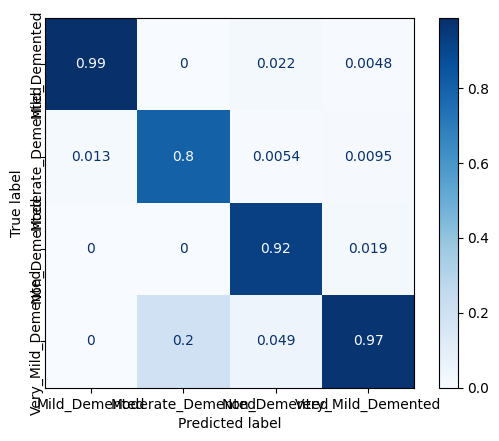

<Figure size 500x500 with 0 Axes>

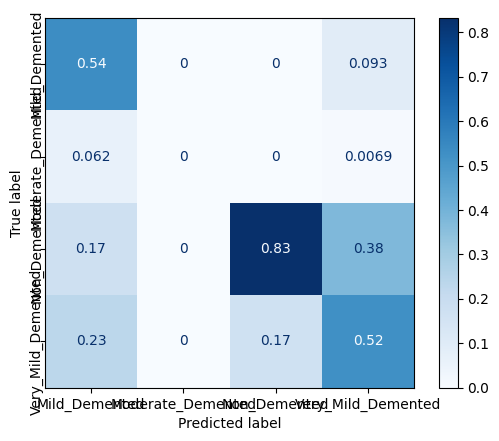

<Figure size 500x500 with 0 Axes>

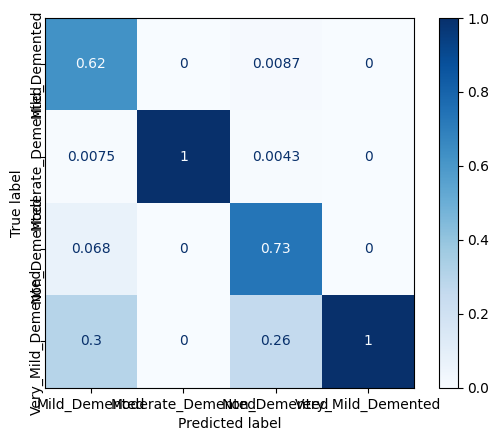

<Figure size 500x500 with 0 Axes>

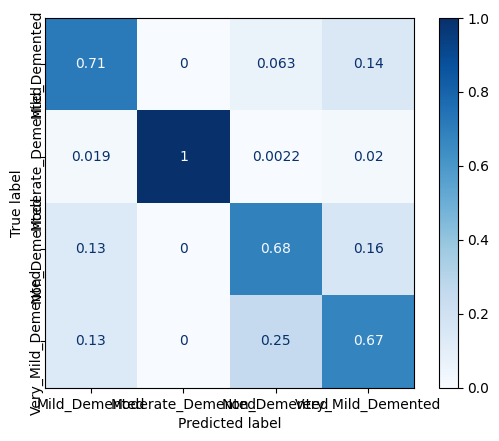

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r EfficientNetB0.zip ./*